### Visualisation and time-series analysis

<span style="font-size: 12pt;">This notebook shows the visualisation and time-series analysis of the processed dataset stored on Hadoop.</span>

<br>

#### 1. Apache Spark

<br>

In [1]:
sc # check pyspark status

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
sc.master # check master

'local[*]'

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import data from Hadoop using Spark
file_path = "/sentiment/climate_change_sentiment.csv"

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Time-series analysis").getOrCreate()

climate_change = spark.read.format("csv").option("header", "true").option("multiline", "true").load(file_path)
climate_change.show(3)

+----------+--------------------+---------+
|      date|               texts|sentiment|
+----------+--------------------+---------+
|2021-09-01|absolutely blunt ...|   0.9894|
|2021-09-01|canada essentiall...|  -0.1531|
|2021-09-01| come climate change|        0|
+----------+--------------------+---------+
only showing top 3 rows



In [5]:
# Check missing value
from pyspark.sql.functions import col, count, when

# Count the number of missing values in each column
missing_values = climate_change.select([count(when(col(c).isNull(), c)).alias(c) for c in climate_change.columns])

# Display the missing value counts
missing_values.show()

+----+-----+---------+
|date|texts|sentiment|
+----+-----+---------+
|   0|    0|        0|
+----+-----+---------+



In [6]:
# Add new column "category" based on sentiments
from pyspark.sql.types import DoubleType

climate_change = climate_change.withColumn("sentiment", climate_change["sentiment"].cast(DoubleType()))
climate_change = climate_change.withColumn(
    "category", when(climate_change.sentiment > 0, "positive").when(climate_change.sentiment < 0, "negative").otherwise("neutral"))

climate_change.show(5)

+----------+--------------------+---------+--------+
|      date|               texts|sentiment|category|
+----------+--------------------+---------+--------+
|2021-09-01|absolutely blunt ...|   0.9894|positive|
|2021-09-01|canada essentiall...|  -0.1531|negative|
|2021-09-01| come climate change|      0.0| neutral|
|2021-09-01|communism mean wo...|    0.872|positive|
|2021-09-01|data always lined...|   0.4939|positive|
+----------+--------------------+---------+--------+
only showing top 5 rows



<br>

#### 2. Convert to pandas dataframe

<br>

In [7]:
# Import mandatory libraries
import pandas as pd

In [8]:
# Change to pandas dataframe
climate_change_sentiment = climate_change.toPandas()
climate_change_sentiment.head()

date                                              texts  sentiment  \
0  2021-09-01  absolutely blunt care person want power canada...     0.9894   
1  2021-09-01  canada essentially upgraded version united sta...    -0.1531   
2  2021-09-01                                come climate change     0.0000   
3  2021-09-01  communism mean worker compensated worker contr...     0.8720   
4  2021-09-01  data always lined predicted faster expected pl...     0.4939   

   category  
0  positive  
1  negative  
2   neutral  
3  positive  
4  positive

In [9]:
climate_change_sentiment.shape

(7300, 4)

In [10]:
climate_change_sentiment.duplicated().sum()

6

In [11]:
# Check what is duplicating
duplicate_bool = climate_change_sentiment.duplicated(
    subset = ["date", "texts", "sentiment", "category"], 
    keep = "first")
duplicate = climate_change_sentiment.loc[duplicate_bool == True]
duplicate

date                                              texts  \
642   2021-10-03                                     climate change   
2126  2021-12-16                                     climate change   
2325  2021-12-26                                     climate change   
3952  2022-03-17  nft proarguments argument written mrmoustachem...   
4925  2022-05-05                                     climate change   
6464  2022-07-21                           climate change isnt real   

      sentiment  category  
642      0.0000   neutral  
2126     0.0000   neutral  
2325     0.0000   neutral  
3952     0.9986  positive  
4925     0.0000   neutral  
6464     0.0000   neutral

<br>

<span style="font-size: 12pt;">*The potential reason of the duplicated items showing above is that the comments people posted are the same, for example "climate change". However, these are still opnions from different person. In order to avoid bias, these duplicates were not dropped.*</span>

<br>

In [12]:
climate_change_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       7300 non-null   object 
 1   texts      7300 non-null   object 
 2   sentiment  7300 non-null   float64
 3   category   7300 non-null   object 
dtypes: float64(1), object(3)
memory usage: 228.2+ KB


In [13]:
# Convert "date" type
climate_change_sentiment["date"] = pd.to_datetime(climate_change_sentiment["date"])
climate_change_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       7300 non-null   datetime64[ns]
 1   texts      7300 non-null   object        
 2   sentiment  7300 non-null   float64       
 3   category   7300 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 228.2+ KB


<br>

- <span style="font-size: 14pt;">***visualisation***</span>

<br>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

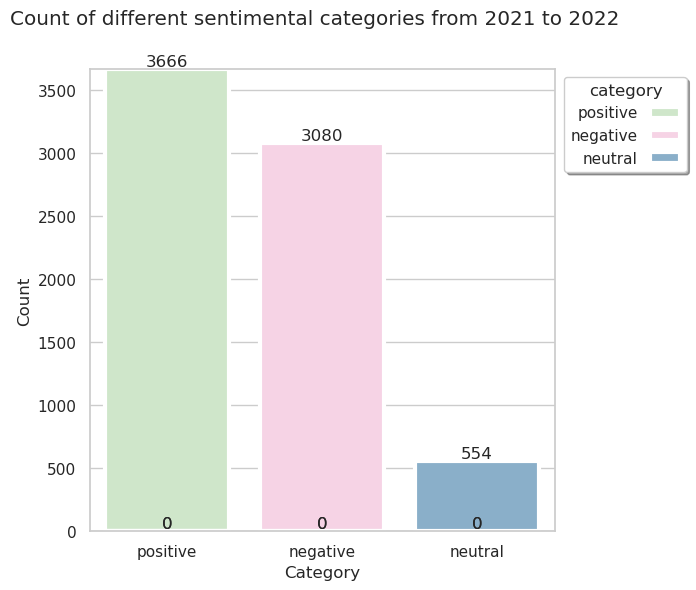

In [29]:
# Visualise the value counts in "category"
category_counts = climate_change_sentiment["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of different sentimental categories from 2021 to 2022")

sns.set_theme(style="whitegrid")

ranks = climate_change_sentiment["category"].sort_values().index

palette = sns.color_palette("Set3", len(ranks))

sns.countplot(ax=axes, data=climate_change_sentiment, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts))

plt.show()

In [16]:
# Create a new dataframe {sentiment} only contains "date" and "sentiment"
sentiment = climate_change_sentiment[["date", "sentiment"]].copy()
sentiment.tail(6)

date  sentiment
7294 2022-08-31    -0.3408
7295 2022-08-31     0.9879
7296 2022-08-31     0.8360
7297 2022-08-31     0.6597
7298 2022-08-31     0.4031
7299 2022-08-31     0.7430

In [17]:
# Aggregate the average of the sentiments based on "date"
sentiment_final = sentiment.groupby("date")["sentiment"].mean().reset_index()
sentiment_final.columns = ["date", "average sentiment"]
sentiment_final.head()

date  average sentiment
0 2021-09-01           0.066240
1 2021-09-02           0.056645
2 2021-09-03           0.006905
3 2021-09-04           0.062800
4 2021-09-05          -0.087550

In [18]:
# Add "category" and assign to a new dataframe
sentiment_final_category = sentiment_final.copy()
sentiment_final_category["category"] = pd.cut(sentiment_final_category["average sentiment"], 
                                              bins=[-float("inf"), 0, float("inf")], 
                                              labels=["negative", "positive"])

sentiment_final_category.head(8)

date  average sentiment  category
0 2021-09-01           0.066240  positive
1 2021-09-02           0.056645  positive
2 2021-09-03           0.006905  positive
3 2021-09-04           0.062800  positive
4 2021-09-05          -0.087550  negative
5 2021-09-06          -0.000375  negative
6 2021-09-07          -0.201935  negative
7 2021-09-08           0.074290  positive

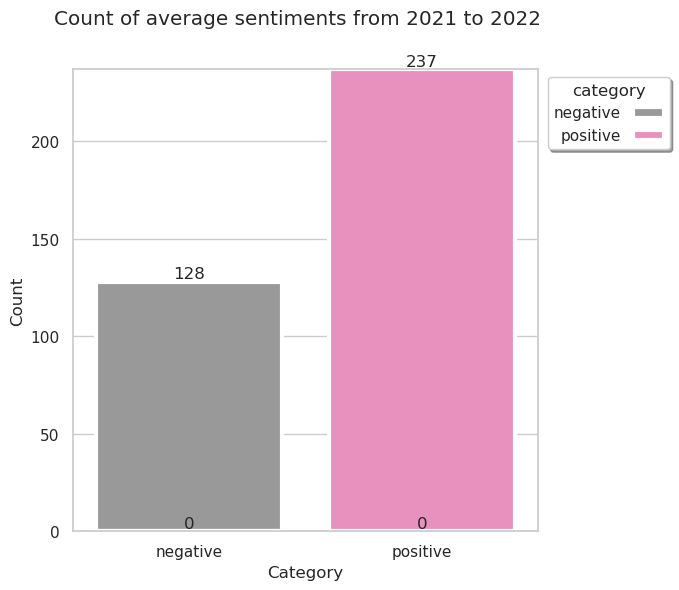

In [19]:
# Visualise the value counts of average sentiments
category_counts2 = sentiment_final_category["category"].value_counts()

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Count of average sentiments from 2021 to 2022")

sns.set_theme(style="whitegrid")

ranks = sentiment_final_category["category"].sort_values().index

palette = sns.color_palette("Set1", len(ranks))

sns.countplot(ax=axes, data=sentiment_final_category, x="category",
              linewidth=3, hue="category",
              palette = np.array(palette)[ranks], dodge = False)

axes.set_xlabel("Category")
axes.set_ylabel("Count")

plt.legend(title="category", bbox_to_anchor=(1.3, 1),
           frameon=True, ncol=1,
           markerfirst=False, shadow=True)

for container in axes.containers:
    axes.bar_label(container)

axes.set_ylim(0, max(category_counts2))

plt.show()

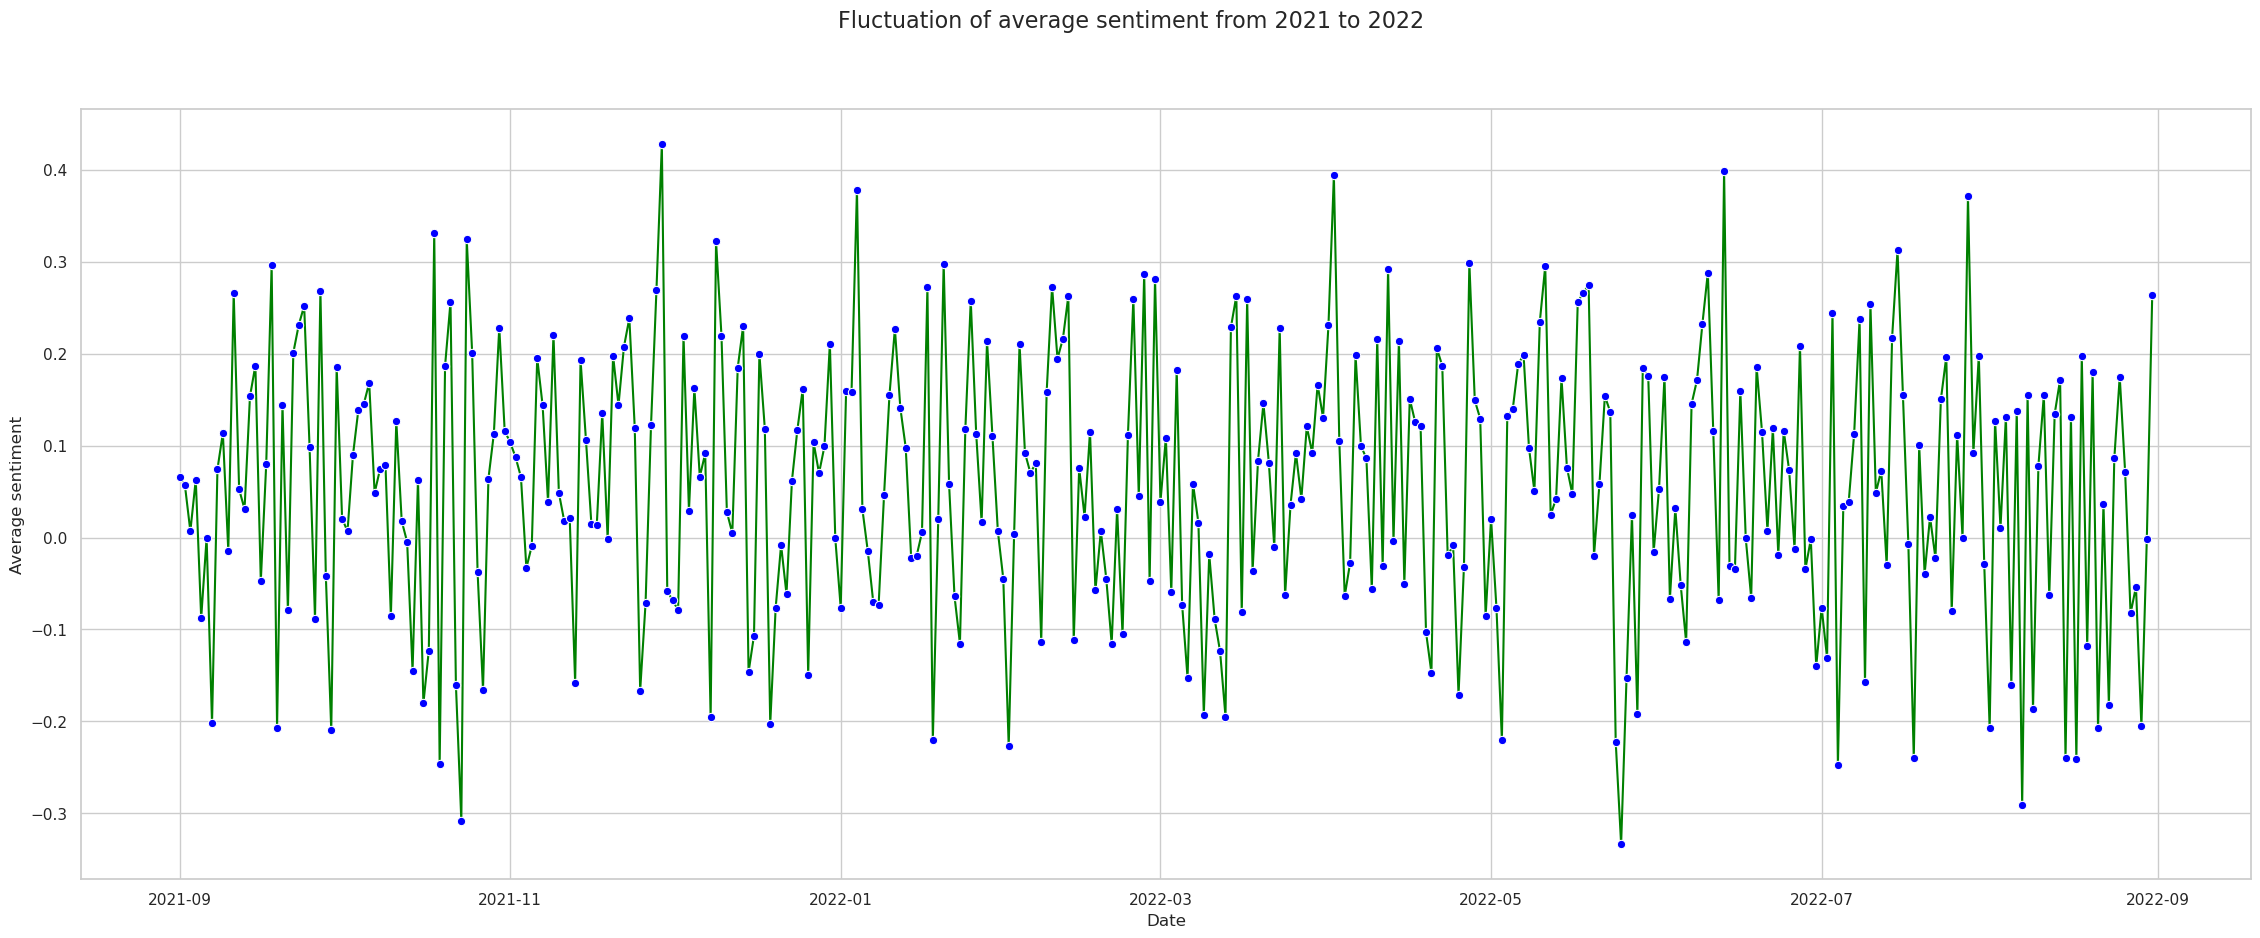

In [20]:
# Visualise the average sentiment change over time
fig, axes = plt.subplots(figsize=(28, 10))
fig.suptitle("Fluctuation of average sentiment from 2021 to 2022", fontsize=16)

sns.set_theme(style="whitegrid")

sns.lineplot(data=sentiment_final, x="date", y="average sentiment", 
             marker="o", linestyle="-", color="green", markerfacecolor="blue")

axes.set_xlabel("Date")
axes.set_ylabel("Average sentiment")

plt.show()

<br>

<span style="font-size: 12pt;">The average sentiment from 2021-09-01 to 2022-08-31 reaches its highest around the end of November 2021, however, its lowest near the beginning of June 2022.</span>

<br>

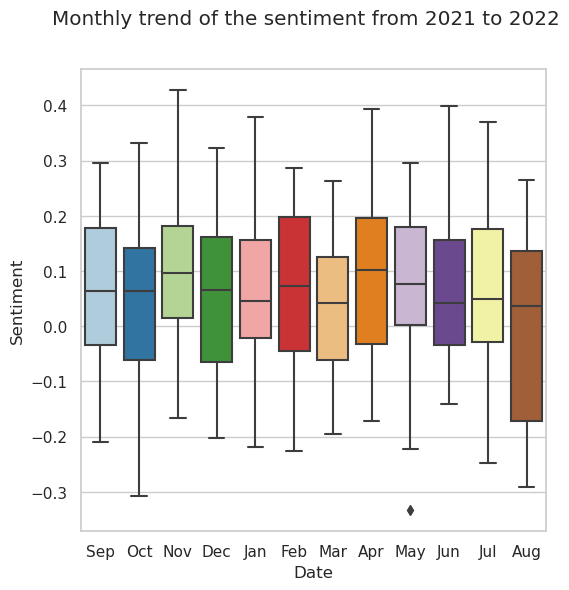

In [21]:
# Visualise monthly trend over the whole year
monthly_sentiment = sentiment_final.copy()
monthly_sentiment.reset_index(inplace=True)
monthly_sentiment["month"] = [d.strftime("%b") for d in sentiment_final.date]

fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Monthly trend of the sentiment from 2021 to 2022")

sns.set_theme(style="whitegrid")

sns.boxplot(data=monthly_sentiment, x="month", y="average sentiment", palette="Paired")

axes.set_xlabel("Date")
axes.set_ylabel("Sentiment")

plt.show()

<br>

<span style="font-size: 12pt;">People have an obvious tendency to leave more negative comments about climate change in August 2022, and a slight tendency to talk more positively about it in Jan 2022. Fairly even in the rest months.</span>
<span style="font-size: 12pt;">Overall, the changing is mild. Notably, there is an "extreme" negative comment at May 2022.</span>

<br>

- <span style="font-size: 14pt;">***time-series analysis***</span>

<br>

In [22]:
sentiment_final.head()

date  average sentiment
0 2021-09-01           0.066240
1 2021-09-02           0.056645
2 2021-09-03           0.006905
3 2021-09-04           0.062800
4 2021-09-05          -0.087550

In [23]:
# Save data to local machine
sentiment_final.to_csv("climate_change_sentiment.csv", index = None, header = True)

In [1]:
# Import libraries again if skipping the steps above

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read from local to make the repetitive model training easier
final = pd.read_csv("climate_change_sentiment.csv")
final.tail()

date  average sentiment
360  2022-08-27          -0.082510
361  2022-08-28          -0.053495
362  2022-08-29          -0.205270
363  2022-08-30          -0.001860
364  2022-08-31           0.264050

<br>

<span style="font-size: 12pt;">**stationary status**</span>

In [3]:
# Test whether the data is stationary
from statsmodels.tsa.stattools import adfuller, kpss

# Perform the ADF (Augmented Dickey Fuller) test
adf_result = adfuller(final["average sentiment"])
adf_statistic = adf_result[0]
adf_p_value = adf_result[1]

# Perform the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test
kpss_result = kpss(final["average sentiment"])
kpss_statistic = kpss_result[0]
kpss_p_value = kpss_result[1]

# Print the test results
print(f'ADF Statistic: {adf_statistic:.4f}')
print(f'ADF p-value: {adf_p_value:.4f}')
print(f'KPSS Statistic: {kpss_statistic:.4f}')
print(f'KPSS p-value: {kpss_p_value:.4f}')

ADF Statistic: -19.0966
ADF p-value: 0.0000
KPSS Statistic: 0.1438
KPSS p-value: 0.1000


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<br>

<span style="font-size: 12pt;">The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the p-Value in ADF test is less than the significance level (0.05), we reject the null hypothesis. The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the p-Value interpretation is just the opposite of ADH test.</span>

<span style="font-size: 12pt;">The results above confirm that the time-series data is stationary.</span>

<br>

<span style="font-size: 12pt;">**analysis**</span>

In [4]:
final.head()

date  average sentiment
0  2021-09-01           0.066240
1  2021-09-02           0.056645
2  2021-09-03           0.006905
3  2021-09-04           0.062800
4  2021-09-05          -0.087550

In [5]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               365 non-null    object 
 1   average sentiment  365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


<br>

- **ForecasterAutoreg**

In [6]:
#!pip3 install skforecast --user

In [7]:
# Import libries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [8]:
data = final.copy()
data["date"] = pd.to_datetime(data["date"], format='%Y/%m/%d')
data = data.set_index("date")
data = data.asfreq('D')
data = data.sort_index()
data.head()

average sentiment
date                         
2021-09-01           0.066240
2021-09-02           0.056645
2021-09-03           0.006905
2021-09-04           0.062800
2021-09-05          -0.087550

In [9]:
# Verify that a temporary index is complete
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [10]:
# Split data into train-test
steps = 45
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 2021-09-01 00:00:00 --- 2022-07-17 00:00:00  (n=320)
Test dates  : 2022-07-18 00:00:00 --- 2022-08-31 00:00:00  (n=45)


In [10]:
def train_test_lineplot(title, train_data, test_data):
    fig, axes = plt.subplots(figsize=(28, 10))
    fig.suptitle(title, fontsize=16)

    sns.set_theme(style="whitegrid")

    sns.lineplot(data=train_data, x="date", y="average sentiment",
                 linestyle="-", color="blue")
    sns.lineplot(data=test_data, x="date", y="average sentiment",
                 linestyle="-", color="green")

    axes.set_xlabel("Date")
    axes.set_ylabel("Sentiment")

    # Create proxy artists for the legend entries
    train_proxy = plt.Line2D([], [], linestyle="-", color="blue", label="train")
    test_proxy = plt.Line2D([], [], linestyle="-", color="green", label="test")

    # Create the legend
    plt.legend(handles=[train_proxy, test_proxy], loc="upper center",
               bbox_to_anchor=(0.5, 1.05), ncol=2)

    plt.show()

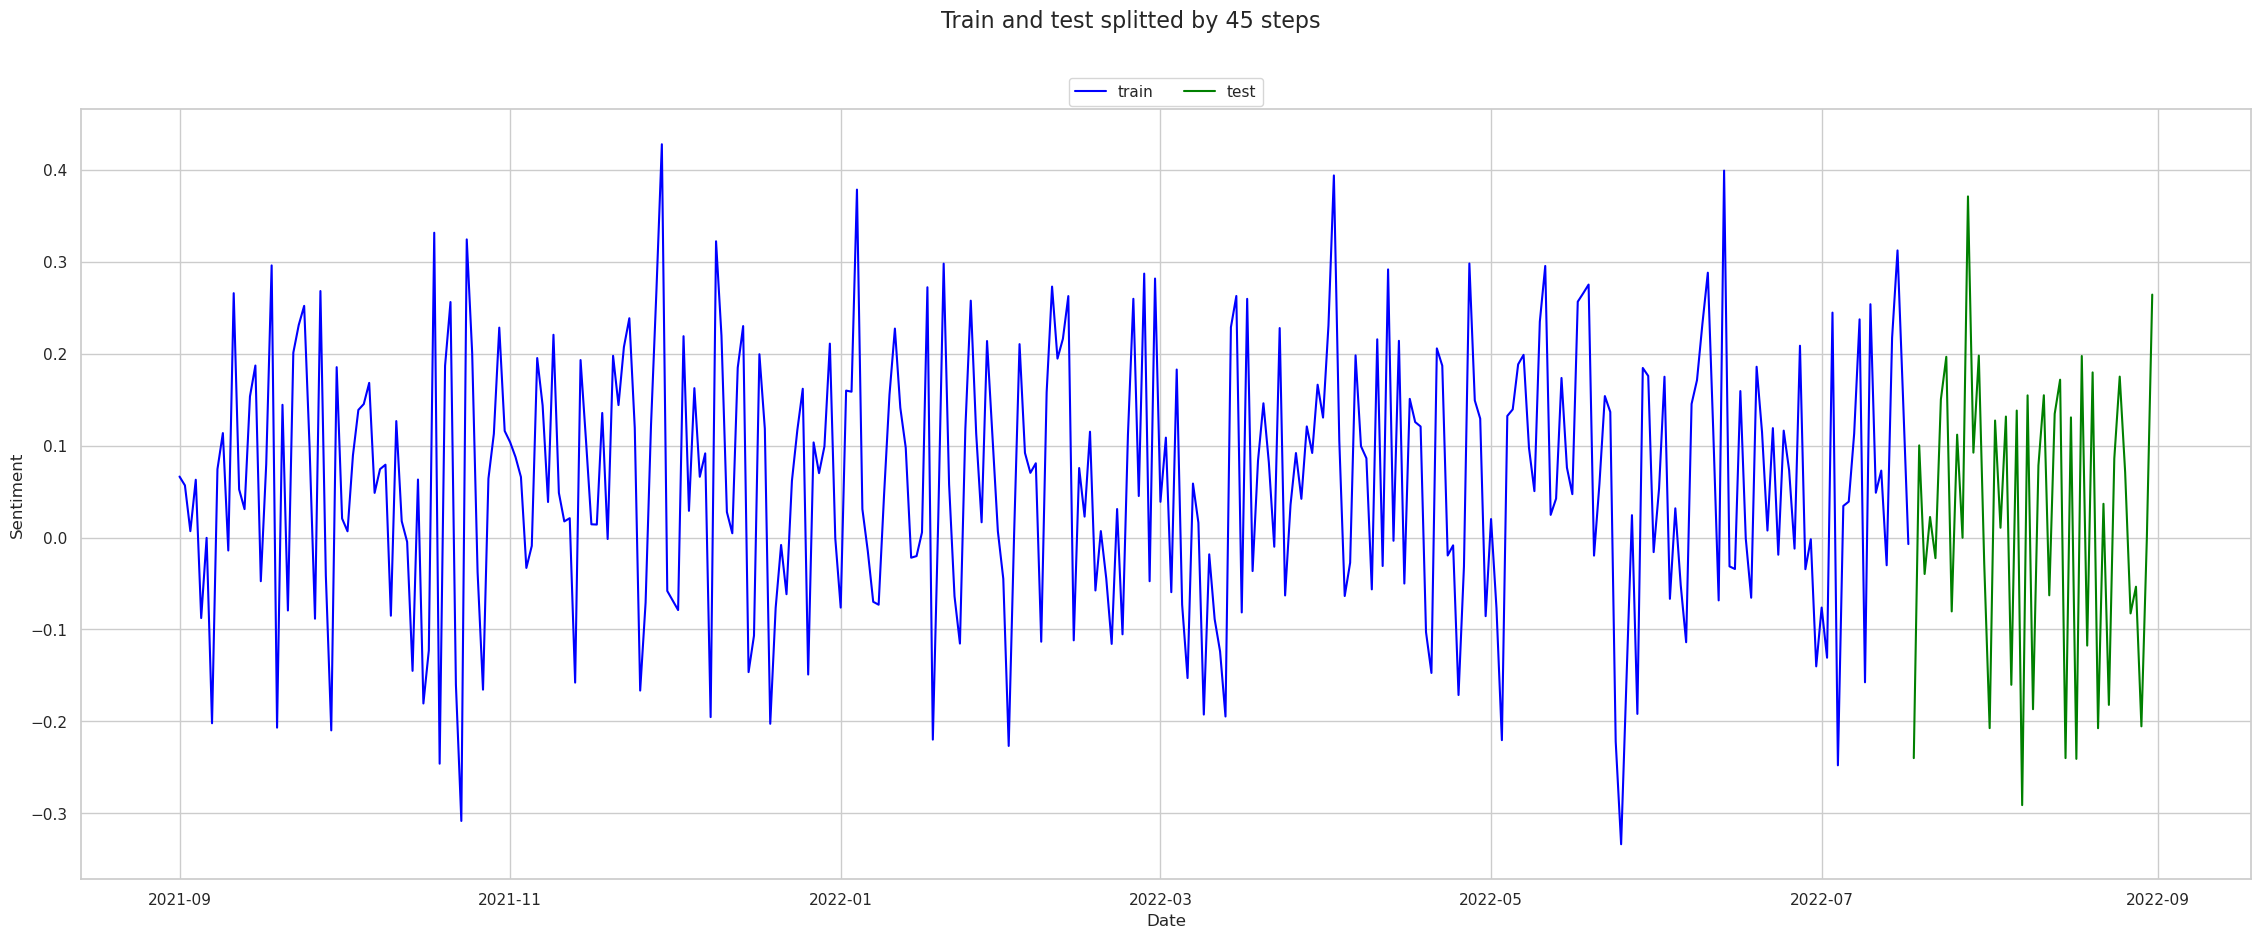

In [13]:
train_test_lineplot("Train and test splitted by 45 steps", data_train, data_test)

In [14]:
# Create and train forecaster randomly
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train["average sentiment"])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-09-01 00:00:00'), Timestamp('2022-07-17 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-05-25 23:33:19 
Last fit date: 2023-05-25 23:33:20 
Skforecast version: 0.8.0 
Python version: 3.10.9 
Forecaster id: None 

In [15]:
# Predictions
steps = 45
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2022-07-18    0.055039
2022-07-19    0.040200
2022-07-20    0.060441
2022-07-21    0.046524
2022-07-22    0.065426
Freq: D, Name: pred, dtype: float64

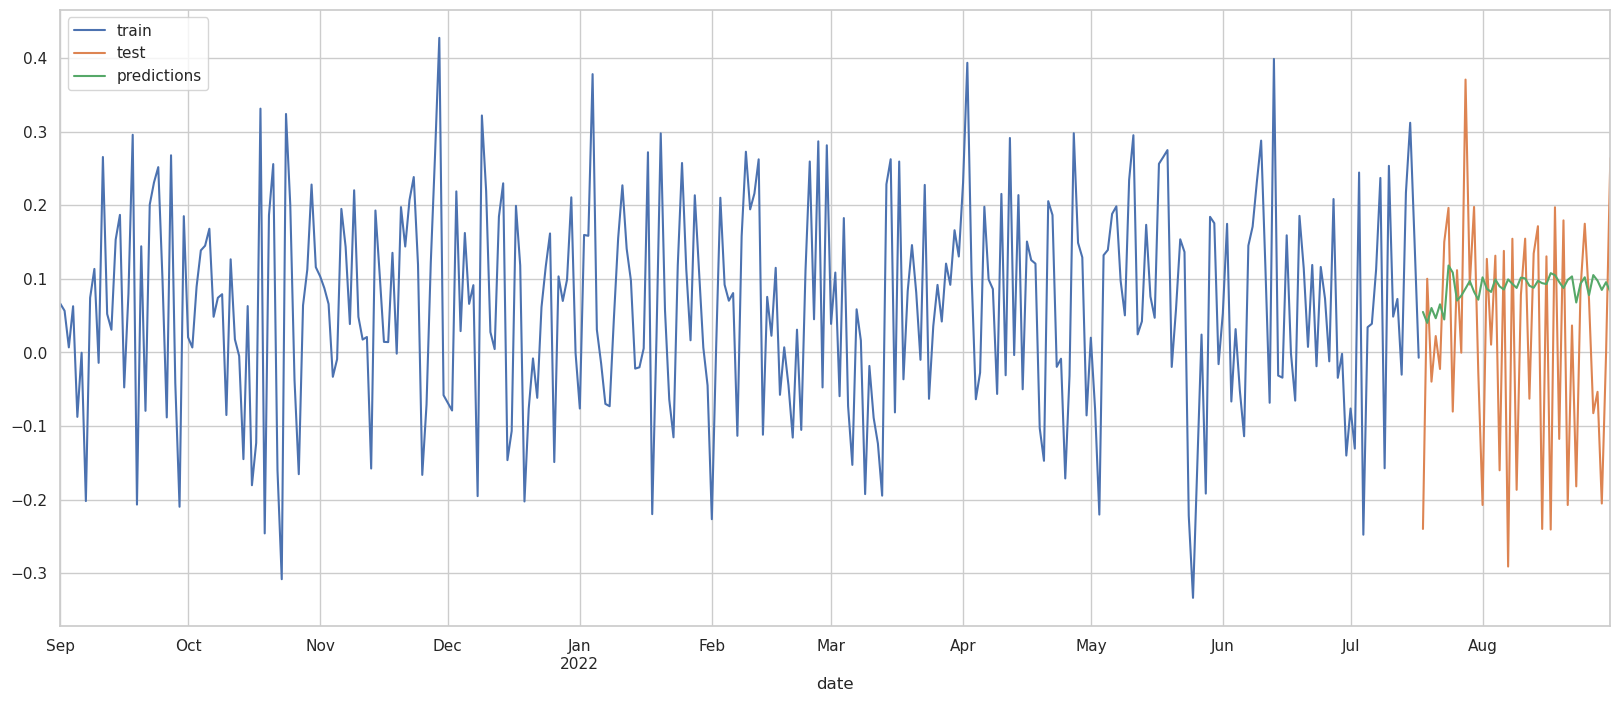

In [16]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 8))
data_train["average sentiment"].plot(ax=ax, label='train')
data_test["average sentiment"].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [17]:
# Test error
error_mse = mean_squared_error(
                y_true = data_test["average sentiment"],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0301175030203841


In [18]:
# Hyperparameter Grid search to find the best parameter
steps = 45
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 40]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train["average sentiment"],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = "mean_squared_error",
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 0.019934567954501176



In [19]:
# Grid Search results
results_grid

lags  \
3                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
0                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
1                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
2                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
4                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                    params  mean_squared_error  max_depth  \
3    {'max_depth': 5, 'n_estimators': 500}            0.019935          5   
0    {'max_depth': 3, 'n_estimators': 100}            0.019946          3   
1    {'max_depth': 3, 'n_estimators': 500}            0.019964          3   
2    {'max_depth': 5, 'n_estimators': 100}            0.020014          5   
4   {'max_depth': 10, 'n_estimators': 100}            0.020063         10   
7    {'max_depth': 3, 'n_estimators': 500}            0.020088          3   
9    {'max_depth': 5, 'n_estimators': 500}            0.020122          5   
11  {'max_depth': 10, 'n_estimators': 500}            0.020140         10   
5   {'max_depth': 10, 'n_estimators': 500}            0.020149         10   
6    {'max_depth': 3, 'n_estimators': 100}            0.020182          3   
8    {'max_depth': 5, 'n_estimators': 100}            0.020342          5   
10  {'max_depth': 10, 'n_estimators': 100}            0.020426         10   

    n_estimators  
3            500  
0            100  
1            500  
2            100  
4            100  
7            500  
9            500  
11           500  
5            500  
6            100  
8            100  
10           100

<br>

- ***final model***

In [20]:
# Create and train forecaster with the best hyperparameters
regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train["average sentiment"])

In [21]:
# Predictions
predictions = forecaster.predict(steps=steps)

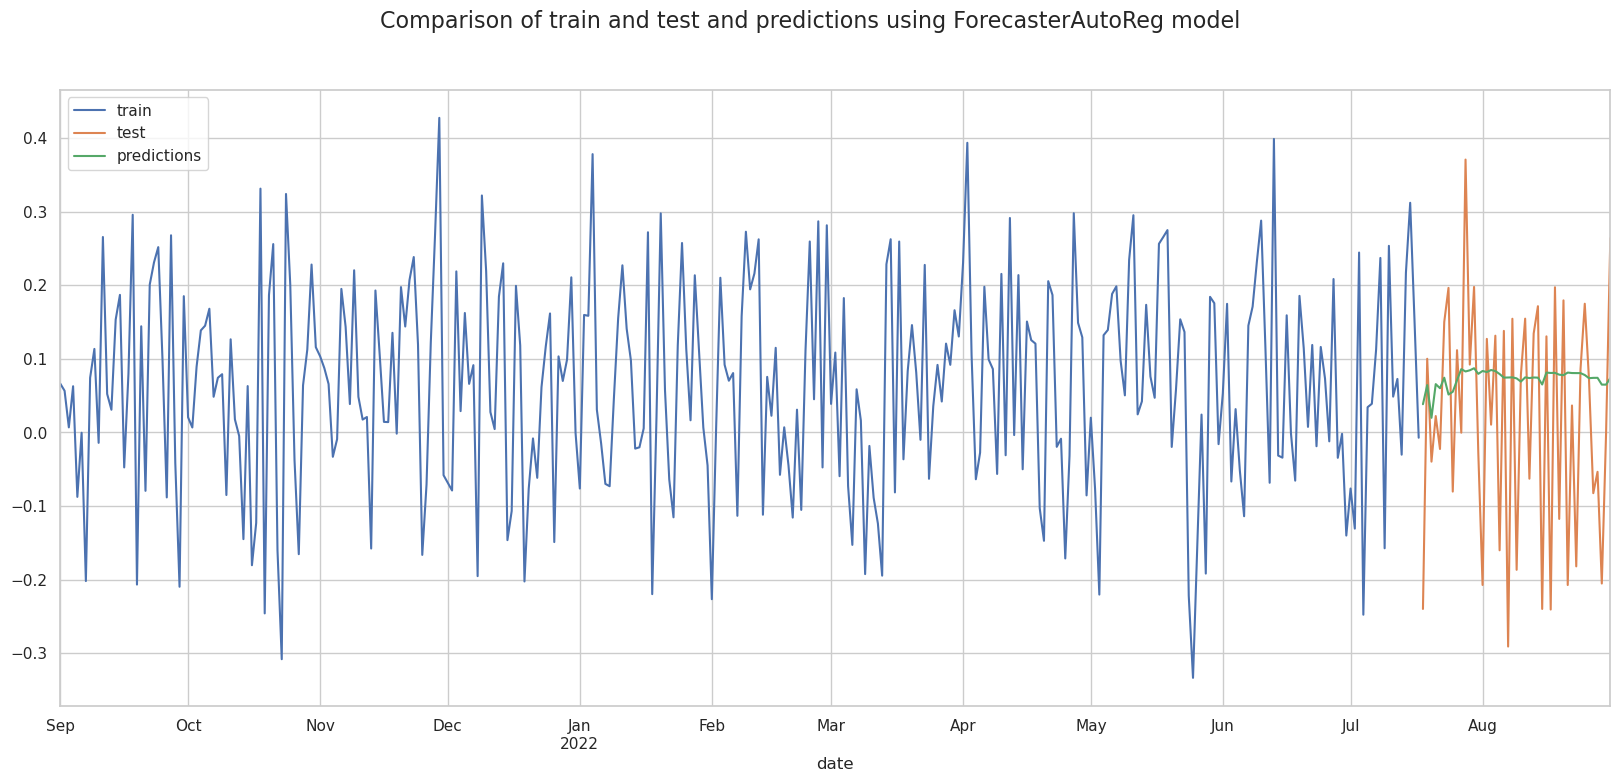

In [22]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle("Comparison of train and test and predictions using ForecasterAutoReg model", fontsize=16)
data_train["average sentiment"].plot(ax=ax, label="train")
data_test["average sentiment"].plot(ax=ax, label="test")
predictions.plot(ax=ax, label="predictions")
ax.legend();

In [23]:
# Test error, about 0.14 after sqrt function
error_mse = mean_squared_error(
                y_true = data_test["average sentiment"],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.02739754663703852


*The test error has reduced comparing to the randomly chosen parameter at the beginning.*

<br>

- ***backtesting***

In [24]:
steps = 45
n_backtesting = 45*7

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data["average sentiment"],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps      = steps,
                                    metric     = "mean_squared_error",
                                    refit      = True,
                                    verbose    = True
                                    )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 50
Number of observations used for backtesting: 315
    Number of folds: 7
    Number of steps per fold: 45
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2021-09-01 00:00:00 -- 2021-10-20 00:00:00  (n=50)
    Validation: 2021-10-21 00:00:00 -- 2021-12-04 00:00:00  (n=45)
Fold: 1
    Training:   2021-09-01 00:00:00 -- 2021-12-04 00:00:00  (n=95)
    Validation: 2021-12-05 00:00:00 -- 2022-01-18 00:00:00  (n=45)
Fold: 2
    Training:   2021-09-01 00:00:00 -- 2022-01-18 00:00:00  (n=140)
    Validation: 2022-01-19 00:00:00 -- 2022-03-04 00:00:00  (n=45)
Fold: 3
    Training:   2021-09-01 00:00:00 -- 2022-03-04 00:00:00  (n=185)
    Validation: 2022-03-05 00:00:00 -- 2022-04-18 00:00:00  (n=45)
Fold: 4
    Training:   2021-09-01 00:00:00 -- 2022-04-18 00:00:00  (n=230)
    Validation: 2022-04-19 00:00:00 -- 202

  0%|          | 0/7 [00:00<?, ?it/s]

Backtest error: 0.021730112861420833


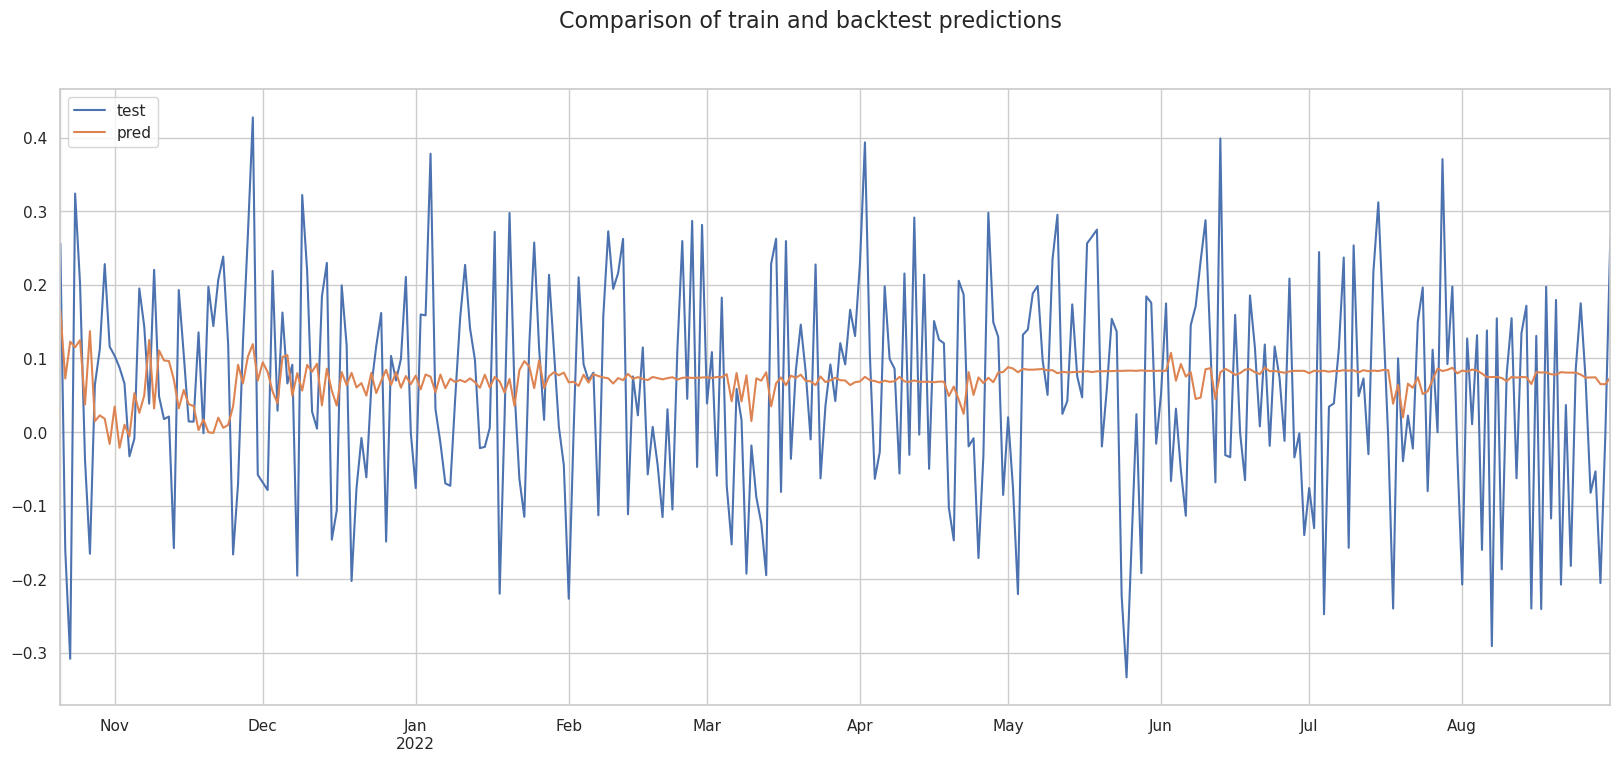

In [25]:
# Plot
fig, ax = plt.subplots(figsize=(20, 8))
fig.suptitle("Comparison of train and backtest predictions", fontsize=16)

data.loc[predictions_backtest.index, "average sentiment"].plot(ax=ax, label="test")
predictions_backtest.plot(ax=ax, label="predictions")
ax.legend(loc="upper left");

<br>

- **Autoregressive Integrated Moving Average**

In [1]:
#!pip3 install statsmodels

In [2]:
#!pip3 install skforecast[full]

In [4]:
# Import libraries again if skipping the steps above

# import pandas as pd

# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# %matplotlib inline

# import warnings
# warnings.filterwarnings("ignore")

In [5]:
df_arima = pd.read_csv("climate_change_sentiment.csv", parse_dates=["date"], index_col="date")
df_arima.head()

average sentiment
date                         
2021-09-01           0.066240
2021-09-02           0.056645
2021-09-03           0.006905
2021-09-04           0.062800
2021-09-05          -0.087550

In [16]:
import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

In [7]:
# Relax the display limits on columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [8]:
# Split into train and test
train = df_arima[df_arima.index < pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test = df_arima[df_arima.index >= pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test.head()

average sentiment
date                         
2022-07-01          -0.076160
2022-07-02          -0.130675
2022-07-03           0.244470
2022-07-04          -0.247640
2022-07-05           0.034325

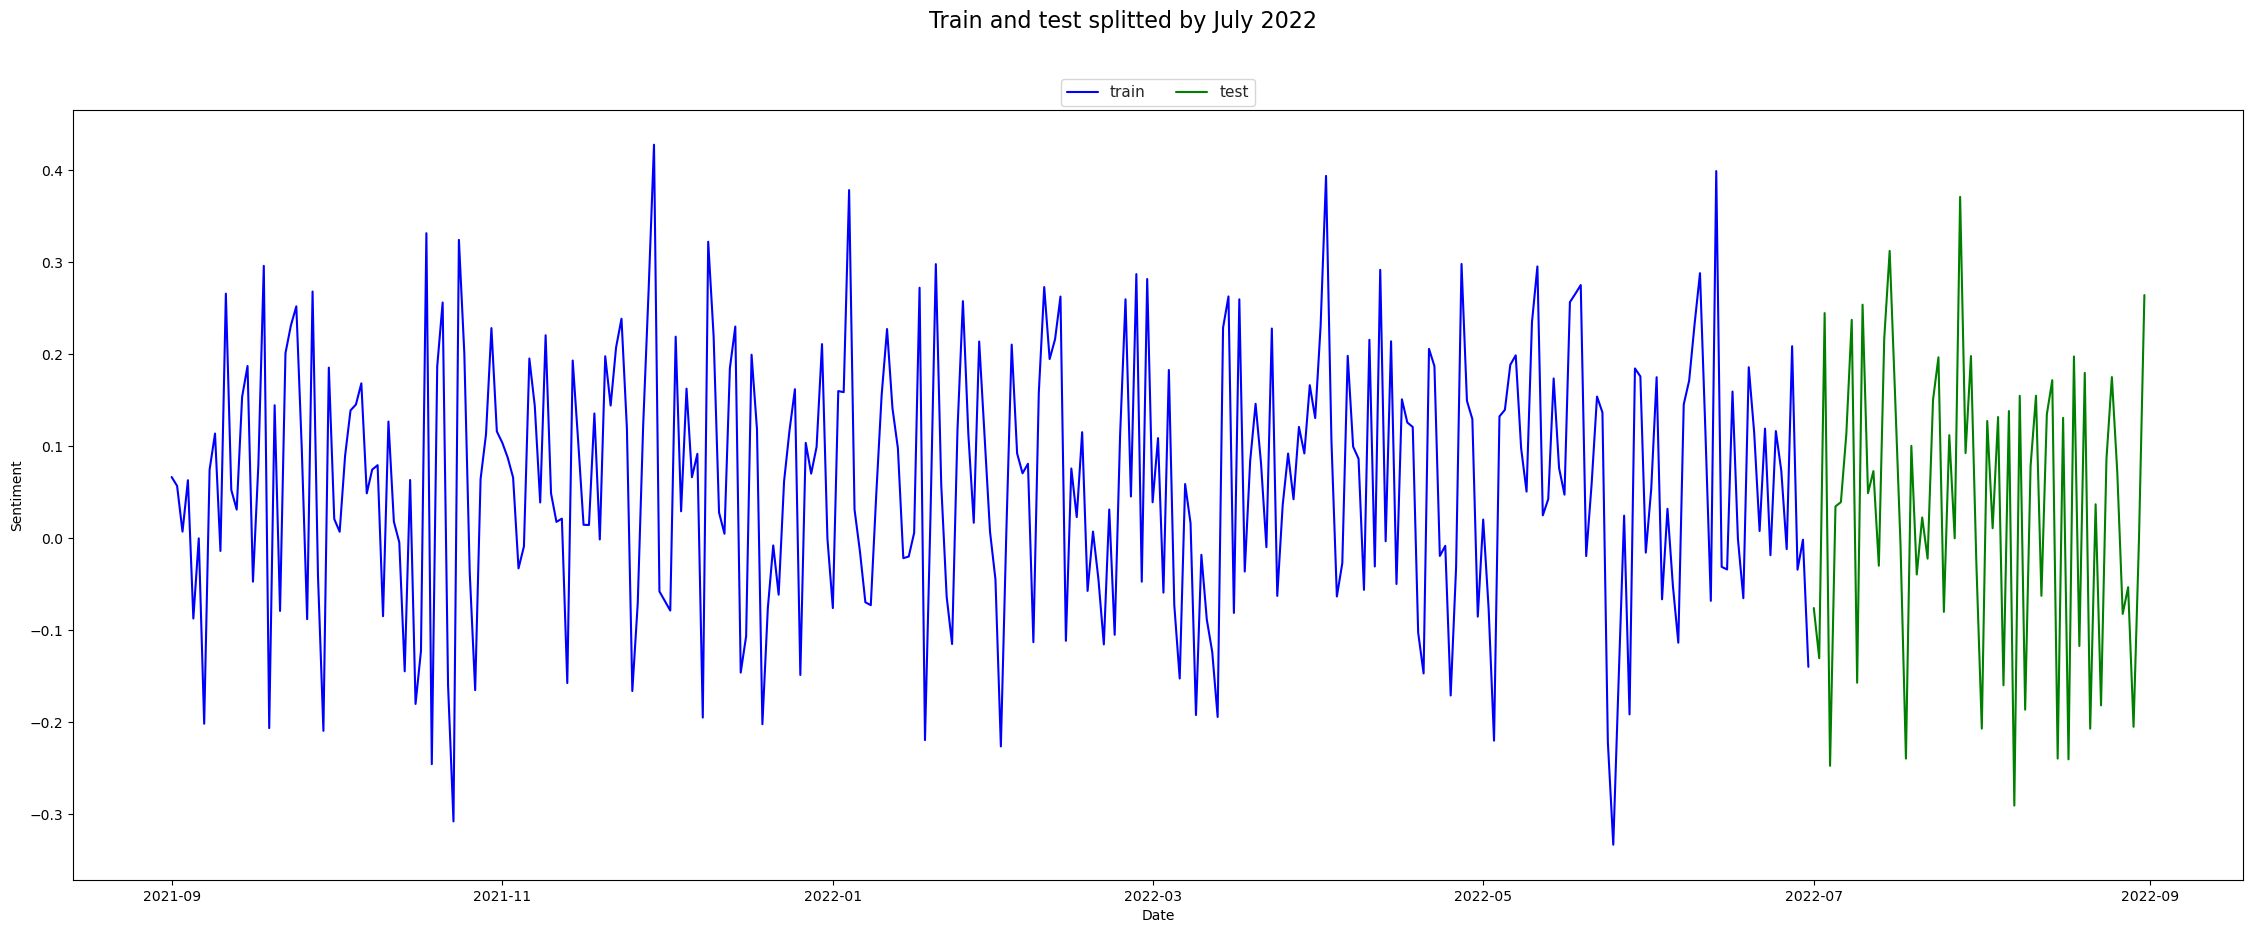

In [11]:
# Visualise train and test
train_test_lineplot("Train and test splitted by July 2022", train, test)

In [12]:
y = train["average sentiment"] # for hypertuning and model fitting

In [13]:
# Apply ARIMA model randomly
ARIMAmodel = SARIMAX(y, order = (2, 0, 20))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"].rename_axis("date").reset_index(name="prediction")
y_pred_outARIMA.set_index("date", inplace=True)
y_pred_outARIMA.head()

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.17721D-01    |proj g|=  3.28946D+00

At iterate    5    f= -4.53526D-01    |proj g|=  1.94840D+00

At iterate   10    f= -5.14265D-01    |proj g|=  6.62688D-01

At iterate   15    f= -5.36907D-01    |proj g|=  1.24674D-02

At iterate   20    f= -5.40753D-01    |proj g|=  2.57445D-02

At iterate   25    f= -5.50934D-01    |proj g|=  2.30381D-02

At iterate   30    f= -5.54139D-01    |proj g|=  1.32093D-02

At iterate   35    f= -5.60571D-01    |proj g|=  2.44830D-02

At iterate   40    f= -5.66360D-01    |proj g|=  1.01508D-02

At iterate   45    f= -5.67555D-01    |proj g|=  3.29432D-02

At iterate   50    f= -5.67826D-01    |proj g|=  3.80874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction
date                  
2022-07-01    0.064451
2022-07-02    0.071002
2022-07-03    0.073255
2022-07-04    0.053687
2022-07-05    0.057630

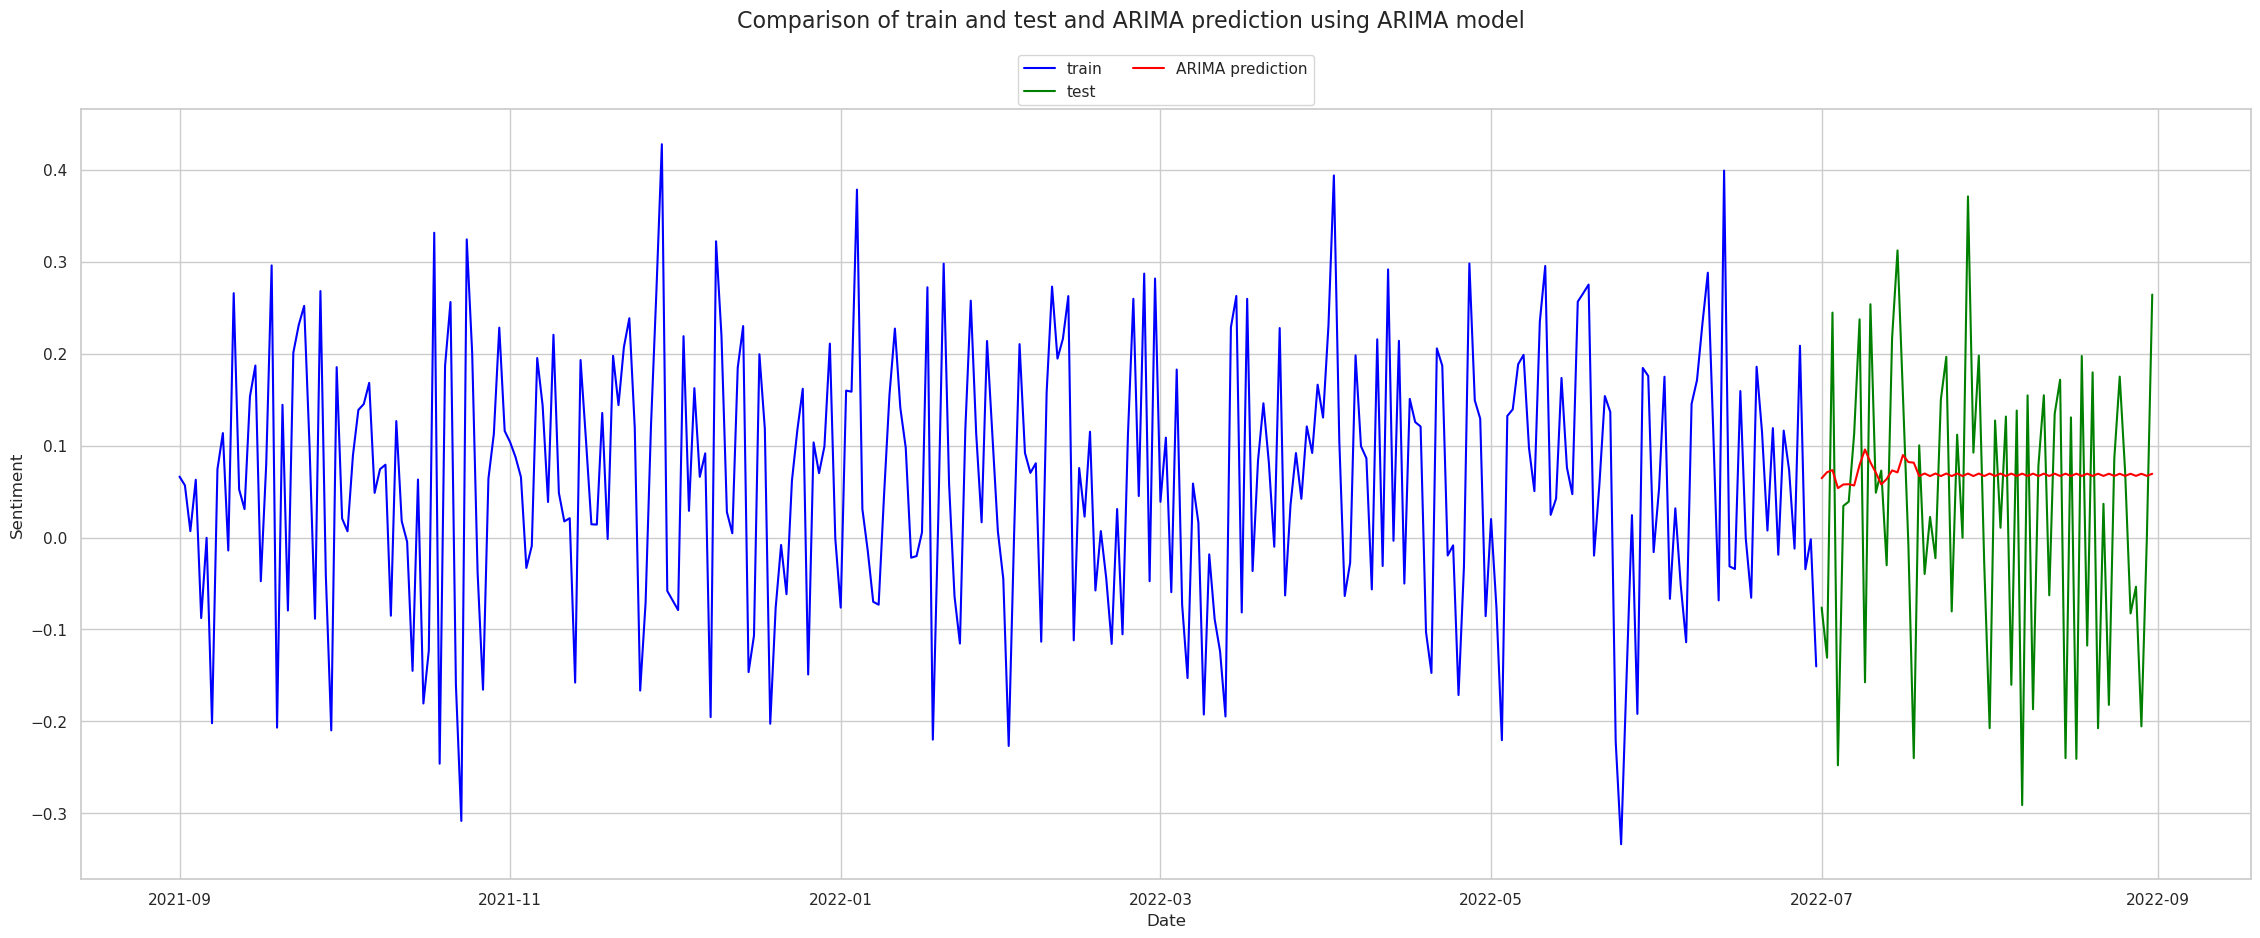

In [14]:
# Visualise train, test and predictions of ARMA model
fig, axes = plt.subplots(figsize=(28, 10))
fig.suptitle("Comparison of train and test and ARIMA prediction using ARIMA model", fontsize=16)

sns.set_theme(style="whitegrid")

sns.lineplot(data=train, x="date", y="average sentiment", 
             linestyle="-", color="blue")
sns.lineplot(data=test, x="date", y="average sentiment", 
             linestyle="-", color="green")
sns.lineplot(data=y_pred_outARIMA, x="date", y="prediction", 
             linestyle="-", color="red")

axes.set_xlabel("Date")
axes.set_ylabel("Sentiment")

# Create proxy artists for the legend entries
train_proxy = plt.Line2D([], [], linestyle="-", color="blue", label="train")
test_proxy = plt.Line2D([], [], linestyle="-", color="green", label="test")
arima_proxy = plt.Line2D([], [], linestyle="-", color="red", label="ARIMA prediction")

# Create the legend
plt.legend(handles=[train_proxy, test_proxy, arima_proxy], loc="upper center", 
           bbox_to_anchor=(0.5, 1.08), ncol=2)

plt.show()

In [17]:
arima_rmse = np.sqrt(mean_squared_error(test["average sentiment"].values, y_pred_df["Predictions"]))
print("ARIMA RMSE: ", arima_rmse)

ARIMA RMSE:  0.16336673737852325


In [35]:
# # hyper-tuning for ARMA
# import itertools
# from sklearn.model_selection import ParameterGrid

# # Define the range of parameter to explore
# param_grid = {
#     "order": [(p, d, q) for p in range(1, 20) for d in range(3) for q in range(20)]
# }

# # Generate all possible combinations of parameters
# param_combinations = list(ParameterGrid(param_grid))

# # Initialize variables to track best parameters and performance
# best_score = float("inf")
# best_params = None

# # Iterate over all parameter combinations
# for params in param_combinations:
#     try:
#         # Create and fit the SARIMAX model
#         model = SARIMAX(y, order=params['order'])
#         model = model.fit()

#         # Make predictions
#         y_pred = model.get_forecast(len(test.index))
#         y_pred_df = y_pred.conf_int(alpha=0.05)
#         y_pred_df['Predictions'] = model.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
#         y_pred_df.index = test.index

#         # Calculate the performance metric (e.g., mean squared error)
#         error = np.mean((y_pred_df['Predictions'] - test['average sentiment']) ** 2)

#         # Check if the current parameters yield better performance
#         if error < best_score:
#             best_score = error
#             best_params = params
#     except:
#         # Ignore any exceptions and continue to the next parameter combination
#         continue

# # Print the best parameters and their corresponding performance
# print("Best Parameters:", best_params)
# print("Best Score:", best_score)

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.79713D-01    |proj g|=  1.83579D-02

At iterate    5    f= -4.79715D-01    |proj g|=  2.33633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     12      1     0     0   1.149D-06  -4.797D-01
  F = -0.47971460633636198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.12456D-01    |proj g|=  3.07363D-01

At iterate    5    f= -5.17563D-01    |proj g|=  4.05682D-01

At iterate   10    f= -5.19426D-01    |proj g|=  6.21652D-02

At iterate   15    f= -5.23557D-01    |proj g|=  2.48340D-01

At iterate   20    f= -5.24304D-01    |proj g|=  1.54669D-02

At iterate   25    f= -5.25655D-01    |proj g|=  2.23375D-01

At iterate   30    f= -5.35854D-01    |proj g|=  3.12669D-02

At iterate   35    f= -5.37289D-01    |proj g|=  5.94986D-02

At iterate   40    f= -5.41151D-01    |proj g|=  1.64383D-01

At iterate   45    f= -5.42642D-01    |proj g|=  1.73539D-02

At iterate   50    f= -5.42872D-01    |proj g|=  2.66770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -5.09454D-01    |proj g|=  1.37309D-01

At iterate   15    f= -5.10911D-01    |proj g|=  1.12791D-01

At iterate   20    f= -5.20552D-01    |proj g|=  2.07093D-01

At iterate   25    f= -5.35629D-01    |proj g|=  8.01170D-02

At iterate   30    f= -5.40679D-01    |proj g|=  9.01650D-02

At iterate   35    f= -5.44437D-01    |proj g|=  2.07910D-01

At iterate   40    f= -5.45627D-01    |proj g|=  3.08289D-02

At iterate   45    f= -5.46036D-01    |proj g|=  8.52779D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.46414D-01    |proj g|=  1.19936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   1.199D-02  -5.464D-01
  F = -0.54641416397078968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.06935D-01    |proj g|=  1.56393D-01

At iterate    5    f= -5.07400D-01    |proj g|=  1.00689D-01

At iterate   10    f= -5.07943D-01    |proj g|=  1.05344D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49835D-01    |proj g|=  7.57604D-01

At iterate    5    f= -5.05180D-01    |proj g|=  2.49400D-01

At iterate   10    f= -5.10604D-01    |proj g|=  2.55774D-01

At iterate   15    f= -5.19098D-01    |proj g|=  2.12706D-02

At iterate   20    f= -5.19368D-01    |proj g|=  6.99656D-02

At iterate   25    f= -5.24676D-01    |proj g|=  6.88818D-01

At iterate   30    f= -5.36404D-01    |proj g|=  1.92893D-02

At iterate   35    f= -5.37462D-01    |proj g|=  1.91566D-02

At iterate   40    f= -5.43024D-01    |proj g|=  1.13983D-02

At iterate   45    f= -5.45630D-01    |proj g|=  3.13036D-02

At iterate   50    f= -5.46121D-01    |proj g|=  9.38261D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13953D-01    |proj g|=  9.97883D-02

At iterate    5    f= -5.17462D-01    |proj g|=  6.17008D-03

At iterate   10    f= -5.24267D-01    |proj g|=  5.59369D-02

At iterate   15    f= -5.41245D-01    |proj g|=  3.56977D-02

At iterate   20    f= -5.42284D-01    |proj g|=  5.19160D-03

At iterate   25    f= -5.43359D-01    |proj g|=  9.68270D-02

At iterate   30    f= -5.47398D-01    |proj g|=  7.20794D-02

At iterate   35    f= -5.49150D-01    |proj g|=  6.32203D-02

At iterate   40    f= -5.49606D-01    |proj g|=  8.44291D-03

At iterate   45    f= -5.49927D-01    |proj g|=  2.55862D-02

At iterate   50    f= -5.50008D-01    |proj g|=  1.56725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19716D-01    |proj g|=  1.39410D-01

At iterate    5    f= -5.24480D-01    |proj g|=  2.95023D-02

At iterate   10    f= -5.25195D-01    |proj g|=  2.95048D-02

At iterate   15    f= -5.25444D-01    |proj g|=  6.55885D-03

At iterate   20    f= -5.28526D-01    |proj g|=  4.89417D-02

At iterate   25    f= -5.43564D-01    |proj g|=  4.67026D-02

At iterate   30    f= -5.44829D-01    |proj g|=  3.63628D-03

At iterate   35    f= -5.44857D-01    |proj g|=  1.51010D-02

At iterate   40    f= -5.44948D-01    |proj g|=  5.28291D-02

At iterate   45    f= -5.45607D-01    |proj g|=  2.35808D-02

At iterate   50    f= -5.46032D-01    |proj g|=  6.31635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.08751D-01    |proj g|=  3.03780D-01

At iterate   10    f= -5.13781D-01    |proj g|=  1.83444D-01

At iterate   15    f= -5.25051D-01    |proj g|=  4.92866D-02

At iterate   20    f= -5.25161D-01    |proj g|=  1.61507D-02

At iterate   25    f= -5.25552D-01    |proj g|=  5.73681D-02

At iterate   30    f= -5.41361D-01    |proj g|=  4.30223D-01

At iterate   35    f= -5.43620D-01    |proj g|=  3.10198D-02

At iterate   40    f= -5.45766D-01    |proj g|=  4.69748D-02

At iterate   45    f= -5.47579D-01    |proj g|=  2.87805D-02

At iterate   50    f= -5.49844D-01    |proj g|=  7.37035D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.66097D-01    |proj g|=  8.21033D-01

At iterate    5    f= -5.19224D-01    |proj g|=  2.26740D-01

At iterate   10    f= -5.21522D-01    |proj g|=  8.04707D-02

At iterate   15    f= -5.24003D-01    |proj g|=  2.09572D-02

At iterate   20    f= -5.24386D-01    |proj g|=  7.09151D-02

At iterate   25    f= -5.32737D-01    |proj g|=  4.42862D-01

At iterate   30    f= -5.42152D-01    |proj g|=  6.34258D-02

At iterate   35    f= -5.44492D-01    |proj g|=  9.72422D-03

At iterate   40    f= -5.46333D-01    |proj g|=  2.54419D-02

At iterate   45    f= -5.50226D-01    |proj g|=  4.36108D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52515D-01    |proj g|=  4.78998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     54      1     0     0   4.790D-02  -5.525D-01
  F = -0.55251472922590439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51153D-01    |proj g|=  5.15462D+00

At iterate    5    f= -3.30691D-01    |proj g|=  6.75795D-01

At iterate   10    f= -5.17480D-01    |proj g|=  1.14696D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.88865D-01    |proj g|=  4.03359D-01

At iterate    5    f= -5.24013D-01    |proj g|=  1.97303D-02

At iterate   10    f= -5.24894D-01    |proj g|=  5.59744D-03

At iterate   15    f= -5.25112D-01    |proj g|=  4.41643D-03

At iterate   20    f= -5.25390D-01    |proj g|=  9.78156D-03

At iterate   25    f= -5.41211D-01    |proj g|=  4.60183D-01

At iterate   30    f= -5.49467D-01    |proj g|=  1.36661D-01

At iterate   35    f= -5.50395D-01    |proj g|=  1.94505D-02

At iterate   40    f= -5.50459D-01    |proj g|=  6.86186D-03

At iterate   45    f= -5.51395D-01    |proj g|=  5.11768D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55264D-01    |proj g|=  6.61643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   6.616D-02  -5.553D-01
  F = -0.55526438798871247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07478D-01    |proj g|=  3.26069D-01

At iterate    5    f= -5.26318D-01    |proj g|=  1.10159D-02

At iterate   10    f= -5.26642D-01    |proj g|=  3.46939D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53972D-01    |proj g|=  6.27560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   6.276D-02  -5.540D-01
  F = -0.55397172749454582     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32601D-01    |proj g|=  1.70290D+00

At iterate    5    f= -5.18532D-01    |proj g|=  2.79720D-01

At iterate   10    f= -5.26711D-01    |proj g|=  2.50901D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55339D-01    |proj g|=  1.01548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   1.015D-03  -5.553D-01
  F = -0.55533872875233836     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39170D-01    |proj g|=  6.10830D+00

At iterate    5    f= -2.97788D-01    |proj g|=  3.66055D-01

At iterate   10    f= -5.16412D-01    |proj g|=  8.33643D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51384D-01    |proj g|=  1.53520D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   1.535D-02  -5.514D-01
  F = -0.55138431755250561     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.29229D-01    |proj g|=  1.86877D+00

At iterate    5    f= -5.16391D-01    |proj g|=  4.39014D-01

At iterate   10    f= -5.25867D-01    |proj g|=  3.55607D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57862D-01    |proj g|=  4.80758D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   4.808D-02  -5.579D-01
  F = -0.55786223213637665     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19868D-01    |proj g|=  4.81109D+00

At iterate    5    f= -3.81615D-01    |proj g|=  7.16815D-01

At iterate   10    f= -5.22982D-01    |proj g|=  4.08487D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55631D-01    |proj g|=  4.02800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   4.028D-02  -5.556D-01
  F = -0.55563146988311052     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.63609D-01    |proj g|=  5.69777D+00

At iterate    5    f= -3.16055D-01    |proj g|=  4.22612D-01

At iterate   10    f= -5.16711D-01    |proj g|=  1.96673D-01

At iterate   15    f= -5.27114D-01    |proj g|=  9.59312D-02

At iterate   20    f= -5.29234D-01    |proj g|=  1.94307D-02

At iterate   25    f= -5.29304D-01    |proj g|=  1.78847D-02

At iterate   30    f= -5.29860D-01    |proj g|=  5.65913D-02

At iterate   35    f= -5.40804D-01    |proj g|=  2.71575D-01

At iterate   40    f= -5.49350D-01    |proj g|=  1.50540D-01

At iterate   45    f= -5.53747D-01    |proj g|=  9.34775D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54189D-01    |proj g|=  1.10521D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   1.105D-02  -5.542D-01
  F = -0.55418944748866783     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68115D-01    |proj g|=  5.54523D+00

At iterate    5    f= -3.21389D-01    |proj g|=  4.73233D-01

At iterate   10    f= -5.15304D-01    |proj g|=  6.09870D-01

At iterate   15    f= -5.29840D-01    |proj g|=  3.06962D-02

At iterate   20    f= -5.29971D-01    |proj g|=  1.68767D-02

At iterate   25    f= -5.30072D-01    |proj g|=  2.22598D-02

At iterate   30    f= -5.33424D-01    |proj g|=  8.25771D-02

At iterate   35    f= -5.46792D-01    |proj g|=  7.83684D-02

At iterate   40    f= -5.57030D-01    |proj g|=  4.92596D-02

At iterate   45    f= -5.59477D-01    |proj g|=  1.54472D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61633D-01    |proj g|=  7.01222D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   7.012D-02  -5.616D-01
  F = -0.56163308212068996     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.05347D-01    |proj g|=  5.02881D+00

At iterate    5    f= -3.59618D-01    |proj g|=  6.36768D-01

At iterate   10    f= -5.17973D-01    |proj g|=  5.06659D-01

At iterate   15    f= -5.25488D-01    |proj g|=  2.72281D-01

At iterate   20    f= -5.28066D-01    |proj g|=  2.23879D-02

At iterate   25    f= -5.28152D-01    |proj g|=  3.31095D-03

At iterate   30    f= -5.28965D-01    |proj g|=  4.01146D-02

At iterate   35    f= -5.34063D-01    |proj g|=  3.98752D-02

At iterate   40    f= -5.50279D-01    |proj g|=  3.32219D-02

At iterate   45    f= -5.55822D-01    |proj g|=  1.75344D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.56931D-01    |proj g|=  5.13606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     59      1     0     0   5.136D-03  -5.569D-01
  F = -0.55693091339226253     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.28405D-01    |proj g|=  1.92162D-02

At iterate    5    f= -3.28409D-01    |proj g|=  4.24335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   1.186D-06  -3.284D-01
  F = -0.32840920435354359     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00853D-01    |proj g|=  4.12968D-01

At iterate    5    f= -5.13119D-01    |proj g|=  1.29037D-01

At iterate   10    f= -5.34370D-01    |proj g|=  3.06424D-02

At iterate   15    f= -5.37146D-01    |proj g|=  1.16429D-02

At iterate   20    f= -5.37175D-01    |proj g|=  2.31587D-04

At iterate   25    f= -5.37497D-01    |proj g|=  2.22784D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     39      1     0     0   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f= -5.38614D-01    |proj g|=  2.22337D-02

At iterate   30    f= -5.38804D-01    |proj g|=  2.67986D-02

At iterate   35    f= -5.38959D-01    |proj g|=  4.93415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   1.060D-04  -5.390D-01
  F = -0.53895921942452596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09431D-01    |proj g|=  4.21784D-01

At iterate    5    f= -5.12452D-01    |proj g|=  4.04629D-01

At iterate   10    f= -5.20907D-01    |proj g|=  3.02251D-01

At iterate   15    f= -5.39529D-01    |proj g|=  7.19871D-02

At iterate   20    f= -5.40941D-01    |proj g|=  3.43357D-02

At iterate   25    f= -5.42572D-01    |proj g|=  1.91440D-03

At iterate   30    f= -5.42637D-01    |proj g|=  1.14127D-03

At iterate   35    f= -5.42638D-01    |proj g|=  1.94740D-03

At iterate   40    f= -5.42650D-01    |proj g|=  9.56767D-03

At iterate   45    f= -5.43268D-01    |proj g|=  6.75835D-02

At iterate   50    f= -5.43337D-01    |proj g|=  4.69899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34422D-01    |proj g|=  4.68225D-01

At iterate    5    f= -5.39876D-01    |proj g|=  3.97438D-01

At iterate   10    f= -5.40986D-01    |proj g|=  5.26805D-02

At iterate   15    f= -5.41661D-01    |proj g|=  2.06428D-01

At iterate   20    f= -5.43412D-01    |proj g|=  4.85594D-03

At iterate   25    f= -5.43420D-01    |proj g|=  4.53194D-04

At iterate   30    f= -5.43425D-01    |proj g|=  3.37806D-03

At iterate   35    f= -5.43449D-01    |proj g|=  2.47366D-02

At iterate   40    f= -5.43862D-01    |proj g|=  2.46339D-02

At iterate   45    f= -5.44217D-01    |proj g|=  9.72477D-04


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.44276D-01    |proj g|=  7.68193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   7.682D-03  -5.443D-01
  F = -0.54427558514233620     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25944D-01    |proj g|=  2.79651D-01

At iterate    5    f= -5.27553D-01    |proj g|=  2.48409D-01

At iterate   10    f= -5.30694D-01    |proj g|=  4.54057D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.45299D-01    |proj g|=  8.38050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   8.381D-02  -5.453D-01
  F = -0.54529852203846962     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30685D-01    |proj g|=  1.96790D-01

At iterate    5    f= -5.35853D-01    |proj g|=  5.59408D-02

At iterate   10    f= -5.36886D-01    |proj g|=  2.18717D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.46110D-01    |proj g|=  1.66377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60      1     0     0   1.664D-04  -5.461D-01
  F = -0.54611035421008769     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.97020D-01    |proj g|=  4.49475D+00

At iterate    5    f= -4.10138D-01    |proj g|=  4.45729D-01

At iterate   10    f= -5.27751D-01    |proj g|=  1.04839D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.23458D-01    |proj g|=  2.19713D+00

At iterate   10    f= -4.99955D-01    |proj g|=  6.31724D-01

At iterate   15    f= -5.36038D-01    |proj g|=  7.68869D-02

At iterate   20    f= -5.44804D-01    |proj g|=  2.06870D-02

At iterate   25    f= -5.46373D-01    |proj g|=  5.83113D-03

At iterate   30    f= -5.46674D-01    |proj g|=  3.49046D-03

At iterate   35    f= -5.46762D-01    |proj g|=  4.47551D-03

At iterate   40    f= -5.46952D-01    |proj g|=  1.60591D-02

At iterate   45    f= -5.46994D-01    |proj g|=  1.36587D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.46996D-01    |proj g|=  6.12095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   6.121D-04  -5.470D-01
  F = -0.54699567226565493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87802D-01    |proj g|=  3.16307D+00


 This problem is unconstrained.



At iterate    5    f= -4.18206D-01    |proj g|=  2.03919D+00

At iterate   10    f= -4.87833D-01    |proj g|=  6.88922D-01

At iterate   15    f= -5.39626D-01    |proj g|=  4.60553D-02

At iterate   20    f= -5.46837D-01    |proj g|=  2.65402D-02

At iterate   25    f= -5.49117D-01    |proj g|=  2.22335D-02

At iterate   30    f= -5.49251D-01    |proj g|=  3.27795D-03

At iterate   35    f= -5.49289D-01    |proj g|=  4.91662D-03

At iterate   40    f= -5.49483D-01    |proj g|=  6.37546D-02

At iterate   45    f= -5.49595D-01    |proj g|=  1.19270D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49604D-01    |proj g|=  1.06626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   1.066D-03  -5.496D-01
  F = -0.54960358883657834     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88259D-01    |proj g|=  3.15171D+00

At iterate    5    f= -4.17184D-01    |proj g|=  1.97657D+00

At iterate   10    f= -4.86759D-01    |proj g|=  6.94613D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.52322D-01    |proj g|=  4.89541D-02

At iterate   10    f= -5.56197D-01    |proj g|=  2.10605D-02

At iterate   15    f= -5.56494D-01    |proj g|=  9.66438D-04

At iterate   20    f= -5.56502D-01    |proj g|=  3.99773D-03

At iterate   25    f= -5.56520D-01    |proj g|=  5.06774D-03

At iterate   30    f= -5.56613D-01    |proj g|=  9.01850D-03

At iterate   35    f= -5.56620D-01    |proj g|=  1.04274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     39     44      1     0     0   1.960D-05  -5.566D-01
  F = -0.55662039118376405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42991D-01    |proj g|=  4.47285D+00

At iterate    5    f= -4.03776D-01    |proj g|=  7.89781D-01

At iterate   10    f= -5.33957D-01    |proj g|=  1.67392D-01

At iterate   15    f= -5.53044D-01    |proj g|=  2.20140D-01

At iterate   20    f= -5.56155D-01    |proj g|=  3.86564D-02

At iterate   25    f= -5.56692D-01    |proj g|=  6.76130D-03

At iterate   30    f= -5.56843D-01    |proj g|=  2.72205D-03

At iterate   35    f= -5.56857D-01    |proj g|=  1.70319D-03

At iterate   40    f= -5.56945D-01    |proj g|=  6.63230D-03

At iterate   45    f= -5.56979D-01    |proj g|=  7.88052D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56986D-01    |proj g|=  1.85617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   1.856D-03  -5.570D-01
  F = -0.55698639231080016     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.65788D-01    |proj g|=  4.22530D+00

At iterate    5    f= -4.33345D-01    |proj g|=  4.67619D-01

At iterate   10    f= -5.38783D-01    |proj g|=  2.18834D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57492D-01    |proj g|=  1.88411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   1.884D-03  -5.575D-01
  F = -0.55749165426392877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66537D-01    |proj g|=  4.15198D+00

At iterate    5    f= -4.39768D-01    |proj g|=  3.69477D-01

At iterate   10    f= -5.38303D-01    |proj g|=  3.15996D-02

At iterate   15    f= -5.53872D-01    |proj g|=  9.68082D-02

At iterate   20    f= -5.57134D-01    |proj g|=  4.42867D-03

At iterate   25    f= -5.57294D-01    |proj g|=  3.41538D-02

At iterate   30    f= -5.57461D-01    |proj g|=  1.00709D-03

At iterate   35    f= -5.57470D-01    |proj g|=  1.66791D-03

At iterate   40    f= -5.57539D-01    |proj g|=  5.95241D-03

At iterate   45    f= -5.57555D-01    |proj g|=  1.62435D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57556D-01    |proj g|=  4.15278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     62      1     0     0   4.153D-04  -5.576D-01
  F = -0.55755591707451657     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.47124D-01    |proj g|=  4.58097D+00

At iterate    5    f= -3.87364D-01    |proj g|=  6.68364D-01

At iterate   10    f= -5.26024D-01    |proj g|=  7.79155D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58040D-01    |proj g|=  4.19403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     58      1     0     0   4.194D-04  -5.580D-01
  F = -0.55804045699183236     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.40257D-01    |proj g|=  4.57217D+00

At iterate    5    f= -3.91891D-01    |proj g|=  6.64560D-01

At iterate   10    f= -5.30669D-01    |proj g|=  5.93665D-02

At iterate   15    f= -5.52524D-01    |proj g|=  1.92803D-01

At iterate   20    f= -5.57034D-01    |proj g|=  1.58080D-01

At iterate   25    f= -5.58219D-01    |proj g|=  7.15257D-03

At iterate   30    f= -5.58474D-01    |proj g|=  6.17281D-03

At iterate   35    f= -5.58631D-01    |proj g|=  1.28689D-02

At iterate   40    f= -5.58752D-01    |proj g|=  2.29266D-03

At iterate   45    f= -5.58754D-01    |proj g|=  2.24959D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58755D-01    |proj g|=  4.26499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     56      1     0     0   4.265D-03  -5.588D-01
  F = -0.55875522456411919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57959D-01    |proj g|=  4.27896D+00

At iterate    5    f= -4.25309D-01    |proj g|=  6.81432D-01

At iterate   10    f= -5.36994D-01    |proj g|=  4.08218D-01

At iterate   15    f= -5.50041D-01    |proj g|=  2.54341D-01

At iterate   20    f= -5.57364D-01    |proj g|=  9.79117D-03

At iterate   25    f= -5.60021D-01    |proj g|=  8.00366D-03

At iterate   30    f= -5.60190D-01    |proj g|=  1.58255D-02

At iterate   35    f= -5.60246D-01    |proj g|=  1.63569D-03

At iterate   40    f= -5.60293D-01    |proj g|=  2.96773D-03

At iterate   45    f= -5.60328D-01    |proj g|=  4.72731D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60338D-01    |proj g|=  1.05510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   1.055D-03  -5.603D-01
  F = -0.56033777462716161     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.69435D-01    |proj g|=  4.07569D+00


 This problem is unconstrained.



At iterate    5    f= -4.43951D-01    |proj g|=  2.68417D-01

At iterate   10    f= -5.37709D-01    |proj g|=  5.43473D-02

At iterate   15    f= -5.59579D-01    |proj g|=  2.78492D-02

At iterate   20    f= -5.62665D-01    |proj g|=  4.94323D-02

At iterate   25    f= -5.63457D-01    |proj g|=  3.21346D-02

At iterate   30    f= -5.63478D-01    |proj g|=  6.47531D-03

At iterate   35    f= -5.63487D-01    |proj g|=  6.91423D-03

At iterate   40    f= -5.63511D-01    |proj g|=  1.92770D-03

At iterate   45    f= -5.63542D-01    |proj g|=  2.63145D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63544D-01    |proj g|=  2.75821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   2.758D-03  -5.635D-01
  F = -0.56354368488415307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69702D-02    |proj g|=  1.26978D-02

At iterate    5    f=  6.69645D-02    |proj g|=  3.67568D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   4.779D-06   6.696D-02
  F =   6.6964508897616834E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55793D-01    |proj g|=  5.25074D+00

At iterate    5    f= -1.26508D-02    |proj g|=  3.34503D-01

At iterate   10    f= -2.31188D-01    |proj g|=  4.25426D-02

At iterate   15    f= -2.36466D-01    |proj g|=  4.92356D-02

At iterate   20    f= -2.58924D-01    |proj g|=  1.04657D+00

At iterate   25    f= -4.53036D-01    |proj g|=  1.75593D+00

At iterate   30    f= -5.01875D-01    |proj g|=  1.33756D-01

At iterate   35    f= -5.12458D-01    |proj g|=  1.35121D-02

At iterate   40    f= -5.12785D-01    |proj g|=  4.46263D-03

At iterate   45    f= -5.12852D-01    |proj g|=  3.55418D-02

At iterate   50    f= -5.12937D-01    |proj g|=  5.60237D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -4.23620D-01    |proj g|=  7.29303D-01

At iterate   15    f= -5.04206D-01    |proj g|=  1.62949D-01

At iterate   20    f= -5.08917D-01    |proj g|=  9.54792D-03

At iterate   25    f= -5.09127D-01    |proj g|=  3.82314D-02

At iterate   30    f= -5.09136D-01    |proj g|=  9.33198D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     48      1     0     0   7.885D-04  -5.091D-01
  F = -0.50913633580760242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.12547D-01    |proj g|=  1.90720D+00

At iterate   10    f= -4.35826D-01    |proj g|=  1.58672D-01

At iterate   15    f= -5.06862D-01    |proj g|=  9.51645D-02

At iterate   20    f= -5.10807D-01    |proj g|=  7.64363D-02

At iterate   25    f= -5.11181D-01    |proj g|=  2.54931D-03

At iterate   30    f= -5.11212D-01    |proj g|=  7.78635D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   35    f= -5.11226D-01    |proj g|=  8.02556D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     80      2     0     0   8.000D-05  -5.112D-01
  F = -0.51122576651948071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54138D-01    |proj g|=  8.88487D+00

At iterate    5    f= -2.46122D-01    |proj g|=  6.25175D-01

At iterate   10    f= -3.98478D-01    |proj g|=  2.69592D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.98436D-01    |proj g|=  6.03978D-01

At iterate   10    f= -4.09822D-01    |proj g|=  3.58556D-01

At iterate   15    f= -5.03138D-01    |proj g|=  5.65234D-02

At iterate   20    f= -5.11813D-01    |proj g|=  2.95161D-02

At iterate   25    f= -5.14331D-01    |proj g|=  2.95886D-03

At iterate   30    f= -5.14465D-01    |proj g|=  9.56769D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     50      1     0     0   3.462D-03  -5.145D-01
  F = -0.51450064951877650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24249D-01    |proj g|=  1.32480D+01

At iterate    5    f= -1.49672D-01    |proj g|=  5.68403D-01

At iterate   10    f= -4.11538D-01    |proj g|=  8.07054D-01

At iterate   15    f= -4.99530D-01    |proj g|=  4.71235D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94842D-01    |proj g|=  1.21298D+01

At iterate    5    f= -1.14474D-01    |proj g|=  4.52443D+00

At iterate   10    f= -3.98728D-01    |proj g|=  7.29318D-01

At iterate   15    f= -5.02196D-01    |proj g|=  2.76970D-01

At iterate   20    f= -5.11336D-01    |proj g|=  4.71097D-02

At iterate   25    f= -5.16596D-01    |proj g|=  4.97843D-02

At iterate   30    f= -5.17633D-01    |proj g|=  3.44120D-02

At iterate   35    f= -5.17757D-01    |proj g|=  6.16865D-02

At iterate   40    f= -5.17815D-01    |proj g|=  1.73348D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63757D-01    |proj g|=  1.16490D+01

At iterate    5    f= -1.24926D-01    |proj g|=  4.19252D+00

At iterate   10    f= -3.07168D-01    |proj g|=  1.43443D+00

At iterate   15    f= -4.75235D-01    |proj g|=  1.66507D-01

At iterate   20    f= -5.11415D-01    |proj g|=  1.79239D-01

At iterate   25    f= -5.17557D-01    |proj g|=  9.38053D-02

At iterate   30    f= -5.18414D-01    |proj g|=  1.94757D-02

At iterate   35    f= -5.18523D-01    |proj g|=  1.23224D-02

At iterate   40    f= -5.18560D-01    |proj g|=  9.23439D-03

At iterate   45    f= -5.18572D-01    |proj g|=  6.57688D-04

At iterate   50    f= -5.18573D-01    |proj g|=  5.16239D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.72227D-01    |proj g|=  1.18478D+01

At iterate    5    f= -1.25136D-01    |proj g|=  4.09250D+00

At iterate   10    f= -3.05692D-01    |proj g|=  1.49124D+00

At iterate   15    f= -4.62713D-01    |proj g|=  2.19755D-01

At iterate   20    f= -5.05663D-01    |proj g|=  1.24033D-01

At iterate   25    f= -5.17383D-01    |proj g|=  1.11761D-02

At iterate   30    f= -5.18363D-01    |proj g|=  5.02372D-03

At iterate   35    f= -5.18556D-01    |proj g|=  7.11444D-03

At iterate   40    f= -5.18573D-01    |proj g|=  1.00303D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -5.18575D-01    |proj g|=  8.18783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     49     84      2     0     0   1.800D-04  -5.186D-01
  F = -0.51857534252732940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.03477D-01    |proj g|=  1.21229D+01

At iterate    5    f= -1.19524D-01    |proj g|=  4.05740D+00

At iterate   10    f= -4.02123D-01    |proj g|=  4.46260D-01

At iterate   15    f= -5.00430D-01    |proj g|=  1.59378D-01

At iterate   20    f= -5.17473D-01    |proj g|=  1.06879D-01

At iterate   25    f= -5.20626D-01    |proj g|=  7.42492D-03

At iterate   30    f= -5.20931D-01    |proj g|=  5.31413D-02

At iterate   35    f= -5.21077D-01    |proj g|=  1.51720D-02

At iterate   40    f= -5.21191D-01    |proj g|=  2.34397D-02

At iterate   45    f= -5.21213D-01    |proj g|=  2.63511D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.21223D-01    |proj g|=  9.56263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     66      1     0     0   9.563D-04  -5.212D-01
  F = -0.52122294303148109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13965D-01    |proj g|=  1.30376D+01

At iterate    5    f= -1.82810D-01    |proj g|=  7.35215D-01

At iterate   10    f= -4.40145D-01    |proj g|=  4.46049D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22297D-01    |proj g|=  3.74488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     67      1     0     0   3.745D-04  -5.223D-01
  F = -0.52229709055903129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47201D-01    |proj g|=  1.86776D+01

At iterate    5    f= -9.75421D-02    |proj g|=  1.43113D+00

At iterate   10    f= -4.09136D-01    |proj g|=  1.61467D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25445D-01    |proj g|=  1.05627D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   1.056D-02  -5.254D-01
  F = -0.52544470177056024     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15678D-01    |proj g|=  1.32217D+01

At iterate    5    f= -1.11642D-01    |proj g|=  2.86038D-01

At iterate   10    f= -3.83528D-01    |proj g|=  7.48934D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26962D-01    |proj g|=  6.07147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     68      1     0     0   6.071D-04  -5.270D-01
  F = -0.52696210714805691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09224D-01    |proj g|=  1.30080D+01

At iterate    5    f= -1.95464D-01    |proj g|=  4.79663D-01

At iterate   10    f= -4.29132D-01    |proj g|=  1.31257D-01

At iterate   15    f= -4.83590D-01    |proj g|=  4.99470D-02

At iterate   20    f= -5.18591D-01    |proj g|=  2.37581D-02

At iterate   25    f= -5.25488D-01    |proj g|=  1.40199D-02

At iterate   30    f= -5.26963D-01    |proj g|=  7.78195D-03

At iterate   35    f= -5.27123D-01    |proj g|=  2.45983D-02

At iterate   40    f= -5.27342D-01    |proj g|=  4.73324D-03

At iterate   45    f= -5.27414D-01    |proj g|=  7.80031D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.27431D-01    |proj g|=  5.19415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     61      1     0     0   5.194D-03  -5.274D-01
  F = -0.52743057427454576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.63842D-01    |proj g|=  1.37647D+01

At iterate    5    f= -1.18187D-01    |proj g|=  2.89739D-01

At iterate   10    f= -3.11082D-01    |proj g|=  4.59100D-01

At iterate   15    f= -4.77325D-01    |proj g|=  2.80483D-01

At iterate   20    f= -5.16886D-01    |proj g|=  1.18166D-01

At iterate   25    f= -5.23970D-01    |proj g|=  5.14128D-02

At iterate   30    f= -5.26824D-01    |proj g|=  2.67981D-02

At iterate   35    f= -5.27371D-01    |proj g|=  3.07665D-03

At iterate   40    f= -5.27438D-01    |proj g|=  1.78664D-02

At iterate   45    f= -5.27460D-01    |proj g|=  2.62046D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.27469D-01    |proj g|=  3.75393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     65      1     0     0   3.754D-03  -5.275D-01
  F = -0.52746946923093951     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08651D-01    |proj g|=  1.30028D+01

At iterate    5    f= -1.83282D-01    |proj g|=  3.88126D-01

At iterate   10    f= -4.26795D-01    |proj g|=  2.06008D-01

At iterate   15    f= -4.71222D-01    |proj g|=  1.55255D-01

At iterate   20    f= -5.16627D-01    |proj g|=  3.35068D-01

At iterate   25    f= -5.24817D-01    |proj g|=  7.45749D-02

At iterate   30    f= -5.26983D-01    |proj g|=  2.56920D-02

At iterate   35    f= -5.27471D-01    |proj g|=  7.14090D-03

At iterate   40    f= -5.27788D-01    |proj g|=  5.66589D-03

At iterate   45    f= -5.27950D-01    |proj g|=  8.18816D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.28044D-01    |proj g|=  2.52936D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     66      1     0     0   2.529D-03  -5.280D-01
  F = -0.52804356727421364     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.10554D-01    |proj g|=  1.31076D+01

At iterate    5    f= -1.49389D-01    |proj g|=  4.17919D-01

At iterate   10    f= -4.26758D-01    |proj g|=  5.96328D-01

At iterate   15    f= -5.03856D-01    |proj g|=  3.93218D-02

At iterate   20    f= -5.22043D-01    |proj g|=  8.83303D-02

At iterate   25    f= -5.25869D-01    |proj g|=  2.85424D-02

At iterate   30    f= -5.27424D-01    |proj g|=  3.79994D-02

At iterate   35    f= -5.27775D-01    |proj g|=  8.44080D-03

At iterate   40    f= -5.28220D-01    |proj g|=  3.27313D-02

At iterate   45    f= -5.28401D-01    |proj g|=  1.17865D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.28433D-01    |proj g|=  8.80131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     62      1     0     0   8.801D-03  -5.284D-01
  F = -0.52843331707205410     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09907D-01    |proj g|=  1.31483D+01

At iterate    5    f= -2.41106D-01    |proj g|=  3.91952D-01

At iterate   10    f= -3.76915D-01    |proj g|=  5.15492D-01

At iterate   15    f= -4.80422D-01    |proj g|=  2.39853D-01

At iterate   20    f= -5.06619D-01    |proj g|=  6.26299D-02

At iterate   25    f= -5.22802D-01    |proj g|=  1.96174D-02

At iterate   30    f= -5.27317D-01    |proj g|=  7.01985D-02

At iterate   35    f= -5.28557D-01    |proj g|=  1.11202D-02

At iterate   40    f= -5.29057D-01    |proj g|=  4.38254D-02

At iterate   45    f= -5.29462D-01    |proj g|=  4.16065D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29889D-01    |proj g|=  4.03928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     61      1     0     0   4.039D-03  -5.299D-01
  F = -0.52988918590731682     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.81206D-01    |proj g|=  3.86261D-02

At iterate    5    f= -4.81214D-01    |proj g|=  1.02423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   8.839D-06  -4.812D-01
  F = -0.48121386298533930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.80413D-01    |proj g|=  1.83585D-02

At iterate   10    f= -4.80510D-01    |proj g|=  2.39993D-02

At iterate   15    f= -4.80533D-01    |proj g|=  2.96267D-02

At iterate   20    f= -4.83589D-01    |proj g|=  5.39148D-01

At iterate   25    f= -5.12569D-01    |proj g|=  3.61369D-02

At iterate   30    f= -5.27644D-01    |proj g|=  1.86833D-01

At iterate   35    f= -5.37960D-01    |proj g|=  3.17746D-01

At iterate   40    f= -5.41393D-01    |proj g|=  1.27721D-03

At iterate   45    f= -5.42257D-01    |proj g|=  4.63837D-02

At iterate   50    f= -5.42567D-01    |proj g|=  1.47926D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13140D-01    |proj g|=  2.79246D-01


 This problem is unconstrained.



At iterate    5    f= -5.18719D-01    |proj g|=  3.15862D-01

At iterate   10    f= -5.32719D-01    |proj g|=  7.83546D-01

At iterate   15    f= -5.40950D-01    |proj g|=  1.69158D-02

At iterate   20    f= -5.41111D-01    |proj g|=  1.19477D-01

At iterate   25    f= -5.41710D-01    |proj g|=  1.38968D-02

At iterate   30    f= -5.42044D-01    |proj g|=  2.17526D-04

At iterate   35    f= -5.42108D-01    |proj g|=  6.32870D-03

At iterate   40    f= -5.43502D-01    |proj g|=  1.26848D-01

At iterate   45    f= -5.44509D-01    |proj g|=  8.79805D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.44551D-01    |proj g|=  8.96226D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   8.962D-03  -5.446D-01
  F = -0.54455141401378870     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.21708D-01    |proj g|=  3.05966D-01

At iterate    5    f= -5.22856D-01    |proj g|=  1.69422D-01

At iterate   10    f= -5.23273D-01    |proj g|=  5.77025D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.43055D-01    |proj g|=  9.85671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   9.857D-03  -5.431D-01
  F = -0.54305521794075062     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.16000D-01    |proj g|=  2.28316D-01

At iterate    5    f= -5.16906D-01    |proj g|=  1.60314D-01

At iterate   10    f= -5.18950D-01    |proj g|=  2.69495D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29920D-01    |proj g|=  2.53274D-01

At iterate    5    f= -5.33834D-01    |proj g|=  5.14275D-02

At iterate   10    f= -5.34298D-01    |proj g|=  1.82560D-01

At iterate   15    f= -5.40131D-01    |proj g|=  2.89484D-01

At iterate   20    f= -5.41262D-01    |proj g|=  9.25841D-02

At iterate   25    f= -5.41568D-01    |proj g|=  2.77264D-02

At iterate   30    f= -5.42062D-01    |proj g|=  7.67315D-02

At iterate   35    f= -5.45894D-01    |proj g|=  9.83127D-02

At iterate   40    f= -5.46165D-01    |proj g|=  1.70678D-02

At iterate   45    f= -5.46517D-01    |proj g|=  5.45481D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.46534D-01    |proj g|=  5.68093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   5.681D-03  -5.465D-01
  F = -0.54653377441614204     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.23619D-01    |proj g|=  3.84096D-02

At iterate    5    f= -5.25094D-01    |proj g|=  2.91150D-02

At iterate   10    f= -5.28665D-01    |proj g|=  1.62158D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.46932D-01    |proj g|=  2.61561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   2.616D-03  -5.469D-01
  F = -0.54693211356519389     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13218D-01    |proj g|=  2.32860D-01

At iterate    5    f= -5.22470D-01    |proj g|=  6.99934D-02

At iterate   10    f= -5.23304D-01    |proj g|=  1.23390D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.49955D-01    |proj g|=  5.54062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   5.541D-03  -5.500D-01
  F = -0.54995510387141922     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39466D-01    |proj g|=  1.25680D+00

At iterate    5    f= -5.11312D-01    |proj g|=  1.29108D-01

At iterate   10    f= -5.19783D-01    |proj g|=  1.42577D-01

At iterate   15    f= -5.28180D-01    |proj g|=  1.38113D-02

At iterate   20    f= -5.34349D-01    |proj g|=  2.58790D-01

At iterate   25    f= -5.43264D-01    |proj g|=  4.49740D-02

At iterate   30    f= -5.49363D-01    |proj g|=  1.44179D-02

At iterate   35    f= -5.50055D-01    |proj g|=  3.00665D-02

At iterate   40    f= -5.50509D-01    |proj g|=  2.56195D-02

At iterate   45    f= -5.50763D-01    |proj g|=  1.96892D-03

At iterate   50    f= -5.50768D-01    |proj g|=  1.50051D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   1.501D-03  -5.508D-01
  F = -0.55076818537549865     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.58734D-01    |proj g|=  9.44889D-01

At iterate    5    f= -5.18710D-01    |proj g|=  3.03031D-01

At iterate   10    f= -5.23196D-01    |proj g|=  8.76690D-02

At iterate   15    f= -5.28183D-01    |proj g|=  2.75128D-01

At iterate   20    f= -5.29533D-01    |proj g|=  5.26913D-02

At iterate   25    f= -5.30945D-01    |proj g|=  9.00466D-02

At iterate   30    f= -5.39095D-01    |proj g|=  8.13954D-02

At iterate   35    f= -5.44835D-01    |proj g|=  1.91956D-01

At iterate   40    f= -5.46055D-01    |proj g|=  9.96582D-02

At iterate   45    f= -5.49459D-01    |proj g|=  3.01724D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49824D-01    |proj g|=  1.77142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     58      1     0     0   1.771D-02  -5.498D-01
  F = -0.54982366099495827     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.43499D-01    |proj g|=  3.86494D+00

At iterate    5    f= -4.50202D-01    |proj g|=  1.80909D+00

At iterate   10    f= -5.20496D-01    |proj g|=  1.70492D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.53449D-01    |proj g|=  3.64797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   3.648D-02  -5.534D-01
  F = -0.55344886965226414     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.82798D-01    |proj g|=  5.11901D-01

At iterate    5    f= -5.25306D-01    |proj g|=  2.68932D-02

At iterate   10    f= -5.27919D-01    |proj g|=  1.40892D-02

At iterate   15    f= -5.29990D-01    |proj g|=  8.40415D-02

At iterate   20    f= -5.31280D-01    |proj g|=  8.32466D-02

At iterate   25    f= -5.40452D-01    |proj g|=  3.30634D-01

At iterate   30    f= -5.45821D-01    |proj g|=  4.75127D-02

At iterate   35    f= -5.50066D-01    |proj g|=  9.08385D-02

At iterate   40    f= -5.52069D-01    |proj g|=  4.81117D-02

At iterate   45    f= -5.54061D-01    |proj g|=  6.98845D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.54784D-01    |proj g|=  1.38569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     55      1     0     0   1.386D-02  -5.548D-01
  F = -0.55478375628601295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.14857D-01    |proj g|=  2.47274D-01


 This problem is unconstrained.



At iterate    5    f= -5.29664D-01    |proj g|=  5.25087D-02

At iterate   10    f= -5.30516D-01    |proj g|=  3.82328D-02

At iterate   15    f= -5.31576D-01    |proj g|=  1.85411D-02

At iterate   20    f= -5.34610D-01    |proj g|=  5.28605D-02

At iterate   25    f= -5.42043D-01    |proj g|=  2.44088D-01

At iterate   30    f= -5.50258D-01    |proj g|=  7.97697D-02

At iterate   35    f= -5.56534D-01    |proj g|=  7.76575D-02

At iterate   40    f= -5.57007D-01    |proj g|=  4.94190D-02

At iterate   45    f= -5.57552D-01    |proj g|=  2.33397D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57620D-01    |proj g|=  1.73984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   1.740D-02  -5.576D-01
  F = -0.55761955747760028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.77689D-01    |proj g|=  1.03585D+00

At iterate    5    f= -5.25657D-01    |proj g|=  8.10286D-02

At iterate   10    f= -5.29926D-01    |proj g|=  1.38037D-02

At iterate   15    f= -5.32519D-01    |proj g|=  1.71762D-01

At iterate   20    f= -5.47453D-01    |proj g|=  3.81327D-02

At iterate   25    f= -5.55607D-01    |proj g|=  1.73853D-01

At iterate   30    f= -5.59138D-01    |proj g|=  6.02102D-02

At iterate   35    f= -5.59792D-01    |proj g|=  6.30234D-03

At iterate   40    f= -5.60501D-01    |proj g|=  2.34595D-02

At iterate   45    f= -5.60784D-01    |proj g|=  1.55068D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60795D-01    |proj g|=  1.81593D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   1.816D-03  -5.608D-01
  F = -0.56079488075812467     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.59644D-01    |proj g|=  4.34032D+00

At iterate    5    f= -4.23527D-01    |proj g|=  7.71249D-01

At iterate   10    f= -5.43129D-01    |proj g|=  1.33430D-01

At iterate   15    f= -5.48739D-01    |proj g|=  2.20994D-02

At iterate   20    f= -5.49014D-01    |proj g|=  1.51849D-02

At iterate   25    f= -5.54291D-01    |proj g|=  1.50021D-01

At iterate   30    f= -5.58546D-01    |proj g|=  3.34310D-02

At iterate   35    f= -5.60485D-01    |proj g|=  6.94264D-02

At iterate   40    f= -5.60852D-01    |proj g|=  7.05767D-03

At iterate   45    f= -5.61059D-01    |proj g|=  5.33048D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     48     70      1     0     0   1.647D-02  -5.611D-01
  F = -0.56108270484952372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.61049D-02    |proj g|=  7.40720D+00

At iterate    5    f= -4.89945D-01    |proj g|=  1.01525D+00

At iterate   10    f= -5.11809D-01    |proj g|=  2.62748D-01

At iterate   15    f= -5.35998D-01    |proj g|=  1.30911D-01

At iterate   20    f= -5.38301D-01    |proj g|=  1.05020D-02

At iterate   25    f= -5.45019D-01    |proj g|=  2.44336D-02

At iterate   30    f= -5.52816D-01    |proj g|=  7.25214D-02

At iterate   35    f= -5.59829D-01    |proj g|=  1.07297D-02

At iterate   40    f= -5.60666D-01    |proj g|=  4.67763D-03

At iterate   45    f= -5.61081D-01    |proj g|=  5.22904D-03
  ys=-3.244E-04  -gs= 3.708E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61115D-01    |proj g|=  1.32599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     84      2     1     0   1.326D-03  -5.611D-01
  F = -0.56111463721391841     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.95351D-01    |proj g|=  3.71526D+00

At iterate    5    f= -4.68006D-01    |proj g|=  2.06875D+00

At iterate   10    f= -5.11742D-01    |proj g|=  9.16252D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.53346D-01    |proj g|=  5.86304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   5.863D-02  -5.533D-01
  F = -0.55334611944599454     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34652D-01    |proj g|=  4.68282D+00


 This problem is unconstrained.



At iterate    5    f= -3.89666D-01    |proj g|=  6.39011D-01

At iterate   10    f= -5.40674D-01    |proj g|=  4.71638D-02

At iterate   15    f= -5.49624D-01    |proj g|=  5.78591D-02

At iterate   20    f= -5.50617D-01    |proj g|=  4.19926D-03

At iterate   25    f= -5.55830D-01    |proj g|=  6.05472D-02

At iterate   30    f= -5.60380D-01    |proj g|=  4.58889D-02

At iterate   35    f= -5.61626D-01    |proj g|=  5.01711D-03

At iterate   40    f= -5.61779D-01    |proj g|=  3.16336D-03

At iterate   45    f= -5.62320D-01    |proj g|=  1.32130D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     48     67   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.55378D-01    |proj g|=  4.31045D+00

At iterate    5    f= -4.31613D-01    |proj g|=  6.63056D-01

At iterate   10    f= -5.27483D-01    |proj g|=  3.87719D-01

At iterate   15    f= -5.50934D-01    |proj g|=  1.34240D-01

At iterate   20    f= -5.53192D-01    |proj g|=  2.28054D-02

At iterate   25    f= -5.53515D-01    |proj g|=  1.31930D-02

At iterate   30    f= -5.54191D-01    |proj g|=  8.96974D-03

At iterate   35    f= -5.55769D-01    |proj g|=  5.85927D-02

At iterate   40    f= -5.60038D-01    |proj g|=  7.45706D-02

At iterate   45    f= -5.62305D-01    |proj g|=  1.47190D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62601D-01    |proj g|=  2.31661D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   2.317D-03  -5.626D-01
  F = -0.56260147627643464     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.83470D-01    |proj g|=  3.99240D+00

At iterate    5    f= -4.61534D-01    |proj g|=  4.68223D-01

At iterate   10    f= -5.41819D-01    |proj g|=  5.67754D-02

At iterate   15    f= -5.50911D-01    |proj g|=  6.59461D-02

At iterate   20    f= -5.52104D-01    |proj g|=  6.36683D-03

At iterate   25    f= -5.53601D-01    |proj g|=  1.36389D-02

At iterate   30    f= -5.57452D-01    |proj g|=  5.63902D-02

At iterate   35    f= -5.65138D-01    |proj g|=  1.22517D-02

At iterate   40    f= -5.66263D-01    |proj g|=  5.08028D-03

At iterate   45    f= -5.66738D-01    |proj g|=  5.04351D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66914D-01    |proj g|=  1.42850D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     60      1     0     0   1.429D-02  -5.669D-01
  F = -0.56691371508218735     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.02592D-01    |proj g|=  3.91484D-02

At iterate    5    f= -4.02604D-01    |proj g|=  9.47934D-03

At iterate   10    f= -4.02606D-01    |proj g|=  1.57302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.082D-04  -4.026D-01
  F = -0.40260572385279919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.01661D-01    |proj g|=  4.24161D-01

At iterate    5    f= -5.10067D-01    |proj g|=  1.46096D-01

At iterate   10    f= -5.18841D-01    |proj g|=  6.83857D-01

At iterate   15    f= -5.37826D-01    |proj g|=  9.08757D-02

At iterate   20    f= -5.38161D-01    |proj g|=  2.06122D-02

At iterate   25    f= -5.38391D-01    |proj g|=  3.63607D-03

At iterate   30    f= -5.38518D-01    |proj g|=  1.65945D-02

At iterate   35    f= -5.38706D-01    |proj g|=  3.04004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -5.42124D-01    |proj g|=  8.24295D-02

At iterate   15    f= -5.44853D-01    |proj g|=  2.00103D-02

At iterate   20    f= -5.45657D-01    |proj g|=  2.57619D-02

At iterate   25    f= -5.47015D-01    |proj g|=  2.74845D-02

At iterate   30    f= -5.47076D-01    |proj g|=  7.63578D-03

At iterate   35    f= -5.47198D-01    |proj g|=  2.70143D-02

At iterate   40    f= -5.47407D-01    |proj g|=  9.47780D-03

At iterate   45    f= -5.47451D-01    |proj g|=  2.49956D-03

At iterate   50    f= -5.47460D-01    |proj g|=  3.76170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.12776D-01    |proj g|=  3.95506D-01

At iterate    5    f= -5.18649D-01    |proj g|=  1.50084D-01

At iterate   10    f= -5.21031D-01    |proj g|=  7.88872D-02

At iterate   15    f= -5.31720D-01    |proj g|=  6.97040D-01

At iterate   20    f= -5.40169D-01    |proj g|=  1.70617D-01

At iterate   25    f= -5.43495D-01    |proj g|=  7.16286D-02

At iterate   30    f= -5.44804D-01    |proj g|=  5.56254D-02

At iterate   35    f= -5.45319D-01    |proj g|=  4.50873D-02

At iterate   40    f= -5.45474D-01    |proj g|=  2.70439D-02

At iterate   45    f= -5.45642D-01    |proj g|=  2.30209D-02

At iterate   50    f= -5.45693D-01    |proj g|=  4.56694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -5.35854D-01    |proj g|=  1.74660D-01

At iterate   15    f= -5.45223D-01    |proj g|=  4.20525D-02

At iterate   20    f= -5.45491D-01    |proj g|=  3.29254D-03

At iterate   25    f= -5.45863D-01    |proj g|=  1.15149D-02

At iterate   30    f= -5.47000D-01    |proj g|=  7.40087D-02

At iterate   35    f= -5.47193D-01    |proj g|=  5.80088D-03

At iterate   40    f= -5.47233D-01    |proj g|=  1.87316D-03

At iterate   45    f= -5.47234D-01    |proj g|=  1.91202D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.47277D-01    |proj g|=  2.24387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   2.244D-02  -5.473D-01
  F = -0.54727704342132510     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25141D-01    |proj g|=  2.34550D-01

At iterate    5    f= -5.30488D-01    |proj g|=  2.46502D-01

At iterate   10    f= -5.46252D-01    |proj g|=  1.53511D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.34434D-01    |proj g|=  2.04226D-02

At iterate   10    f= -5.45575D-01    |proj g|=  3.83248D-02

At iterate   15    f= -5.47794D-01    |proj g|=  5.33265D-03

At iterate   20    f= -5.47891D-01    |proj g|=  4.78006D-03

At iterate   25    f= -5.48431D-01    |proj g|=  1.32607D-01

At iterate   30    f= -5.49113D-01    |proj g|=  3.09344D-02

At iterate   35    f= -5.51937D-01    |proj g|=  1.31904D-01

At iterate   40    f= -5.55337D-01    |proj g|=  9.75297D-02

At iterate   45    f= -5.56025D-01    |proj g|=  1.69485D-02

At iterate   50    f= -5.56347D-01    |proj g|=  1.15186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35922D-01    |proj g|=  3.15901D-01

At iterate    5    f= -5.41849D-01    |proj g|=  3.07131D-01

At iterate   10    f= -5.45876D-01    |proj g|=  3.93725D-03

At iterate   15    f= -5.46058D-01    |proj g|=  2.93132D-02

At iterate   20    f= -5.47539D-01    |proj g|=  3.87325D-02

At iterate   25    f= -5.47989D-01    |proj g|=  9.46164D-03

At iterate   30    f= -5.47999D-01    |proj g|=  5.08353D-03

At iterate   35    f= -5.48047D-01    |proj g|=  3.41361D-03

At iterate   40    f= -5.48176D-01    |proj g|=  7.96521D-03

At iterate   45    f= -5.48279D-01    |proj g|=  1.43570D-02

At iterate   50    f= -5.48639D-01    |proj g|=  2.56781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.56122D-01    |proj g|=  2.26834D+00

At iterate    5    f= -4.32032D-01    |proj g|=  1.08208D+00

At iterate   10    f= -5.19232D-01    |proj g|=  2.60431D-01

At iterate   15    f= -5.43778D-01    |proj g|=  2.84959D-01

At iterate   20    f= -5.46713D-01    |proj g|=  1.90039D-02

At iterate   25    f= -5.46957D-01    |proj g|=  5.03183D-03

At iterate   30    f= -5.47003D-01    |proj g|=  8.63607D-04

At iterate   35    f= -5.47045D-01    |proj g|=  6.50819D-03

At iterate   40    f= -5.47398D-01    |proj g|=  1.70652D-02

At iterate   45    f= -5.48085D-01    |proj g|=  1.72960D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48464D-01    |proj g|=  1.05922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   1.059D-02  -5.485D-01
  F = -0.54846420112207916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.20239D-01    |proj g|=  2.79672D+00

At iterate    5    f= -4.48128D-01    |proj g|=  7.79394D-01

At iterate   10    f= -5.24145D-01    |proj g|=  2.06009D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48380D-01    |proj g|=  4.82217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     55      1     0     0   4.822D-03  -5.484D-01
  F = -0.54838031327083114     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.47435D-01    |proj g|=  2.38811D+00

At iterate    5    f= -4.34497D-01    |proj g|=  1.70924D+00

At iterate   10    f= -4.81204D-01    |proj g|=  6.06759D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37413D-01    |proj g|=  9.80529D-02

At iterate    5    f= -5.50468D-01    |proj g|=  3.77430D-01

At iterate   10    f= -5.54303D-01    |proj g|=  5.54767D-02

At iterate   15    f= -5.54371D-01    |proj g|=  1.96104D-02

At iterate   20    f= -5.54401D-01    |proj g|=  1.63462D-02

At iterate   25    f= -5.54662D-01    |proj g|=  6.07625D-02

At iterate   30    f= -5.54945D-01    |proj g|=  7.32582D-03

At iterate   35    f= -5.54958D-01    |proj g|=  1.48949D-03

At iterate   40    f= -5.54976D-01    |proj g|=  3.63573D-03

At iterate   45    f= -5.55032D-01    |proj g|=  1.75057D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55162D-01    |proj g|=  4.02421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     57      1     0     0   4.024D-03  -5.552D-01
  F = -0.55516239558680780     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41836D-01    |proj g|=  3.05600D+00


 This problem is unconstrained.



At iterate    5    f= -4.41812D-01    |proj g|=  6.43861D-01

At iterate   10    f= -5.26360D-01    |proj g|=  2.50606D-01

At iterate   15    f= -5.48678D-01    |proj g|=  1.53916D-01

At iterate   20    f= -5.54756D-01    |proj g|=  5.40319D-02

At iterate   25    f= -5.55577D-01    |proj g|=  1.29147D-02

At iterate   30    f= -5.55622D-01    |proj g|=  2.79913D-03

At iterate   35    f= -5.55677D-01    |proj g|=  7.48758D-03

At iterate   40    f= -5.55739D-01    |proj g|=  1.22063D-02

At iterate   45    f= -5.56100D-01    |proj g|=  5.80403D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56341D-01    |proj g|=  5.52470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   5.525D-02  -5.563D-01
  F = -0.55634128465238675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.74587D-01    |proj g|=  2.63839D+00

At iterate    5    f= -4.37337D-01    |proj g|=  1.70447D+00

At iterate   10    f= -5.01916D-01    |proj g|=  4.49699D-01

At iterate   15    f= -5.46969D-01    |proj g|=  3.11653D-01

At iterate   20    f= -5.55358D-01    |proj g|=  9.39583D-02

At iterate   25    f= -5.56706D-01    |proj g|=  4.97477D-02

At iterate   30    f= -5.57097D-01    |proj g|=  4.14273D-02

At iterate   35    f= -5.57457D-01    |proj g|=  2.16623D-02

At iterate   40    f= -5.57859D-01    |proj g|=  1.27031D-02

At iterate   45    f= -5.57978D-01    |proj g|=  3.37675D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58148D-01    |proj g|=  1.46686D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   1.467D-02  -5.581D-01
  F = -0.55814802055741175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.44694D-01    |proj g|=  3.13031D+00

At iterate    5    f= -4.59372D-01    |proj g|=  1.32841D+00

At iterate   10    f= -5.14701D-01    |proj g|=  6.08183D-01

At iterate   15    f= -5.49018D-01    |proj g|=  4.16100D-01

At iterate   20    f= -5.54709D-01    |proj g|=  6.03393D-02

At iterate   25    f= -5.57073D-01    |proj g|=  2.69879D-02

At iterate   30    f= -5.58331D-01    |proj g|=  6.46948D-02

At iterate   35    f= -5.58853D-01    |proj g|=  9.29057D-03

At iterate   40    f= -5.59596D-01    |proj g|=  1.05670D-01

At iterate   45    f= -5.59825D-01    |proj g|=  2.59390D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60126D-01    |proj g|=  1.89560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     57      1     0     0   1.896D-02  -5.601D-01
  F = -0.56012613446734849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.56979D-01    |proj g|=  3.04439D+00

At iterate    5    f= -4.48478D-01    |proj g|=  8.86153D-01

At iterate   10    f= -5.29602D-01    |proj g|=  2.06478D-01

At iterate   15    f= -5.52165D-01    |proj g|=  5.43559D-02

At iterate   20    f= -5.56505D-01    |proj g|=  1.41807D-02

At iterate   25    f= -5.58289D-01    |proj g|=  2.04947D-02

At iterate   30    f= -5.59532D-01    |proj g|=  1.66599D-02

At iterate   35    f= -5.59740D-01    |proj g|=  3.33825D-02

At iterate   40    f= -5.59926D-01    |proj g|=  2.87067D-02

At iterate   45    f= -5.60092D-01    |proj g|=  1.13108D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61351D-01    |proj g|=  5.55716D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   5.557D-02  -5.614D-01
  F = -0.56135099919425058     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.43272D-01    |proj g|=  3.15441D+00

At iterate    5    f= -4.46345D-01    |proj g|=  6.42289D-01

At iterate   10    f= -5.36993D-01    |proj g|=  8.46861D-02

At iterate   15    f= -5.51896D-01    |proj g|=  1.32150D-01

At iterate   20    f= -5.57024D-01    |proj g|=  1.42965D-02

At iterate   25    f= -5.59055D-01    |proj g|=  7.63251D-02

At iterate   30    f= -5.59591D-01    |proj g|=  3.29377D-02

At iterate   35    f= -5.60183D-01    |proj g|=  1.49298D-02

At iterate   40    f= -5.60428D-01    |proj g|=  6.52044D-03

At iterate   45    f= -5.61051D-01    |proj g|=  1.41065D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61589D-01    |proj g|=  2.64232D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     64      1     0     0   2.642D-02  -5.616D-01
  F = -0.56158888782966243     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.36639D-01    |proj g|=  3.15896D+00

At iterate    5    f= -4.54247D-01    |proj g|=  1.57590D+00

At iterate   10    f= -5.20141D-01    |proj g|=  4.14618D-01

At iterate   15    f= -5.50348D-01    |proj g|=  5.31048D-01

At iterate   20    f= -5.54839D-01    |proj g|=  1.32612D-01

At iterate   25    f= -5.58278D-01    |proj g|=  2.31705D-02

At iterate   30    f= -5.59111D-01    |proj g|=  3.75386D-02

At iterate   35    f= -5.59886D-01    |proj g|=  1.43179D-02

At iterate   40    f= -5.60280D-01    |proj g|=  5.08396D-02

At iterate   45    f= -5.60576D-01    |proj g|=  3.44429D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60826D-01    |proj g|=  4.87605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     62      1     0     0   4.876D-03  -5.608D-01
  F = -0.56082640043333920     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61312D-01    |proj g|=  2.77881D+00

At iterate    5    f= -4.36633D-01    |proj g|=  1.83667D+00

At iterate   10    f= -4.88379D-01    |proj g|=  6.36018D-01

At iterate   15    f= -5.39438D-01    |proj g|=  1.46813D-01

At iterate   20    f= -5.52002D-01    |proj g|=  3.39083D-02

At iterate   25    f= -5.59189D-01    |proj g|=  3.72233D-02

At iterate   30    f= -5.61961D-01    |proj g|=  3.52556D-02

At iterate   35    f= -5.65661D-01    |proj g|=  4.78696D-02

At iterate   40    f= -5.67430D-01    |proj g|=  3.86763D-02

At iterate   45    f= -5.69123D-01    |proj g|=  2.11116D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69184D-01    |proj g|=  7.64288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   7.643D-03  -5.692D-01
  F = -0.56918419690405031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.25699D-02    |proj g|=  2.81216D-02

At iterate    5    f= -8.25868D-02    |proj g|=  4.47935D-03

At iterate   10    f= -8.25875D-02    |proj g|=  1.56126D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, f


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     53      2     0     0   1.561D-04  -8.259D-02
  F =  -8.2587491169218138E-002

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.59902D-01    |proj g|=  8.14995D-01

At iterate    5    f= -3.28389D-01    |proj g|=  5.54165D-02

At iterate   10    f= -3.45356D-01    |proj g|=  2.10496D-01

At iterate   15    f= -3.83404D-01    |proj g|=  1.82772D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -3.17033D-01    |proj g|=  1.02563D-01

At iterate   15    f= -3.22475D-01    |proj g|=  3.92872D-02

At iterate   20    f= -3.39518D-01    |proj g|=  2.41179D-01

At iterate   25    f= -4.57893D-01    |proj g|=  3.73129D-01

At iterate   30    f= -4.98752D-01    |proj g|=  4.40711D-02

At iterate   35    f= -5.13263D-01    |proj g|=  1.48087D-01

At iterate   40    f= -5.14518D-01    |proj g|=  1.11795D-02
  ys=-2.258E-05  -gs= 3.421E-06 BFGS update SKIPPED

At iterate   45    f= -5.14560D-01    |proj g|=  1.09632D-02

At iterate   50    f= -5.14564D-01    |proj g|=  4.19314D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.21014D-01    |proj g|=  2.59930D-01

At iterate   10    f= -2.81310D-01    |proj g|=  4.73830D-02

At iterate   15    f= -4.60543D-01    |proj g|=  1.20707D+00

At iterate   20    f= -5.02847D-01    |proj g|=  4.22884D-01

At iterate   25    f= -5.12149D-01    |proj g|=  3.82436D-03

At iterate   30    f= -5.12824D-01    |proj g|=  1.08194D-02

At iterate   35    f= -5.12947D-01    |proj g|=  4.65952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   1.562D-03  -5.130D-01
  F = -0.51295527253069895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.53532D-01    |proj g|=  1.46824D+00

At iterate   10    f= -5.16219D-01    |proj g|=  2.49514D-01

At iterate   15    f= -5.18542D-01    |proj g|=  5.16885D-03

At iterate   20    f= -5.18747D-01    |proj g|=  1.18726D-01

At iterate   25    f= -5.18898D-01    |proj g|=  1.70661D-02

At iterate   30    f= -5.20145D-01    |proj g|=  3.85301D-02

At iterate   35    f= -5.21221D-01    |proj g|=  6.82006D-03

At iterate   40    f= -5.21288D-01    |proj g|=  2.26530D-03

At iterate   45    f= -5.21300D-01    |proj g|=  1.66809D-02

At iterate   50    f= -5.21402D-01    |proj g|=  1.41899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.06668D-01    |proj g|=  7.45516D-01

At iterate   10    f= -4.68814D-01    |proj g|=  1.00098D+00

At iterate   15    f= -4.84543D-01    |proj g|=  9.26961D-02

At iterate   20    f= -4.92047D-01    |proj g|=  3.89020D-01

At iterate   25    f= -5.14515D-01    |proj g|=  8.37359D-02

At iterate   30    f= -5.16056D-01    |proj g|=  7.13654D-03

At iterate   35    f= -5.16226D-01    |proj g|=  1.94251D-02

At iterate   40    f= -5.18269D-01    |proj g|=  2.83082D-01

At iterate   45    f= -5.23428D-01    |proj g|=  3.61176D-02

At iterate   50    f= -5.25183D-01    |proj g|=  8.12804D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81227D-02    |proj g|=  5.92532D+00

At iterate    5    f= -2.18287D-01    |proj g|=  4.29140D-01

At iterate   10    f= -4.24516D-01    |proj g|=  5.35939D-01

At iterate   15    f= -4.78592D-01    |proj g|=  3.09025D-01

At iterate   20    f= -4.96951D-01    |proj g|=  5.64077D-02

At iterate   25    f= -5.00973D-01    |proj g|=  1.60694D-01

At iterate   30    f= -5.09612D-01    |proj g|=  7.22888D-02

At iterate   35    f= -5.11738D-01    |proj g|=  6.90815D-02

At iterate   40    f= -5.14697D-01    |proj g|=  1.61594D-01

At iterate   45    f= -5.18693D-01    |proj g|=  3.94219D-02

At iterate   50    f= -5.19060D-01    |proj g|=  1.02923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.75284D-01    |proj g|=  3.10167D-01

At iterate   10    f= -3.86094D-01    |proj g|=  1.13475D+00

At iterate   15    f= -4.80468D-01    |proj g|=  3.18533D-01

At iterate   20    f= -4.98901D-01    |proj g|=  1.38320D-01

At iterate   25    f= -5.02355D-01    |proj g|=  4.32657D-02

At iterate   30    f= -5.15954D-01    |proj g|=  6.53884D-01

At iterate   35    f= -5.19629D-01    |proj g|=  1.41435D-02

At iterate   40    f= -5.20011D-01    |proj g|=  9.13908D-03

At iterate   45    f= -5.21548D-01    |proj g|=  1.43233D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.21850D-01    |proj g|=  2.28082D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     68      1     0     0   2.281D-02  -5.219D-01
  F = -0.52185043006002274     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45167D-01    |proj g|=  8.95625D+00

At iterate    5    f= -9.57719D-02    |proj g|=  3.28956D-01

At iterate   10    f= -4.36997D-01    |proj g|=  5.13424D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.23043D-01    |proj g|=  2.56220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   2.562D-03  -5.230D-01
  F = -0.52304327408035378     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.95422D-01    |proj g|=  1.49270D+01

At iterate    5    f= -7.59866D-02    |proj g|=  1.46946D+00

At iterate   10    f= -4.12913D-01    |proj g|=  4.41637D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39079D-01    |proj g|=  7.75169D+00

At iterate    5    f= -1.38882D-01    |proj g|=  2.16819D-01

At iterate   10    f= -4.24403D-01    |proj g|=  7.70053D-02

At iterate   15    f= -4.73413D-01    |proj g|=  2.79577D-01

At iterate   20    f= -4.95248D-01    |proj g|=  1.09068D-01

At iterate   25    f= -5.00325D-01    |proj g|=  2.99150D-02

At iterate   30    f= -5.11178D-01    |proj g|=  5.18731D-02

At iterate   35    f= -5.19843D-01    |proj g|=  6.93644D-02

At iterate   40    f= -5.20977D-01    |proj g|=  3.34150D-02

At iterate   45    f= -5.24084D-01    |proj g|=  9.69353D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.24791D-01    |proj g|=  1.38323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     63      1     0     0   1.383D-02  -5.248D-01
  F = -0.52479122337653916     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37672D-01    |proj g|=  1.02453D+01

At iterate    5    f= -1.66191D-01    |proj g|=  3.89798D-01

At iterate   10    f= -3.70335D-01    |proj g|=  2.78127D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.28065D-01    |proj g|=  3.16542D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   3.165D-02  -5.281D-01
  F = -0.52806474327246600     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95345D-01    |proj g|=  1.32318D+01

At iterate    5    f= -1.20122D-01    |proj g|=  2.75511D-01

At iterate   10    f= -3.74149D-01    |proj g|=  3.50231D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26725D-01    |proj g|=  1.44579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   1.446D-02  -5.267D-01
  F = -0.52672489817100954     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13619D-01    |proj g|=  1.54546D+01

At iterate    5    f= -1.14124D-01    |proj g|=  1.31449D+00

At iterate   10    f= -4.06360D-01    |proj g|=  5.87665D-01

At iterate   15    f= -4.91095D-01    |proj g|=  2.10741D-01

At iterate   20    f= -5.08465D-01    |proj g|=  1.18147D-01

At iterate   25    f= -5.11760D-01    |proj g|=  9.09284D-02

At iterate   30    f= -5.17242D-01    |proj g|=  1.54871D-02

At iterate   35    f= -5.18887D-01    |proj g|=  9.37002D-02

At iterate   40    f= -5.22697D-01    |proj g|=  2.31425D-02

At iterate   45    f= -5.22918D-01    |proj g|=  3.00037D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.26312D-01    |proj g|=  3.21532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     63      1     0     0   3.215D-02  -5.263D-01
  F = -0.52631249598618757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53960D-01    |proj g|=  8.58568D+00

At iterate    5    f= -1.48296D-01    |proj g|=  2.68552D-01

At iterate   10    f= -4.05841D-01    |proj g|=  5.00773D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31974D-01    |proj g|=  2.31931D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     66      1     0     0   2.319D-01  -5.320D-01
  F = -0.53197448524968283     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76707D-01    |proj g|=  8.89313D+00

At iterate    5    f= -1.37339D-01    |proj g|=  2.46969D-01

At iterate   10    f= -3.92198D-01    |proj g|=  5.66426D-01

At iterate   15    f= -4.79903D-01    |proj g|=  5.14897D-01

At iterate   20    f= -4.92290D-01    |proj g|=  1.20166D-01

At iterate   25    f= -5.01401D-01    |proj g|=  1.31806D-01

At iterate   30    f= -5.09852D-01    |proj g|=  1.54680D-01

At iterate   35    f= -5.17101D-01    |proj g|=  1.71993D-01

At iterate   40    f= -5.27860D-01    |proj g|=  7.01557D-02

At iterate   45    f= -5.30801D-01    |proj g|=  1.05356D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31463D-01    |proj g|=  4.31746D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     56      1     0     0   4.317D-02  -5.315D-01
  F = -0.53146261484166724     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00471D-01    |proj g|=  9.25066D+00

At iterate    5    f= -1.22791D-01    |proj g|=  2.75425D-01

At iterate   10    f= -4.12726D-01    |proj g|=  6.91997D-01

At iterate   15    f= -4.82182D-01    |proj g|=  1.59440D-01

At iterate   20    f= -4.98738D-01    |proj g|=  5.38954D-01

At iterate   25    f= -5.02877D-01    |proj g|=  2.90256D-02

At iterate   30    f= -5.14572D-01    |proj g|=  7.41224D-02

At iterate   35    f= -5.21893D-01    |proj g|=  9.54467D-02

At iterate   40    f= -5.28081D-01    |proj g|=  6.02364D-02

At iterate   45    f= -5.28957D-01    |proj g|=  1.11219D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29154D-01    |proj g|=  3.13826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   3.138D-03  -5.292D-01
  F = -0.52915415303028901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64836D-01    |proj g|=  8.71003D+00

At iterate    5    f= -1.46410D-01    |proj g|=  3.99521D-01

At iterate   10    f= -3.79448D-01    |proj g|=  3.55607D-01

At iterate   15    f= -4.76936D-01    |proj g|=  2.82863D-01

At iterate   20    f= -5.00561D-01    |proj g|=  2.69949D-01

At iterate   25    f= -5.05641D-01    |proj g|=  1.88934D-01

At iterate   30    f= -5.12013D-01    |proj g|=  9.32247D-02

At iterate   35    f= -5.18833D-01    |proj g|=  4.71041D-02

At iterate   40    f= -5.27178D-01    |proj g|=  1.44057D-01

At iterate   45    f= -5.28784D-01    |proj g|=  1.21908D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29534D-01    |proj g|=  2.34828D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   2.348D-02  -5.295D-01
  F = -0.52953394778797946     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68928D-01    |proj g|=  8.95860D+00


 This problem is unconstrained.



At iterate    5    f= -1.44054D-01    |proj g|=  2.97179D-01

At iterate   10    f= -4.44999D-01    |proj g|=  2.68437D-01

At iterate   15    f= -4.97886D-01    |proj g|=  2.44609D-01

At iterate   20    f= -5.04735D-01    |proj g|=  2.19485D-02

At iterate   25    f= -5.06609D-01    |proj g|=  3.42333D-02

At iterate   30    f= -5.08507D-01    |proj g|=  1.24613D-01

At iterate   35    f= -5.15665D-01    |proj g|=  2.50946D-01

At iterate   40    f= -5.25508D-01    |proj g|=  2.73632D-01

At iterate   45    f= -5.30157D-01    |proj g|=  3.80834D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32068D-01    |proj g|=  6.58507D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   6.585D-02  -5.321D-01
  F = -0.53206782944887898     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.07317D-01    |proj g|=  9.24350D+00

At iterate    5    f= -1.27521D-01    |proj g|=  2.59191D-01

At iterate   10    f= -4.52352D-01    |proj g|=  1.42157D-01

At iterate   15    f= -4.93944D-01    |proj g|=  2.44631D-01

At iterate   20    f= -5.06353D-01    |proj g|=  8.22752D-02

At iterate   25    f= -5.10051D-01    |proj g|=  5.55595D-02

At iterate   30    f= -5.12785D-01    |proj g|=  3.44004D-02

At iterate   35    f= -5.15056D-01    |proj g|=  3.57225D-01

At iterate   40    f= -5.18181D-01    |proj g|=  7.34845D-02

At iterate   45    f= -5.20055D-01    |proj g|=  9.72386D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.20930D-01    |proj g|=  2.76115D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     57      1     0     0   2.761D-02  -5.209D-01
  F = -0.52092970573019759     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.92965D-01    |proj g|=  6.12126D-02

At iterate    5    f= -4.92986D-01    |proj g|=  5.55959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   1.029D-04  -4.930D-01
  F = -0.49298621534325976     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.46519D-01    |proj g|=  2.12608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   2.126D-03  -5.465D-01
  F = -0.54651932719816176     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67756D+00    |proj g|=  7.04280D+01

At iterate    5    f= -4.73193D-01    |proj g|=  1.11462D+00

At iterate   10    f= -5.03731D-01    |proj g|=  1.35546D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.31131D-01    |proj g|=  1.64881D-01

At iterate   10    f= -5.40774D-01    |proj g|=  1.85323D-01

At iterate   15    f= -5.41727D-01    |proj g|=  1.23043D-01

At iterate   20    f= -5.44474D-01    |proj g|=  5.91308D-02

At iterate   25    f= -5.44633D-01    |proj g|=  1.51529D-02

At iterate   30    f= -5.44924D-01    |proj g|=  1.26257D-02

At iterate   35    f= -5.45114D-01    |proj g|=  1.12213D-01

At iterate   40    f= -5.47290D-01    |proj g|=  1.78345D-01

At iterate   45    f= -5.47806D-01    |proj g|=  2.63202D-02

At iterate   50    f= -5.47928D-01    |proj g|=  7.52148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27982D-01    |proj g|=  3.20908D-01

At iterate    5    f= -5.28962D-01    |proj g|=  1.51457D-01

At iterate   10    f= -5.31856D-01    |proj g|=  4.64515D-02

At iterate   15    f= -5.34663D-01    |proj g|=  1.97652D-01

At iterate   20    f= -5.37232D-01    |proj g|=  5.38865D-02

At iterate   25    f= -5.43096D-01    |proj g|=  2.42801D-02

At iterate   30    f= -5.44078D-01    |proj g|=  8.19284D-02

At iterate   35    f= -5.45539D-01    |proj g|=  9.06680D-02

At iterate   40    f= -5.48205D-01    |proj g|=  8.99488D-03

At iterate   45    f= -5.48738D-01    |proj g|=  2.35890D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49018D-01    |proj g|=  2.51085D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.511D-02  -5.490D-01
  F = -0.54901785049442009     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32131D-01    |proj g|=  2.37225D-01

At iterate    5    f= -5.33746D-01    |proj g|=  3.91873D-02

At iterate   10    f= -5.37052D-01    |proj g|=  1.55424D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34200D-01    |proj g|=  1.37750D-01

At iterate    5    f= -5.35016D-01    |proj g|=  1.63046D-01

At iterate   10    f= -5.39412D-01    |proj g|=  1.45226D-01

At iterate   15    f= -5.40523D-01    |proj g|=  1.09692D-01

At iterate   20    f= -5.43912D-01    |proj g|=  5.78379D-02

At iterate   25    f= -5.47534D-01    |proj g|=  5.83222D-03

At iterate   30    f= -5.47610D-01    |proj g|=  1.02642D-02

At iterate   35    f= -5.47718D-01    |proj g|=  3.20619D-02

At iterate   40    f= -5.47773D-01    |proj g|=  1.43021D-02

At iterate   45    f= -5.47790D-01    |proj g|=  7.45492D-03

At iterate   50    f= -5.47813D-01    |proj g|=  1.41959D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.38146D-01    |proj g|=  7.68618D-02

At iterate   10    f= -5.38686D-01    |proj g|=  5.94442D-02

At iterate   15    f= -5.40611D-01    |proj g|=  3.32961D-02

At iterate   20    f= -5.42716D-01    |proj g|=  3.85732D-02

At iterate   25    f= -5.42995D-01    |proj g|=  6.21644D-02

At iterate   30    f= -5.45998D-01    |proj g|=  3.89181D-02

At iterate   35    f= -5.49041D-01    |proj g|=  1.41470D-02

At iterate   40    f= -5.49444D-01    |proj g|=  2.26550D-02

At iterate   45    f= -5.49521D-01    |proj g|=  5.12426D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49536D-01    |proj g|=  4.41729D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   4.417D-03  -5.495D-01
  F = -0.54953562751007812     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09398D-01    |proj g|=  2.80690D-01

At iterate    5    f= -5.26543D-01    |proj g|=  1.40662D-01

At iterate   10    f= -5.28611D-01    |proj g|=  7.30582D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50026D-01    |proj g|=  7.74948D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     63      1     0     0   7.749D-02  -5.500D-01
  F = -0.55002616232636858     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.02824D-01    |proj g|=  3.48389D-01

At iterate    5    f= -5.29832D-01    |proj g|=  2.27654D-01

At iterate   10    f= -5.32517D-01    |proj g|=  1.74505D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49404D-01    |proj g|=  1.78823D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     58      1     0     0   1.788D-03  -5.494D-01
  F = -0.54940403494517231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50554D-01    |proj g|=  1.06970D+00

At iterate    5    f= -5.01773D-01    |proj g|=  1.69320D-01

At iterate   10    f= -5.06963D-01    |proj g|=  2.19070D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50739D-01    |proj g|=  1.02988D+00

At iterate    5    f= -4.65165D-01    |proj g|=  4.66355D-01

At iterate   10    f= -4.80284D-01    |proj g|=  5.27810D-02

At iterate   15    f= -5.33522D-01    |proj g|=  2.09392D-01

At iterate   20    f= -5.36575D-01    |proj g|=  2.24739D-01

At iterate   25    f= -5.42648D-01    |proj g|=  1.94372D-01

At iterate   30    f= -5.48936D-01    |proj g|=  2.25586D-01

At iterate   35    f= -5.53401D-01    |proj g|=  2.76664D-02

At iterate   40    f= -5.54132D-01    |proj g|=  3.12663D-02

At iterate   45    f= -5.54652D-01    |proj g|=  2.38117D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54912D-01    |proj g|=  1.39476D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   1.395D-02  -5.549D-01
  F = -0.55491219224359511     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25834D-01    |proj g|=  1.26121D-01

At iterate    5    f= -5.39226D-01    |proj g|=  1.24674D-01

At iterate   10    f= -5.40387D-01    |proj g|=  7.93878D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54223D-01    |proj g|=  2.95375D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     65      1     0     0   2.954D-02  -5.542D-01
  F = -0.55422340384339142     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07707D-01    |proj g|=  6.38644D-01

At iterate    5    f= -5.32723D-01    |proj g|=  4.97301D-02

At iterate   10    f= -5.36001D-01    |proj g|=  3.65027D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58529D-01    |proj g|=  7.30120D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     61      1     0     0   7.301D-03  -5.585D-01
  F = -0.55852877364171938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.31384D-01    |proj g|=  3.28694D+00

At iterate    5    f= -4.57821D-01    |proj g|=  1.05410D+00

At iterate   10    f= -5.38371D-01    |proj g|=  1.46736D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58737D-01    |proj g|=  9.16540D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     62      1     0     0   9.165D-02  -5.587D-01
  F = -0.55873737523614053     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.52566D-01    |proj g|=  3.00701D+00

At iterate    5    f= -4.63095D-01    |proj g|=  1.61967D+00

At iterate   10    f= -5.10021D-01    |proj g|=  4.72573D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.62659D-01    |proj g|=  3.70221D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     64      1     0     0   3.702D-02  -5.627D-01
  F = -0.56265918403988913     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43241D-01    |proj g|=  1.75632D+00

At iterate    5    f= -5.14926D-01    |proj g|=  1.61753D-01

At iterate   10    f= -5.22994D-01    |proj g|=  3.73520D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.64747D-01    |proj g|=  1.31276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.313D-01  -5.647D-01
  F = -0.56474677054695677     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42318D-01    |proj g|=  1.83099D+00


 This problem is unconstrained.



At iterate    5    f= -5.14887D-01    |proj g|=  1.62561D-01

At iterate   10    f= -5.23165D-01    |proj g|=  3.57609D-03

At iterate   15    f= -5.23273D-01    |proj g|=  6.86246D-03

At iterate   20    f= -5.24647D-01    |proj g|=  1.02877D-01

At iterate   25    f= -5.30713D-01    |proj g|=  3.90605D-02

At iterate   30    f= -5.41942D-01    |proj g|=  1.67977D-01

At iterate   35    f= -5.50846D-01    |proj g|=  7.03850D-02

At iterate   40    f= -5.56601D-01    |proj g|=  1.53858D-01

At iterate   45    f= -5.59566D-01    |proj g|=  3.11824D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60215D-01    |proj g|=  1.88367D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     64      1     0     0   1.884D-01  -5.602D-01
  F = -0.56021478794177104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43364D-01    |proj g|=  1.74620D+00

At iterate    5    f= -5.14041D-01    |proj g|=  1.86413D-01

At iterate   10    f= -5.23582D-01    |proj g|=  4.74349D-03

At iterate   15    f= -5.23671D-01    |proj g|=  9.96523D-03

At iterate   20    f= -5.24057D-01    |proj g|=  5.78501D-02

At iterate   25    f= -5.27410D-01    |proj g|=  2.51367D-01

At iterate   30    f= -5.32860D-01    |proj g|=  1.65367D-01

At iterate   35    f= -5.45779D-01    |proj g|=  9.02847D-02

At iterate   40    f= -5.50190D-01    |proj g|=  3.50198D-02

At iterate   45    f= -5.54655D-01    |proj g|=  5.49986D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59321D-01    |proj g|=  3.41165D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   3.412D-02  -5.593D-01
  F = -0.55932108280059811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.42236D-01    |proj g|=  3.12883D+00


 This problem is unconstrained.



At iterate    5    f= -4.54342D-01    |proj g|=  1.51367D+00

At iterate   10    f= -5.27760D-01    |proj g|=  3.51223D-01

At iterate   15    f= -5.54541D-01    |proj g|=  1.64767D-01

At iterate   20    f= -5.59262D-01    |proj g|=  2.47752D-02

At iterate   25    f= -5.59817D-01    |proj g|=  2.82102D-03

At iterate   30    f= -5.59952D-01    |proj g|=  8.42040D-03

At iterate   35    f= -5.68180D-01    |proj g|=  6.07820D-02

At iterate   40    f= -5.70006D-01    |proj g|=  1.15365D-02

At iterate   45    f= -5.70656D-01    |proj g|=  4.10644D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.70846D-01    |proj g|=  8.56431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     64      1     0     0   8.564D-03  -5.708D-01
  F = -0.57084584501222524     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36032D-01    |proj g|=  6.10681D-02

At iterate    5    f= -4.36058D-01    |proj g|=  1.15157D-02

At iterate   10    f= -4.36060D-01    |proj g|=  2.69276D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   6.137D-05  -4.361D-01
  F = -0.43606037379799834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.32640D-01    |proj g|=  1.88030D-01

At iterate   10    f= -5.04538D-01    |proj g|=  3.16699D-01

At iterate   15    f= -5.37637D-01    |proj g|=  3.50922D-01

At iterate   20    f= -5.41748D-01    |proj g|=  7.71225D-03

At iterate   25    f= -5.42310D-01    |proj g|=  6.62475D-03

At iterate   30    f= -5.42336D-01    |proj g|=  1.36154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     42      1     0     0   1.131D-04  -5.423D-01
  F = -0.54233623519147389     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.16994D-01    |proj g|=  3.54483D-01

At iterate   10    f= -5.43374D-01    |proj g|=  1.51980D-01

At iterate   15    f= -5.44696D-01    |proj g|=  2.07374D-02

At iterate   20    f= -5.44888D-01    |proj g|=  4.55871D-03

At iterate   25    f= -5.46448D-01    |proj g|=  5.52526D-02

At iterate   30    f= -5.47238D-01    |proj g|=  1.24451D-02

At iterate   35    f= -5.47321D-01    |proj g|=  2.27490D-03

At iterate   40    f= -5.47341D-01    |proj g|=  3.87517D-04

At iterate   45    f= -5.47346D-01    |proj g|=  2.57060D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.47437D-01    |proj g|=  4.82725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.827D-03  -5.474D-01
  F = -0.54743718463945334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17590D-01    |proj g|=  2.98204D-01

At iterate    5    f= -5.19525D-01    |proj g|=  3.04752D-01

At iterate   10    f= -5.38741D-01    |proj g|=  5.85143D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.29326D-01    |proj g|=  2.83147D-01

At iterate   10    f= -5.43070D-01    |proj g|=  8.69056D-02

At iterate   15    f= -5.47316D-01    |proj g|=  3.23817D-02

At iterate   20    f= -5.47477D-01    |proj g|=  5.63726D-03

At iterate   25    f= -5.47484D-01    |proj g|=  1.55633D-02

At iterate   30    f= -5.47647D-01    |proj g|=  3.77720D-03

At iterate   35    f= -5.47747D-01    |proj g|=  1.05750D-02

At iterate   40    f= -5.47984D-01    |proj g|=  7.40508D-02

At iterate   45    f= -5.48387D-01    |proj g|=  1.29858D-02

At iterate   50    f= -5.48663D-01    |proj g|=  1.03893D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25148D-01    |proj g|=  2.34684D-01

At iterate    5    f= -5.32828D-01    |proj g|=  4.24139D-01

At iterate   10    f= -5.44773D-01    |proj g|=  1.67982D-01

At iterate   15    f= -5.46771D-01    |proj g|=  9.22169D-02

At iterate   20    f= -5.47712D-01    |proj g|=  2.48503D-02

At iterate   25    f= -5.47791D-01    |proj g|=  2.33573D-03

At iterate   30    f= -5.47805D-01    |proj g|=  1.70406D-03

At iterate   35    f= -5.47839D-01    |proj g|=  3.07628D-02

At iterate   40    f= -5.48168D-01    |proj g|=  7.25707D-02

At iterate   45    f= -5.49434D-01    |proj g|=  1.95879D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50111D-01    |proj g|=  9.16646D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     65      1     0     0   9.166D-02  -5.501D-01
  F = -0.55011072545898043     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32246D-01    |proj g|=  1.87077D-01

At iterate    5    f= -5.37683D-01    |proj g|=  2.05916D-02

At iterate   10    f= -5.45089D-01    |proj g|=  2.97684D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52210D-01    |proj g|=  1.72021D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     74      1     0     0   1.720D-01  -5.522D-01
  F = -0.55221042074074878     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36000D-01    |proj g|=  3.03904D-01

At iterate    5    f= -5.41669D-01    |proj g|=  1.92979D-01

At iterate   10    f= -5.44037D-01    |proj g|=  1.51166D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50945D-01    |proj g|=  2.85455D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     65      1     0     0   2.855D-02  -5.509D-01
  F = -0.55094468351039017     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.50153D-01    |proj g|=  5.14032D+00

At iterate    5    f= -3.66121D-01    |proj g|=  1.68691D+00

At iterate   10    f= -4.96269D-01    |proj g|=  2.82037D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54352D-01    |proj g|=  1.40773D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     67      1     0     0   1.408D-01  -5.544D-01
  F = -0.55435238196345304     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.53355D-01    |proj g|=  2.33762D+00

At iterate    5    f= -4.55885D-01    |proj g|=  8.27441D-01

At iterate   10    f= -5.28674D-01    |proj g|=  5.32764D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.22282D-01    |proj g|=  2.73672D+00

At iterate    5    f= -4.63241D-01    |proj g|=  8.97376D-01

At iterate   10    f= -5.15106D-01    |proj g|=  2.87007D-01

At iterate   15    f= -5.45458D-01    |proj g|=  4.23390D-02

At iterate   20    f= -5.48502D-01    |proj g|=  4.43644D-02

At iterate   25    f= -5.49360D-01    |proj g|=  9.55866D-03

At iterate   30    f= -5.49443D-01    |proj g|=  2.77628D-02

At iterate   35    f= -5.49879D-01    |proj g|=  2.24940D-02

At iterate   40    f= -5.50894D-01    |proj g|=  6.19474D-02

At iterate   45    f= -5.53211D-01    |proj g|=  1.05907D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56167D-01    |proj g|=  2.15527D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     64      1     0     0   2.155D-01  -5.562D-01
  F = -0.55616692920728983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36398D-01    |proj g|=  1.01351D-01

At iterate    5    f= -5.48198D-01    |proj g|=  2.66181D-01

At iterate   10    f= -5.56093D-01    |proj g|=  5.98650D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57281D-01    |proj g|=  1.82577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   1.826D-02  -5.573D-01
  F = -0.55728117714330827     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.99680D-01    |proj g|=  2.24355D+00

At iterate    5    f= -4.52893D-01    |proj g|=  1.28426D+00

At iterate   10    f= -4.96412D-01    |proj g|=  6.34897D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59277D-01    |proj g|=  8.07255D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   8.073D-02  -5.593D-01
  F = -0.55927682519593946     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.08519D-01    |proj g|=  2.15437D+00

At iterate    5    f= -4.51485D-01    |proj g|=  1.32133D+00

At iterate   10    f= -5.18222D-01    |proj g|=  2.61583D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59597D-01    |proj g|=  4.35545D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     60      1     0     0   4.355D-02  -5.596D-01
  F = -0.55959676429354988     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.85007D-01    |proj g|=  2.58372D+00

At iterate    5    f= -4.56956D-01    |proj g|=  1.78152D+00

At iterate   10    f= -4.96674D-01    |proj g|=  4.23057D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60359D-01    |proj g|=  7.94076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   7.941D-02  -5.604D-01
  F = -0.56035850660478648     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.05422D-01    |proj g|=  2.38408D+00

At iterate    5    f= -4.57213D-01    |proj g|=  1.43843D+00

At iterate   10    f= -5.11329D-01    |proj g|=  3.26219D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.64668D-01    |proj g|=  6.72467D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     62      1     0     0   6.725D-02  -5.647D-01
  F = -0.56466830125452538     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.84352D-01    |proj g|=  2.62216D+00

At iterate    5    f= -4.59682D-01    |proj g|=  1.37444D+00

At iterate   10    f= -4.98345D-01    |proj g|=  5.62499D-01

At iterate   15    f= -5.36867D-01    |proj g|=  2.60252D-01

At iterate   20    f= -5.52658D-01    |proj g|=  2.96101D-02

At iterate   25    f= -5.56663D-01    |proj g|=  5.85906D-02

At iterate   30    f= -5.58668D-01    |proj g|=  1.41753D-02

At iterate   35    f= -5.59562D-01    |proj g|=  9.45059D-03

At iterate   40    f= -5.59793D-01    |proj g|=  5.14541D-03

At iterate   45    f= -5.60257D-01    |proj g|=  1.17241D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60871D-01    |proj g|=  1.50849D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   1.508D-02  -5.609D-01
  F = -0.56087122458034167     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.77004D-01    |proj g|=  2.67360D+00

At iterate    5    f= -4.62622D-01    |proj g|=  9.89779D-01

At iterate   10    f= -5.24548D-01    |proj g|=  1.45754D-01

At iterate   15    f= -5.51359D-01    |proj g|=  1.46646D-01

At iterate   20    f= -5.56997D-01    |proj g|=  1.33225D-01

At iterate   25    f= -5.59514D-01    |proj g|=  1.06872D-01

At iterate   30    f= -5.59785D-01    |proj g|=  2.23773D-02

At iterate   35    f= -5.59932D-01    |proj g|=  8.84815D-03

At iterate   40    f= -5.60180D-01    |proj g|=  3.66954D-02

At iterate   45    f= -5.60497D-01    |proj g|=  4.08471D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61003D-01    |proj g|=  9.73507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     58      1     0     0   9.735D-03  -5.610D-01
  F = -0.56100327271045614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.08610D-01    |proj g|=  2.16121D+00

At iterate    5    f= -4.58209D-01    |proj g|=  1.39479D+00

At iterate   10    f= -5.04778D-01    |proj g|=  5.05702D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63285D-01    |proj g|=  8.34513D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     57      1     0     0   8.345D-02  -5.633D-01
  F = -0.56328472976755839     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83767D-01    |proj g|=  4.19883D-02

At iterate    5    f= -1.83794D-01    |proj g|=  8.07448D-03

At iterate   10    f= -1.83797D-01    |proj g|=  5.06743D-04

At iterate   15    f= -1.83797D-01    |proj g|=  1.07613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   2.048D-06  -1.838D-01
  F = -0.18379667210948220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.20608D-01    |proj g|=  3.80700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   3.807D-04  -4.206D-01
  F = -0.42060760221469617     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72677D-01    |proj g|=  1.34411D+01

At iterate    5    f= -2.19142D-01    |proj g|=  1.95101D+00

At iterate   10    f= -3.30737D-01    |proj g|=  6.93872D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.42291D-01    |proj g|=  1.42921D+00

At iterate   10    f= -3.43728D-01    |proj g|=  4.67565D-01

At iterate   15    f= -3.55584D-01    |proj g|=  1.78894D-01

At iterate   20    f= -3.61316D-01    |proj g|=  3.28991D-02

At iterate   25    f= -3.98026D-01    |proj g|=  1.65714D-01

At iterate   30    f= -4.46186D-01    |proj g|=  4.49559D-01

At iterate   35    f= -5.06803D-01    |proj g|=  3.11110D-02

At iterate   40    f= -5.13675D-01    |proj g|=  1.56125D-02

At iterate   45    f= -5.14326D-01    |proj g|=  3.19162D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.14472D-01    |proj g|=  5.47397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   5.474D-03  -5.145D-01
  F = -0.51447186611921170     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.70749D-02    |proj g|=  3.10997D+00


 This problem is unconstrained.



At iterate    5    f= -2.66435D-01    |proj g|=  5.81773D-01

At iterate   10    f= -3.76216D-01    |proj g|=  2.59308D-01

At iterate   15    f= -4.50646D-01    |proj g|=  6.96329D-01

At iterate   20    f= -4.71513D-01    |proj g|=  5.67039D-02

At iterate   25    f= -4.92120D-01    |proj g|=  1.34667D-01

At iterate   30    f= -5.06956D-01    |proj g|=  7.43100D-02

At iterate   35    f= -5.13739D-01    |proj g|=  8.21722D-03

At iterate   40    f= -5.14220D-01    |proj g|=  2.73682D-02

At iterate   45    f= -5.14362D-01    |proj g|=  2.99457D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.14553D-01    |proj g|=  5.70698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   5.707D-03  -5.146D-01
  F = -0.51455256467456112     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98363D-01    |proj g|=  7.04797D+00

At iterate    5    f= -9.88233D-02    |proj g|=  3.18250D-01

At iterate   10    f= -4.53800D-01    |proj g|=  7.27695D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25792D-01    |proj g|=  5.28134D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61      1     0     0   5.281D-02  -5.258D-01
  F = -0.52579151700733340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.70266D-02    |proj g|=  4.50604D+00

At iterate    5    f= -2.62059D-01    |proj g|=  5.67058D-01

At iterate   10    f= -4.47551D-01    |proj g|=  6.77208D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31313D-01    |proj g|=  7.37593D+00

At iterate    5    f= -1.79402D-01    |proj g|=  8.02273D-01

At iterate   10    f= -3.77169D-01    |proj g|=  2.18725D-01

At iterate   15    f= -4.84461D-01    |proj g|=  3.63628D-01

At iterate   20    f= -4.89836D-01    |proj g|=  2.77794D-02

At iterate   25    f= -4.99280D-01    |proj g|=  3.06191D-01

At iterate   30    f= -5.10173D-01    |proj g|=  2.46751D-01

At iterate   35    f= -5.15774D-01    |proj g|=  4.55596D-02

At iterate   40    f= -5.17336D-01    |proj g|=  2.79266D-02

At iterate   45    f= -5.18438D-01    |proj g|=  2.79479D-02

At iterate   50    f= -5.18965D-01    |proj g|=  2.03774D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87346D-01    |proj g|=  8.20337D+00

At iterate    5    f= -1.25724D-01    |proj g|=  3.34960D-01

At iterate   10    f= -4.62292D-01    |proj g|=  3.48090D-01

At iterate   15    f= -5.02965D-01    |proj g|=  1.96843D-01

At iterate   20    f= -5.08369D-01    |proj g|=  1.84383D-01

At iterate   25    f= -5.16427D-01    |proj g|=  5.88803D-02

At iterate   30    f= -5.17123D-01    |proj g|=  8.23895D-02

At iterate   35    f= -5.19665D-01    |proj g|=  4.27983D-02

At iterate   40    f= -5.21019D-01    |proj g|=  6.38393D-02

At iterate   45    f= -5.21459D-01    |proj g|=  2.29415D-02

At iterate   50    f= -5.22986D-01    |proj g|=  3.03785D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29052D+00    |proj g|=  2.28515D+01

At iterate    5    f= -2.09480D-01    |proj g|=  1.13185D+00

At iterate   10    f= -4.50255D-01    |proj g|=  4.88371D-01

At iterate   15    f= -5.10643D-01    |proj g|=  2.22049D-01

At iterate   20    f= -5.19019D-01    |proj g|=  9.95540D-02

At iterate   25    f= -5.19570D-01    |proj g|=  2.95045D-03

At iterate   30    f= -5.19991D-01    |proj g|=  2.01620D-02

At iterate   35    f= -5.20218D-01    |proj g|=  6.61798D-03

At iterate   40    f= -5.20549D-01    |proj g|=  2.07115D-02

At iterate   45    f= -5.20583D-01    |proj g|=  8.48509D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.20808D-01    |proj g|=  3.13147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     63      1     0     0   3.131D-02  -5.208D-01
  F = -0.52080754897109072     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79605D-02    |proj g|=  7.08530D+00


 This problem is unconstrained.



At iterate    5    f= -1.68189D-01    |proj g|=  2.78164D-01

At iterate   10    f= -4.62690D-01    |proj g|=  5.41634D-01

At iterate   15    f= -4.89870D-01    |proj g|=  2.71959D-01

At iterate   20    f= -5.15476D-01    |proj g|=  1.38776D-01

At iterate   25    f= -5.16402D-01    |proj g|=  1.44091D-02

At iterate   30    f= -5.18944D-01    |proj g|=  3.92713D-02

At iterate   35    f= -5.24789D-01    |proj g|=  1.11415D-01

At iterate   40    f= -5.26079D-01    |proj g|=  4.71065D-02

At iterate   45    f= -5.26505D-01    |proj g|=  6.38801D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.26637D-01    |proj g|=  2.21687D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   2.217D-02  -5.266D-01
  F = -0.52663658448681838     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45999D-01    |proj g|=  7.75986D+00

At iterate    5    f= -1.76823D-01    |proj g|=  8.60178D-01

At iterate   10    f= -3.62993D-01    |proj g|=  2.12785D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.22799D-01    |proj g|=  1.28350D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     56      1     0     0   1.284D-01  -5.228D-01
  F = -0.52279923227300051     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19893D-01    |proj g|=  1.35634D+01

At iterate    5    f= -2.51663D-01    |proj g|=  9.55332D-01

At iterate   10    f= -3.78750D-01    |proj g|=  3.26500D-01

At iterate   15    f= -4.48314D-01    |proj g|=  1.80544D-01

At iterate   20    f= -4.68267D-01    |proj g|=  5.08250D-01

At iterate   25    f= -4.96872D-01    |proj g|=  6.10123D-01

At iterate   30    f= -5.10421D-01    |proj g|=  1.66041D-01

At iterate   35    f= -5.13175D-01    |proj g|=  6.52744D-02

At iterate   40    f= -5.17753D-01    |proj g|=  9.74809D-02

At iterate   45    f= -5.18754D-01    |proj g|=  1.53422D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.20598D-01    |proj g|=  7.51897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   7.519D-02  -5.206D-01
  F = -0.52059794507865165     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59550D-01    |proj g|=  1.33325D+01

At iterate    5    f= -2.16359D-01    |proj g|=  2.07392D+00

At iterate   10    f= -3.19722D-01    |proj g|=  3.78888D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25111D-01    |proj g|=  1.63878D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     66      1     0     0   1.639D-01  -5.251D-01
  F = -0.52511081701314155     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.56449D-03    |proj g|=  6.48980D+00

At iterate    5    f= -2.17199D-01    |proj g|=  3.59723D-01

At iterate   10    f= -4.19411D-01    |proj g|=  1.64277D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.27112D-01    |proj g|=  2.05408D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     64      1     0     0   2.054D-02  -5.271D-01
  F = -0.52711225730824185     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.66570D-02    |proj g|=  6.22396D+00


 This problem is unconstrained.



At iterate    5    f= -2.30140D-01    |proj g|=  4.21857D-01

At iterate   10    f= -4.23689D-01    |proj g|=  3.19697D-01

At iterate   15    f= -4.64238D-01    |proj g|=  9.72198D-02

At iterate   20    f= -4.82635D-01    |proj g|=  4.48524D-02

At iterate   25    f= -5.04134D-01    |proj g|=  3.28666D-02

At iterate   30    f= -5.15368D-01    |proj g|=  1.08314D-01

At iterate   35    f= -5.18905D-01    |proj g|=  1.64225D-02

At iterate   40    f= -5.23099D-01    |proj g|=  3.11496D-02

At iterate   45    f= -5.27600D-01    |proj g|=  2.24548D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.29600D-01    |proj g|=  4.23943D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   4.239D-02  -5.296D-01
  F = -0.52960006777473145     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41269D-02    |proj g|=  6.30010D+00


 This problem is unconstrained.



At iterate    5    f= -2.21568D-01    |proj g|=  3.46217D-01

At iterate   10    f= -4.44103D-01    |proj g|=  1.00263D-01

At iterate   15    f= -4.76194D-01    |proj g|=  7.34101D-02

At iterate   20    f= -5.00945D-01    |proj g|=  1.28539D-01

At iterate   25    f= -5.11743D-01    |proj g|=  1.05416D-01

At iterate   30    f= -5.13841D-01    |proj g|=  9.14789D-02

At iterate   35    f= -5.21743D-01    |proj g|=  1.19598D-01

At iterate   40    f= -5.25803D-01    |proj g|=  4.29648D-02

At iterate   45    f= -5.30000D-01    |proj g|=  2.99221D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31533D-01    |proj g|=  5.43351D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   5.434D-02  -5.315D-01
  F = -0.53153255457217863     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.38523D-02    |proj g|=  6.25853D+00

At iterate    5    f= -2.25644D-01    |proj g|=  3.16544D-01

At iterate   10    f= -4.40717D-01    |proj g|=  3.32943D-01

At iterate   15    f= -4.91696D-01    |proj g|=  1.09272D-01

At iterate   20    f= -5.04797D-01    |proj g|=  1.16253D-01

At iterate   25    f= -5.23130D-01    |proj g|=  3.31538D-02

At iterate   30    f= -5.27076D-01    |proj g|=  5.26215D-02

At iterate   35    f= -5.28220D-01    |proj g|=  3.51848D-02

At iterate   40    f= -5.30066D-01    |proj g|=  1.95497D-02

At iterate   45    f= -5.32466D-01    |proj g|=  5.58678D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36132D-01    |proj g|=  1.91509D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   1.915D-02  -5.361D-01
  F = -0.53613218879132885     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.22831D-02    |proj g|=  6.27847D+00

At iterate    5    f= -2.26611D-01    |proj g|=  3.95106D-01

At iterate   10    f= -3.99033D-01    |proj g|=  6.30456D-01

At iterate   15    f= -4.86618D-01    |proj g|=  2.21589D-01

At iterate   20    f= -5.06305D-01    |proj g|=  4.41270D-02

At iterate   25    f= -5.18778D-01    |proj g|=  2.80717D-01

At iterate   30    f= -5.22507D-01    |proj g|=  2.02787D-02

At iterate   35    f= -5.25569D-01    |proj g|=  2.09355D-02

At iterate   40    f= -5.28623D-01    |proj g|=  1.72822D-01

At iterate   45    f= -5.33075D-01    |proj g|=  9.73169D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33990D-01    |proj g|=  1.45062D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     59      1     0     0   1.451D-02  -5.340D-01
  F = -0.53398996426835188     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51640D-02    |proj g|=  6.55729D+00

At iterate    5    f= -2.18445D-01    |proj g|=  2.41210D-01

At iterate   10    f= -4.32681D-01    |proj g|=  2.48418D-01

At iterate   15    f= -4.93109D-01    |proj g|=  2.49383D-01

At iterate   20    f= -5.04874D-01    |proj g|=  1.09704D-01

At iterate   25    f= -5.12746D-01    |proj g|=  3.46394D-02

At iterate   30    f= -5.21606D-01    |proj g|=  4.36334D-02

At iterate   35    f= -5.24389D-01    |proj g|=  6.02099D-02

At iterate   40    f= -5.25598D-01    |proj g|=  9.86499D-03

At iterate   45    f= -5.27217D-01    |proj g|=  7.93753D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.28390D-01    |proj g|=  3.76082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     62      1     0     0   3.761D-03  -5.284D-01
  F = -0.52839011884760489     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.99478D-01    |proj g|=  8.13613D-02

At iterate    5    f= -4.99516D-01    |proj g|=  5.63998D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     12      1     0     0   1.916D-04  -4.995D-01
  F = -0.49951596598578779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.94845D-01    |proj g|=  1.18244D-01

At iterate   10    f= -4.99055D-01    |proj g|=  1.00626D-02

At iterate   15    f= -5.05143D-01    |proj g|=  2.73815D-01

At iterate   20    f= -5.23445D-01    |proj g|=  2.73295D-01

At iterate   25    f= -5.44822D-01    |proj g|=  4.54061D-02

At iterate   30    f= -5.46096D-01    |proj g|=  5.79810D-02

At iterate   35    f= -5.46455D-01    |proj g|=  3.80828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     57      1     0     0   1.826D-03  -5.465D-01
  F = -0.54645788972655585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29691D-01    |proj g|=  3.10512D-01

At iterate    5    f= -5.31342D-01    |proj g|=  1.95903D-01

At iterate   10    f= -5.40868D-01    |proj g|=  7.54116D-02

At iterate   15    f= -5.41258D-01    |proj g|=  1.01526D-01

At iterate   20    f= -5.41692D-01    |proj g|=  5.53336D-02

At iterate   25    f= -5.43789D-01    |proj g|=  5.04683D-02

At iterate   30    f= -5.44636D-01    |proj g|=  2.30560D-02

At iterate   35    f= -5.46979D-01    |proj g|=  1.55652D-01

At iterate   40    f= -5.48350D-01    |proj g|=  4.58044D-02

At iterate   45    f= -5.49056D-01    |proj g|=  8.72292D-02

At iterate   50    f= -5.49571D-01    |proj g|=  2.99217D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.28082D-01    |proj g|=  3.22198D-01

At iterate    5    f= -5.29160D-01    |proj g|=  1.70813D-01

At iterate   10    f= -5.33051D-01    |proj g|=  1.14058D-01

At iterate   15    f= -5.35632D-01    |proj g|=  9.03373D-02

At iterate   20    f= -5.38887D-01    |proj g|=  5.33287D-02

At iterate   25    f= -5.48337D-01    |proj g|=  1.04733D-02

At iterate   30    f= -5.48869D-01    |proj g|=  1.23156D-02

At iterate   35    f= -5.49714D-01    |proj g|=  2.22181D-02

At iterate   40    f= -5.49994D-01    |proj g|=  3.81959D-03

At iterate   45    f= -5.50146D-01    |proj g|=  1.08050D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50169D-01    |proj g|=  6.22908D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63      1     0     0   6.229D-03  -5.502D-01
  F = -0.55016896268741544     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32964D-01    |proj g|=  2.34808D-01

At iterate    5    f= -5.34855D-01    |proj g|=  3.21003D-01

At iterate   10    f= -5.38070D-01    |proj g|=  2.13897D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50505D-01    |proj g|=  2.78298D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   2.783D-02  -5.505D-01
  F = -0.55050539066523374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33167D-01    |proj g|=  1.19732D-01

At iterate    5    f= -5.34036D-01    |proj g|=  1.00523D-01

At iterate   10    f= -5.35927D-01    |proj g|=  2.52196D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29566D-01    |proj g|=  7.68530D-02

At iterate    5    f= -5.36717D-01    |proj g|=  8.85641D-02

At iterate   10    f= -5.37632D-01    |proj g|=  1.37700D-02

At iterate   15    f= -5.40279D-01    |proj g|=  3.48820D-02

At iterate   20    f= -5.41246D-01    |proj g|=  1.47243D-02

At iterate   25    f= -5.42460D-01    |proj g|=  2.89429D-02

At iterate   30    f= -5.48765D-01    |proj g|=  2.33412D-01

At iterate   35    f= -5.50922D-01    |proj g|=  9.29392D-02

At iterate   40    f= -5.52811D-01    |proj g|=  1.11680D-02

At iterate   45    f= -5.52895D-01    |proj g|=  1.40048D-02

At iterate   50    f= -5.53744D-01    |proj g|=  2.65421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.05012D-01    |proj g|=  3.42417D-01

At iterate    5    f= -5.24666D-01    |proj g|=  1.40681D-01

At iterate   10    f= -5.26843D-01    |proj g|=  1.47714D-01

At iterate   15    f= -5.32695D-01    |proj g|=  1.94329D-01

At iterate   20    f= -5.36647D-01    |proj g|=  7.79335D-02

At iterate   25    f= -5.41499D-01    |proj g|=  9.81477D-02

At iterate   30    f= -5.47411D-01    |proj g|=  1.35051D-01

At iterate   35    f= -5.49730D-01    |proj g|=  7.61962D-02

At iterate   40    f= -5.51592D-01    |proj g|=  3.51380D-02

At iterate   45    f= -5.51861D-01    |proj g|=  5.73984D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52157D-01    |proj g|=  6.94805D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   6.948D-03  -5.522D-01
  F = -0.55215742165197101     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.49136D-01    |proj g|=  3.90647D+00

At iterate    5    f= -4.16049D-01    |proj g|=  2.47980D-01

At iterate   10    f= -4.80101D-01    |proj g|=  1.77807D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   50    f= -5.03832D-01    |proj g|=  5.07315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   5.073D-02  -5.038D-01
  F = -0.50383178732834422     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50553D-01    |proj g|=  1.06982D+00

At iterate    5    f= -5.02776D-01    |proj g|=  1.95339D-01

At iterate   10    f= -5.07754D-01    |proj g|=  1.80551D-02

At itera

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51655D-01    |proj g|=  1.01749D+00

At iterate    5    f= -4.68169D-01    |proj g|=  5.16869D-01

At iterate   10    f= -5.16797D-01    |proj g|=  1.72603D-01

At iterate   15    f= -5.26542D-01    |proj g|=  1.62019D-01

At iterate   20    f= -5.35369D-01    |proj g|=  1.68734D-01

At iterate   25    f= -5.44541D-01    |proj g|=  2.00314D-02

At iterate   30    f= -5.45876D-01    |proj g|=  1.82440D-02

At iterate   35    f= -5.48686D-01    |proj g|=  2.13886D-02

At iterate   40    f= -5.49590D-01    |proj g|=  1.62723D-02

At iterate   45    f= -5.50653D-01    |proj g|=  5.04564D-02

At iterate   50    f= -5.51421D-01    |proj g|=  3.36030D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.23239D-01    |proj g|=  1.65969D-01

At iterate    5    f= -5.37834D-01    |proj g|=  4.40129D-02

At iterate   10    f= -5.41925D-01    |proj g|=  3.86616D-02

At iterate   15    f= -5.50674D-01    |proj g|=  1.51700D-02

At iterate   20    f= -5.51815D-01    |proj g|=  1.58976D-02

At iterate   25    f= -5.53891D-01    |proj g|=  6.93893D-03

At iterate   30    f= -5.54916D-01    |proj g|=  1.39815D-02

At iterate   35    f= -5.56813D-01    |proj g|=  1.22159D-01

At iterate   40    f= -5.59152D-01    |proj g|=  1.23496D-01

At iterate   45    f= -5.62630D-01    |proj g|=  8.07015D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.63043D-01    |proj g|=  3.78718D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     63      1     0     0   3.787D-02  -5.630D-01
  F = -0.56304302841377474     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.14187D-01    |proj g|=  5.50278D-01

At iterate    5    f= -5.35042D-01    |proj g|=  3.83682D-02

At iterate   10    f= -5.38088D-01    |proj g|=  7.66472D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59839D-01    |proj g|=  2.11011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     62      1     0     0   2.110D-02  -5.598D-01
  F = -0.55983899136467619     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.74017D-01    |proj g|=  2.68131D+00

At iterate    5    f= -4.53071D-01    |proj g|=  1.55465D+00

At iterate   10    f= -4.96083D-01    |proj g|=  7.84589D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59840D-01    |proj g|=  9.24744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   9.247D-03  -5.598D-01
  F = -0.55984023167532404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.83101D-01    |proj g|=  2.58725D+00

At iterate    5    f= -4.58259D-01    |proj g|=  1.91923D+00

At iterate   10    f= -4.98578D-01    |proj g|=  4.43721D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61267D-01    |proj g|=  8.18886D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     58      1     0     0   8.189D-03  -5.613D-01
  F = -0.56126749127557185     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42306D-01    |proj g|=  1.83189D+00

At iterate    5    f= -5.14967D-01    |proj g|=  1.72358D-01

At iterate   10    f= -5.23457D-01    |proj g|=  3.96941D-03

At iterate   15    f= -5.24020D-01    |proj g|=  4.97059D-02

At iterate   20    f= -5.27664D-01    |proj g|=  1.29359D-01

At iterate   25    f= -5.40802D-01    |proj g|=  3.24912D-01

At iterate   30    f= -5.51930D-01    |proj g|=  3.23367D-01

At iterate   35    f= -5.57009D-01    |proj g|=  7.43781D-02

At iterate   40    f= -5.58579D-01    |proj g|=  1.25216D-02

At iterate   45    f= -5.60038D-01    |proj g|=  2.60018D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61444D-01    |proj g|=  7.69977D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     59      1     0     0   7.700D-02  -5.614D-01
  F = -0.56144447288051269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41716D-01    |proj g|=  1.87872D+00


 This problem is unconstrained.



At iterate    5    f= -5.14650D-01    |proj g|=  1.76261D-01

At iterate   10    f= -5.23588D-01    |proj g|=  3.85000D-03

At iterate   15    f= -5.24047D-01    |proj g|=  6.27618D-02

At iterate   20    f= -5.26453D-01    |proj g|=  1.25417D-01

At iterate   25    f= -5.41927D-01    |proj g|=  3.66431D-02

At iterate   30    f= -5.51993D-01    |proj g|=  1.11668D-01

At iterate   35    f= -5.57833D-01    |proj g|=  9.59506D-02

At iterate   40    f= -5.59637D-01    |proj g|=  1.32582D-01

At iterate   45    f= -5.60732D-01    |proj g|=  1.88480D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61463D-01    |proj g|=  6.36709D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     66      1     0     0   6.367D-02  -5.615D-01
  F = -0.56146330722754867     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42557D-01    |proj g|=  1.81182D+00


 This problem is unconstrained.



At iterate    5    f= -5.14254D-01    |proj g|=  2.10175D-01

At iterate   10    f= -5.23822D-01    |proj g|=  8.18875D-03

At iterate   15    f= -5.23978D-01    |proj g|=  2.94773D-02

At iterate   20    f= -5.26581D-01    |proj g|=  5.90698D-02

At iterate   25    f= -5.47331D-01    |proj g|=  1.99796D-01

At iterate   30    f= -5.55695D-01    |proj g|=  3.58465D-02

At iterate   35    f= -5.59497D-01    |proj g|=  8.39434D-02

At iterate   40    f= -5.63131D-01    |proj g|=  4.10034D-02

At iterate   45    f= -5.67974D-01    |proj g|=  4.89908D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68849D-01    |proj g|=  3.11644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   3.116D-02  -5.688D-01
  F = -0.56884854727431056     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42518D-01    |proj g|=  1.81495D+00

At iterate    5    f= -5.14083D-01    |proj g|=  2.31739D-01

At iterate   10    f= -5.23903D-01    |proj g|=  1.22050D-02

At iterate   15    f= -5.24093D-01    |proj g|=  1.03561D-02

At iterate   20    f= -5.24976D-01    |proj g|=  2.17399D-02

At iterate   25    f= -5.30958D-01    |proj g|=  8.68275D-02

At iterate   30    f= -5.45574D-01    |proj g|=  1.14078D-01

At iterate   35    f= -5.54200D-01    |proj g|=  6.21757D-02

At iterate   40    f= -5.56792D-01    |proj g|=  6.60923D-02

At iterate   45    f= -5.57758D-01    |proj g|=  1.22694D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58757D-01    |proj g|=  7.05505D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   7.055D-02  -5.588D-01
  F = -0.55875692238637609     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47655D-01    |proj g|=  6.58941D-02

At iterate    5    f= -4.47684D-01    |proj g|=  1.29758D-02

At iterate   10    f= -4.47687D-01    |proj g|=  3.53897D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   6.328D-05  -4.477D-01
  F = -0.44768751371376131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.69637D-01    |proj g|=  3.74212D-01

At iterate    5    f= -4.73857D-01    |proj g|=  2.71880D-01

At iterate   10    f= -4.79809D-01    |proj g|=  4.82734D-01

At iterate   15    f= -5.12354D-01    |proj g|=  6.21848D-01

At iterate   20    f= -5.34971D-01    |proj g|=  7.56503D-02

At iterate   25    f= -5.41572D-01    |proj g|=  6.83355D-02

At iterate   30    f= -5.42214D-01    |proj g|=  1.19856D-02

At iterate   35    f= -5.42286D-01    |proj g|=  1.26646D-03

At iterate   40    f= -5.42293D-01    |proj g|=  1.18754D-02

At iterate   45    f= -5.42298D-01    |proj g|=  4.48216D-04

At iterate   50    f= -5.42298D-01    |proj g|=  3.39065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.56183D-01    |proj g|=  3.85510D-01

At iterate   10    f= -5.07565D-01    |proj g|=  3.88619D-01

At iterate   15    f= -5.32649D-01    |proj g|=  3.10715D-01

At iterate   20    f= -5.41197D-01    |proj g|=  1.06863D-02

At iterate   25    f= -5.42546D-01    |proj g|=  5.03712D-03

At iterate   30    f= -5.42587D-01    |proj g|=  1.36428D-03

At iterate   35    f= -5.42588D-01    |proj g|=  8.94876D-04

At iterate   40    f= -5.42619D-01    |proj g|=  2.78049D-02

At iterate   45    f= -5.42951D-01    |proj g|=  6.46185D-02

At iterate   50    f= -5.43552D-01    |proj g|=  4.38940D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.21071D-01    |proj g|=  1.93939D-01

At iterate   10    f= -5.37663D-01    |proj g|=  7.30396D-01

At iterate   15    f= -5.43505D-01    |proj g|=  1.31843D-01

At iterate   20    f= -5.45004D-01    |proj g|=  4.69172D-02

At iterate   25    f= -5.45240D-01    |proj g|=  5.40611D-03

At iterate   30    f= -5.45655D-01    |proj g|=  1.28917D-01

At iterate   35    f= -5.46641D-01    |proj g|=  3.43934D-02

At iterate   40    f= -5.47213D-01    |proj g|=  1.26682D-02

At iterate   45    f= -5.47332D-01    |proj g|=  3.98120D-04


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.47337D-01    |proj g|=  3.37199D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   3.372D-04  -5.473D-01
  F = -0.54733670898910269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15813D-01    |proj g|=  2.72662D-01

At iterate    5    f= -5.21139D-01    |proj g|=  1.75188D-01

At iterate   10    f= -5.40348D-01    |proj g|=  1.47586D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.45507D-01    |proj g|=  2.79211D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68      1     0     0   2.792D-02  -5.455D-01
  F = -0.54550697108009005     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26425D-01    |proj g|=  2.70992D-01

At iterate    5    f= -5.32888D-01    |proj g|=  3.90541D-01

At iterate   10    f= -5.41453D-01    |proj g|=  1.63166D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.50479D-01    |proj g|=  4.42226D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   4.422D-03  -5.505D-01
  F = -0.55047912977680724     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27857D-01    |proj g|=  2.24159D-01


 This problem is unconstrained.



At iterate    5    f= -5.32611D-01    |proj g|=  2.07717D-01

At iterate   10    f= -5.44678D-01    |proj g|=  1.66145D-02

At iterate   15    f= -5.45098D-01    |proj g|=  8.82019D-03

At iterate   20    f= -5.46273D-01    |proj g|=  4.38151D-02

At iterate   25    f= -5.47607D-01    |proj g|=  1.05596D-01

At iterate   30    f= -5.47983D-01    |proj g|=  1.91212D-02

At iterate   35    f= -5.49354D-01    |proj g|=  6.41293D-02

At iterate   40    f= -5.49806D-01    |proj g|=  1.54333D-02

At iterate   45    f= -5.50088D-01    |proj g|=  6.57131D-02

At iterate   50    f= -5.50546D-01    |proj g|=  2.19558D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33905D-01    |proj g|=  1.87337D-01

At iterate    5    f= -5.37130D-01    |proj g|=  8.60436D-02

At iterate   10    f= -5.41017D-01    |proj g|=  5.88180D-02

At iterate   15    f= -5.46353D-01    |proj g|=  8.10833D-02

At iterate   20    f= -5.48287D-01    |proj g|=  6.39203D-02

At iterate   25    f= -5.48646D-01    |proj g|=  4.25577D-02

At iterate   30    f= -5.48839D-01    |proj g|=  4.62879D-03

At iterate   35    f= -5.49004D-01    |proj g|=  3.50770D-02

At iterate   40    f= -5.49156D-01    |proj g|=  4.18378D-02

At iterate   45    f= -5.49222D-01    |proj g|=  4.47235D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49573D-01    |proj g|=  1.78884D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     57      1     0     0   1.789D-02  -5.496D-01
  F = -0.54957298431867729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29345D-01    |proj g|=  4.78735D-01

At iterate    5    f= -5.38604D-01    |proj g|=  4.90247D-02

At iterate   10    f= -5.43739D-01    |proj g|=  1.28250D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88121D-01    |proj g|=  1.54101D+01

At iterate    5    f= -3.42961D-01    |proj g|=  8.79212D-01

At iterate   10    f= -4.51643D-01    |proj g|=  4.72922D-01

At iterate   15    f= -5.13542D-01    |proj g|=  3.08241D-01

At iterate   20    f= -5.36834D-01    |proj g|=  7.27864D-01

At iterate   25    f= -5.42640D-01    |proj g|=  5.47119D-02

At iterate   30    f= -5.47772D-01    |proj g|=  1.30352D-01

At iterate   35    f= -5.48351D-01    |proj g|=  7.23432D-02

At iterate   40    f= -5.48811D-01    |proj g|=  5.87897D-03

At iterate   45    f= -5.49000D-01    |proj g|=  1.65179D-01

At iterate   50    f= -5.49120D-01    |proj g|=  1.16742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37402D-01    |proj g|=  2.63287D-01

At iterate    5    f= -5.46741D-01    |proj g|=  1.05078D-01

At iterate   10    f= -5.47994D-01    |proj g|=  2.78113D-02

At iterate   15    f= -5.48019D-01    |proj g|=  1.49528D-02

At iterate   20    f= -5.48147D-01    |proj g|=  2.52431D-02

At iterate   25    f= -5.48258D-01    |proj g|=  4.20776D-03

At iterate   30    f= -5.48299D-01    |proj g|=  4.97182D-03

At iterate   35    f= -5.48314D-01    |proj g|=  2.55389D-03

At iterate   40    f= -5.48361D-01    |proj g|=  7.90529D-03

At iterate   45    f= -5.49065D-01    |proj g|=  6.86407D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51265D-01    |proj g|=  1.22116D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   1.221D-01  -5.513D-01
  F = -0.55126460855470560     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91214D-01    |proj g|=  4.60449D+00

At iterate    5    f= -3.88093D-01    |proj g|=  1.23691D+00

At iterate   10    f= -4.91113D-01    |proj g|=  8.22713D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.47226D-01    |proj g|=  5.80745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   5.807D-03  -5.472D-01
  F = -0.54722576782257115     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35310D-01    |proj g|=  2.88034D-01

At iterate    5    f= -5.44022D-01    |proj g|=  1.69877D-01

At iterate   10    f= -5.49599D-01    |proj g|=  2.90804D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54357D-01    |proj g|=  2.78785D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   2.788D-02  -5.544D-01
  F = -0.55435669530376341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76125D-01    |proj g|=  4.11002D+00

At iterate    5    f= -4.26936D-01    |proj g|=  3.11584D-01

At iterate   10    f= -5.17157D-01    |proj g|=  1.51693D-01

At iterate   15    f= -5.47600D-01    |proj g|=  2.30176D-01

At iterate   20    f= -5.49898D-01    |proj g|=  2.50485D-02

At iterate   25    f= -5.51977D-01    |proj g|=  1.32257D-02

At iterate   30    f= -5.52470D-01    |proj g|=  6.46666D-03

At iterate   35    f= -5.53163D-01    |proj g|=  1.10140D-02

At iterate   40    f= -5.54421D-01    |proj g|=  8.55600D-02

At iterate   45    f= -5.55534D-01    |proj g|=  4.33630D-02

At iterate   50    f= -5.56515D-01    |proj g|=  7.20347D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36026D-01    |proj g|=  2.73124D-01


 This problem is unconstrained.



At iterate    5    f= -5.53613D-01    |proj g|=  1.53426D-01

At iterate   10    f= -5.54957D-01    |proj g|=  2.78386D-03

At iterate   15    f= -5.55032D-01    |proj g|=  8.89865D-03

At iterate   20    f= -5.55661D-01    |proj g|=  1.44002D-02

At iterate   25    f= -5.55866D-01    |proj g|=  9.24303D-03

At iterate   30    f= -5.55948D-01    |proj g|=  3.55473D-03

At iterate   35    f= -5.55971D-01    |proj g|=  3.08776D-02

At iterate   40    f= -5.56112D-01    |proj g|=  1.03606D-02

At iterate   45    f= -5.56480D-01    |proj g|=  7.97585D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56699D-01    |proj g|=  3.69315D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   3.693D-02  -5.567D-01
  F = -0.55669940258203399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.70658D-01    |proj g|=  2.86915D+00


 This problem is unconstrained.



At iterate    5    f= -4.70883D-01    |proj g|=  1.32101D+00

At iterate   10    f= -5.12802D-01    |proj g|=  2.90468D-01

At iterate   15    f= -5.45303D-01    |proj g|=  1.25579D-01

At iterate   20    f= -5.51845D-01    |proj g|=  5.65263D-02

At iterate   25    f= -5.54394D-01    |proj g|=  1.51967D-02

At iterate   30    f= -5.55421D-01    |proj g|=  3.33397D-02

At iterate   35    f= -5.55508D-01    |proj g|=  6.57606D-03

At iterate   40    f= -5.55546D-01    |proj g|=  8.80490D-03

At iterate   45    f= -5.55631D-01    |proj g|=  8.04492D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.56246D-01    |proj g|=  1.20071D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     55      1     0     0   1.201D-02  -5.562D-01
  F = -0.55624578936575964     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.11827D-01    |proj g|=  2.32931D+00

At iterate    5    f= -4.65283D-01    |proj g|=  1.31794D+00

At iterate   10    f= -5.04984D-01    |proj g|=  4.36603D-01

At iterate   15    f= -5.41323D-01    |proj g|=  5.62972D-02

At iterate   20    f= -5.49400D-01    |proj g|=  1.92937D-01

At iterate   25    f= -5.54026D-01    |proj g|=  4.32576D-02

At iterate   30    f= -5.55808D-01    |proj g|=  6.16581D-02

At iterate   35    f= -5.55963D-01    |proj g|=  3.37583D-02

At iterate   40    f= -5.56121D-01    |proj g|=  1.49606D-02

At iterate   45    f= -5.56458D-01    |proj g|=  1.66409D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.56653D-01    |proj g|=  5.45210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     62      1     0     0   5.452D-03  -5.567D-01
  F = -0.55665307303400291     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79132D-01    |proj g|=  2.69403D+00

At iterate    5    f= -4.68743D-01    |proj g|=  1.19295D+00

At iterate   10    f= -5.19048D-01    |proj g|=  3.10069D-01

At iterate   15    f= -5.49615D-01    |proj g|=  2.06591D-01

At iterate   20    f= -5.55090D-01    |proj g|=  3.57017D-02

At iterate   25    f= -5.56580D-01    |proj g|=  1.81338D-02

At iterate   30    f= -5.56789D-01    |proj g|=  1.01286D-02

At iterate   35    f= -5.56888D-01    |proj g|=  5.05734D-03

At iterate   40    f= -5.56970D-01    |proj g|=  9.94089D-03

At iterate   45    f= -5.57226D-01    |proj g|=  2.11341D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58220D-01    |proj g|=  1.79076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     60      1     0     0   1.791D-02  -5.582D-01
  F = -0.55822025814228871     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.86717D-01    |proj g|=  2.57180D+00

At iterate    5    f= -4.68009D-01    |proj g|=  1.19344D+00

At iterate   10    f= -5.17474D-01    |proj g|=  2.55872D-01

At iterate   15    f= -5.40766D-01    |proj g|=  2.14459D-01

At iterate   20    f= -5.51967D-01    |proj g|=  3.23913D-02

At iterate   25    f= -5.57611D-01    |proj g|=  6.86288D-02

At iterate   30    f= -5.58615D-01    |proj g|=  1.66981D-02

At iterate   35    f= -5.59871D-01    |proj g|=  1.47120D-01

At iterate   40    f= -5.60467D-01    |proj g|=  6.13579D-02

At iterate   45    f= -5.63076D-01    |proj g|=  1.52123D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64147D-01    |proj g|=  1.13850D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     62      1     0     0   1.138D-01  -5.641D-01
  F = -0.56414706179575647     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.16901D-01    |proj g|=  2.07959D+00

At iterate    5    f= -4.67125D-01    |proj g|=  1.41931D+00

At iterate   10    f= -5.04696D-01    |proj g|=  5.62705D-01

At iterate   15    f= -5.37957D-01    |proj g|=  3.21111D-01

At iterate   20    f= -5.50667D-01    |proj g|=  8.79153D-02

At iterate   25    f= -5.57466D-01    |proj g|=  3.84854D-02

At iterate   30    f= -5.58945D-01    |proj g|=  1.22811D-02

At iterate   35    f= -5.60374D-01    |proj g|=  4.00240D-02

At iterate   40    f= -5.63848D-01    |proj g|=  2.98964D-02

At iterate   45    f= -5.66599D-01    |proj g|=  5.91543D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67699D-01    |proj g|=  1.76959D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   1.770D-02  -5.677D-01
  F = -0.56769946214256328     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19908D-01    |proj g|=  5.76941D-02

At iterate    5    f= -2.19947D-01    |proj g|=  1.11005D-02

At iterate   10    f= -2.19951D-01    |proj g|=  2.42507D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.986D-05  -2.200D-01
  F = -0.21995124741996408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73210D-01    |proj g|=  1.34497D+01

At iterate    5    f= -2.13592D-01    |proj g|=  1.46488D+00

At iterate   10    f= -3.62365D-01    |proj g|=  1.49132D-01

At iterate   15    f= -4.11191D-01    |proj g|=  2.14747D-01

At iterate   20    f= -4.19972D-01    |proj g|=  1.82653D-02

At iterate   25    f= -4.20581D-01    |proj g|=  5.60039D-03

At iterate   30    f= -4.20793D-01    |proj g|=  4.37637D-02

At iterate   35    f= -4.20842D-01    |proj g|=  8.22918D-04

At iterate   40    f= -4.21104D-01    |proj g|=  6.43199D-03

At iterate   45    f= -4.21143D-01    |proj g|=  1.95874D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.91223D-01    |proj g|=  6.97704D-01

At iterate   10    f= -3.86326D-01    |proj g|=  1.02507D-01

At iterate   15    f= -4.00350D-01    |proj g|=  1.39814D-02

At iterate   20    f= -4.01413D-01    |proj g|=  5.83974D-03

At iterate   25    f= -4.12671D-01    |proj g|=  1.99278D-01

At iterate   30    f= -4.67357D-01    |proj g|=  9.83870D-01

At iterate   35    f= -5.02185D-01    |proj g|=  2.01403D-01

At iterate   40    f= -5.13226D-01    |proj g|=  2.23165D-01

At iterate   45    f= -5.14564D-01    |proj g|=  1.71340D-02

At iterate   50    f= -5.14727D-01    |proj g|=  1.11742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -3.75274D-01    |proj g|=  1.16149D-01

At iterate   15    f= -3.98763D-01    |proj g|=  3.69053D-01

At iterate   20    f= -4.63180D-01    |proj g|=  7.14897D-02

At iterate   25    f= -4.83251D-01    |proj g|=  7.82630D-01

At iterate   30    f= -5.06942D-01    |proj g|=  1.26348D-01

At iterate   35    f= -5.09292D-01    |proj g|=  1.80191D-01

At iterate   40    f= -5.13131D-01    |proj g|=  1.94389D-01

At iterate   45    f= -5.18448D-01    |proj g|=  7.56564D-03

At iterate   50    f= -5.18717D-01    |proj g|=  3.53193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     60   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.07553D-01    |proj g|=  9.65171D+00

At iterate    5    f= -2.14002D-01    |proj g|=  3.38102D+00

At iterate   10    f= -3.18950D-01    |proj g|=  3.60063D-01

At iterate   15    f= -4.48816D-01    |proj g|=  6.36088D-01

At iterate   20    f= -4.99899D-01    |proj g|=  3.99655D-02

At iterate   25    f= -5.04214D-01    |proj g|=  3.00767D-02

At iterate   30    f= -5.14089D-01    |proj g|=  8.64792D-02

At iterate   35    f= -5.17096D-01    |proj g|=  6.23606D-02

At iterate   40    f= -5.22240D-01    |proj g|=  1.69527D-01

At iterate   45    f= -5.24135D-01    |proj g|=  1.97536D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.24306D-01    |proj g|=  4.32496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     65      1     0     0   4.325D-03  -5.243D-01
  F = -0.52430646014254478     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28740D-02    |proj g|=  4.86794D+00

At iterate    5    f= -2.12873D-01    |proj g|=  3.28238D-01

At iterate   10    f= -4.29070D-01    |proj g|=  2.33283D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.59308D-01    |proj g|=  2.17676D-01

At iterate   10    f= -4.57943D-01    |proj g|=  1.71232D-01

At iterate   15    f= -4.98203D-01    |proj g|=  3.05714D-01

At iterate   20    f= -5.05566D-01    |proj g|=  8.13371D-02

At iterate   25    f= -5.09330D-01    |proj g|=  7.85445D-02

At iterate   30    f= -5.13424D-01    |proj g|=  1.40381D-01

At iterate   35    f= -5.16945D-01    |proj g|=  3.98417D-02

At iterate   40    f= -5.19802D-01    |proj g|=  4.36697D-01

At iterate   45    f= -5.21813D-01    |proj g|=  1.34303D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22457D-01    |proj g|=  4.55757D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   4.558D-02  -5.225D-01
  F = -0.52245677862747009     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47133D-01    |proj g|=  1.03608D+01

At iterate    5    f= -2.52800D-01    |proj g|=  1.06143D+00

At iterate   10    f= -4.19897D-01    |proj g|=  1.48446D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78748D+00    |proj g|=  2.93703D+01

At iterate    5    f= -1.95718D-01    |proj g|=  2.18501D+00

At iterate   10    f= -4.36389D-01    |proj g|=  2.02486D-01

At iterate   15    f= -4.79495D-01    |proj g|=  3.42628D-01

At iterate   20    f= -4.89751D-01    |proj g|=  2.59508D-01

At iterate   25    f= -5.00326D-01    |proj g|=  1.45142D-01

At iterate   30    f= -5.07959D-01    |proj g|=  2.44819D-01

At iterate   35    f= -5.16225D-01    |proj g|=  1.60808D-01

At iterate   40    f= -5.18222D-01    |proj g|=  8.13117D-02

At iterate   45    f= -5.18642D-01    |proj g|=  7.55213D-03

At iterate   50    f= -5.18724D-01    |proj g|=  2.26920D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.12326D-01    |proj g|=  1.27607D+00

At iterate   10    f= -4.58186D-01    |proj g|=  3.71003D-01

At iterate   15    f= -4.98863D-01    |proj g|=  2.72246D-01

At iterate   20    f= -5.10740D-01    |proj g|=  2.83033D-02

At iterate   25    f= -5.17531D-01    |proj g|=  1.96034D-02

At iterate   30    f= -5.20996D-01    |proj g|=  8.80213D-02

At iterate   35    f= -5.24496D-01    |proj g|=  2.33321D-02

At iterate   40    f= -5.27080D-01    |proj g|=  7.81977D-02

At iterate   45    f= -5.27722D-01    |proj g|=  5.35641D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.30000D-01    |proj g|=  4.87062D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     78      1     0     0   4.871D-02  -5.300D-01
  F = -0.53000028036014835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98839D-01    |proj g|=  1.25607D+01

At iterate    5    f= -2.78203D-01    |proj g|=  3.49595D-01

At iterate   10    f= -3.83380D-01    |proj g|=  2.24466D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30720D-01    |proj g|=  9.44568D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     67      1     0     0   9.446D-02  -5.307D-01
  F = -0.53072049740162142     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84258D-01    |proj g|=  1.57953D+01

At iterate    5    f= -1.47662D-01    |proj g|=  3.46958D-01

At iterate   10    f= -4.01345D-01    |proj g|=  3.79434D-01

At iterate   15    f= -4.61809D-01    |proj g|=  7.00781D-01

At iterate   20    f= -4.82486D-01    |proj g|=  1.17070D-01

At iterate   25    f= -4.91360D-01    |proj g|=  1.25693D-01

At iterate   30    f= -5.07184D-01    |proj g|=  9.76978D-02

At iterate   35    f= -5.16326D-01    |proj g|=  5.48648D-01

At iterate   40    f= -5.21034D-01    |proj g|=  1.33271D-01

At iterate   45    f= -5.23224D-01    |proj g|=  1.67539D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.23773D-01    |proj g|=  1.12884D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     68      1     0     0   1.129D-01  -5.238D-01
  F = -0.52377307428312325     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43591D-01    |proj g|=  1.45911D+01

At iterate    5    f= -2.62924D-01    |proj g|=  8.29183D-01

At iterate   10    f= -4.47275D-01    |proj g|=  1.48040D-01

At iterate   15    f= -4.98317D-01    |proj g|=  9.85520D-02

At iterate   20    f= -5.09419D-01    |proj g|=  1.75872D-01

At iterate   25    f= -5.18732D-01    |proj g|=  7.55342D-02

At iterate   30    f= -5.21738D-01    |proj g|=  2.67740D-02

At iterate   35    f= -5.29483D-01    |proj g|=  1.97497D-01

At iterate   40    f= -5.34845D-01    |proj g|=  1.68997D-01

At iterate   45    f= -5.37562D-01    |proj g|=  4.28182D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.39641D-01    |proj g|=  2.05429D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     70      1     0     0   2.054D-02  -5.396D-01
  F = -0.53964095584492899     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19902D-02    |proj g|=  5.95253D+00

At iterate    5    f= -2.43750D-01    |proj g|=  2.48046D-01

At iterate   10    f= -4.44165D-01    |proj g|=  2.89361D-01

At iterate   15    f= -5.00834D-01    |proj g|=  6.72521D-02

At iterate   20    f= -5.10557D-01    |proj g|=  5.23646D-02

At iterate   25    f= -5.16643D-01    |proj g|=  1.18618D-01

At iterate   30    f= -5.19891D-01    |proj g|=  8.84487D-02

At iterate   35    f= -5.25302D-01    |proj g|=  7.92740D-02

At iterate   40    f= -5.29052D-01    |proj g|=  4.07655D-02

At iterate   45    f= -5.32775D-01    |proj g|=  4.22803D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.34771D-01    |proj g|=  3.23037D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   3.230D-02  -5.348D-01
  F = -0.53477140844331139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.62477D-02    |proj g|=  5.63728D+00

At iterate    5    f= -2.64797D-01    |proj g|=  3.85123D-01

At iterate   10    f= -4.44256D-01    |proj g|=  1.28540D-01

At iterate   15    f= -4.97617D-01    |proj g|=  8.90284D-02

At iterate   20    f= -5.11832D-01    |proj g|=  5.69578D-02

At iterate   25    f= -5.16220D-01    |proj g|=  1.72023D-01

At iterate   30    f= -5.22501D-01    |proj g|=  4.54910D-02

At iterate   35    f= -5.25796D-01    |proj g|=  8.20802D-02

At iterate   40    f= -5.30480D-01    |proj g|=  2.50451D-02

At iterate   45    f= -5.32797D-01    |proj g|=  2.50713D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.36330D-01    |proj g|=  5.10466D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   5.105D-02  -5.363D-01
  F = -0.53632962019618957     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.89326D-02    |proj g|=  5.96747D+00

At iterate    5    f= -2.48667D-01    |proj g|=  2.12274D-01

At iterate   10    f= -4.39604D-01    |proj g|=  1.68718D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40814D-01    |proj g|=  8.90817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   8.908D-02  -5.408D-01
  F = -0.54081354429468675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.38290D-02    |proj g|=  5.93552D+00

At iterate    5    f= -2.63111D-01    |proj g|=  3.36196D-01

At iterate   10    f= -4.30097D-01    |proj g|=  3.30904D-01

At iterate   15    f= -4.71871D-01    |proj g|=  2.36954D-01

At iterate   20    f= -4.92000D-01    |proj g|=  3.72490D-02

At iterate   25    f= -5.07547D-01    |proj g|=  1.09663D-01

At iterate   30    f= -5.18395D-01    |proj g|=  9.07814D-02

At iterate   35    f= -5.23277D-01    |proj g|=  4.05293D-02

At iterate   40    f= -5.26871D-01    |proj g|=  5.50942D-02

At iterate   45    f= -5.31066D-01    |proj g|=  1.24872D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36266D-01    |proj g|=  6.07366D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   6.074D-02  -5.363D-01
  F = -0.53626633485649000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.87890D-02    |proj g|=  5.63691D+00

At iterate    5    f= -2.74039D-01    |proj g|=  3.84393D-01

At iterate   10    f= -4.65814D-01    |proj g|=  1.58579D-01

At iterate   15    f= -5.04056D-01    |proj g|=  7.06784D-02

At iterate   20    f= -5.14519D-01    |proj g|=  6.73205D-02

At iterate   25    f= -5.24217D-01    |proj g|=  1.05461D-01

At iterate   30    f= -5.31674D-01    |proj g|=  3.53783D-02

At iterate   35    f= -5.36901D-01    |proj g|=  2.57643D-01

At iterate   40    f= -5.41448D-01    |proj g|=  3.63643D-02

At iterate   45    f= -5.44778D-01    |proj g|=  5.75235D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.45857D-01    |proj g|=  1.19086D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     57      1     0     0   1.191D-01  -5.459D-01
  F = -0.54585697838218161     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.56273D-02    |proj g|=  6.17290D+00

At iterate    5    f= -2.51060D-01    |proj g|=  2.16674D-01

At iterate   10    f= -4.38298D-01    |proj g|=  3.94218D-01

At iterate   15    f= -4.83520D-01    |proj g|=  1.79479D-01

At iterate   20    f= -5.08425D-01    |proj g|=  2.40330D-01

At iterate   25    f= -5.21145D-01    |proj g|=  2.75789D-02

At iterate   30    f= -5.25753D-01    |proj g|=  2.99880D-02

At iterate   35    f= -5.29592D-01    |proj g|=  1.21084D-01

At iterate   40    f= -5.33699D-01    |proj g|=  3.68172D-01

At iterate   45    f= -5.35408D-01    |proj g|=  1.96309D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.38286D-01    |proj g|=  6.32171D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     63      1     0     0   6.322D-02  -5.383D-01
  F = -0.53828555553615076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00497D-01    |proj g|=  9.04671D-02

At iterate    5    f= -5.00544D-01    |proj g|=  1.23604D-02

At iterate   10    f= -5.00547D-01    |proj g|=  1.82064D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     29      1     0     0   3.733D-05  -5.005D-01
  F = -0.50054728338906207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.00040D-01    |proj g|=  5.12453D-02

At iterate   10    f= -5.00078D-01    |proj g|=  1.60618D-02

At iterate   15    f= -5.00285D-01    |proj g|=  9.38968D-02

At iterate   20    f= -5.09664D-01    |proj g|=  4.12391D-01

At iterate   25    f= -5.15806D-01    |proj g|=  4.50164D-02

At iterate   30    f= -5.27848D-01    |proj g|=  4.15227D-02

At iterate   35    f= -5.39846D-01    |proj g|=  8.30957D-02

At iterate   40    f= -5.44121D-01    |proj g|=  9.11916D-03

At iterate   45    f= -5.45870D-01    |proj g|=  1.33479D-02

At iterate   50    f= -5.46220D-01    |proj g|=  2.28830D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.53159D-01    |proj g|=  7.38066D-01

At iterate    5    f= -4.95379D-01    |proj g|=  1.28812D-01

At iterate   10    f= -4.99808D-01    |proj g|=  8.15199D-03

At iterate   15    f= -5.04433D-01    |proj g|=  1.47665D-01

At iterate   20    f= -5.26702D-01    |proj g|=  9.99428D-02

At iterate   25    f= -5.42121D-01    |proj g|=  1.05323D-02

At iterate   30    f= -5.42308D-01    |proj g|=  7.23215D-02

At iterate   35    f= -5.44149D-01    |proj g|=  1.12359D-01

At iterate   40    f= -5.46438D-01    |proj g|=  4.53872D-02

At iterate   45    f= -5.46668D-01    |proj g|=  5.93241D-04

At iterate   50    f= -5.46711D-01    |proj g|=  1.13515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30136D-01    |proj g|=  3.33493D-01

At iterate    5    f= -5.31829D-01    |proj g|=  2.57528D-01

At iterate   10    f= -5.43814D-01    |proj g|=  3.18248D-01

At iterate   15    f= -5.46685D-01    |proj g|=  7.81225D-03

At iterate   20    f= -5.46817D-01    |proj g|=  1.24570D-02

At iterate   25    f= -5.47215D-01    |proj g|=  1.52823D-02

At iterate   30    f= -5.48029D-01    |proj g|=  1.58149D-02

At iterate   35    f= -5.48077D-01    |proj g|=  8.00311D-03

At iterate   40    f= -5.48451D-01    |proj g|=  3.23786D-02

At iterate   45    f= -5.49913D-01    |proj g|=  5.65816D-02

At iterate   50    f= -5.51722D-01    |proj g|=  2.63239D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27439D-01    |proj g|=  3.13148D-01

At iterate    5    f= -5.28463D-01    |proj g|=  1.36100D-01

At iterate   10    f= -5.32370D-01    |proj g|=  1.44247D-01

At iterate   15    f= -5.34936D-01    |proj g|=  2.83346D-01

At iterate   20    f= -5.40921D-01    |proj g|=  6.94387D-02

At iterate   25    f= -5.47959D-01    |proj g|=  1.25970D-01

At iterate   30    f= -5.48865D-01    |proj g|=  6.65230D-03

At iterate   35    f= -5.49117D-01    |proj g|=  8.21722D-03

At iterate   40    f= -5.49677D-01    |proj g|=  1.34464D-02

At iterate   45    f= -5.50075D-01    |proj g|=  9.46912D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50109D-01    |proj g|=  4.69997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   4.700D-03  -5.501D-01
  F = -0.55010945055985261     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51194D-01    |proj g|=  9.95906D-01

At iterate    5    f= -4.93786D-01    |proj g|=  9.74070D-02

At iterate   10    f= -5.01725D-01    |proj g|=  7.01850D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56805D-01    |proj g|=  7.35456D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     71      1     0     0   7.355D-02  -5.568D-01
  F = -0.55680510788436810     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38649D-01    |proj g|=  1.85528D-01

At iterate    5    f= -5.40094D-01    |proj g|=  2.43760D-01

At iterate   10    f= -5.45341D-01    |proj g|=  9.16365D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52909D-01    |proj g|=  7.69177D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     68      1     0     0   7.692D-02  -5.529D-01
  F = -0.55290933771012707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28537D+01    |proj g|=  4.70849D+02

At iterate    5    f= -2.37490D-01    |proj g|=  7.60155D-01

At iterate   10    f= -4.62915D-01    |proj g|=  3.94148D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50894D-01    |proj g|=  9.95846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     70      1     0     0   9.958D-02  -5.509D-01
  F = -0.55089356660846966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36831D-01    |proj g|=  4.79014D-02

At iterate    5    f= -5.40612D-01    |proj g|=  2.87981D-02

At iterate   10    f= -5.43079D-01    |proj g|=  3.08881D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53413D-01    |proj g|=  2.12408D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     58      1     0     0   2.124D-02  -5.534D-01
  F = -0.55341258754493750     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48957D-01    |proj g|=  1.24024D+00

At iterate    5    f= -5.02934D-01    |proj g|=  1.32738D-01

At iterate   10    f= -5.08461D-01    |proj g|=  1.74680D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49863D-01    |proj g|=  1.14570D+00

At iterate    5    f= -5.02252D-01    |proj g|=  1.76900D-01

At iterate   10    f= -5.08146D-01    |proj g|=  1.44794D-02

At iterate   15    f= -5.11486D-01    |proj g|=  2.57519D-01

At iterate   20    f= -5.35853D-01    |proj g|=  1.26355D-01

At iterate   25    f= -5.43428D-01    |proj g|=  2.35258D-02

At iterate   30    f= -5.45843D-01    |proj g|=  1.42436D-01

At iterate   35    f= -5.47150D-01    |proj g|=  1.20755D-01

At iterate   40    f= -5.48597D-01    |proj g|=  2.70680D-02

At iterate   45    f= -5.49151D-01    |proj g|=  2.51978D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.49390D-01    |proj g|=  5.03534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   5.035D-02  -5.494D-01
  F = -0.54938961199081471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50033D-01    |proj g|=  1.12729D+00


 This problem is unconstrained.



At iterate    5    f= -5.02591D-01    |proj g|=  1.90265D-01

At iterate   10    f= -5.08651D-01    |proj g|=  1.14643D-02

At iterate   15    f= -5.10533D-01    |proj g|=  7.55481D-02

At iterate   20    f= -5.27985D-01    |proj g|=  1.01517D-01

At iterate   25    f= -5.44719D-01    |proj g|=  2.53496D-01

At iterate   30    f= -5.46401D-01    |proj g|=  1.90691D-02

At iterate   35    f= -5.48491D-01    |proj g|=  3.31260D-02

At iterate   40    f= -5.49214D-01    |proj g|=  5.24148D-02

At iterate   45    f= -5.49790D-01    |proj g|=  2.13841D-02

At iterate   50    f= -5.50840D-01    |proj g|=  1.30390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.31439D-01    |proj g|=  1.05889D-01

At iterate    5    f= -5.45682D-01    |proj g|=  3.31154D-02

At iterate   10    f= -5.46825D-01    |proj g|=  1.92717D-02

At iterate   15    f= -5.50409D-01    |proj g|=  9.58418D-02

At iterate   20    f= -5.51795D-01    |proj g|=  7.45396D-02

At iterate   25    f= -5.52404D-01    |proj g|=  1.11182D-02

At iterate   30    f= -5.53235D-01    |proj g|=  2.63341D-02

At iterate   35    f= -5.54325D-01    |proj g|=  4.03572D-02

At iterate   40    f= -5.54792D-01    |proj g|=  1.41760D-02

At iterate   45    f= -5.55744D-01    |proj g|=  1.80901D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58784D-01    |proj g|=  3.16602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   3.166D-02  -5.588D-01
  F = -0.55878434381126585     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09801D-01    |proj g|=  6.82941D-01

At iterate    5    f= -5.37265D-01    |proj g|=  2.17296D-01

At iterate   10    f= -5.43259D-01    |proj g|=  6.05682D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.04180D-01    |proj g|=  3.72653D+00

At iterate    5    f= -4.59148D-01    |proj g|=  3.40085D-01

At iterate   10    f= -5.31884D-01    |proj g|=  5.20600D-01

At iterate   15    f= -5.51792D-01    |proj g|=  2.74415D-01

At iterate   20    f= -5.57067D-01    |proj g|=  2.97510D-02

At iterate   25    f= -5.57600D-01    |proj g|=  3.52156D-03

At iterate   30    f= -5.57623D-01    |proj g|=  1.41694D-02

At iterate   35    f= -5.57804D-01    |proj g|=  6.67398D-02

At iterate   40    f= -5.57951D-01    |proj g|=  1.43034D-02

At iterate   45    f= -5.58010D-01    |proj g|=  1.26666D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58055D-01    |proj g|=  8.42158D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     55      1     0     0   8.422D-03  -5.581D-01
  F = -0.55805543566284721     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41157D-01    |proj g|=  1.92249D+00

At iterate    5    f= -5.14960D-01    |proj g|=  1.67268D-01

At iterate   10    f= -5.23258D-01    |proj g|=  8.25362D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60719D-01    |proj g|=  1.02276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     67      1     0     0   1.023D-01  -5.607D-01
  F = -0.56071921145924597     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41224D-01    |proj g|=  1.91723D+00


 This problem is unconstrained.



At iterate    5    f= -5.14512D-01    |proj g|=  1.73237D-01

At iterate   10    f= -5.23635D-01    |proj g|=  8.76022D-03

At iterate   15    f= -5.24979D-01    |proj g|=  3.70345D-02

At iterate   20    f= -5.28892D-01    |proj g|=  2.36346D-01

At iterate   25    f= -5.40446D-01    |proj g|=  2.32421D-01

At iterate   30    f= -5.48721D-01    |proj g|=  2.92847D-02

At iterate   35    f= -5.51561D-01    |proj g|=  1.01574D-01

At iterate   40    f= -5.54119D-01    |proj g|=  6.64911D-02

At iterate   45    f= -5.56321D-01    |proj g|=  1.15418D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57960D-01    |proj g|=  3.94582D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   3.946D-02  -5.580D-01
  F = -0.55796003607823419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.40905D-01    |proj g|=  1.94204D+00

At iterate    5    f= -5.14035D-01    |proj g|=  1.78846D-01

At iterate   10    f= -5.23693D-01    |proj g|=  7.68746D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61914D-01    |proj g|=  4.06594D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   4.066D-02  -5.619D-01
  F = -0.56191404597079986     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42163D-01    |proj g|=  1.84329D+00

At iterate    5    f= -5.13553D-01    |proj g|=  2.14052D-01

At iterate   10    f= -5.23844D-01    |proj g|=  8.87382D-03

At iterate   15    f= -5.24297D-01    |proj g|=  4.07035D-02

At iterate   20    f= -5.30847D-01    |proj g|=  4.71850D-02

At iterate   25    f= -5.47530D-01    |proj g|=  4.04451D-01

At iterate   30    f= -5.56356D-01    |proj g|=  1.60580D-01

At iterate   35    f= -5.60691D-01    |proj g|=  1.13670D-01

At iterate   40    f= -5.61397D-01    |proj g|=  4.14167D-02

At iterate   45    f= -5.63349D-01    |proj g|=  6.84938D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.65179D-01    |proj g|=  1.74289D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     61      1     0     0   1.743D-01  -5.652D-01
  F = -0.56517896561290859     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41455D-01    |proj g|=  1.89920D+00

At iterate    5    f= -5.13475D-01    |proj g|=  2.23730D-01

At iterate   10    f= -5.23932D-01    |proj g|=  8.85441D-03

At iterate   15    f= -5.24298D-01    |proj g|=  3.50768D-02

At iterate   20    f= -5.32175D-01    |proj g|=  5.28910D-02

At iterate   25    f= -5.46177D-01    |proj g|=  2.73575D-01

At iterate   30    f= -5.57197D-01    |proj g|=  8.37205D-02

At iterate   35    f= -5.60668D-01    |proj g|=  1.33744D-02

At iterate   40    f= -5.63970D-01    |proj g|=  2.50115D-02

At iterate   45    f= -5.66333D-01    |proj g|=  1.15552D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67048D-01    |proj g|=  1.74163D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     62      1     0     0   1.742D-02  -5.670D-01
  F = -0.56704782388305452     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.76504D-01    |proj g|=  8.96920D-02

At iterate    5    f= -4.76556D-01    |proj g|=  1.56205D-02

At iterate   10    f= -4.76560D-01    |proj g|=  4.86982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   1.003D-04  -4.766D-01
  F = -0.47656015525974960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.73829D-01    |proj g|=  1.13383D-01

At iterate    5    f= -4.94744D-01    |proj g|=  3.47841D-02

At iterate   10    f= -5.22100D-01    |proj g|=  1.61000D-01

At iterate   15    f= -5.33943D-01    |proj g|=  1.38953D-01

At iterate   20    f= -5.43579D-01    |proj g|=  1.02623D-02

At iterate   25    f= -5.44254D-01    |proj g|=  1.57960D-02

At iterate   30    f= -5.44396D-01    |proj g|=  8.70749D-03

At iterate   35    f= -5.44409D-01    |proj g|=  1.69884D-03

At iterate   40    f= -5.44410D-01    |proj g|=  1.28098D-03

At iterate   45    f= -5.44411D-01    |proj g|=  2.38592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.99917D-01    |proj g|=  2.15837D-01

At iterate   10    f= -4.98210D-01    |proj g|=  4.65148D-01

At iterate   15    f= -5.09237D-01    |proj g|=  2.09962D-01

At iterate   20    f= -5.37656D-01    |proj g|=  3.95735D-02

At iterate   25    f= -5.42408D-01    |proj g|=  1.13799D-02

At iterate   30    f= -5.42771D-01    |proj g|=  5.49238D-03

At iterate   35    f= -5.42785D-01    |proj g|=  9.51212D-04

At iterate   40    f= -5.42786D-01    |proj g|=  4.74285D-03

At iterate   45    f= -5.42794D-01    |proj g|=  3.39319D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.42818D-01    |proj g|=  5.35153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   5.352D-03  -5.428D-01
  F = -0.54281751927637034     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07834D-01    |proj g|=  2.89365D-01

At iterate    5    f= -5.13426D-01    |proj g|=  3.09521D-01

At iterate   10    f= -5.35187D-01    |proj g|=  6.50896D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.08910D-01    |proj g|=  1.39975D-01

At iterate    5    f= -5.21801D-01    |proj g|=  1.36534D-01

At iterate   10    f= -5.33521D-01    |proj g|=  7.67691D-02

At iterate   15    f= -5.40505D-01    |proj g|=  5.65939D-02

At iterate   20    f= -5.47512D-01    |proj g|=  1.30698D-01

At iterate   25    f= -5.50870D-01    |proj g|=  1.22815D-01

At iterate   30    f= -5.51467D-01    |proj g|=  4.26416D-02

At iterate   35    f= -5.51508D-01    |proj g|=  8.66690D-03

At iterate   40    f= -5.51510D-01    |proj g|=  6.42990D-03

At iterate   45    f= -5.51511D-01    |proj g|=  3.68122D-03

At iterate   50    f= -5.51562D-01    |proj g|=  2.78759D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22958D-01    |proj g|=  1.92473D-01

At iterate    5    f= -5.28670D-01    |proj g|=  1.79216D-01

At iterate   10    f= -5.42813D-01    |proj g|=  6.44947D-02

At iterate   15    f= -5.44523D-01    |proj g|=  2.22734D-02

At iterate   20    f= -5.45157D-01    |proj g|=  2.19950D-02

At iterate   25    f= -5.45846D-01    |proj g|=  1.09409D-01

At iterate   30    f= -5.47672D-01    |proj g|=  7.81992D-02

At iterate   35    f= -5.48855D-01    |proj g|=  6.01294D-02

At iterate   40    f= -5.49501D-01    |proj g|=  1.19739D-01

At iterate   45    f= -5.49849D-01    |proj g|=  1.72691D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50072D-01    |proj g|=  9.98455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     69      1     0     0   9.985D-03  -5.501D-01
  F = -0.55007196160945004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.28398D-01    |proj g|=  1.95486D-01

At iterate    5    f= -5.39261D-01    |proj g|=  2.16636D-01

At iterate   10    f= -5.46633D-01    |proj g|=  2.58250D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48327D-01    |proj g|=  3.06215D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     66      1     0     0   3.062D-02  -5.483D-01
  F = -0.54832690715613541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13755D-01    |proj g|=  5.94545D+00

At iterate    5    f= -3.11856D-01    |proj g|=  3.23967D-01

At iterate   10    f= -5.14303D-01    |proj g|=  1.34775D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51629D-01    |proj g|=  3.19212D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     62      1     0     0   3.192D-02  -5.516D-01
  F = -0.55162889011517569     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18582D-01    |proj g|=  5.76249D+00

At iterate    5    f= -3.17063D-01    |proj g|=  3.43895D-01

At iterate   10    f= -5.14476D-01    |proj g|=  8.28817D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50049D-01    |proj g|=  7.25861D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   7.259D-02  -5.500D-01
  F = -0.55004935112032938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17707D-01    |proj g|=  5.79607D+00

At iterate    5    f= -3.15905D-01    |proj g|=  3.32850D-01

At iterate   10    f= -5.12809D-01    |proj g|=  8.65703D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49349D-01    |proj g|=  8.86064D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     63      1     0     0   8.861D-03  -5.493D-01
  F = -0.54934909581334823     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.39333D-01    |proj g|=  2.68082D-01

At iterate    5    f= -5.47181D-01    |proj g|=  3.86879D-02

At iterate   10    f= -5.48230D-01    |proj g|=  1.35093D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60961D-01    |proj g|=  1.12907D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     60      1     0     0   1.129D-02  -5.610D-01
  F = -0.56096083842768629     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34933D-01    |proj g|=  2.23732D-01

At iterate    5    f= -5.43701D-01    |proj g|=  1.55211D-01

At iterate   10    f= -5.48468D-01    |proj g|=  2.02235D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37023D-01    |proj g|=  2.53355D-01

At iterate    5    f= -5.44943D-01    |proj g|=  1.86594D-01

At iterate   10    f= -5.49492D-01    |proj g|=  6.25575D-02

At iterate   15    f= -5.51311D-01    |proj g|=  2.59549D-02

At iterate   20    f= -5.54660D-01    |proj g|=  3.31471D-02

At iterate   25    f= -5.55422D-01    |proj g|=  2.53015D-02

At iterate   30    f= -5.55904D-01    |proj g|=  2.03760D-02

At iterate   35    f= -5.56450D-01    |proj g|=  2.14957D-02

At iterate   40    f= -5.56955D-01    |proj g|=  6.69160D-02

At iterate   45    f= -5.57344D-01    |proj g|=  4.21765D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58663D-01    |proj g|=  1.02007D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   1.020D-01  -5.587D-01
  F = -0.55866324911319509     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40235D-01    |proj g|=  2.37297D-01

At iterate    5    f= -5.50297D-01    |proj g|=  4.37844D-02

At iterate   10    f= -5.51318D-01    |proj g|=  5.47355D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53410D-01    |proj g|=  1.81693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   1.817D-02  -5.534D-01
  F = -0.55340996995064173     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38835D-01    |proj g|=  2.62973D-01

At iterate    5    f= -5.51938D-01    |proj g|=  3.04229D-02

At iterate   10    f= -5.52922D-01    |proj g|=  5.32937D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56345D-01    |proj g|=  4.63302D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   4.633D-02  -5.563D-01
  F = -0.55634504091889492     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.01143D-01    |proj g|=  2.39491D+00


 This problem is unconstrained.



At iterate    5    f= -4.69935D-01    |proj g|=  1.80805D+00

At iterate   10    f= -5.10134D-01    |proj g|=  4.47768D-01

At iterate   15    f= -5.30052D-01    |proj g|=  4.34197D-01

At iterate   20    f= -5.43374D-01    |proj g|=  8.51308D-02

At iterate   25    f= -5.53176D-01    |proj g|=  3.24678D-02

At iterate   30    f= -5.55347D-01    |proj g|=  1.95558D-02

At iterate   35    f= -5.56614D-01    |proj g|=  1.02377D-01

At iterate   40    f= -5.57048D-01    |proj g|=  3.02625D-02

At iterate   45    f= -5.58303D-01    |proj g|=  3.84865D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61583D-01    |proj g|=  1.77726D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   1.777D-01  -5.616D-01
  F = -0.56158317374746780     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.44047D-01    |proj g|=  1.84407D+00

At iterate    5    f= -4.79537D-01    |proj g|=  1.12389D+00

At iterate   10    f= -5.17766D-01    |proj g|=  3.63169D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61547D-01    |proj g|=  1.88581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     58      1     0     0   1.886D-02  -5.615D-01
  F = -0.56154686707853774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.87853D-01    |proj g|=  2.56366D+00

At iterate    5    f= -4.76092D-01    |proj g|=  1.35411D+00

At iterate   10    f= -5.11384D-01    |proj g|=  4.11477D-01

At iterate   15    f= -5.47031D-01    |proj g|=  4.28240D-01

At iterate   20    f= -5.52344D-01    |proj g|=  7.61012D-02

At iterate   25    f= -5.56295D-01    |proj g|=  1.38815D-02

At iterate   30    f= -5.57478D-01    |proj g|=  1.30554D-02

At iterate   35    f= -5.58596D-01    |proj g|=  7.08029D-02

At iterate   40    f= -5.59081D-01    |proj g|=  2.10096D-02

At iterate   45    f= -5.59614D-01    |proj g|=  1.25706D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60894D-01    |proj g|=  9.80378D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   9.804D-02  -5.609D-01
  F = -0.56089439181469691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98540D-01    |proj g|=  2.40002D+00

At iterate    5    f= -4.79830D-01    |proj g|=  1.02084D+00

At iterate   10    f= -5.25969D-01    |proj g|=  2.65182D-01

At iterate   15    f= -5.49050D-01    |proj g|=  5.89887D-02

At iterate   20    f= -5.55494D-01    |proj g|=  6.02407D-02

At iterate   25    f= -5.58065D-01    |proj g|=  3.39347D-02

At iterate   30    f= -5.58857D-01    |proj g|=  5.31109D-02

At iterate   35    f= -5.59105D-01    |proj g|=  2.11827D-02

At iterate   40    f= -5.59480D-01    |proj g|=  1.00919D-02

At iterate   45    f= -5.59636D-01    |proj g|=  1.39078D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59795D-01    |proj g|=  2.27434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   2.274D-02  -5.598D-01
  F = -0.55979461956901744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50419D-01    |proj g|=  1.59818D+00

At iterate    5    f= -4.82427D-01    |proj g|=  1.19007D+00

At iterate   10    f= -5.27645D-01    |proj g|=  3.69948D-01

At iterate   15    f= -5.49671D-01    |proj g|=  2.59325D-01

At iterate   20    f= -5.54362D-01    |proj g|=  3.00665D-02

At iterate   25    f= -5.56376D-01    |proj g|=  1.22520D-01

At iterate   30    f= -5.57626D-01    |proj g|=  1.94933D-02

At iterate   35    f= -5.58114D-01    |proj g|=  2.50909D-02

At iterate   40    f= -5.58790D-01    |proj g|=  9.61091D-03

At iterate   45    f= -5.59123D-01    |proj g|=  3.17590D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59279D-01    |proj g|=  9.23697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     56      1     0     0   9.237D-03  -5.593D-01
  F = -0.55927851902986758     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76759D-01    |proj g|=  6.66319D-02

At iterate    5    f= -2.76809D-01    |proj g|=  1.53853D-02

At iterate   10    f= -2.76818D-01    |proj g|=  2.14151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     22      1     0     0   1.172D-04  -2.768D-01
  F = -0.27681887658673704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f= -4.02100D-01    |proj g|=  1.25565D-01

At iterate   20    f= -4.35964D-01    |proj g|=  2.66092D-01

At iterate   25    f= -4.49296D-01    |proj g|=  2.81165D-01

At iterate   30    f= -4.59145D-01    |proj g|=  6.48531D-03

At iterate   35    f= -4.59671D-01    |proj g|=  1.70993D-02

At iterate   40    f= -4.59780D-01    |proj g|=  2.21702D-03

At iterate   45    f= -4.59798D-01    |proj g|=  1.19346D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.59801D-01    |proj g|=  4.66142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   4.661D-04  -4.598D-01
  F = -0.45980120110587425     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59938D-01    |proj g|=  7.59429D+00

At iterate    5    f= -3.08978D-02    |proj g|=  6.81094D-01

At iterate   10    f= -3.57170D-01    |proj g|=  8.82563D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.33290D-01    |proj g|=  1.95215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.952D-03  -4.333D-01
  F = -0.43328966453219608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.64286D-01    |proj g|=  2.43172D+00

At iterate    5    f= -3.45566D-01    |proj g|=  1.19230D-01

At iterate   10    f= -4.07026D-01    |proj g|=  1.22413D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f= -4.02793D-01    |proj g|=  3.64032D-02

At iterate   20    f= -4.04672D-01    |proj g|=  5.18064D-02

At iterate   25    f= -4.06304D-01    |proj g|=  1.52104D-01

At iterate   30    f= -4.18044D-01    |proj g|=  6.02004D-01

At iterate   35    f= -4.40179D-01    |proj g|=  1.42004D-01

At iterate   40    f= -4.76007D-01    |proj g|=  6.03169D-01

At iterate   45    f= -5.00882D-01    |proj g|=  1.94791D-01

At iterate   50    f= -5.12904D-01    |proj g|=  5.29677D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     64      1     0     0   5.297D-02  -5.129D-01
  F = -0.512904377049

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17213D+00    |proj g|=  2.01180D+01

At iterate    5    f= -1.75905D-01    |proj g|=  1.24117D+00

At iterate   10    f= -3.80019D-01    |proj g|=  2.71188D-01

At iterate   15    f= -4.42860D-01    |proj g|=  4.73244D-02

At iterate   20    f= -4.99651D-01    |proj g|=  8.17636D-02

At iterate   25    f= -5.14544D-01    |proj g|=  1.74365D-02

At iterate   30    f= -5.15912D-01    |proj g|=  6.14813D-03

At iterate   35    f= -5.16784D-01    |proj g|=  3.53639D-02

At iterate   40    f= -5.17546D-01    |proj g|=  4.86787D-02

At iterate   45    f= -5.17631D-01    |proj g|=  3.13849D-02

At iterate   50    f= -5.19570D-01    |proj g|=  2.90473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.65677D-01    |proj g|=  1.04028D+00

At iterate   10    f= -3.65177D-01    |proj g|=  3.79064D-01

At iterate   15    f= -4.36817D-01    |proj g|=  1.49230D-01

At iterate   20    f= -4.72231D-01    |proj g|=  4.80026D-01

At iterate   25    f= -5.00724D-01    |proj g|=  5.96244D-02

At iterate   30    f= -5.06947D-01    |proj g|=  1.04288D-01

At iterate   35    f= -5.14417D-01    |proj g|=  7.18497D-02

At iterate   40    f= -5.16421D-01    |proj g|=  3.01886D-02

At iterate   45    f= -5.17388D-01    |proj g|=  8.21077D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.18362D-01    |proj g|=  3.97462D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   3.975D-02  -5.184D-01
  F = -0.51836187157532843     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19086D-01    |proj g|=  4.24128D+00

At iterate    5    f= -2.88021D-01    |proj g|=  1.82575D-01

At iterate   10    f= -4.61968D-01    |proj g|=  4.75708D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.14287D-01    |proj g|=  5.08705D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     64      1     0     0   5.087D-02  -5.143D-01
  F = -0.51428688656236854     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98897D-01    |proj g|=  9.85186D+00

At iterate    5    f= -2.68934D-01    |proj g|=  4.27157D-01

At iterate   10    f= -3.89779D-01    |proj g|=  1.43937D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30686D+00    |proj g|=  2.32349D+01

At iterate    5    f= -1.29485D-01    |proj g|=  1.69381D+00

At iterate   10    f= -4.51545D-01    |proj g|=  1.34423D-01

At iterate   15    f= -4.90271D-01    |proj g|=  2.53278D-01

At iterate   20    f= -5.15050D-01    |proj g|=  1.02432D-01

At iterate   25    f= -5.17567D-01    |proj g|=  2.16060D-02

At iterate   30    f= -5.18055D-01    |proj g|=  3.60285D-03

At iterate   35    f= -5.18172D-01    |proj g|=  3.57821D-02

At iterate   40    f= -5.18221D-01    |proj g|=  9.91662D-03

At iterate   45    f= -5.18383D-01    |proj g|=  1.48005D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.18871D-01    |proj g|=  5.70605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     66      1     0     0   5.706D-03  -5.189D-01
  F = -0.51887104035919029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73180D-02    |proj g|=  6.38678D+00

At iterate    5    f= -2.43162D-01    |proj g|=  1.06104D+00

At iterate   10    f= -3.86788D-01    |proj g|=  5.17251D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.31977D-01    |proj g|=  1.89177D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     67      1     0     0   1.892D-02  -5.320D-01
  F = -0.53197652803168938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34286D-01    |proj g|=  7.84051D+00

At iterate    5    f= -2.51147D-01    |proj g|=  2.69792D-01

At iterate   10    f= -4.30800D-01    |proj g|=  2.71249D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.23694D-01    |proj g|=  5.42902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     61      1     0     0   5.429D-02  -5.237D-01
  F = -0.52369422270786026     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44177D+00    |proj g|=  2.64273D+01

At iterate    5    f= -1.86459D-01    |proj g|=  4.86134D-01

At iterate   10    f= -4.04974D-01    |proj g|=  5.16129D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.23951D-01    |proj g|=  1.91288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     66      1     0     0   1.913D-02  -5.240D-01
  F = -0.52395120926613892     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71020D-01    |proj g|=  9.40883D+00

At iterate    5    f= -3.13404D-01    |proj g|=  4.90468D-01

At iterate   10    f= -4.14336D-01    |proj g|=  2.55734D-01

At iterate   15    f= -4.60348D-01    |proj g|=  4.46075D-01

At iterate   20    f= -4.93360D-01    |proj g|=  2.13465D-01

At iterate   25    f= -5.01909D-01    |proj g|=  9.97498D-02

At iterate   30    f= -5.06850D-01    |proj g|=  3.76852D-02

At iterate   35    f= -5.14647D-01    |proj g|=  5.47711D-02

At iterate   40    f= -5.16895D-01    |proj g|=  2.26227D-02

At iterate   45    f= -5.19678D-01    |proj g|=  7.73184D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.21483D-01    |proj g|=  1.14728D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   1.147D-01  -5.215D-01
  F = -0.52148340317501418     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.19218D-01    |proj g|=  5.08339D+00

At iterate    5    f= -2.90004D-01    |proj g|=  2.23748D-01

At iterate   10    f= -4.27575D-01    |proj g|=  5.00072D-01

At iterate   15    f= -4.92650D-01    |proj g|=  1.98385D-01

At iterate   20    f= -5.05434D-01    |proj g|=  1.15590D-01

At iterate   25    f= -5.13028D-01    |proj g|=  8.01356D-02

At iterate   30    f= -5.19257D-01    |proj g|=  1.24213D-01

At iterate   35    f= -5.26634D-01    |proj g|=  5.93041D-02

At iterate   40    f= -5.28893D-01    |proj g|=  1.20499D-02

At iterate   45    f= -5.30141D-01    |proj g|=  3.45089D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30823D-01    |proj g|=  1.06631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     62      1     0     0   1.066D-02  -5.308D-01
  F = -0.53082306822659808     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67529D-01    |proj g|=  4.42459D+00

At iterate    5    f= -3.42064D-01    |proj g|=  1.92615D-01

At iterate   10    f= -4.76560D-01    |proj g|=  3.89615D-01

At iterate   15    f= -5.03389D-01    |proj g|=  2.56546D-01

At iterate   20    f= -5.09181D-01    |proj g|=  6.16545D-02

At iterate   25    f= -5.14705D-01    |proj g|=  4.29128D-02

At iterate   30    f= -5.18254D-01    |proj g|=  2.22342D-02

At iterate   35    f= -5.19492D-01    |proj g|=  8.17026D-02

At iterate   40    f= -5.22545D-01    |proj g|=  1.51397D-02

At iterate   45    f= -5.22998D-01    |proj g|=  2.51447D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.24665D-01    |proj g|=  8.56551D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     61      1     0     0   8.566D-02  -5.247D-01
  F = -0.52466483628082716     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.53367D-01    |proj g|=  4.73575D+00

At iterate    5    f= -3.14280D-01    |proj g|=  1.97781D-01

At iterate   10    f= -4.39354D-01    |proj g|=  1.02189D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.24050D-01    |proj g|=  4.72987D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     58      1     0     0   4.730D-02  -5.241D-01
  F = -0.52405022795570677     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51372D-01    |proj g|=  4.96446D+00

At iterate    5    f= -3.18126D-01    |proj g|=  4.49219D-01

At iterate   10    f= -4.30241D-01    |proj g|=  9.74512D-02

At iterate   15    f= -4.83692D-01    |proj g|=  2.12616D-01

At iterate   20    f= -4.95561D-01    |proj g|=  9.39912D-02

At iterate   25    f= -5.03201D-01    |proj g|=  1.90108D-01

At iterate   30    f= -5.11805D-01    |proj g|=  7.44956D-02

At iterate   35    f= -5.16923D-01    |proj g|=  9.13215D-02

At iterate   40    f= -5.22770D-01    |proj g|=  4.02957D-01

At iterate   45    f= -5.25338D-01    |proj g|=  2.42761D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26104D-01    |proj g|=  4.70444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     54      1     0     0   4.704D-02  -5.261D-01
  F = -0.52610436151858520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39021D-01    |proj g|=  5.36931D+00

At iterate    5    f= -3.00557D-01    |proj g|=  4.35128D-01

At iterate   10    f= -4.22543D-01    |proj g|=  1.41179D-01

At iterate   15    f= -4.60840D-01    |proj g|=  1.51698D-01

At iterate   20    f= -4.91971D-01    |proj g|=  1.05124D-01

At iterate   25    f= -4.99561D-01    |proj g|=  1.55252D-01

At iterate   30    f= -5.05751D-01    |proj g|=  3.66933D-02

At iterate   35    f= -5.15633D-01    |proj g|=  1.06523D-01

At iterate   40    f= -5.20692D-01    |proj g|=  4.38788D-02

At iterate   45    f= -5.26432D-01    |proj g|=  2.71765D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29115D-01    |proj g|=  3.06675D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     56      1     0     0   3.067D-02  -5.291D-01
  F = -0.52911527488137589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55629D-01    |proj g|=  4.99607D+00

At iterate    5    f= -3.18979D-01    |proj g|=  5.82274D-01

At iterate   10    f= -4.25657D-01    |proj g|=  3.27556D-01

At iterate   15    f= -4.54510D-01    |proj g|=  3.68868D-01

At iterate   20    f= -4.91674D-01    |proj g|=  1.28833D-01

At iterate   25    f= -5.03503D-01    |proj g|=  4.61847D-02

At iterate   30    f= -5.13064D-01    |proj g|=  1.21020D-01

At iterate   35    f= -5.15900D-01    |proj g|=  8.02284D-02

At iterate   40    f= -5.20412D-01    |proj g|=  6.86778D-02

At iterate   45    f= -5.25650D-01    |proj g|=  1.68808D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.27205D-01    |proj g|=  3.50460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     58      1     0     0   3.505D-02  -5.272D-01
  F = -0.52720459644741602     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.13377D-01    |proj g|=  1.14195D-01

At iterate    5    f= -5.13452D-01    |proj g|=  1.60658D-02

At iterate   10    f= -5.13456D-01    |proj g|=  4.51193D-03

At iterate   15    f= -5.13457D-01    |proj g|=  7.17747D-04

At iterate   20    f= -5.13457D-01    |proj g|=  2.90930D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     24      1     0     0   2.017D-05  -5.135D-01
  F = -0.51345729579363153     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.12593D-01    |proj g|=  7.29390D-02

At iterate    5    f= -5.12773D-01    |proj g|=  2.62723D-02

At iterate   10    f= -5.13323D-01    |proj g|=  8.12445D-02

At iterate   15    f= -5.16897D-01    |proj g|=  5.28500D-02

At iterate   20    f= -5.21292D-01    |proj g|=  2.02345D-01

At iterate   25    f= -5.26730D-01    |proj g|=  2.35916D-01

At iterate   30    f= -5.31888D-01    |proj g|=  9.40282D-02

At iterate   35    f= -5.33796D-01    |proj g|=  2.94210D-02

At iterate   40    f= -5.40274D-01    |proj g|=  2.75884D-01

At iterate   45    f= -5.42394D-01    |proj g|=  1.30492D-01

At iterate   50    f= -5.46346D-01    |proj g|=  4.26505D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.12855D-01    |proj g|=  8.88216D-02

At iterate    5    f= -5.12973D-01    |proj g|=  6.48518D-02

At iterate   10    f= -5.13132D-01    |proj g|=  7.98230D-02

At iterate   15    f= -5.15277D-01    |proj g|=  2.13685D-01

At iterate   20    f= -5.24645D-01    |proj g|=  1.90698D-01

At iterate   25    f= -5.32635D-01    |proj g|=  5.90266D-02

At iterate   30    f= -5.41261D-01    |proj g|=  4.62707D-02

At iterate   35    f= -5.44811D-01    |proj g|=  3.87518D-03

At iterate   40    f= -5.45746D-01    |proj g|=  3.33238D-03

At iterate   45    f= -5.45882D-01    |proj g|=  7.71326D-03

At iterate   50    f= -5.46624D-01    |proj g|=  1.42006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


    9     50     61      1     0     0   1.420D-02  -5.466D-01
  F = -0.54662375810293717     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.24104D-01    |proj g|=  1.81808D-01

At iterate    5    f= -5.25745D-01    |proj g|=  1.23886D-01

At iterate   10    f= -5.26445D-01    |proj g|=  2.11376D-01

At iterate   15    f= -5.28644D-01    |proj g|=  2.39182D-01

At iterate   20    f= -5.36290D-01    |proj g|=  2.22475D-01

At iterate   25    f= -5.44011D-01    |proj g|=  1.39289D-01

At iterate   30    f= -5.48351D-01    |proj g|=  1.01308D-01

At iterate   35    f= -5.49166D-01    |proj g|=  5.92486D-02

At iterate   40    f= -5.49309D-01    |proj g|=  6.54128D-03

At iterate   45    f= -5.50841D-01    |proj g|=  4.87974D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53996D-01    |proj g|=  1.48513D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     71      1     0     0   1.485D-01  -5.540D-01
  F = -0.55399622070564569     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.21784D-01    |proj g|=  1.85467D-01

At iterate    5    f= -5.23405D-01    |proj g|=  1.28076D-01

At iterate   10    f= -5.25206D-01    |proj g|=  1.71406D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51024D-01    |proj g|=  1.01592D+00

At iterate    5    f= -5.03678D-01    |proj g|=  1.66442D-01

At iterate   10    f= -5.11193D-01    |proj g|=  9.08350D-03

At iterate   15    f= -5.19818D-01    |proj g|=  1.04445D-01

At iterate   20    f= -5.41552D-01    |proj g|=  2.74050D-01

At iterate   25    f= -5.44636D-01    |proj g|=  1.54435D-01

At iterate   30    f= -5.46995D-01    |proj g|=  3.19858D-02

At iterate   35    f= -5.47263D-01    |proj g|=  6.30222D-03

At iterate   40    f= -5.47344D-01    |proj g|=  1.93267D-02

At iterate   45    f= -5.47865D-01    |proj g|=  9.94734D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49121D-01    |proj g|=  4.40546D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     62      1     0     0   4.405D-02  -5.491D-01
  F = -0.54912116263963362     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38253D-01    |proj g|=  1.58736D-01

At iterate    5    f= -5.40591D-01    |proj g|=  5.45792D-02

At iterate   10    f= -5.45925D-01    |proj g|=  1.43590D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53961D-01    |proj g|=  1.64732D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     64      1     0     0   1.647D-01  -5.540D-01
  F = -0.55396148644494703     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64915D+00    |proj g|=  8.72495D+01

At iterate    5    f= -4.38965D-01    |proj g|=  6.28689D-01

At iterate   10    f= -5.21991D-01    |proj g|=  2.62731D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52486D-01    |proj g|=  8.46140D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     69      1     0     0   8.461D-02  -5.525D-01
  F = -0.55248617577615455     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35248D-01    |proj g|=  7.00061D-01

At iterate    5    f= -5.40480D-01    |proj g|=  1.53612D-01

At iterate   10    f= -5.43231D-01    |proj g|=  9.72581D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53858D-01    |proj g|=  7.67169D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   7.672D-02  -5.539D-01
  F = -0.55385832567298665     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48862D-01    |proj g|=  1.24990D+00

At iterate    5    f= -5.05724D-01    |proj g|=  1.93433D-01

At iterate   10    f= -5.10555D-01    |proj g|=  2.13538D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56054D-01    |proj g|=  1.76606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   1.766D-02  -5.561D-01
  F = -0.55605376467466161     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19403D+01    |proj g|=  4.57315D+02

At iterate    5    f= -2.96446D-01    |proj g|=  7.31136D+00

At iterate   10    f= -4.33528D-01    |proj g|=  3.42447D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.04975D-01    |proj g|=  3.32644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     71      1     0     0   3.326D-02  -5.050D-01
  F = -0.50497494167754464     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.08297D+01    |proj g|=  5.80971D+02


 This problem is unconstrained.



At iterate    5    f= -3.72182D-01    |proj g|=  1.43364D+00

At iterate   10    f= -4.41683D-01    |proj g|=  1.46386D-01

At iterate   15    f= -4.86618D-01    |proj g|=  3.68386D-02

At iterate   20    f= -4.92638D-01    |proj g|=  5.09620D-02

At iterate   25    f= -4.97433D-01    |proj g|=  5.65547D-02

At iterate   30    f= -5.00225D-01    |proj g|=  1.14342D-01

At iterate   35    f= -5.02550D-01    |proj g|=  1.97879D-02

At iterate   40    f= -5.03780D-01    |proj g|=  2.85415D-02

At iterate   45    f= -5.04118D-01    |proj g|=  3.28889D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.05784D-01    |proj g|=  6.30435D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     72      1     0     0   6.304D-02  -5.058D-01
  F = -0.50578353353964023     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51571D+01    |proj g|=  2.22816D+02
  ys=-1.596E+00  -gs= 1.119E+00 BFGS update SKIPPED

At iterate    5    f= -2.67767D-01    |proj g|=  6.28980D-01

At iterate   10  

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50843D-01    |proj g|=  1.23477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     67      1     1     0   1.235D-02  -5.508D-01
  F = -0.55084341239982337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37332D-01    |proj g|=  2.98432D-01

At iterate    5    f= -5.51792D-01    |proj g|=  3.55997D-02

At iterate   10    f= -5.52672D-01    |proj g|=  1.92203D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59855D-01    |proj g|=  2.75013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     66      1     0     0   2.750D-02  -5.599D-01
  F = -0.55985531598633043     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42600D-01    |proj g|=  1.80835D+00

At iterate    5    f= -5.14458D-01    |proj g|=  2.00347D-01

At iterate   10    f= -5.22040D-01    |proj g|=  1.19453D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.57001D-01    |proj g|=  3.78389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   3.784D-02  -5.570D-01
  F = -0.55700148589020393     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41366D-01    |proj g|=  1.90616D+00

At iterate    5    f= -5.15673D-01    |proj g|=  2.15388D-01

At iterate   10    f= -5.24279D-01    |proj g|=  1.69047D-02

At iterate   15    f= -5.26309D-01    |proj g|=  6.50951D-02

At iterate   20    f= -5.38372D-01    |proj g|=  2.41206D-01

At iterate   25    f= -5.53449D-01    |proj g|=  9.10632D-02

At iterate   30    f= -5.55551D-01    |proj g|=  5.40148D-02

At iterate   35    f= -5.56632D-01    |proj g|=  4.60373D-02

At iterate   40    f= -5.56888D-01    |proj g|=  1.27475D-02

At iterate   45    f= -5.57479D-01    |proj g|=  4.24667D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58654D-01    |proj g|=  8.53368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     65      1     0     0   8.534D-02  -5.587D-01
  F = -0.55865442255502384     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41534D-01    |proj g|=  1.89306D+00


 This problem is unconstrained.



At iterate    5    f= -5.15474D-01    |proj g|=  2.33187D-01

At iterate   10    f= -5.24547D-01    |proj g|=  1.81853D-02

At iterate   15    f= -5.26020D-01    |proj g|=  2.81610D-02

At iterate   20    f= -5.34616D-01    |proj g|=  5.63048D-02

At iterate   25    f= -5.51375D-01    |proj g|=  1.03956D-01

At iterate   30    f= -5.54219D-01    |proj g|=  1.48425D-01

At iterate   35    f= -5.57113D-01    |proj g|=  9.02637D-03

At iterate   40    f= -5.57993D-01    |proj g|=  3.20933D-02

At iterate   45    f= -5.59786D-01    |proj g|=  2.05018D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61157D-01    |proj g|=  1.91495D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   1.915D-01  -5.612D-01
  F = -0.56115714461917832     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.40984D-01    |proj g|=  1.93594D+00

At iterate    5    f= -5.15215D-01    |proj g|=  2.40004D-01

At iterate   10    f= -5.24579D-01    |proj g|=  1.67525D-02

At iterate   15    f= -5.25835D-01    |proj g|=  4.46812D-02

At iterate   20    f= -5.35228D-01    |proj g|=  1.53097D-01

At iterate   25    f= -5.49542D-01    |proj g|=  1.82282D-01

At iterate   30    f= -5.54895D-01    |proj g|=  1.27469D-01

At iterate   35    f= -5.57537D-01    |proj g|=  4.56613D-02

At iterate   40    f= -5.58138D-01    |proj g|=  1.62853D-02

At iterate   45    f= -5.59330D-01    |proj g|=  2.29978D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61352D-01    |proj g|=  6.25357D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     60      1     0     0   6.254D-02  -5.614D-01
  F = -0.56135154925776765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42164D-01    |proj g|=  1.84324D+00

At iterate    5    f= -5.15156D-01    |proj g|=  2.83589D-01

At iterate   10    f= -5.24619D-01    |proj g|=  1.24296D-02

At iterate   15    f= -5.25855D-01    |proj g|=  5.40361D-02

At iterate   20    f= -5.36136D-01    |proj g|=  2.26475D-01

At iterate   25    f= -5.51606D-01    |proj g|=  2.26745D-01

At iterate   30    f= -5.54665D-01    |proj g|=  5.42053D-02

At iterate   35    f= -5.57973D-01    |proj g|=  1.24094D-01

At iterate   40    f= -5.59949D-01    |proj g|=  1.52969D-01

At iterate   45    f= -5.61186D-01    |proj g|=  1.28886D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62879D-01    |proj g|=  1.09999D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     65      1     0     0   1.100D-01  -5.629D-01
  F = -0.56287852505546376     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41478D-01    |proj g|=  1.89742D+00

At iterate    5    f= -5.15034D-01    |proj g|=  2.89712D-01

At iterate   10    f= -5.24654D-01    |proj g|=  9.78051D-03

At iterate   15    f= -5.25897D-01    |proj g|=  6.49677D-02

At iterate   20    f= -5.32059D-01    |proj g|=  2.65177D-01

At iterate   25    f= -5.48309D-01    |proj g|=  2.45825D-01

At iterate   30    f= -5.55357D-01    |proj g|=  5.03134D-02

At iterate   35    f= -5.59649D-01    |proj g|=  2.94770D-02

At iterate   40    f= -5.63433D-01    |proj g|=  5.26511D-02

At iterate   45    f= -5.65675D-01    |proj g|=  3.33430D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66573D-01    |proj g|=  1.47292D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     62      1     0     0   1.473D-02  -5.666D-01
  F = -0.56657288643696979     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.83216D-01    |proj g|=  6.07027D-02

At iterate    5    f= -4.83263D-01    |proj g|=  1.17586D-02

At iterate   10    f= -4.83270D-01    |proj g|=  2.44158D-03

At iterate   15    f= -4.83270D-01    |proj g|=  1.55283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     22      1     0     0   8.031D-05  -4.833D-01
  F = -0.48326990707911538     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.83241D-01    |proj g|=  2.30664D-01

At iterate   10    f= -4.97159D-01    |proj g|=  2.20458D-02

At iterate   15    f= -5.11715D-01    |proj g|=  2.74906D-01

At iterate   20    f= -5.39163D-01    |proj g|=  3.99119D-02

At iterate   25    f= -5.45359D-01    |proj g|=  3.29658D-02

At iterate   30    f= -5.46122D-01    |proj g|=  7.24799D-03

At iterate   35    f= -5.46254D-01    |proj g|=  8.91119D-03

At iterate   40    f= -5.46273D-01    |proj g|=  2.22474D-04

At iterate   45    f= -5.46276D-01    |proj g|=  7.50498D-05

At iterate   50    f= -5.46276D-01    |proj g|=  2.65784D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.04990D-01    |proj g|=  3.82327D-01

At iterate    5    f= -5.10472D-01    |proj g|=  4.12579D-01

At iterate   10    f= -5.13714D-01    |proj g|=  2.26124D-01

At iterate   15    f= -5.23968D-01    |proj g|=  4.58853D-01

At iterate   20    f= -5.41550D-01    |proj g|=  7.43900D-02

At iterate   25    f= -5.43943D-01    |proj g|=  1.32565D-02

At iterate   30    f= -5.44391D-01    |proj g|=  4.15014D-03

At iterate   35    f= -5.44421D-01    |proj g|=  4.55064D-03

At iterate   40    f= -5.44422D-01    |proj g|=  4.74262D-04

At iterate   45    f= -5.44422D-01    |proj g|=  2.27279D-04

At iterate   50    f= -5.44423D-01    |proj g|=  2.21946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.06660D-01    |proj g|=  2.73042D-01

At iterate    5    f= -5.13828D-01    |proj g|=  1.07272D-01

At iterate   10    f= -5.29884D-01    |proj g|=  2.47077D-01

At iterate   15    f= -5.43761D-01    |proj g|=  4.16435D-02

At iterate   20    f= -5.45424D-01    |proj g|=  1.97483D-02

At iterate   25    f= -5.45749D-01    |proj g|=  2.65350D-03

At iterate   30    f= -5.46038D-01    |proj g|=  4.57795D-02

At iterate   35    f= -5.47241D-01    |proj g|=  6.48041D-02

At iterate   40    f= -5.48211D-01    |proj g|=  4.79932D-02

At iterate   45    f= -5.48699D-01    |proj g|=  2.52412D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48907D-01    |proj g|=  5.49870D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     60      1     0     0   5.499D-02  -5.489D-01
  F = -0.54890657277428279     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.37195D-01    |proj g|=  5.04340D+00

At iterate    5    f= -3.50346D-01    |proj g|=  5.25078D-01

At iterate   10    f= -5.19503D-01    |proj g|=  2.46716D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.50145D-01    |proj g|=  3.43465D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     61      1     0     0   3.435D-02  -5.501D-01
  F = -0.55014490034352559     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.24302D-01    |proj g|=  2.10719D-01


 This problem is unconstrained.



At iterate    5    f= -5.31949D-01    |proj g|=  2.97865D-02

At iterate   10    f= -5.43086D-01    |proj g|=  8.76602D-02

At iterate   15    f= -5.45034D-01    |proj g|=  1.41736D-02

At iterate   20    f= -5.45472D-01    |proj g|=  8.90737D-03

At iterate   25    f= -5.46731D-01    |proj g|=  9.57635D-02

At iterate   30    f= -5.48793D-01    |proj g|=  8.80981D-02

At iterate   35    f= -5.50552D-01    |proj g|=  1.12498D-01

At iterate   40    f= -5.51986D-01    |proj g|=  7.58279D-02

At iterate   45    f= -5.52368D-01    |proj g|=  1.69435D-02

At iterate   50    f= -5.53263D-01    |proj g|=  6.44628D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.31849D-01    |proj g|=  2.39152D-01


 This problem is unconstrained.



At iterate    5    f= -5.40637D-01    |proj g|=  5.99129D-02

At iterate   10    f= -5.48189D-01    |proj g|=  1.41626D-02

At iterate   15    f= -5.48406D-01    |proj g|=  1.12726D-02

At iterate   20    f= -5.49245D-01    |proj g|=  1.63929D-02

At iterate   25    f= -5.49820D-01    |proj g|=  7.65579D-03

At iterate   30    f= -5.49941D-01    |proj g|=  4.54401D-03

At iterate   35    f= -5.50005D-01    |proj g|=  7.79276D-03

At iterate   40    f= -5.50127D-01    |proj g|=  4.75127D-02

At iterate   45    f= -5.50194D-01    |proj g|=  5.32807D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50229D-01    |proj g|=  5.67151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   5.672D-03  -5.502D-01
  F = -0.55022874213825601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13362D-01    |proj g|=  5.96096D+00

At iterate    5    f= -3.10706D-01    |proj g|=  3.28106D-01

At iterate   10    f= -5.15635D-01    |proj g|=  1.35423D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50935D-01    |proj g|=  2.67282D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   2.673D-02  -5.509D-01
  F = -0.55093529449736323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17419D-01    |proj g|=  5.80670D+00

At iterate    5    f= -3.14754D-01    |proj g|=  3.22141D-01

At iterate   10    f= -5.23496D-01    |proj g|=  2.37018D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48485D-01    |proj g|=  1.64099D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   1.641D-02  -5.485D-01
  F = -0.54848506423410437     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16787D-01    |proj g|=  5.83067D+00

At iterate    5    f= -3.13953D-01    |proj g|=  3.23229D-01

At iterate   10    f= -5.24379D-01    |proj g|=  2.65363D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.49240D-01    |proj g|=  4.66044D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   4.660D-02  -5.492D-01
  F = -0.54924004015030636     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.39323D-01    |proj g|=  2.65840D-01


 This problem is unconstrained.



At iterate    5    f= -5.47512D-01    |proj g|=  2.84798D-02

At iterate   10    f= -5.48336D-01    |proj g|=  1.32160D-02

At iterate   15    f= -5.49843D-01    |proj g|=  3.34813D-02

At iterate   20    f= -5.51781D-01    |proj g|=  1.94566D-02

At iterate   25    f= -5.53149D-01    |proj g|=  9.95365D-02

At iterate   30    f= -5.55166D-01    |proj g|=  6.22866D-02

At iterate   35    f= -5.57572D-01    |proj g|=  9.67066D-02

At iterate   40    f= -5.59086D-01    |proj g|=  1.05508D-01

At iterate   45    f= -5.59989D-01    |proj g|=  4.43774D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61139D-01    |proj g|=  1.08500D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     64      1     0     0   1.085D-01  -5.611D-01
  F = -0.56113886164518167     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32020D-01    |proj g|=  1.64886D-01

At iterate    5    f= -5.45391D-01    |proj g|=  4.17421D-02

At iterate   10    f= -5.48384D-01    |proj g|=  1.96404D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59256D-01    |proj g|=  2.10768D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     67      1     0     0   2.108D-02  -5.593D-01
  F = -0.55925619414031502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36990D-01    |proj g|=  2.64712D-01


 This problem is unconstrained.



At iterate    5    f= -5.47267D-01    |proj g|=  1.86762D-01

At iterate   10    f= -5.50131D-01    |proj g|=  5.92059D-02

At iterate   15    f= -5.53227D-01    |proj g|=  4.89477D-02

At iterate   20    f= -5.54690D-01    |proj g|=  4.50941D-02

At iterate   25    f= -5.55392D-01    |proj g|=  1.20773D-01

At iterate   30    f= -5.55667D-01    |proj g|=  1.78869D-02

At iterate   35    f= -5.56205D-01    |proj g|=  9.96946D-03

At iterate   40    f= -5.56732D-01    |proj g|=  2.35017D-02

At iterate   45    f= -5.57697D-01    |proj g|=  5.71853D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58780D-01    |proj g|=  1.04382D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     56      1     0     0   1.044D-01  -5.588D-01
  F = -0.55878028106635080     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40583D-01    |proj g|=  2.52254D-01


 This problem is unconstrained.



At iterate    5    f= -5.49033D-01    |proj g|=  8.81255D-02

At iterate   10    f= -5.50271D-01    |proj g|=  3.26856D-02

At iterate   15    f= -5.51100D-01    |proj g|=  5.06310D-02

At iterate   20    f= -5.51623D-01    |proj g|=  1.35342D-02

At iterate   25    f= -5.51772D-01    |proj g|=  4.44409D-02

At iterate   30    f= -5.52390D-01    |proj g|=  3.49081D-02

At iterate   35    f= -5.52812D-01    |proj g|=  6.58791D-03

At iterate   40    f= -5.52877D-01    |proj g|=  1.97084D-03

At iterate   45    f= -5.53067D-01    |proj g|=  8.47706D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.53791D-01    |proj g|=  1.32502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     58      1     0     0   1.325D-02  -5.538D-01
  F = -0.55379054830486485     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38459D-01    |proj g|=  3.06594D-01


 This problem is unconstrained.



At iterate    5    f= -5.47468D-01    |proj g|=  3.63426D-02

At iterate   10    f= -5.49068D-01    |proj g|=  4.55597D-02

At iterate   15    f= -5.50422D-01    |proj g|=  3.08356D-02

At iterate   20    f= -5.51987D-01    |proj g|=  1.82255D-02

At iterate   25    f= -5.52400D-01    |proj g|=  6.47783D-03

At iterate   30    f= -5.52757D-01    |proj g|=  2.27316D-02

At iterate   35    f= -5.53513D-01    |proj g|=  4.39950D-02

At iterate   40    f= -5.53794D-01    |proj g|=  8.14327D-03

At iterate   45    f= -5.54026D-01    |proj g|=  7.86395D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54155D-01    |proj g|=  5.38136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     61      1     0     0   5.381D-03  -5.542D-01
  F = -0.55415466306164796     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.41025D-01    |proj g|=  3.18563D-01


 This problem is unconstrained.



At iterate    5    f= -5.54281D-01    |proj g|=  3.05941D-02

At iterate   10    f= -5.56255D-01    |proj g|=  3.20986D-03

At iterate   15    f= -5.56398D-01    |proj g|=  1.41103D-02

At iterate   20    f= -5.56940D-01    |proj g|=  2.87520D-02

At iterate   25    f= -5.57252D-01    |proj g|=  2.15160D-02

At iterate   30    f= -5.57440D-01    |proj g|=  7.00294D-03

At iterate   35    f= -5.57860D-01    |proj g|=  4.41179D-02

At iterate   40    f= -5.58305D-01    |proj g|=  1.14647D-02

At iterate   45    f= -5.59451D-01    |proj g|=  7.06464D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60086D-01    |proj g|=  9.14581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   9.146D-02  -5.601D-01
  F = -0.56008642077634097     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36237D-01    |proj g|=  1.96219D+00


 This problem is unconstrained.



At iterate    5    f= -4.77975D-01    |proj g|=  1.33166D+00

At iterate   10    f= -5.20358D-01    |proj g|=  4.29427D-01

At iterate   15    f= -5.48373D-01    |proj g|=  8.47653D-02

At iterate   20    f= -5.54089D-01    |proj g|=  6.37526D-02

At iterate   25    f= -5.54775D-01    |proj g|=  2.09242D-02

At iterate   30    f= -5.56514D-01    |proj g|=  8.38052D-02

At iterate   35    f= -5.58524D-01    |proj g|=  5.38100D-02

At iterate   40    f= -5.59003D-01    |proj g|=  2.83125D-02

At iterate   45    f= -5.59327D-01    |proj g|=  5.28514D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59380D-01    |proj g|=  4.08284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   4.083D-03  -5.594D-01
  F = -0.55937997726044730     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.92310D-01    |proj g|=  2.49721D+00

At iterate    5    f= -4.81760D-01    |proj g|=  1.06595D+00

At iterate   10    f= -5.31126D-01    |proj g|=  2.99760D-01

At iterate   15    f= -5.50466D-01    |proj g|=  3.92021D-01

At iterate   20    f= -5.54345D-01    |proj g|=  5.49382D-02

At iterate   25    f= -5.56702D-01    |proj g|=  6.69137D-02

At iterate   30    f= -5.58104D-01    |proj g|=  2.84494D-02

At iterate   35    f= -5.59985D-01    |proj g|=  2.03860D-02

At iterate   40    f= -5.61478D-01    |proj g|=  1.38633D-01

At iterate   45    f= -5.63080D-01    |proj g|=  2.19868D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64113D-01    |proj g|=  1.79747D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   1.797D-02  -5.641D-01
  F = -0.56411305395344657     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.94629D-01    |proj g|=  2.45920D+00

At iterate    5    f= -4.78466D-01    |proj g|=  1.17914D+00

At iterate   10    f= -5.26373D-01    |proj g|=  2.48734D-01

At iterate   15    f= -5.49010D-01    |proj g|=  1.48252D-01

At iterate   20    f= -5.55409D-01    |proj g|=  1.87074D-02

At iterate   25    f= -5.57610D-01    |proj g|=  2.01431D-02

At iterate   30    f= -5.59493D-01    |proj g|=  3.30464D-02

At iterate   35    f= -5.61498D-01    |proj g|=  2.50037D-02

At iterate   40    f= -5.63235D-01    |proj g|=  9.92096D-02

At iterate   45    f= -5.65839D-01    |proj g|=  1.08358D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66951D-01    |proj g|=  1.19340D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     58      1     0     0   1.193D-01  -5.670D-01
  F = -0.56695090558530570     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.30725D-01    |proj g|=  1.89309D+00

At iterate    5    f= -4.76179D-01    |proj g|=  1.52352D+00

At iterate   10    f= -5.25737D-01    |proj g|=  3.64262D-01

At iterate   15    f= -5.49452D-01    |proj g|=  2.34915D-01

At iterate   20    f= -5.55991D-01    |proj g|=  3.88178D-02

At iterate   25    f= -5.57552D-01    |proj g|=  9.56099D-02

At iterate   30    f= -5.58940D-01    |proj g|=  1.15849D-02

At iterate   35    f= -5.60906D-01    |proj g|=  5.32277D-02

At iterate   40    f= -5.62046D-01    |proj g|=  3.57853D-02

At iterate   45    f= -5.63117D-01    |proj g|=  7.39837D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64359D-01    |proj g|=  2.28487D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     58      1     0     0   2.285D-02  -5.644D-01
  F = -0.56435859441890157     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15066D-01    |proj g|=  5.25263D-02

At iterate    5    f= -3.15122D-01    |proj g|=  2.72582D-02

At iterate   10    f= -3.15135D-01    |proj g|=  2.89933D-03

At iterate   15    f= -3.15135D-01    |proj g|=  5.40957D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     19      1     0     0   4.543D-05  -3.151D-01
  F = -0.31513515917817642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.72971D-01    |proj g|=  3.23131D+00

At iterate   10    f= -3.57024D-01    |proj g|=  4.84957D-01

At iterate   15    f= -4.04900D-01    |proj g|=  1.39406D-01

At iterate   20    f= -4.58764D-01    |proj g|=  1.95833D-01

At iterate   25    f= -4.64931D-01    |proj g|=  1.34081D-02

At iterate   30    f= -4.65957D-01    |proj g|=  2.33112D-02

At iterate   35    f= -4.66096D-01    |proj g|=  1.51178D-02

At iterate   40    f= -4.66119D-01    |proj g|=  1.97924D-03

At iterate   45    f= -4.66123D-01    |proj g|=  1.34303D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.66124D-01    |proj g|=  1.64333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.643D-03  -4.661D-01
  F = -0.46612375949338347     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53422D-01    |proj g|=  5.28240D+00

At iterate    5    f= -1.23342D-01    |proj g|=  3.04405D-01

At iterate   10    f= -4.15108D-01    |proj g|=  5.30536D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.62639D-01    |proj g|=  1.37023D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   1.370D-02  -4.626D-01
  F = -0.46263931077284198     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.20458D-01    |proj g|=  7.34252D-01

At iterate    5    f= -4.48266D-01    |proj g|=  5.90421D-02

At iterate   10    f= -4.51843D-01    |proj g|=  2.92391D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75148D-01    |proj g|=  2.50525D+00

At iterate    5    f= -3.06169D-01    |proj g|=  2.46497D-01

At iterate   10    f= -3.98592D-01    |proj g|=  1.10422D-01

At iterate   15    f= -4.28417D-01    |proj g|=  4.46949D-02

At iterate   20    f= -4.32665D-01    |proj g|=  3.50757D-02

At iterate   25    f= -4.33772D-01    |proj g|=  6.54370D-03

At iterate   30    f= -4.33923D-01    |proj g|=  7.57676D-03

At iterate   35    f= -4.34540D-01    |proj g|=  2.25384D-02

At iterate   40    f= -4.42218D-01    |proj g|=  5.52037D-02

At iterate   45    f= -4.62731D-01    |proj g|=  1.21412D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.74750D-01    |proj g|=  1.49272D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   1.493D-01  -4.748D-01
  F = -0.47475037006487508     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19474D+00    |proj g|=  2.06358D+01

At iterate    5    f= -1.84790D-01    |proj g|=  8.30962D-01

At iterate   10    f= -3.95227D-01    |proj g|=  1.64282D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   50    f= -5.17277D-01    |proj g|=  2.12333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   2.123D-02  -5.173D-01
  F = -0.51727745478814746     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46242D-01    |proj g|=  2.36155D+00

At iterate    5    f= -3.35320D-01    |proj g|=  5.55133D-01

At iterate   10    f= -4.10773D-01    |proj g|=  1.30101D-01

At itera

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.08632D-01    |proj g|=  3.13415D+00

At iterate    5    f= -3.44730D-01    |proj g|=  5.69173D-01

At iterate   10    f= -4.42525D-01    |proj g|=  2.52600D-01

At iterate   15    f= -4.91868D-01    |proj g|=  2.41331D-01

At iterate   20    f= -4.99881D-01    |proj g|=  1.88404D-01

At iterate   25    f= -5.04603D-01    |proj g|=  1.62690D-02

At iterate   30    f= -5.08352D-01    |proj g|=  2.95365D-02

At iterate   35    f= -5.09103D-01    |proj g|=  2.95749D-02

At iterate   40    f= -5.12248D-01    |proj g|=  6.89680D-02

At iterate   45    f= -5.17822D-01    |proj g|=  3.19188D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.19594D-01    |proj g|=  1.29403D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     65      1     0     0   1.294D-01  -5.196D-01
  F = -0.51959441917757310     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33157D-01    |proj g|=  7.69373D+00

At iterate    5    f= -2.88382D-01    |proj g|=  9.21269D-01

At iterate   10    f= -4.37105D-01    |proj g|=  5.61722D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.21037D-01    |proj g|=  2.22569D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   2.226D-01  -5.210D-01
  F = -0.52103652719683002     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30943D+00    |proj g|=  2.32925D+01

At iterate    5    f= -1.25946D-01    |proj g|=  2.32322D+00

At iterate   10    f= -4.34397D-01    |proj g|=  1.02757D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22972D-01    |proj g|=  1.68011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     67      1     0     0   1.680D-02  -5.230D-01
  F = -0.52297175084131065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74548D-02    |proj g|=  6.56563D+00

At iterate    5    f= -3.17375D-01    |proj g|=  1.67117D-01

At iterate   10    f= -4.28082D-01    |proj g|=  3.13914D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22635D-01    |proj g|=  4.51348D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     64      1     0     0   4.513D-02  -5.226D-01
  F = -0.52263507531862574     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.12733D-03    |proj g|=  6.00583D+00

At iterate    5    f= -2.43755D-01    |proj g|=  1.05858D+00

At iterate   10    f= -4.11864D-01    |proj g|=  2.71802D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.21701D-01    |proj g|=  9.75796D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     64      1     0     0   9.758D-02  -5.217D-01
  F = -0.52170089332139180     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44304D+00    |proj g|=  2.64588D+01

At iterate    5    f= -1.94936D-01    |proj g|=  3.97263D-01

At iterate   10    f= -4.51155D-01    |proj g|=  8.09103D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.26678D-01    |proj g|=  7.46576D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     67      1     0     0   7.466D-02  -5.267D-01
  F = -0.52667754924918431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88208D-02    |proj g|=  8.15350D+00

At iterate    5    f= -3.01143D-01    |proj g|=  1.64005D+00

At iterate   10    f= -4.15359D-01    |proj g|=  2.18838D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.21048D-01    |proj g|=  1.72165D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     58      1     0     0   1.722D-01  -5.210D-01
  F = -0.52104843881205132     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.73638D-01    |proj g|=  4.35748D+00


 This problem is unconstrained.



At iterate    5    f= -3.27840D-01    |proj g|=  1.68138D-01

At iterate   10    f= -4.14903D-01    |proj g|=  2.32621D-01

At iterate   15    f= -4.92819D-01    |proj g|=  1.00732D-01

At iterate   20    f= -5.05790D-01    |proj g|=  2.36533D-01

At iterate   25    f= -5.12689D-01    |proj g|=  7.03984D-02

At iterate   30    f= -5.21658D-01    |proj g|=  8.18265D-02

At iterate   35    f= -5.25101D-01    |proj g|=  8.18392D-02

At iterate   40    f= -5.32571D-01    |proj g|=  6.77854D-02

At iterate   45    f= -5.36531D-01    |proj g|=  4.78052D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.39324D-01    |proj g|=  7.54638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     55      1     0     0   7.546D-02  -5.393D-01
  F = -0.53932430921581687     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32069D-01    |proj g|=  3.54676D+00


 This problem is unconstrained.



At iterate    5    f= -3.76800D-01    |proj g|=  5.62045D-01

At iterate   10    f= -4.68505D-01    |proj g|=  2.17560D-01

At iterate   15    f= -5.00263D-01    |proj g|=  3.96336D-01

At iterate   20    f= -5.07922D-01    |proj g|=  2.59373D-02

At iterate   25    f= -5.17235D-01    |proj g|=  9.22949D-02

At iterate   30    f= -5.21161D-01    |proj g|=  2.61223D-02

At iterate   35    f= -5.25458D-01    |proj g|=  4.33503D-02

At iterate   40    f= -5.29664D-01    |proj g|=  1.74987D-01

At iterate   45    f= -5.36803D-01    |proj g|=  9.70679D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39638D-01    |proj g|=  1.59542D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     60      1     0     0   1.595D-01  -5.396D-01
  F = -0.53963812580278125     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16808D-01    |proj g|=  3.87126D+00

At iterate    5    f= -3.44042D-01    |proj g|=  4.72817D-01

At iterate   10    f= -4.52317D-01    |proj g|=  1.57228D-01

At iterate   15    f= -4.90106D-01    |proj g|=  6.29766D-01

At iterate   20    f= -5.04215D-01    |proj g|=  6.46593D-02

At iterate   25    f= -5.19926D-01    |proj g|=  1.14395D-01

At iterate   30    f= -5.24806D-01    |proj g|=  4.42706D-02

At iterate   35    f= -5.28193D-01    |proj g|=  1.48981D-01

At iterate   40    f= -5.32226D-01    |proj g|=  1.14717D-01

At iterate   45    f= -5.34938D-01    |proj g|=  2.20658D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.38187D-01    |proj g|=  1.89137D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     60      1     0     0   1.891D-01  -5.382D-01
  F = -0.53818729520297126     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00893D-01    |proj g|=  4.28277D+00

At iterate    5    f= -3.54025D-01    |proj g|=  2.80772D-01

At iterate   10    f= -4.54495D-01    |proj g|=  3.11421D-01

At iterate   15    f= -4.89525D-01    |proj g|=  6.08723D-01

At iterate   20    f= -5.07617D-01    |proj g|=  6.51188D-02

At iterate   25    f= -5.17682D-01    |proj g|=  7.25653D-02

At iterate   30    f= -5.23245D-01    |proj g|=  4.87568D-02

At iterate   35    f= -5.28586D-01    |proj g|=  1.30625D-01

At iterate   40    f= -5.30565D-01    |proj g|=  6.37845D-02

At iterate   45    f= -5.32047D-01    |proj g|=  1.67835D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32791D-01    |proj g|=  3.14822D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     57      1     0     0   3.148D-02  -5.328D-01
  F = -0.53279097413419541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.80163D-01    |proj g|=  4.81643D+00

At iterate    5    f= -3.30838D-01    |proj g|=  3.32583D-01

At iterate   10    f= -4.33987D-01    |proj g|=  5.88849D-01

At iterate   15    f= -4.68122D-01    |proj g|=  2.04486D-01

At iterate   20    f= -4.96387D-01    |proj g|=  2.37444D-01

At iterate   25    f= -5.08380D-01    |proj g|=  8.68699D-02

At iterate   30    f= -5.16707D-01    |proj g|=  1.52889D-01

At iterate   35    f= -5.22554D-01    |proj g|=  2.05557D-01

At iterate   40    f= -5.27878D-01    |proj g|=  7.32054D-02

At iterate   45    f= -5.29072D-01    |proj g|=  2.49267D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29513D-01    |proj g|=  6.75892D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     58      1     0     0   6.759D-02  -5.295D-01
  F = -0.52951309416837111     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.90080D-01    |proj g|=  4.51796D+00

At iterate    5    f= -3.68023D-01    |proj g|=  5.11066D-01

At iterate   10    f= -4.50972D-01    |proj g|=  2.60807D-01

At iterate   15    f= -5.06841D-01    |proj g|=  1.39203D-01

At iterate   20    f= -5.13094D-01    |proj g|=  3.80370D-02

At iterate   25    f= -5.17213D-01    |proj g|=  1.56923D-01

At iterate   30    f= -5.21473D-01    |proj g|=  1.54778D-01

At iterate   35    f= -5.25061D-01    |proj g|=  6.15430D-02

At iterate   40    f= -5.27143D-01    |proj g|=  3.21765D-02

At iterate   45    f= -5.28190D-01    |proj g|=  2.96305D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29565D-01    |proj g|=  2.01122D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   2.011D-02  -5.296D-01
  F = -0.52956455051140805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.14997D-01    |proj g|=  8.44202D-02

At iterate    5    f= -5.15053D-01    |proj g|=  3.33048D-02

At iterate   10    f= -5.15068D-01    |proj g|=  4.99339D-03

At iterate   15    f= -5.15070D-01    |proj g|=  1.46382D-03

At iterate   20    f= -5.15070D-01    |proj g|=  1.49872D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     23      1     0     0   1.499D-04  -5.151D-01
  F = -0.51507042523752000     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -5.14929D-01    |proj g|=  5.95927D-03

At iterate   15    f= -5.14943D-01    |proj g|=  1.04544D-02

At iterate   20    f= -5.15087D-01    |proj g|=  6.52347D-02

At iterate   25    f= -5.15687D-01    |proj g|=  2.20228D-01

At iterate   30    f= -5.20266D-01    |proj g|=  2.36178D-01

At iterate   35    f= -5.22445D-01    |proj g|=  5.95821D-02

At iterate   40    f= -5.31563D-01    |proj g|=  2.54663D-02

At iterate   45    f= -5.33048D-01    |proj g|=  2.99051D-02

At iterate   50    f= -5.37147D-01    |proj g|=  8.60069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     61   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.15100D-01    |proj g|=  6.03051D-02

At iterate   10    f= -5.15335D-01    |proj g|=  6.49868D-02

At iterate   15    f= -5.17574D-01    |proj g|=  2.75316D-01

At iterate   20    f= -5.22219D-01    |proj g|=  1.77712D-01

At iterate   25    f= -5.41760D-01    |proj g|=  2.61190D-02

At iterate   30    f= -5.43969D-01    |proj g|=  4.26324D-02

At iterate   35    f= -5.46543D-01    |proj g|=  2.12573D-02

At iterate   40    f= -5.48778D-01    |proj g|=  7.50205D-03

At iterate   45    f= -5.48802D-01    |proj g|=  4.90169D-03

At iterate   50    f= -5.48803D-01    |proj g|=  8.11663D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22606D-01    |proj g|=  1.60119D-01

At iterate    5    f= -5.23717D-01    |proj g|=  1.46461D-01

At iterate   10    f= -5.24522D-01    |proj g|=  1.52546D-01

At iterate   15    f= -5.27834D-01    |proj g|=  3.45389D-01

At iterate   20    f= -5.32634D-01    |proj g|=  3.08535D-01

At iterate   25    f= -5.43529D-01    |proj g|=  4.11543D-01

At iterate   30    f= -5.47906D-01    |proj g|=  7.16171D-02

At iterate   35    f= -5.48320D-01    |proj g|=  1.99139D-02

At iterate   40    f= -5.48516D-01    |proj g|=  2.82471D-02

At iterate   45    f= -5.49445D-01    |proj g|=  2.25207D-02

At iterate   50    f= -5.51144D-01    |proj g|=  9.35947D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51702D-01    |proj g|=  9.34431D-01

At iterate    5    f= -5.07981D-01    |proj g|=  2.24898D-01

At iterate   10    f= -5.13872D-01    |proj g|=  6.14462D-03

At iterate   15    f= -5.15523D-01    |proj g|=  8.82333D-02

At iterate   20    f= -5.36194D-01    |proj g|=  4.10232D-01

At iterate   25    f= -5.44621D-01    |proj g|=  3.13546D-02

At iterate   30    f= -5.49073D-01    |proj g|=  1.14995D-02

At iterate   35    f= -5.49373D-01    |proj g|=  2.81767D-03

At iterate   40    f= -5.49531D-01    |proj g|=  9.45554D-03

At iterate   45    f= -5.50434D-01    |proj g|=  6.50266D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50841D-01    |proj g|=  5.87798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     63      1     0     0   5.878D-03  -5.508D-01
  F = -0.55084134432943066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50757D-01    |proj g|=  1.04670D+00

At iterate    5    f= -5.06123D-01    |proj g|=  1.91466D-01

At iterate   10    f= -5.14155D-01    |proj g|=  1.20773D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54852D-01    |proj g|=  2.53739D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     66      1     0     0   2.537D-02  -5.549D-01
  F = -0.55485217300480338     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47813D+01    |proj g|=  7.76237D+02

At iterate    5    f=  2.80209D-01    |proj g|=  6.03777D-01

At iterate   10    f= -3.01146D-01    |proj g|=  1.46255D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.37286D-01    |proj g|=  7.20366D-02

At iterate    5    f= -5.42429D-01    |proj g|=  2.73886D-02

At iterate   10    f= -5.46963D-01    |proj g|=  2.84360D-02

At iterate   15    f= -5.47772D-01    |proj g|=  4.85404D-02

At iterate   20    f= -5.48852D-01    |proj g|=  9.85072D-03

At iterate   25    f= -5.48967D-01    |proj g|=  6.43151D-03

At iterate   30    f= -5.49388D-01    |proj g|=  4.90427D-02

At iterate   35    f= -5.49628D-01    |proj g|=  1.08477D-02

At iterate   40    f= -5.50036D-01    |proj g|=  1.17687D-02

At iterate   45    f= -5.50715D-01    |proj g|=  3.68667D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52071D-01    |proj g|=  1.66026D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   1.660D-01  -5.521D-01
  F = -0.55207059592911345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.22123D-01    |proj g|=  1.74705D+00

At iterate    5    f= -5.38651D-01    |proj g|=  1.06011D-01

At iterate   10    f= -5.40289D-01    |proj g|=  2.12286D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53603D-01    |proj g|=  8.04980D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     54      1     0     0   8.050D-02  -5.536D-01
  F = -0.55360337190235598     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48564D-01    |proj g|=  1.27981D+00

At iterate    5    f= -5.06159D-01    |proj g|=  2.07455D-01

At iterate   10    f= -5.12091D-01    |proj g|=  2.82832D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.52624D-01    |proj g|=  1.77069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     65      1     0     0   1.771D-02  -5.526D-01
  F = -0.55262436488528877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23737D+01    |proj g|=  4.63420D+02

At iterate    5    f= -2.41917D-01    |proj g|=  4.31626D-01

At iterate   10    f= -4.40530D-01    |proj g|=  8.61426D-02

At iterate   15    f= -4.88296D-01    |proj g|=  4.52912D-02

At iterate   20    f= -4.90965D-01    |proj g|=  5.37137D-02

At iterate   25    f= -4.92647D-01    |proj g|=  1.05601D-01

At iterate   30    f= -4.97691D-01    |proj g|=  1.76437D-01

At iterate   35    f= -4.99201D-01    |proj g|=  4.19499D-02

At iterate   40    f= -5.00580D-01    |proj g|=  6.53231D-02

At iterate   45    f= -5.01193D-01    |proj g|=  6.44709D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.01704D-01    |proj g|=  4.48294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     81      1     0     0   4.483D-02  -5.017D-01
  F = -0.50170386057761307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83858D+01    |proj g|=  6.87064D+02

At iterate    5    f= -4.00001D-01    |proj g|=  2.27728D-01

At iterate   10    f= -4.59194D-01    |proj g|=  3.68560D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.11605D-01    |proj g|=  7.41836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     67      1     0     0   7.418D-02  -5.116D-01
  F = -0.51160469119550223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85541D+01    |proj g|=  2.70996D+02
  ys=-1.628E-01  -gs= 7.646E-01 BFGS update SKIPPED

At iterate    5    f= -2.60191D-01    |proj g|=  2.06591D+00

At iterate   10  

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55493D-01    |proj g|=  1.46761D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     65      1     1     0   1.468D-02  -5.555D-01
  F = -0.55549280023768111     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.41015D-01    |proj g|=  2.52256D-01


 This problem is unconstrained.



At iterate    5    f= -5.51929D-01    |proj g|=  1.62832D-02

At iterate   10    f= -5.52829D-01    |proj g|=  1.19655D-02

At iterate   15    f= -5.53997D-01    |proj g|=  2.30521D-02

At iterate   20    f= -5.54509D-01    |proj g|=  5.14000D-02

At iterate   25    f= -5.54665D-01    |proj g|=  3.75716D-02

At iterate   30    f= -5.56189D-01    |proj g|=  4.97093D-02

At iterate   35    f= -5.56902D-01    |proj g|=  3.25465D-02

At iterate   40    f= -5.59894D-01    |proj g|=  7.74546D-02

At iterate   45    f= -5.61978D-01    |proj g|=  4.18249D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63220D-01    |proj g|=  2.85488D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     62      1     0     0   2.855D-02  -5.632D-01
  F = -0.56322007858931744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84344D+01    |proj g|=  4.22864D+02

At iterate    5    f= -3.71053D-01    |proj g|=  1.12939D+00

At iterate   10    f= -4.32804D-01    |proj g|=  3.74074D-01

At iterate   15    f= -4.94766D-01    |proj g|=  2.01635D-01

At iterate   20    f= -5.06974D-01    |proj g|=  1.04897D-01

At iterate   25    f= -5.09573D-01    |proj g|=  2.29441D-02

At iterate   30    f= -5.10925D-01    |proj g|=  3.52281D-02

At iterate   35    f= -5.11595D-01    |proj g|=  9.02480D-03

At iterate   40    f= -5.12275D-01    |proj g|=  3.21806D-02

At iterate   45    f= -5.12581D-01    |proj g|=  3.21563D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.13454D-01    |proj g|=  2.07343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     69      1     0     0   2.073D-02  -5.135D-01
  F = -0.51345365018699973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49264D+01    |proj g|=  2.27480D+02
  ys=-3.689E-01  -gs= 1.124E+00 BFGS update SKIPPED

At iterate    5    f= -2.49030D-01    |proj g|=  9.74162D-01

At iterate   10    f= -4.34641D-01    |proj g|=  6.82336D-01

At iterate   15    f= -4.73841D-01    |proj g|=  9.76332D-02

At iterate   20    f= -5.06517D-01    |proj g|=  1.79234D-01

At iterate   25    f= -5.09048D-01    |proj g|=  2.29635D-02

At iterate   30    f= -5.10045D-01    |proj g|=  1.22890D-02

At iterate   35    f= -5.10593D-01    |proj g|=  4.05978D-02

At iterate   40    f= -5.11868D-01    |proj g|=  3.23747D-02

At iterate   45    f= -5.12904D-01    |proj g|=  4.93763D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.13244D-01    |proj g|=  2.26649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     65      1     1     0   2.266D-02  -5.132D-01
  F = -0.51324352684634400     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41292D-01    |proj g|=  1.91192D+00

At iterate    5    f= -5.15212D-01    |proj g|=  2.62170D-01

At iterate   10    f= -5.25065D-01    |proj g|=  1.80065D-02

At iterate   15    f= -5.27801D-01    |proj g|=  1.03610D-01

At iterate   20    f= -5.40280D-01    |proj g|=  1.23754D-01

At iterate   25    f= -5.47997D-01    |proj g|=  2.30966D-01

At iterate   30    f= -5.53767D-01    |proj g|=  1.25509D-01

At iterate   35    f= -5.57089D-01    |proj g|=  1.59213D-02

At iterate   40    f= -5.59196D-01    |proj g|=  1.59474D-02

At iterate   45    f= -5.60117D-01    |proj g|=  2.10163D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61375D-01    |proj g|=  1.98326D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     60      1     0     0   1.983D-02  -5.614D-01
  F = -0.56137500297554666     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.40900D-01    |proj g|=  1.94238D+00


 This problem is unconstrained.



At iterate    5    f= -5.14983D-01    |proj g|=  2.69833D-01

At iterate   10    f= -5.25110D-01    |proj g|=  1.48221D-02

At iterate   15    f= -5.27746D-01    |proj g|=  1.21091D-01

At iterate   20    f= -5.37755D-01    |proj g|=  5.20312D-02

At iterate   25    f= -5.51700D-01    |proj g|=  6.72572D-02

At iterate   30    f= -5.58043D-01    |proj g|=  5.48528D-02

At iterate   35    f= -5.61773D-01    |proj g|=  1.95496D-02

At iterate   40    f= -5.66357D-01    |proj g|=  3.57959D-02

At iterate   45    f= -5.68678D-01    |proj g|=  2.14583D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.70180D-01    |proj g|=  1.65121D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     64      1     0     0   1.651D-02  -5.702D-01
  F = -0.57018006165889090     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42199D-01    |proj g|=  1.84044D+00


 This problem is unconstrained.



At iterate    5    f= -5.15108D-01    |proj g|=  3.01271D-01

At iterate   10    f= -5.25138D-01    |proj g|=  9.95545D-03

At iterate   15    f= -5.27953D-01    |proj g|=  4.78860D-02

At iterate   20    f= -5.39003D-01    |proj g|=  1.00532D-01

At iterate   25    f= -5.52705D-01    |proj g|=  1.97922D-01

At iterate   30    f= -5.56726D-01    |proj g|=  4.89958D-01

At iterate   35    f= -5.59882D-01    |proj g|=  3.85259D-02

At iterate   40    f= -5.62457D-01    |proj g|=  5.32089D-02

At iterate   45    f= -5.65459D-01    |proj g|=  3.25477D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67756D-01    |proj g|=  1.72391D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     56      1     0     0   1.724D-02  -5.678D-01
  F = -0.56775622282289528     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41329D-01    |proj g|=  1.90911D+00

At iterate    5    f= -5.14932D-01    |proj g|=  3.02883D-01

At iterate   10    f= -5.25130D-01    |proj g|=  9.79591D-03

At iterate   15    f= -5.27906D-01    |proj g|=  1.06128D-01

At iterate   20    f= -5.39354D-01    |proj g|=  1.19693D-01

At iterate   25    f= -5.53903D-01    |proj g|=  6.77139D-02

At iterate   30    f= -5.57130D-01    |proj g|=  1.13041D-01

At iterate   35    f= -5.59552D-01    |proj g|=  2.97008D-02

At iterate   40    f= -5.65231D-01    |proj g|=  7.54834D-02

At iterate   45    f= -5.66836D-01    |proj g|=  5.55654D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67841D-01    |proj g|=  2.69460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     58      1     0     0   2.695D-02  -5.678D-01
  F = -0.56784095924281530     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.87033D-01    |proj g|=  7.25958D-02

At iterate    5    f= -4.87080D-01    |proj g|=  2.91301D-02

At iterate   10    f= -4.87092D-01    |proj g|=  7.41956D-03

At iterate   15    f= -4.87094D-01    |proj g|=  2.57218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     19     22      1     0     0   9.908D-05  -4.871D-01
  F = -0.48709374842512204     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.61168D-01    |proj g|=  1.44647D-01

At iterate   10    f= -4.96768D-01    |proj g|=  1.66800D-01

At iterate   15    f= -5.01614D-01    |proj g|=  2.45982D-02

At iterate   20    f= -5.24668D-01    |proj g|=  5.95338D-01

At iterate   25    f= -5.40611D-01    |proj g|=  5.48233D-02

At iterate   30    f= -5.46086D-01    |proj g|=  5.43736D-02

At iterate   35    f= -5.46644D-01    |proj g|=  1.36963D-02

At iterate   40    f= -5.46783D-01    |proj g|=  4.95026D-03

At iterate   45    f= -5.46802D-01    |proj g|=  3.17030D-03

At iterate   50    f= -5.46806D-01    |proj g|=  4.11338D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.02599D-01    |proj g|=  3.32174D-01

At iterate    5    f= -5.09404D-01    |proj g|=  5.89750D-01

At iterate   10    f= -5.18285D-01    |proj g|=  3.47197D-02

At iterate   15    f= -5.25848D-01    |proj g|=  1.25166D-01

At iterate   20    f= -5.43722D-01    |proj g|=  3.69885D-02

At iterate   25    f= -5.46149D-01    |proj g|=  2.47770D-03

At iterate   30    f= -5.46517D-01    |proj g|=  2.14041D-02

At iterate   35    f= -5.46624D-01    |proj g|=  9.67464D-04

At iterate   40    f= -5.46825D-01    |proj g|=  2.67019D-03

At iterate   45    f= -5.46900D-01    |proj g|=  9.35463D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -5.38489D-01    |proj g|=  1.05625D-01

At iterate   15    f= -5.41694D-01    |proj g|=  1.92821D-01

At iterate   20    f= -5.47247D-01    |proj g|=  1.24818D-02

At iterate   25    f= -5.47525D-01    |proj g|=  4.03520D-02

At iterate   30    f= -5.47619D-01    |proj g|=  2.38734D-03

At iterate   35    f= -5.47635D-01    |proj g|=  2.20213D-03

At iterate   40    f= -5.47751D-01    |proj g|=  3.87781D-02

At iterate   45    f= -5.48062D-01    |proj g|=  2.05790D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48951D-01    |proj g|=  3.93788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     63      1     0     0   3.938D-02  -5.490D-01
  F = -0.54895138999641668     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35507D-01    |proj g|=  5.11004D+00

At iterate    5    f= -3.46211D-01    |proj g|=  5.14030D-01

At iterate   10    f= -5.17031D-01    |proj g|=  2.05822D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49671D-01    |proj g|=  2.95510D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     66      1     0     0   2.955D-02  -5.497D-01
  F = -0.54967100902542576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30697D-01    |proj g|=  2.99714D-01

At iterate    5    f= -5.35157D-01    |proj g|=  3.67286D-01

At iterate   10    f= -5.39351D-01    |proj g|=  2.64205D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48925D-01    |proj g|=  2.28265D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   2.283D-02  -5.489D-01
  F = -0.54892455544851526     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32229D-01    |proj g|=  2.44572D-01

At iterate    5    f= -5.42691D-01    |proj g|=  2.94663D-02

At iterate   10    f= -5.48338D-01    |proj g|=  1.12111D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50274D-01    |proj g|=  8.84772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     60      1     0     0   8.848D-03  -5.503D-01
  F = -0.55027371327018337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13385D-01    |proj g|=  5.95990D+00

At iterate    5    f= -3.10726D-01    |proj g|=  3.28058D-01

At iterate   10    f= -5.14820D-01    |proj g|=  1.46899D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16185D-01    |proj g|=  5.85376D+00

At iterate    5    f= -3.13495D-01    |proj g|=  3.24163D-01

At iterate   10    f= -5.20811D-01    |proj g|=  1.62807D-01

At iterate   15    f= -5.46617D-01    |proj g|=  1.64320D-01

At iterate   20    f= -5.47624D-01    |proj g|=  4.89993D-03

At iterate   25    f= -5.48544D-01    |proj g|=  4.02179D-02

At iterate   30    f= -5.49176D-01    |proj g|=  1.97298D-02

At iterate   35    f= -5.49681D-01    |proj g|=  6.75032D-03

At iterate   40    f= -5.50455D-01    |proj g|=  2.74482D-02

At iterate   45    f= -5.51103D-01    |proj g|=  9.67660D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52195D-01    |proj g|=  5.89697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     66      1     0     0   5.897D-02  -5.522D-01
  F = -0.55219525258933133     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16666D-01    |proj g|=  5.83540D+00

At iterate    5    f= -3.13817D-01    |proj g|=  3.23439D-01

At iterate   10    f= -5.23576D-01    |proj g|=  2.07687D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51012D-01    |proj g|=  2.43124D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     65      1     0     0   2.431D-01  -5.510D-01
  F = -0.55101197251184819     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38852D-01    |proj g|=  2.45164D-01

At iterate    5    f= -5.45014D-01    |proj g|=  3.40538D-02

At iterate   10    f= -5.46944D-01    |proj g|=  2.10650D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56836D-01    |proj g|=  6.46967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   6.470D-02  -5.568D-01
  F = -0.55683558409312106     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33081D-01    |proj g|=  1.72474D-01


 This problem is unconstrained.



At iterate    5    f= -5.44632D-01    |proj g|=  2.61666D-02

At iterate   10    f= -5.47826D-01    |proj g|=  3.46211D-02

At iterate   15    f= -5.50325D-01    |proj g|=  4.08626D-02

At iterate   20    f= -5.52004D-01    |proj g|=  2.63199D-02

At iterate   25    f= -5.52450D-01    |proj g|=  1.67465D-02

At iterate   30    f= -5.52613D-01    |proj g|=  3.83119D-02

At iterate   35    f= -5.53410D-01    |proj g|=  3.99908D-02

At iterate   40    f= -5.53795D-01    |proj g|=  1.17751D-02

At iterate   45    f= -5.54352D-01    |proj g|=  3.38786D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55945D-01    |proj g|=  4.19450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   4.194D-02  -5.559D-01
  F = -0.55594477053152314     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.65032D-02    |proj g|=  6.59462D+00


 This problem is unconstrained.



At iterate    5    f= -3.00012D-01    |proj g|=  3.49395D-01

At iterate   10    f= -5.17209D-01    |proj g|=  1.03768D-01

At iterate   15    f= -5.50069D-01    |proj g|=  1.33095D-01

At iterate   20    f= -5.50624D-01    |proj g|=  1.48094D-02

At iterate   25    f= -5.50970D-01    |proj g|=  2.25840D-02

At iterate   30    f= -5.52978D-01    |proj g|=  5.06399D-02

At iterate   35    f= -5.54489D-01    |proj g|=  3.11802D-02

At iterate   40    f= -5.55120D-01    |proj g|=  1.76715D-02

At iterate   45    f= -5.56398D-01    |proj g|=  2.28017D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58164D-01    |proj g|=  2.06174D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     66      1     0     0   2.062D-01  -5.582D-01
  F = -0.55816429206412732     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40436D-01    |proj g|=  2.75009D-01

At iterate    5    f= -5.47166D-01    |proj g|=  4.80270D-02

At iterate   10    f= -5.48549D-01    |proj g|=  7.94351D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51970D-01    |proj g|=  4.39311D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   4.393D-03  -5.520D-01
  F = -0.55196982212285761     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.38942D-01    |proj g|=  3.10239D-01

At iterate    5    f= -5.46775D-01    |proj g|=  4.39014D-02

At iterate   10    f= -5.48588D-01    |proj g|=  5.98327D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40738D-01    |proj g|=  3.17263D-01

At iterate    5    f= -5.54540D-01    |proj g|=  2.73221D-02

At iterate   10    f= -5.56488D-01    |proj g|=  5.03597D-03

At iterate   15    f= -5.56729D-01    |proj g|=  3.12286D-02

At iterate   20    f= -5.58089D-01    |proj g|=  1.81027D-02

At iterate   25    f= -5.58837D-01    |proj g|=  7.29658D-02

At iterate   30    f= -5.60742D-01    |proj g|=  1.23534D-02

At iterate   35    f= -5.62168D-01    |proj g|=  3.61110D-02

At iterate   40    f= -5.66016D-01    |proj g|=  1.86071D-01

At iterate   45    f= -5.69020D-01    |proj g|=  5.08611D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71897D-01    |proj g|=  4.20398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   4.204D-02  -5.719D-01
  F = -0.57189713539982101     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.12257D-01    |proj g|=  2.31197D+00

At iterate    5    f= -4.70160D-01    |proj g|=  1.58512D+00

At iterate   10    f= -5.13153D-01    |proj g|=  4.93958D-01

At iterate   15    f= -5.49893D-01    |proj g|=  2.01356D-01

At iterate   20    f= -5.54653D-01    |proj g|=  1.52934D-02

At iterate   25    f= -5.55589D-01    |proj g|=  1.64676D-02

At iterate   30    f= -5.55847D-01    |proj g|=  1.54817D-02

At iterate   35    f= -5.56532D-01    |proj g|=  1.10513D-02

At iterate   40    f= -5.56639D-01    |proj g|=  5.51692D-03

At iterate   45    f= -5.56713D-01    |proj g|=  2.40916D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56733D-01    |proj g|=  5.89939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     60      1     0     0   5.899D-03  -5.567D-01
  F = -0.55673265822715734     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.90744D-01    |proj g|=  2.51796D+00

At iterate    5    f= -4.84858D-01    |proj g|=  9.67318D-01

At iterate   10    f= -5.35884D-01    |proj g|=  3.01198D-01

At iterate   15    f= -5.53215D-01    |proj g|=  2.55962D-01

At iterate   20    f= -5.54915D-01    |proj g|=  1.20500D-01

At iterate   25    f= -5.56522D-01    |proj g|=  1.79997D-02

At iterate   30    f= -5.56726D-01    |proj g|=  4.29016D-03

At iterate   35    f= -5.56790D-01    |proj g|=  1.52581D-02

At iterate   40    f= -5.57008D-01    |proj g|=  1.93229D-02

At iterate   45    f= -5.57364D-01    |proj g|=  2.36180D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58243D-01    |proj g|=  2.17635D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     59      1     0     0   2.176D-02  -5.582D-01
  F = -0.55824276032539466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98474D-01    |proj g|=  2.42267D+00

At iterate    5    f= -4.88501D-01    |proj g|=  7.75533D-01

At iterate   10    f= -5.34442D-01    |proj g|=  2.12042D-01

At iterate   15    f= -5.50908D-01    |proj g|=  2.42118D-01

At iterate   20    f= -5.55394D-01    |proj g|=  1.05957D-01

At iterate   25    f= -5.57144D-01    |proj g|=  8.91326D-03

At iterate   30    f= -5.57697D-01    |proj g|=  1.52678D-02

At iterate   35    f= -5.58042D-01    |proj g|=  2.65313D-02

At iterate   40    f= -5.58226D-01    |proj g|=  1.88883D-02

At iterate   45    f= -5.58363D-01    |proj g|=  2.84585D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58495D-01    |proj g|=  3.15117D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     58      1     0     0   3.151D-02  -5.585D-01
  F = -0.55849513040425391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35998D-01    |proj g|=  1.83204D+00

At iterate    5    f= -4.83962D-01    |proj g|=  1.40898D+00

At iterate   10    f= -5.17226D-01    |proj g|=  4.55862D-01

At iterate   15    f= -5.44583D-01    |proj g|=  1.79660D-01

At iterate   20    f= -5.52017D-01    |proj g|=  5.85170D-02

At iterate   25    f= -5.56828D-01    |proj g|=  4.87181D-02

At iterate   30    f= -5.57457D-01    |proj g|=  1.04009D-02

At iterate   35    f= -5.58126D-01    |proj g|=  1.96549D-02

At iterate   40    f= -5.58254D-01    |proj g|=  1.23941D-02

At iterate   45    f= -5.58341D-01    |proj g|=  9.00739D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58433D-01    |proj g|=  4.78679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     59      1     0     0   4.787D-03  -5.584D-01
  F = -0.55843342451411104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.37197D-01    |proj g|=  5.53723D-02

At iterate    5    f= -3.37236D-01    |proj g|=  5.27467D-03

At iterate   10    f= -3.37240D-01    |proj g|=  1.67208D-03

At iterate   15    f= -3.37240D-01    |proj g|=  5.75748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     15     19      1     0     0   5.757D-05  -3.372D-01
  F = -0.33724014043986200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.34006D-02    |proj g|=  1.00926D+00

At iterate   10    f= -3.37897D-01    |proj g|=  6.84423D-01

At iterate   15    f= -4.16360D-01    |proj g|=  3.88069D-02

At iterate   20    f= -4.45009D-01    |proj g|=  1.93829D-01

At iterate   25    f= -4.59455D-01    |proj g|=  3.06048D-01

At iterate   30    f= -4.68791D-01    |proj g|=  1.15574D-02

At iterate   35    f= -4.69192D-01    |proj g|=  7.49460D-03

At iterate   40    f= -4.69439D-01    |proj g|=  1.08654D-02

At iterate   45    f= -4.69596D-01    |proj g|=  1.32759D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.69641D-01    |proj g|=  1.85015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   1.850D-03  -4.696D-01
  F = -0.46964131044158175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67549D-01    |proj g|=  7.03147D+00

At iterate    5    f= -1.67758D-01    |proj g|=  4.11913D+00

At iterate   10    f= -3.89477D-01    |proj g|=  2.10841D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   50    f= -4.66590D-01    |proj g|=  3.38461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     61      1     0     0   3.385D-04  -4.666D-01
  F = -0.46659007681665121     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94723D-03    |proj g|=  4.40756D+00

At iterate    5    f= -2.20038D-01    |proj g|=  8.27031D-01

At iterate   10    f= -4.10513D-01    |proj g|=  5.28604D-01

At itera

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.45993D-01    |proj g|=  5.10742D-02

At iterate   10    f= -4.46998D-01    |proj g|=  7.84095D-02

At iterate   15    f= -4.51265D-01    |proj g|=  4.88520D-02

At iterate   20    f= -4.58691D-01    |proj g|=  5.87277D-02

At iterate   25    f= -4.67587D-01    |proj g|=  2.75640D-01

At iterate   30    f= -4.71415D-01    |proj g|=  4.68537D-02

At iterate   35    f= -4.85955D-01    |proj g|=  1.83466D-01

At iterate   40    f= -4.96372D-01    |proj g|=  1.32282D-01

At iterate   45    f= -5.08755D-01    |proj g|=  5.62220D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.16134D-01    |proj g|=  1.61881D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.619D-01  -5.161D-01
  F = -0.51613420233349883     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19944D+00    |proj g|=  2.07445D+01

At iterate    5    f= -2.07030D-01    |proj g|=  3.09902D-01

At iterate   10    f= -4.14803D-01    |proj g|=  2.07561D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.18040D-01    |proj g|=  8.33610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     65      1     0     0   8.336D-03  -5.180D-01
  F = -0.51804038287808696     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10621D-02    |proj g|=  5.85766D+00

At iterate    5    f= -2.20873D-01    |proj g|=  9.06851D-01

At iterate   10    f= -3.42513D-01    |proj g|=  1.76308D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.40203D-01    |proj g|=  4.20357D+00

At iterate    5    f= -3.02589D-01    |proj g|=  2.55861D-01

At iterate   10    f= -4.20565D-01    |proj g|=  1.85728D-01

At iterate   15    f= -4.50940D-01    |proj g|=  8.83808D-02

At iterate   20    f= -4.69927D-01    |proj g|=  6.48032D-02

At iterate   25    f= -4.90139D-01    |proj g|=  1.38754D-01

At iterate   30    f= -4.98961D-01    |proj g|=  6.21235D-02

At iterate   35    f= -5.05711D-01    |proj g|=  1.75578D-01

At iterate   40    f= -5.08613D-01    |proj g|=  2.22154D-01

At iterate   45    f= -5.11108D-01    |proj g|=  1.31009D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.13636D-01    |proj g|=  4.05353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     66      1     0     0   4.054D-02  -5.136D-01
  F = -0.51363556828269075     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78653D-02    |proj g|=  6.95789D+00

At iterate    5    f= -3.22475D-01    |proj g|=  3.94653D-01

At iterate   10    f= -4.06555D-01    |proj g|=  3.73062D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.19127D-01    |proj g|=  3.15377D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     67      1     0     0   3.154D-01  -5.191D-01
  F = -0.51912737713991242     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31520D+00    |proj g|=  2.34264D+01

At iterate    5    f= -1.05158D-01    |proj g|=  9.31690D-01

At iterate   10    f= -3.73482D-01    |proj g|=  1.09918D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22590D-01    |proj g|=  8.65485D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     67      1     0     0   8.655D-03  -5.226D-01
  F = -0.52259024345725391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47504D-02    |proj g|=  7.06562D+00

At iterate    5    f= -3.05462D-01    |proj g|=  1.99731D-01

At iterate   10    f= -4.29639D-01    |proj g|=  1.43782D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25734D-01    |proj g|=  5.37088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     60      1     0     0   5.371D-02  -5.257D-01
  F = -0.52573376704199559     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.34923D-03    |proj g|=  5.97790D+00

At iterate    5    f= -2.49578D-01    |proj g|=  1.00626D+00

At iterate   10    f= -4.18043D-01    |proj g|=  2.41271D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25687D-01    |proj g|=  1.19080D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   1.191D-01  -5.257D-01
  F = -0.52568723306182263     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44290D+00    |proj g|=  2.64538D+01

At iterate    5    f= -1.95129D-01    |proj g|=  4.10624D-01

At iterate   10    f= -4.54188D-01    |proj g|=  2.96754D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.21268D-01    |proj g|=  1.43616D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     63      1     0     0   1.436D-01  -5.213D-01
  F = -0.52126818023422972     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42816D-01    |proj g|=  9.06865D+00


 This problem is unconstrained.



At iterate    5    f= -3.10332D-01    |proj g|=  4.12997D-01

At iterate   10    f= -4.19971D-01    |proj g|=  1.53069D-01

At iterate   15    f= -4.87645D-01    |proj g|=  1.22117D-01

At iterate   20    f= -5.10643D-01    |proj g|=  2.08451D-01

At iterate   25    f= -5.20772D-01    |proj g|=  8.05413D-02

At iterate   30    f= -5.22721D-01    |proj g|=  1.30692D-02

At iterate   35    f= -5.24313D-01    |proj g|=  2.78163D-02

At iterate   40    f= -5.26245D-01    |proj g|=  1.86751D-01

At iterate   45    f= -5.27970D-01    |proj g|=  5.01467D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.29888D-01    |proj g|=  2.27202D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     72      1     0     0   2.272D-02  -5.299D-01
  F = -0.52988762704545544     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.76454D-02    |proj g|=  6.22752D+00


 This problem is unconstrained.



At iterate    5    f= -2.81066D-01    |proj g|=  1.34309D+00

At iterate   10    f= -4.23364D-01    |proj g|=  2.69423D-01

At iterate   15    f= -4.89501D-01    |proj g|=  6.24919D-01

At iterate   20    f= -4.99927D-01    |proj g|=  2.44719D-01

At iterate   25    f= -5.14738D-01    |proj g|=  9.25478D-02

At iterate   30    f= -5.22228D-01    |proj g|=  1.35817D-01

At iterate   35    f= -5.25479D-01    |proj g|=  4.49110D-02

At iterate   40    f= -5.27106D-01    |proj g|=  1.18818D-02

At iterate   45    f= -5.29486D-01    |proj g|=  9.94422D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.31537D-01    |proj g|=  3.11885D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     59      1     0     0   3.119D-02  -5.315D-01
  F = -0.53153670799219754     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.83801D-02    |proj g|=  5.39607D+00


 This problem is unconstrained.



At iterate    5    f= -2.88644D-01    |proj g|=  2.94803D-01

At iterate   10    f= -4.55641D-01    |proj g|=  1.59585D-01

At iterate   15    f= -5.06708D-01    |proj g|=  6.97801D-02

At iterate   20    f= -5.15368D-01    |proj g|=  3.61930D-02

At iterate   25    f= -5.20847D-01    |proj g|=  4.29274D-02

At iterate   30    f= -5.24291D-01    |proj g|=  5.16142D-02

At iterate   35    f= -5.25894D-01    |proj g|=  5.40541D-02

At iterate   40    f= -5.27511D-01    |proj g|=  1.29987D-01

At iterate   45    f= -5.29283D-01    |proj g|=  4.27781D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.29896D-01    |proj g|=  9.96979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     55      1     0     0   9.970D-02  -5.299D-01
  F = -0.52989553136541279     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27203D-02    |proj g|=  6.61723D+00



 This problem is unconstrained.


At iterate    5    f= -2.39613D-01    |proj g|=  2.80497D-01

At iterate   10    f= -4.58170D-01    |proj g|=  3.57895D-01

At iterate   15    f= -4.95036D-01    |proj g|=  3.31175D-01

At iterate   20    f= -5.12757D-01    |proj g|=  9.02961D-02

At iterate   25    f= -5.20496D-01    |proj g|=  1.25598D-01

At iterate   30    f= -5.25061D-01    |proj g|=  3.08683D-02

At iterate   35    f= -5.26882D-01    |proj g|=  6.13636D-02

At iterate   40    f= -5.28265D-01    |proj g|=  5.29734D-02

At iterate   45    f= -5.29355D-01    |proj g|=  6.14976D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30303D-01    |proj g|=  5.39040D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     57      1     0     0   5.390D-02  -5.303D-01
  F = -0.53030270296391568     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62800D-01    |proj g|=  4.82777D+00


 This problem is unconstrained.



At iterate    5    f= -3.36547D-01    |proj g|=  3.62793D-01

At iterate   10    f= -4.42434D-01    |proj g|=  4.17149D-01

At iterate   15    f= -4.89207D-01    |proj g|=  2.05141D-01

At iterate   20    f= -5.02981D-01    |proj g|=  6.93345D-02

At iterate   25    f= -5.10186D-01    |proj g|=  3.32734D-02

At iterate   30    f= -5.13502D-01    |proj g|=  1.00093D-01

At iterate   35    f= -5.18471D-01    |proj g|=  2.28694D-01

At iterate   40    f= -5.24002D-01    |proj g|=  2.32411D-01

At iterate   45    f= -5.25997D-01    |proj g|=  2.26003D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26999D-01    |proj g|=  1.66886D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     58      1     0     0   1.669D-02  -5.270D-01
  F = -0.52699918854244576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26195D-01    |proj g|=  5.59256D+00

At iterate    5    f= -2.96663D-01    |proj g|=  3.25695D-01

At iterate   10    f= -4.51228D-01    |proj g|=  1.09781D-01

At iterate   15    f= -4.90144D-01    |proj g|=  7.54841D-01

At iterate   20    f= -4.99840D-01    |proj g|=  8.50347D-02

At iterate   25    f= -5.10588D-01    |proj g|=  9.13349D-02

At iterate   30    f= -5.18156D-01    |proj g|=  1.37752D-01

At iterate   35    f= -5.22230D-01    |proj g|=  1.03219D-01

At iterate   40    f= -5.27093D-01    |proj g|=  2.62004D-02

At iterate   45    f= -5.28376D-01    |proj g|=  1.15163D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29751D-01    |proj g|=  4.18463D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     58      1     0     0   4.185D-02  -5.298D-01
  F = -0.52975055240119295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35695D-01    |proj g|=  5.27946D+00

At iterate    5    f= -3.16795D-01    |proj g|=  5.61005D-01

At iterate   10    f= -4.58155D-01    |proj g|=  5.69659D-01

At iterate   15    f= -4.86747D-01    |proj g|=  6.39771D-01

At iterate   20    f= -5.04234D-01    |proj g|=  1.01455D-01

At iterate   25    f= -5.13894D-01    |proj g|=  4.67371D-02

At iterate   30    f= -5.19198D-01    |proj g|=  5.24019D-02

At iterate   35    f= -5.25526D-01    |proj g|=  1.24905D-01

At iterate   40    f= -5.29141D-01    |proj g|=  2.37264D-02

At iterate   45    f= -5.30431D-01    |proj g|=  5.76357D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31847D-01    |proj g|=  1.42370D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     59      1     0     0   1.424D-01  -5.318D-01
  F = -0.53184726862312992     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15654D-01    |proj g|=  9.70370D-02

At iterate    5    f= -5.15723D-01    |proj g|=  3.66980D-02

At iterate   10    f= -5.15750D-01    |proj g|=  6.89583D-03

At iterate   15    f= -5.15751D-01    |proj g|=  4.42341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     23      1     0     0   2.318D-04  -5.158D-01
  F = -0.51575158940246613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.15557D-01    |proj g|=  5.66570D-02

At iterate   10    f= -5.15600D-01    |proj g|=  2.92664D-03

At iterate   15    f= -5.15606D-01    |proj g|=  8.09650D-03

At iterate   20    f= -5.15640D-01    |proj g|=  3.65618D-03

At iterate   25    f= -5.16179D-01    |proj g|=  9.29381D-02

At iterate   30    f= -5.22161D-01    |proj g|=  3.33542D-02

At iterate   35    f= -5.29520D-01    |proj g|=  3.19178D-02

At iterate   40    f= -5.31888D-01    |proj g|=  1.24274D-02

At iterate   45    f= -5.34097D-01    |proj g|=  9.05425D-02

At iterate   50    f= -5.43193D-01    |proj g|=  1.10726D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.15641D-01    |proj g|=  6.02235D-02

At iterate   10    f= -5.15694D-01    |proj g|=  2.12868D-02

At iterate   15    f= -5.15725D-01    |proj g|=  2.88281D-02

At iterate   20    f= -5.15798D-01    |proj g|=  7.47707D-02

At iterate   25    f= -5.18317D-01    |proj g|=  5.53731D-01

At iterate   30    f= -5.36640D-01    |proj g|=  2.30653D-01

At iterate   35    f= -5.43091D-01    |proj g|=  1.37799D-02

At iterate   40    f= -5.48469D-01    |proj g|=  2.44429D-02

At iterate   45    f= -5.49527D-01    |proj g|=  1.37811D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49632D-01    |proj g|=  2.37956D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     60      1     0     0   2.380D-02  -5.496D-01
  F = -0.54963233325232863     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.21576D-01    |proj g|=  1.45508D-01

At iterate    5    f= -5.22886D-01    |proj g|=  7.04841D-02

At iterate   10    f= -5.23329D-01    |proj g|=  9.92729D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.50947D-01    |proj g|=  9.08452D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     64      1     0     0   9.085D-02  -5.509D-01
  F = -0.55094660313788590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51700D-01    |proj g|=  9.34624D-01

At iterate    5    f= -5.08456D-01    |proj g|=  2.18401D-01

At iterate   10    f= -5.14541D-01    |proj g|=  6.69642D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50315D-01    |proj g|=  1.09638D+00

At iterate    5    f= -5.06524D-01    |proj g|=  1.81017D-01

At iterate   10    f= -5.14875D-01    |proj g|=  1.11303D-02

At iterate   15    f= -5.25319D-01    |proj g|=  1.18708D-01

At iterate   20    f= -5.38090D-01    |proj g|=  3.68136D-02

At iterate   25    f= -5.43338D-01    |proj g|=  2.91109D-01

At iterate   30    f= -5.44452D-01    |proj g|=  2.94996D-02

At iterate   35    f= -5.46288D-01    |proj g|=  6.23939D-02

At iterate   40    f= -5.48767D-01    |proj g|=  4.81119D-02

At iterate   45    f= -5.50097D-01    |proj g|=  4.69996D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51166D-01    |proj g|=  1.60443D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     66      1     0     0   1.604D-01  -5.512D-01
  F = -0.55116573913115707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50158D-01    |proj g|=  1.11369D+00

At iterate    5    f= -5.07681D-01    |proj g|=  2.28169D-01

At iterate   10    f= -5.13119D-01    |proj g|=  3.57182D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57423D-01    |proj g|=  8.77704D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   8.777D-02  -5.574D-01
  F = -0.55742295948895593     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36503D-01    |proj g|=  7.71856D-02

At iterate    5    f= -5.40052D-01    |proj g|=  5.88083D-02

At iterate   10    f= -5.43274D-01    |proj g|=  9.18429D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96730D-01    |proj g|=  3.17184D+00

At iterate    5    f= -4.34511D-01    |proj g|=  5.51108D-01

At iterate   10    f= -5.14296D-01    |proj g|=  1.58841D-01

At iterate   15    f= -5.37339D-01    |proj g|=  3.28279D-02

At iterate   20    f= -5.39613D-01    |proj g|=  3.73311D-02

At iterate   25    f= -5.42640D-01    |proj g|=  4.02119D-02

At iterate   30    f= -5.45681D-01    |proj g|=  2.33212D-01

At iterate   35    f= -5.48843D-01    |proj g|=  2.41081D-01

At iterate   40    f= -5.50563D-01    |proj g|=  3.94634D-01

At iterate   45    f= -5.52245D-01    |proj g|=  4.53126D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53381D-01    |proj g|=  4.08121D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   4.081D-01  -5.534D-01
  F = -0.55338057335103175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.43872D-01    |proj g|=  1.58864D-01

At iterate    5    f= -5.48501D-01    |proj g|=  5.51430D-02

At iterate   10    f= -5.51275D-01    |proj g|=  3.67286D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.62458D-01    |proj g|=  5.98421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   5.984D-02  -5.625D-01
  F = -0.56245776369990252     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95366D+01    |proj g|=  2.82616D+02

At iterate    5    f= -4.10653D-01    |proj g|=  3.15725D-01

At iterate   10    f= -4.82458D-01    |proj g|=  1.54720D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58297D-01    |proj g|=  7.38458D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     71      1     0     0   7.385D-03  -5.583D-01
  F = -0.55829746762546495     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94388D+01    |proj g|=  2.80684D+02

At iterate    5    f= -4.21922D-01    |proj g|=  7.69477D-01

At iterate   10    f= -5.28999D-01    |proj g|=  1.53859D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56392D-01    |proj g|=  5.20399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     70      1     0     0   5.204D-02  -5.564D-01
  F = -0.55639184172902478     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66760D+01    |proj g|=  2.44420D+02


 This problem is unconstrained.



At iterate    5    f= -3.52758D-01    |proj g|=  4.11466D+00

At iterate   10    f= -5.32550D-01    |proj g|=  2.16289D-01

At iterate   15    f= -5.39031D-01    |proj g|=  3.54479D-02

At iterate   20    f= -5.41110D-01    |proj g|=  4.05237D-02

At iterate   25    f= -5.44454D-01    |proj g|=  2.19049D-01

At iterate   30    f= -5.50698D-01    |proj g|=  7.09345D-02

At iterate   35    f= -5.52987D-01    |proj g|=  1.53885D-02

At iterate   40    f= -5.53295D-01    |proj g|=  7.43664D-02

At iterate   45    f= -5.53437D-01    |proj g|=  3.09262D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.53758D-01    |proj g|=  5.82399D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     70      1     0     0   5.824D-02  -5.538D-01
  F = -0.55375776543481448     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44226D-01    |proj g|=  2.24683D-01


 This problem is unconstrained.



At iterate    5    f= -5.52146D-01    |proj g|=  2.53864D-02

At iterate   10    f= -5.53560D-01    |proj g|=  1.37440D-02

At iterate   15    f= -5.54357D-01    |proj g|=  1.00095D-02

At iterate   20    f= -5.55995D-01    |proj g|=  1.60589D-02

At iterate   25    f= -5.57795D-01    |proj g|=  5.56698D-02

At iterate   30    f= -5.60001D-01    |proj g|=  6.23040D-02

At iterate   35    f= -5.62126D-01    |proj g|=  1.80241D-01

At iterate   40    f= -5.64238D-01    |proj g|=  4.76610D-02

At iterate   45    f= -5.65002D-01    |proj g|=  2.69924D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.65713D-01    |proj g|=  1.66649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   1.666D-02  -5.657D-01
  F = -0.56571330682066623     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24001D+01    |proj g|=  3.35041D+02

At iterate    5    f= -3.97524D-01    |proj g|=  1.81623D+00

At iterate   10    f= -4.52849D-01    |proj g|=  9.06378D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.12733D-01    |proj g|=  8.42011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     64      1     0     0   8.420D-03  -5.127D-01
  F = -0.51273338102181998     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54153D+01    |proj g|=  2.34626D+02


 This problem is unconstrained.



At iterate    5    f= -4.06464D-01    |proj g|=  3.39553D-01

At iterate   10    f= -4.72734D-01    |proj g|=  3.07630D-01

At iterate   15    f= -5.00915D-01    |proj g|=  2.68356D-02

At iterate   20    f= -5.04663D-01    |proj g|=  4.35654D-02

At iterate   25    f= -5.05616D-01    |proj g|=  2.26035D-02

At iterate   30    f= -5.07878D-01    |proj g|=  6.07144D-02

At iterate   35    f= -5.09176D-01    |proj g|=  3.36012D-02

At iterate   40    f= -5.12998D-01    |proj g|=  4.59263D-02

At iterate   45    f= -5.13872D-01    |proj g|=  1.73884D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.14693D-01    |proj g|=  3.27914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     71      1     0     0   3.279D-02  -5.147D-01
  F = -0.51469293353025103     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.41318D-01    |proj g|=  1.90990D+00

At iterate    5    f= -5.14775D-01    |proj g|=  2.71860D-01

At iterate   10    f= -5.25328D-01    |proj g|=  1.53654D-02

At iterate   15    f= -5.30337D-01    |proj g|=  6.18891D-01

At iterate   20    f= -5.46528D-01    |proj g|=  4.14374D-02

At iterate   25    f= -5.52837D-01    |proj g|=  4.24253D-02

At iterate   30    f= -5.55114D-01    |proj g|=  2.65852D-02

At iterate   35    f= -5.56644D-01    |proj g|=  3.30641D-02

At iterate   40    f= -5.57745D-01    |proj g|=  6.36908D-02

At iterate   45    f= -5.59246D-01    |proj g|=  3.22578D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64308D-01    |proj g|=  5.82412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     62      1     0     0   5.824D-02  -5.643D-01
  F = -0.56430843931151897     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.40957D-01    |proj g|=  1.93798D+00

At iterate    5    f= -5.14560D-01    |proj g|=  2.77855D-01

At iterate   10    f= -5.25368D-01    |proj g|=  1.22567D-02

At iterate   15    f= -5.30353D-01    |proj g|=  5.13960D-01

At iterate   20    f= -5.42748D-01    |proj g|=  9.63659D-02

At iterate   25    f= -5.52003D-01    |proj g|=  1.23216D-01

At iterate   30    f= -5.54825D-01    |proj g|=  2.17698D-02

At iterate   35    f= -5.57561D-01    |proj g|=  5.54034D-02

At iterate   40    f= -5.58580D-01    |proj g|=  6.16310D-02

At iterate   45    f= -5.59541D-01    |proj g|=  2.37508D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60518D-01    |proj g|=  5.41273D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     61      1     0     0   5.413D-02  -5.605D-01
  F = -0.56051751834185803     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.42280D-01    |proj g|=  1.83401D+00


 This problem is unconstrained.



At iterate    5    f= -5.14748D-01    |proj g|=  2.98856D-01

At iterate   10    f= -5.25392D-01    |proj g|=  1.25348D-02

At iterate   15    f= -5.30021D-01    |proj g|=  2.54082D-01

At iterate   20    f= -5.40776D-01    |proj g|=  4.98868D-02

At iterate   25    f= -5.53080D-01    |proj g|=  1.14040D-01

At iterate   30    f= -5.57752D-01    |proj g|=  5.11008D-02

At iterate   35    f= -5.60112D-01    |proj g|=  5.58223D-02

At iterate   40    f= -5.61255D-01    |proj g|=  1.10802D-02

At iterate   45    f= -5.62630D-01    |proj g|=  6.42049D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63690D-01    |proj g|=  3.97898D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     60      1     0     0   3.979D-02  -5.637D-01
  F = -0.56368988599739012     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.40997D-01    |proj g|=  1.93493D+00

At iterate    5    f= -5.14568D-01    |proj g|=  2.99995D-01

At iterate   10    f= -5.25362D-01    |proj g|=  1.13526D-02

At iterate   15    f= -5.29533D-01    |proj g|=  3.37954D-01

At iterate   20    f= -5.44816D-01    |proj g|=  8.24906D-02

At iterate   25    f= -5.55456D-01    |proj g|=  1.10582D-01

At iterate   30    f= -5.57430D-01    |proj g|=  3.74147D-02

At iterate   35    f= -5.60163D-01    |proj g|=  2.72058D-02

At iterate   40    f= -5.61274D-01    |proj g|=  2.28179D-02

At iterate   45    f= -5.62860D-01    |proj g|=  7.64342D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63869D-01    |proj g|=  5.86047D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     59      1     0     0   5.860D-02  -5.639D-01
  F = -0.56386921549361702     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.92292D-01    |proj g|=  8.53442D-02

At iterate    5    f= -4.92339D-01    |proj g|=  1.96812D-02

At iterate   10    f= -4.92348D-01    |proj g|=  1.11577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     13     16      1     0     0   1.715D-04  -4.923D-01
  F = -0.49234812009241957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f= -5.05846D-01    |proj g|=  2.27086D-02

At iterate   20    f= -5.12968D-01    |proj g|=  7.73578D-02

At iterate   25    f= -5.34238D-01    |proj g|=  5.74223D-02

At iterate   30    f= -5.45505D-01    |proj g|=  2.79919D-02

At iterate   35    f= -5.47610D-01    |proj g|=  2.57402D-02

At iterate   40    f= -5.48105D-01    |proj g|=  2.70423D-03

At iterate   45    f= -5.48165D-01    |proj g|=  2.72773D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.48170D-01    |proj g|=  4.00831D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     59      1     0     0   4.008D-04  -5.482D-01
  F = -0.54817045981040569     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.96882D-01    |proj g|=  1.36851D-01


 This problem is unconstrained.



At iterate    5    f= -5.23396D-01    |proj g|=  9.00578D-02

At iterate   10    f= -5.35672D-01    |proj g|=  1.68977D-01

At iterate   15    f= -5.45692D-01    |proj g|=  2.55902D-02

At iterate   20    f= -5.47021D-01    |proj g|=  8.10325D-03

At iterate   25    f= -5.47211D-01    |proj g|=  1.41393D-02

At iterate   30    f= -5.47474D-01    |proj g|=  5.19303D-03

At iterate   35    f= -5.47509D-01    |proj g|=  9.20496D-03

At iterate   40    f= -5.47534D-01    |proj g|=  4.53184D-03

At iterate   45    f= -5.47670D-01    |proj g|=  5.69533D-03

At iterate   50    f= -5.47700D-01    |proj g|=  1.33760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20644D-01    |proj g|=  4.73268D-01

At iterate    5    f= -5.29434D-01    |proj g|=  6.86381D-01

At iterate   10    f= -5.35786D-01    |proj g|=  5.85886D-02

At iterate   15    f= -5.38812D-01    |proj g|=  1.53035D-01

At iterate   20    f= -5.45998D-01    |proj g|=  2.45528D-02

At iterate   25    f= -5.47293D-01    |proj g|=  2.39262D-02

At iterate   30    f= -5.47468D-01    |proj g|=  5.94333D-03

At iterate   35    f= -5.47491D-01    |proj g|=  2.86968D-03

At iterate   40    f= -5.47583D-01    |proj g|=  2.16909D-02

At iterate   45    f= -5.47992D-01    |proj g|=  4.70585D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48534D-01    |proj g|=  4.25579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     63      1     0     0   4.256D-02  -5.485D-01
  F = -0.54853444308491250     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35419D-01    |proj g|=  5.11325D+00

At iterate    5    f= -3.45631D-01    |proj g|=  5.08548D-01

At iterate   10    f= -5.17499D-01    |proj g|=  1.53354D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48372D-01    |proj g|=  5.25234D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   5.252D-02  -5.484D-01
  F = -0.54837160692957643     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.86638D-01    |proj g|=  3.11535D+00

At iterate    5    f= -4.50305D-01    |proj g|=  1.18997D+00

At iterate   10    f= -5.21502D-01    |proj g|=  9.69727D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.39841D-01    |proj g|=  3.57512D-01

At iterate    5    f= -5.44312D-01    |proj g|=  2.14783D-01

At iterate   10    f= -5.48848D-01    |proj g|=  1.78158D-02

At iterate   15    f= -5.49551D-01    |proj g|=  1.47369D-02

At iterate   20    f= -5.51499D-01    |proj g|=  2.97426D-02

At iterate   25    f= -5.52357D-01    |proj g|=  4.02161D-02

At iterate   30    f= -5.53806D-01    |proj g|=  1.02844D-01

At iterate   35    f= -5.54991D-01    |proj g|=  2.40369D-02

At iterate   40    f= -5.55801D-01    |proj g|=  1.81209D-02

At iterate   45    f= -5.57406D-01    |proj g|=  6.51882D-02

At iterate   50    f= -5.58277D-01    |proj g|=  1.28285D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10757D-01    |proj g|=  6.05967D+00

At iterate    5    f= -3.08476D-01    |proj g|=  3.32167D-01

At iterate   10    f= -5.13931D-01    |proj g|=  7.82587D-02

At iterate   15    f= -5.46106D-01    |proj g|=  2.17216D-01

At iterate   20    f= -5.47823D-01    |proj g|=  1.37356D-02

At iterate   25    f= -5.48224D-01    |proj g|=  3.99721D-03

At iterate   30    f= -5.48286D-01    |proj g|=  8.26002D-03

At iterate   35    f= -5.49075D-01    |proj g|=  3.17952D-02

At iterate   40    f= -5.50395D-01    |proj g|=  4.73865D-02

At iterate   45    f= -5.51912D-01    |proj g|=  4.77047D-02

At iterate   50    f= -5.52443D-01    |proj g|=  8.57664D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14297D-01    |proj g|=  5.92547D+00

At iterate    5    f= -3.11557D-01    |proj g|=  3.27596D-01

At iterate   10    f= -5.19876D-01    |proj g|=  8.07262D-02

At iterate   15    f= -5.46636D-01    |proj g|=  1.52004D-01

At iterate   20    f= -5.47871D-01    |proj g|=  1.63008D-02

At iterate   25    f= -5.48427D-01    |proj g|=  1.19188D-02

At iterate   30    f= -5.49856D-01    |proj g|=  1.69602D-02

At iterate   35    f= -5.51929D-01    |proj g|=  5.88787D-02

At iterate   40    f= -5.54383D-01    |proj g|=  1.19934D-01

At iterate   45    f= -5.56637D-01    |proj g|=  2.75886D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57456D-01    |proj g|=  6.12963D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     72      1     0     0   6.130D-02  -5.575D-01
  F = -0.55745561008700573     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15096D-01    |proj g|=  5.89532D+00


 This problem is unconstrained.



At iterate    5    f= -3.12093D-01    |proj g|=  3.26462D-01

At iterate   10    f= -5.25263D-01    |proj g|=  1.85010D-01

At iterate   15    f= -5.47737D-01    |proj g|=  1.99698D-01

At iterate   20    f= -5.48684D-01    |proj g|=  4.95260D-02

At iterate   25    f= -5.48953D-01    |proj g|=  5.76013D-03

At iterate   30    f= -5.49117D-01    |proj g|=  5.17426D-03

At iterate   35    f= -5.49571D-01    |proj g|=  3.60771D-02

At iterate   40    f= -5.50310D-01    |proj g|=  4.76632D-02

At iterate   45    f= -5.50936D-01    |proj g|=  2.51691D-02

At iterate   50    f= -5.51053D-01    |proj g|=  1.43254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20411D-01    |proj g|=  5.58004D+00

At iterate    5    f= -3.07323D-01    |proj g|=  3.92249D-01

At iterate   10    f= -4.93778D-01    |proj g|=  1.09506D-01

At iterate   15    f= -5.09870D-01    |proj g|=  8.90875D-02

At iterate   20    f= -5.37953D-01    |proj g|=  1.33826D-01

At iterate   25    f= -5.41764D-01    |proj g|=  7.86230D-02

At iterate   30    f= -5.45201D-01    |proj g|=  2.75295D-01

At iterate   35    f= -5.48091D-01    |proj g|=  9.17044D-02

At iterate   40    f= -5.52008D-01    |proj g|=  1.92926D-01

At iterate   45    f= -5.53260D-01    |proj g|=  3.20182D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53810D-01    |proj g|=  8.93132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   8.931D-02  -5.538D-01
  F = -0.55380993319034000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14730D-01    |proj g|=  5.90892D+00

At iterate    5    f= -3.11932D-01    |proj g|=  3.27290D-01

At iterate   10    f= -5.23562D-01    |proj g|=  1.28117D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53325D-01    |proj g|=  3.09629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     63      1     0     0   3.096D-02  -5.533D-01
  F = -0.55332473772450441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.97961D-02    |proj g|=  6.84430D+00

At iterate    5    f= -2.96883D-01    |proj g|=  3.55108D-01

At iterate   10    f= -5.20864D-01    |proj g|=  7.54194D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.63824D-01    |proj g|=  6.77774D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     59      1     0     0   6.778D-02  -5.638D-01
  F = -0.56382413007839349     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.82596D-02    |proj g|=  7.63762D+00

At iterate    5    f= -2.90001D-01    |proj g|=  3.67507D-01

At iterate   10    f= -5.24978D-01    |proj g|=  7.46084D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58050D-01    |proj g|=  3.95254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   3.953D-02  -5.581D-01
  F = -0.55805032016074296     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.66636D-02    |proj g|=  8.06086D+00


 This problem is unconstrained.



At iterate    5    f= -3.43082D-01    |proj g|=  8.00643D-01

At iterate   10    f= -5.28491D-01    |proj g|=  8.65423D-02

At iterate   15    f= -5.52296D-01    |proj g|=  3.51319D-02

At iterate   20    f= -5.54462D-01    |proj g|=  2.66323D-02

At iterate   25    f= -5.54903D-01    |proj g|=  3.70586D-03

At iterate   30    f= -5.55001D-01    |proj g|=  5.90602D-03

At iterate   35    f= -5.55688D-01    |proj g|=  1.10460D-02

At iterate   40    f= -5.56019D-01    |proj g|=  2.72135D-03

At iterate   45    f= -5.56248D-01    |proj g|=  1.06648D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59831D-01    |proj g|=  5.06433D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     64      1     0     0   5.064D-02  -5.598D-01
  F = -0.55983074426735213     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51373D-01    |proj g|=  5.95971D+00


 This problem is unconstrained.



At iterate    5    f= -3.25731D-01    |proj g|=  3.44091D-01

At iterate   10    f= -5.04344D-01    |proj g|=  2.75853D-01

At iterate   15    f= -5.30295D-01    |proj g|=  1.51754D+00

At iterate   20    f= -5.48853D-01    |proj g|=  2.46195D-01

At iterate   25    f= -5.58767D-01    |proj g|=  2.71817D-01

At iterate   30    f= -5.63761D-01    |proj g|=  4.85822D-02

At iterate   35    f= -5.67546D-01    |proj g|=  4.11634D-02

At iterate   40    f= -5.68584D-01    |proj g|=  1.90873D-01

At iterate   45    f= -5.69527D-01    |proj g|=  6.95977D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.70948D-01    |proj g|=  4.16706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     59      1     0     0   4.167D-02  -5.709D-01
  F = -0.57094773946470501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.14942D-01    |proj g|=  3.88065D+00


 This problem is unconstrained.



At iterate    5    f= -4.53801D-01    |proj g|=  2.98978D-01

At iterate   10    f= -5.37561D-01    |proj g|=  3.48519D-01

At iterate   15    f= -5.51030D-01    |proj g|=  6.34972D-02

At iterate   20    f= -5.53969D-01    |proj g|=  5.50811D-02

At iterate   25    f= -5.57720D-01    |proj g|=  6.54861D-02

At iterate   30    f= -5.59612D-01    |proj g|=  5.32768D-02

At iterate   35    f= -5.62981D-01    |proj g|=  4.92261D-02

At iterate   40    f= -5.65075D-01    |proj g|=  4.12159D-02

At iterate   45    f= -5.68333D-01    |proj g|=  3.22725D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.72193D-01    |proj g|=  2.52010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     57      1     0     0   2.520D-02  -5.722D-01
  F = -0.57219267991448319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.40909D-01    |proj g|=  3.35098D+00

At iterate    5    f= -4.86909D-01    |proj g|=  1.03577D+00

At iterate   10    f= -5.28545D-01    |proj g|=  1.39228D-01

At iterate   15    f= -5.46486D-01    |proj g|=  9.00425D-02

At iterate   20    f= -5.55466D-01    |proj g|=  7.69861D-02

At iterate   25    f= -5.57587D-01    |proj g|=  8.37260D-03

At iterate   30    f= -5.57930D-01    |proj g|=  6.05484D-02

At iterate   35    f= -5.59556D-01    |proj g|=  6.96410D-02

At iterate   40    f= -5.61733D-01    |proj g|=  1.29984D-01

At iterate   45    f= -5.63248D-01    |proj g|=  3.45587D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64499D-01    |proj g|=  4.06007D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     58      1     0     0   4.060D-02  -5.645D-01
  F = -0.56449869860093316     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.94825D-01    |proj g|=  4.05201D+00

At iterate    5    f= -4.33605D-01    |proj g|=  2.38854D-01

At iterate   10    f= -5.34743D-01    |proj g|=  4.30107D-01

At iterate   15    f= -5.45502D-01    |proj g|=  1.65800D-01

At iterate   20    f= -5.51007D-01    |proj g|=  1.95082D-02

At iterate   25    f= -5.56019D-01    |proj g|=  1.01189D-01

At iterate   30    f= -5.59095D-01    |proj g|=  2.95929D-01

At iterate   35    f= -5.61518D-01    |proj g|=  4.33522D-02

At iterate   40    f= -5.62813D-01    |proj g|=  5.00911D-02

At iterate   45    f= -5.66737D-01    |proj g|=  3.62135D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68075D-01    |proj g|=  6.39317D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     56      1     0     0   6.393D-02  -5.681D-01
  F = -0.56807525671518033     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.68791D-01    |proj g|=  4.34740D+00

At iterate    5    f= -4.21493D-01    |proj g|=  2.76349D-01

At iterate   10    f= -5.34540D-01    |proj g|=  1.23852D-01

At iterate   15    f= -5.46132D-01    |proj g|=  3.23251D-02

At iterate   20    f= -5.50771D-01    |proj g|=  2.34297D-02

At iterate   25    f= -5.56190D-01    |proj g|=  2.77002D-02

At iterate   30    f= -5.59975D-01    |proj g|=  3.61377D-01

At iterate   35    f= -5.62081D-01    |proj g|=  1.76921D-02

At iterate   40    f= -5.64698D-01    |proj g|=  3.30001D-02

At iterate   45    f= -5.66531D-01    |proj g|=  5.11185D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68609D-01    |proj g|=  1.65443D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   1.654D-02  -5.686D-01
  F = -0.56860868482329385     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.62999D-01    |proj g|=  7.67196D-02

At iterate    5    f= -3.63054D-01    |proj g|=  9.46249D-03

At iterate   10    f= -3.63061D-01    |proj g|=  1.56001D-03

At iterate   15    f= -3.63061D-01    |proj g|=  2.08723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     18     22      1     0     0   2.850D-04  -3.631D-01
  F = -0.36306139572882395     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -3.74264D-01    |proj g|=  1.95581D-01

At iterate   15    f= -4.19159D-01    |proj g|=  1.70604D-01

At iterate   20    f= -4.52973D-01    |proj g|=  5.21133D-02

At iterate   25    f= -4.71464D-01    |proj g|=  5.37429D-02

At iterate   30    f= -4.74017D-01    |proj g|=  1.30167D-02

At iterate   35    f= -4.74456D-01    |proj g|=  2.33182D-02

At iterate   40    f= -4.74549D-01    |proj g|=  1.41603D-02

At iterate   45    f= -4.74569D-01    |proj g|=  4.01193D-04


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.74573D-01    |proj g|=  4.30066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   4.301D-03  -4.746D-01
  F = -0.47457260346992403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00716D+00    |proj g|=  1.63971D+01

At iterate    5    f= -2.34150D-02    |proj g|=  9.44357D-01

At iterate   10    f= -4.08548D-01    |proj g|=  1.67772D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.70507D-01    |proj g|=  3.10123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     62      1     0     0   3.101D-03  -4.705D-01
  F = -0.47050690975046711     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95078D-01    |proj g|=  6.78255D+00

At iterate    5    f= -1.85507D-01    |proj g|=  5.28617D-01

At iterate   10    f= -4.24954D-01    |proj g|=  6.79929D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -4.68620D-01    |proj g|=  4.97463D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     60      1     0     0   4.975D-02  -4.686D-01
  F = -0.46861976617421541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01314D+00    |proj g|=  6.64820D+01

At iterate    5    f=  1.50530D+00    |proj g|=  7.37020D-01

At iterate   10    f=  9.16656D-01    |proj g|=  8.03085D-01

At iterate   15    f=  6.43482D-01    |proj g|=  4.09072D-01

At iterate   20    f=  2.87801D-01    |proj g|=  1.19954D+00

At iterate   25    f=  1.57516D-01    |proj g|=  1.46398D+00

At iterate   30    f=  1.30343D-01    |proj g|=  2.15988D-01

At iterate   35    f=  1.06096D-01    |proj g|=  4.09518D-01

At iterate   40    f=  6.29259D-02    |proj g|=  3.43299D-01

At iterate   45    f= -2.56029D-01    |proj g|=  6.44479D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -2.80963D-01    |proj g|=  1.84005D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     68      1     0     0   1.840D-01  -2.810D-01
  F = -0.28096265651198299     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22474D+00    |proj g|=  2.13262D+01

At iterate    5    f= -1.91647D-01    |proj g|=  5.85168D-01

At iterate   10    f= -4.48189D-01    |proj g|=  5.14237D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   50    f= -5.18902D-01    |proj g|=  4.27224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     68      1     0     0   4.272D-03  -5.189D-01
  F = -0.51890228224163149     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28915D+00    |proj g|=  2.28191D+01

At iterate    5    f= -1.95263D-01    |proj g|=  2.69296D-01

At iterate   10    f= -4.24359D-01    |proj g|=  1.12452D+00

At itera

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17110D-01    |proj g|=  3.28364D+00

At iterate    5    f= -3.59891D-01    |proj g|=  6.17986D-01


 This problem is unconstrained.



At iterate   10    f= -4.34552D-01    |proj g|=  2.00395D-01

At iterate   15    f= -4.42818D-01    |proj g|=  1.63275D-01

At iterate   20    f= -4.47726D-01    |proj g|=  6.13222D-02

At iterate   25    f= -4.67259D-01    |proj g|=  6.10464D-02

At iterate   30    f= -4.84642D-01    |proj g|=  1.89296D-01

At iterate   35    f= -4.98559D-01    |proj g|=  1.20835D-01

At iterate   40    f= -5.13808D-01    |proj g|=  4.41621D-01

At iterate   45    f= -5.20371D-01    |proj g|=  2.92496D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22396D-01    |proj g|=  6.28390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     66      1     0     0   6.284D-02  -5.224D-01
  F = -0.52239596217265571     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18906D-01    |proj g|=  4.57577D+00

At iterate    5    f= -3.17119D-01    |proj g|=  1.31938D+00

At iterate   10    f= -4.20698D-01    |proj g|=  6.97339D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.26260D-01    |proj g|=  4.21128D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     60      1     0     0   4.211D-02  -5.263D-01
  F = -0.52626047888180894     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39163D-02    |proj g|=  5.83501D+00

At iterate    5    f= -3.05339D-01    |proj g|=  5.91398D-01

At iterate   10    f= -4.13345D-01    |proj g|=  2.73027D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.30388D-01    |proj g|=  4.96210D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   4.962D-02  -5.304D-01
  F = -0.53038822890191450     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02776D-02    |proj g|=  5.04433D+00

At iterate    5    f= -2.93565D-01    |proj g|=  1.10019D+00

At iterate   10    f= -4.35494D-01    |proj g|=  2.06204D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.26622D-01    |proj g|=  4.11542D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     62      1     0     0   4.115D-02  -5.266D-01
  F = -0.52662161830147236     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12924D-01    |proj g|=  4.63333D+00

At iterate    5    f= -2.87365D-01    |proj g|=  2.79575D-01

At iterate   10    f= -4.38692D-01    |proj g|=  1.26867D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33546D-01    |proj g|=  1.40206D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.402D-01  -5.335D-01
  F = -0.53354574059097482     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45031D+00    |proj g|=  2.66312D+01

At iterate    5    f= -2.00446D-01    |proj g|=  2.68507D-01

At iterate   10    f= -4.63410D-01    |proj g|=  3.16123D-01

At iterate   15    f= -5.05148D-01    |proj g|=  7.46165D-02

At iterate   20    f= -5.18249D-01    |proj g|=  1.23009D-01

At iterate   25    f= -5.21334D-01    |proj g|=  3.64198D-03

At iterate   30    f= -5.21440D-01    |proj g|=  1.26334D-02

At iterate   35    f= -5.21806D-01    |proj g|=  1.89595D-02

At iterate   40    f= -5.22121D-01    |proj g|=  2.95418D-02

At iterate   45    f= -5.22400D-01    |proj g|=  7.85333D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.22508D-01    |proj g|=  5.76778D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     63      1     0     0   5.768D-03  -5.225D-01
  F = -0.52250805376344545     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73167D-01    |proj g|=  9.62009D+00


 This problem is unconstrained.



At iterate    5    f= -3.42498D-01    |proj g|=  1.58848D+00

At iterate   10    f= -4.29355D-01    |proj g|=  1.01678D-01

At iterate   15    f= -4.79372D-01    |proj g|=  2.44152D-01

At iterate   20    f= -4.95171D-01    |proj g|=  5.15253D-01

At iterate   25    f= -5.07706D-01    |proj g|=  1.51034D-01

At iterate   30    f= -5.12696D-01    |proj g|=  2.30535D-02

At iterate   35    f= -5.16759D-01    |proj g|=  4.33614D-02

At iterate   40    f= -5.19052D-01    |proj g|=  3.62735D-02

At iterate   45    f= -5.22481D-01    |proj g|=  7.13171D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.23780D-01    |proj g|=  1.59075D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     63      1     0     0   1.591D-02  -5.238D-01
  F = -0.52378005530525107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42132D-03    |proj g|=  6.99559D+00


 This problem is unconstrained.



At iterate    5    f= -3.15574D-01    |proj g|=  1.05077D+00

At iterate   10    f= -4.38985D-01    |proj g|=  8.82638D-02

At iterate   15    f= -4.97171D-01    |proj g|=  1.30752D-01

At iterate   20    f= -5.11069D-01    |proj g|=  6.69620D-02

At iterate   25    f= -5.21571D-01    |proj g|=  1.80638D-01

At iterate   30    f= -5.27238D-01    |proj g|=  1.06029D-01

At iterate   35    f= -5.30993D-01    |proj g|=  1.35904D-01

At iterate   40    f= -5.34750D-01    |proj g|=  1.81732D-01

At iterate   45    f= -5.35450D-01    |proj g|=  4.60421D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.36278D-01    |proj g|=  2.08953D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     64      1     0     0   2.090D-02  -5.363D-01
  F = -0.53627769440510031     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22613D-02    |proj g|=  7.07008D+00


 This problem is unconstrained.



At iterate    5    f= -2.99417D-01    |proj g|=  6.03108D-01

At iterate   10    f= -4.23167D-01    |proj g|=  9.91919D-02

At iterate   15    f= -4.86638D-01    |proj g|=  3.91500D-01

At iterate   20    f= -5.08014D-01    |proj g|=  2.14567D-01

At iterate   25    f= -5.17280D-01    |proj g|=  1.00312D-01

At iterate   30    f= -5.24193D-01    |proj g|=  5.95579D-02

At iterate   35    f= -5.30262D-01    |proj g|=  1.35766D-01

At iterate   40    f= -5.33416D-01    |proj g|=  5.14895D-02

At iterate   45    f= -5.35637D-01    |proj g|=  3.63200D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36951D-01    |proj g|=  4.55145D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     63      1     0     0   4.551D-02  -5.370D-01
  F = -0.53695102358468993     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.78927D-03    |proj g|=  7.01977D+00

At iterate    5    f= -3.30655D-01    |proj g|=  8.81256D-01

At iterate   10    f= -4.35571D-01    |proj g|=  1.46271D-01

At iterate   15    f= -4.78608D-01    |proj g|=  2.52936D-01

At iterate   20    f= -5.05606D-01    |proj g|=  5.69831D-02

At iterate   25    f= -5.16417D-01    |proj g|=  1.83425D-01

At iterate   30    f= -5.22092D-01    |proj g|=  5.97448D-02

At iterate   35    f= -5.24748D-01    |proj g|=  1.76496D-02

At iterate   40    f= -5.28317D-01    |proj g|=  5.76212D-02

At iterate   45    f= -5.32634D-01    |proj g|=  1.03205D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33557D-01    |proj g|=  2.95615D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     59      1     0     0   2.956D-02  -5.336D-01
  F = -0.53355742808944984     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.95980D-01    |proj g|=  4.42502D+00

At iterate    5    f= -3.66869D-01    |proj g|=  2.32724D-01

At iterate   10    f= -4.68754D-01    |proj g|=  2.91711D-01

At iterate   15    f= -5.07160D-01    |proj g|=  2.81300D-01

At iterate   20    f= -5.16112D-01    |proj g|=  6.15007D-02

At iterate   25    f= -5.26326D-01    |proj g|=  6.87555D-02

At iterate   30    f= -5.29608D-01    |proj g|=  7.59835D-02

At iterate   35    f= -5.32596D-01    |proj g|=  9.68124D-02

At iterate   40    f= -5.34667D-01    |proj g|=  4.78455D-02

At iterate   45    f= -5.36074D-01    |proj g|=  6.98369D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36883D-01    |proj g|=  5.65637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     59      1     0     0   5.656D-02  -5.369D-01
  F = -0.53688302023325696     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.52395D-01    |proj g|=  5.25422D+00

At iterate    5    f= -3.18184D-01    |proj g|=  4.10573D-01

At iterate   10    f= -4.55080D-01    |proj g|=  1.99016D-01

At iterate   15    f= -4.81119D-01    |proj g|=  1.74801D-01

At iterate   20    f= -5.01357D-01    |proj g|=  1.11114D-01

At iterate   25    f= -5.19491D-01    |proj g|=  4.85788D-02

At iterate   30    f= -5.25965D-01    |proj g|=  7.77078D-02

At iterate   35    f= -5.28536D-01    |proj g|=  2.59854D-02

At iterate   40    f= -5.35425D-01    |proj g|=  3.03053D-02

At iterate   45    f= -5.38035D-01    |proj g|=  3.45779D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40677D-01    |proj g|=  2.83922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     59      1     0     0   2.839D-02  -5.407D-01
  F = -0.54067685608696225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08394D-01    |proj g|=  5.77705D+00

At iterate    5    f= -2.88812D-01    |proj g|=  2.27698D-01

At iterate   10    f= -4.49227D-01    |proj g|=  1.07546D-01

At iterate   15    f= -4.89884D-01    |proj g|=  8.02194D-02

At iterate   20    f= -5.06057D-01    |proj g|=  1.30168D-01

At iterate   25    f= -5.19103D-01    |proj g|=  9.34345D-02

At iterate   30    f= -5.24957D-01    |proj g|=  8.21762D-02

At iterate   35    f= -5.29157D-01    |proj g|=  1.29738D-01

At iterate   40    f= -5.30847D-01    |proj g|=  4.84287D-02

At iterate   45    f= -5.31582D-01    |proj g|=  8.77410D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32927D-01    |proj g|=  1.11712D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   1.117D-01  -5.329D-01
  F = -0.53292722196636533     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17368D-01    |proj g|=  1.09347D-01

At iterate    5    f= -5.17442D-01    |proj g|=  2.84542D-02

At iterate   10    f= -5.17464D-01    |proj g|=  7.51949D-03

At iterate   15    f= -5.17468D-01    |proj g|=  1.97788D-03

At iterate   20    f= -5.17468D-01    |proj g|=  4.47384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     23     27      1     0     0   4.687D-04  -5.175D-01
  F = -0.51746848817902191     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17201D-01    |proj g|=  1.28694D-01

At iterate    5    f= -5.17409D-01    |proj g|=  7.39005D-02

At iterate   10    f= -5.17466D-01    |proj g|=  1.09557D-02

At iterate   15    f= -5.17471D-01    |proj g|=  1.53194D-03

At iterate   20    f= -5.17471D-01    |proj g|=  2.26517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     24     29      1     0     0   2.439D-04  -5.175D-01
  F = -0.51747080634510079     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.17546D-01    |proj g|=  1.71451D-02

At iterate   10    f= -5.17568D-01    |proj g|=  3.46287D-03

At iterate   15    f= -5.17720D-01    |proj g|=  1.31117D-02

At iterate   20    f= -5.19757D-01    |proj g|=  4.75528D-02

At iterate   25    f= -5.40936D-01    |proj g|=  6.16570D-01

At iterate   30    f= -5.48318D-01    |proj g|=  1.82182D-02

At iterate   35    f= -5.50196D-01    |proj g|=  1.33806D-02

At iterate   40    f= -5.50750D-01    |proj g|=  4.80118D-02

At iterate   45    f= -5.50942D-01    |proj g|=  1.87233D-02

At iterate   50    f= -5.50952D-01    |proj g|=  3.19628D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.17404D-01    |proj g|=  5.08358D-02

At iterate   10    f= -5.17659D-01    |proj g|=  4.79940D-02

At iterate   15    f= -5.28302D-01    |proj g|=  3.35104D-01

At iterate   20    f= -5.40487D-01    |proj g|=  2.07986D-01

At iterate   25    f= -5.45143D-01    |proj g|=  1.32928D-01

At iterate   30    f= -5.46036D-01    |proj g|=  4.53369D-02

At iterate   35    f= -5.49152D-01    |proj g|=  8.81111D-02

At iterate   40    f= -5.52000D-01    |proj g|=  1.30550D-01

At iterate   45    f= -5.52638D-01    |proj g|=  9.81577D-03

At iterate   50    f= -5.54655D-01    |proj g|=  5.78653D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51700D-01    |proj g|=  9.34624D-01

At iterate    5    f= -5.10082D-01    |proj g|=  2.09954D-01

At iterate   10    f= -5.16460D-01    |proj g|=  8.14391D-03

At iterate   15    f= -5.17583D-01    |proj g|=  4.11136D-02

At iterate   20    f= -5.28501D-01    |proj g|=  1.96591D-01

At iterate   25    f= -5.41332D-01    |proj g|=  1.48597D-01

At iterate   30    f= -5.47373D-01    |proj g|=  1.66105D-01

At iterate   35    f= -5.51273D-01    |proj g|=  4.84388D-02

At iterate   40    f= -5.53869D-01    |proj g|=  6.70067D-02

At iterate   45    f= -5.58258D-01    |proj g|=  8.38219D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59054D-01    |proj g|=  5.31825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     59      1     0     0   5.318D-02  -5.591D-01
  F = -0.55905427765324689     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50316D-01    |proj g|=  1.09631D+00

At iterate    5    f= -5.08033D-01    |proj g|=  2.08340D-01

At iterate   10    f= -5.16651D-01    |proj g|=  9.62200D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55296D-01    |proj g|=  1.19662D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     68      1     0     0   1.197D-01  -5.553D-01
  F = -0.55529635007885159     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49683D-01    |proj g|=  1.16482D+00

At iterate    5    f= -5.09242D-01    |proj g|=  2.36011D-01

At iterate   10    f= -5.15166D-01    |proj g|=  2.49802D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.35230D+00    |proj g|=  6.91462D+01

At iterate    5    f= -3.96245D-01    |proj g|=  2.29829D+00

At iterate   10    f= -5.22579D-01    |proj g|=  2.81483D-01

At iterate   15    f= -5.27160D-01    |proj g|=  6.76286D-02

At iterate   20    f= -5.37260D-01    |proj g|=  1.47754D-01

At iterate   25    f= -5.44347D-01    |proj g|=  1.36993D-01

At iterate   30    f= -5.50445D-01    |proj g|=  4.17177D-02

At iterate   35    f= -5.53199D-01    |proj g|=  8.58443D-02

At iterate   40    f= -5.55480D-01    |proj g|=  1.00653D-01

At iterate   45    f= -5.56647D-01    |proj g|=  5.43079D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57168D-01    |proj g|=  3.17180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     63      1     0     0   3.172D-02  -5.572D-01
  F = -0.55716769363580865     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40206D-01    |proj g|=  2.42545D-01

At iterate    5    f= -5.46237D-01    |proj g|=  1.01944D-01

At iterate   10    f= -5.50042D-01    |proj g|=  3.52399D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48281D-01    |proj g|=  1.30784D+00

At iterate    5    f= -5.06698D-01    |proj g|=  2.17532D-01

At iterate   10    f= -5.15277D-01    |proj g|=  4.55878D-02

At iterate   15    f= -5.42792D-01    |proj g|=  3.29662D-01

At iterate   20    f= -5.50715D-01    |proj g|=  1.75881D-02

At iterate   25    f= -5.52594D-01    |proj g|=  8.46218D-02

At iterate   30    f= -5.52878D-01    |proj g|=  1.28988D-02

At iterate   35    f= -5.53561D-01    |proj g|=  3.04017D-02

At iterate   40    f= -5.54520D-01    |proj g|=  3.29259D-02

At iterate   45    f= -5.55009D-01    |proj g|=  4.76935D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55308D-01    |proj g|=  1.16322D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   1.163D-02  -5.553D-01
  F = -0.55530849201319776     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08260D+00    |proj g|=  7.91256D+01

At iterate    5    f= -3.88022D-01    |proj g|=  1.57644D+00

At iterate   10    f= -5.35048D-01    |proj g|=  3.01168D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57427D-01    |proj g|=  1.92834D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     67      1     0     0   1.928D-02  -5.574D-01
  F = -0.55742670772364700     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48503D-01    |proj g|=  1.28585D+00

At iterate    5    f= -5.06663D-01    |proj g|=  2.12171D-01

At iterate   10    f= -5.15047D-01    |proj g|=  2.97569D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57407D-01    |proj g|=  4.64150D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     62      1     0     0   4.642D-02  -5.574D-01
  F = -0.55740655158536312     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26245D+00    |proj g|=  6.87482D+01

At iterate    5    f= -1.90134D-01    |proj g|=  9.04285D-01

At iterate   10    f= -4.98222D-01    |proj g|=  2.65961D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.63642D-01    |proj g|=  8.05505D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     72      1     0     0   8.055D-02  -5.636D-01
  F = -0.56364220450856484     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39707D-01    |proj g|=  2.03351D+00


 This problem is unconstrained.



At iterate    5    f= -5.13163D-01    |proj g|=  1.98071D-01

At iterate   10    f= -5.23589D-01    |proj g|=  3.94043D-02

At iterate   15    f= -5.39190D-01    |proj g|=  1.80856D-01

At iterate   20    f= -5.48493D-01    |proj g|=  3.19761D-02

At iterate   25    f= -5.50404D-01    |proj g|=  8.00963D-03

At iterate   30    f= -5.51892D-01    |proj g|=  1.39476D-02

At iterate   35    f= -5.53392D-01    |proj g|=  4.32992D-02

At iterate   40    f= -5.54406D-01    |proj g|=  5.97264D-02

At iterate   45    f= -5.55851D-01    |proj g|=  3.02325D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56782D-01    |proj g|=  2.46908D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     60      1     0     0   2.469D-02  -5.568D-01
  F = -0.55678185607592956     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36205D-01    |proj g|=  2.28923D+00

At iterate    5    f= -5.13917D-01    |proj g|=  2.21439D-01

At iterate   10    f= -5.24347D-01    |proj g|=  3.28673D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.64391D-01    |proj g|=  1.83074D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     64      1     0     0   1.831D-01  -5.644D-01
  F = -0.56439080991975532     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37026D-01    |proj g|=  2.23070D+00

At iterate    5    f= -5.14783D-01    |proj g|=  2.53844D-01

At iterate   10    f= -5.25803D-01    |proj g|=  2.61349D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.63902D-01    |proj g|=  8.54424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     62      1     0     0   8.544D-02  -5.639D-01
  F = -0.56390215296610857     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39228D-01    |proj g|=  2.06943D+00


 This problem is unconstrained.



At iterate    5    f= -5.14680D-01    |proj g|=  2.72732D-01

At iterate   10    f= -5.25951D-01    |proj g|=  1.95690D-02

At iterate   15    f= -5.35451D-01    |proj g|=  5.46399D-01

At iterate   20    f= -5.50636D-01    |proj g|=  9.18196D-02

At iterate   25    f= -5.53765D-01    |proj g|=  4.17297D-02

At iterate   30    f= -5.54459D-01    |proj g|=  1.54325D-02

At iterate   35    f= -5.55457D-01    |proj g|=  2.49427D-02

At iterate   40    f= -5.56462D-01    |proj g|=  1.45910D-02

At iterate   45    f= -5.58081D-01    |proj g|=  2.43394D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59941D-01    |proj g|=  2.77039D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     67      1     0     0   2.770D-02  -5.599D-01
  F = -0.55994136559380403     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37958D-01    |proj g|=  2.16319D+00

At iterate    5    f= -5.14427D-01    |proj g|=  2.78805D-01

At iterate   10    f= -5.26021D-01    |proj g|=  1.71966D-02

At iterate   15    f= -5.35012D-01    |proj g|=  3.80763D-01

At iterate   20    f= -5.51907D-01    |proj g|=  7.69656D-02

At iterate   25    f= -5.55948D-01    |proj g|=  2.29611D-02

At iterate   30    f= -5.57203D-01    |proj g|=  1.05581D-02

At iterate   35    f= -5.57963D-01    |proj g|=  1.59712D-02

At iterate   40    f= -5.59875D-01    |proj g|=  1.83997D-01

At iterate   45    f= -5.61697D-01    |proj g|=  6.58470D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.63574D-01    |proj g|=  3.12872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     65      1     0     0   3.129D-02  -5.636D-01
  F = -0.56357389659729928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39811D-01    |proj g|=  2.02561D+00


 This problem is unconstrained.



At iterate    5    f= -5.14635D-01    |proj g|=  2.99539D-01

At iterate   10    f= -5.25973D-01    |proj g|=  1.16362D-02

At iterate   15    f= -5.31838D-01    |proj g|=  9.94316D-02

At iterate   20    f= -5.43115D-01    |proj g|=  1.12714D-01

At iterate   25    f= -5.51783D-01    |proj g|=  1.07209D-01

At iterate   30    f= -5.55714D-01    |proj g|=  2.04958D-01

At iterate   35    f= -5.56870D-01    |proj g|=  3.09339D-02

At iterate   40    f= -5.57422D-01    |proj g|=  1.39253D-02

At iterate   45    f= -5.58045D-01    |proj g|=  2.23313D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61185D-01    |proj g|=  8.42074D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   8.421D-02  -5.612D-01
  F = -0.56118509709347764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37956D-01    |proj g|=  2.16332D+00

At iterate    5    f= -5.14442D-01    |proj g|=  3.05800D-01

At iterate   10    f= -5.25938D-01    |proj g|=  1.05952D-02

At iterate   15    f= -5.31720D-01    |proj g|=  1.88282D-01

At iterate   20    f= -5.49006D-01    |proj g|=  9.51393D-02

At iterate   25    f= -5.57630D-01    |proj g|=  1.56874D-01

At iterate   30    f= -5.61515D-01    |proj g|=  4.11233D-02

At iterate   35    f= -5.64038D-01    |proj g|=  7.37580D-02

At iterate   40    f= -5.65739D-01    |proj g|=  4.07001D-02

At iterate   45    f= -5.68617D-01    |proj g|=  4.33895D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.70665D-01    |proj g|=  3.29246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     64      1     0     0   3.292D-02  -5.707D-01
  F = -0.57066514241055089     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.93124D-01    |proj g|=  1.06960D-01

At iterate    5    f= -4.93193D-01    |proj g|=  1.91038D-02

At iterate   10    f= -4.93201D-01    |proj g|=  6.15048D-04

At iterate   15    f= -4.93201D-01    |proj g|=  1.13472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     15     18      1     0     0   1.135D-04  -4.932D-01
  F = -0.49320128068455654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f= -4.85815D-01    |proj g|=  4.07032D-01

At iterate   15    f= -5.08640D-01    |proj g|=  4.35693D-02

At iterate   20    f= -5.18119D-01    |proj g|=  3.36236D-01

At iterate   25    f= -5.41291D-01    |proj g|=  2.64793D-01

At iterate   30    f= -5.46042D-01    |proj g|=  7.44620D-02

At iterate   35    f= -5.48279D-01    |proj g|=  2.91614D-02

At iterate   40    f= -5.48443D-01    |proj g|=  1.58018D-02

At iterate   45    f= -5.48549D-01    |proj g|=  1.25732D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48566D-01    |proj g|=  1.08202D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     59      1     0     0   1.082D-02  -5.486D-01
  F = -0.54856597321934641     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.91632D-01    |proj g|=  1.18505D-01

At iterate    5    f= -5.24518D-01    |proj g|=  1.21319D-01

At iterate   10    f= -5.28170D-01    |proj g|=  5.88338D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.16327D-01    |proj g|=  4.10545D-01

At iterate    5    f= -5.23072D-01    |proj g|=  1.71496D-01

At iterate   10    f= -5.24901D-01    |proj g|=  3.41009D-01

At iterate   15    f= -5.40008D-01    |proj g|=  4.81703D-01

At iterate   20    f= -5.47154D-01    |proj g|=  5.78446D-02

At iterate   25    f= -5.47658D-01    |proj g|=  5.43730D-02

At iterate   30    f= -5.47965D-01    |proj g|=  2.89484D-02

At iterate   35    f= -5.47980D-01    |proj g|=  1.67235D-03

At iterate   40    f= -5.47980D-01    |proj g|=  1.19715D-03

At iterate   45    f= -5.48000D-01    |proj g|=  7.54317D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48111D-01    |proj g|=  1.43602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   1.436D-02  -5.481D-01
  F = -0.54811128468606463     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35419D-01    |proj g|=  5.11325D+00

At iterate    5    f= -3.45102D-01    |proj g|=  5.03635D-01

At iterate   10    f= -5.17533D-01    |proj g|=  1.17066D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -3.24945D-01    |proj g|=  3.95437D-01

At iterate   10    f= -5.17958D-01    |proj g|=  7.02177D-02

At iterate   15    f= -5.43652D-01    |proj g|=  5.09054D-01

At iterate   20    f= -5.46514D-01    |proj g|=  8.18842D-03

At iterate   25    f= -5.46579D-01    |proj g|=  3.20274D-03

At iterate   30    f= -5.46594D-01    |proj g|=  2.68211D-03

At iterate   35    f= -5.46829D-01    |proj g|=  3.96695D-03

At iterate   40    f= -5.48288D-01    |proj g|=  4.73430D-02

At iterate   45    f= -5.49785D-01    |proj g|=  1.51284D-02

At iterate   50    f= -5.50476D-01    |proj g|=  5.62588D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.13508D-01    |proj g|=  2.21463D-01

At iterate   10    f= -5.20814D-01    |proj g|=  6.16225D-02

At iterate   15    f= -5.43661D-01    |proj g|=  2.35293D-01

At iterate   20    f= -5.48502D-01    |proj g|=  1.55441D-01

At iterate   25    f= -5.49625D-01    |proj g|=  1.31369D-02

At iterate   30    f= -5.49760D-01    |proj g|=  1.61998D-02

At iterate   35    f= -5.49884D-01    |proj g|=  8.69129D-03

At iterate   40    f= -5.50408D-01    |proj g|=  2.66774D-02

At iterate   45    f= -5.51626D-01    |proj g|=  2.57664D-02

At iterate   50    f= -5.52622D-01    |proj g|=  1.19043D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10715D-01    |proj g|=  6.06108D+00

At iterate    5    f= -3.08362D-01    |proj g|=  3.32306D-01

At iterate   10    f= -5.14342D-01    |proj g|=  1.09776D-01

At iterate   15    f= -5.46407D-01    |proj g|=  7.45841D-02

At iterate   20    f= -5.47880D-01    |proj g|=  1.69124D-02

At iterate   25    f= -5.48272D-01    |proj g|=  7.11761D-03

At iterate   30    f= -5.48547D-01    |proj g|=  6.71581D-03

At iterate   35    f= -5.49981D-01    |proj g|=  5.56479D-02

At iterate   40    f= -5.50926D-01    |proj g|=  1.79580D-02

At iterate   45    f= -5.51701D-01    |proj g|=  1.37498D-02

At iterate   50    f= -5.54056D-01    |proj g|=  5.59177D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26920D-01    |proj g|=  4.81540D-01

At iterate    5    f= -5.40531D-01    |proj g|=  1.13094D-01

At iterate   10    f= -5.44844D-01    |proj g|=  2.23752D-02

At iterate   15    f= -5.49196D-01    |proj g|=  3.89040D-02

At iterate   20    f= -5.52494D-01    |proj g|=  1.03005D-01

At iterate   25    f= -5.53949D-01    |proj g|=  4.66486D-02

At iterate   30    f= -5.54393D-01    |proj g|=  3.18341D-02

At iterate   35    f= -5.54548D-01    |proj g|=  2.15692D-02

At iterate   40    f= -5.54766D-01    |proj g|=  3.38961D-02

At iterate   45    f= -5.55017D-01    |proj g|=  2.01051D-02

At iterate   50    f= -5.55489D-01    |proj g|=  2.03198D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14894D-01    |proj g|=  5.90273D+00

At iterate    5    f= -3.11734D-01    |proj g|=  3.27029D-01

At iterate   10    f= -5.25319D-01    |proj g|=  2.40655D-01

At iterate   15    f= -5.47987D-01    |proj g|=  2.73990D-01

At iterate   20    f= -5.49110D-01    |proj g|=  6.37627D-03

At iterate   25    f= -5.49743D-01    |proj g|=  4.73159D-02

At iterate   30    f= -5.50460D-01    |proj g|=  7.08361D-02

At iterate   35    f= -5.50731D-01    |proj g|=  6.93053D-03

At iterate   40    f= -5.50810D-01    |proj g|=  2.03423D-02

At iterate   45    f= -5.50964D-01    |proj g|=  9.19257D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51412D-01    |proj g|=  6.27754D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   6.278D-02  -5.514D-01
  F = -0.55141244928002575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13084D-01    |proj g|=  5.97174D+00

At iterate    5    f= -3.10340D-01    |proj g|=  3.30261D-01

At iterate   10    f= -5.20849D-01    |proj g|=  1.36242D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51914D-01    |proj g|=  1.64631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.646D-02  -5.519D-01
  F = -0.55191413976982673     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.96459D-02    |proj g|=  6.91934D+00

At iterate    5    f= -3.03642D-01    |proj g|=  1.63552D+00

At iterate   10    f= -5.33475D-01    |proj g|=  7.97371D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58919D-01    |proj g|=  2.10900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     57      1     0     0   2.109D-02  -5.589D-01
  F = -0.55891881906279484     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.83796D-02    |proj g|=  6.89667D+00

At iterate    5    f= -2.96212D-01    |proj g|=  3.56195D-01

At iterate   10    f= -5.23484D-01    |proj g|=  7.22659D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   50    f= -5.69330D-01    |proj g|=  1.20868D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   1.209D-01  -5.693D-01
  F = -0.56933038190416929     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.79983D-02    |proj g|=  7.64714D+00

At iterate    5    f= -2.89897D-01    |proj g|=  3.67607D-01

At iterate   10    f= -5.29621D-01    |proj g|=  5.57243D-02

At itera

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59099D-01    |proj g|=  3.53056D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     63      1     0     0   3.531D-02  -5.591D-01
  F = -0.55909934382838111     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.66346D-02    |proj g|=  8.06249D+00

At iterate    5    f= -3.42861D-01    |proj g|=  7.92542D-01

At iterate   10    f= -5.30537D-01    |proj g|=  7.79429D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58104D-01    |proj g|=  2.13967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     61      1     0     0   2.140D-02  -5.581D-01
  F = -0.55810405561120624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.92236D-02    |proj g|=  7.60274D+00

At iterate    5    f= -2.90209D-01    |proj g|=  3.67018D-01

At iterate   10    f= -5.30984D-01    |proj g|=  5.00750D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56772D-01    |proj g|=  1.87773D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     57      1     0     0   1.878D-02  -5.568D-01
  F = -0.55677226097076460     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38915D-01    |proj g|=  5.03396D+00

At iterate    5    f= -3.95208D-01    |proj g|=  3.17095D-01

At iterate   10    f= -5.42020D-01    |proj g|=  1.39875D-01

At iterate   15    f= -5.53479D-01    |proj g|=  3.06733D-01

At iterate   20    f= -5.57626D-01    |proj g|=  3.34166D-02

At iterate   25    f= -5.59156D-01    |proj g|=  3.13163D-02

At iterate   30    f= -5.60136D-01    |proj g|=  2.96458D-02

At iterate   35    f= -5.66945D-01    |proj g|=  1.05186D-01

At iterate   40    f= -5.73030D-01    |proj g|=  5.90158D-02

At iterate   45    f= -5.75159D-01    |proj g|=  4.36032D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.76245D-01    |proj g|=  1.10982D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     62      1     0     0   1.110D-01  -5.762D-01
  F = -0.57624494325395148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.36649D-01    |proj g|=  3.41594D+00

At iterate    5    f= -4.81657D-01    |proj g|=  1.48278D+00

At iterate   10    f= -5.35109D-01    |proj g|=  2.47950D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69214D-01    |proj g|=  1.40470D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     57      1     0     0   1.405D-01  -5.692D-01
  F = -0.56921407338965291     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97725D-01    |proj g|=  4.00419D+00

At iterate    5    f= -4.31719D-01    |proj g|=  2.32396D-01

At iterate   10    f= -5.35272D-01    |proj g|=  5.49463D-01

At iterate   15    f= -5.45429D-01    |proj g|=  4.82254D-02

At iterate   20    f= -5.50991D-01    |proj g|=  2.18775D-01

At iterate   25    f= -5.55780D-01    |proj g|=  3.36869D-02

At iterate   30    f= -5.57860D-01    |proj g|=  5.62264D-02

At iterate   35    f= -5.58624D-01    |proj g|=  4.16701D-02

At iterate   40    f= -5.59744D-01    |proj g|=  2.09820D-02

At iterate   45    f= -5.60215D-01    |proj g|=  2.11222D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61264D-01    |proj g|=  8.45965D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     61      1     0     0   8.460D-02  -5.613D-01
  F = -0.56126362834078747     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.71239D-01    |proj g|=  4.30797D+00

At iterate    5    f= -4.20197D-01    |proj g|=  2.64225D-01

At iterate   10    f= -5.36664D-01    |proj g|=  3.32845D-01

At iterate   15    f= -5.48992D-01    |proj g|=  2.22814D-01

At iterate   20    f= -5.56547D-01    |proj g|=  8.58335D-02

At iterate   25    f= -5.60064D-01    |proj g|=  2.45403D-02

At iterate   30    f= -5.61671D-01    |proj g|=  2.61064D-02

At iterate   35    f= -5.62909D-01    |proj g|=  1.30248D-02

At iterate   40    f= -5.63564D-01    |proj g|=  5.35169D-02

At iterate   45    f= -5.64285D-01    |proj g|=  1.94564D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64907D-01    |proj g|=  2.66546D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     58      1     0     0   2.665D-02  -5.649D-01
  F = -0.56490718369543624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.71772D-01    |proj g|=  2.66146D-02

At iterate    5    f= -3.71922D-01    |proj g|=  6.56487D-04

At iterate   10    f= -3.71922D-01    |proj g|=  2.44966D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     10     14      1     0     0   2.450D-05  -3.719D-01
  F = -0.37192230825869504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.36273D-01    |proj g|=  1.25958D+00

At iterate   10    f= -3.05490D-01    |proj g|=  3.40740D-01

At iterate   15    f= -4.15491D-01    |proj g|=  1.56421D-01

At iterate   20    f= -4.44037D-01    |proj g|=  6.14707D-02

At iterate   25    f= -4.66545D-01    |proj g|=  3.82873D-02

At iterate   30    f= -4.73666D-01    |proj g|=  1.29807D-02

At iterate   35    f= -4.75002D-01    |proj g|=  2.45566D-02

At iterate   40    f= -4.75226D-01    |proj g|=  2.54820D-03

At iterate   45    f= -4.75284D-01    |proj g|=  4.14747D-03

At iterate   50    f= -4.75293D-01    |proj g|=  3.24377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02774D+00    |proj g|=  1.68547D+01

At iterate    5    f= -9.91891D-02    |proj g|=  1.58030D+00

At iterate   10    f= -3.12723D-01    |proj g|=  1.92813D-01

At iterate   15    f= -4.45376D-01    |proj g|=  1.62019D-01

At iterate   20    f= -4.64785D-01    |proj g|=  1.59992D-01

At iterate   25    f= -4.71960D-01    |proj g|=  5.14441D-02

At iterate   30    f= -4.74413D-01    |proj g|=  7.43526D-03

At iterate   35    f= -4.74555D-01    |proj g|=  1.92559D-03

At iterate   40    f= -4.74565D-01    |proj g|=  2.17329D-03

At iterate   45    f= -4.74567D-01    |proj g|=  2.28663D-03

At iterate   50    f= -4.74567D-01    |proj g|=  4.54572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17289D-01    |proj g|=  5.85390D+00

At iterate    5    f= -1.73775D-01    |proj g|=  4.29689D-01

At iterate   10    f= -4.59607D-01    |proj g|=  2.11323D-01

At iterate   15    f= -4.70152D-01    |proj g|=  3.68144D-01

At iterate   20    f= -4.72717D-01    |proj g|=  7.86416D-03

At iterate   25    f= -4.73033D-01    |proj g|=  6.25457D-03

At iterate   30    f= -4.73047D-01    |proj g|=  9.94618D-03

At iterate   35    f= -4.73145D-01    |proj g|=  5.21511D-03

At iterate   40    f= -4.73550D-01    |proj g|=  1.48053D-02

At iterate   45    f= -4.73757D-01    |proj g|=  9.52702D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.74934D-01    |proj g|=  1.54443D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     61      1     0     0   1.544D-01  -4.749D-01
  F = -0.47493429937096621     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69125D-01    |proj g|=  1.06000D+01

At iterate    5    f= -1.65030D-01    |proj g|=  2.69245D-01

At iterate   10    f= -3.74277D-01    |proj g|=  7.70439D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.73554D-01    |proj g|=  2.35608D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     63      1     0     0   2.356D-02  -4.736D-01
  F = -0.47355373212994445     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22829D+00    |proj g|=  2.14053D+01

At iterate    5    f= -2.05809D-01    |proj g|=  2.68078D-01

At iterate   10    f= -4.23953D-01    |proj g|=  9.03441D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.19305D-01    |proj g|=  4.23471D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     65      1     0     0   4.235D-03  -5.193D-01
  F = -0.51930455772660811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29209D+00    |proj g|=  2.28926D+01

At iterate    5    f= -1.74502D-01    |proj g|=  2.93449D+00

At iterate   10    f= -3.81348D-01    |proj g|=  4.73959D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.20664D-01    |proj g|=  1.32398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     63      1     0     0   1.324D-02  -5.207D-01
  F = -0.52066426149359302     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33270D-01    |proj g|=  3.06865D+00

At iterate    5    f= -3.78362D-01    |proj g|=  5.63611D-01

At iterate   10    f= -4.46909D-01    |proj g|=  4.24198D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.07972D-01    |proj g|=  4.92209D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     60      1     0     0   4.922D-02  -5.080D-01
  F = -0.50797190985311991     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43313D-01    |proj g|=  4.25476D+00

At iterate    5    f= -3.12688D-01    |proj g|=  2.56008D-01

At iterate   10    f= -4.34343D-01    |proj g|=  1.06422D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.23402D-01    |proj g|=  9.59013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     60      1     0     0   9.590D-02  -5.234D-01
  F = -0.52340175322721039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47403D-01    |proj g|=  1.31351D+01

At iterate    5    f= -2.69730D-01    |proj g|=  5.65357D-01

At iterate   10    f= -3.68526D-01    |proj g|=  1.58111D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.13346D-01    |proj g|=  2.98066D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     65      1     0     0   2.981D-01  -5.133D-01
  F = -0.51334585051809711     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.80501D-02    |proj g|=  5.06884D+00

At iterate    5    f= -2.91238D-01    |proj g|=  1.10960D+00

At iterate   10    f= -4.33197D-01    |proj g|=  2.38920D-01

At iterate   15    f= -4.76789D-01    |proj g|=  6.47936D-01

At iterate   20    f= -4.89161D-01    |proj g|=  1.83556D-01

At iterate   25    f= -5.02889D-01    |proj g|=  1.09552D-01

At iterate   30    f= -5.14224D-01    |proj g|=  3.28544D-01

At iterate   35    f= -5.20289D-01    |proj g|=  1.03347D-01

At iterate   40    f= -5.25076D-01    |proj g|=  7.07361D-02

At iterate   45    f= -5.25258D-01    |proj g|=  5.30044D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26453D-01    |proj g|=  3.28514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     57      1     0     0   3.285D-02  -5.265D-01
  F = -0.52645273166389794     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17128D-03    |proj g|=  5.97357D+00

At iterate    5    f= -2.15689D-01    |proj g|=  3.47217D-01

At iterate   10    f= -4.21555D-01    |proj g|=  1.34860D-01

At iterate   15    f= -4.90726D-01    |proj g|=  4.54334D-01

At iterate   20    f= -4.98012D-01    |proj g|=  3.13480D-01

At iterate   25    f= -5.05572D-01    |proj g|=  9.81835D-02

At iterate   30    f= -5.11277D-01    |proj g|=  3.62724D-01

At iterate   35    f= -5.14277D-01    |proj g|=  4.71145D-01

At iterate   40    f= -5.19409D-01    |proj g|=  7.36609D-01

At iterate   45    f= -5.23379D-01    |proj g|=  5.41603D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30637D-01    |proj g|=  1.49470D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     63      1     0     0   1.495D+00  -5.306D-01
  F = -0.53063670666339735     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45111D+00    |proj g|=  2.66518D+01

At iterate    5    f= -2.02623D-01    |proj g|=  2.72927D-01

At iterate   10    f= -4.64644D-01    |proj g|=  5.17294D-01

At iterate   15    f= -4.99883D-01    |proj g|=  1.07775D-01

At iterate   20    f= -5.22583D-01    |proj g|=  3.62184D-02

At iterate   25    f= -5.25961D-01    |proj g|=  5.77851D-02

At iterate   30    f= -5.28424D-01    |proj g|=  4.80475D-02

At iterate   35    f= -5.29089D-01    |proj g|=  9.02724D-02

At iterate   40    f= -5.29735D-01    |proj g|=  7.66917D-03

At iterate   45    f= -5.30210D-01    |proj g|=  3.06645D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30426D-01    |proj g|=  9.07931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     66      1     0     0   9.079D-03  -5.304D-01
  F = -0.53042613325511156     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43270D-01    |proj g|=  1.20465D+01

At iterate    5    f= -3.48704D-01    |proj g|=  7.54015D-01

At iterate   10    f= -4.60518D-01    |proj g|=  3.87233D-01

At iterate   15    f= -4.97515D-01    |proj g|=  5.73349D-02

At iterate   20    f= -5.08260D-01    |proj g|=  1.04965D-01

At iterate   25    f= -5.15309D-01    |proj g|=  7.52406D-02

At iterate   30    f= -5.20484D-01    |proj g|=  1.00021D-01

At iterate   35    f= -5.28628D-01    |proj g|=  4.71108D-02

At iterate   40    f= -5.30153D-01    |proj g|=  4.88254D-02

At iterate   45    f= -5.31303D-01    |proj g|=  7.63400D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.32303D-01    |proj g|=  1.61399D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     63      1     0     0   1.614D-01  -5.323D-01
  F = -0.53230266390826608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94996D-02    |proj g|=  7.24729D+00

At iterate    5    f= -3.05867D-01    |proj g|=  1.15536D+00

At iterate   10    f= -4.43392D-01    |proj g|=  9.76719D-02

At iterate   15    f= -5.01072D-01    |proj g|=  8.25081D-01

At iterate   20    f= -5.21747D-01    |proj g|=  1.07806D-01

At iterate   25    f= -5.29438D-01    |proj g|=  1.85999D-01

At iterate   30    f= -5.36276D-01    |proj g|=  5.75900D-02

At iterate   35    f= -5.39147D-01    |proj g|=  6.31747D-02

At iterate   40    f= -5.46597D-01    |proj g|=  2.10315D-01

At iterate   45    f= -5.48325D-01    |proj g|=  2.26419D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.48927D-01    |proj g|=  4.76554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     64      1     0     0   4.766D-02  -5.489D-01
  F = -0.54892733074207689     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43084D-02    |proj g|=  7.21731D+00

At iterate    5    f= -2.92178D-01    |proj g|=  5.87949D-01

At iterate   10    f= -4.23069D-01    |proj g|=  1.10899D-01

At iterate   15    f= -4.89449D-01    |proj g|=  4.05408D-01

At iterate   20    f= -5.13493D-01    |proj g|=  2.03733D-01

At iterate   25    f= -5.22750D-01    |proj g|=  2.11471D-01

At iterate   30    f= -5.31570D-01    |proj g|=  1.38253D-01

At iterate   35    f= -5.37024D-01    |proj g|=  9.32133D-02

At iterate   40    f= -5.39513D-01    |proj g|=  1.18736D-01

At iterate   45    f= -5.40704D-01    |proj g|=  1.88102D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.42261D-01    |proj g|=  8.80188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   8.802D-02  -5.423D-01
  F = -0.54226109845702852     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41029D-02    |proj g|=  6.56834D+00

At iterate    5    f= -3.44804D-01    |proj g|=  7.27002D-01

At iterate   10    f= -4.55822D-01    |proj g|=  8.51493D-02

At iterate   15    f= -4.91609D-01    |proj g|=  4.33774D-01

At iterate   20    f= -5.10859D-01    |proj g|=  3.77776D-02

At iterate   25    f= -5.21491D-01    |proj g|=  3.44066D-02

At iterate   30    f= -5.26654D-01    |proj g|=  2.02583D-01

At iterate   35    f= -5.29768D-01    |proj g|=  4.20463D-02

At iterate   40    f= -5.35292D-01    |proj g|=  8.57210D-02

At iterate   45    f= -5.37133D-01    |proj g|=  6.77885D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39379D-01    |proj g|=  3.68811D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     59      1     0     0   3.688D-02  -5.394D-01
  F = -0.53937879206760742     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03564D-01    |proj g|=  4.31530D+00

At iterate    5    f= -3.82195D-01    |proj g|=  2.18727D-01

At iterate   10    f= -4.79788D-01    |proj g|=  2.08233D-01

At iterate   15    f= -5.10025D-01    |proj g|=  2.50185D-01

At iterate   20    f= -5.18198D-01    |proj g|=  1.51005D-01

At iterate   25    f= -5.23223D-01    |proj g|=  6.30122D-02

At iterate   30    f= -5.30367D-01    |proj g|=  8.07852D-02

At iterate   35    f= -5.34542D-01    |proj g|=  7.50511D-02

At iterate   40    f= -5.37607D-01    |proj g|=  5.82416D-02

At iterate   45    f= -5.39674D-01    |proj g|=  5.75798D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.41727D-01    |proj g|=  9.93842D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     57      1     0     0   9.938D-02  -5.417D-01
  F = -0.54172694573422520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57440D-01    |proj g|=  5.18178D+00

At iterate    5    f= -3.22680D-01    |proj g|=  3.45937D-01

At iterate   10    f= -4.67418D-01    |proj g|=  6.54140D-02

At iterate   15    f= -4.99980D-01    |proj g|=  4.07832D-01

At iterate   20    f= -5.14113D-01    |proj g|=  1.26045D-01

At iterate   25    f= -5.24486D-01    |proj g|=  1.11344D-01

At iterate   30    f= -5.28131D-01    |proj g|=  6.02467D-02

At iterate   35    f= -5.32147D-01    |proj g|=  8.80214D-02

At iterate   40    f= -5.36324D-01    |proj g|=  3.54297D-02

At iterate   45    f= -5.38733D-01    |proj g|=  7.54657D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40870D-01    |proj g|=  5.95398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     61      1     0     0   5.954D-02  -5.409D-01
  F = -0.54086981547766033     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03691D-01    |proj g|=  5.84732D+00

At iterate    5    f= -2.91634D-01    |proj g|=  2.25571D-01

At iterate   10    f= -4.67282D-01    |proj g|=  2.70517D-01

At iterate   15    f= -4.93065D-01    |proj g|=  2.52051D-01

At iterate   20    f= -5.03826D-01    |proj g|=  2.32380D-01

At iterate   25    f= -5.15778D-01    |proj g|=  7.85749D-02

At iterate   30    f= -5.23181D-01    |proj g|=  1.89019D-01

At iterate   35    f= -5.28054D-01    |proj g|=  9.06736D-02

At iterate   40    f= -5.29949D-01    |proj g|=  2.78592D-02

At iterate   45    f= -5.32226D-01    |proj g|=  2.67591D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34945D-01    |proj g|=  3.11296D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     56      1     0     0   3.113D-02  -5.349D-01
  F = -0.53494511000614375     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17343D-01    |proj g|=  1.31481D-01

At iterate    5    f= -5.17446D-01    |proj g|=  2.77657D-02

At iterate   10    f= -5.17469D-01    |proj g|=  7.92305D-03

At iterate   15    f= -5.17470D-01    |proj g|=  3.17545D-03

At iterate   20    f= -5.17470D-01    |proj g|=  8.71480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     23     29      1     0     0   3.074D-04  -5.175D-01
  F = -0.51747044781797158     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17274D-01    |proj g|=  6.12869D-02

At iterate    5    f= -5.17462D-01    |proj g|=  8.66364D-03

At iterate   10    f= -5.17470D-01    |proj g|=  3.30103D-03

At iterate   15    f= -5.17472D-01    |proj g|=  1.28164D-03

At iterate   20    f= -5.17472D-01    |proj g|=  1.79358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     23     28      1     0     0   3.605D-04  -5.175D-01
  F = -0.51747217671900203     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17415D-01    |proj g|=  8.72544D-02

At iterate    5    f= -5.17526D-01    |proj g|=  4.97373D-02

At iterate   10    f= -5.17566D-01    |proj g|=  8.60727D-03

At iterate   15    f= -5.17996D-01    |proj g|=  8.05795D-02

At iterate   20    f= -5.24479D-01    |proj g|=  8.29153D-02

At iterate   25    f= -5.45234D-01    |proj g|=  6.47679D-02

At iterate   30    f= -5.49920D-01    |proj g|=  1.88479D-02

At iterate   35    f= -5.51627D-01    |proj g|=  4.56352D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f= -5.52165D-01    |proj g|=  1.75986D-02

At iterate   45    f= -5.52232D-01    |proj g|=  5.35801D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52256D-01    |proj g|=  9.13267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     84      2     0     0   9.133D-03  -5.523D-01
  F = -0.55225575937518900     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.17249D-01    |proj g|=  1.06578D-01

At iterate    5    f= -5.17390D-01    |proj g|=  6.39771D-02

At iterate   10    f= -5.17498D-01    |proj g|=  6.40277D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51700D-01    |proj g|=  9.34624D-01

At iterate    5    f= -5.09507D-01    |proj g|=  1.92062D-01

At iterate   10    f= -5.16457D-01    |proj g|=  9.92880D-03

At iterate   15    f= -5.17555D-01    |proj g|=  1.05948D-01

At iterate   20    f= -5.29957D-01    |proj g|=  2.31662D-01

At iterate   25    f= -5.45567D-01    |proj g|=  8.30566D-02

At iterate   30    f= -5.48084D-01    |proj g|=  6.12593D-02

At iterate   35    f= -5.54031D-01    |proj g|=  3.38435D-02

At iterate   40    f= -5.57727D-01    |proj g|=  1.14699D-01

At iterate   45    f= -5.58966D-01    |proj g|=  6.08019D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59471D-01    |proj g|=  2.72835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   2.728D-02  -5.595D-01
  F = -0.55947142505393066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50138D-01    |proj g|=  1.11583D+00

At iterate    5    f= -5.07487D-01    |proj g|=  2.05118D-01

At iterate   10    f= -5.16661D-01    |proj g|=  9.73020D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49598D-01    |proj g|=  1.17388D+00

At iterate    5    f= -5.09029D-01    |proj g|=  2.34254D-01

At iterate   10    f= -5.15152D-01    |proj g|=  1.93996D-02

At iterate   15    f= -5.29980D-01    |proj g|=  7.36682D-01

At iterate   20    f= -5.42964D-01    |proj g|=  3.02682D-02

At iterate   25    f= -5.48238D-01    |proj g|=  4.38972D-02

At iterate   30    f= -5.48848D-01    |proj g|=  4.80099D-02

At iterate   35    f= -5.49950D-01    |proj g|=  7.09776D-02

At iterate   40    f= -5.51491D-01    |proj g|=  2.34015D-02

At iterate   45    f= -5.52433D-01    |proj g|=  6.19258D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53554D-01    |proj g|=  8.50802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     63      1     0     0   8.508D-02  -5.536D-01
  F = -0.55355412860694597     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.05315D+00    |proj g|=  1.07418D+02

At iterate    5    f= -3.97522D-01    |proj g|=  3.83363D-01

At iterate   10    f= -5.23919D-01    |proj g|=  9.14205D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57275D-01    |proj g|=  1.12019D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     76      1     0     0   1.120D-01  -5.573D-01
  F = -0.55727501594528150     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40588D-01    |proj g|=  2.09476D-01

At iterate    5    f= -5.45407D-01    |proj g|=  1.79724D-01

At iterate   10    f= -5.49212D-01    |proj g|=  4.09169D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56103D-01    |proj g|=  2.73489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   2.735D-02  -5.561D-01
  F = -0.55610294878321964     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48279D-01    |proj g|=  1.30801D+00

At iterate    5    f= -5.06849D-01    |proj g|=  2.19060D-01

At iterate   10    f= -5.15190D-01    |proj g|=  3.42660D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56785D-01    |proj g|=  2.32931D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     61      1     0     0   2.329D-02  -5.568D-01
  F = -0.55678451532554285     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48849D-01    |proj g|=  1.25124D+00

At iterate    5    f= -5.06116D-01    |proj g|=  2.01474D-01

At iterate   10    f= -5.16086D-01    |proj g|=  3.55592D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57828D-01    |proj g|=  1.23627D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   1.236D-02  -5.578D-01
  F = -0.55782823994456832     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48498D-01    |proj g|=  1.28639D+00

At iterate    5    f= -5.06319D-01    |proj g|=  2.01323D-01

At iterate   10    f= -5.15804D-01    |proj g|=  3.14437D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59791D-01    |proj g|=  8.51421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     63      1     0     0   8.514D-02  -5.598D-01
  F = -0.55979099427178880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20960D-01    |proj g|=  3.39562D-01

At iterate    5    f= -5.42843D-01    |proj g|=  7.94788D-02

At iterate   10    f= -5.48365D-01    |proj g|=  3.67702D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58288D-01    |proj g|=  4.53307D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   4.533D-02  -5.583D-01
  F = -0.55828806144969834     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39576D-01    |proj g|=  2.04336D+00

At iterate    5    f= -5.12673D-01    |proj g|=  2.06614D-01

At iterate   10    f= -5.24060D-01    |proj g|=  4.04032D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57481D-01    |proj g|=  5.28689D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     63      1     0     0   5.287D-02  -5.575D-01
  F = -0.55748114373846591     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36201D-01    |proj g|=  2.28955D+00

At iterate    5    f= -5.13358D-01    |proj g|=  2.30916D-01

At iterate   10    f= -5.24566D-01    |proj g|=  3.05679D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59123D-01    |proj g|=  3.07131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   3.071D-02  -5.591D-01
  F = -0.55912338316108390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36927D-01    |proj g|=  2.23774D+00

At iterate    5    f= -5.14267D-01    |proj g|=  2.62428D-01

At iterate   10    f= -5.26048D-01    |proj g|=  2.32787D-02

At iterate   15    f= -5.39678D-01    |proj g|=  5.08261D-01

At iterate   20    f= -5.50226D-01    |proj g|=  5.16176D-02

At iterate   25    f= -5.52131D-01    |proj g|=  3.09645D-02

At iterate   30    f= -5.54445D-01    |proj g|=  3.17112D-02

At iterate   35    f= -5.57217D-01    |proj g|=  3.18804D-02

At iterate   40    f= -5.57965D-01    |proj g|=  2.89161D-02

At iterate   45    f= -5.59722D-01    |proj g|=  3.54334D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60356D-01    |proj g|=  1.20151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   1.202D-02  -5.604D-01
  F = -0.56035561840528880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.38947D-01    |proj g|=  2.09040D+00

At iterate    5    f= -5.14180D-01    |proj g|=  2.76240D-01

At iterate   10    f= -5.26153D-01    |proj g|=  1.63513D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60470D-01    |proj g|=  3.46499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     62      1     0     0   3.465D-02  -5.605D-01
  F = -0.56047049180660158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37333D-01    |proj g|=  2.20859D+00

At iterate    5    f= -5.13916D-01    |proj g|=  2.82630D-01

At iterate   10    f= -5.26186D-01    |proj g|=  1.43164D-02

At iterate   15    f= -5.42292D-01    |proj g|=  1.35344D-01

At iterate   20    f= -5.50982D-01    |proj g|=  1.70545D-02

At iterate   25    f= -5.52202D-01    |proj g|=  1.77842D-02

At iterate   30    f= -5.55927D-01    |proj g|=  6.55718D-02

At iterate   35    f= -5.60044D-01    |proj g|=  5.55842D-02

At iterate   40    f= -5.62368D-01    |proj g|=  9.86590D-02

At iterate   45    f= -5.64451D-01    |proj g|=  3.44896D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66699D-01    |proj g|=  1.32659D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     61      1     0     0   1.327D-02  -5.667D-01
  F = -0.56669870527256971     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39689D-01    |proj g|=  2.03484D+00

At iterate    5    f= -5.14204D-01    |proj g|=  2.96773D-01

At iterate   10    f= -5.26111D-01    |proj g|=  1.19291D-02

At iterate   15    f= -5.34704D-01    |proj g|=  5.36300D-01

At iterate   20    f= -5.50600D-01    |proj g|=  4.27633D-02

At iterate   25    f= -5.56624D-01    |proj g|=  6.93973D-02

At iterate   30    f= -5.59719D-01    |proj g|=  1.86067D-02

At iterate   35    f= -5.62050D-01    |proj g|=  2.20378D-02

At iterate   40    f= -5.62720D-01    |proj g|=  2.17198D-02

At iterate   45    f= -5.64641D-01    |proj g|=  3.09947D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66659D-01    |proj g|=  3.76703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     63      1     0     0   3.767D-02  -5.667D-01
  F = -0.56665945292687625     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37993D-01    |proj g|=  2.16062D+00

At iterate    5    f= -5.14055D-01    |proj g|=  3.02796D-01

At iterate   10    f= -5.26051D-01    |proj g|=  1.08625D-02

At iterate   15    f= -5.32147D-01    |proj g|=  3.89197D-01

At iterate   20    f= -5.50293D-01    |proj g|=  6.30621D-02

At iterate   25    f= -5.58409D-01    |proj g|=  4.39526D-02

At iterate   30    f= -5.62592D-01    |proj g|=  6.41094D-02

At iterate   35    f= -5.66355D-01    |proj g|=  1.00137D-01

At iterate   40    f= -5.68759D-01    |proj g|=  2.71989D-02

At iterate   45    f= -5.72171D-01    |proj g|=  8.68830D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74727D-01    |proj g|=  6.58944D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     73      1     0     0   6.589D-02  -5.747D-01
  F = -0.57472726784708439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98926D-01    |proj g|=  4.34868D-02

At iterate    5    f= -4.99059D-01    |proj g|=  1.49085D-03

At iterate   10    f= -4.99060D-01    |proj g|=  1.42972D-03

At iterate   15    f= -4.99061D-01    |proj g|=  1.79227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     15     19      1     0     0   1.792D-04  -4.991D-01
  F = -0.49906061074825825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.26126D-01    |proj g|=  8.82291D-01

At iterate    5    f= -4.65421D-01    |proj g|=  1.52273D-01

At iterate   10    f= -5.07911D-01    |proj g|=  3.12201D-01

At iterate   15    f= -5.17776D-01    |proj g|=  3.72401D-02

At iterate   20    f= -5.18092D-01    |proj g|=  7.44221D-02

At iterate   25    f= -5.24358D-01    |proj g|=  6.68207D-02

At iterate   30    f= -5.43451D-01    |proj g|=  3.22179D-02

At iterate   35    f= -5.51418D-01    |proj g|=  4.58107D-02

At iterate   40    f= -5.52248D-01    |proj g|=  1.29178D-02

At iterate   45    f= -5.52516D-01    |proj g|=  3.14645D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52555D-01    |proj g|=  6.40587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55      1     0     0   6.406D-03  -5.526D-01
  F = -0.55255495085774664     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.78834D-01    |proj g|=  1.29602D-01

At iterate    5    f= -4.96276D-01    |proj g|=  8.26136D-02

At iterate   10    f= -5.28824D-01    |proj g|=  7.55573D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49340D-01    |proj g|=  1.46599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     59      1     0     0   1.466D-03  -5.493D-01
  F = -0.54933977345853391     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.24180D-01    |proj g|=  4.59128D-01

At iterate    5    f= -5.30465D-01    |proj g|=  3.67751D-01

At iterate   10    f= -5.33348D-01    |proj g|=  1.26018D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48650D-01    |proj g|=  4.00769D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     64      1     0     0   4.008D-02  -5.486D-01
  F = -0.54864993542933982     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.35419D-01    |proj g|=  5.11325D+00

At iterate    5    f= -3.45411D-01    |proj g|=  5.04426D-01

At iterate   10    f= -5.22820D-01    |proj g|=  1.59051D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.48882D-01    |proj g|=  1.17968D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     66      1     0     0   1.180D-01  -5.489D-01
  F = -0.54888218880432404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25474D-01    |proj g|=  5.49867D+00

At iterate    5    f= -3.25120D-01    |proj g|=  3.94011D-01

At iterate   10    f= -5.19741D-01    |proj g|=  5.31164D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57657D-01    |proj g|=  1.64195D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     66      1     0     0   1.642D-01  -5.577D-01
  F = -0.55765717815697813     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40850D-01    |proj g|=  3.30523D-01

At iterate    5    f= -5.43871D-01    |proj g|=  2.56933D-01

At iterate   10    f= -5.47641D-01    |proj g|=  2.50390D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61022D-01    |proj g|=  4.12182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     63      1     0     0   4.122D-02  -5.610D-01
  F = -0.56102184952926248     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.26856D-01    |proj g|=  6.76203D-01

At iterate    5    f= -5.38548D-01    |proj g|=  6.52871D-02

At iterate   10    f= -5.41612D-01    |proj g|=  4.48728D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56550D-01    |proj g|=  4.43117D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   4.431D-02  -5.565D-01
  F = -0.55654986550056984     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13081D-01    |proj g|=  5.97164D+00

At iterate    5    f= -3.10664D-01    |proj g|=  3.30191D-01

At iterate   10    f= -5.18755D-01    |proj g|=  8.25716D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54015D-01    |proj g|=  1.22257D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   1.223D-01  -5.540D-01
  F = -0.55401522126008751     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29570D-01    |proj g|=  1.16680D-01

At iterate    5    f= -5.38677D-01    |proj g|=  6.68429D-02

At iterate   10    f= -5.42211D-01    |proj g|=  5.71067D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54451D-01    |proj g|=  5.01816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   5.018D-02  -5.545D-01
  F = -0.55445135309597493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58184D-01    |proj g|=  5.05715D+00

At iterate    5    f= -3.38205D-01    |proj g|=  3.77683D-01

At iterate   10    f= -5.20254D-01    |proj g|=  7.57186D-02

At iterate   15    f= -5.36748D-01    |proj g|=  1.02256D-01

At iterate   20    f= -5.48463D-01    |proj g|=  5.78418D-02

At iterate   25    f= -5.53732D-01    |proj g|=  3.71901D-02

At iterate   30    f= -5.54729D-01    |proj g|=  7.33911D-02

At iterate   35    f= -5.57495D-01    |proj g|=  2.15647D-01

At iterate   40    f= -5.60030D-01    |proj g|=  3.44218D-02

At iterate   45    f= -5.60823D-01    |proj g|=  2.70518D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61058D-01    |proj g|=  1.10537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     54      1     0     0   1.105D-02  -5.611D-01
  F = -0.56105758314213805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32791D-01    |proj g|=  5.45619D+00

At iterate    5    f= -3.29766D-01    |proj g|=  3.43180D-01

At iterate   10    f= -5.16486D-01    |proj g|=  1.35206D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60123D-01    |proj g|=  6.22464D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     62      1     0     0   6.225D-02  -5.601D-01
  F = -0.56012344263196223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.28589D-02    |proj g|=  7.10138D+00


 This problem is unconstrained.



At iterate    5    f= -2.94342D-01    |proj g|=  3.60350D-01

At iterate   10    f= -5.25832D-01    |proj g|=  6.33346D-02

At iterate   15    f= -5.51718D-01    |proj g|=  1.00471D-01

At iterate   20    f= -5.52164D-01    |proj g|=  1.04357D-02

At iterate   25    f= -5.55169D-01    |proj g|=  1.17627D-01

At iterate   30    f= -5.56292D-01    |proj g|=  5.02892D-02

At iterate   35    f= -5.60193D-01    |proj g|=  9.20177D-02

At iterate   40    f= -5.61757D-01    |proj g|=  9.45448D-02

At iterate   45    f= -5.65049D-01    |proj g|=  3.57825D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.67598D-01    |proj g|=  3.13588D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     67      1     0     0   3.136D-02  -5.676D-01
  F = -0.56759791453419317     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.34892D-02    |proj g|=  7.81208D+00

At iterate    5    f= -2.89065D-01    |proj g|=  3.69879D-01

At iterate   10    f= -5.30066D-01    |proj g|=  1.13977D-01

At iterate   15    f= -5.53500D-01    |proj g|=  2.38777D-01

At iterate   20    f= -5.54059D-01    |proj g|=  3.49780D-03

At iterate   25    f= -5.54941D-01    |proj g|=  1.06050D-01

At iterate   30    f= -5.55464D-01    |proj g|=  3.24777D-03

At iterate   35    f= -5.56139D-01    |proj g|=  1.83157D-02

At iterate   40    f= -5.58126D-01    |proj g|=  2.04829D-02

At iterate   45    f= -5.60231D-01    |proj g|=  5.06320D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.62474D-01    |proj g|=  5.55524D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     62      1     0     0   5.555D-02  -5.625D-01
  F = -0.56247378587723729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33012D-02    |proj g|=  8.18322D+00

At iterate    5    f= -3.42269D-01    |proj g|=  7.35263D-01

At iterate   10    f= -5.40470D-01    |proj g|=  5.08368D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60030D-01    |proj g|=  6.83949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     59      1     0     0   6.839D-02  -5.600D-01
  F = -0.56003045509616045     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.63086D-02    |proj g|=  7.70890D+00

At iterate    5    f= -2.89709D-01    |proj g|=  3.68685D-01

At iterate   10    f= -5.29000D-01    |proj g|=  1.65938D-01

At iterate   15    f= -5.51660D-01    |proj g|=  1.40700D-01

At iterate   20    f= -5.54495D-01    |proj g|=  7.81739D-02

At iterate   25    f= -5.54825D-01    |proj g|=  3.60297D-03

At iterate   30    f= -5.55386D-01    |proj g|=  1.69876D-02

At iterate   35    f= -5.57631D-01    |proj g|=  6.15163D-02

At iterate   40    f= -5.61446D-01    |proj g|=  1.96720D-01

At iterate   45    f= -5.63717D-01    |proj g|=  3.30508D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66010D-01    |proj g|=  4.45942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     60      1     0     0   4.459D-02  -5.660D-01
  F = -0.56601014046291431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.40807D-01    |proj g|=  5.01072D+00

At iterate    5    f= -4.00925D-01    |proj g|=  3.28639D-01

At iterate   10    f= -5.41998D-01    |proj g|=  6.29294D-02

At iterate   15    f= -5.55430D-01    |proj g|=  2.13525D-01

At iterate   20    f= -5.56848D-01    |proj g|=  3.87187D-02

At iterate   25    f= -5.59561D-01    |proj g|=  6.73849D-02

At iterate   30    f= -5.63221D-01    |proj g|=  3.19250D-02

At iterate   35    f= -5.66482D-01    |proj g|=  2.84414D-02

At iterate   40    f= -5.67650D-01    |proj g|=  2.15877D-02

At iterate   45    f= -5.69027D-01    |proj g|=  4.05887D-02



/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


At iterate   50    f= -5.70333D-01    |proj g|=  1.11270D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     57      1     0     0   1.113D-01  -5.703D-01
  F = -0.57033292959673410     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.15454D-01    |proj g|=  3.75001D+00

At iterate    5    f= -4.73548D-01    |proj g|=  1.87141D-01

At iterate   10    f= -5.33922D-01    |proj g|=  1.26534D-01

At iterate   15    f= -5.52293D-01    |proj g|=  2.01364D-01

At iterate   20    f= -5.55578D-01    |proj g|=  1.61728D-02

At iterate   25    f= -5.57435D-01    |proj g|=  1.44192D-01

At iterate   30    f= -5.58476D-01    |proj g|=  1.24630D-02

At iterate   35    f= -5.61457D-01    |proj g|=  1.69982D-02

At iterate   40    f= -5.62233D-01    |proj g|=  1.74643D-02

At iterate   45    f= -5.63341D-01    |proj g|=  2.90892D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64557D-01    |proj g|=  3.06612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     61      1     0     0   3.066D-02  -5.646D-01
  F = -0.56455670453903273     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.13424D-01    |proj g|=  3.79706D+00

At iterate    5    f= -4.41736D-01    |proj g|=  8.83896D-01

At iterate   10    f= -5.39925D-01    |proj g|=  3.18265D-01

At iterate   15    f= -5.48806D-01    |proj g|=  1.26516D-01

At iterate   20    f= -5.56775D-01    |proj g|=  7.23648D-02

At iterate   25    f= -5.59652D-01    |proj g|=  2.01395D-02

At iterate   30    f= -5.61713D-01    |proj g|=  4.26970D-02

At iterate   35    f= -5.62444D-01    |proj g|=  1.67906D-02

At iterate   40    f= -5.63073D-01    |proj g|=  3.20279D-02

At iterate   45    f= -5.63319D-01    |proj g|=  1.27560D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63792D-01    |proj g|=  2.19978D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     56      1     0     0   2.200D-02  -5.638D-01
  F = -0.56379225459010496     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90526D-01    |proj g|=  4.04975D+00

At iterate    5    f= -4.39513D-01    |proj g|=  2.65161D-01

At iterate   10    f= -5.40384D-01    |proj g|=  5.99285D-02

At iterate   15    f= -5.52818D-01    |proj g|=  4.97043D-01

At iterate   20    f= -5.58395D-01    |proj g|=  2.78961D-02

At iterate   25    f= -5.63473D-01    |proj g|=  7.51987D-02

At iterate   30    f= -5.64765D-01    |proj g|=  1.57396D-02

At iterate   35    f= -5.65286D-01    |proj g|=  3.83773D-02

At iterate   40    f= -5.65654D-01    |proj g|=  8.98742D-02

At iterate   45    f= -5.66119D-01    |proj g|=  7.45387D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66834D-01    |proj g|=  6.64900D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     55      1     0     0   6.649D-02  -5.668D-01
  F = -0.56683391855426057     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.75947D-01    |proj g|=  4.29914D-02

At iterate    5    f= -3.76109D-01    |proj g|=  1.48331D-03

At iterate   10    f= -3.76109D-01    |proj g|=  3.68168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     14     18      1     0     0   3.979D-05  -3.761D-01
  F = -0.37610902103333183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.15504D-01    |proj g|=  2.82169D+00

At iterate   10    f= -3.50679D-01    |proj g|=  4.35189D-01

At iterate   15    f= -4.25069D-01    |proj g|=  5.48105D-02

At iterate   20    f= -4.39986D-01    |proj g|=  1.85955D-01

At iterate   25    f= -4.67767D-01    |proj g|=  5.10057D-02

At iterate   30    f= -4.79026D-01    |proj g|=  1.82778D-01

At iterate   35    f= -4.80457D-01    |proj g|=  2.45963D-02

At iterate   40    f= -4.80724D-01    |proj g|=  7.86353D-03

At iterate   45    f= -4.80779D-01    |proj g|=  1.12737D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -4.80793D-01    |proj g|=  5.95568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     61      1     0     0   5.956D-03  -4.808D-01
  F = -0.48079303726743572     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03558D+00    |proj g|=  1.70291D+01

At iterate    5    f= -1.36192D-01    |proj g|=  6.16629D-01

At iterate   10    f= -4.01698D-01    |proj g|=  2.63215D-01

At iterate   15    f= -4.59106D-01    |proj g|=  1.41533D-01

At iterate   20    f= -4.67910D-01    |proj g|=  2.36893D-01

At iterate   25    f= -4.74142D-01    |proj g|=  4.54098D-02

At iterate   30    f= -4.75222D-01    |proj g|=  5.43801D-03

At iterate   35    f= -4.75339D-01    |proj g|=  1.47728D-02

At iterate   40    f= -4.75452D-01    |proj g|=  3.26621D-02

At iterate   45    f= -4.75477D-01    |proj g|=  2.97313D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.75508D-01    |proj g|=  2.84973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     64      1     0     0   2.850D-03  -4.755D-01
  F = -0.47550815237363220     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20515D-01    |proj g|=  5.93229D+00

At iterate    5    f= -1.60043D-01    |proj g|=  3.74523D-01

At iterate   10    f= -4.45570D-01    |proj g|=  1.97663D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.75001D-01    |proj g|=  6.99423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     62      1     0     0   6.994D-02  -4.750D-01
  F = -0.47500062837733270     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90228D-01    |proj g|=  1.20881D+01

At iterate    5    f= -1.73149D-01    |proj g|=  2.82419D-01

At iterate   10    f= -3.33863D-01    |proj g|=  1.54100D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.70965D-01    |proj g|=  1.40117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     59      1     0     0   1.401D-03  -4.710D-01
  F = -0.47096469572044358     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24126D+00    |proj g|=  2.17071D+01

At iterate    5    f= -1.68286D-01    |proj g|=  9.87050D-01

At iterate   10    f= -4.24529D-01    |proj g|=  1.32884D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29224D+00    |proj g|=  2.28893D+01

At iterate    5    f= -1.76290D-01    |proj g|=  2.87707D+00

At iterate   10    f= -3.85520D-01    |proj g|=  7.13208D-01

At iterate   15    f= -4.73856D-01    |proj g|=  8.71631D-02

At iterate   20    f= -4.95768D-01    |proj g|=  2.38601D-01

At iterate   25    f= -5.11075D-01    |proj g|=  1.29615D-01

At iterate   30    f= -5.18419D-01    |proj g|=  1.36508D-01

At iterate   35    f= -5.19573D-01    |proj g|=  4.37818D-02

At iterate   40    f= -5.19871D-01    |proj g|=  6.61996D-03

At iterate   45    f= -5.20430D-01    |proj g|=  1.86714D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.20612D-01    |proj g|=  1.04713D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     66      1     0     0   1.047D-02  -5.206D-01
  F = -0.52061185824711687     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.13696D-01    |proj g|=  3.32294D+00


 This problem is unconstrained.



At iterate    5    f= -3.57146D-01    |proj g|=  7.27531D-01

At iterate   10    f= -4.46885D-01    |proj g|=  6.02854D-01

At iterate   15    f= -4.59049D-01    |proj g|=  2.41428D-02

At iterate   20    f= -4.61451D-01    |proj g|=  6.49661D-02

At iterate   25    f= -4.62295D-01    |proj g|=  2.39181D-02

At iterate   30    f= -4.63552D-01    |proj g|=  1.49288D-02

At iterate   35    f= -4.64209D-01    |proj g|=  1.38333D-02

At iterate   40    f= -4.67770D-01    |proj g|=  9.65297D-02

At iterate   45    f= -4.76627D-01    |proj g|=  1.69801D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.85753D-01    |proj g|=  1.33477D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   1.335D-01  -4.858D-01
  F = -0.48575275587211797     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51986D-01    |proj g|=  8.19921D+00

At iterate    5    f= -3.17712D-01    |proj g|=  2.80369D-01

At iterate   10    f= -4.32725D-01    |proj g|=  1.39975D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22098D-01    |proj g|=  1.36774D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   1.368D-01  -5.221D-01
  F = -0.52209759459613736     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35417D+00    |proj g|=  2.43479D+01

At iterate    5    f= -9.86659D-02    |proj g|=  5.76227D-01

At iterate   10    f= -4.42626D-01    |proj g|=  8.90935D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.53704D-03    |proj g|=  6.06488D+00

At iterate    5    f= -3.07320D-01    |proj g|=  8.10671D-01

At iterate   10    f= -4.53300D-01    |proj g|=  9.35281D-02

At iterate   15    f= -4.83213D-01    |proj g|=  1.30613D-01

At iterate   20    f= -4.96986D-01    |proj g|=  2.17264D-01

At iterate   25    f= -5.07483D-01    |proj g|=  1.88809D-01

At iterate   30    f= -5.11567D-01    |proj g|=  8.37519D-02

At iterate   35    f= -5.14582D-01    |proj g|=  1.46499D-01

At iterate   40    f= -5.25015D-01    |proj g|=  2.16791D-01

At iterate   45    f= -5.26529D-01    |proj g|=  4.95232D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.27256D-01    |proj g|=  2.01362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     57      1     0     0   2.014D-02  -5.273D-01
  F = -0.52725635909047575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36268D+00    |proj g|=  2.45491D+01

At iterate    5    f= -9.10552D-02    |proj g|=  9.32014D-01

At iterate   10    f= -3.70679D-01    |proj g|=  1.23526D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30951D-01    |proj g|=  2.06241D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     66      1     0     0   2.062D-02  -5.310D-01
  F = -0.53095051874534249     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45521D+00    |proj g|=  2.67524D+01

At iterate    5    f= -2.06495D-01    |proj g|=  2.82371D-01

At iterate   10    f= -4.21757D-01    |proj g|=  2.08599D-01

At iterate   15    f= -4.90144D-01    |proj g|=  2.67027D-01

At iterate   20    f= -5.19907D-01    |proj g|=  5.85539D-02

At iterate   25    f= -5.21841D-01    |proj g|=  1.89664D-02

At iterate   30    f= -5.23638D-01    |proj g|=  3.23025D-02

At iterate   35    f= -5.26238D-01    |proj g|=  3.10983D-02

At iterate   40    f= -5.31730D-01    |proj g|=  5.94808D-02

At iterate   45    f= -5.33988D-01    |proj g|=  1.93092D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.34912D-01    |proj g|=  2.21543D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     66      1     0     0   2.215D-02  -5.349D-01
  F = -0.53491190584796233     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58409D-01    |proj g|=  1.22721D+01

At iterate    5    f= -3.37993D-01    |proj g|=  1.72370D+00

At iterate   10    f= -4.39363D-01    |proj g|=  9.16596D-02

At iterate   15    f= -5.01893D-01    |proj g|=  1.62060D-01

At iterate   20    f= -5.12402D-01    |proj g|=  1.48845D-01

At iterate   25    f= -5.19654D-01    |proj g|=  6.84724D-02

At iterate   30    f= -5.26486D-01    |proj g|=  1.69451D-01

At iterate   35    f= -5.30653D-01    |proj g|=  2.47414D-01

At iterate   40    f= -5.33463D-01    |proj g|=  1.34106D-01

At iterate   45    f= -5.35477D-01    |proj g|=  5.01157D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36136D-01    |proj g|=  6.10183D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     62      1     0     0   6.102D-02  -5.361D-01
  F = -0.53613642463722344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54203D-02    |proj g|=  7.59676D+00

At iterate    5    f= -2.97583D-01    |proj g|=  1.28061D+00

At iterate   10    f= -4.50416D-01    |proj g|=  1.14534D-01

At iterate   15    f= -5.09888D-01    |proj g|=  8.92157D-02

At iterate   20    f= -5.25422D-01    |proj g|=  1.42478D-01

At iterate   25    f= -5.29849D-01    |proj g|=  5.69619D-02

At iterate   30    f= -5.35295D-01    |proj g|=  1.33875D-01

At iterate   35    f= -5.38781D-01    |proj g|=  1.71424D-01

At iterate   40    f= -5.41351D-01    |proj g|=  5.62685D-02

At iterate   45    f= -5.42188D-01    |proj g|=  4.86802D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.43142D-01    |proj g|=  2.31973D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     57      1     0     0   2.320D-02  -5.431D-01
  F = -0.54314222746878593     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69317D-02    |proj g|=  7.25672D+00

At iterate    5    f= -2.92484D-01    |proj g|=  6.22218D-01

At iterate   10    f= -4.35415D-01    |proj g|=  1.08308D-01

At iterate   15    f= -4.95827D-01    |proj g|=  2.95603D-01

At iterate   20    f= -5.09622D-01    |proj g|=  2.28451D-01

At iterate   25    f= -5.17738D-01    |proj g|=  4.84794D-02

At iterate   30    f= -5.23122D-01    |proj g|=  9.12560D-02

At iterate   35    f= -5.29259D-01    |proj g|=  1.18459D-01

At iterate   40    f= -5.32447D-01    |proj g|=  6.15854D-02

At iterate   45    f= -5.34229D-01    |proj g|=  7.14062D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34822D-01    |proj g|=  4.82597D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     57      1     0     0   4.826D-02  -5.348D-01
  F = -0.53482172521680638     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83258D-02    |proj g|=  7.45914D+00

At iterate    5    f= -2.60953D-01    |proj g|=  8.68544D-01

At iterate   10    f= -4.43728D-01    |proj g|=  4.05189D-01

At iterate   15    f= -4.97864D-01    |proj g|=  1.20236D-01

At iterate   20    f= -5.14173D-01    |proj g|=  3.69605D-02

At iterate   25    f= -5.23493D-01    |proj g|=  7.77372D-02

At iterate   30    f= -5.26849D-01    |proj g|=  3.20162D-01

At iterate   35    f= -5.30638D-01    |proj g|=  6.95693D-02

At iterate   40    f= -5.33353D-01    |proj g|=  5.26566D-02

At iterate   45    f= -5.36531D-01    |proj g|=  3.85205D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40030D-01    |proj g|=  5.71499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     61      1     0     0   5.715D-02  -5.400D-01
  F = -0.54003042679123814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.43742D-01    |proj g|=  5.17239D+00

At iterate    5    f= -3.15645D-01    |proj g|=  3.72193D-01

At iterate   10    f= -4.60336D-01    |proj g|=  7.42691D-01

At iterate   15    f= -5.01254D-01    |proj g|=  2.35530D-01

At iterate   20    f= -5.15686D-01    |proj g|=  5.05829D-02

At iterate   25    f= -5.21700D-01    |proj g|=  6.69589D-02

At iterate   30    f= -5.26463D-01    |proj g|=  3.38749D-02

At iterate   35    f= -5.29776D-01    |proj g|=  3.58251D-02

At iterate   40    f= -5.33346D-01    |proj g|=  1.74458D-01

At iterate   45    f= -5.35142D-01    |proj g|=  7.01211D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36472D-01    |proj g|=  2.71313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     56      1     0     0   2.713D-02  -5.365D-01
  F = -0.53647238690734600     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29928D-02    |proj g|=  6.98068D+00

At iterate    5    f= -2.53499D-01    |proj g|=  2.03848D-01

At iterate   10    f= -4.71370D-01    |proj g|=  1.69666D-01

At iterate   15    f= -5.06648D-01    |proj g|=  5.18693D-01

At iterate   20    f= -5.16541D-01    |proj g|=  7.47304D-02

At iterate   25    f= -5.25631D-01    |proj g|=  3.63949D-02

At iterate   30    f= -5.28216D-01    |proj g|=  3.96731D-02

At iterate   35    f= -5.30102D-01    |proj g|=  5.59496D-02

At iterate   40    f= -5.31923D-01    |proj g|=  1.80223D-02

At iterate   45    f= -5.32344D-01    |proj g|=  2.96918D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32647D-01    |proj g|=  3.03352D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     59      1     0     0   3.034D-02  -5.326D-01
  F = -0.53264653557870578     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01576D-02    |proj g|=  7.16207D+00

At iterate    5    f= -2.63465D-01    |proj g|=  9.59602D-01

At iterate   10    f= -4.34140D-01    |proj g|=  1.64244D-01

At iterate   15    f= -4.81072D-01    |proj g|=  1.49480D-01

At iterate   20    f= -5.07691D-01    |proj g|=  6.47539D-02

At iterate   25    f= -5.20666D-01    |proj g|=  1.73927D-01

At iterate   30    f= -5.23945D-01    |proj g|=  9.47829D-02

At iterate   35    f= -5.26410D-01    |proj g|=  7.89880D-02

At iterate   40    f= -5.27324D-01    |proj g|=  1.11294D-01

At iterate   45    f= -5.28020D-01    |proj g|=  2.22034D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29039D-01    |proj g|=  5.81238D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     62      1     0     0   5.812D-02  -5.290D-01
  F = -0.52903892159677934     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19929D-01    |proj g|=  6.13576D-02

At iterate    5    f= -5.20095D-01    |proj g|=  7.98583D-03

At iterate   10    f= -5.20102D-01    |proj g|=  1.43458D-02

At iterate   15    f= -5.20107D-01    |proj g|=  5.07037D-03

At iterate   20    f= -5.20108D-01    |proj g|=  1.58041D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     22     26      1     0     0   1.372D-04  -5.201D-01
  F = -0.52010760604402084     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.19481D-01    |proj g|=  1.01839D-02

At iterate   10    f= -5.19541D-01    |proj g|=  6.07322D-03

At iterate   15    f= -5.19653D-01    |proj g|=  1.18330D-01

At iterate   20    f= -5.23041D-01    |proj g|=  2.32632D-01

At iterate   25    f= -5.32501D-01    |proj g|=  2.31866D-02

At iterate   30    f= -5.35007D-01    |proj g|=  9.82495D-02

At iterate   35    f= -5.38850D-01    |proj g|=  1.41462D-01

At iterate   40    f= -5.40314D-01    |proj g|=  1.95698D-02

At iterate   45    f= -5.44370D-01    |proj g|=  1.58227D-01



/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


At iterate   50    f= -5.48707D-01    |proj g|=  5.43861D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     57      1     0     0   5.439D-02  -5.487D-01
  F = -0.54870729747793168     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19260D-01    |proj g|=  9.67984D-02

At iterate    5    f= -5.19697D-01    |proj g|=  2.50756D-02

At iterate   10    f= -5.19892D-01    |proj g|=  2.77902D-02

At itera

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19157D-01    |proj g|=  1.00159D-01

At iterate    5    f= -5.19648D-01    |proj g|=  4.24739D-02

At iterate   10    f= -5.20304D-01    |proj g|=  5.05931D-02

At iterate   15    f= -5.27068D-01    |proj g|=  1.18988D-01

At iterate   20    f= -5.39670D-01    |proj g|=  9.47107D-02

At iterate   25    f= -5.43980D-01    |proj g|=  1.78768D-02

At iterate   30    f= -5.47817D-01    |proj g|=  2.17679D-01

At iterate   35    f= -5.50080D-01    |proj g|=  1.88992D-01

At iterate   40    f= -5.51559D-01    |proj g|=  2.08025D-02

At iterate   45    f= -5.53512D-01    |proj g|=  1.89867D-02

At iterate   50    f= -5.53924D-01    |proj g|=  1.25368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.51700D-01    |proj g|=  9.34624D-01

At iterate    5    f= -5.11113D-01    |proj g|=  1.77966D-01

At iterate   10    f= -5.18278D-01    |proj g|=  1.02043D-02

At iterate   15    f= -5.20458D-01    |proj g|=  1.21113D-01

At iterate   20    f= -5.31266D-01    |proj g|=  1.94433D-01

At iterate   25    f= -5.44180D-01    |proj g|=  5.24134D-02

At iterate   30    f= -5.46873D-01    |proj g|=  5.68848D-02

At iterate   35    f= -5.47775D-01    |proj g|=  8.97278D-02

At iterate   40    f= -5.49080D-01    |proj g|=  5.82524D-02

At iterate   45    f= -5.50652D-01    |proj g|=  2.40676D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56645D-01    |proj g|=  6.85616D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   6.856D-02  -5.566D-01
  F = -0.55664457140174395     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50138D-01    |proj g|=  1.11583D+00

At iterate    5    f= -5.09006D-01    |proj g|=  2.22242D-01

At iterate   10    f= -5.18257D-01    |proj g|=  7.93572D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54730D-01    |proj g|=  4.71710D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   4.717D-02  -5.547D-01
  F = -0.55472992828860157     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49555D-01    |proj g|=  1.17844D+00

At iterate    5    f= -5.10732D-01    |proj g|=  2.44481D-01

At iterate   10    f= -5.16901D-01    |proj g|=  1.24926D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58254D-01    |proj g|=  1.52511D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   1.525D-02  -5.583D-01
  F = -0.55825392604705337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.34013D-01    |proj g|=  7.62339D-01

At iterate    5    f= -5.45884D-01    |proj g|=  1.68411D-01

At iterate   10    f= -5.47867D-01    |proj g|=  3.10813D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56243D-01    |proj g|=  4.87329D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   4.873D-02  -5.562D-01
  F = -0.55624264991595074     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47895D-01    |proj g|=  1.34539D+00

At iterate    5    f= -5.09052D-01    |proj g|=  2.27399D-01

At iterate   10    f= -5.16901D-01    |proj g|=  2.31681D-02

At iterate   15    f= -5.34821D-01    |proj g|=  2.60951D-01

At iterate   20    f= -5.48089D-01    |proj g|=  3.03140D-02

At iterate   25    f= -5.50878D-01    |proj g|=  5.45985D-02

At iterate   30    f= -5.51893D-01    |proj g|=  8.72981D-02

At iterate   35    f= -5.52692D-01    |proj g|=  2.45562D-02

At iterate   40    f= -5.53951D-01    |proj g|=  4.55962D-02

At iterate   45    f= -5.55747D-01    |proj g|=  8.83196D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57869D-01    |proj g|=  6.47746D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     62      1     0     0   6.477D-02  -5.579D-01
  F = -0.55786943857442783     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48193D-01    |proj g|=  1.31646D+00

At iterate    5    f= -5.08613D-01    |proj g|=  2.29693D-01

At iterate   10    f= -5.16922D-01    |proj g|=  2.60651D-02

At iterate   15    f= -5.41855D-01    |proj g|=  5.38311D-02

At iterate   20    f= -5.48773D-01    |proj g|=  5.14875D-02

At iterate   25    f= -5.52083D-01    |proj g|=  1.74285D-01

At iterate   30    f= -5.52974D-01    |proj g|=  1.91269D-02

At iterate   35    f= -5.54015D-01    |proj g|=  4.28864D-02

At iterate   40    f= -5.55324D-01    |proj g|=  1.78257D-02

At iterate   45    f= -5.56493D-01    |proj g|=  1.04806D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58312D-01    |proj g|=  2.11292D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     69      1     0     0   2.113D-02  -5.583D-01
  F = -0.55831199230351147     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48727D-01    |proj g|=  1.26355D+00

At iterate    5    f= -5.07870D-01    |proj g|=  2.04042D-01

At iterate   10    f= -5.17528D-01    |proj g|=  2.41412D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57272D-01    |proj g|=  1.94275D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     57      1     0     0   1.943D-02  -5.573D-01
  F = -0.55727162111217576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48328D-01    |proj g|=  1.30324D+00


 This problem is unconstrained.



At iterate    5    f= -5.07082D-01    |proj g|=  1.98040D-01

At iterate   10    f= -5.18343D-01    |proj g|=  3.49067D-02

At iterate   15    f= -5.43973D-01    |proj g|=  2.29047D-01

At iterate   20    f= -5.51383D-01    |proj g|=  2.03634D-02

At iterate   25    f= -5.52830D-01    |proj g|=  7.07532D-03

At iterate   30    f= -5.53188D-01    |proj g|=  5.30544D-02

At iterate   35    f= -5.56276D-01    |proj g|=  5.23734D-02

At iterate   40    f= -5.56839D-01    |proj g|=  1.34966D-02

At iterate   45    f= -5.59040D-01    |proj g|=  5.96195D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60914D-01    |proj g|=  1.48296D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   1.483D-01  -5.609D-01
  F = -0.56091386481962180     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.44688D-01    |proj g|=  1.63537D+00


 This problem is unconstrained.



At iterate    5    f= -5.10948D-01    |proj g|=  2.48743D-01

At iterate   10    f= -5.22880D-01    |proj g|=  3.78191D-02

At iterate   15    f= -5.45386D-01    |proj g|=  1.03401D-01

At iterate   20    f= -5.51467D-01    |proj g|=  3.43487D-02

At iterate   25    f= -5.54995D-01    |proj g|=  1.32900D-01

At iterate   30    f= -5.55691D-01    |proj g|=  3.29728D-02

At iterate   35    f= -5.57395D-01    |proj g|=  2.40468D-02

At iterate   40    f= -5.58077D-01    |proj g|=  3.42945D-02

At iterate   45    f= -5.61187D-01    |proj g|=  1.41330D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.64677D-01    |proj g|=  7.21127D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     66      1     0     0   7.211D-02  -5.647D-01
  F = -0.56467746545082353     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.38499D-01    |proj g|=  2.12356D+00


 This problem is unconstrained.



At iterate    5    f= -5.12918D-01    |proj g|=  2.23828D-01

At iterate   10    f= -5.25084D-01    |proj g|=  5.23823D-02

At iterate   15    f= -5.44454D-01    |proj g|=  8.54543D-02

At iterate   20    f= -5.50994D-01    |proj g|=  3.45363D-02

At iterate   25    f= -5.51988D-01    |proj g|=  9.78568D-02

At iterate   30    f= -5.54114D-01    |proj g|=  3.46371D-02

At iterate   35    f= -5.54851D-01    |proj g|=  1.10812D-02

At iterate   40    f= -5.55198D-01    |proj g|=  1.23027D-02

At iterate   45    f= -5.56171D-01    |proj g|=  2.18117D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57320D-01    |proj g|=  2.27258D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     64      1     0     0   2.273D-02  -5.573D-01
  F = -0.55732006797061107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34910D-01    |proj g|=  2.38010D+00


 This problem is unconstrained.



At iterate    5    f= -5.13423D-01    |proj g|=  2.59312D-01

At iterate   10    f= -5.25616D-01    |proj g|=  3.96461D-02

At iterate   15    f= -5.43027D-01    |proj g|=  2.57460D-01

At iterate   20    f= -5.50469D-01    |proj g|=  4.45455D-02

At iterate   25    f= -5.54210D-01    |proj g|=  1.16551D-01

At iterate   30    f= -5.55650D-01    |proj g|=  3.03038D-02

At iterate   35    f= -5.56108D-01    |proj g|=  1.52359D-02

At iterate   40    f= -5.56543D-01    |proj g|=  4.26822D-02

At iterate   45    f= -5.57355D-01    |proj g|=  3.22268D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58775D-01    |proj g|=  1.52130D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     72      1     0     0   1.521D-01  -5.588D-01
  F = -0.55877522561442405     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36242D-01    |proj g|=  2.28664D+00


 This problem is unconstrained.



At iterate    5    f= -5.14358D-01    |proj g|=  2.84330D-01

At iterate   10    f= -5.26785D-01    |proj g|=  2.62604D-02

At iterate   15    f= -5.42998D-01    |proj g|=  3.04258D-01

At iterate   20    f= -5.52386D-01    |proj g|=  4.87097D-02

At iterate   25    f= -5.53998D-01    |proj g|=  6.82974D-02

At iterate   30    f= -5.54586D-01    |proj g|=  2.22209D-02

At iterate   35    f= -5.56634D-01    |proj g|=  2.59806D-02

At iterate   40    f= -5.57505D-01    |proj g|=  5.96549D-02

At iterate   45    f= -5.58608D-01    |proj g|=  4.15563D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59569D-01    |proj g|=  4.70501D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     64      1     0     0   4.705D-02  -5.596D-01
  F = -0.55956915795450590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.38507D-01    |proj g|=  2.12290D+00


 This problem is unconstrained.



At iterate    5    f= -5.14387D-01    |proj g|=  2.90996D-01

At iterate   10    f= -5.26803D-01    |proj g|=  1.89125D-02

At iterate   15    f= -5.40625D-01    |proj g|=  3.37774D-01

At iterate   20    f= -5.51961D-01    |proj g|=  4.02488D-02

At iterate   25    f= -5.53489D-01    |proj g|=  7.07568D-03

At iterate   30    f= -5.54413D-01    |proj g|=  4.00319D-02

At iterate   35    f= -5.56977D-01    |proj g|=  4.71677D-02

At iterate   40    f= -5.57630D-01    |proj g|=  1.24892D-02

At iterate   45    f= -5.58602D-01    |proj g|=  3.74256D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60031D-01    |proj g|=  1.05055D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     64      1     0     0   1.051D-01  -5.600D-01
  F = -0.56003058715305176     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36709D-01    |proj g|=  2.25337D+00

At iterate    5    f= -5.14070D-01    |proj g|=  2.97722D-01

At iterate   10    f= -5.26764D-01    |proj g|=  1.56032D-02

At iterate   15    f= -5.40400D-01    |proj g|=  2.62073D-01

At iterate   20    f= -5.53288D-01    |proj g|=  1.25583D-02

At iterate   25    f= -5.54715D-01    |proj g|=  2.01972D-02

At iterate   30    f= -5.56137D-01    |proj g|=  7.60320D-02

At iterate   35    f= -5.58426D-01    |proj g|=  3.04603D-02

At iterate   40    f= -5.59327D-01    |proj g|=  2.62730D-02

At iterate   45    f= -5.60547D-01    |proj g|=  4.97287D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61892D-01    |proj g|=  7.13346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     63      1     0     0   7.133D-02  -5.619D-01
  F = -0.56189238636608152     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.38901D-01    |proj g|=  2.09380D+00

At iterate    5    f= -5.14435D-01    |proj g|=  3.01936D-01

At iterate   10    f= -5.26577D-01    |proj g|=  1.21506D-02

At iterate   15    f= -5.37537D-01    |proj g|=  4.02103D-01

At iterate   20    f= -5.49194D-01    |proj g|=  6.17707D-02

At iterate   25    f= -5.54721D-01    |proj g|=  2.99155D-02

At iterate   30    f= -5.56185D-01    |proj g|=  2.87649D-02

At iterate   35    f= -5.57842D-01    |proj g|=  4.09438D-02

At iterate   40    f= -5.58472D-01    |proj g|=  1.87304D-02

At iterate   45    f= -5.59637D-01    |proj g|=  1.85313D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60883D-01    |proj g|=  2.22500D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     63      1     0     0   2.225D-02  -5.609D-01
  F = -0.56088292180020216     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37794D-01    |proj g|=  2.17518D+00

At iterate    5    f= -5.14293D-01    |proj g|=  3.04499D-01

At iterate   10    f= -5.26570D-01    |proj g|=  1.11013D-02

At iterate   15    f= -5.35642D-01    |proj g|=  4.95661D-01

At iterate   20    f= -5.52121D-01    |proj g|=  5.98110D-02

At iterate   25    f= -5.56176D-01    |proj g|=  7.21998D-02

At iterate   30    f= -5.58146D-01    |proj g|=  7.24700D-02

At iterate   35    f= -5.62302D-01    |proj g|=  1.14556D-01

At iterate   40    f= -5.65142D-01    |proj g|=  4.45333D-02

At iterate   45    f= -5.66163D-01    |proj g|=  3.83248D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66961D-01    |proj g|=  9.54886D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     62      1     0     0   9.549D-03  -5.670D-01
  F = -0.56696109976185582     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.10954D-01    |proj g|=  6.65833D-02

At iterate    5    f= -5.11128D-01    |proj g|=  1.04858D-02

At iterate   10    f= -5.11131D-01    |proj g|=  6.24464D-04

At iterate   15    f= -5.11132D-01    |proj g|=  2.83638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     15     21      1     0     0   2.836D-05  -5.111D-01
  F = -0.51113158584565788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.08599D-01    |proj g|=  1.26683D+00

At iterate    5    f= -4.69003D-01    |proj g|=  2.00389D-01

At iterate   10    f= -5.18729D-01    |proj g|=  2.19680D-01

At iterate   15    f= -5.21914D-01    |proj g|=  4.08228D-02

At iterate   20    f= -5.22013D-01    |proj g|=  5.31256D-02

At iterate   25    f= -5.24153D-01    |proj g|=  3.08137D-01

At iterate   30    f= -5.36452D-01    |proj g|=  1.64683D-01

At iterate   35    f= -5.48780D-01    |proj g|=  1.03789D-01

At iterate   40    f= -5.51798D-01    |proj g|=  6.27414D-02

At iterate   45    f= -5.52533D-01    |proj g|=  2.33494D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52687D-01    |proj g|=  4.45816D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     56      1     0     0   4.458D-03  -5.527D-01
  F = -0.55268689745624588     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.56454D-01    |proj g|=  6.49993D-01

At iterate    5    f= -5.25002D-01    |proj g|=  1.28064D-01

At iterate   10    f= -5.38093D-01    |proj g|=  3.57790D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52676D-01    |proj g|=  1.40138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   1.401D-04  -5.527D-01
  F = -0.55267629912695682     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20054D-01    |proj g|=  3.00550D-01

At iterate    5    f= -5.27010D-01    |proj g|=  6.55889D-01

At iterate   10    f= -5.44085D-01    |proj g|=  5.04045D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53184D-01    |proj g|=  1.60939D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     58      1     0     0   1.609D-02  -5.532D-01
  F = -0.55318408996027446     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26298D-02    |proj g|=  7.72800D+00

At iterate    5    f= -3.09658D-01    |proj g|=  1.44692D+00

At iterate   10    f= -4.82633D-01    |proj g|=  4.11793D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53721D-01    |proj g|=  5.85937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     57      1     0     0   5.859D-02  -5.537D-01
  F = -0.55372134483998048     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.28495D-01    |proj g|=  3.98544D+00

At iterate    5    f= -3.75589D-01    |proj g|=  1.99009D-01

At iterate   10    f= -4.52791D-01    |proj g|=  6.66185D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.48664D-01    |proj g|=  2.15810D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     63      1     0     0   2.158D-02  -5.487D-01
  F = -0.54866399881846317     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24088D-01    |proj g|=  5.55197D+00


 This problem is unconstrained.



At iterate    5    f= -3.22509D-01    |proj g|=  3.62935D-01

At iterate   10    f= -5.25672D-01    |proj g|=  1.84256D-01

At iterate   15    f= -5.39611D-01    |proj g|=  2.95576D-01

At iterate   20    f= -5.49568D-01    |proj g|=  8.39485D-02

At iterate   25    f= -5.50901D-01    |proj g|=  3.55016D-03

At iterate   30    f= -5.50949D-01    |proj g|=  1.46157D-02

At iterate   35    f= -5.51006D-01    |proj g|=  6.99907D-03

At iterate   40    f= -5.52190D-01    |proj g|=  4.45656D-02

At iterate   45    f= -5.53560D-01    |proj g|=  9.82228D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54568D-01    |proj g|=  2.29952D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     57      1     0     0   2.300D-02  -5.546D-01
  F = -0.55456785535137620     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10238D-01    |proj g|=  6.07923D+00

At iterate    5    f= -3.08397D-01    |proj g|=  3.33524D-01

At iterate   10    f= -5.19309D-01    |proj g|=  8.51441D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55085D-01    |proj g|=  8.73537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   8.735D-02  -5.551D-01
  F = -0.55508480025716223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12799D-01    |proj g|=  5.98208D+00

At iterate    5    f= -3.10572D-01    |proj g|=  3.30547D-01

At iterate   10    f= -5.21615D-01    |proj g|=  8.59394D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55659D-01    |proj g|=  3.35729D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     62      1     0     0   3.357D-02  -5.557D-01
  F = -0.55565935982922632     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13759D-01    |proj g|=  5.94580D+00

At iterate    5    f= -3.11154D-01    |proj g|=  3.29377D-01

At iterate   10    f= -5.24767D-01    |proj g|=  7.96913D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61273D-01    |proj g|=  1.93191D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     57      1     0     0   1.932D-02  -5.613D-01
  F = -0.56127320599445296     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11860D-01    |proj g|=  6.01787D+00

At iterate    5    f= -3.09603D-01    |proj g|=  3.32653D-01

At iterate   10    f= -5.22469D-01    |proj g|=  8.85347D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61469D-01    |proj g|=  8.72014D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     63      1     0     0   8.720D-02  -5.615D-01
  F = -0.56146941063171840     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12746D-01    |proj g|=  5.98421D+00

At iterate    5    f= -3.10231D-01    |proj g|=  3.31217D-01

At iterate   10    f= -5.22847D-01    |proj g|=  8.28023D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61108D-01    |proj g|=  3.28538D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   3.285D-02  -5.611D-01
  F = -0.56110819275326496     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.21099D-02    |proj g|=  7.12907D+00

At iterate    5    f= -2.94129D-01    |proj g|=  3.60801D-01

At iterate   10    f= -5.25512D-01    |proj g|=  1.26917D-01

At iterate   15    f= -5.52087D-01    |proj g|=  1.86058D-01

At iterate   20    f= -5.52624D-01    |proj g|=  9.98079D-03

At iterate   25    f= -5.55441D-01    |proj g|=  4.87335D-02

At iterate   30    f= -5.57395D-01    |proj g|=  1.45542D-02

At iterate   35    f= -5.60063D-01    |proj g|=  1.54100D-02

At iterate   40    f= -5.60465D-01    |proj g|=  1.12926D-02

At iterate   45    f= -5.60836D-01    |proj g|=  2.75502D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61923D-01    |proj g|=  8.72054D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   8.721D-02  -5.619D-01
  F = -0.56192272078771188     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.41475D-02    |proj g|=  7.78820D+00

At iterate    5    f= -2.89253D-01    |proj g|=  3.69613D-01

At iterate   10    f= -5.28770D-01    |proj g|=  1.75210D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.62164D-01    |proj g|=  6.74395D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     64      1     0     0   6.744D-02  -5.622D-01
  F = -0.56216366494811887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.28584D-02    |proj g|=  8.19906D+00

At iterate    5    f= -3.42238D-01    |proj g|=  7.26750D-01

At iterate   10    f= -5.38888D-01    |proj g|=  3.14417D-01

At iterate   15    f= -5.54039D-01    |proj g|=  1.72420D-01

At iterate   20    f= -5.54972D-01    |proj g|=  9.54393D-03

At iterate   25    f= -5.55398D-01    |proj g|=  1.21834D-02

At iterate   30    f= -5.55921D-01    |proj g|=  2.71864D-02

At iterate   35    f= -5.56642D-01    |proj g|=  2.39250D-02

At iterate   40    f= -5.59318D-01    |proj g|=  4.52906D-02

At iterate   45    f= -5.60316D-01    |proj g|=  3.16789D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.62282D-01    |proj g|=  1.52913D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     59      1     0     0   1.529D-01  -5.623D-01
  F = -0.56228151855163488     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.97689D-02    |proj g|=  7.94821D+00

At iterate    5    f= -2.88364D-01    |proj g|=  3.71200D-01

At iterate   10    f= -5.36010D-01    |proj g|=  5.97689D-02

At iterate   15    f= -5.52564D-01    |proj g|=  4.95848D-01

At iterate   20    f= -5.55118D-01    |proj g|=  1.19393D-02

At iterate   25    f= -5.55312D-01    |proj g|=  1.11266D-02

At iterate   30    f= -5.55346D-01    |proj g|=  4.15685D-03

At iterate   35    f= -5.55443D-01    |proj g|=  4.69768D-02

At iterate   40    f= -5.56835D-01    |proj g|=  9.76627D-02

At iterate   45    f= -5.58372D-01    |proj g|=  8.00951D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60139D-01    |proj g|=  2.74950D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     60      1     0     0   2.750D-02  -5.601D-01
  F = -0.56013892936010279     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.46736D-01    |proj g|=  4.99118D+00


 This problem is unconstrained.



At iterate    5    f= -4.05284D-01    |proj g|=  2.82096D-01

At iterate   10    f= -5.37581D-01    |proj g|=  7.38977D-02

At iterate   15    f= -5.51407D-01    |proj g|=  1.25262D-01

At iterate   20    f= -5.61075D-01    |proj g|=  3.40141D-02

At iterate   25    f= -5.65677D-01    |proj g|=  2.29832D-02

At iterate   30    f= -5.67389D-01    |proj g|=  5.56375D-02

At iterate   35    f= -5.71191D-01    |proj g|=  7.37961D-02

At iterate   40    f= -5.74551D-01    |proj g|=  8.46272D-02

At iterate   45    f= -5.76561D-01    |proj g|=  2.20755D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.78133D-01    |proj g|=  3.69609D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     58      1     0     0   3.696D-02  -5.781D-01
  F = -0.57813326504159890     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.76929D-01    |proj g|=  4.32918D+00

At iterate    5    f= -4.18109D-01    |proj g|=  2.05998D-01

At iterate   10    f= -5.31668D-01    |proj g|=  1.01611D-01

At iterate   15    f= -5.53003D-01    |proj g|=  2.72764D-02

At iterate   20    f= -5.57234D-01    |proj g|=  3.40004D-02

At iterate   25    f= -5.61106D-01    |proj g|=  3.42826D-02

At iterate   30    f= -5.62423D-01    |proj g|=  1.95824D-02

At iterate   35    f= -5.65044D-01    |proj g|=  4.17139D-02

At iterate   40    f= -5.67766D-01    |proj g|=  2.04095D-01

At iterate   45    f= -5.70039D-01    |proj g|=  1.63221D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74615D-01    |proj g|=  6.55031D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     56      1     0     0   6.550D-02  -5.746D-01
  F = -0.57461459200615506     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.20053D-01    |proj g|=  5.22800D+00

At iterate    5    f= -3.84720D-01    |proj g|=  3.18523D-01

At iterate   10    f= -5.26464D-01    |proj g|=  2.39989D-01

At iterate   15    f= -5.53562D-01    |proj g|=  8.66440D-02

At iterate   20    f= -5.56615D-01    |proj g|=  7.93389D-02

At iterate   25    f= -5.58194D-01    |proj g|=  3.41231D-02

At iterate   30    f= -5.59565D-01    |proj g|=  4.94382D-02

At iterate   35    f= -5.61276D-01    |proj g|=  9.27596D-02

At iterate   40    f= -5.63652D-01    |proj g|=  5.72337D-02

At iterate   45    f= -5.65454D-01    |proj g|=  3.83296D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67690D-01    |proj g|=  6.00022D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     56      1     0     0   6.000D-02  -5.677D-01
  F = -0.56768989279673088     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70086D-01    |proj g|=  5.84507D+00

At iterate    5    f= -3.76606D-01    |proj g|=  1.31269D+00

At iterate   10    f= -5.15825D-01    |proj g|=  3.81014D-01

At iterate   15    f= -5.45492D-01    |proj g|=  4.82707D-01

At iterate   20    f= -5.54189D-01    |proj g|=  3.83482D-02

At iterate   25    f= -5.55728D-01    |proj g|=  3.87952D-02

At iterate   30    f= -5.57903D-01    |proj g|=  5.71775D-02

At iterate   35    f= -5.61887D-01    |proj g|=  6.66816D-02

At iterate   40    f= -5.65434D-01    |proj g|=  8.68550D-02

At iterate   45    f= -5.67469D-01    |proj g|=  7.90487D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69474D-01    |proj g|=  3.06831D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     57      1     0     0   3.068D-02  -5.695D-01
  F = -0.56947438818562357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.87619D-01    |proj g|=  6.39651D-02

At iterate    5    f= -3.87790D-01    |proj g|=  4.66148D-03

At iterate   10    f= -3.87806D-01    |proj g|=  5.87241D-03

At iterate   15    f= -3.87808D-01    |proj g|=  6.35767D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     16     20      1     0     0   1.333D-04  -3.878D-01
  F = -0.38780766558853647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.08522D-02    |proj g|=  3.90115D+00

At iterate   10    f= -2.28478D-01    |proj g|=  3.70412D-01

At iterate   15    f= -4.36849D-01    |proj g|=  9.90578D-02

At iterate   20    f= -4.52990D-01    |proj g|=  2.11911D-01

At iterate   25    f= -4.64571D-01    |proj g|=  1.99409D-01

At iterate   30    f= -4.87048D-01    |proj g|=  2.95364D-02

At iterate   35    f= -4.91069D-01    |proj g|=  1.94246D-02

At iterate   40    f= -4.92177D-01    |proj g|=  9.39702D-03

At iterate   45    f= -4.92316D-01    |proj g|=  4.30360D-03

At iterate   50    f= -4.92345D-01    |proj g|=  1.17321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06616D+00    |proj g|=  1.77152D+01

At iterate    5    f= -4.20110D-02    |proj g|=  4.34714D+00

At iterate   10    f= -2.09648D-01    |proj g|=  3.64926D-01

At iterate   15    f= -4.68157D-01    |proj g|=  3.83230D-01

At iterate   20    f= -4.75825D-01    |proj g|=  1.39343D-01

At iterate   25    f= -4.82016D-01    |proj g|=  1.84356D-02

At iterate   30    f= -4.82284D-01    |proj g|=  5.60101D-03

At iterate   35    f= -4.82297D-01    |proj g|=  9.72269D-04

At iterate   40    f= -4.82307D-01    |proj g|=  2.39560D-03

At iterate   45    f= -4.82344D-01    |proj g|=  9.89042D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.82544D-01    |proj g|=  4.32780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     61      1     0     0   4.328D-02  -4.825D-01
  F = -0.48254387112786412     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48943D-01    |proj g|=  6.45719D+00

At iterate    5    f= -1.15643D-01    |proj g|=  1.99337D-01

At iterate   10    f= -3.47881D-01    |proj g|=  5.20135D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.77335D-01    |proj g|=  5.90563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     60      1     0     0   5.906D-03  -4.773D-01
  F = -0.47733524334944150     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93350D-01    |proj g|=  1.09215D+01

At iterate    5    f= -1.98909D-01    |proj g|=  3.63930D-01

At iterate   10    f= -4.22659D-01    |proj g|=  2.93639D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.77584D-01    |proj g|=  7.65132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     70      1     0     0   7.651D-03  -4.776D-01
  F = -0.47758382140982325     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24126D+00    |proj g|=  2.17071D+01

At iterate    5    f= -1.64377D-01    |proj g|=  9.17324D-01

At iterate   10    f= -4.38932D-01    |proj g|=  2.02103D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.21005D-01    |proj g|=  4.32124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     68      1     0     0   4.321D-02  -5.210D-01
  F = -0.52100455615210473     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03985D-01    |proj g|=  3.18191D+00

At iterate    5    f= -3.43353D-01    |proj g|=  3.12093D-01

At iterate   10    f= -4.55883D-01    |proj g|=  9.78254D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.73230D-01    |proj g|=  1.80288D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     63      1     0     0   1.803D-02  -4.732D-01
  F = -0.47322967707040525     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.23634D-01    |proj g|=  3.20174D+00

At iterate    5    f= -3.61516D-01    |proj g|=  6.97351D-01

At iterate   10    f= -4.43722D-01    |proj g|=  5.32776D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.74701D-01    |proj g|=  4.60111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     56      1     0     0   4.601D-02  -4.747D-01
  F = -0.47470147433660331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.99445D-02    |proj g|=  6.70994D+00

At iterate    5    f= -3.32185D-01    |proj g|=  2.53084D-01

At iterate   10    f= -4.47963D-01    |proj g|=  1.42480D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.97177D-01    |proj g|=  1.60599D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     61      1     0     0   1.606D-01  -4.972D-01
  F = -0.49717681643762612     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36632D+00    |proj g|=  2.46347D+01

At iterate    5    f= -6.80428D-02    |proj g|=  9.41606D-01

At iterate   10    f= -3.99894D-01    |proj g|=  2.35057D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25272D-01    |proj g|=  2.00373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     64      1     0     0   2.004D-02  -5.253D-01
  F = -0.52527186833061812     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38587D+00    |proj g|=  2.50968D+01

At iterate    5    f= -1.97322D-01    |proj g|=  1.61766D+00

At iterate   10    f= -4.30060D-01    |proj g|=  1.37976D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.23997D-01    |proj g|=  1.22330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     64      1     0     0   1.223D-02  -5.240D-01
  F = -0.52399691459408748     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36681D+00    |proj g|=  2.46438D+01

At iterate    5    f= -6.47396D-02    |proj g|=  9.28347D-01

At iterate   10    f= -4.06308D-01    |proj g|=  2.42456D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.27734D-01    |proj g|=  1.38376D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     68      1     0     0   1.384D-02  -5.277D-01
  F = -0.52773418510379377     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46153D+00    |proj g|=  2.68988D+01

At iterate    5    f= -2.08022D-01    |proj g|=  5.49030D-01

At iterate   10    f= -3.98259D-01    |proj g|=  9.06253D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.29280D-01    |proj g|=  4.15093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     67      1     0     0   4.151D-02  -5.293D-01
  F = -0.52927991209813097     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.06415D-01    |proj g|=  1.29543D+01

At iterate    5    f= -3.31910D-01    |proj g|=  2.21333D-01

At iterate   10    f= -4.89614D-01    |proj g|=  5.61018D-02

At iterate   15    f= -5.14554D-01    |proj g|=  1.84767D-01

At iterate   20    f= -5.19560D-01    |proj g|=  4.71791D-02

At iterate   25    f= -5.21810D-01    |proj g|=  1.97489D-02

At iterate   30    f= -5.24279D-01    |proj g|=  4.00720D-02

At iterate   35    f= -5.26839D-01    |proj g|=  6.03109D-02

At iterate   40    f= -5.28089D-01    |proj g|=  3.04604D-02

At iterate   45    f= -5.29021D-01    |proj g|=  4.10142D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30296D-01    |proj g|=  4.21571D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     60      1     0     0   4.216D-02  -5.303D-01
  F = -0.53029611913196073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.30151D-02    |proj g|=  7.26127D+00

At iterate    5    f= -3.05134D-01    |proj g|=  1.21591D+00

At iterate   10    f= -4.66956D-01    |proj g|=  1.47437D-01

At iterate   15    f= -5.07197D-01    |proj g|=  1.91729D-01

At iterate   20    f= -5.22012D-01    |proj g|=  4.88521D-01

At iterate   25    f= -5.26197D-01    |proj g|=  1.57665D-01

At iterate   30    f= -5.33859D-01    |proj g|=  1.88369D-01

At iterate   35    f= -5.38285D-01    |proj g|=  1.36754D-01

At iterate   40    f= -5.40018D-01    |proj g|=  6.25964D-02

At iterate   45    f= -5.42382D-01    |proj g|=  7.42956D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.42871D-01    |proj g|=  7.63610D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     57      1     0     0   7.636D-02  -5.429D-01
  F = -0.54287143838793106     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52803D+00    |proj g|=  2.85047D+01

At iterate    5    f= -1.71335D-01    |proj g|=  1.07364D+00

At iterate   10    f= -4.34031D-01    |proj g|=  2.35399D-01

At iterate   15    f= -4.80254D-01    |proj g|=  5.21172D-02

At iterate   20    f= -5.10475D-01    |proj g|=  9.02264D-01

At iterate   25    f= -5.23805D-01    |proj g|=  2.86925D-02

At iterate   30    f= -5.25683D-01    |proj g|=  2.22426D-02

At iterate   35    f= -5.25959D-01    |proj g|=  1.75589D-02

At iterate   40    f= -5.27504D-01    |proj g|=  5.00255D-02

At iterate   45    f= -5.30402D-01    |proj g|=  3.73408D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33775D-01    |proj g|=  2.93022D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     66      1     0     0   2.930D-02  -5.338D-01
  F = -0.53377495422191057     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.35973D-03    |proj g|=  7.03127D+00

At iterate    5    f= -3.34673D-01    |proj g|=  9.91297D-01

At iterate   10    f= -4.58568D-01    |proj g|=  5.70771D-01

At iterate   15    f= -4.97695D-01    |proj g|=  2.42583D-01

At iterate   20    f= -5.14706D-01    |proj g|=  4.18651D-02

At iterate   25    f= -5.21336D-01    |proj g|=  4.01693D-02

At iterate   30    f= -5.25325D-01    |proj g|=  7.39101D-02

At iterate   35    f= -5.29413D-01    |proj g|=  1.88002D-02

At iterate   40    f= -5.34250D-01    |proj g|=  1.79605D-01

At iterate   45    f= -5.38566D-01    |proj g|=  6.28705D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39669D-01    |proj g|=  5.88732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     61      1     0     0   5.887D-02  -5.397D-01
  F = -0.53966887008485864     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.57224D-01    |proj g|=  4.99006D+00

At iterate    5    f= -3.23969D-01    |proj g|=  3.09264D-01

At iterate   10    f= -4.58861D-01    |proj g|=  6.46003D-01

At iterate   15    f= -4.99882D-01    |proj g|=  2.67872D-01

At iterate   20    f= -5.12390D-01    |proj g|=  7.31378D-02

At iterate   25    f= -5.20796D-01    |proj g|=  1.22457D-01

At iterate   30    f= -5.28816D-01    |proj g|=  5.38354D-02

At iterate   35    f= -5.30642D-01    |proj g|=  1.49329D-01

At iterate   40    f= -5.32564D-01    |proj g|=  6.07999D-02

At iterate   45    f= -5.34242D-01    |proj g|=  2.90552D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36334D-01    |proj g|=  6.35332D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     59      1     0     0   6.353D-02  -5.363D-01
  F = -0.53633362375682780     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02666D-03    |proj g|=  7.53655D+00

At iterate    5    f= -2.31248D-01    |proj g|=  2.16371D-01

At iterate   10    f= -4.61295D-01    |proj g|=  5.47630D-01

At iterate   15    f= -4.86268D-01    |proj g|=  7.97562D-02

At iterate   20    f= -5.11269D-01    |proj g|=  1.06799D-01

At iterate   25    f= -5.21963D-01    |proj g|=  1.47204D-01

At iterate   30    f= -5.26624D-01    |proj g|=  7.09173D-02

At iterate   35    f= -5.29931D-01    |proj g|=  8.33882D-02

At iterate   40    f= -5.31251D-01    |proj g|=  6.58146D-02

At iterate   45    f= -5.32639D-01    |proj g|=  4.63197D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33460D-01    |proj g|=  6.86432D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     57      1     0     0   6.864D-02  -5.335D-01
  F = -0.53346021646732844     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88662D-02    |proj g|=  8.69419D+00

At iterate    5    f= -3.42738D-01    |proj g|=  2.60252D-01

At iterate   10    f= -4.69485D-01    |proj g|=  5.93146D-01

At iterate   15    f= -4.97070D-01    |proj g|=  9.91339D-02

At iterate   20    f= -5.10266D-01    |proj g|=  3.40173D-02

At iterate   25    f= -5.27353D-01    |proj g|=  7.20989D-02

At iterate   30    f= -5.32135D-01    |proj g|=  1.26861D-01

At iterate   35    f= -5.36245D-01    |proj g|=  5.33264D-02

At iterate   40    f= -5.38162D-01    |proj g|=  2.00739D-01

At iterate   45    f= -5.40058D-01    |proj g|=  3.09157D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.41403D-01    |proj g|=  9.99030D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     58      1     0     0   9.990D-02  -5.414D-01
  F = -0.54140330958149441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27941D-01    |proj g|=  8.52410D-02

At iterate    5    f= -5.28130D-01    |proj g|=  4.00611D-02

At iterate   10    f= -5.28150D-01    |proj g|=  2.24558D-02

At iterate   15    f= -5.28159D-01    |proj g|=  7.78992D-03

At iterate   20    f= -5.28163D-01    |proj g|=  5.18617D-04

At iterate   25    f= -5.28164D-01    |proj g|=  3.26086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     27     31      1     0     0   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.27595D-01    |proj g|=  2.96233D-02

At iterate   10    f= -5.27723D-01    |proj g|=  2.45247D-02

At iterate   15    f= -5.29870D-01    |proj g|=  3.69390D-02

At iterate   20    f= -5.32875D-01    |proj g|=  1.49537D-02

At iterate   25    f= -5.34460D-01    |proj g|=  2.21657D-02

At iterate   30    f= -5.38517D-01    |proj g|=  9.16712D-02

At iterate   35    f= -5.42402D-01    |proj g|=  4.43526D-02

At iterate   40    f= -5.43586D-01    |proj g|=  9.49566D-02

At iterate   45    f= -5.49091D-01    |proj g|=  1.50310D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53725D-01    |proj g|=  3.43904D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     62      1     0     0   3.439D-02  -5.537D-01
  F = -0.55372535786131794     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27534D-01    |proj g|=  1.06833D-01

At iterate    5    f= -5.28023D-01    |proj g|=  4.38437D-02

At iterate   10    f= -5.28668D-01    |proj g|=  4.20238D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27449D-01    |proj g|=  1.15088D-01

At iterate    5    f= -5.27833D-01    |proj g|=  9.23829D-02

At iterate   10    f= -5.28462D-01    |proj g|=  3.84168D-02

At iterate   15    f= -5.32831D-01    |proj g|=  5.36132D-02

At iterate   20    f= -5.42329D-01    |proj g|=  3.24335D-02

At iterate   25    f= -5.47618D-01    |proj g|=  2.77995D-02

At iterate   30    f= -5.52586D-01    |proj g|=  1.90274D-02

At iterate   35    f= -5.52923D-01    |proj g|=  6.73930D-03

At iterate   40    f= -5.52962D-01    |proj g|=  2.41817D-02

At iterate   45    f= -5.53229D-01    |proj g|=  5.53737D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53820D-01    |proj g|=  1.70013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     61      1     0     0   1.700D-02  -5.538D-01
  F = -0.55382029551657175     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.27126D-01    |proj g|=  1.28448D-01

At iterate    5    f= -5.27562D-01    |proj g|=  6.40178D-02

At iterate   10    f= -5.27885D-01    |proj g|=  9.71861D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50138D-01    |proj g|=  1.11583D+00

At iterate    5    f= -5.16291D-01    |proj g|=  2.54866D-01

At iterate   10    f= -5.26591D-01    |proj g|=  1.29292D-02

At iterate   15    f= -5.29935D-01    |proj g|=  1.27856D-01

At iterate   20    f= -5.41564D-01    |proj g|=  5.82029D-02

At iterate   25    f= -5.48653D-01    |proj g|=  5.32507D-02

At iterate   30    f= -5.51456D-01    |proj g|=  9.21432D-03

At iterate   35    f= -5.51948D-01    |proj g|=  5.15676D-03

At iterate   40    f= -5.52183D-01    |proj g|=  7.46088D-03

At iterate   45    f= -5.52530D-01    |proj g|=  1.88557D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52602D-01    |proj g|=  3.47145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   3.471D-03  -5.526D-01
  F = -0.55260181121152774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.49580D-01    |proj g|=  1.17575D+00

At iterate    5    f= -5.17810D-01    |proj g|=  2.51497D-01

At iterate   10    f= -5.25957D-01    |proj g|=  8.34793D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.52731D-01    |proj g|=  2.82069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   2.821D-02  -5.527D-01
  F = -0.55273066036094509     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.42207D-01    |proj g|=  5.54103D-01

At iterate    5    f= -5.44854D-01    |proj g|=  1.29600D-01

At iterate   10    f= -5.46419D-01    |proj g|=  1.04710D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56634D-01    |proj g|=  9.59048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     58      1     0     0   9.590D-02  -5.566D-01
  F = -0.55663422193217860     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47760D-01    |proj g|=  1.35833D+00

At iterate    5    f= -5.15742D-01    |proj g|=  2.79900D-01

At iterate   10    f= -5.25825D-01    |proj g|=  9.95656D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59112D-01    |proj g|=  1.60221D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     65      1     0     0   1.602D-02  -5.591D-01
  F = -0.55911170339996219     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48158D-01    |proj g|=  1.31991D+00

At iterate    5    f= -5.15196D-01    |proj g|=  2.45987D-01

At iterate   10    f= -5.26176D-01    |proj g|=  1.50368D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58880D-01    |proj g|=  4.30700D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     60      1     0     0   4.307D-02  -5.589D-01
  F = -0.55887966510272102     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48723D-01    |proj g|=  1.26389D+00

At iterate    5    f= -5.14443D-01    |proj g|=  1.96210D-01

At iterate   10    f= -5.27061D-01    |proj g|=  1.85553D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60588D-01    |proj g|=  1.93040D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     62      1     0     0   1.930D-01  -5.606D-01
  F = -0.56058828985370113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48316D-01    |proj g|=  1.30433D+00

At iterate    5    f= -5.13533D-01    |proj g|=  1.90530D-01

At iterate   10    f= -5.27046D-01    |proj g|=  2.28302D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61504D-01    |proj g|=  2.41172D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   2.412D-02  -5.615D-01
  F = -0.56150406197932312     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.44622D-01    |proj g|=  1.64103D+00

At iterate    5    f= -5.14084D-01    |proj g|=  2.81191D-01

At iterate   10    f= -5.25952D-01    |proj g|=  4.23910D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.62446D-01    |proj g|=  5.63519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   5.635D-02  -5.624D-01
  F = -0.56244638720203444     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.38745D-01    |proj g|=  2.10537D+00

At iterate    5    f= -5.15219D-01    |proj g|=  2.94927D-01

At iterate   10    f= -5.27180D-01    |proj g|=  5.38050D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59220D-01    |proj g|=  5.50902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     59      1     0     0   5.509D-02  -5.592D-01
  F = -0.55922027705318644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34455D-01    |proj g|=  2.41166D+00


 This problem is unconstrained.



At iterate    5    f= -5.15744D-01    |proj g|=  3.27993D-01

At iterate   10    f= -5.28417D-01    |proj g|=  4.23632D-02

At iterate   15    f= -5.46523D-01    |proj g|=  3.75487D-01

At iterate   20    f= -5.52997D-01    |proj g|=  3.39701D-02

At iterate   25    f= -5.56512D-01    |proj g|=  2.79525D-02

At iterate   30    f= -5.58166D-01    |proj g|=  4.84768D-02

At iterate   35    f= -5.62287D-01    |proj g|=  8.00717D-02

At iterate   40    f= -5.64939D-01    |proj g|=  1.16798D-01

At iterate   45    f= -5.65879D-01    |proj g|=  1.83702D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.68060D-01    |proj g|=  9.39986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     63      1     0     0   9.400D-02  -5.681D-01
  F = -0.56806014352658041     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33696D-01    |proj g|=  2.46376D+00

At iterate    5    f= -5.16640D-01    |proj g|=  3.50460D-01

At iterate   10    f= -5.28948D-01    |proj g|=  2.44444D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.73870D-01    |proj g|=  8.80488D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     65      1     0     0   8.805D-02  -5.739D-01
  F = -0.57386995179029932     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36054D-01    |proj g|=  2.29995D+00


 This problem is unconstrained.



At iterate    5    f= -5.16734D-01    |proj g|=  3.38345D-01

At iterate   10    f= -5.28643D-01    |proj g|=  1.95309D-02

At iterate   15    f= -5.47356D-01    |proj g|=  1.62480D-01

At iterate   20    f= -5.52930D-01    |proj g|=  4.44143D-02

At iterate   25    f= -5.54747D-01    |proj g|=  8.71395D-02

At iterate   30    f= -5.55846D-01    |proj g|=  1.10970D-02

At iterate   35    f= -5.59789D-01    |proj g|=  9.03333D-02

At iterate   40    f= -5.65089D-01    |proj g|=  3.51061D-02

At iterate   45    f= -5.68592D-01    |proj g|=  4.78466D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.70622D-01    |proj g|=  2.12098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     62      1     0     0   2.121D-01  -5.706D-01
  F = -0.57062222069309765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34859D-01    |proj g|=  2.38367D+00


 This problem is unconstrained.



At iterate    5    f= -5.16526D-01    |proj g|=  3.39856D-01

At iterate   10    f= -5.28551D-01    |proj g|=  1.58517D-02

At iterate   15    f= -5.43543D-01    |proj g|=  2.48786D-01

At iterate   20    f= -5.52345D-01    |proj g|=  7.99782D-02

At iterate   25    f= -5.54799D-01    |proj g|=  4.08221D-02

At iterate   30    f= -5.55970D-01    |proj g|=  1.59197D-02

At iterate   35    f= -5.59291D-01    |proj g|=  4.93862D-02

At iterate   40    f= -5.63383D-01    |proj g|=  3.72134D-02

At iterate   45    f= -5.69196D-01    |proj g|=  5.05207D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73687D-01    |proj g|=  1.12980D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     67      1     0     0   1.130D-01  -5.737D-01
  F = -0.57368741777509269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36798D-01    |proj g|=  2.24698D+00

At iterate    5    f= -5.16763D-01    |proj g|=  3.23529D-01

At iterate   10    f= -5.28238D-01    |proj g|=  1.50244D-02

At iterate   15    f= -5.47900D-01    |proj g|=  4.60594D-02

At iterate   20    f= -5.53318D-01    |proj g|=  4.77617D-02

At iterate   25    f= -5.56151D-01    |proj g|=  1.51659D-02

At iterate   30    f= -5.57650D-01    |proj g|=  8.37028D-02

At iterate   35    f= -5.61892D-01    |proj g|=  4.52357D-02

At iterate   40    f= -5.64758D-01    |proj g|=  2.96419D-02

At iterate   45    f= -5.68385D-01    |proj g|=  9.32938D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73175D-01    |proj g|=  2.04216D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     56      1     0     0   2.042D-01  -5.732D-01
  F = -0.57317544831168565     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35388D-01    |proj g|=  2.34678D+00

At iterate    5    f= -5.16570D-01    |proj g|=  3.18108D-01

At iterate   10    f= -5.28112D-01    |proj g|=  1.39356D-02

At iterate   15    f= -5.47512D-01    |proj g|=  2.55224D-01

At iterate   20    f= -5.53836D-01    |proj g|=  2.17042D-02

At iterate   25    f= -5.59071D-01    |proj g|=  1.84177D-02

At iterate   30    f= -5.61839D-01    |proj g|=  4.42546D-02

At iterate   35    f= -5.66499D-01    |proj g|=  4.62860D-02

At iterate   40    f= -5.70074D-01    |proj g|=  7.09951D-02

At iterate   45    f= -5.74721D-01    |proj g|=  1.03225D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.78250D-01    |proj g|=  2.00952D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     59      1     0     0   2.010D-01  -5.782D-01
  F = -0.57824957631300000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15164D-01    |proj g|=  8.94706D-02

At iterate    5    f= -5.15343D-01    |proj g|=  4.73278D-02

At iterate   10    f= -5.15365D-01    |proj g|=  1.14606D-02

At iterate   15    f= -5.15367D-01    |proj g|=  1.23491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     19     22      1     0     0   5.672D-05  -5.154D-01
  F = -0.51536749643922874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.60641D-01    |proj g|=  1.90144D-01

At iterate   10    f= -5.10062D-01    |proj g|=  8.50406D-02

At iterate   15    f= -5.21821D-01    |proj g|=  1.39889D-02

At iterate   20    f= -5.22421D-01    |proj g|=  1.15123D-02

At iterate   25    f= -5.29827D-01    |proj g|=  9.39084D-02

At iterate   30    f= -5.41566D-01    |proj g|=  3.78984D-02

At iterate   35    f= -5.52683D-01    |proj g|=  1.38859D-02

At iterate   40    f= -5.53665D-01    |proj g|=  4.46958D-03

At iterate   45    f= -5.53814D-01    |proj g|=  1.15031D-02

At iterate   50    f= -5.53842D-01    |proj g|=  3.58806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.60579D-01    |proj g|=  6.30284D-01

At iterate    5    f= -5.33396D-01    |proj g|=  1.47602D-01

At iterate   10    f= -5.43592D-01    |proj g|=  1.06205D-01

At iterate   15    f= -5.44592D-01    |proj g|=  1.09295D-02

At iterate   20    f= -5.48616D-01    |proj g|=  6.09498D-02

At iterate   25    f= -5.52412D-01    |proj g|=  7.12582D-02

At iterate   30    f= -5.52742D-01    |proj g|=  1.91270D-03

At iterate   35    f= -5.52760D-01    |proj g|=  1.29497D-03

At iterate   40    f= -5.52760D-01    |proj g|=  1.38382D-04

At iterate   45    f= -5.52760D-01    |proj g|=  7.54311D-04

At iterate   50    f= -5.52762D-01    |proj g|=  8.37956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.04490D-01    |proj g|=  1.35061D-01

At iterate    5    f= -5.10252D-01    |proj g|=  8.57404D-02

At iterate   10    f= -5.43845D-01    |proj g|=  2.15208D-01

At iterate   15    f= -5.51744D-01    |proj g|=  9.00380D-02

At iterate   20    f= -5.52507D-01    |proj g|=  1.06544D-02

At iterate   25    f= -5.52719D-01    |proj g|=  2.61207D-02

At iterate   30    f= -5.53349D-01    |proj g|=  2.89702D-02

At iterate   35    f= -5.53661D-01    |proj g|=  3.13760D-02

At iterate   40    f= -5.53719D-01    |proj g|=  1.00305D-03

At iterate   45    f= -5.53730D-01    |proj g|=  6.28536D-04


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53741D-01    |proj g|=  3.49902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     63      1     0     0   3.499D-03  -5.537D-01
  F = -0.55374072781041073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30701D-01    |proj g|=  4.36823D-01

At iterate    5    f= -5.47806D-01    |proj g|=  3.42822D-01

At iterate   10    f= -5.51559D-01    |proj g|=  1.65353D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53774D-01    |proj g|=  4.83360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     61      1     0     0   4.834D-03  -5.538D-01
  F = -0.55377382158558541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68113D-01    |proj g|=  4.83155D+00

At iterate    5    f= -3.60923D-01    |proj g|=  4.61702D-01

At iterate   10    f= -4.82564D-01    |proj g|=  2.23781D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.49203D-01    |proj g|=  1.83009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   1.830D-03  -5.492D-01
  F = -0.54920314202288700     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.31271D-01    |proj g|=  1.86494D-01

At iterate    5    f= -5.37539D-01    |proj g|=  2.58123D-02

At iterate   10    f= -5.48158D-01    |proj g|=  2.16502D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57915D-01    |proj g|=  4.61940D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     58      1     0     0   4.619D-02  -5.579D-01
  F = -0.55791522631820534     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.09484D-01    |proj g|=  6.10778D+00

At iterate    5    f= -3.08035D-01    |proj g|=  3.35808D-01

At iterate   10    f= -5.18657D-01    |proj g|=  8.92666D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55222D-01    |proj g|=  5.29917D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     57      1     0     0   5.299D-03  -5.552D-01
  F = -0.55522247945474390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12275D-01    |proj g|=  6.00242D+00

At iterate    5    f= -3.10303D-01    |proj g|=  3.32674D-01

At iterate   10    f= -5.21724D-01    |proj g|=  9.68833D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54457D-01    |proj g|=  1.67090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     57      1     0     0   1.671D-03  -5.545D-01
  F = -0.55445653095886949     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13776D-01    |proj g|=  5.94504D+00

At iterate    5    f= -3.11357D-01    |proj g|=  3.30761D-01

At iterate   10    f= -5.25903D-01    |proj g|=  9.11733D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57412D-01    |proj g|=  1.13518D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   1.135D-02  -5.574D-01
  F = -0.55741159657920070     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11845D-01    |proj g|=  6.01778D+00

At iterate    5    f= -3.09785D-01    |proj g|=  3.33988D-01

At iterate   10    f= -5.23716D-01    |proj g|=  8.65496D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57024D-01    |proj g|=  5.34081D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     56      1     0     0   5.341D-02  -5.570D-01
  F = -0.55702401138590363     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12744D-01    |proj g|=  5.98430D+00

At iterate    5    f= -3.10391D-01    |proj g|=  3.32675D-01

At iterate   10    f= -5.24156D-01    |proj g|=  8.14658D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.65562D-01    |proj g|=  7.33697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     63      1     0     0   7.337D-02  -5.656D-01
  F = -0.56556176280751380     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.14253D-02    |proj g|=  7.15356D+00


 This problem is unconstrained.



At iterate    5    f= -2.94078D-01    |proj g|=  3.62084D-01

At iterate   10    f= -5.30866D-01    |proj g|=  6.15468D-02

At iterate   15    f= -5.54347D-01    |proj g|=  1.29585D-02

At iterate   20    f= -5.54757D-01    |proj g|=  4.39755D-03

At iterate   25    f= -5.55433D-01    |proj g|=  5.73776D-02

At iterate   30    f= -5.56190D-01    |proj g|=  6.87138D-03

At iterate   35    f= -5.56712D-01    |proj g|=  2.03975D-02

At iterate   40    f= -5.59550D-01    |proj g|=  7.14389D-02

At iterate   45    f= -5.60514D-01    |proj g|=  1.41190D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61372D-01    |proj g|=  1.22002D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     62      1     0     0   1.220D-01  -5.614D-01
  F = -0.56137157749022826     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.78993D-02    |proj g|=  8.01642D+00


 This problem is unconstrained.



At iterate    5    f= -3.44001D-01    |proj g|=  7.88495D-01

At iterate   10    f= -5.36373D-01    |proj g|=  1.68089D-01

At iterate   15    f= -5.53681D-01    |proj g|=  4.13707D-02

At iterate   20    f= -5.54195D-01    |proj g|=  2.72193D-03

At iterate   25    f= -5.54998D-01    |proj g|=  3.16332D-02

At iterate   30    f= -5.56309D-01    |proj g|=  1.62706D-02

At iterate   35    f= -5.56737D-01    |proj g|=  3.77395D-02

At iterate   40    f= -5.58207D-01    |proj g|=  3.55021D-02

At iterate   45    f= -5.61096D-01    |proj g|=  7.85585D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.63442D-01    |proj g|=  3.81481D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     64      1     0     0   3.815D-02  -5.634D-01
  F = -0.56344247399951497     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.87884D-02    |proj g|=  8.34742D+00


 This problem is unconstrained.



At iterate    5    f= -3.41334D-01    |proj g|=  6.44076D-01

At iterate   10    f= -5.41193D-01    |proj g|=  2.34091D-01

At iterate   15    f= -5.54471D-01    |proj g|=  9.80902D-02

At iterate   20    f= -5.54857D-01    |proj g|=  1.06294D-02

At iterate   25    f= -5.55152D-01    |proj g|=  1.10735D-02

At iterate   30    f= -5.55716D-01    |proj g|=  1.28342D-02

At iterate   35    f= -5.56096D-01    |proj g|=  1.09257D-02

At iterate   40    f= -5.56979D-01    |proj g|=  1.82706D-01

At iterate   45    f= -5.59935D-01    |proj g|=  1.04565D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.62252D-01    |proj g|=  2.76826D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     62      1     0     0   2.768D-02  -5.623D-01
  F = -0.56225241215590660     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.69555D-02    |proj g|=  8.05015D+00


 This problem is unconstrained.



At iterate    5    f= -3.43684D-01    |proj g|=  7.69331D-01

At iterate   10    f= -5.40571D-01    |proj g|=  3.67651D-01

At iterate   15    f= -5.54666D-01    |proj g|=  1.13742D-01

At iterate   20    f= -5.55474D-01    |proj g|=  7.35538D-03

At iterate   25    f= -5.55950D-01    |proj g|=  4.69660D-02

At iterate   30    f= -5.58421D-01    |proj g|=  9.15552D-02

At iterate   35    f= -5.61750D-01    |proj g|=  4.61335D-02

At iterate   40    f= -5.63350D-01    |proj g|=  4.27413D-02

At iterate   45    f= -5.65547D-01    |proj g|=  1.92118D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66930D-01    |proj g|=  4.68993D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     64      1     0     0   4.690D-02  -5.669D-01
  F = -0.56692989698835849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.50668D-02    |proj g|=  8.11894D+00

At iterate    5    f= -3.43311D-01    |proj g|=  7.36496D-01

At iterate   10    f= -5.42333D-01    |proj g|=  3.59154D-01

At iterate   15    f= -5.53714D-01    |proj g|=  2.59594D-01

At iterate   20    f= -5.55673D-01    |proj g|=  1.93447D-02

At iterate   25    f= -5.55816D-01    |proj g|=  1.75074D-02

At iterate   30    f= -5.55868D-01    |proj g|=  2.63466D-02

At iterate   35    f= -5.56026D-01    |proj g|=  2.61127D-02

At iterate   40    f= -5.58410D-01    |proj g|=  3.34055D-02

At iterate   45    f= -5.60469D-01    |proj g|=  6.06513D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61896D-01    |proj g|=  1.84612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     60      1     0     0   1.846D-02  -5.619D-01
  F = -0.56189561583633774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.82303D-02    |proj g|=  7.63891D+00

At iterate    5    f= -2.90511D-01    |proj g|=  3.68819D-01

At iterate   10    f= -5.31359D-01    |proj g|=  1.48191D-01

At iterate   15    f= -5.52742D-01    |proj g|=  6.04496D-02

At iterate   20    f= -5.55530D-01    |proj g|=  1.52332D-02

At iterate   25    f= -5.55727D-01    |proj g|=  1.04401D-02

At iterate   30    f= -5.56054D-01    |proj g|=  1.16066D-02

At iterate   35    f= -5.58834D-01    |proj g|=  5.07143D-02

At iterate   40    f= -5.62099D-01    |proj g|=  4.84796D-02

At iterate   45    f= -5.64100D-01    |proj g|=  4.93128D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67054D-01    |proj g|=  7.32031D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   7.320D-02  -5.671D-01
  F = -0.56705418289308918     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.45825D-02    |proj g|=  7.77176D+00

At iterate    5    f= -2.89690D-01    |proj g|=  3.70311D-01

At iterate   10    f= -5.36091D-01    |proj g|=  5.04297D-02

At iterate   15    f= -5.53845D-01    |proj g|=  1.33392D-01

At iterate   20    f= -5.55967D-01    |proj g|=  9.62568D-03

At iterate   25    f= -5.56271D-01    |proj g|=  1.52022D-02

At iterate   30    f= -5.57210D-01    |proj g|=  4.62769D-02

At iterate   35    f= -5.61989D-01    |proj g|=  1.29024D-01

At iterate   40    f= -5.65052D-01    |proj g|=  1.72499D-01

At iterate   45    f= -5.71371D-01    |proj g|=  8.04539D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.75616D-01    |proj g|=  4.73212D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     64      1     0     0   4.732D-02  -5.756D-01
  F = -0.57561564056431835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.84907D-02    |proj g|=  7.62910D+00

At iterate    5    f= -2.90587D-01    |proj g|=  3.68769D-01

At iterate   10    f= -5.31436D-01    |proj g|=  1.49333D-01

At iterate   15    f= -5.53227D-01    |proj g|=  3.95553D-02

At iterate   20    f= -5.55626D-01    |proj g|=  3.74351D-02

At iterate   25    f= -5.56076D-01    |proj g|=  4.61324D-03

At iterate   30    f= -5.56263D-01    |proj g|=  4.14863D-03

At iterate   35    f= -5.56852D-01    |proj g|=  1.11072D-02

At iterate   40    f= -5.59515D-01    |proj g|=  2.17140D-02

At iterate   45    f= -5.62642D-01    |proj g|=  9.42314D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66155D-01    |proj g|=  1.97801D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     61      1     0     0   1.978D-01  -5.662D-01
  F = -0.56615453535133520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.98398D-01    |proj g|=  8.12425D-02

At iterate    5    f= -3.98612D-01    |proj g|=  2.04710D-02

At iterate   10    f= -3.98622D-01    |proj g|=  5.59484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     13     17      1     0     0   2.801D-04  -3.986D-01
  F = -0.39862216020891550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.68129D-01    |proj g|=  4.49226D-01

At iterate   10    f= -3.97044D-01    |proj g|=  4.60617D-01

At iterate   15    f= -4.48859D-01    |proj g|=  2.96451D-02

At iterate   20    f= -4.59662D-01    |proj g|=  3.29886D-01

At iterate   25    f= -4.86826D-01    |proj g|=  8.11030D-02

At iterate   30    f= -4.94900D-01    |proj g|=  6.20253D-02

At iterate   35    f= -4.96007D-01    |proj g|=  1.23229D-02

At iterate   40    f= -4.96232D-01    |proj g|=  1.07087D-02

At iterate   45    f= -4.96246D-01    |proj g|=  1.61927D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -4.96271D-01    |proj g|=  4.16066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     66      1     0     0   4.161D-03  -4.963D-01
  F = -0.49627129850721124     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10090D+00    |proj g|=  1.84950D+01


 This problem is unconstrained.



At iterate    5    f= -2.53405D-01    |proj g|=  1.35675D+00

At iterate   10    f= -4.38905D-01    |proj g|=  3.51450D-01

At iterate   15    f= -4.76635D-01    |proj g|=  8.25430D-02

At iterate   20    f= -4.82640D-01    |proj g|=  3.28646D-02

At iterate   25    f= -4.91126D-01    |proj g|=  7.06281D-02

At iterate   30    f= -4.92568D-01    |proj g|=  1.84477D-02

At iterate   35    f= -4.92744D-01    |proj g|=  2.11096D-03

At iterate   40    f= -4.92767D-01    |proj g|=  1.67807D-03

At iterate   45    f= -4.93160D-01    |proj g|=  5.29161D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -4.93234D-01    |proj g|=  1.71095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     68      1     0     0   1.711D-03  -4.932D-01
  F = -0.49323360761666202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09602D+00    |proj g|=  1.83851D+01

At iterate    5    f= -1.75213D-01    |proj g|=  1.18423D+00

At iterate   10    f= -3.38142D-01    |proj g|=  6.52106D-01

At iterate   15    f= -4.73627D-01    |proj g|=  2.00514D-01

At iterate   20    f= -4.85635D-01    |proj g|=  7.76196D-02

At iterate   25    f= -4.91429D-01    |proj g|=  6.04131D-02

At iterate   30    f= -4.93432D-01    |proj g|=  2.15040D-02

At iterate   35    f= -4.93756D-01    |proj g|=  2.70506D-02

At iterate   40    f= -4.97146D-01    |proj g|=  2.30138D-01

At iterate   45    f= -4.99779D-01    |proj g|=  1.82439D-01

At iterate   50    f= -5.05279D-01    |proj g|=  2.11077D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25612D-01    |proj g|=  6.40154D+00


 This problem is unconstrained.



At iterate    5    f= -1.53243D-01    |proj g|=  1.30392D+00

At iterate   10    f= -4.29649D-01    |proj g|=  7.14298D-01

At iterate   15    f= -4.68282D-01    |proj g|=  4.91568D-01

At iterate   20    f= -4.78062D-01    |proj g|=  2.33327D-01

At iterate   25    f= -4.82252D-01    |proj g|=  4.35590D-02

At iterate   30    f= -4.83458D-01    |proj g|=  1.26533D-02

At iterate   35    f= -4.83852D-01    |proj g|=  1.45278D-02

At iterate   40    f= -4.86614D-01    |proj g|=  8.89887D-02

At iterate   45    f= -4.96515D-01    |proj g|=  5.26867D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.05032D-01    |proj g|=  1.03973D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   1.040D-01  -5.050D-01
  F = -0.50503231122458003     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24126D+00    |proj g|=  2.17071D+01

At iterate    5    f= -1.65178D-01    |proj g|=  9.57697D-01

At iterate   10    f= -4.37143D-01    |proj g|=  1.30828D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.24728D-01    |proj g|=  2.38839D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     67      1     0     0   2.388D-02  -5.247D-01
  F = -0.52472760682685649     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.08537D-01    |proj g|=  3.12074D+00

At iterate    5    f= -3.45464D-01    |proj g|=  3.11161D-01

At iterate   10    f= -4.59125D-01    |proj g|=  1.45948D-01

At iterate   15    f= -4.71689D-01    |proj g|=  8.06622D-02

At iterate   20    f= -4.73387D-01    |proj g|=  2.27995D-02

At iterate   25    f= -4.73560D-01    |proj g|=  1.04009D-02

At iterate   30    f= -4.73642D-01    |proj g|=  1.48139D-02

At iterate   35    f= -4.73989D-01    |proj g|=  1.06296D-02

At iterate   40    f= -4.74798D-01    |proj g|=  1.60281D-02

At iterate   45    f= -4.75812D-01    |proj g|=  8.90399D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.77198D-01    |proj g|=  4.10637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   4.106D-02  -4.772D-01
  F = -0.47719827176805968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.18165D-01    |proj g|=  3.27490D+00

At iterate    5    f= -3.53772D-01    |proj g|=  2.00449D-01

At iterate   10    f= -4.46861D-01    |proj g|=  2.79201D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.80483D-01    |proj g|=  3.21655D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   3.217D-02  -4.805D-01
  F = -0.48048310305499525     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36340D+00    |proj g|=  2.45671D+01

At iterate    5    f= -8.64231D-02    |proj g|=  9.40328D-01

At iterate   10    f= -3.69552D-01    |proj g|=  1.27801D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.22867D-01    |proj g|=  1.51770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     70      1     0     0   1.518D-02  -5.229D-01
  F = -0.52286692898832610     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38397D+00    |proj g|=  2.50453D+01

At iterate    5    f= -2.01884D-01    |proj g|=  1.18016D+00

At iterate   10    f= -4.24944D-01    |proj g|=  2.66044D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.26842D-01    |proj g|=  5.27874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     65      1     0     0   5.279D-02  -5.268D-01
  F = -0.52684208253223119     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39074D+00    |proj g|=  2.52169D+01


 This problem is unconstrained.



At iterate    5    f= -1.63065D-01    |proj g|=  9.94951D-01

At iterate   10    f= -4.52636D-01    |proj g|=  2.75732D-01

At iterate   15    f= -4.87104D-01    |proj g|=  1.43461D-01

At iterate   20    f= -5.03997D-01    |proj g|=  3.29276D-01

At iterate   25    f= -5.21378D-01    |proj g|=  3.39100D-02

At iterate   30    f= -5.24931D-01    |proj g|=  3.14165D-02

At iterate   35    f= -5.26074D-01    |proj g|=  1.35254D-01

At iterate   40    f= -5.28312D-01    |proj g|=  9.50846D-03

At iterate   45    f= -5.29707D-01    |proj g|=  7.76461D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.31826D-01    |proj g|=  5.64502D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     67      1     0     0   5.645D-02  -5.318D-01
  F = -0.53182610781586992     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36669D+00    |proj g|=  2.46401D+01

At iterate    5    f= -6.48039D-02    |proj g|=  9.18775D-01

At iterate   10    f= -4.09892D-01    |proj g|=  1.31822D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.28885D-01    |proj g|=  3.24224D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     62      1     0     0   3.242D-02  -5.289D-01
  F = -0.52888533223013934     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46972D+00    |proj g|=  2.70958D+01


 This problem is unconstrained.



At iterate    5    f= -2.02589D-01    |proj g|=  1.06950D+00

At iterate   10    f= -4.44152D-01    |proj g|=  2.12035D-01

At iterate   15    f= -5.00769D-01    |proj g|=  5.34027D-01

At iterate   20    f= -5.17118D-01    |proj g|=  3.32652D-01

At iterate   25    f= -5.23507D-01    |proj g|=  3.70499D-02

At iterate   30    f= -5.25361D-01    |proj g|=  1.34553D-02

At iterate   35    f= -5.26492D-01    |proj g|=  3.70347D-02

At iterate   40    f= -5.27259D-01    |proj g|=  1.99739D-02

At iterate   45    f= -5.28746D-01    |proj g|=  1.00535D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30749D-01    |proj g|=  1.31554D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     68      1     0     0   1.316D-01  -5.307D-01
  F = -0.53074897078353500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.58135D-01    |proj g|=  1.65494D+01


 This problem is unconstrained.



At iterate    5    f= -3.52992D-01    |proj g|=  1.14783D+00

At iterate   10    f= -4.45420D-01    |proj g|=  2.13384D-01

At iterate   15    f= -5.04467D-01    |proj g|=  6.58704D-02

At iterate   20    f= -5.15078D-01    |proj g|=  4.32109D-02

At iterate   25    f= -5.22614D-01    |proj g|=  3.81524D-02

At iterate   30    f= -5.25324D-01    |proj g|=  1.01047D-01

At iterate   35    f= -5.27552D-01    |proj g|=  3.53678D-02

At iterate   40    f= -5.29614D-01    |proj g|=  5.84914D-02

At iterate   45    f= -5.30879D-01    |proj g|=  2.73104D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.31699D-01    |proj g|=  7.07644D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     67      1     0     0   7.076D-02  -5.317D-01
  F = -0.53169874639915549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53242D+00    |proj g|=  2.86137D+01


 This problem is unconstrained.



At iterate    5    f= -1.73305D-01    |proj g|=  1.15604D+00

At iterate   10    f= -4.52529D-01    |proj g|=  7.49210D-01

At iterate   15    f= -4.75202D-01    |proj g|=  3.28657D-01

At iterate   20    f= -5.15815D-01    |proj g|=  9.81915D-02

At iterate   25    f= -5.23448D-01    |proj g|=  7.36790D-02

At iterate   30    f= -5.25003D-01    |proj g|=  3.69851D-02

At iterate   35    f= -5.27544D-01    |proj g|=  5.27850D-02

At iterate   40    f= -5.28787D-01    |proj g|=  1.23522D-02

At iterate   45    f= -5.29826D-01    |proj g|=  1.84380D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32102D-01    |proj g|=  9.12382D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     67      1     0     0   9.124D-02  -5.321D-01
  F = -0.53210207883159288     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32572D-01    |proj g|=  8.81774D+00

At iterate    5    f= -2.77862D-01    |proj g|=  2.72461D-01

At iterate   10    f= -4.59479D-01    |proj g|=  3.04651D-01

At iterate   15    f= -4.94895D-01    |proj g|=  1.70957D-01

At iterate   20    f= -5.17364D-01    |proj g|=  2.01072D-01

At iterate   25    f= -5.26620D-01    |proj g|=  2.17294D-01

At iterate   30    f= -5.29594D-01    |proj g|=  6.03508D-02

At iterate   35    f= -5.33900D-01    |proj g|=  5.84124D-02

At iterate   40    f= -5.37058D-01    |proj g|=  4.77458D-02

At iterate   45    f= -5.39475D-01    |proj g|=  2.41986D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39991D-01    |proj g|=  8.39208D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     60      1     0     0   8.392D-02  -5.400D-01
  F = -0.53999054387341616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58974D+00    |proj g|=  3.00100D+01

At iterate    5    f= -1.96053D-01    |proj g|=  1.42755D+00

At iterate   10    f= -4.38294D-01    |proj g|=  1.11395D+00

At iterate   15    f= -4.94696D-01    |proj g|=  1.06233D-01

At iterate   20    f= -5.19086D-01    |proj g|=  2.57642D-01

At iterate   25    f= -5.26953D-01    |proj g|=  7.47100D-02

At iterate   30    f= -5.28643D-01    |proj g|=  9.64099D-02

At iterate   35    f= -5.29643D-01    |proj g|=  3.79022D-02

At iterate   40    f= -5.30413D-01    |proj g|=  1.74820D-02

At iterate   45    f= -5.31206D-01    |proj g|=  5.31345D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32509D-01    |proj g|=  2.45294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     69      1     0     0   2.453D-02  -5.325D-01
  F = -0.53250862854069081     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58483D+00    |proj g|=  2.98915D+01

At iterate    5    f= -1.95132D-01    |proj g|=  1.49757D+00

At iterate   10    f= -4.18174D-01    |proj g|=  7.32529D-01

At iterate   15    f= -4.91271D-01    |proj g|=  9.00985D-02

At iterate   20    f= -5.16937D-01    |proj g|=  3.62259D-01

At iterate   25    f= -5.27270D-01    |proj g|=  2.38585D-02

At iterate   30    f= -5.29254D-01    |proj g|=  8.75625D-02

At iterate   35    f= -5.30026D-01    |proj g|=  7.55578D-02

At iterate   40    f= -5.30923D-01    |proj g|=  1.45113D-02

At iterate   45    f= -5.31676D-01    |proj g|=  1.27073D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32342D-01    |proj g|=  1.52171D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     66      1     0     0   1.522D-02  -5.323D-01
  F = -0.53234221085462485     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62811D+00    |proj g|=  3.09513D+01

At iterate    5    f= -1.96335D-01    |proj g|=  9.69837D-01

At iterate   10    f= -4.36740D-01    |proj g|=  1.40207D-01

At iterate   15    f= -4.87418D-01    |proj g|=  5.32540D-02

At iterate   20    f= -5.19979D-01    |proj g|=  8.22682D-02

At iterate   25    f= -5.24774D-01    |proj g|=  1.25816D-01

At iterate   30    f= -5.27861D-01    |proj g|=  1.40044D-02

At iterate   35    f= -5.28773D-01    |proj g|=  3.43688D-02

At iterate   40    f= -5.31241D-01    |proj g|=  3.79243D-02

At iterate   45    f= -5.33592D-01    |proj g|=  1.78974D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.35480D-01    |proj g|=  1.59187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   1.592D-02  -5.355D-01
  F = -0.53548009521486217     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62904D+00    |proj g|=  3.09828D+01

At iterate    5    f= -1.95685D-01    |proj g|=  9.60138D-01

At iterate   10    f= -4.45365D-01    |proj g|=  1.32343D-01

At iterate   15    f= -4.87275D-01    |proj g|=  3.86431D-01

At iterate   20    f= -5.20171D-01    |proj g|=  2.74274D-01

At iterate   25    f= -5.26965D-01    |proj g|=  1.51156D-01

At iterate   30    f= -5.29708D-01    |proj g|=  6.80491D-02

At iterate   35    f= -5.32549D-01    |proj g|=  1.18268D-01

At iterate   40    f= -5.34332D-01    |proj g|=  1.51225D-02

At iterate   45    f= -5.35456D-01    |proj g|=  2.29259D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36250D-01    |proj g|=  1.13417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     66      1     0     0   1.134D-02  -5.363D-01
  F = -0.53625022073453765     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30336D-01    |proj g|=  1.07526D-01

At iterate    5    f= -5.30539D-01    |proj g|=  6.47574D-02

At iterate   10    f= -5.30588D-01    |proj g|=  5.57347D-03

At iterate   15    f= -5.30593D-01    |proj g|=  3.10438D-03

At iterate   20    f= -5.30594D-01    |proj g|=  1.97470D-04

At iterate   25    f= -5.30594D-01    |proj g|=  2.84875D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     26     31      1     0     0   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29990D-01    |proj g|=  1.07905D-01

At iterate    5    f= -5.30265D-01    |proj g|=  5.36625D-02

At iterate   10    f= -5.30314D-01    |proj g|=  2.38457D-02

At iterate   15    f= -5.30332D-01    |proj g|=  2.61113D-02

At iterate   20    f= -5.30401D-01    |proj g|=  6.24564D-02

At iterate   25    f= -5.30957D-01    |proj g|=  1.59187D-02

At iterate   30    f= -5.32208D-01    |proj g|=  8.78291D-02

At iterate   35    f= -5.33233D-01    |proj g|=  3.39397D-02

At iterate   40    f= -5.33920D-01    |proj g|=  5.92640D-02

At iterate   45    f= -5.35281D-01    |proj g|=  5.71864D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.40487D-01    |proj g|=  3.20862D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     61      1     0     0   3.209D-02  -5.405D-01
  F = -0.54048656350221502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30241D-01    |proj g|=  1.21567D-01

At iterate    5    f= -5.30578D-01    |proj g|=  7.81729D-02

At iterate   10    f= -5.30754D-01    |proj g|=  3.28945D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.56609D-01    |proj g|=  1.95649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     59      1     0     0   1.956D-02  -5.566D-01
  F = -0.55660889864612773     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.30093D-01    |proj g|=  1.37898D-01

At iterate    5    f= -5.30423D-01    |proj g|=  9.97756D-02

At iterate   10    f= -5.30747D-01    |proj g|=  4.27396D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58276D-01    |proj g|=  3.97581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   3.976D-02  -5.583D-01
  F = -0.55827589291667601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29907D-01    |proj g|=  1.57480D-01

At iterate    5    f= -5.30279D-01    |proj g|=  7.99101D-02

At iterate   10    f= -5.30631D-01    |proj g|=  1.08608D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58443D-01    |proj g|=  5.70274D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     60      1     0     0   5.703D-02  -5.584D-01
  F = -0.55844296004991534     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50138D-01    |proj g|=  1.11583D+00


 This problem is unconstrained.



At iterate    5    f= -5.19171D-01    |proj g|=  2.30951D-01

At iterate   10    f= -5.29583D-01    |proj g|=  7.60452D-03

At iterate   15    f= -5.34881D-01    |proj g|=  1.39720D-01

At iterate   20    f= -5.44406D-01    |proj g|=  4.98297D-02

At iterate   25    f= -5.50950D-01    |proj g|=  1.08791D-01

At iterate   30    f= -5.54948D-01    |proj g|=  6.11364D-02

At iterate   35    f= -5.57677D-01    |proj g|=  2.03283D-02

At iterate   40    f= -5.59314D-01    |proj g|=  2.85279D-02

At iterate   45    f= -5.60337D-01    |proj g|=  1.41778D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60567D-01    |proj g|=  1.45270D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   1.453D-02  -5.606D-01
  F = -0.56056686564191838     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.40156D-01    |proj g|=  1.23288D-01

At iterate    5    f= -5.42412D-01    |proj g|=  1.41623D-01

At iterate   10    f= -5.46024D-01    |proj g|=  2.04765D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55920D-01    |proj g|=  2.90732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     63      1     0     0   2.907D-02  -5.559D-01
  F = -0.55592049279599909     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23699D+01    |proj g|=  1.82827D+02
  ys=-5.733E-01  -gs= 1.206E+00 BFGS update SKIPPED

At iterate    5    f= -5.37449D-02    |proj g|=  1.35885D+00

At iterate   10  

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.51771D-01    |proj g|=  2.95815D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     68      1     1     0   2.958D-01  -5.518D-01
  F = -0.55177127132059944     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47560D-01    |proj g|=  1.37743D+00

At iterate    5    f= -5.18465D-01    |proj g|=  2.82578D-01

At iterate   10    f= -5.29228D-01    |proj g|=  1.03392D-02

At iterate   15    f= -5.37294D-01    |proj g|=  3.39751D-01

At iterate   20    f= -5.47203D-01    |proj g|=  4.22674D-02

At iterate   25    f= -5.49522D-01    |proj g|=  2.87375D-02

At iterate   30    f= -5.51275D-01    |proj g|=  1.85564D-02

At iterate   35    f= -5.51510D-01    |proj g|=  2.52386D-02

At iterate   40    f= -5.52122D-01    |proj g|=  7.91058D-02

At iterate   45    f= -5.52927D-01    |proj g|=  3.27610D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53250D-01    |proj g|=  1.98396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     57      1     0     0   1.984D-02  -5.532D-01
  F = -0.55324958235414923     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48092D-01    |proj g|=  1.32630D+00

At iterate    5    f= -5.18012D-01    |proj g|=  2.28075D-01

At iterate   10    f= -5.29454D-01    |proj g|=  1.42627D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.57179D-01    |proj g|=  2.18697D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   2.187D-02  -5.572D-01
  F = -0.55717870873605435     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48720D-01    |proj g|=  1.26424D+00

At iterate    5    f= -5.17309D-01    |proj g|=  1.71163D-01

At iterate   10    f= -5.30065D-01    |proj g|=  1.42694D-02

At iterate   15    f= -5.44241D-01    |proj g|=  6.81621D-02

At iterate   20    f= -5.50714D-01    |proj g|=  2.19801D-02

At iterate   25    f= -5.53141D-01    |proj g|=  2.60519D-01

At iterate   30    f= -5.54795D-01    |proj g|=  1.43881D-02

At iterate   35    f= -5.55972D-01    |proj g|=  3.21787D-02

At iterate   40    f= -5.56319D-01    |proj g|=  2.33030D-02

At iterate   45    f= -5.57834D-01    |proj g|=  1.16319D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58823D-01    |proj g|=  2.71752D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   2.718D-02  -5.588D-01
  F = -0.55882258857951217     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.19807D-01    |proj g|=  4.17337D-01


 This problem is unconstrained.



At iterate    5    f= -5.49614D-01    |proj g|=  3.83054D-02

At iterate   10    f= -5.55833D-01    |proj g|=  6.26039D-02

At iterate   15    f= -5.58841D-01    |proj g|=  4.02546D-02

At iterate   20    f= -5.62016D-01    |proj g|=  3.98904D-02

At iterate   25    f= -5.64335D-01    |proj g|=  9.73008D-02

At iterate   30    f= -5.66306D-01    |proj g|=  2.01877D-02

At iterate   35    f= -5.69530D-01    |proj g|=  3.01876D-02

At iterate   40    f= -5.71056D-01    |proj g|=  2.64599D-02

At iterate   45    f= -5.73329D-01    |proj g|=  3.06657D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.74619D-01    |proj g|=  7.41427D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     58      1     0     0   7.414D-02  -5.746D-01
  F = -0.57461865457207872     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.44368D-01    |proj g|=  1.66258D+00

At iterate    5    f= -5.16773D-01    |proj g|=  2.85303D-01

At iterate   10    f= -5.29098D-01    |proj g|=  3.14337D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61959D-01    |proj g|=  9.67923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   9.679D-02  -5.620D-01
  F = -0.56195948045021626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.37126D-01    |proj g|=  2.22350D+00

At iterate    5    f= -5.16067D-01    |proj g|=  3.23853D-01

At iterate   10    f= -5.29612D-01    |proj g|=  6.20923D-02

At iterate   15    f= -5.48883D-01    |proj g|=  8.96384D-02

At iterate   20    f= -5.55078D-01    |proj g|=  1.67542D-02

At iterate   25    f= -5.57915D-01    |proj g|=  4.07609D-02

At iterate   30    f= -5.59736D-01    |proj g|=  2.21684D-02

At iterate   35    f= -5.60691D-01    |proj g|=  3.29074D-02

At iterate   40    f= -5.61758D-01    |proj g|=  4.18462D-02

At iterate   45    f= -5.62981D-01    |proj g|=  1.81656D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.64158D-01    |proj g|=  4.73796D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     57      1     0     0   4.738D-02  -5.642D-01
  F = -0.56415771659551706     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33257D-01    |proj g|=  2.49367D+00

At iterate    5    f= -5.16529D-01    |proj g|=  3.53156D-01

At iterate   10    f= -5.30090D-01    |proj g|=  3.91907D-02

At iterate   15    f= -5.49255D-01    |proj g|=  1.14605D-01

At iterate   20    f= -5.54672D-01    |proj g|=  7.86628D-02

At iterate   25    f= -5.57674D-01    |proj g|=  1.67900D-02

At iterate   30    f= -5.60965D-01    |proj g|=  4.97256D-02

At iterate   35    f= -5.63077D-01    |proj g|=  2.35200D-02

At iterate   40    f= -5.63900D-01    |proj g|=  3.15548D-02

At iterate   45    f= -5.65822D-01    |proj g|=  2.88833D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.67109D-01    |proj g|=  1.78098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     59      1     0     0   1.781D-02  -5.671D-01
  F = -0.56710884126477001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32102D-01    |proj g|=  2.57154D+00


 This problem is unconstrained.



At iterate    5    f= -5.17500D-01    |proj g|=  3.59668D-01

At iterate   10    f= -5.30268D-01    |proj g|=  2.03963D-02

At iterate   15    f= -5.49944D-01    |proj g|=  1.55873D-01

At iterate   20    f= -5.56921D-01    |proj g|=  1.80043D-02

At iterate   25    f= -5.60502D-01    |proj g|=  1.09556D-01

At iterate   30    f= -5.63115D-01    |proj g|=  2.73414D-02

At iterate   35    f= -5.66531D-01    |proj g|=  3.85378D-02

At iterate   40    f= -5.67920D-01    |proj g|=  2.76860D-02

At iterate   45    f= -5.70298D-01    |proj g|=  4.13892D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.72084D-01    |proj g|=  3.11316D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     64      1     0     0   3.113D-02  -5.721D-01
  F = -0.57208447248493488     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34980D-01    |proj g|=  2.37523D+00

At iterate    5    f= -5.17668D-01    |proj g|=  3.42603D-01

At iterate   10    f= -5.29780D-01    |proj g|=  1.97333D-02

At iterate   15    f= -5.50084D-01    |proj g|=  2.94316D-02

At iterate   20    f= -5.55348D-01    |proj g|=  1.42647D-02

At iterate   25    f= -5.57476D-01    |proj g|=  1.04343D-01

At iterate   30    f= -5.61031D-01    |proj g|=  4.80053D-02

At iterate   35    f= -5.64846D-01    |proj g|=  4.30354D-02

At iterate   40    f= -5.66224D-01    |proj g|=  7.25352D-02

At iterate   45    f= -5.68053D-01    |proj g|=  3.90324D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.70921D-01    |proj g|=  1.14437D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     63      1     0     0   1.144D-01  -5.709D-01
  F = -0.57092149680186699     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34370D-01    |proj g|=  2.41752D+00

At iterate    5    f= -5.17422D-01    |proj g|=  3.33538D-01

At iterate   10    f= -5.29607D-01    |proj g|=  1.92631D-02

At iterate   15    f= -5.46431D-01    |proj g|=  2.31987D-01

At iterate   20    f= -5.53430D-01    |proj g|=  3.61883D-02

At iterate   25    f= -5.58445D-01    |proj g|=  1.59276D-01

At iterate   30    f= -5.61942D-01    |proj g|=  6.44080D-02

At iterate   35    f= -5.64894D-01    |proj g|=  4.29129D-02

At iterate   40    f= -5.67169D-01    |proj g|=  6.66588D-02

At iterate   45    f= -5.70176D-01    |proj g|=  6.56791D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71916D-01    |proj g|=  5.43847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     62      1     0     0   5.438D-02  -5.719D-01
  F = -0.57191572883133845     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36730D-01    |proj g|=  2.25190D+00

At iterate    5    f= -5.17736D-01    |proj g|=  3.05612D-01

At iterate   10    f= -5.29104D-01    |proj g|=  1.76872D-02

At iterate   15    f= -5.43802D-01    |proj g|=  8.73042D-01

At iterate   20    f= -5.54763D-01    |proj g|=  2.06940D-02

At iterate   25    f= -5.57719D-01    |proj g|=  1.15661D-01

At iterate   30    f= -5.61516D-01    |proj g|=  5.00885D-02

At iterate   35    f= -5.65859D-01    |proj g|=  5.74822D-02

At iterate   40    f= -5.71197D-01    |proj g|=  1.90548D-01

At iterate   45    f= -5.73662D-01    |proj g|=  6.64137D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.76462D-01    |proj g|=  3.88233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     61      1     0     0   3.882D-02  -5.765D-01
  F = -0.57646184203725415     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34767D-01    |proj g|=  2.39003D+00

At iterate    5    f= -5.17437D-01    |proj g|=  2.96405D-01

At iterate   10    f= -5.28960D-01    |proj g|=  1.67203D-02

At iterate   15    f= -5.43560D-01    |proj g|=  4.48891D-01

At iterate   20    f= -5.56347D-01    |proj g|=  1.62456D-02

At iterate   25    f= -5.63530D-01    |proj g|=  7.01023D-02

At iterate   30    f= -5.66032D-01    |proj g|=  8.17869D-02

At iterate   35    f= -5.68136D-01    |proj g|=  5.09474D-02

At iterate   40    f= -5.70424D-01    |proj g|=  6.43217D-02

At iterate   45    f= -5.72844D-01    |proj g|=  1.00069D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74907D-01    |proj g|=  5.58174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     61      1     0     0   5.582D-02  -5.749D-01
  F = -0.57490719719715344     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.18576D-01    |proj g|=  9.88491D-02

At iterate    5    f= -5.18778D-01    |proj g|=  4.73596D-02

At iterate   10    f= -5.18804D-01    |proj g|=  1.05431D-02

At iterate   15    f= -5.18808D-01    |proj g|=  4.75322D-03

At iterate   20    f= -5.18808D-01    |proj g|=  1.42864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     23     27      1     0     0   7.443D-05  -5.188D-01
  F = -0.51880841460201776     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.48368D-01    |proj g|=  1.42880D-01

At iterate   10    f= -4.93892D-01    |proj g|=  7.39590D-02

At iterate   15    f= -5.19213D-01    |proj g|=  1.21879D-01

At iterate   20    f= -5.22486D-01    |proj g|=  6.59934D-03

At iterate   25    f= -5.23848D-01    |proj g|=  4.80139D-02

At iterate   30    f= -5.35289D-01    |proj g|=  3.34816D-02

At iterate   35    f= -5.45191D-01    |proj g|=  1.43052D-01

At iterate   40    f= -5.52729D-01    |proj g|=  1.88660D-02

At iterate   45    f= -5.53632D-01    |proj g|=  3.67005D-02

At iterate   50    f= -5.53809D-01    |proj g|=  2.80790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.63017D-01    |proj g|=  6.02214D-01

At iterate    5    f= -5.42034D-01    |proj g|=  1.34518D-01

At iterate   10    f= -5.51608D-01    |proj g|=  3.51477D-02

At iterate   15    f= -5.51901D-01    |proj g|=  3.58208D-03

At iterate   20    f= -5.52343D-01    |proj g|=  2.07081D-02

At iterate   25    f= -5.53507D-01    |proj g|=  3.66642D-02

At iterate   30    f= -5.53717D-01    |proj g|=  5.30002D-03

At iterate   35    f= -5.53830D-01    |proj g|=  6.55696D-03

At iterate   40    f= -5.53904D-01    |proj g|=  1.26489D-02

At iterate   45    f= -5.54067D-01    |proj g|=  6.64109D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54096D-01    |proj g|=  4.01868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   4.019D-03  -5.541D-01
  F = -0.55409568851118707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.32749D-01    |proj g|=  5.21704D+00

At iterate    5    f= -3.39697D-01    |proj g|=  4.78957D-01

At iterate   10    f= -5.27054D-01    |proj g|=  7.04247D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.53333D-01    |proj g|=  4.80108D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   4.801D-02  -5.533D-01
  F = -0.55333337509645697     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39213D-01    |proj g|=  2.37727D+00


 This problem is unconstrained.



At iterate    5    f= -4.31343D-01    |proj g|=  2.43029D+00

At iterate   10    f= -4.89988D-01    |proj g|=  5.71486D-01

At iterate   15    f= -5.14920D-01    |proj g|=  1.07086D-01

At iterate   20    f= -5.23308D-01    |proj g|=  3.96491D-02

At iterate   25    f= -5.25795D-01    |proj g|=  2.35395D-01

At iterate   30    f= -5.36887D-01    |proj g|=  7.05686D-02

At iterate   35    f= -5.49901D-01    |proj g|=  3.51795D-02

At iterate   40    f= -5.53540D-01    |proj g|=  1.16166D-01

At iterate   45    f= -5.54021D-01    |proj g|=  3.78970D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54259D-01    |proj g|=  1.54929D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     57      1     0     0   1.549D-02  -5.543D-01
  F = -0.55425859914362319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34762D-01    |proj g|=  3.94551D+00

At iterate    5    f= -4.02093D-01    |proj g|=  2.51906D-01

At iterate   10    f= -5.27720D-01    |proj g|=  5.66898D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55633D-01    |proj g|=  7.81440D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   7.814D-02  -5.556D-01
  F = -0.55563273817766357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.79083D-01    |proj g|=  3.35725D+00

At iterate    5    f= -4.39979D-01    |proj g|=  1.24414D+00

At iterate   10    f= -5.31977D-01    |proj g|=  4.57936D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56388D-01    |proj g|=  1.69904D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     61      1     0     0   1.699D-02  -5.564D-01
  F = -0.55638821914506309     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08448D-01    |proj g|=  6.14663D+00


 This problem is unconstrained.



At iterate    5    f= -3.07252D-01    |proj g|=  3.37085D-01

At iterate   10    f= -5.18840D-01    |proj g|=  8.39437D-02

At iterate   15    f= -5.44410D-01    |proj g|=  1.54068D-01

At iterate   20    f= -5.52849D-01    |proj g|=  2.18081D-02

At iterate   25    f= -5.53745D-01    |proj g|=  7.16895D-03

At iterate   30    f= -5.53868D-01    |proj g|=  1.74125D-02

At iterate   35    f= -5.54094D-01    |proj g|=  2.97313D-02

At iterate   40    f= -5.54792D-01    |proj g|=  4.93771D-02

At iterate   45    f= -5.54969D-01    |proj g|=  2.60177D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55120D-01    |proj g|=  2.69780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   2.698D-02  -5.551D-01
  F = -0.55511990423636004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11260D-01    |proj g|=  6.04083D+00


 This problem is unconstrained.



At iterate    5    f= -3.09458D-01    |proj g|=  3.34028D-01

At iterate   10    f= -5.21735D-01    |proj g|=  8.07904D-02

At iterate   15    f= -5.48697D-01    |proj g|=  1.32259D-01

At iterate   20    f= -5.53541D-01    |proj g|=  1.85950D-02

At iterate   25    f= -5.53840D-01    |proj g|=  1.49711D-03

At iterate   30    f= -5.54055D-01    |proj g|=  3.79128D-02

At iterate   35    f= -5.54674D-01    |proj g|=  4.18136D-03

At iterate   40    f= -5.54710D-01    |proj g|=  2.01346D-03

At iterate   45    f= -5.54773D-01    |proj g|=  2.95937D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54855D-01    |proj g|=  1.36592D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     59      1     0     0   1.366D-02  -5.549D-01
  F = -0.55485544041813661     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13790D-01    |proj g|=  5.94440D+00


 This problem is unconstrained.



At iterate    5    f= -3.11360D-01    |proj g|=  3.30735D-01

At iterate   10    f= -5.27093D-01    |proj g|=  8.49021D-02

At iterate   15    f= -5.53081D-01    |proj g|=  3.39901D-01

At iterate   20    f= -5.54964D-01    |proj g|=  5.67056D-03

At iterate   25    f= -5.55108D-01    |proj g|=  1.23380D-02

At iterate   30    f= -5.55549D-01    |proj g|=  9.66814D-03

At iterate   35    f= -5.55783D-01    |proj g|=  6.88838D-03

At iterate   40    f= -5.55869D-01    |proj g|=  5.42071D-03

At iterate   45    f= -5.56626D-01    |proj g|=  1.00729D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59629D-01    |proj g|=  1.02111D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     62      1     0     0   1.021D-01  -5.596D-01
  F = -0.55962867118822268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06552D-01    |proj g|=  6.21823D+00

At iterate    5    f= -3.05836D-01    |proj g|=  3.40490D-01

At iterate   10    f= -5.21895D-01    |proj g|=  8.56508D-02

At iterate   15    f= -5.51152D-01    |proj g|=  4.63094D-02

At iterate   20    f= -5.54729D-01    |proj g|=  3.09887D-02

At iterate   25    f= -5.55158D-01    |proj g|=  5.06522D-03

At iterate   30    f= -5.55407D-01    |proj g|=  1.27964D-02

At iterate   35    f= -5.56100D-01    |proj g|=  3.33425D-02

At iterate   40    f= -5.56292D-01    |proj g|=  3.24301D-02

At iterate   45    f= -5.56676D-01    |proj g|=  2.73128D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60749D-01    |proj g|=  7.87181D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     61      1     0     0   7.872D-02  -5.607D-01
  F = -0.56074924209032406     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10521D-01    |proj g|=  6.06828D+00


 This problem is unconstrained.



At iterate    5    f= -3.08613D-01    |proj g|=  3.35566D-01

At iterate   10    f= -5.23986D-01    |proj g|=  7.95009D-02

At iterate   15    f= -5.52626D-01    |proj g|=  9.38175D-02

At iterate   20    f= -5.54563D-01    |proj g|=  3.83949D-02

At iterate   25    f= -5.54789D-01    |proj g|=  6.35176D-03

At iterate   30    f= -5.55403D-01    |proj g|=  1.35813D-02

At iterate   35    f= -5.55957D-01    |proj g|=  1.93370D-02

At iterate   40    f= -5.56142D-01    |proj g|=  2.00688D-02

At iterate   45    f= -5.56651D-01    |proj g|=  8.14635D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58287D-01    |proj g|=  4.34867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     57      1     0     0   4.349D-02  -5.583D-01
  F = -0.55828710704500029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.02704D-02    |proj g|=  7.19665D+00

At iterate    5    f= -2.93696D-01    |proj g|=  3.62748D-01

At iterate   10    f= -5.31157D-01    |proj g|=  6.23043D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59614D-01    |proj g|=  4.79827D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     64      1     0     0   4.798D-02  -5.596D-01
  F = -0.55961449813063191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.62650D-02    |proj g|=  8.07555D+00

At iterate    5    f= -3.43504D-01    |proj g|=  7.62784D-01

At iterate   10    f= -5.39779D-01    |proj g|=  3.27027D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61093D-01    |proj g|=  3.90504D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     63      1     0     0   3.905D-02  -5.611D-01
  F = -0.56109333034656705     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.82231D-02    |proj g|=  8.36779D+00

At iterate    5    f= -3.41174D-01    |proj g|=  6.35668D-01

At iterate   10    f= -5.42519D-01    |proj g|=  2.50909D-01

At iterate   15    f= -5.54095D-01    |proj g|=  2.10428D-01

At iterate   20    f= -5.54557D-01    |proj g|=  3.29872D-02

At iterate   25    f= -5.55115D-01    |proj g|=  4.85362D-02

At iterate   30    f= -5.58592D-01    |proj g|=  1.11541D-01

At iterate   35    f= -5.60010D-01    |proj g|=  1.02629D-01

At iterate   40    f= -5.62276D-01    |proj g|=  3.01781D-02

At iterate   45    f= -5.63565D-01    |proj g|=  1.61380D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64832D-01    |proj g|=  2.95291D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     61      1     0     0   2.953D-02  -5.648D-01
  F = -0.56483243890717139     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.70260D-02    |proj g|=  8.04776D+00

At iterate    5    f= -3.43700D-01    |proj g|=  7.70522D-01

At iterate   10    f= -5.40566D-01    |proj g|=  3.39016D-01

At iterate   15    f= -5.54091D-01    |proj g|=  1.57802D-02

At iterate   20    f= -5.54860D-01    |proj g|=  1.16877D-02

At iterate   25    f= -5.55098D-01    |proj g|=  9.59672D-03

At iterate   30    f= -5.57499D-01    |proj g|=  7.46132D-02

At iterate   35    f= -5.61034D-01    |proj g|=  8.79792D-02

At iterate   40    f= -5.65379D-01    |proj g|=  4.64017D-02

At iterate   45    f= -5.66491D-01    |proj g|=  1.09348D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68039D-01    |proj g|=  5.14835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     63      1     0     0   5.148D-02  -5.680D-01
  F = -0.56803866559640093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.39645D-02    |proj g|=  8.15877D+00

At iterate    5    f= -3.42981D-01    |proj g|=  7.19260D-01

At iterate   10    f= -5.43378D-01    |proj g|=  3.95012D-01

At iterate   15    f= -5.53046D-01    |proj g|=  2.65875D-01

At iterate   20    f= -5.55441D-01    |proj g|=  9.88447D-03

At iterate   25    f= -5.55697D-01    |proj g|=  1.04184D-02

At iterate   30    f= -5.56031D-01    |proj g|=  7.90308D-03

At iterate   35    f= -5.60220D-01    |proj g|=  2.96061D-02

At iterate   40    f= -5.62132D-01    |proj g|=  3.18103D-02

At iterate   45    f= -5.64940D-01    |proj g|=  5.57038D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66704D-01    |proj g|=  1.02011D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     61      1     0     0   1.020D-01  -5.667D-01
  F = -0.56670397640346570     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.42977D-02    |proj g|=  7.78261D+00

At iterate    5    f= -2.89622D-01    |proj g|=  3.70399D-01

At iterate   10    f= -5.37020D-01    |proj g|=  4.50281D-02

At iterate   15    f= -5.53553D-01    |proj g|=  1.40064D-01

At iterate   20    f= -5.55607D-01    |proj g|=  7.89171D-03

At iterate   25    f= -5.55841D-01    |proj g|=  1.00300D-02

At iterate   30    f= -5.56492D-01    |proj g|=  2.92802D-02

At iterate   35    f= -5.59949D-01    |proj g|=  2.69560D-02

At iterate   40    f= -5.61340D-01    |proj g|=  3.55801D-02

At iterate   45    f= -5.65023D-01    |proj g|=  8.66240D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68880D-01    |proj g|=  5.88854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   5.889D-02  -5.689D-01
  F = -0.56887957269434697     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.95111D-02    |proj g|=  7.95745D+00

At iterate    5    f= -2.88644D-01    |proj g|=  3.72176D-01

At iterate   10    f= -5.43167D-01    |proj g|=  2.83762D-01

At iterate   15    f= -5.54387D-01    |proj g|=  1.68000D-01

At iterate   20    f= -5.55585D-01    |proj g|=  1.73074D-02

At iterate   25    f= -5.55928D-01    |proj g|=  1.05908D-02

At iterate   30    f= -5.56185D-01    |proj g|=  2.62606D-02

At iterate   35    f= -5.59745D-01    |proj g|=  5.78528D-02

At iterate   40    f= -5.64736D-01    |proj g|=  3.94208D-02

At iterate   45    f= -5.69586D-01    |proj g|=  3.81812D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74947D-01    |proj g|=  1.70955D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     63      1     0     0   1.710D-01  -5.749D-01
  F = -0.57494654900304931     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.59346D-02    |proj g|=  7.72336D+00

At iterate    5    f= -2.89989D-01    |proj g|=  3.69827D-01

At iterate   10    f= -5.34842D-01    |proj g|=  5.46306D-02

At iterate   15    f= -5.53873D-01    |proj g|=  1.20210D-01

At iterate   20    f= -5.54855D-01    |proj g|=  4.96021D-02

At iterate   25    f= -5.55762D-01    |proj g|=  5.54311D-02

At iterate   30    f= -5.55991D-01    |proj g|=  5.05768D-03

At iterate   35    f= -5.56124D-01    |proj g|=  2.12000D-02

At iterate   40    f= -5.56647D-01    |proj g|=  1.53360D-02

At iterate   45    f= -5.57698D-01    |proj g|=  2.01519D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60775D-01    |proj g|=  8.04035D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     61      1     0     0   8.040D-02  -5.608D-01
  F = -0.56077540997302222     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.10436D-01    |proj g|=  1.02379D-01

At iterate    5    f= -4.10617D-01    |proj g|=  3.32371D-02

At iterate   10    f= -4.10654D-01    |proj g|=  2.38870D-03

At iterate   15    f= -4.10655D-01    |proj g|=  4.82674D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     19     22      1     0     0   1.608D-05  -4.107D-01
  F = -0.41065537651834139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13813D+00    |proj g|=  1.93453D+01

At iterate    5    f= -9.45275D-02    |proj g|=  5.96956D-01

At iterate   10    f= -3.59548D-01    |proj g|=  1.99186D-01

At iterate   15    f= -4.58305D-01    |proj g|=  1.03718D-01

At iterate   20    f= -4.66987D-01    |proj g|=  2.23690D-02

At iterate   25    f= -4.89489D-01    |proj g|=  1.32050D-01

At iterate   30    f= -4.97707D-01    |proj g|=  1.40702D-02

At iterate   35    f= -4.99092D-01    |proj g|=  7.91432D-02

At iterate   40    f= -4.99400D-01    |proj g|=  2.55408D-02

At iterate   45    f= -4.99441D-01    |proj g|=  4.88480D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.99449D-01    |proj g|=  3.93754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     64      1     0     0   3.938D-03  -4.994D-01
  F = -0.49944900550002613     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13292D+00    |proj g|=  1.92242D+01

At iterate    5    f= -8.58847D-02    |proj g|=  1.81489D+00

At iterate   10    f= -4.23526D-01    |proj g|=  8.05597D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.96321D-01    |proj g|=  3.80573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   3.806D-04  -4.963D-01
  F = -0.49632126535828242     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13363D+00    |proj g|=  1.92391D+01

At iterate    5    f= -8.41359D-02    |proj g|=  1.91953D+00

At iterate   10    f= -4.18500D-01    |proj g|=  5.04887D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.03510D-01    |proj g|=  6.38746D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     62      1     0     0   6.387D-02  -5.035D-01
  F = -0.50350978759097553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02996D-01    |proj g|=  7.69981D+00

At iterate    5    f= -2.21353D-01    |proj g|=  3.32775D-01

At iterate   10    f= -4.04656D-01    |proj g|=  1.02881D-01

At iterate   15    f= -4.30405D-01    |proj g|=  3.63489D-01

At iterate   20    f= -4.77205D-01    |proj g|=  3.16711D-01

At iterate   25    f= -4.87279D-01    |proj g|=  2.14009D-02

At iterate   30    f= -4.87843D-01    |proj g|=  6.24637D-02

At iterate   35    f= -4.89378D-01    |proj g|=  1.09745D-01

At iterate   40    f= -4.90950D-01    |proj g|=  1.00097D-02

At iterate   45    f= -4.91526D-01    |proj g|=  2.88774D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -4.93244D-01    |proj g|=  8.65412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     59      1     0     0   8.654D-02  -4.932D-01
  F = -0.49324393111855441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24126D+00    |proj g|=  2.17071D+01

At iterate    5    f= -1.63060D-01    |proj g|=  9.24486D-01

At iterate   10    f= -4.29650D-01    |proj g|=  1.42853D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29098D-01    |proj g|=  2.91874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     72      1     0     0   2.919D-02  -5.291D-01
  F = -0.52909815347107714     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.23619D-02    |proj g|=  5.02109D+00

At iterate    5    f= -2.40870D-01    |proj g|=  2.22138D-01

At iterate   10    f= -3.30900D-01    |proj g|=  2.58600D-01

At iterate   15    f= -3.49590D-01    |proj g|=  2.81833D-01

At iterate   20    f= -3.52556D-01    |proj g|=  3.64229D-02

At iterate   25    f= -3.57288D-01    |proj g|=  3.81783D-02

At iterate   30    f= -3.60240D-01    |proj g|=  1.68907D-02

At iterate   35    f= -3.86391D-01    |proj g|=  2.77252D-01

At iterate   40    f= -4.42330D-01    |proj g|=  1.25652D-01

At iterate   45    f= -4.84288D-01    |proj g|=  5.87263D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -4.88134D-01    |proj g|=  7.63124D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     61      1     0     0   7.631D-02  -4.881D-01
  F = -0.48813408885626386     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36118D+00    |proj g|=  2.45146D+01


 This problem is unconstrained.



At iterate    5    f= -1.01122D-01    |proj g|=  9.39011D-01

At iterate   10    f= -3.74368D-01    |proj g|=  1.09300D+00

At iterate   15    f= -4.76903D-01    |proj g|=  1.56616D-01

At iterate   20    f= -4.94766D-01    |proj g|=  1.94523D-01

At iterate   25    f= -4.95955D-01    |proj g|=  4.24439D-02

At iterate   30    f= -5.01938D-01    |proj g|=  6.16395D-02

At iterate   35    f= -5.14783D-01    |proj g|=  2.69723D-01

At iterate   40    f= -5.22393D-01    |proj g|=  1.08120D-01

At iterate   45    f= -5.25009D-01    |proj g|=  1.29752D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.25552D-01    |proj g|=  3.50279D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     64      1     0     0   3.503D-02  -5.256D-01
  F = -0.52555157825061727     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36390D+00    |proj g|=  2.45764D+01

At iterate    5    f= -8.44535D-02    |proj g|=  9.48162D-01

At iterate   10    f= -3.67038D-01    |proj g|=  1.28978D+00

At iterate   15    f= -4.70358D-01    |proj g|=  6.30370D-02

At iterate   20    f= -4.90224D-01    |proj g|=  7.77510D-02

At iterate   25    f= -4.93910D-01    |proj g|=  1.30501D-02

At iterate   30    f= -4.99629D-01    |proj g|=  1.93887D-01

At iterate   35    f= -5.11962D-01    |proj g|=  3.15210D-01

At iterate   40    f= -5.15739D-01    |proj g|=  3.33619D-02

At iterate   45    f= -5.21862D-01    |proj g|=  5.08400D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.23163D-01    |proj g|=  4.76535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     67      1     0     0   4.765D-02  -5.232D-01
  F = -0.52316268724692805     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40153D+00    |proj g|=  2.54745D+01


 This problem is unconstrained.



At iterate    5    f= -1.31073D-01    |proj g|=  1.25074D+00

At iterate   10    f= -4.12148D-01    |proj g|=  1.43232D-01

At iterate   15    f= -4.88609D-01    |proj g|=  6.63594D-02

At iterate   20    f= -4.95976D-01    |proj g|=  6.70196D-02

At iterate   25    f= -5.02220D-01    |proj g|=  2.27305D-01

At iterate   30    f= -5.17776D-01    |proj g|=  1.43443D-01

At iterate   35    f= -5.22997D-01    |proj g|=  4.85462D-02

At iterate   40    f= -5.26150D-01    |proj g|=  7.81037D-02

At iterate   45    f= -5.26873D-01    |proj g|=  1.11749D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.29811D-01    |proj g|=  1.11093D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     67      1     0     0   1.111D-01  -5.298D-01
  F = -0.52981077440306623     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39516D+00    |proj g|=  2.53194D+01


 This problem is unconstrained.



At iterate    5    f= -1.90351D-01    |proj g|=  1.56637D+00

At iterate   10    f= -4.02575D-01    |proj g|=  6.68433D-01

At iterate   15    f= -4.84105D-01    |proj g|=  9.50683D-02

At iterate   20    f= -4.96348D-01    |proj g|=  8.78172D-02

At iterate   25    f= -5.04532D-01    |proj g|=  1.13601D-01

At iterate   30    f= -5.19686D-01    |proj g|=  1.66442D-01

At iterate   35    f= -5.24066D-01    |proj g|=  1.89134D-01

At iterate   40    f= -5.25417D-01    |proj g|=  9.63983D-03

At iterate   45    f= -5.26792D-01    |proj g|=  5.46806D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.29632D-01    |proj g|=  1.65918D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     68      1     0     0   1.659D-01  -5.296D-01
  F = -0.52963224303519485     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38407D+00    |proj g|=  2.50481D+01

At iterate    5    f= -2.01326D-01    |proj g|=  1.22053D+00

At iterate   10    f= -4.20907D-01    |proj g|=  2.99079D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.29417D-01    |proj g|=  1.84996D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     65      1     0     0   1.850D-02  -5.294D-01
  F = -0.52941661288553843     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49269D+00    |proj g|=  2.76570D+01

At iterate    5    f= -1.68053D-01    |proj g|=  9.61192D-01

At iterate   10    f= -4.26004D-01    |proj g|=  1.38979D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34702D-01    |proj g|=  2.93277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     66      1     0     0   2.933D-02  -5.347D-01
  F = -0.53470193474180172     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68656D-01    |proj g|=  1.54129D+01

At iterate    5    f= -2.78721D-01    |proj g|=  1.31937D+00

At iterate   10    f= -4.37026D-01    |proj g|=  8.23935D-02

At iterate   15    f= -4.80812D-01    |proj g|=  8.53835D-02

At iterate   20    f= -5.03539D-01    |proj g|=  3.68655D-01

At iterate   25    f= -5.14929D-01    |proj g|=  1.28602D-01

At iterate   30    f= -5.19530D-01    |proj g|=  7.38743D-02

At iterate   35    f= -5.21131D-01    |proj g|=  1.68719D-01

At iterate   40    f= -5.21884D-01    |proj g|=  2.53641D-02

At iterate   45    f= -5.24136D-01    |proj g|=  5.73271D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.25637D-01    |proj g|=  3.13212D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     66      1     0     0   3.132D-02  -5.256D-01
  F = -0.52563658760796717     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54855D+00    |proj g|=  2.90060D+01


 This problem is unconstrained.



At iterate    5    f= -1.66532D-01    |proj g|=  8.68047D-01

At iterate   10    f= -4.24451D-01    |proj g|=  2.20804D-01

At iterate   15    f= -4.94178D-01    |proj g|=  7.12286D-02

At iterate   20    f= -5.21109D-01    |proj g|=  3.25814D-01

At iterate   25    f= -5.25598D-01    |proj g|=  1.33557D-02

At iterate   30    f= -5.27442D-01    |proj g|=  1.19274D-02

At iterate   35    f= -5.28401D-01    |proj g|=  1.93797D-02

At iterate   40    f= -5.29188D-01    |proj g|=  4.65439D-02

At iterate   45    f= -5.29954D-01    |proj g|=  2.28944D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31918D-01    |proj g|=  1.62840D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     68      1     0     0   1.628D-01  -5.319D-01
  F = -0.53191819393560091     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57625D+00    |proj g|=  2.96805D+01

At iterate    5    f= -1.93196D-01    |proj g|=  1.65520D+00

At iterate   10    f= -4.17703D-01    |proj g|=  2.38077D-01

At iterate   15    f= -4.78597D-01    |proj g|=  3.44262D-01

At iterate   20    f= -5.18703D-01    |proj g|=  5.74274D-02

At iterate   25    f= -5.27593D-01    |proj g|=  4.12250D-02

At iterate   30    f= -5.29074D-01    |proj g|=  3.79729D-02

At iterate   35    f= -5.30155D-01    |proj g|=  3.18474D-02

At iterate   40    f= -5.33117D-01    |proj g|=  5.72115D-02

At iterate   45    f= -5.33697D-01    |proj g|=  3.34531D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34272D-01    |proj g|=  4.71818D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     66      1     0     0   4.718D-02  -5.343D-01
  F = -0.53427240214231664     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58946D+00    |proj g|=  3.00067D+01

At iterate    5    f= -1.96372D-01    |proj g|=  1.45141D+00

At iterate   10    f= -4.15887D-01    |proj g|=  2.92998D-01

At iterate   15    f= -4.71405D-01    |proj g|=  1.58870D-01

At iterate   20    f= -5.11091D-01    |proj g|=  6.11789D-02

At iterate   25    f= -5.25739D-01    |proj g|=  6.21010D-02

At iterate   30    f= -5.28077D-01    |proj g|=  3.73998D-02

At iterate   35    f= -5.29265D-01    |proj g|=  2.26369D-02

At iterate   40    f= -5.30498D-01    |proj g|=  5.77952D-02

At iterate   45    f= -5.33092D-01    |proj g|=  8.61127D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.35781D-01    |proj g|=  2.89220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     69      1     0     0   2.892D-02  -5.358D-01
  F = -0.53578059945127066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59088D+00    |proj g|=  3.00384D+01

At iterate    5    f= -1.96568D-01    |proj g|=  1.42660D+00

At iterate   10    f= -4.33592D-01    |proj g|=  5.15792D-01

At iterate   15    f= -5.09273D-01    |proj g|=  4.85499D-02

At iterate   20    f= -5.22455D-01    |proj g|=  1.42542D-01

At iterate   25    f= -5.26659D-01    |proj g|=  3.74955D-02

At iterate   30    f= -5.29009D-01    |proj g|=  3.20214D-02

At iterate   35    f= -5.29752D-01    |proj g|=  1.07242D-02

At iterate   40    f= -5.30397D-01    |proj g|=  2.27983D-02

At iterate   45    f= -5.31501D-01    |proj g|=  3.65277D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33186D-01    |proj g|=  3.11602D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   3.116D-02  -5.332D-01
  F = -0.53318550441340073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63563D+00    |proj g|=  3.11413D+01

At iterate    5    f= -1.97026D-01    |proj g|=  9.32264D-01

At iterate   10    f= -4.62903D-01    |proj g|=  3.29450D-01

At iterate   15    f= -4.92445D-01    |proj g|=  4.57165D-02

At iterate   20    f= -5.21593D-01    |proj g|=  2.44149D-01

At iterate   25    f= -5.25940D-01    |proj g|=  2.06397D-01

At iterate   30    f= -5.27420D-01    |proj g|=  8.72470D-02

At iterate   35    f= -5.28643D-01    |proj g|=  5.21230D-02

At iterate   40    f= -5.29905D-01    |proj g|=  3.58751D-02

At iterate   45    f= -5.31470D-01    |proj g|=  8.35638D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32271D-01    |proj g|=  2.56198D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     65      1     0     0   2.562D-02  -5.323D-01
  F = -0.53227068093624197     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62977D+00    |proj g|=  3.10052D+01

At iterate    5    f= -1.96065D-01    |proj g|=  9.57486D-01

At iterate   10    f= -4.49519D-01    |proj g|=  1.10374D-01

At iterate   15    f= -4.95005D-01    |proj g|=  5.56089D-02

At iterate   20    f= -5.23695D-01    |proj g|=  4.56241D-02

At iterate   25    f= -5.27804D-01    |proj g|=  2.03281D-02

At iterate   30    f= -5.29282D-01    |proj g|=  6.22207D-02

At iterate   35    f= -5.30618D-01    |proj g|=  1.54166D-02

At iterate   40    f= -5.31648D-01    |proj g|=  4.58203D-02

At iterate   45    f= -5.32488D-01    |proj g|=  6.61353D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32751D-01    |proj g|=  2.33194D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     64      1     0     0   2.332D-02  -5.328D-01
  F = -0.53275087225348328     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32348D-01    |proj g|=  1.13779D-01

At iterate    5    f= -5.32570D-01    |proj g|=  6.52496D-02

At iterate   10    f= -5.32616D-01    |proj g|=  1.09799D-02

At iterate   15    f= -5.32619D-01    |proj g|=  1.03146D-02

At iterate   20    f= -5.32622D-01    |proj g|=  3.15655D-03

At iterate   25    f= -5.32622D-01    |proj g|=  8.96721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     26     30      1     0     0   

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32135D-01    |proj g|=  1.19490D-01

At iterate    5    f= -5.32383D-01    |proj g|=  5.91225D-02

At iterate   10    f= -5.32446D-01    |proj g|=  5.63290D-03

At iterate   15    f= -5.32457D-01    |proj g|=  2.56988D-03

At iterate   20    f= -5.32476D-01    |proj g|=  1.24917D-02

At iterate   25    f= -5.32505D-01    |proj g|=  1.59544D-02

At iterate   30    f= -5.32594D-01    |proj g|=  1.16533D-02

At iterate   35    f= -5.32942D-01    |proj g|=  5.48445D-02

At iterate   40    f= -5.33274D-01    |proj g|=  5.19866D-02

At iterate   45    f= -5.33545D-01    |proj g|=  1.12946D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.34572D-01    |proj g|=  5.89486D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     62      1     0     0   5.895D-02  -5.346D-01
  F = -0.53457185477201608     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32178D-01    |proj g|=  1.39441D-01

At iterate    5    f= -5.32465D-01    |proj g|=  7.63932D-02

At iterate   10    f= -5.32551D-01    |proj g|=  6.92372D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57750D-01    |proj g|=  8.93720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     61      1     0     0   8.937D-03  -5.577D-01
  F = -0.55774989951115739     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32077D-01    |proj g|=  1.60164D-01

At iterate    5    f= -5.32384D-01    |proj g|=  7.72029D-02

At iterate   10    f= -5.32520D-01    |proj g|=  1.10407D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55009D-01    |proj g|=  5.89911D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     58      1     0     0   5.899D-02  -5.550D-01
  F = -0.55500940537261823     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.31863D-01    |proj g|=  1.09016D-01


 This problem is unconstrained.



At iterate    5    f= -5.32226D-01    |proj g|=  1.23524D-02

At iterate   10    f= -5.32328D-01    |proj g|=  1.00722D-02

At iterate   15    f= -5.32431D-01    |proj g|=  1.50255D-02

At iterate   20    f= -5.32597D-01    |proj g|=  3.36777D-02

At iterate   25    f= -5.34780D-01    |proj g|=  7.35770D-02

At iterate   30    f= -5.48763D-01    |proj g|=  6.37767D-02

At iterate   35    f= -5.52716D-01    |proj g|=  2.31994D-02

At iterate   40    f= -5.55148D-01    |proj g|=  3.01187D-02

At iterate   45    f= -5.55909D-01    |proj g|=  5.51472D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57443D-01    |proj g|=  4.15926D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     63      1     0     0   4.159D-02  -5.574D-01
  F = -0.55744349208635779     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.50138D-01    |proj g|=  1.11583D+00

At iterate    5    f= -5.20937D-01    |proj g|=  2.05240D-01

At iterate   10    f= -5.31747D-01    |proj g|=  5.44812D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.57348D-01    |proj g|=  1.35972D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.360D-02  -5.573D-01
  F = -0.55734807263668729     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.36947D-01    |proj g|=  7.43210D-02

At iterate    5    f= -5.38253D-01    |proj g|=  1.05529D-02

At iterate   10    f= -5.40371D-01    |proj g|=  4.74596D-02

At iterate   15    f= -5.45215D-01    |proj g|=  4.28982D-02

At iterate   20    f= -5.52126D-01    |proj g|=  1.17366D-01

At iterate   25    f= -5.56487D-01    |proj g|=  9.31596D-02

At iterate   30    f= -5.61988D-01    |proj g|=  1.76965D-02

At iterate   35    f= -5.63762D-01    |proj g|=  3.49985D-02

At iterate   40    f= -5.64932D-01    |proj g|=  5.58526D-02

At iterate   45    f= -5.65922D-01    |proj g|=  3.55334D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.66391D-01    |proj g|=  2.23240D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     58      1     0     0   2.232D-02  -5.664D-01
  F = -0.56639069722636204     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47777D-01    |proj g|=  1.35675D+00

At iterate    5    f= -5.21194D-01    |proj g|=  2.79458D-01

At iterate   10    f= -5.30972D-01    |proj g|=  8.53002D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.64951D-01    |proj g|=  1.06030D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     62      1     0     0   1.060D-01  -5.650D-01
  F = -0.56495122433373857     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47528D-01    |proj g|=  1.38045D+00

At iterate    5    f= -5.20063D-01    |proj g|=  2.67778D-01

At iterate   10    f= -5.31097D-01    |proj g|=  6.09429D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.52970D-01    |proj g|=  5.92645D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   5.926D-02  -5.530D-01
  F = -0.55296997493374744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48089D-01    |proj g|=  1.32655D+00


 This problem is unconstrained.



At iterate    5    f= -5.19651D-01    |proj g|=  2.06256D-01

At iterate   10    f= -5.31352D-01    |proj g|=  1.03201D-02

At iterate   15    f= -5.44617D-01    |proj g|=  1.39018D-01

At iterate   20    f= -5.49716D-01    |proj g|=  2.57366D-02

At iterate   25    f= -5.52594D-01    |proj g|=  6.13668D-02

At iterate   30    f= -5.53935D-01    |proj g|=  5.85902D-02

At iterate   35    f= -5.57479D-01    |proj g|=  3.83638D-02

At iterate   40    f= -5.59261D-01    |proj g|=  3.68392D-02

At iterate   45    f= -5.61338D-01    |proj g|=  1.19763D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.65537D-01    |proj g|=  5.96778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     64      1     0     0   5.968D-02  -5.655D-01
  F = -0.56553743795448896     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48055D-01    |proj g|=  1.32986D+00

At iterate    5    f= -5.18732D-01    |proj g|=  1.88931D-01

At iterate   10    f= -5.31718D-01    |proj g|=  1.19405D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60207D-01    |proj g|=  6.82213D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     60      1     0     0   6.822D-02  -5.602D-01
  F = -0.56020677340997327     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47185D-01    |proj g|=  1.41278D+00

At iterate    5    f= -5.17723D-01    |proj g|=  2.06824D-01

At iterate   10    f= -5.31874D-01    |proj g|=  1.61168D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57708D-01    |proj g|=  2.41921D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     60      1     0     0   2.419D-02  -5.577D-01
  F = -0.55770833646578388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43902D-01    |proj g|=  1.70169D+00

At iterate    5    f= -5.18331D-01    |proj g|=  2.86493D-01

At iterate   10    f= -5.30906D-01    |proj g|=  2.95775D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.71458D-01    |proj g|=  1.39336D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     62      1     0     0   1.393D-01  -5.715D-01
  F = -0.57145751685027357     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36828D-01    |proj g|=  2.24483D+00

At iterate    5    f= -5.17604D-01    |proj g|=  3.39807D-01

At iterate   10    f= -5.30750D-01    |proj g|=  3.72938D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.67220D-01    |proj g|=  2.01855D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     63      1     0     0   2.019D-02  -5.672D-01
  F = -0.56722023660126331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33099D-01    |proj g|=  2.50442D+00


 This problem is unconstrained.



At iterate    5    f= -5.17224D-01    |proj g|=  3.52238D-01

At iterate   10    f= -5.31697D-01    |proj g|=  4.58735D-02

At iterate   15    f= -5.50027D-01    |proj g|=  8.23737D-02

At iterate   20    f= -5.53901D-01    |proj g|=  9.39767D-02

At iterate   25    f= -5.58204D-01    |proj g|=  8.85862D-02

At iterate   30    f= -5.59051D-01    |proj g|=  2.19358D-02

At iterate   35    f= -5.60415D-01    |proj g|=  2.47872D-02

At iterate   40    f= -5.61087D-01    |proj g|=  8.96895D-03

At iterate   45    f= -5.62369D-01    |proj g|=  4.72588D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.64657D-01    |proj g|=  5.07230D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     62      1     0     0   5.072D-02  -5.647D-01
  F = -0.56465729855744007     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32202D-01    |proj g|=  2.56487D+00

At iterate    5    f= -5.18166D-01    |proj g|=  3.46391D-01

At iterate   10    f= -5.31051D-01    |proj g|=  2.48499D-02

At iterate   15    f= -5.50028D-01    |proj g|=  4.82780D-02

At iterate   20    f= -5.55709D-01    |proj g|=  3.73766D-02

At iterate   25    f= -5.57266D-01    |proj g|=  2.01901D-02

At iterate   30    f= -5.58337D-01    |proj g|=  7.91922D-02

At iterate   35    f= -5.59348D-01    |proj g|=  6.31780D-02

At iterate   40    f= -5.62142D-01    |proj g|=  4.56673D-02

At iterate   45    f= -5.67625D-01    |proj g|=  9.25700D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.72781D-01    |proj g|=  4.32178D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     59      1     0     0   4.322D-01  -5.728D-01
  F = -0.57278128482628821     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34899D-01    |proj g|=  2.38090D+00


 This problem is unconstrained.



At iterate    5    f= -5.18310D-01    |proj g|=  3.29473D-01

At iterate   10    f= -5.30555D-01    |proj g|=  2.26000D-02

At iterate   15    f= -5.50847D-01    |proj g|=  4.32479D-02

At iterate   20    f= -5.56600D-01    |proj g|=  1.82184D-02

At iterate   25    f= -5.57752D-01    |proj g|=  9.04914D-02

At iterate   30    f= -5.58886D-01    |proj g|=  6.21644D-02

At iterate   35    f= -5.60845D-01    |proj g|=  7.11640D-02

At iterate   40    f= -5.62678D-01    |proj g|=  3.48516D-02

At iterate   45    f= -5.64833D-01    |proj g|=  2.99917D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66671D-01    |proj g|=  2.48314D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     59      1     0     0   2.483D-02  -5.667D-01
  F = -0.56667101630698846     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33945D-01    |proj g|=  2.44673D+00

At iterate    5    f= -5.18001D-01    |proj g|=  3.17009D-01

At iterate   10    f= -5.30381D-01    |proj g|=  2.22245D-02

At iterate   15    f= -5.50681D-01    |proj g|=  1.18887D-01

At iterate   20    f= -5.56482D-01    |proj g|=  3.30081D-02

At iterate   25    f= -5.58548D-01    |proj g|=  1.41949D-01

At iterate   30    f= -5.60008D-01    |proj g|=  2.63143D-02

At iterate   35    f= -5.61751D-01    |proj g|=  2.29746D-02

At iterate   40    f= -5.63112D-01    |proj g|=  5.63449D-02

At iterate   45    f= -5.66956D-01    |proj g|=  7.67971D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69436D-01    |proj g|=  5.28679D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     60      1     0     0   5.287D-02  -5.694D-01
  F = -0.56943562167417605     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.35754D-01    |proj g|=  2.32106D+00

At iterate    5    f= -5.18222D-01    |proj g|=  2.89769D-01

At iterate   10    f= -5.29820D-01    |proj g|=  1.98939D-02

At iterate   15    f= -5.50102D-01    |proj g|=  2.02726D-01

At iterate   20    f= -5.55890D-01    |proj g|=  1.19741D-02

At iterate   25    f= -5.59750D-01    |proj g|=  1.50333D-01

At iterate   30    f= -5.61027D-01    |proj g|=  1.82779D-02

At iterate   35    f= -5.63747D-01    |proj g|=  1.96604D-02

At iterate   40    f= -5.65063D-01    |proj g|=  7.79373D-02

At iterate   45    f= -5.66338D-01    |proj g|=  4.78533D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67707D-01    |proj g|=  2.88703D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     59      1     0     0   2.887D-02  -5.677D-01
  F = -0.56770673242921132     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33223D-01    |proj g|=  2.49601D+00

At iterate    5    f= -5.17827D-01    |proj g|=  2.72662D-01

At iterate   10    f= -5.29610D-01    |proj g|=  1.82827D-02

At iterate   15    f= -5.49227D-01    |proj g|=  3.76450D-01

At iterate   20    f= -5.55331D-01    |proj g|=  1.63397D-02

At iterate   25    f= -5.58387D-01    |proj g|=  1.13984D-02

At iterate   30    f= -5.60112D-01    |proj g|=  3.49785D-02

At iterate   35    f= -5.63140D-01    |proj g|=  4.04922D-02

At iterate   40    f= -5.66021D-01    |proj g|=  1.16230D-01

At iterate   45    f= -5.70361D-01    |proj g|=  4.28151D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74625D-01    |proj g|=  6.54893D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     59      1     0     0   6.549D-02  -5.746D-01
  F = -0.57462476521793704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20257D-01    |proj g|=  1.12425D-01

At iterate    5    f= -5.20423D-01    |proj g|=  4.27869D-02

At iterate   10    f= -5.20464D-01    |proj g|=  1.94322D-03

At iterate   15    f= -5.20467D-01    |proj g|=  2.71586D-04

At iterate   20    f= -5.20467D-01    |proj g|=  1.61225D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     21     26      1     0     0   6.413D-05  -5.205D-01
  F = -0.52046667548511483     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.49975D-01    |proj g|=  2.81351D-01

At iterate   10    f= -4.83210D-01    |proj g|=  9.36487D-02

At iterate   15    f= -5.06793D-01    |proj g|=  8.20439D-02

At iterate   20    f= -5.20541D-01    |proj g|=  3.67958D-02

At iterate   25    f= -5.22487D-01    |proj g|=  1.32166D-02

At iterate   30    f= -5.22718D-01    |proj g|=  1.07950D-02

At iterate   35    f= -5.31528D-01    |proj g|=  9.38859D-02

At iterate   40    f= -5.37750D-01    |proj g|=  3.62426D-01

At iterate   45    f= -5.46191D-01    |proj g|=  2.86692D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51458D-01    |proj g|=  2.77919D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     58      1     0     0   2.779D-02  -5.515D-01
  F = -0.55145822617365658     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.31367D-01    |proj g|=  5.27096D+00

At iterate    5    f= -3.37881D-01    |proj g|=  4.76797D-01

At iterate   10    f= -5.21203D-01    |proj g|=  5.59568D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54337D-01    |proj g|=  2.80720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     58      1     0     0   2.807D-03  -5.543D-01
  F = -0.55433703731961104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.29039D-01    |proj g|=  5.36099D+00

At iterate    5    f= -3.32609D-01    |proj g|=  4.45528D-01

At iterate   10    f= -5.19815D-01    |proj g|=  1.10869D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.54445D-01    |proj g|=  8.03124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   8.031D-03  -5.544D-01
  F = -0.55444527753093553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.31143D-01    |proj g|=  2.55804D+00

At iterate    5    f= -4.31058D-01    |proj g|=  2.64963D+00

At iterate   10    f= -4.81789D-01    |proj g|=  5.20281D-01

At iterate   15    f= -4.90006D-01    |proj g|=  2.33814D-01

At iterate   20    f= -5.06024D-01    |proj g|=  6.59682D-01

At iterate   25    f= -5.19601D-01    |proj g|=  8.88322D-02

At iterate   30    f= -5.23911D-01    |proj g|=  2.61299D-02

At iterate   35    f= -5.41263D-01    |proj g|=  1.07446D-01

At iterate   40    f= -5.52077D-01    |proj g|=  3.19682D-02

At iterate   45    f= -5.54740D-01    |proj g|=  1.82737D-01

At iterate   50    f= -5.55645D-01    |proj g|=  7.50943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.43589D-01    |proj g|=  2.44146D+00

At iterate    5    f= -4.29086D-01    |proj g|=  2.43125D+00

At iterate   10    f= -5.03475D-01    |proj g|=  6.87507D-01

At iterate   15    f= -5.22916D-01    |proj g|=  1.77990D-01

At iterate   20    f= -5.31764D-01    |proj g|=  3.24458D-01

At iterate   25    f= -5.49682D-01    |proj g|=  2.44321D-01

At iterate   30    f= -5.52744D-01    |proj g|=  5.45978D-02

At iterate   35    f= -5.53056D-01    |proj g|=  1.68886D-02

At iterate   40    f= -5.53108D-01    |proj g|=  5.92340D-03

At iterate   45    f= -5.53529D-01    |proj g|=  8.57666D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54835D-01    |proj g|=  8.16658D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     64      1     0     0   8.167D-02  -5.548D-01
  F = -0.55483450452333616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.72742D-01    |proj g|=  3.45105D+00

At iterate    5    f= -4.55280D-01    |proj g|=  4.85119D-01

At iterate   10    f= -5.33789D-01    |proj g|=  2.32700D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58111D-01    |proj g|=  3.40964D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     59      1     0     0   3.410D-02  -5.581D-01
  F = -0.55811105160289709     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08113D-01    |proj g|=  6.15934D+00

At iterate    5    f= -3.06946D-01    |proj g|=  3.37529D-01

At iterate   10    f= -5.18960D-01    |proj g|=  7.80050D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59178D-01    |proj g|=  1.06413D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     59      1     0     0   1.064D-01  -5.592D-01
  F = -0.55917768146979252     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11247D-01    |proj g|=  6.04091D+00

At iterate    5    f= -3.09399D-01    |proj g|=  3.34058D-01

At iterate   10    f= -5.22019D-01    |proj g|=  7.59115D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.63109D-01    |proj g|=  3.07784D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     65      1     0     0   3.078D-02  -5.631D-01
  F = -0.56310926471244938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13715D-01    |proj g|=  5.94751D+00

At iterate    5    f= -3.11223D-01    |proj g|=  3.30888D-01

At iterate   10    f= -5.27660D-01    |proj g|=  6.96552D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63138D-01    |proj g|=  3.57111D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     60      1     0     0   3.571D-02  -5.631D-01
  F = -0.56313788926752517     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06447D-01    |proj g|=  6.22188D+00

At iterate    5    f= -3.05723D-01    |proj g|=  3.40619D-01

At iterate   10    f= -5.21713D-01    |proj g|=  8.56148D-02

At iterate   15    f= -5.51503D-01    |proj g|=  4.38045D-02

At iterate   20    f= -5.54677D-01    |proj g|=  4.48250D-02

At iterate   25    f= -5.55394D-01    |proj g|=  2.98727D-03

At iterate   30    f= -5.55431D-01    |proj g|=  4.16449D-02

At iterate   35    f= -5.55513D-01    |proj g|=  3.68740D-02

At iterate   40    f= -5.57068D-01    |proj g|=  4.86797D-02

At iterate   45    f= -5.58410D-01    |proj g|=  2.11288D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59707D-01    |proj g|=  2.16207D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     59      1     0     0   2.162D-02  -5.597D-01
  F = -0.55970712846613491     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10125D-01    |proj g|=  6.08352D+00

At iterate    5    f= -3.08250D-01    |proj g|=  3.36105D-01

At iterate   10    f= -5.23530D-01    |proj g|=  7.99034D-02

At iterate   15    f= -5.52829D-01    |proj g|=  9.16461D-02

At iterate   20    f= -5.55013D-01    |proj g|=  3.43927D-02

At iterate   25    f= -5.55102D-01    |proj g|=  3.92582D-03

At iterate   30    f= -5.55328D-01    |proj g|=  2.79174D-02

At iterate   35    f= -5.57755D-01    |proj g|=  1.90617D-02

At iterate   40    f= -5.58719D-01    |proj g|=  1.40798D-02

At iterate   45    f= -5.60244D-01    |proj g|=  7.96533D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61500D-01    |proj g|=  1.02969D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     57      1     0     0   1.030D-01  -5.615D-01
  F = -0.56149995667654007     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.96370D-02    |proj g|=  7.21972D+00

At iterate    5    f= -2.93477D-01    |proj g|=  3.63086D-01

At iterate   10    f= -5.31055D-01    |proj g|=  6.17721D-02

At iterate   15    f= -5.53146D-01    |proj g|=  2.69739D-01

At iterate   20    f= -5.55058D-01    |proj g|=  3.08119D-02

At iterate   25    f= -5.55246D-01    |proj g|=  7.23517D-03

At iterate   30    f= -5.55319D-01    |proj g|=  9.49789D-03

At iterate   35    f= -5.56839D-01    |proj g|=  1.21049D-01

At iterate   40    f= -5.59594D-01    |proj g|=  5.70000D-02

At iterate   45    f= -5.60883D-01    |proj g|=  1.45684D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61629D-01    |proj g|=  1.45578D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     65      1     0     0   1.456D-01  -5.616D-01
  F = -0.56162929252721328     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.60747D-02    |proj g|=  8.08249D+00

At iterate    5    f= -3.43380D-01    |proj g|=  7.58097D-01

At iterate   10    f= -5.40633D-01    |proj g|=  4.03503D-01

At iterate   15    f= -5.54352D-01    |proj g|=  1.64766D-02

At iterate   20    f= -5.55175D-01    |proj g|=  3.59557D-03

At iterate   25    f= -5.56069D-01    |proj g|=  5.65808D-02

At iterate   30    f= -5.58277D-01    |proj g|=  7.56715D-02

At iterate   35    f= -5.60158D-01    |proj g|=  4.02277D-02

At iterate   40    f= -5.66050D-01    |proj g|=  5.67742D-02

At iterate   45    f= -5.68765D-01    |proj g|=  5.30524D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.70764D-01    |proj g|=  8.34192D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     63      1     0     0   8.342D-02  -5.708D-01
  F = -0.57076381959960376     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.76185D-02    |proj g|=  8.38986D+00


 This problem is unconstrained.



At iterate    5    f= -3.40934D-01    |proj g|=  6.24869D-01

At iterate   10    f= -5.42243D-01    |proj g|=  1.49474D-01

At iterate   15    f= -5.54113D-01    |proj g|=  1.29317D-02

At iterate   20    f= -5.54540D-01    |proj g|=  4.19595D-03

At iterate   25    f= -5.55605D-01    |proj g|=  4.26424D-02

At iterate   30    f= -5.58357D-01    |proj g|=  2.40311D-01

At iterate   35    f= -5.63246D-01    |proj g|=  1.34130D-01

At iterate   40    f= -5.64457D-01    |proj g|=  5.62307D-02

At iterate   45    f= -5.67250D-01    |proj g|=  4.40573D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.71459D-01    |proj g|=  3.95451D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     65      1     0     0   3.955D-01  -5.715D-01
  F = -0.57145874336837876     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.48399D-02    |proj g|=  8.12783D+00


 This problem is unconstrained.



At iterate    5    f= -3.42952D-01    |proj g|=  7.33835D-01

At iterate   10    f= -5.44188D-01    |proj g|=  5.89349D-01

At iterate   15    f= -5.53738D-01    |proj g|=  2.30435D-02

At iterate   20    f= -5.54433D-01    |proj g|=  8.61483D-03

At iterate   25    f= -5.54570D-01    |proj g|=  7.08077D-03

At iterate   30    f= -5.55661D-01    |proj g|=  7.26197D-02

At iterate   35    f= -5.56419D-01    |proj g|=  4.63148D-02

At iterate   40    f= -5.58741D-01    |proj g|=  4.71464D-02

At iterate   45    f= -5.63322D-01    |proj g|=  6.20989D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68083D-01    |proj g|=  4.47003D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     68      1     0     0   4.470D-02  -5.681D-01
  F = -0.56808274207783716     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.97143D-02    |proj g|=  8.31378D+00

At iterate    5    f= -3.41670D-01    |proj g|=  6.51016D-01

At iterate   10    f= -5.42967D-01    |proj g|=  3.11929D-01

At iterate   15    f= -5.53377D-01    |proj g|=  1.58443D-01

At iterate   20    f= -5.54624D-01    |proj g|=  1.38870D-02

At iterate   25    f= -5.55032D-01    |proj g|=  1.52112D-02

At iterate   30    f= -5.55110D-01    |proj g|=  4.38879D-03

At iterate   35    f= -5.55401D-01    |proj g|=  1.18366D-02

At iterate   40    f= -5.56523D-01    |proj g|=  3.59249D-02

At iterate   45    f= -5.57318D-01    |proj g|=  5.35537D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58891D-01    |proj g|=  8.60774D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     64      1     0     0   8.608D-02  -5.589D-01
  F = -0.55889141127997255     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.79613D-02    |proj g|=  8.01370D+00

At iterate    5    f= -3.44115D-01    |proj g|=  7.81219D-01

At iterate   10    f= -5.39357D-01    |proj g|=  1.82893D-01

At iterate   15    f= -5.53494D-01    |proj g|=  1.48734D-01

At iterate   20    f= -5.55462D-01    |proj g|=  2.41520D-02

At iterate   25    f= -5.56016D-01    |proj g|=  1.00134D-02

At iterate   30    f= -5.56328D-01    |proj g|=  7.60847D-03

At iterate   35    f= -5.58620D-01    |proj g|=  1.72489D-02

At iterate   40    f= -5.58879D-01    |proj g|=  1.26324D-02

At iterate   45    f= -5.60244D-01    |proj g|=  1.74700D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62284D-01    |proj g|=  1.27248D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     62      1     0     0   1.272D-01  -5.623D-01
  F = -0.56228399660158601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20154D-02    |proj g|=  7.68154D+00

At iterate    5    f= -3.83570D-01    |proj g|=  6.00705D-01

At iterate   10    f= -4.80745D-01    |proj g|=  3.36882D-01

At iterate   15    f= -5.29295D-01    |proj g|=  6.33301D-02

At iterate   20    f= -5.47600D-01    |proj g|=  6.83640D-02

At iterate   25    f= -5.53597D-01    |proj g|=  1.11153D-01

At iterate   30    f= -5.60742D-01    |proj g|=  4.99542D-02

At iterate   35    f= -5.63442D-01    |proj g|=  1.73069D-01

At iterate   40    f= -5.66432D-01    |proj g|=  5.81469D-02

At iterate   45    f= -5.66799D-01    |proj g|=  3.43061D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68008D-01    |proj g|=  2.86805D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     59      1     0     0   2.868D-01  -5.680D-01
  F = -0.56800780523240191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.60252D-02    |proj g|=  7.71970D+00

At iterate    5    f= -2.89987D-01    |proj g|=  3.69775D-01

At iterate   10    f= -5.35201D-01    |proj g|=  5.92868D-02

At iterate   15    f= -5.53524D-01    |proj g|=  1.22468D-01

At iterate   20    f= -5.54207D-01    |proj g|=  2.27115D-02

At iterate   25    f= -5.55072D-01    |proj g|=  7.54102D-02

At iterate   30    f= -5.55537D-01    |proj g|=  6.69789D-03

At iterate   35    f= -5.56320D-01    |proj g|=  1.31185D-02

At iterate   40    f= -5.57936D-01    |proj g|=  8.38378D-02

At iterate   45    f= -5.59349D-01    |proj g|=  5.69006D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61878D-01    |proj g|=  2.18099D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     59      1     0     0   2.181D-02  -5.619D-01
  F = -0.56187843894131129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.25592D-01    |proj g|=  1.04560D-01

At iterate    5    f= -4.25742D-01    |proj g|=  3.72378D-02

At iterate   10    f= -4.25786D-01    |proj g|=  5.50295D-03

At iterate   15    f= -4.25788D-01    |proj g|=  3.63153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     19     24      1     0     0   2.982D-05  -4.258D-01
  F = -0.42578844440413094     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18321D+00    |proj g|=  2.03665D+01

At iterate    5    f= -1.45025D-01    |proj g|=  1.15323D+00

At iterate   10    f= -3.05452D-01    |proj g|=  5.36887D-01

At iterate   15    f= -4.49234D-01    |proj g|=  1.63651D-01

At iterate   20    f= -4.64335D-01    |proj g|=  4.45725D-02

At iterate   25    f= -4.85152D-01    |proj g|=  4.58161D-02

At iterate   30    f= -4.98379D-01    |proj g|=  1.52270D-01

At iterate   35    f= -5.00697D-01    |proj g|=  6.47461D-03

At iterate   40    f= -5.00880D-01    |proj g|=  2.75610D-03

At iterate   45    f= -5.00906D-01    |proj g|=  9.72287D-04


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.00908D-01    |proj g|=  5.70340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     50     71      1     0     0   5.703D-04  -5.009D-01
  F = -0.50090811161382309     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18500D+00    |proj g|=  2.04111D+01

At iterate    5    f= -1.56299D-01    |proj g|=  1.13111D+00

At iterate   10    f= -3.62392D-01    |proj g|=  2.80125D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.00229D-01    |proj g|=  1.86543D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     70      1     0     0   1.865D-02  -5.002D-01
  F = -0.50022875867622341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20789D+00    |proj g|=  2.09442D+01

At iterate    5    f= -1.99011D-01    |proj g|=  1.30424D+00

At iterate   10    f= -4.17484D-01    |proj g|=  1.89299D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.01393D-01    |proj g|=  1.28270D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     66      1     0     0   1.283D-02  -5.014D-01
  F = -0.50139256391214948     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20448D+00    |proj g|=  2.08609D+01

At iterate    5    f= -2.11250D-01    |proj g|=  4.40108D-01

At iterate   10    f= -3.96746D-01    |proj g|=  5.14038D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.19092D-01    |proj g|=  8.81269D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     66      1     0     0   8.813D-02  -5.191D-01
  F = -0.51909199527483441     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24126D+00    |proj g|=  2.17071D+01

At iterate    5    f= -1.65838D-01    |proj g|=  9.52975D-01

At iterate   10    f= -4.27634D-01    |proj g|=  1.34483D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.24595D-01    |proj g|=  3.97845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     66      1     0     0   3.978D-02  -5.246D-01
  F = -0.52459500767266221     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29255D+00    |proj g|=  2.29008D+01

At iterate    5    f= -1.53560D-01    |proj g|=  4.05625D+00

At iterate   10    f= -4.26677D-01    |proj g|=  1.29205D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.26930D-01    |proj g|=  4.11103D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     65      1     0     0   4.111D-02  -5.269D-01
  F = -0.52692999674106900     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36877D+00    |proj g|=  2.46915D+01


 This problem is unconstrained.



At iterate    5    f= -4.95366D-02    |proj g|=  8.89638D-01

At iterate   10    f= -4.10349D-01    |proj g|=  1.37659D-01

At iterate   15    f= -4.80742D-01    |proj g|=  1.67941D-01

At iterate   20    f= -4.95308D-01    |proj g|=  1.64292D-01

At iterate   25    f= -4.99132D-01    |proj g|=  1.03561D-01

At iterate   30    f= -5.01292D-01    |proj g|=  9.20493D-02

At iterate   35    f= -5.07933D-01    |proj g|=  1.17742D-01

At iterate   40    f= -5.16204D-01    |proj g|=  1.24966D-01

At iterate   45    f= -5.22965D-01    |proj g|=  1.61015D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.23532D-01    |proj g|=  8.77740D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     69      1     0     0   8.777D-03  -5.235D-01
  F = -0.52353179178806830     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36765D+00    |proj g|=  2.46635D+01

At iterate    5    f= -5.81218D-02    |proj g|=  9.09878D-01

At iterate   10    f= -4.11064D-01    |proj g|=  7.09065D-01

At iterate   15    f= -4.83544D-01    |proj g|=  9.96667D-02

At iterate   20    f= -4.95195D-01    |proj g|=  1.90065D-02

At iterate   25    f= -4.97834D-01    |proj g|=  5.13615D-02

At iterate   30    f= -5.11963D-01    |proj g|=  1.10208D-01

At iterate   35    f= -5.19538D-01    |proj g|=  2.26444D-02

At iterate   40    f= -5.26929D-01    |proj g|=  5.22449D-01

At iterate   45    f= -5.30945D-01    |proj g|=  2.19551D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.34265D-01    |proj g|=  1.77626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     68      1     0     0   1.776D-02  -5.343D-01
  F = -0.53426533533780973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42014D+00    |proj g|=  2.59121D+01

At iterate    5    f= -1.79205D-01    |proj g|=  1.15699D+00

At iterate   10    f= -3.63701D-01    |proj g|=  3.46520D-01

At iterate   15    f= -4.85735D-01    |proj g|=  5.25330D-02

At iterate   20    f= -4.97088D-01    |proj g|=  1.23148D-01

At iterate   25    f= -5.08714D-01    |proj g|=  6.67391D-02

At iterate   30    f= -5.20726D-01    |proj g|=  6.86243D-02

At iterate   35    f= -5.23427D-01    |proj g|=  1.36218D-02

At iterate   40    f= -5.24069D-01    |proj g|=  3.14767D-03

At iterate   45    f= -5.24218D-01    |proj g|=  6.61142D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.25147D-01    |proj g|=  7.82002D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     65      1     0     0   7.820D-02  -5.251D-01
  F = -0.52514653246761900     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40759D+00    |proj g|=  2.56048D+01
  ys=-8.224E-02  -gs= 3.290E-01 BFGS update SKIPPED

At iterate    5    f= -1.58070D-01    |proj g|=  2.53479D-01

At iterate   10  

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.31334D-01    |proj g|=  1.08954D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     70      1     1     0   1.090D-01  -5.313D-01
  F = -0.53133413596771029     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40759D+00    |proj g|=  2.56140D+01
  ys=-9.873E-02  -gs= 3.283E-01 BFGS update SKIPPED

At iterate    5    f= -1.55295D-01    |proj g|=  2.54868D-01

At iterate   10    f= -4.28250D-01    |proj g|=  2.22515D-01

At iterate   15    f= -4.96265D-01    |proj g|=  5.55523D-02

At iterate   20    f= -5.12678D-01    |proj g|=  5.39850D-02

At iterate   25    f= -5.20309D-01    |proj g|=  3.43848D-02

At iterate   30    f= -5.26365D-01    |proj g|=  5.42529D-02

At iterate   35    f= -5.27010D-01    |proj g|=  7.41931D-03

At iterate   40    f= -5.29155D-01    |proj g|=  4.15839D-02

At iterate   45    f= -5.33291D-01    |proj g|=  2.82778D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.37647D-01    |proj g|=  4.72147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     74      1     1     0   4.721D-02  -5.376D-01
  F = -0.53764726906952676     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49857D+00    |proj g|=  2.77932D+01

At iterate    5    f= -1.69071D-01    |proj g|=  1.03682D+00

At iterate   10    f= -4.58835D-01    |proj g|=  6.28775D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.35006D-01    |proj g|=  1.86226D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     68      1     0     0   1.862D-02  -5.350D-01
  F = -0.53500586580932774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18954D-01    |proj g|=  1.04843D+01

At iterate    5    f= -2.82554D-01    |proj g|=  2.75720D+00

At iterate   10    f= -4.01490D-01    |proj g|=  1.68071D-01

At iterate   15    f= -4.55063D-01    |proj g|=  1.27849D-01

At iterate   20    f= -4.64413D-01    |proj g|=  1.12335D-01

At iterate   25    f= -4.71866D-01    |proj g|=  1.06437D-01

At iterate   30    f= -4.80379D-01    |proj g|=  2.75502D-01

At iterate   35    f= -4.88256D-01    |proj g|=  1.42366D-01

At iterate   40    f= -4.97764D-01    |proj g|=  9.78324D-02

At iterate   45    f= -5.08480D-01    |proj g|=  1.39143D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.23154D-01    |proj g|=  1.87889D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     65      1     0     0   1.879D-01  -5.232D-01
  F = -0.52315391021646374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60928D+00    |proj g|=  3.04974D+01

At iterate    5    f= -1.99439D-01    |proj g|=  1.17080D+00

At iterate   10    f= -4.19505D-01    |proj g|=  3.06044D-01

At iterate   15    f= -4.97628D-01    |proj g|=  1.74155D-01

At iterate   20    f= -5.23845D-01    |proj g|=  2.43307D-02

At iterate   25    f= -5.26331D-01    |proj g|=  9.61614D-03

At iterate   30    f= -5.28623D-01    |proj g|=  1.04480D-02

At iterate   35    f= -5.30045D-01    |proj g|=  2.76328D-02

At iterate   40    f= -5.31773D-01    |proj g|=  1.33028D-02

At iterate   45    f= -5.32527D-01    |proj g|=  3.53735D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.34655D-01    |proj g|=  3.91882D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     65      1     0     0   3.919D-02  -5.347D-01
  F = -0.53465470641126334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62354D+00    |proj g|=  3.08508D+01

At iterate    5    f= -1.96117D-01    |proj g|=  1.00613D+00

At iterate   10    f= -4.32963D-01    |proj g|=  3.36204D-01

At iterate   15    f= -4.69357D-01    |proj g|=  4.07484D-01

At iterate   20    f= -5.04311D-01    |proj g|=  3.02942D-01

At iterate   25    f= -5.22719D-01    |proj g|=  5.39789D-02

At iterate   30    f= -5.25012D-01    |proj g|=  1.03064D-01

At iterate   35    f= -5.29263D-01    |proj g|=  1.06823D-01

At iterate   40    f= -5.30419D-01    |proj g|=  1.94630D-02

At iterate   45    f= -5.31816D-01    |proj g|=  2.40658D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.33264D-01    |proj g|=  2.76311D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     63      1     0     0   2.763D-02  -5.333D-01
  F = -0.53326372541771239     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60829D+00    |proj g|=  3.04622D+01


 This problem is unconstrained.



At iterate    5    f= -1.99400D-01    |proj g|=  1.19395D+00

At iterate   10    f= -4.18978D-01    |proj g|=  2.96754D-01

At iterate   15    f= -5.05776D-01    |proj g|=  5.89424D-01

At iterate   20    f= -5.24926D-01    |proj g|=  9.90637D-02

At iterate   25    f= -5.27149D-01    |proj g|=  3.33011D-02

At iterate   30    f= -5.27824D-01    |proj g|=  3.75770D-02

At iterate   35    f= -5.29154D-01    |proj g|=  3.23335D-02

At iterate   40    f= -5.31187D-01    |proj g|=  1.29897D-02

At iterate   45    f= -5.31560D-01    |proj g|=  3.59029D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32274D-01    |proj g|=  2.00733D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   2.007D-02  -5.323D-01
  F = -0.53227415734617711     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98278D-02    |proj g|=  7.64290D+00

At iterate    5    f= -3.74122D-01    |proj g|=  2.05106D-01

At iterate   10    f= -4.43014D-01    |proj g|=  3.66339D-01

At iterate   15    f= -5.06530D-01    |proj g|=  3.48361D-01

At iterate   20    f= -5.19189D-01    |proj g|=  9.59857D-02

At iterate   25    f= -5.24820D-01    |proj g|=  1.06833D-01

At iterate   30    f= -5.30100D-01    |proj g|=  4.23673D-02

At iterate   35    f= -5.32110D-01    |proj g|=  5.42572D-02

At iterate   40    f= -5.34201D-01    |proj g|=  5.05281D-02

At iterate   45    f= -5.34870D-01    |proj g|=  3.77324D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.35793D-01    |proj g|=  1.16522D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     56      1     0     0   1.165D-01  -5.358D-01
  F = -0.53579336724838267     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63561D+00    |proj g|=  3.11447D+01

At iterate    5    f= -1.96945D-01    |proj g|=  9.31190D-01

At iterate   10    f= -4.63580D-01    |proj g|=  5.73705D-01

At iterate   15    f= -5.00348D-01    |proj g|=  2.14162D-01

At iterate   20    f= -5.24358D-01    |proj g|=  1.79933D-02

At iterate   25    f= -5.28452D-01    |proj g|=  1.12182D-02

At iterate   30    f= -5.30894D-01    |proj g|=  2.86591D-02

At iterate   35    f= -5.31648D-01    |proj g|=  1.84509D-02

At iterate   40    f= -5.32044D-01    |proj g|=  1.09453D-02

At iterate   45    f= -5.32638D-01    |proj g|=  2.68216D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33288D-01    |proj g|=  3.58413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     68      1     0     0   3.584D-02  -5.333D-01
  F = -0.53328757522611114     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62965D+00    |proj g|=  3.09963D+01

At iterate    5    f= -1.96066D-01    |proj g|=  9.61956D-01

At iterate   10    f= -4.42369D-01    |proj g|=  1.94354D-01

At iterate   15    f= -4.93526D-01    |proj g|=  7.96727D-02

At iterate   20    f= -5.22059D-01    |proj g|=  2.71853D-01

At iterate   25    f= -5.28352D-01    |proj g|=  1.06990D-01

At iterate   30    f= -5.29856D-01    |proj g|=  1.79923D-02

At iterate   35    f= -5.32502D-01    |proj g|=  1.29682D-01

At iterate   40    f= -5.33894D-01    |proj g|=  2.79619D-02

At iterate   45    f= -5.35690D-01    |proj g|=  2.51235D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39504D-01    |proj g|=  7.27554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     65      1     0     0   7.276D-02  -5.395D-01
  F = -0.53950423859036201     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33204D-01    |proj g|=  1.24359D-01

At iterate    5    f= -5.33373D-01    |proj g|=  6.70820D-02

At iterate   10    f= -5.33422D-01    |proj g|=  1.33300D-02

At iterate   15    f= -5.33429D-01    |proj g|=  2.07429D-03

At iterate   20    f= -5.33431D-01    |proj g|=  6.33789D-04

At iterate   25    f= -5.33431D-01    |proj g|=  4.16507D-04

At iterate   30    f= -5.33431D-01    |proj g|=  2.48549D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33141D-01    |proj g|=  1.39394D-01

At iterate    5    f= -5.33346D-01    |proj g|=  7.76996D-02

At iterate   10    f= -5.33427D-01    |proj g|=  1.92917D-02

At iterate   15    f= -5.33442D-01    |proj g|=  1.44565D-02

At iterate   20    f= -5.33445D-01    |proj g|=  5.05924D-03

At iterate   25    f= -5.33446D-01    |proj g|=  9.72214D-04

At iterate   30    f= -5.33446D-01    |proj g|=  2.91633D-04

At iterate   35    f= -5.33446D-01    |proj g|=  1.44155D-03

At iterate   40    f= -5.33449D-01    |proj g|=  1.10486D-03

At iterate   45    f= -5.33457D-01    |proj g|=  9.39240D-04


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.33462D-01    |proj g|=  1.26329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     56      1     0     0   1.263D-03  -5.335D-01
  F = -0.53346187720706617     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33131D-01    |proj g|=  1.62247D-01

At iterate    5    f= -5.33367D-01    |proj g|=  7.70866D-02

At iterate   10    f= -5.33444D-01    |proj g|=  1.26525D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.33604D-01    |proj g|=  5.08927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     57      1     0     0   5.089D-03  -5.336D-01
  F = -0.53360380016033071     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33200D-01    |proj g|=  1.13763D-01

At iterate    5    f= -5.33378D-01    |proj g|=  5.54075D-02

At iterate   10    f= -5.33428D-01    |proj g|=  8.42952D-04

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.51016D-01    |proj g|=  2.92899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     63      1     0     0   2.929D-02  -5.510D-01
  F = -0.55101639754682741     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33067D-01    |proj g|=  7.03056D-02

At iterate    5    f= -5.33293D-01    |proj g|=  4.39057D-03

At iterate   10    f= -5.33327D-01    |proj g|=  2.21410D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33229D-01    |proj g|=  6.87744D-02

At iterate    5    f= -5.33439D-01    |proj g|=  5.00314D-03

At iterate   10    f= -5.33500D-01    |proj g|=  1.06009D-02

At iterate   15    f= -5.33549D-01    |proj g|=  3.91837D-02

At iterate   20    f= -5.33872D-01    |proj g|=  4.04406D-02

At iterate   25    f= -5.39315D-01    |proj g|=  3.11667D-01

At iterate   30    f= -5.47047D-01    |proj g|=  1.36496D-01

At iterate   35    f= -5.50948D-01    |proj g|=  1.76827D-01

At iterate   40    f= -5.53845D-01    |proj g|=  3.40931D-02

At iterate   45    f= -5.57458D-01    |proj g|=  3.87446D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.60371D-01    |proj g|=  3.93856D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     65      1     0     0   3.939D-02  -5.604D-01
  F = -0.56037118164899369     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35302D-01    |proj g|=  5.06349D-02

At iterate    5    f= -5.36137D-01    |proj g|=  7.63061D-03

At iterate   10    f= -5.37865D-01    |proj g|=  1.51604D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.62615D-01    |proj g|=  1.17352D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     61      1     0     0   1.174D-02  -5.626D-01
  F = -0.56261534174661465     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47777D-01    |proj g|=  1.35675D+00

At iterate    5    f= -5.22229D-01    |proj g|=  2.52850D-01

At iterate   10    f= -5.32324D-01    |proj g|=  7.65819D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47529D-01    |proj g|=  1.38040D+00


 This problem is unconstrained.



At iterate    5    f= -5.21162D-01    |proj g|=  2.43540D-01

At iterate   10    f= -5.32421D-01    |proj g|=  6.01165D-03

At iterate   15    f= -5.35731D-01    |proj g|=  1.11750D-01

At iterate   20    f= -5.49862D-01    |proj g|=  7.96421D-02

At iterate   25    f= -5.51884D-01    |proj g|=  1.41607D-02

At iterate   30    f= -5.52773D-01    |proj g|=  3.47321D-02

At iterate   35    f= -5.53479D-01    |proj g|=  5.06841D-02

At iterate   40    f= -5.54835D-01    |proj g|=  1.51842D-01

At iterate   45    f= -5.56820D-01    |proj g|=  5.48127D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.59843D-01    |proj g|=  6.79417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     66      1     0     0   6.794D-02  -5.598D-01
  F = -0.55984259289023386     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.48082D-01    |proj g|=  1.32730D+00

At iterate    5    f= -5.20715D-01    |proj g|=  1.81333D-01

At iterate   10    f= -5.32558D-01    |proj g|=  1.13209D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.64549D-01    |proj g|=  9.78504D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     66      1     0     0   9.785D-02  -5.645D-01
  F = -0.56454947613835404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47649D-01    |proj g|=  1.36897D+00


 This problem is unconstrained.



At iterate    5    f= -5.19709D-01    |proj g|=  1.87726D-01

At iterate   10    f= -5.33000D-01    |proj g|=  1.36048D-02

At iterate   15    f= -5.44800D-01    |proj g|=  4.78297D-02

At iterate   20    f= -5.51198D-01    |proj g|=  3.40345D-02

At iterate   25    f= -5.54762D-01    |proj g|=  3.25929D-02

At iterate   30    f= -5.57267D-01    |proj g|=  2.13215D-02

At iterate   35    f= -5.58871D-01    |proj g|=  2.25463D-02

At iterate   40    f= -5.59822D-01    |proj g|=  1.40066D-02

At iterate   45    f= -5.62675D-01    |proj g|=  6.19032D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.65277D-01    |proj g|=  5.21014D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     67      1     0     0   5.210D-02  -5.653D-01
  F = -0.56527662572563486     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47090D-01    |proj g|=  1.42160D+00

At iterate    5    f= -5.18839D-01    |proj g|=  1.88998D-01

At iterate   10    f= -5.33199D-01    |proj g|=  1.88457D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.61419D-01    |proj g|=  2.67180D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     59      1     0     0   2.672D-01  -5.614D-01
  F = -0.56141901532560901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43626D-01    |proj g|=  1.72463D+00

At iterate    5    f= -5.19592D-01    |proj g|=  2.77142D-01

At iterate   10    f= -5.32023D-01    |proj g|=  1.89877D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.65674D-01    |proj g|=  1.00902D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     64      1     0     0   1.009D-01  -5.657D-01
  F = -0.56567388353225245     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36786D-01    |proj g|=  2.24783D+00

At iterate    5    f= -5.18898D-01    |proj g|=  3.44500D-01

At iterate   10    f= -5.31701D-01    |proj g|=  2.56764D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.71351D-01    |proj g|=  9.33621D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     59      1     0     0   9.336D-02  -5.714D-01
  F = -0.57135104123813829     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33056D-01    |proj g|=  2.50730D+00

At iterate    5    f= -5.18575D-01    |proj g|=  3.46045D-01

At iterate   10    f= -5.31622D-01    |proj g|=  2.42723D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.74073D-01    |proj g|=  1.56478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   1.565D-02  -5.741D-01
  F = -0.57407317600735897     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31517D-01    |proj g|=  2.61058D+00


 This problem is unconstrained.



At iterate    5    f= -5.18550D-01    |proj g|=  3.22756D-01

At iterate   10    f= -5.31615D-01    |proj g|=  2.64402D-02

At iterate   15    f= -5.51088D-01    |proj g|=  2.53692D-02

At iterate   20    f= -5.58624D-01    |proj g|=  5.03865D-02

At iterate   25    f= -5.60271D-01    |proj g|=  3.86069D-02

At iterate   30    f= -5.62673D-01    |proj g|=  9.22639D-02

At iterate   35    f= -5.64077D-01    |proj g|=  3.52529D-02

At iterate   40    f= -5.64567D-01    |proj g|=  8.45136D-03

At iterate   45    f= -5.66742D-01    |proj g|=  4.42637D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.68583D-01    |proj g|=  8.15628D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     63      1     0     0   8.156D-02  -5.686D-01
  F = -0.56858338494632976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32966D-01    |proj g|=  2.51338D+00

At iterate    5    f= -5.18523D-01    |proj g|=  3.10035D-01

At iterate   10    f= -5.31256D-01    |proj g|=  2.52161D-02

At iterate   15    f= -5.49700D-01    |proj g|=  1.47305D-01

At iterate   20    f= -5.57176D-01    |proj g|=  1.12064D-01

At iterate   25    f= -5.59682D-01    |proj g|=  3.91434D-02

At iterate   30    f= -5.60639D-01    |proj g|=  8.23626D-02

At iterate   35    f= -5.62793D-01    |proj g|=  3.14678D-02

At iterate   40    f= -5.63397D-01    |proj g|=  2.01105D-02

At iterate   45    f= -5.64446D-01    |proj g|=  4.64385D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67780D-01    |proj g|=  1.27459D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     60      1     0     0   1.275D-01  -5.678D-01
  F = -0.56778032475832185     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32723D-01    |proj g|=  2.52985D+00

At iterate    5    f= -5.18298D-01    |proj g|=  2.91935D-01

At iterate   10    f= -5.30983D-01    |proj g|=  2.42074D-02

At iterate   15    f= -5.51227D-01    |proj g|=  3.52737D-01

At iterate   20    f= -5.56718D-01    |proj g|=  2.38693D-02

At iterate   25    f= -5.60583D-01    |proj g|=  9.30420D-02

At iterate   30    f= -5.62586D-01    |proj g|=  1.53171D-01

At iterate   35    f= -5.64261D-01    |proj g|=  6.06845D-02

At iterate   40    f= -5.65392D-01    |proj g|=  1.51113D-02

At iterate   45    f= -5.65915D-01    |proj g|=  1.08485D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67488D-01    |proj g|=  3.94394D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     58      1     0     0   3.944D-02  -5.675D-01
  F = -0.56748848644788707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34181D-01    |proj g|=  2.43054D+00

At iterate    5    f= -5.18429D-01    |proj g|=  2.67637D-01

At iterate   10    f= -5.30498D-01    |proj g|=  2.14435D-02

At iterate   15    f= -5.51264D-01    |proj g|=  1.29938D-01

At iterate   20    f= -5.58055D-01    |proj g|=  1.10691D-01

At iterate   25    f= -5.60596D-01    |proj g|=  1.65520D-01

At iterate   30    f= -5.63948D-01    |proj g|=  5.81827D-02

At iterate   35    f= -5.66527D-01    |proj g|=  1.75509D-02

At iterate   40    f= -5.67749D-01    |proj g|=  1.61620D-02

At iterate   45    f= -5.69251D-01    |proj g|=  4.08852D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71954D-01    |proj g|=  1.36474D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     56      1     0     0   1.365D-01  -5.720D-01
  F = -0.57195398453283020     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33160D-01    |proj g|=  2.50025D+00

At iterate    5    f= -5.18102D-01    |proj g|=  2.43310D-01

At iterate   10    f= -5.30275D-01    |proj g|=  1.96229D-02

At iterate   15    f= -5.47389D-01    |proj g|=  4.00258D-01

At iterate   20    f= -5.59175D-01    |proj g|=  1.62808D-02

At iterate   25    f= -5.63519D-01    |proj g|=  8.04993D-02

At iterate   30    f= -5.66501D-01    |proj g|=  3.68893D-02

At iterate   35    f= -5.68568D-01    |proj g|=  9.14256D-02

At iterate   40    f= -5.70430D-01    |proj g|=  2.25441D-01

At iterate   45    f= -5.73516D-01    |proj g|=  6.26972D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.77331D-01    |proj g|=  8.76004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     61      1     0     0   8.760D-02  -5.773D-01
  F = -0.57733095789493405     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20306D-01    |proj g|=  1.27273D-01

At iterate    5    f= -5.20461D-01    |proj g|=  6.00957D-02

At iterate   10    f= -5.20514D-01    |proj g|=  1.42046D-02

At iterate   15    f= -5.20519D-01    |proj g|=  5.61652D-03

At iterate   20    f= -5.20519D-01    |proj g|=  1.11733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     24     28      1     0     0   1.989D-04  -5.205D-01
  F = -0.52051910953719938     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27274D-01    |proj g|=  2.42924D+00

At iterate    5    f= -4.51493D-01    |proj g|=  2.58225D-01

At iterate   10    f= -4.83098D-01    |proj g|=  5.86944D-02

At iterate   15    f= -5.02876D-01    |proj g|=  1.64761D-01

At iterate   20    f= -5.19417D-01    |proj g|=  1.11000D-01

At iterate   25    f= -5.22464D-01    |proj g|=  4.81280D-03

At iterate   30    f= -5.22528D-01    |proj g|=  1.27790D-02

At iterate   35    f= -5.25940D-01    |proj g|=  1.31189D-01

At iterate   40    f= -5.39431D-01    |proj g|=  4.81300D-01

At iterate   45    f= -5.50441D-01    |proj g|=  2.12437D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53512D-01    |proj g|=  1.43511D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   1.435D-02  -5.535D-01
  F = -0.55351193224019335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28995D-01    |proj g|=  5.36279D+00

At iterate    5    f= -3.33356D-01    |proj g|=  4.54135D-01

At iterate   10    f= -5.13859D-01    |proj g|=  1.42956D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54332D-01    |proj g|=  1.65362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     58      1     0     0   1.654D-03  -5.543D-01
  F = -0.55433193893473720     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.26211D-01    |proj g|=  5.46983D+00

At iterate    5    f= -3.27900D-01    |proj g|=  4.19096D-01

At iterate   10    f= -5.16263D-01    |proj g|=  1.34227D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55499D-01    |proj g|=  5.69034D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     63      1     0     0   5.690D-02  -5.555D-01
  F = -0.55549913006842255     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.29981D-01    |proj g|=  2.56932D+00

At iterate    5    f= -4.31078D-01    |proj g|=  2.83919D+00

At iterate   10    f= -4.81676D-01    |proj g|=  2.96871D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55223D-01    |proj g|=  2.80378D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   2.804D-02  -5.552D-01
  F = -0.55522305414130835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41846D-01    |proj g|=  2.46753D+00

At iterate    5    f= -4.32027D-01    |proj g|=  2.43983D+00

At iterate   10    f= -5.03677D-01    |proj g|=  7.23523D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.53643D-01    |proj g|=  2.74771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     60      1     0     0   2.748D-02  -5.536D-01
  F = -0.55364296486752085     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.93987D-01    |proj g|=  3.15447D+00

At iterate    5    f= -4.51358D-01    |proj g|=  1.17060D+00

At iterate   10    f= -5.33063D-01    |proj g|=  1.07122D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.54617D-01    |proj g|=  1.40460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     64      1     0     0   1.405D-02  -5.546D-01
  F = -0.55461724264806134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08113D-01    |proj g|=  6.15934D+00

At iterate    5    f= -3.06921D-01    |proj g|=  3.37649D-01

At iterate   10    f= -5.19522D-01    |proj g|=  7.23192D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55884D-01    |proj g|=  3.26356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     56      1     0     0   3.264D-02  -5.559D-01
  F = -0.55588428771538945     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08633D-01    |proj g|=  6.13985D+00

At iterate    5    f= -3.07358D-01    |proj g|=  3.37487D-01

At iterate   10    f= -5.20460D-01    |proj g|=  7.44006D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55777D-01    |proj g|=  4.36522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     59      1     0     0   4.365D-02  -5.558D-01
  F = -0.55577690448754569     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12631D-01    |proj g|=  5.98841D+00

At iterate    5    f= -3.10279D-01    |proj g|=  3.32494D-01

At iterate   10    f= -5.26868D-01    |proj g|=  6.74451D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60567D-01    |proj g|=  3.30595D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     62      1     0     0   3.306D-02  -5.606D-01
  F = -0.56056749383296378     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05718D-01    |proj g|=  6.24934D+00

At iterate    5    f= -3.05222D-01    |proj g|=  3.41527D-01

At iterate   10    f= -5.21356D-01    |proj g|=  8.06072D-02

At iterate   15    f= -5.52751D-01    |proj g|=  4.42877D-02

At iterate   20    f= -5.55289D-01    |proj g|=  2.22720D-02

At iterate   25    f= -5.55560D-01    |proj g|=  3.83771D-03

At iterate   30    f= -5.55627D-01    |proj g|=  3.44108D-02

At iterate   35    f= -5.56114D-01    |proj g|=  9.21376D-02

At iterate   40    f= -5.57835D-01    |proj g|=  4.59365D-02

At iterate   45    f= -5.59223D-01    |proj g|=  1.92577D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60316D-01    |proj g|=  1.10148D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     57      1     0     0   1.101D-01  -5.603D-01
  F = -0.56031614727894297     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07527D-01    |proj g|=  6.18148D+00

At iterate    5    f= -3.06350D-01    |proj g|=  3.39325D-01

At iterate   10    f= -5.22194D-01    |proj g|=  7.73973D-02

At iterate   15    f= -5.53259D-01    |proj g|=  7.36257D-02

At iterate   20    f= -5.54777D-01    |proj g|=  5.46125D-02

At iterate   25    f= -5.55171D-01    |proj g|=  2.11527D-03

At iterate   30    f= -5.55202D-01    |proj g|=  2.63907D-03

At iterate   35    f= -5.55986D-01    |proj g|=  7.78692D-02

At iterate   40    f= -5.60408D-01    |proj g|=  1.81318D-01

At iterate   45    f= -5.63294D-01    |proj g|=  1.51439D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.66651D-01    |proj g|=  7.11624D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     64      1     0     0   7.116D-02  -5.667D-01
  F = -0.56665101459050626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.92030D-02    |proj g|=  7.23550D+00


 This problem is unconstrained.



At iterate    5    f= -2.93370D-01    |proj g|=  3.63349D-01

At iterate   10    f= -5.28500D-01    |proj g|=  7.42701D-02

At iterate   15    f= -5.53819D-01    |proj g|=  8.73164D-02

At iterate   20    f= -5.55038D-01    |proj g|=  1.02552D-02

At iterate   25    f= -5.55335D-01    |proj g|=  2.40318D-03

At iterate   30    f= -5.55446D-01    |proj g|=  1.19718D-02

At iterate   35    f= -5.57522D-01    |proj g|=  1.27691D-01

At iterate   40    f= -5.61507D-01    |proj g|=  7.76932D-02

At iterate   45    f= -5.64457D-01    |proj g|=  2.75840D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.66291D-01    |proj g|=  6.74462D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     68      1     0     0   6.745D-02  -5.663D-01
  F = -0.56629086916806837     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.57976D-02    |proj g|=  8.09253D+00


 This problem is unconstrained.



At iterate    5    f= -3.43372D-01    |proj g|=  7.51958D-01

At iterate   10    f= -5.39805D-01    |proj g|=  2.90828D-01

At iterate   15    f= -5.54593D-01    |proj g|=  3.44330D-02

At iterate   20    f= -5.55156D-01    |proj g|=  6.70748D-03

At iterate   25    f= -5.55358D-01    |proj g|=  8.33016D-03

At iterate   30    f= -5.55502D-01    |proj g|=  1.64210D-02

At iterate   35    f= -5.58674D-01    |proj g|=  4.09106D-02

At iterate   40    f= -5.61437D-01    |proj g|=  1.07891D-01

At iterate   45    f= -5.64215D-01    |proj g|=  8.86984D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.66206D-01    |proj g|=  3.36270D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     65      1     0     0   3.363D-01  -5.662D-01
  F = -0.56620573782311268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.65343D-02    |proj g|=  8.42924D+00


 This problem is unconstrained.



At iterate    5    f= -3.40704D-01    |proj g|=  6.06541D-01

At iterate   10    f= -5.42997D-01    |proj g|=  1.05214D-01

At iterate   15    f= -5.54202D-01    |proj g|=  2.72417D-02

At iterate   20    f= -5.54796D-01    |proj g|=  1.63489D-02

At iterate   25    f= -5.54958D-01    |proj g|=  2.56348D-02

At iterate   30    f= -5.56654D-01    |proj g|=  5.27203D-02

At iterate   35    f= -5.60293D-01    |proj g|=  4.21854D-02

At iterate   40    f= -5.65571D-01    |proj g|=  8.21365D-02

At iterate   45    f= -5.69261D-01    |proj g|=  3.66203D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.70531D-01    |proj g|=  5.42970D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     71      1     0     0   5.430D-02  -5.705D-01
  F = -0.57053057851384470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33921D+00    |proj g|=  7.40621D+01


 This problem is unconstrained.



At iterate    5    f= -2.91904D-02    |proj g|=  1.02340D+00

At iterate   10    f= -3.33086D-01    |proj g|=  2.11175D+00

At iterate   15    f= -4.73550D-01    |proj g|=  3.83844D-01

At iterate   20    f= -5.19121D-01    |proj g|=  2.18281D-01

At iterate   25    f= -5.51331D-01    |proj g|=  1.62990D-01

At iterate   30    f= -5.61767D-01    |proj g|=  3.97183D-02

At iterate   35    f= -5.65880D-01    |proj g|=  5.03871D-02

At iterate   40    f= -5.69469D-01    |proj g|=  4.54013D-02

At iterate   45    f= -5.70972D-01    |proj g|=  6.55998D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.71963D-01    |proj g|=  1.80923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     66      1     0     0   1.809D-02  -5.720D-01
  F = -0.57196252822500182     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98874D-02    |proj g|=  8.30764D+00


 This problem is unconstrained.



At iterate    5    f= -3.41700D-01    |proj g|=  6.51270D-01

At iterate   10    f= -5.44657D-01    |proj g|=  4.22313D-01

At iterate   15    f= -5.52772D-01    |proj g|=  6.03790D-02

At iterate   20    f= -5.53384D-01    |proj g|=  1.96609D-02

At iterate   25    f= -5.54242D-01    |proj g|=  2.54722D-02

At iterate   30    f= -5.54487D-01    |proj g|=  7.13527D-03

At iterate   35    f= -5.56391D-01    |proj g|=  3.20025D-02

At iterate   40    f= -5.59950D-01    |proj g|=  2.07646D-01

At iterate   45    f= -5.61728D-01    |proj g|=  6.46220D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67423D-01    |proj g|=  8.11231D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     70      1     0     0   8.112D-02  -5.674D-01
  F = -0.56742286482597892     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.78610D-02    |proj g|=  8.01810D+00

At iterate    5    f= -3.44055D-01    |proj g|=  7.76867D-01

At iterate   10    f= -5.37742D-01    |proj g|=  9.46133D-02

At iterate   15    f= -5.52976D-01    |proj g|=  4.54647D-02

At iterate   20    f= -5.53598D-01    |proj g|=  4.75786D-02

At iterate   25    f= -5.54728D-01    |proj g|=  4.09030D-02

At iterate   30    f= -5.55227D-01    |proj g|=  6.67115D-03

At iterate   35    f= -5.55583D-01    |proj g|=  6.91853D-02

At iterate   40    f= -5.56424D-01    |proj g|=  6.73472D-02

At iterate   45    f= -5.58177D-01    |proj g|=  4.76657D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58821D-01    |proj g|=  9.51772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     61      1     0     0   9.518D-03  -5.588D-01
  F = -0.55882057958321985     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.76281D-02    |proj g|=  8.02623D+00

At iterate    5    f= -3.43942D-01    |proj g|=  7.71016D-01

At iterate   10    f= -5.38394D-01    |proj g|=  1.13499D-01

At iterate   15    f= -5.53027D-01    |proj g|=  3.18805D-02

At iterate   20    f= -5.53542D-01    |proj g|=  3.12922D-02

At iterate   25    f= -5.54507D-01    |proj g|=  4.76224D-02

At iterate   30    f= -5.55291D-01    |proj g|=  3.84166D-02

At iterate   35    f= -5.55995D-01    |proj g|=  9.61614D-02

At iterate   40    f= -5.56270D-01    |proj g|=  8.32170D-02

At iterate   45    f= -5.57742D-01    |proj g|=  2.93520D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61191D-01    |proj g|=  4.01269D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     60      1     0     0   4.013D-02  -5.612D-01
  F = -0.56119068181497256     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.58289D-02    |proj g|=  7.72667D+00

At iterate    5    f= -2.89943D-01    |proj g|=  3.69878D-01

At iterate   10    f= -5.37233D-01    |proj g|=  6.55054D-02

At iterate   15    f= -5.53315D-01    |proj g|=  1.07519D-01

At iterate   20    f= -5.53750D-01    |proj g|=  1.25988D-02

At iterate   25    f= -5.54753D-01    |proj g|=  8.80481D-03

At iterate   30    f= -5.55206D-01    |proj g|=  7.50286D-02

At iterate   35    f= -5.55892D-01    |proj g|=  1.11733D-02

At iterate   40    f= -5.57566D-01    |proj g|=  1.64776D-01

At iterate   45    f= -5.60184D-01    |proj g|=  1.80160D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63628D-01    |proj g|=  6.45526D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     58      1     0     0   6.455D-02  -5.636D-01
  F = -0.56362796814225435     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33933D-01    |proj g|=  1.26877D-01

At iterate    5    f= -4.34106D-01    |proj g|=  4.47550D-02

At iterate   10    f= -4.34171D-01    |proj g|=  1.90903D-03

At iterate   15    f= -4.34172D-01    |proj g|=  1.68531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16     17     21      1     0     0   2.249D-05  -4.342D-01
  F = -0.43417206221024612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21539D+00    |proj g|=  2.11065D+01

At iterate    5    f= -1.78922D-01    |proj g|=  3.53945D-01

At iterate   10    f= -3.99353D-01    |proj g|=  6.93071D-01

At iterate   15    f= -4.55489D-01    |proj g|=  1.66248D-01

At iterate   20    f= -4.71825D-01    |proj g|=  1.86008D-02

At iterate   25    f= -4.83121D-01    |proj g|=  1.76289D-01

At iterate   30    f= -4.98549D-01    |proj g|=  2.87331D-02

At iterate   35    f= -5.00446D-01    |proj g|=  1.78881D-02

At iterate   40    f= -5.00771D-01    |proj g|=  1.63060D-02

At iterate   45    f= -5.00901D-01    |proj g|=  4.42574D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.00936D-01    |proj g|=  9.08737D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     65      1     0     0   9.087D-03  -5.009D-01
  F = -0.50093566702057091     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23732D+00    |proj g|=  2.16187D+01

At iterate    5    f= -1.75413D-01    |proj g|=  1.67612D+00

At iterate   10    f= -4.02352D-01    |proj g|=  2.08854D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.01228D-01    |proj g|=  6.38106D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     69      1     0     0   6.381D-02  -5.012D-01
  F = -0.50122756131395030     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23378D+00    |proj g|=  2.15338D+01

At iterate    5    f= -2.05002D-01    |proj g|=  8.83224D-01

At iterate   10    f= -4.12336D-01    |proj g|=  1.17434D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.00839D-01    |proj g|=  3.29738D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     70      1     0     0   3.297D-03  -5.008D-01
  F = -0.50083948393977151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24211D+00    |proj g|=  2.17306D+01

At iterate    5    f= -1.56206D-01    |proj g|=  9.32058D-01

At iterate   10    f= -4.20412D-01    |proj g|=  1.15944D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.02943D-01    |proj g|=  5.84933D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     69      1     0     0   5.849D-02  -5.029D-01
  F = -0.50294315117077215     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.26488D-01    |proj g|=  1.10347D+01

At iterate    5    f= -1.18286D-01    |proj g|=  2.83501D-01

At iterate   10    f= -3.16867D-01    |proj g|=  3.13065D-01

At iterate   15    f= -3.88442D-01    |proj g|=  1.96604D-01

At iterate   20    f= -4.08981D-01    |proj g|=  1.15739D-01

At iterate   25    f= -4.53648D-01    |proj g|=  3.26398D-01

At iterate   30    f= -4.78133D-01    |proj g|=  8.71466D-02

At iterate   35    f= -4.93769D-01    |proj g|=  3.62473D-02

At iterate   40    f= -4.94851D-01    |proj g|=  6.23036D-02

At iterate   45    f= -4.96203D-01    |proj g|=  9.56741D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -4.97550D-01    |proj g|=  8.53774D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     63      1     0     0   8.538D-02  -4.976D-01
  F = -0.49755028307474986     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29255D+00    |proj g|=  2.29008D+01

At iterate    5    f= -1.70202D-01    |proj g|=  1.49219D+00

At iterate   10    f= -4.50438D-01    |proj g|=  1.94901D-01

At iterate   15    f= -4.93498D-01    |proj g|=  4.16376D-02

At iterate   20    f= -4.99165D-01    |proj g|=  2.92398D-02

At iterate   25    f= -5.00951D-01    |proj g|=  1.36335D-01

At iterate   30    f= -5.01664D-01    |proj g|=  1.66973D-02

At iterate   35    f= -5.06330D-01    |proj g|=  2.42770D-02

At iterate   40    f= -5.09066D-01    |proj g|=  1.33725D-01

At iterate   45    f= -5.21624D-01    |proj g|=  3.14469D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26669D-01    |proj g|=  1.24783D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     65      1     0     0   1.248D-02  -5.267D-01
  F = -0.52666924273877525     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36877D+00    |proj g|=  2.46915D+01

At iterate    5    f= -4.97688D-02    |proj g|=  8.92563D-01

At iterate   10    f= -4.08381D-01    |proj g|=  1.20495D-01

At iterate   15    f= -4.84389D-01    |proj g|=  1.12324D-01

At iterate   20    f= -4.98537D-01    |proj g|=  2.42793D-02

At iterate   25    f= -5.01073D-01    |proj g|=  2.20730D-02

At iterate   30    f= -5.02114D-01    |proj g|=  3.93695D-02

At iterate   35    f= -5.05914D-01    |proj g|=  8.54727D-02

At iterate   40    f= -5.14501D-01    |proj g|=  5.91920D-02

At iterate   45    f= -5.22309D-01    |proj g|=  8.29921D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.26068D-01    |proj g|=  9.38988D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     67      1     0     0   9.390D-02  -5.261D-01
  F = -0.52606788822721517     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36820D+00    |proj g|=  2.46762D+01


 This problem is unconstrained.



At iterate    5    f= -5.45714D-02    |proj g|=  9.05250D-01

At iterate   10    f= -4.08184D-01    |proj g|=  3.22521D-01

At iterate   15    f= -4.89273D-01    |proj g|=  2.57287D-01

At iterate   20    f= -4.99001D-01    |proj g|=  2.30971D-02

At iterate   25    f= -5.01970D-01    |proj g|=  1.34240D-01

At iterate   30    f= -5.05174D-01    |proj g|=  2.58867D-01

At iterate   35    f= -5.12871D-01    |proj g|=  9.75114D-02

At iterate   40    f= -5.21316D-01    |proj g|=  1.17582D-01

At iterate   45    f= -5.24891D-01    |proj g|=  1.87031D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.27546D-01    |proj g|=  7.50458D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     67      1     0     0   7.505D-02  -5.275D-01
  F = -0.52754621364850718     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42778D+00    |proj g|=  2.60952D+01

At iterate    5    f= -1.76614D-01    |proj g|=  8.91592D-01

At iterate   10    f= -4.10023D-01    |proj g|=  2.03929D-01

At iterate   15    f= -4.83365D-01    |proj g|=  3.73994D-01

At iterate   20    f= -4.93549D-01    |proj g|=  2.33867D-02

At iterate   25    f= -4.99200D-01    |proj g|=  1.50978D-01

At iterate   30    f= -5.02213D-01    |proj g|=  3.98103D-02

At iterate   35    f= -5.12417D-01    |proj g|=  2.43588D-01

At iterate   40    f= -5.25826D-01    |proj g|=  6.81527D-02

At iterate   45    f= -5.29877D-01    |proj g|=  2.94368D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30522D-01    |proj g|=  3.42151D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     65      1     0     0   3.422D-02  -5.305D-01
  F = -0.53052242425823548     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40905D+00    |proj g|=  2.56485D+01


 This problem is unconstrained.



At iterate    5    f= -1.61702D-01    |proj g|=  1.33360D+00

At iterate   10    f= -3.64091D-01    |proj g|=  9.85796D-01

At iterate   15    f= -4.89258D-01    |proj g|=  2.38728D-01

At iterate   20    f= -5.01565D-01    |proj g|=  4.65428D-02

At iterate   25    f= -5.04904D-01    |proj g|=  2.48392D-02

At iterate   30    f= -5.12789D-01    |proj g|=  4.54964D-01

At iterate   35    f= -5.19862D-01    |proj g|=  7.80554D-02

At iterate   40    f= -5.23783D-01    |proj g|=  5.97662D-02

At iterate   45    f= -5.25939D-01    |proj g|=  1.58763D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26385D-01    |proj g|=  2.86442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     68      1     0     0   2.864D-02  -5.264D-01
  F = -0.52638498829186753     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41393D+00    |proj g|=  2.57644D+01

At iterate    5    f= -1.68121D-01    |proj g|=  1.26779D+00

At iterate   10    f= -3.61993D-01    |proj g|=  8.42944D-01

At iterate   15    f= -4.80819D-01    |proj g|=  2.39429D-01

At iterate   20    f= -4.98207D-01    |proj g|=  3.93347D-01

At iterate   25    f= -5.04469D-01    |proj g|=  1.59272D-01

At iterate   30    f= -5.15308D-01    |proj g|=  8.20767D-02

At iterate   35    f= -5.20218D-01    |proj g|=  3.69379D-02

At iterate   40    f= -5.23948D-01    |proj g|=  3.86066D-02

At iterate   45    f= -5.25080D-01    |proj g|=  1.81519D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26875D-01    |proj g|=  4.64091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     66      1     0     0   4.641D-02  -5.269D-01
  F = -0.52687484978658028     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50159D+00    |proj g|=  2.78754D+01

At iterate    5    f= -1.68135D-01    |proj g|=  1.01718D+00

At iterate   10    f= -4.54040D-01    |proj g|=  1.55325D+00

At iterate   15    f= -5.09715D-01    |proj g|=  3.26173D-01

At iterate   20    f= -5.25750D-01    |proj g|=  1.39915D-01

At iterate   25    f= -5.28437D-01    |proj g|=  3.63502D-02

At iterate   30    f= -5.29322D-01    |proj g|=  1.34518D-02

At iterate   35    f= -5.30584D-01    |proj g|=  2.40154D-02

At iterate   40    f= -5.32105D-01    |proj g|=  1.34970D-02

At iterate   45    f= -5.33791D-01    |proj g|=  5.33667D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.34962D-01    |proj g|=  5.61585D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     66      1     0     0   5.616D-02  -5.350D-01
  F = -0.53496165214110025     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61399D+00    |proj g|=  3.06163D+01


 This problem is unconstrained.



At iterate    5    f= -1.96859D-01    |proj g|=  1.08421D+00

At iterate   10    f= -4.28596D-01    |proj g|=  2.43864D-01

At iterate   15    f= -4.99525D-01    |proj g|=  5.71964D-02

At iterate   20    f= -5.18084D-01    |proj g|=  9.15812D-02

At iterate   25    f= -5.25145D-01    |proj g|=  2.48299D-02

At iterate   30    f= -5.26201D-01    |proj g|=  5.63832D-02

At iterate   35    f= -5.26925D-01    |proj g|=  2.61795D-02

At iterate   40    f= -5.28537D-01    |proj g|=  3.97165D-02

At iterate   45    f= -5.29580D-01    |proj g|=  1.39108D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30505D-01    |proj g|=  9.51513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     68      1     0     0   9.515D-03  -5.305D-01
  F = -0.53050473626595296     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61130D+00    |proj g|=  3.05425D+01

At iterate    5    f= -2.00473D-01    |proj g|=  1.17219D+00

At iterate   10    f= -4.14942D-01    |proj g|=  3.22071D-01

At iterate   15    f= -5.05007D-01    |proj g|=  1.66712D-01

At iterate   20    f= -5.24370D-01    |proj g|=  1.93186D-02

At iterate   25    f= -5.26348D-01    |proj g|=  1.99888D-02

At iterate   30    f= -5.27035D-01    |proj g|=  1.44737D-02

At iterate   35    f= -5.27359D-01    |proj g|=  2.40964D-02

At iterate   40    f= -5.28311D-01    |proj g|=  1.35602D-02

At iterate   45    f= -5.29885D-01    |proj g|=  1.65589D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.31102D-01    |proj g|=  3.65075D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     65      1     0     0   3.651D-02  -5.311D-01
  F = -0.53110163050598580     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62295D+00    |proj g|=  3.08302D+01

At iterate    5    f= -1.97042D-01    |proj g|=  1.01186D+00

At iterate   10    f= -4.29699D-01    |proj g|=  3.78062D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32336D-01    |proj g|=  1.23554D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     68      1     0     0   1.236D-02  -5.323D-01
  F = -0.53233571767152199     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60829D+00    |proj g|=  3.04672D+01

At iterate    5    f= -2.00012D-01    |proj g|=  1.21186D+00

At iterate   10    f= -4.16752D-01    |proj g|=  2.90933D-01

At iterate   15    f= -5.05749D-01    |proj g|=  3.49093D-01

At iterate   20    f= -5.25982D-01    |proj g|=  4.44754D-02

At iterate   25    f= -5.28055D-01    |proj g|=  1.99352D-02

At iterate   30    f= -5.31235D-01    |proj g|=  8.77350D-02

At iterate   35    f= -5.32636D-01    |proj g|=  1.37896D-02

At iterate   40    f= -5.33862D-01    |proj g|=  6.27870D-02

At iterate   45    f= -5.34559D-01    |proj g|=  2.29274D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36603D-01    |proj g|=  4.38873D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     65      1     0     0   4.389D-02  -5.366D-01
  F = -0.53660309715968535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.44461D-03    |proj g|=  7.16256D+00

At iterate    5    f= -3.40759D-01    |proj g|=  1.30933D+00

At iterate   10    f= -4.42533D-01    |proj g|=  1.65159D-01

At iterate   15    f= -4.89571D-01    |proj g|=  3.00081D-01

At iterate   20    f= -5.08182D-01    |proj g|=  1.39847D-01

At iterate   25    f= -5.15408D-01    |proj g|=  6.29170D-02

At iterate   30    f= -5.28948D-01    |proj g|=  2.17159D-01

At iterate   35    f= -5.33061D-01    |proj g|=  2.92048D-02

At iterate   40    f= -5.38008D-01    |proj g|=  2.17595D-01

At iterate   45    f= -5.41738D-01    |proj g|=  1.23167D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.43914D-01    |proj g|=  6.79699D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     64      1     0     0   6.797D-02  -5.439D-01
  F = -0.54391449546292936     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64053D+00    |proj g|=  3.12593D+01

At iterate    5    f= -1.97722D-01    |proj g|=  9.11473D-01

At iterate   10    f= -4.56998D-01    |proj g|=  7.81522D-01

At iterate   15    f= -5.00896D-01    |proj g|=  3.04627D-01

At iterate   20    f= -5.28976D-01    |proj g|=  4.37865D-02

At iterate   25    f= -5.31026D-01    |proj g|=  1.85773D-02

At iterate   30    f= -5.32039D-01    |proj g|=  9.06822D-03

At iterate   35    f= -5.35272D-01    |proj g|=  6.33375D-02

At iterate   40    f= -5.38138D-01    |proj g|=  4.95006D-02

At iterate   45    f= -5.40019D-01    |proj g|=  7.49511D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.41812D-01    |proj g|=  2.03342D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     64      1     0     0   2.033D-01  -5.418D-01
  F = -0.54181170917543475     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65136D+00    |proj g|=  3.15304D+01

At iterate    5    f= -1.97667D-01    |proj g|=  8.66669D-01

At iterate   10    f= -4.59583D-01    |proj g|=  4.13236D-01

At iterate   15    f= -4.98801D-01    |proj g|=  2.49607D-01

At iterate   20    f= -5.24991D-01    |proj g|=  1.71769D-01

At iterate   25    f= -5.29999D-01    |proj g|=  4.95248D-02

At iterate   30    f= -5.31944D-01    |proj g|=  5.19305D-02

At iterate   35    f= -5.34134D-01    |proj g|=  3.32307D-02

At iterate   40    f= -5.39417D-01    |proj g|=  1.13849D-01

At iterate   45    f= -5.41385D-01    |proj g|=  2.09890D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.42259D-01    |proj g|=  2.60801D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     67      1     0     0   2.608D-02  -5.423D-01
  F = -0.54225852196352586     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33199D-01    |proj g|=  1.41767D-01

At iterate    5    f= -5.33372D-01    |proj g|=  6.72166D-02

At iterate   10    f= -5.33437D-01    |proj g|=  1.33969D-02

At iterate   15    f= -5.33444D-01    |proj g|=  4.07042D-03

At iterate   20    f= -5.33447D-01    |proj g|=  2.22338D-03

At iterate   25    f= -5.33448D-01    |proj g|=  9.94480D-04

At iterate   30    f= -5.33448D-01    |proj g|=  1.81504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.33368D-01    |proj g|=  6.93523D-02

At iterate   10    f= -5.33439D-01    |proj g|=  2.06439D-02

At iterate   15    f= -5.33450D-01    |proj g|=  1.14194D-02

At iterate   20    f= -5.33453D-01    |proj g|=  4.67681D-03

At iterate   25    f= -5.33454D-01    |proj g|=  2.01715D-03

At iterate   30    f= -5.33454D-01    |proj g|=  1.78808D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     31     37      1     0     0   1.471D-04  -5.335D-01
  F = -0.53345390329372566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33230D-01    |proj g|=  1.13825D-01

At iterate    5    f= -5.33409D-01    |proj g|=  6.90479D-02

At iterate   10    f= -5.33460D-01    |proj g|=  5.43561D-03

At iterate   15    f= -5.33463D-01    |proj g|=  1.02370D-03

At iterate   20    f= -5.33463D-01    |proj g|=  4.78907D-04

At iterate   25    f= -5.33464D-01    |proj g|=  3.17343D-04

At iterate   30    f= -5.33466D-01    |proj g|=  3.49477D-03

At iterate   35    f= -5.33495D-01    |proj g|=  5.64840D-03

At iterate   40    f= -5.33775D-01    |proj g|=  1.55335D-02

At iterate   45    f= -5.35129D-01    |proj g|=  2.37729D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.44332D-01    |proj g|=  4.20319D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     63      1     0     0   4.203D-01  -5.443D-01
  F = -0.54433191722142704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33259D-01    |proj g|=  7.22680D-02

At iterate    5    f= -5.33427D-01    |proj g|=  1.62403D-02

At iterate   10    f= -5.33446D-01    |proj g|=  1.09056D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57372D-01    |proj g|=  9.99961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     64      1     0     0   1.000D-02  -5.574D-01
  F = -0.55737167507674468     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33076D-01    |proj g|=  6.53914D-02

At iterate    5    f= -5.33292D-01    |proj g|=  4.76671D-03

At iterate   10    f= -5.33328D-01    |proj g|=  1.80332D-03

At iterate   15    f= -5.33338D-01    |proj g|=  1.46254D-02

At iterate   20    f= -5.33359D-01    |proj g|=  5.06459D-03

At iterate   25    f= -5.33545D-01    |proj g|=  2.59649D-02

At iterate   30    f= -5.35833D-01    |proj g|=  2.13151D-01

At iterate   35    f= -5.48642D-01    |proj g|=  2.92666D-01

At iterate   40    f= -5.55517D-01    |proj g|=  8.61134D-02

At iterate   45    f= -5.56784D-01    |proj g|=  4.72687D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57735D-01    |proj g|=  1.35457D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     65      1     0     0   1.355D-02  -5.577D-01
  F = -0.55773474164337156     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33220D-01    |proj g|=  5.89903D-02


 This problem is unconstrained.



At iterate    5    f= -5.33446D-01    |proj g|=  9.49289D-03

At iterate   10    f= -5.33517D-01    |proj g|=  1.68089D-02

At iterate   15    f= -5.33644D-01    |proj g|=  1.21258D-02

At iterate   20    f= -5.37079D-01    |proj g|=  7.05876D-02

At iterate   25    f= -5.46777D-01    |proj g|=  1.04887D-01

At iterate   30    f= -5.51471D-01    |proj g|=  6.32963D-02

At iterate   35    f= -5.54737D-01    |proj g|=  9.06152D-02

At iterate   40    f= -5.57503D-01    |proj g|=  1.68070D-01

At iterate   45    f= -5.59548D-01    |proj g|=  1.03844D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.64223D-01    |proj g|=  5.37113D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     59      1     0     0   5.371D-02  -5.642D-01
  F = -0.56422330218242200     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35256D-01    |proj g|=  4.99612D-02

At iterate    5    f= -5.36081D-01    |proj g|=  7.52667D-03

At iterate   10    f= -5.37434D-01    |proj g|=  1.68138D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.62094D-01    |proj g|=  5.85170D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   5.852D-02  -5.621D-01
  F = -0.56209420393515663     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47777D-01    |proj g|=  1.35675D+00


 This problem is unconstrained.



At iterate    5    f= -5.21774D-01    |proj g|=  2.34058D-01

At iterate   10    f= -5.32350D-01    |proj g|=  6.53664D-03

At iterate   15    f= -5.35342D-01    |proj g|=  2.66278D-01

At iterate   20    f= -5.47358D-01    |proj g|=  6.37891D-02

At iterate   25    f= -5.54456D-01    |proj g|=  1.19495D-01

At iterate   30    f= -5.59417D-01    |proj g|=  5.06361D-02

At iterate   35    f= -5.62127D-01    |proj g|=  3.14678D-02

At iterate   40    f= -5.64301D-01    |proj g|=  1.52005D-01

At iterate   45    f= -5.67400D-01    |proj g|=  3.84328D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.68703D-01    |proj g|=  1.68550D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     58      1     0     0   1.685D-02  -5.687D-01
  F = -0.56870277628895605     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47080D-01    |proj g|=  1.42254D+00

At iterate    5    f= -5.20561D-01    |proj g|=  2.49824D-01

At iterate   10    f= -5.32446D-01    |proj g|=  5.95374D-03

At iterate   15    f= -5.35432D-01    |proj g|=  1.28207D-01

At iterate   20    f= -5.50536D-01    |proj g|=  4.97734D-02

At iterate   25    f= -5.52247D-01    |proj g|=  3.82321D-02

At iterate   30    f= -5.53587D-01    |proj g|=  5.01206D-02

At iterate   35    f= -5.54159D-01    |proj g|=  1.34179D-02

At iterate   40    f= -5.55098D-01    |proj g|=  7.85393D-02

At iterate   45    f= -5.58289D-01    |proj g|=  1.18669D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62612D-01    |proj g|=  1.16624D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   1.166D-01  -5.626D-01
  F = -0.56261223822685380     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47939D-01    |proj g|=  1.34109D+00

At iterate    5    f= -5.20281D-01    |proj g|=  1.74740D-01

At iterate   10    f= -5.32586D-01    |proj g|=  1.14242D-02

At iterate   15    f= -5.39721D-01    |proj g|=  1.01804D-01

At iterate   20    f= -5.46528D-01    |proj g|=  2.20596D-02

At iterate   25    f= -5.49622D-01    |proj g|=  6.51273D-02

At iterate   30    f= -5.53090D-01    |proj g|=  3.25440D-02

At iterate   35    f= -5.54373D-01    |proj g|=  1.35916D-02

At iterate   40    f= -5.56497D-01    |proj g|=  2.54958D-02

At iterate   45    f= -5.58603D-01    |proj g|=  8.81844D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60268D-01    |proj g|=  5.67531D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   5.675D-02  -5.603D-01
  F = -0.56026817099585524     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47548D-01    |proj g|=  1.37861D+00

At iterate    5    f= -5.19351D-01    |proj g|=  1.78707D-01

At iterate   10    f= -5.32989D-01    |proj g|=  1.38684D-02

At iterate   15    f= -5.45274D-01    |proj g|=  2.31576D-01

At iterate   20    f= -5.50584D-01    |proj g|=  2.34657D-01

At iterate   25    f= -5.52546D-01    |proj g|=  3.95995D-02

At iterate   30    f= -5.54611D-01    |proj g|=  1.04469D-01

At iterate   35    f= -5.57552D-01    |proj g|=  1.71504D-02

At iterate   40    f= -5.58702D-01    |proj g|=  1.81629D-02

At iterate   45    f= -5.59663D-01    |proj g|=  1.18627D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60217D-01    |proj g|=  2.15140D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     58      1     0     0   2.151D-02  -5.602D-01
  F = -0.56021741478872189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46997D-01    |proj g|=  1.43030D+00

At iterate    5    f= -5.18593D-01    |proj g|=  1.80024D-01

At iterate   10    f= -5.33174D-01    |proj g|=  2.01383D-02

At iterate   15    f= -5.46459D-01    |proj g|=  4.99635D-02

At iterate   20    f= -5.50903D-01    |proj g|=  1.82917D-02

At iterate   25    f= -5.52669D-01    |proj g|=  1.34775D-02

At iterate   30    f= -5.53206D-01    |proj g|=  6.53030D-02

At iterate   35    f= -5.54926D-01    |proj g|=  5.53341D-02

At iterate   40    f= -5.56232D-01    |proj g|=  2.99962D-02

At iterate   45    f= -5.57569D-01    |proj g|=  4.38771D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60056D-01    |proj g|=  2.82073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     57      1     0     0   2.821D-02  -5.601D-01
  F = -0.56005554525583978     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43602D-01    |proj g|=  1.72663D+00

At iterate    5    f= -5.19485D-01    |proj g|=  2.63536D-01

At iterate   10    f= -5.31970D-01    |proj g|=  1.71748D-02

At iterate   15    f= -5.45786D-01    |proj g|=  1.14065D-01

At iterate   20    f= -5.52641D-01    |proj g|=  2.48676D-02

At iterate   25    f= -5.54652D-01    |proj g|=  3.96906D-02

At iterate   30    f= -5.55682D-01    |proj g|=  1.61263D-02

At iterate   35    f= -5.57471D-01    |proj g|=  4.28115D-02

At iterate   40    f= -5.59090D-01    |proj g|=  1.00015D-01

At iterate   45    f= -5.60304D-01    |proj g|=  1.33718D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.62410D-01    |proj g|=  1.28654D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     64      1     0     0   1.287D-01  -5.624D-01
  F = -0.56241000500866822     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36699D-01    |proj g|=  2.25405D+00


 This problem is unconstrained.



At iterate    5    f= -5.18877D-01    |proj g|=  3.37044D-01

At iterate   10    f= -5.31477D-01    |proj g|=  2.09331D-02

At iterate   15    f= -5.46692D-01    |proj g|=  1.59782D-01

At iterate   20    f= -5.53665D-01    |proj g|=  1.75682D-02

At iterate   25    f= -5.57096D-01    |proj g|=  2.70167D-02

At iterate   30    f= -5.59317D-01    |proj g|=  3.51436D-02

At iterate   35    f= -5.61831D-01    |proj g|=  1.20028D-01

At iterate   40    f= -5.64289D-01    |proj g|=  2.26445D-02

At iterate   45    f= -5.65179D-01    |proj g|=  6.69161D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68167D-01    |proj g|=  4.02544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     62      1     0     0   4.025D-02  -5.682D-01
  F = -0.56816735736101820     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32922D-01    |proj g|=  2.51641D+00

At iterate    5    f= -5.18527D-01    |proj g|=  3.33499D-01

At iterate   10    f= -5.31366D-01    |proj g|=  2.27377D-02

At iterate   15    f= -5.49989D-01    |proj g|=  1.10690D-01

At iterate   20    f= -5.55428D-01    |proj g|=  2.50567D-02

At iterate   25    f= -5.57719D-01    |proj g|=  5.19719D-02

At iterate   30    f= -5.59187D-01    |proj g|=  8.48443D-02

At iterate   35    f= -5.61214D-01    |proj g|=  1.20448D-02

At iterate   40    f= -5.62562D-01    |proj g|=  1.09220D-01

At iterate   45    f= -5.65749D-01    |proj g|=  1.87348D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.68696D-01    |proj g|=  3.00550D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     64      1     0     0   3.006D-02  -5.687D-01
  F = -0.56869560772546479     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.30493D-01    |proj g|=  2.67823D+00

At iterate    5    f= -5.18420D-01    |proj g|=  3.00056D-01

At iterate   10    f= -5.31109D-01    |proj g|=  2.54978D-02

At iterate   15    f= -5.50056D-01    |proj g|=  1.94102D-01

At iterate   20    f= -5.57107D-01    |proj g|=  4.81665D-02

At iterate   25    f= -5.59271D-01    |proj g|=  2.59602D-02

At iterate   30    f= -5.60929D-01    |proj g|=  2.56980D-02

At iterate   35    f= -5.63048D-01    |proj g|=  1.76432D-02

At iterate   40    f= -5.63450D-01    |proj g|=  1.08002D-02

At iterate   45    f= -5.64798D-01    |proj g|=  2.96255D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.66551D-01    |proj g|=  1.95537D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     57      1     0     0   1.955D-01  -5.666D-01
  F = -0.56655115574790704     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32801D-01    |proj g|=  2.52458D+00


 This problem is unconstrained.



At iterate    5    f= -5.18262D-01    |proj g|=  2.92210D-01

At iterate   10    f= -5.31286D-01    |proj g|=  2.51003D-02

At iterate   15    f= -5.50479D-01    |proj g|=  7.71218D-02

At iterate   20    f= -5.55188D-01    |proj g|=  6.63050D-02

At iterate   25    f= -5.59261D-01    |proj g|=  7.81590D-03

At iterate   30    f= -5.60359D-01    |proj g|=  2.93617D-02

At iterate   35    f= -5.62136D-01    |proj g|=  1.31632D-02

At iterate   40    f= -5.62581D-01    |proj g|=  3.88009D-02

At iterate   45    f= -5.62989D-01    |proj g|=  3.51570D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64524D-01    |proj g|=  7.25828D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     58      1     0     0   7.258D-02  -5.645D-01
  F = -0.56452432131171637     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32781D-01    |proj g|=  2.52591D+00

At iterate    5    f= -5.18022D-01    |proj g|=  2.73970D-01

At iterate   10    f= -5.31059D-01    |proj g|=  2.42031D-02

At iterate   15    f= -5.51205D-01    |proj g|=  1.44413D-01

At iterate   20    f= -5.58056D-01    |proj g|=  1.91358D-02

At iterate   25    f= -5.61293D-01    |proj g|=  2.34350D-02

At iterate   30    f= -5.62892D-01    |proj g|=  3.77870D-02

At iterate   35    f= -5.64495D-01    |proj g|=  2.12950D-02

At iterate   40    f= -5.65396D-01    |proj g|=  4.05556D-02

At iterate   45    f= -5.66800D-01    |proj g|=  5.98459D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67832D-01    |proj g|=  1.36446D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     61      1     0     0   1.364D-01  -5.678D-01
  F = -0.56783228202367242     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34047D-01    |proj g|=  2.43971D+00

At iterate    5    f= -5.18134D-01    |proj g|=  2.50021D-01

At iterate   10    f= -5.30659D-01    |proj g|=  2.18957D-02

At iterate   15    f= -5.52452D-01    |proj g|=  7.04078D-02

At iterate   20    f= -5.56780D-01    |proj g|=  1.28653D-01

At iterate   25    f= -5.60096D-01    |proj g|=  2.46851D-02

At iterate   30    f= -5.61724D-01    |proj g|=  8.87919D-02

At iterate   35    f= -5.63820D-01    |proj g|=  6.17709D-02

At iterate   40    f= -5.65833D-01    |proj g|=  7.31210D-02

At iterate   45    f= -5.66729D-01    |proj g|=  7.07336D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68237D-01    |proj g|=  3.24627D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     58      1     0     0   3.246D-02  -5.682D-01
  F = -0.56823696869193407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33024D-01    |proj g|=  2.50949D+00

At iterate    5    f= -5.17787D-01    |proj g|=  2.25271D-01

At iterate   10    f= -5.30465D-01    |proj g|=  2.01883D-02

At iterate   15    f= -5.50388D-01    |proj g|=  2.93757D-01

At iterate   20    f= -5.58366D-01    |proj g|=  1.91403D-02

At iterate   25    f= -5.60859D-01    |proj g|=  3.04468D-02

At iterate   30    f= -5.62758D-01    |proj g|=  3.28174D-02

At iterate   35    f= -5.65141D-01    |proj g|=  1.74386D-01

At iterate   40    f= -5.66394D-01    |proj g|=  2.46997D-02

At iterate   45    f= -5.66955D-01    |proj g|=  1.00245D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69057D-01    |proj g|=  7.82418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     66      1     0     0   7.824D-02  -5.691D-01
  F = -0.56905683120487671     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.20750D-01    |proj g|=  1.49535D-01

At iterate    5    f= -5.20937D-01    |proj g|=  5.96565D-02

At iterate   10    f= -5.20992D-01    |proj g|=  1.57297D-02

At iterate   15    f= -5.20996D-01    |proj g|=  6.88026D-03

At iterate   20    f= -5.20997D-01    |proj g|=  1.03171D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     24     28      1     0     0   2.489D-04  -5.210D-01
  F = -0.52099699876508876     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -4.50911D-01    |proj g|=  3.23734D-01

At iterate   10    f= -4.85986D-01    |proj g|=  9.27559D-02

At iterate   15    f= -5.13102D-01    |proj g|=  3.41064D-01

At iterate   20    f= -5.24352D-01    |proj g|=  2.52740D-02

At iterate   25    f= -5.24958D-01    |proj g|=  2.45853D-02

At iterate   30    f= -5.29554D-01    |proj g|=  2.38053D-01

At iterate   35    f= -5.41903D-01    |proj g|=  3.93141D-02

At iterate   40    f= -5.50106D-01    |proj g|=  2.24546D-01

At iterate   45    f= -5.52836D-01    |proj g|=  6.99404D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55115D-01    |proj g|=  1.67483D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     61      1     0     0   1.675D-01  -5.551D-01
  F = -0.55511482788501676     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25873D-01    |proj g|=  5.48273D+00

At iterate    5    f= -3.28205D-01    |proj g|=  4.24477D-01

At iterate   10    f= -5.12191D-01    |proj g|=  1.52731D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54713D-01    |proj g|=  1.21570D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   1.216D-02  -5.547D-01
  F = -0.55471261889431511     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.25856D-01    |proj g|=  5.48398D+00

At iterate    5    f= -3.27361D-01    |proj g|=  4.14585D-01

At iterate   10    f= -5.17762D-01    |proj g|=  1.26837D-01

At iterate   15    f= -5.30312D-01    |proj g|=  3.64604D-01

At iterate   20    f= -5.36640D-01    |proj g|=  2.98684D-01

At iterate   25    f= -5.52095D-01    |proj g|=  2.01932D-02

At iterate   30    f= -5.53483D-01    |proj g|=  7.15592D-03

At iterate   35    f= -5.53796D-01    |proj g|=  1.95650D-02

At iterate   40    f= -5.53965D-01    |proj g|=  5.86791D-03

At iterate   45    f= -5.54281D-01    |proj g|=  6.27767D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.55618D-01    |proj g|=  4.03986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   4.040D-02  -5.556D-01
  F = -0.55561753709819472     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.25088D-01    |proj g|=  2.63319D+00

At iterate    5    f= -4.27680D-01    |proj g|=  2.94149D+00

At iterate   10    f= -4.76997D-01    |proj g|=  2.34501D-02

At iterate   15    f= -4.88890D-01    |proj g|=  7.35043D-02

At iterate   20    f= -5.21406D-01    |proj g|=  7.69232D-02

At iterate   25    f= -5.26470D-01    |proj g|=  4.24362D-02

At iterate   30    f= -5.38596D-01    |proj g|=  2.14255D-01

At iterate   35    f= -5.52780D-01    |proj g|=  1.47785D-02

At iterate   40    f= -5.54917D-01    |proj g|=  4.65955D-02

At iterate   45    f= -5.55495D-01    |proj g|=  5.35015D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.55594D-01    |proj g|=  2.47497D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     66      1     0     0   2.475D-02  -5.556D-01
  F = -0.55559361770134097     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39335D-01    |proj g|=  2.52549D+00

At iterate    5    f= -4.32045D-01    |proj g|=  2.45642D+00

At iterate   10    f= -4.99119D-01    |proj g|=  7.31820D-01

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.54269D-01    |proj g|=  9.66611D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     54      1     0     0   9.666D-04  -5.543D-01
  F = -0.55426913503556319     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.87309D-01    |proj g|=  3.25091D+00

At iterate    5    f= -4.57794D-01    |proj g|=  1.44555D+00

At iterate   10    f= -5.31753D-01    |proj g|=  7.40746D-02

At iterate   15    f= -5.50165D-01    |proj g|=  5.08036D-02

At iterate   20    f= -5.53562D-01    |proj g|=  7.66105D-03

At iterate   25    f= -5.53828D-01    |proj g|=  1.91469D-03

At iterate   30    f= -5.53900D-01    |proj g|=  1.11049D-02

At iterate   35    f= -5.54114D-01    |proj g|=  3.80422D-03

At iterate   40    f= -5.54348D-01    |proj g|=  1.36490D-02

At iterate   45    f= -5.54467D-01    |proj g|=  1.83104D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.55113D-01    |proj g|=  2.82769D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     63      1     0     0   2.828D-02  -5.551D-01
  F = -0.55511293318000954     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08113D-01    |proj g|=  6.15934D+00

At iterate    5    f= -3.06985D-01    |proj g|=  3.37925D-01

At iterate   10    f= -5.18458D-01    |proj g|=  7.63233D-02

At iterate   15    f= -5.45444D-01    |proj g|=  1.06104D-01

At iterate   20    f= -5.53068D-01    |proj g|=  2.81435D-02

At iterate   25    f= -5.54883D-01    |proj g|=  9.52260D-03

At iterate   30    f= -5.54973D-01    |proj g|=  5.38876D-03

At iterate   35    f= -5.55049D-01    |proj g|=  1.95999D-02

At iterate   40    f= -5.55731D-01    |proj g|=  4.43618D-02

At iterate   45    f= -5.56355D-01    |proj g|=  1.14947D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.57095D-01    |proj g|=  2.61054D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     60      1     0     0   2.611D-02  -5.571D-01
  F = -0.55709469239175502     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08614D-01    |proj g|=  6.14071D+00

At iterate    5    f= -3.07398D-01    |proj g|=  3.37797D-01

At iterate   10    f= -5.19794D-01    |proj g|=  7.83325D-02

At iterate   15    f= -5.48709D-01    |proj g|=  1.05053D-01

At iterate   20    f= -5.53468D-01    |proj g|=  2.11074D-02

At iterate   25    f= -5.54441D-01    |proj g|=  5.38296D-03

At iterate   30    f= -5.54534D-01    |proj g|=  9.80796D-03

At iterate   35    f= -5.54676D-01    |proj g|=  4.53223D-03

At iterate   40    f= -5.54712D-01    |proj g|=  1.52595D-03

At iterate   45    f= -5.54741D-01    |proj g|=  1.05937D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.54959D-01    |proj g|=  2.47589D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     60      1     0     0   2.476D-02  -5.550D-01
  F = -0.55495905343130281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12460D-01    |proj g|=  5.99487D+00

At iterate    5    f= -3.10192D-01    |proj g|=  3.33025D-01

At iterate   10    f= -5.25361D-01    |proj g|=  7.24501D-02

At iterate   15    f= -5.53298D-01    |proj g|=  2.29536D-01

At iterate   20    f= -5.54933D-01    |proj g|=  2.14640D-02

At iterate   25    f= -5.55178D-01    |proj g|=  5.48881D-03

At iterate   30    f= -5.55197D-01    |proj g|=  3.60592D-03

At iterate   35    f= -5.55393D-01    |proj g|=  4.18552D-02

At iterate   40    f= -5.56042D-01    |proj g|=  1.25056D-01

At iterate   45    f= -5.57811D-01    |proj g|=  1.27425D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60594D-01    |proj g|=  1.65908D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     60      1     0     0   1.659D-01  -5.606D-01
  F = -0.56059381359685179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05060D-01    |proj g|=  6.27437D+00


 This problem is unconstrained.



At iterate    5    f= -3.04855D-01    |proj g|=  3.42510D-01

At iterate   10    f= -5.20571D-01    |proj g|=  8.48892D-02

At iterate   15    f= -5.51495D-01    |proj g|=  3.95392D-02

At iterate   20    f= -5.55058D-01    |proj g|=  1.39865D-02

At iterate   25    f= -5.55613D-01    |proj g|=  5.83958D-03

At iterate   30    f= -5.55671D-01    |proj g|=  3.59009D-03

At iterate   35    f= -5.55835D-01    |proj g|=  9.53383D-03

At iterate   40    f= -5.56481D-01    |proj g|=  8.71280D-02

At iterate   45    f= -5.58552D-01    |proj g|=  5.57259D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59766D-01    |proj g|=  5.70095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     58      1     0     0   5.701D-02  -5.598D-01
  F = -0.55976575163511577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07568D-01    |proj g|=  6.17942D+00

At iterate    5    f= -3.06457D-01    |proj g|=  3.39521D-01

At iterate   10    f= -5.21352D-01    |proj g|=  8.13975D-02

At iterate   15    f= -5.52554D-01    |proj g|=  5.17451D-02

At iterate   20    f= -5.54926D-01    |proj g|=  1.11697D-02

At iterate   25    f= -5.55279D-01    |proj g|=  2.33569D-03

At iterate   30    f= -5.55384D-01    |proj g|=  3.27287D-02

At iterate   35    f= -5.56549D-01    |proj g|=  9.28283D-02

At iterate   40    f= -5.60206D-01    |proj g|=  1.13016D-01

At iterate   45    f= -5.62134D-01    |proj g|=  4.24017D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.65936D-01    |proj g|=  9.05946D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     63      1     0     0   9.059D-02  -5.659D-01
  F = -0.56593632215812362     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.86005D-02    |proj g|=  7.25778D+00

At iterate    5    f= -2.93273D-01    |proj g|=  3.63837D-01

At iterate   10    f= -5.29573D-01    |proj g|=  6.44726D-02

At iterate   15    f= -5.53821D-01    |proj g|=  1.88311D-01

At iterate   20    f= -5.55076D-01    |proj g|=  1.78019D-02

At iterate   25    f= -5.55517D-01    |proj g|=  6.80068D-03

At iterate   30    f= -5.56030D-01    |proj g|=  5.29362D-02

At iterate   35    f= -5.58196D-01    |proj g|=  3.41635D-02

At iterate   40    f= -5.59582D-01    |proj g|=  1.01446D-02

At iterate   45    f= -5.60087D-01    |proj g|=  1.74279D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62099D-01    |proj g|=  4.01198D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     62      1     0     0   4.012D-02  -5.621D-01
  F = -0.56209934429202268     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.44196D-02    |proj g|=  8.14236D+00

At iterate    5    f= -3.43140D-01    |proj g|=  7.27401D-01

At iterate   10    f= -5.42265D-01    |proj g|=  5.57900D-01

At iterate   15    f= -5.54822D-01    |proj g|=  5.76945D-02

At iterate   20    f= -5.55203D-01    |proj g|=  6.89421D-03

At iterate   25    f= -5.55443D-01    |proj g|=  4.64980D-03

At iterate   30    f= -5.55687D-01    |proj g|=  1.68387D-02

At iterate   35    f= -5.59180D-01    |proj g|=  4.48123D-02

At iterate   40    f= -5.61242D-01    |proj g|=  5.43796D-02

At iterate   45    f= -5.63376D-01    |proj g|=  1.88391D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64402D-01    |proj g|=  1.75401D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     63      1     0     0   1.754D-02  -5.644D-01
  F = -0.56440210447172279     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.54241D-02    |proj g|=  8.46970D+00

At iterate    5    f= -3.40572D-01    |proj g|=  5.86623D-01

At iterate   10    f= -5.36315D-01    |proj g|=  2.32065D-01

At iterate   15    f= -5.53030D-01    |proj g|=  6.16244D-02

At iterate   20    f= -5.54789D-01    |proj g|=  2.21117D-02

At iterate   25    f= -5.55035D-01    |proj g|=  6.83687D-03

At iterate   30    f= -5.55308D-01    |proj g|=  6.53944D-02

At iterate   35    f= -5.56728D-01    |proj g|=  9.71803D-02

At iterate   40    f= -5.59492D-01    |proj g|=  1.07157D-01

At iterate   45    f= -5.64752D-01    |proj g|=  3.13810D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68156D-01    |proj g|=  3.59048D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     67      1     0     0   3.590D-02  -5.682D-01
  F = -0.56815586938867857     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93905D+00    |proj g|=  8.31273D+01

At iterate    5    f=  3.82639D-01    |proj g|=  2.80144D+00

At iterate   10    f= -5.32000D-02    |proj g|=  3.73147D-01

At iterate   15    f= -2.60235D-01    |proj g|=  1.33815D+00

At iterate   20    f= -3.79410D-01    |proj g|=  3.75724D-01

At iterate   25    f= -4.59493D-01    |proj g|=  7.98073D-01

At iterate   30    f= -4.77282D-01    |proj g|=  3.76758D-01

At iterate   35    f= -4.91786D-01    |proj g|=  2.48174D-01

At iterate   40    f= -5.09303D-01    |proj g|=  2.77281D-01

At iterate   45    f= -5.25111D-01    |proj g|=  1.65797D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33219D-01    |proj g|=  2.82689D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     68      1     0     0   2.827D-01  -5.332D-01
  F = -0.53321923278936356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.01079D-02    |proj g|=  8.29907D+00

At iterate    5    f= -3.41859D-01    |proj g|=  6.51695D-01

At iterate   10    f= -5.43503D-01    |proj g|=  3.37322D-01

At iterate   15    f= -5.53212D-01    |proj g|=  4.71521D-02

At iterate   20    f= -5.53676D-01    |proj g|=  1.44361D-02

At iterate   25    f= -5.54385D-01    |proj g|=  3.20520D-02

At iterate   30    f= -5.54799D-01    |proj g|=  2.15747D-02

At iterate   35    f= -5.55203D-01    |proj g|=  8.65222D-03

At iterate   40    f= -5.58690D-01    |proj g|=  5.28093D-02

At iterate   45    f= -5.63257D-01    |proj g|=  4.47895D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71693D-01    |proj g|=  7.63089D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     67      1     0     0   7.631D-02  -5.717D-01
  F = -0.57169344026818025     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75921D-02    |proj g|=  8.02712D+00

At iterate    5    f= -3.44090D-01    |proj g|=  7.69908D-01

At iterate   10    f= -5.43072D-01    |proj g|=  2.49296D-01

At iterate   15    f= -5.52928D-01    |proj g|=  4.48220D-02

At iterate   20    f= -5.53178D-01    |proj g|=  5.66144D-03

At iterate   25    f= -5.54190D-01    |proj g|=  7.01351D-02

At iterate   30    f= -5.56908D-01    |proj g|=  1.42445D-01

At iterate   35    f= -5.59045D-01    |proj g|=  6.24136D-02

At iterate   40    f= -5.61748D-01    |proj g|=  1.25453D-01

At iterate   45    f= -5.69566D-01    |proj g|=  8.74079D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73290D-01    |proj g|=  1.05514D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     64      1     0     0   1.055D-01  -5.733D-01
  F = -0.57329002188973355     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75273D-02    |proj g|=  8.02961D+00

At iterate    5    f= -3.44017D-01    |proj g|=  7.66415D-01

At iterate   10    f= -5.43130D-01    |proj g|=  2.46777D-01

At iterate   15    f= -5.52964D-01    |proj g|=  4.52561D-02

At iterate   20    f= -5.53208D-01    |proj g|=  5.48455D-03

At iterate   25    f= -5.53837D-01    |proj g|=  1.49679D-01

At iterate   30    f= -5.56280D-01    |proj g|=  4.38079D-02

At iterate   35    f= -5.61071D-01    |proj g|=  2.11403D-02

At iterate   40    f= -5.64197D-01    |proj g|=  9.65469D-02

At iterate   45    f= -5.70265D-01    |proj g|=  4.09402D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74337D-01    |proj g|=  1.48500D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     58      1     0     0   1.485D-01  -5.743D-01
  F = -0.57433696363831810     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61329D-02    |proj g|=  7.71530D+00

At iterate    5    f= -2.90074D-01    |proj g|=  3.69915D-01

At iterate   10    f= -5.37460D-01    |proj g|=  6.13343D-02

At iterate   15    f= -5.53048D-01    |proj g|=  3.77702D-02

At iterate   20    f= -5.53433D-01    |proj g|=  1.04432D-02

At iterate   25    f= -5.54243D-01    |proj g|=  1.43405D-02

At iterate   30    f= -5.58037D-01    |proj g|=  3.20275D-02

At iterate   35    f= -5.63572D-01    |proj g|=  3.36884D-02

At iterate   40    f= -5.65477D-01    |proj g|=  7.21628D-02

At iterate   45    f= -5.67343D-01    |proj g|=  1.30777D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68653D-01    |proj g|=  3.71429D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     60      1     0     0   3.714D-02  -5.687D-01
  F = -0.56865281525003064     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.39895D-01    |proj g|=  1.13469D-01

At iterate    5    f= -4.40125D-01    |proj g|=  6.19952D-02

At iterate   10    f= -4.40193D-01    |proj g|=  2.59666D-03

At iterate   15    f= -4.40194D-01    |proj g|=  5.18816D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     19     25      1     0     0   6.791D-05  -4.402D-01
  F = -0.44019380009839854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -1.18631D-01    |proj g|=  1.38779D+00

At iterate   10    f= -3.65918D-01    |proj g|=  7.19656D-01

At iterate   15    f= -4.55137D-01    |proj g|=  1.41371D-01

At iterate   20    f= -4.68726D-01    |proj g|=  5.23766D-02

At iterate   25    f= -4.88860D-01    |proj g|=  1.03105D-01

At iterate   30    f= -4.98965D-01    |proj g|=  8.91386D-02

At iterate   35    f= -5.00746D-01    |proj g|=  1.08166D-02

At iterate   40    f= -5.01218D-01    |proj g|=  1.38850D-02

At iterate   45    f= -5.01307D-01    |proj g|=  1.52549D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.01323D-01    |proj g|=  5.44329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     50     68      1     0     0   5.443D-03  -5.013D-01
  F = -0.50132259085813891     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25409D+00    |proj g|=  2.20031D+01

At iterate    5    f= -1.11600D-01    |proj g|=  3.38396D-01

At iterate   10    f= -3.11963D-01    |proj g|=  1.18888D+00

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.01256D-01    |proj g|=  6.01134D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     73      1     0     0   6.011D-03  -5.013D-01
  F = -0.50125631993169451     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26244D+00    |proj g|=  2.22008D+01

At iterate    5    f= -8.81971D-02    |proj g|=  1.97258D+00

At iterate   10    f= -4.15198D-01    |proj g|=  2.31688D-01

At iterate   15    f= -4.88980D-01    |proj g|=  8.86435D-02

At iterate   20    f= -4.95205D-01    |proj g|=  3.45455D-02

At iterate   25    f= -4.99841D-01    |proj g|=  2.55956D-02

At iterate   30    f= -5.00602D-01    |proj g|=  5.75201D-02

At iterate   35    f= -5.00886D-01    |proj g|=  1.38320D-02

At iterate   40    f= -5.00903D-01    |proj g|=  1.48483D-02

At iterate   45    f= -5.00909D-01    |proj g|=  1.66190D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.00925D-01    |proj g|=  8.73389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     66      1     0     0   8.734D-04  -5.009D-01
  F = -0.50092546281702466     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26230D+00    |proj g|=  2.21934D+01

At iterate    5    f= -8.96054D-02    |proj g|=  2.00914D+00

At iterate   10    f= -4.27368D-01    |proj g|=  1.10183D-01

At iterate   15    f= -4.85610D-01    |proj g|=  1.48906D-01

At iterate   20    f= -4.97853D-01    |proj g|=  2.71601D-02

At iterate   25    f= -5.00970D-01    |proj g|=  3.10606D-03

At iterate   30    f= -5.01118D-01    |proj g|=  4.88517D-03

At iterate   35    f= -5.01162D-01    |proj g|=  9.99935D-03

At iterate   40    f= -5.01458D-01    |proj g|=  4.67526D-02

At iterate   45    f= -5.03892D-01    |proj g|=  8.29923D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.15331D-01    |proj g|=  9.83406D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     70      1     0     0   9.834D-02  -5.153D-01
  F = -0.51533101557567373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25804D+00    |proj g|=  2.20985D+01

At iterate    5    f= -1.36894D-01    |proj g|=  1.83797D+00

At iterate   10    f= -4.31188D-01    |proj g|=  1.06695D-01

At iterate   15    f= -4.86197D-01    |proj g|=  4.03556D-02

At iterate   20    f= -4.97444D-01    |proj g|=  5.69553D-02

At iterate   25    f= -5.00426D-01    |proj g|=  3.47230D-02

At iterate   30    f= -5.00779D-01    |proj g|=  1.61620D-02

At iterate   35    f= -5.00850D-01    |proj g|=  4.55223D-03

At iterate   40    f= -5.00919D-01    |proj g|=  3.10838D-03

At iterate   45    f= -5.01360D-01    |proj g|=  3.16370D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.02784D-01    |proj g|=  1.86410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     71      1     0     0   1.864D-02  -5.028D-01
  F = -0.50278393457077275     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29255D+00    |proj g|=  2.29008D+01

At iterate    5    f= -1.69695D-01    |proj g|=  1.47281D+00

At iterate   10    f= -4.50992D-01    |proj g|=  2.75885D-01

At iterate   15    f= -4.92445D-01    |proj g|=  9.42846D-02

At iterate   20    f= -4.99772D-01    |proj g|=  4.10669D-02

At iterate   25    f= -5.01636D-01    |proj g|=  1.18867D-02

At iterate   30    f= -5.02523D-01    |proj g|=  1.50182D-02

At iterate   35    f= -5.05492D-01    |proj g|=  4.03973D-02

At iterate   40    f= -5.19164D-01    |proj g|=  1.35753D-01

At iterate   45    f= -5.28018D-01    |proj g|=  1.66491D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.30825D-01    |proj g|=  1.54728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     66      1     0     0   1.547D-02  -5.308D-01
  F = -0.53082530171304365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36877D+00    |proj g|=  2.46915D+01


 This problem is unconstrained.



At iterate    5    f= -4.98347D-02    |proj g|=  8.92824D-01

At iterate   10    f= -4.13549D-01    |proj g|=  1.81096D-01

At iterate   15    f= -4.88583D-01    |proj g|=  6.37673D-02

At iterate   20    f= -4.99691D-01    |proj g|=  1.75611D-02

At iterate   25    f= -5.00878D-01    |proj g|=  1.77012D-02

At iterate   30    f= -5.02782D-01    |proj g|=  1.84891D-01

At iterate   35    f= -5.06947D-01    |proj g|=  1.05264D-01

At iterate   40    f= -5.16467D-01    |proj g|=  1.10782D-01

At iterate   45    f= -5.22248D-01    |proj g|=  6.22499D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29104D-01    |proj g|=  7.39874D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     68      1     0     0   7.399D-02  -5.291D-01
  F = -0.52910403809170881     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37749D+00    |proj g|=  2.48964D+01

At iterate    5    f= -1.81026D-03    |proj g|=  1.05695D+00

At iterate   10    f= -4.06291D-01    |proj g|=  9.80609D-01

At iterate   15    f= -4.66413D-01    |proj g|=  1.19340D-01

At iterate   20    f= -4.93481D-01    |proj g|=  1.21272D-01

At iterate   25    f= -4.98714D-01    |proj g|=  3.68662D-02

At iterate   30    f= -5.00372D-01    |proj g|=  2.67520D-02

At iterate   35    f= -5.01935D-01    |proj g|=  2.72066D-02

At iterate   40    f= -5.07152D-01    |proj g|=  5.78051D-02

At iterate   45    f= -5.13589D-01    |proj g|=  4.31811D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.19785D-01    |proj g|=  6.55649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     68      1     0     0   6.556D-02  -5.198D-01
  F = -0.51978527728343993     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42915D+00    |proj g|=  2.61271D+01

At iterate    5    f= -1.78253D-01    |proj g|=  8.55063D-01

At iterate   10    f= -4.04081D-01    |proj g|=  2.33466D-01

At iterate   15    f= -4.85744D-01    |proj g|=  2.45121D-01

At iterate   20    f= -4.93999D-01    |proj g|=  5.43767D-02

At iterate   25    f= -5.01026D-01    |proj g|=  1.03213D-01

At iterate   30    f= -5.06428D-01    |proj g|=  6.20190D-02

At iterate   35    f= -5.20495D-01    |proj g|=  4.06157D-02

At iterate   40    f= -5.26026D-01    |proj g|=  3.07950D-02

At iterate   45    f= -5.31506D-01    |proj g|=  1.38606D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.34010D-01    |proj g|=  1.31345D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     66      1     0     0   1.313D-01  -5.340D-01
  F = -0.53401011927819464     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41951D+00    |proj g|=  2.59009D+01

At iterate    5    f= -1.78693D-01    |proj g|=  1.16286D+00

At iterate   10    f= -3.62098D-01    |proj g|=  4.10712D-01

At iterate   15    f= -4.86106D-01    |proj g|=  6.02135D-02

At iterate   20    f= -4.99036D-01    |proj g|=  1.35735D-01

At iterate   25    f= -5.04796D-01    |proj g|=  9.03240D-02

At iterate   30    f= -5.15747D-01    |proj g|=  9.26643D-02

At iterate   35    f= -5.20886D-01    |proj g|=  5.42253D-02

At iterate   40    f= -5.25896D-01    |proj g|=  5.45469D-02

At iterate   45    f= -5.26829D-01    |proj g|=  1.78635D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.27357D-01    |proj g|=  7.81297D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     74      1     0     0   7.813D-02  -5.274D-01
  F = -0.52735704573320497     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42233D+00    |proj g|=  2.59675D+01

At iterate    5    f= -1.85268D-01    |proj g|=  1.10501D+00

At iterate   10    f= -4.22715D-01    |proj g|=  2.12988D-01

At iterate   15    f= -4.92195D-01    |proj g|=  4.18201D-02

At iterate   20    f= -5.03383D-01    |proj g|=  3.28393D-02

At iterate   25    f= -5.14221D-01    |proj g|=  1.59705D-01

At iterate   30    f= -5.23518D-01    |proj g|=  6.91193D-02

At iterate   35    f= -5.26586D-01    |proj g|=  4.57710D-02

At iterate   40    f= -5.28039D-01    |proj g|=  2.04662D-02

At iterate   45    f= -5.28955D-01    |proj g|=  7.19734D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30296D-01    |proj g|=  5.08140D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     67      1     0     0   5.081D-02  -5.303D-01
  F = -0.53029615145342002     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52669D+00    |proj g|=  2.84737D+01

At iterate    5    f= -1.69374D-01    |proj g|=  1.01996D+00

At iterate   10    f= -4.59436D-01    |proj g|=  1.38985D+00

At iterate   15    f= -5.02298D-01    |proj g|=  3.56699D-01

At iterate   20    f= -5.24203D-01    |proj g|=  2.57951D-02

At iterate   25    f= -5.27268D-01    |proj g|=  3.90015D-02

At iterate   30    f= -5.28753D-01    |proj g|=  2.30889D-02

At iterate   35    f= -5.30147D-01    |proj g|=  1.88545D-02

At iterate   40    f= -5.31735D-01    |proj g|=  7.81587D-02

At iterate   45    f= -5.34278D-01    |proj g|=  7.30124D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36574D-01    |proj g|=  1.82009D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     68      1     0     0   1.820D-01  -5.366D-01
  F = -0.53657393856360702     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62020D+00    |proj g|=  3.07543D+01

At iterate    5    f= -1.95950D-01    |proj g|=  1.03292D+00

At iterate   10    f= -4.35352D-01    |proj g|=  2.91188D-01

At iterate   15    f= -4.92038D-01    |proj g|=  1.14691D-01

At iterate   20    f= -5.18357D-01    |proj g|=  3.61604D-02

At iterate   25    f= -5.24207D-01    |proj g|=  2.29856D-01

At iterate   30    f= -5.25924D-01    |proj g|=  3.13911D-02

At iterate   35    f= -5.26632D-01    |proj g|=  3.88167D-02

At iterate   40    f= -5.27519D-01    |proj g|=  2.71721D-01

At iterate   45    f= -5.28572D-01    |proj g|=  1.35543D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29129D-01    |proj g|=  3.34375D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     65      1     0     0   3.344D-02  -5.291D-01
  F = -0.52912922282910413     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62604D+00    |proj g|=  3.09080D+01

At iterate    5    f= -1.96372D-01    |proj g|=  9.85729D-01

At iterate   10    f= -4.23949D-01    |proj g|=  2.10558D-01

At iterate   15    f= -4.86378D-01    |proj g|=  5.18611D-02

At iterate   20    f= -5.08124D-01    |proj g|=  1.92960D-01

At iterate   25    f= -5.24553D-01    |proj g|=  4.94055D-02

At iterate   30    f= -5.26688D-01    |proj g|=  1.03195D-01

At iterate   35    f= -5.27847D-01    |proj g|=  1.47276D-02

At iterate   40    f= -5.29612D-01    |proj g|=  6.79162D-02

At iterate   45    f= -5.31032D-01    |proj g|=  5.42773D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32304D-01    |proj g|=  2.85221D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     66      1     0     0   2.852D-02  -5.323D-01
  F = -0.53230390316835641     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63934D+00    |proj g|=  3.12376D+01

At iterate    5    f= -1.96566D-01    |proj g|=  9.14004D-01

At iterate   10    f= -4.55118D-01    |proj g|=  7.78693D-01

At iterate   15    f= -4.93597D-01    |proj g|=  2.39622D-01

At iterate   20    f= -5.25752D-01    |proj g|=  3.81496D-02

At iterate   25    f= -5.28368D-01    |proj g|=  8.57656D-02

At iterate   30    f= -5.29852D-01    |proj g|=  2.31015D-02

At iterate   35    f= -5.30268D-01    |proj g|=  1.20636D-02

At iterate   40    f= -5.30917D-01    |proj g|=  1.21863D-01

At iterate   45    f= -5.32485D-01    |proj g|=  9.52728D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33826D-01    |proj g|=  2.92892D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     66      1     0     0   2.929D-02  -5.338D-01
  F = -0.53382575189193548     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62151D+00    |proj g|=  3.07991D+01

At iterate    5    f= -1.96612D-01    |proj g|=  1.02003D+00

At iterate   10    f= -4.36407D-01    |proj g|=  3.34690D-01

At iterate   15    f= -4.81463D-01    |proj g|=  2.51549D-01

At iterate   20    f= -5.17913D-01    |proj g|=  1.50808D-01

At iterate   25    f= -5.26932D-01    |proj g|=  6.14818D-02

At iterate   30    f= -5.29358D-01    |proj g|=  2.79014D-02

At iterate   35    f= -5.31007D-01    |proj g|=  2.78874D-02

At iterate   40    f= -5.32001D-01    |proj g|=  1.11010D-02

At iterate   45    f= -5.32364D-01    |proj g|=  2.93955D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32741D-01    |proj g|=  3.27641D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     64      1     0     0   3.276D-02  -5.327D-01
  F = -0.53274080312552774     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62527D+00    |proj g|=  3.08881D+01

At iterate    5    f= -1.96524D-01    |proj g|=  9.90611D-01

At iterate   10    f= -4.24561D-01    |proj g|=  2.12995D-01

At iterate   15    f= -4.86027D-01    |proj g|=  8.04598D-02

At iterate   20    f= -5.22695D-01    |proj g|=  1.26710D-01

At iterate   25    f= -5.28714D-01    |proj g|=  1.32114D-01

At iterate   30    f= -5.30687D-01    |proj g|=  1.99577D-02

At iterate   35    f= -5.33286D-01    |proj g|=  3.07901D-02

At iterate   40    f= -5.36132D-01    |proj g|=  2.68862D-02

At iterate   45    f= -5.39610D-01    |proj g|=  4.95863D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.41219D-01    |proj g|=  8.66134D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     68      1     0     0   8.661D-02  -5.412D-01
  F = -0.54121888014169650     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63956D+00    |proj g|=  3.12420D+01

At iterate    5    f= -1.97356D-01    |proj g|=  9.13939D-01

At iterate   10    f= -4.59374D-01    |proj g|=  7.59449D-01

At iterate   15    f= -4.92966D-01    |proj g|=  3.26634D-01

At iterate   20    f= -5.22919D-01    |proj g|=  4.70171D-02

At iterate   25    f= -5.25074D-01    |proj g|=  3.16506D-02

At iterate   30    f= -5.28036D-01    |proj g|=  1.37859D-02

At iterate   35    f= -5.30356D-01    |proj g|=  8.61898D-02

At iterate   40    f= -5.34286D-01    |proj g|=  4.65957D-02

At iterate   45    f= -5.36619D-01    |proj g|=  7.10228D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.37838D-01    |proj g|=  1.87978D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     68      1     0     0   1.880D-02  -5.378D-01
  F = -0.53783750659449547     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65622D+00    |proj g|=  3.16435D+01

At iterate    5    f= -1.97559D-01    |proj g|=  8.49506D-01

At iterate   10    f= -4.56958D-01    |proj g|=  2.37746D-01

At iterate   15    f= -4.95195D-01    |proj g|=  4.49624D-01

At iterate   20    f= -5.14692D-01    |proj g|=  5.56539D-02

At iterate   25    f= -5.24274D-01    |proj g|=  5.08996D-02

At iterate   30    f= -5.27494D-01    |proj g|=  1.98094D-02

At iterate   35    f= -5.29417D-01    |proj g|=  1.79465D-02

At iterate   40    f= -5.32746D-01    |proj g|=  1.88545D-01

At iterate   45    f= -5.35656D-01    |proj g|=  5.11283D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.37306D-01    |proj g|=  6.77468D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     65      1     0     0   6.775D-02  -5.373D-01
  F = -0.53730594334997417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33285D-01    |proj g|=  1.63045D-01

At iterate    5    f= -5.33492D-01    |proj g|=  6.62147D-02

At iterate   10    f= -5.33554D-01    |proj g|=  1.27025D-02

At iterate   15    f= -5.33562D-01    |proj g|=  3.41397D-03

At iterate   20    f= -5.33564D-01    |proj g|=  1.39057D-03

At iterate   25    f= -5.33565D-01    |proj g|=  5.05165D-04

At iterate   30    f= -5.33565D-01    |proj g|=  5.96421D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.33478D-01    |proj g|=  5.90292D-02

At iterate   10    f= -5.33534D-01    |proj g|=  3.98166D-03

At iterate   15    f= -5.33541D-01    |proj g|=  1.24615D-03

At iterate   20    f= -5.33542D-01    |proj g|=  2.64500D-04

At iterate   25    f= -5.33552D-01    |proj g|=  2.62478D-03

At iterate   30    f= -5.33602D-01    |proj g|=  1.72879D-02

At iterate   35    f= -5.33815D-01    |proj g|=  7.93146D-03

At iterate   40    f= -5.34103D-01    |proj g|=  7.42686D-02

At iterate   45    f= -5.35833D-01    |proj g|=  1.34546D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.41756D-01    |proj g|=  6.42791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   6.428D-02  -5.418D-01
  F = -0.54175633508711907     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33362D-01    |proj g|=  7.24973D-02

At iterate    5    f= -5.33543D-01    |proj g|=  1.34255D-02

At iterate   10    f= -5.33546D-01    |proj g|=  6.25907D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.36919D-01    |proj g|=  2.75090D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     61      1     0     0   2.751D-01  -5.369D-01
  F = -0.53691869550257920     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33359D-01    |proj g|=  6.78857D-02

At iterate    5    f= -5.33508D-01    |proj g|=  8.89490D-03

At iterate   10    f= -5.33529D-01    |proj g|=  6.14659D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.58443D-01    |proj g|=  2.99698D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     63      1     0     0   2.997D-02  -5.584D-01
  F = -0.55844264218813700     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33149D-01    |proj g|=  5.57541D-02


 This problem is unconstrained.



At iterate    5    f= -5.33394D-01    |proj g|=  1.48911D-02

At iterate   10    f= -5.33415D-01    |proj g|=  1.39473D-02

At iterate   15    f= -5.33444D-01    |proj g|=  2.93966D-02

At iterate   20    f= -5.33501D-01    |proj g|=  3.35025D-02

At iterate   25    f= -5.39945D-01    |proj g|=  1.57019D-01

At iterate   30    f= -5.49656D-01    |proj g|=  4.15815D-02

At iterate   35    f= -5.56061D-01    |proj g|=  4.29291D-02

At iterate   40    f= -5.57433D-01    |proj g|=  2.31877D-02

At iterate   45    f= -5.58122D-01    |proj g|=  7.59072D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.58894D-01    |proj g|=  2.87007D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     64      1     0     0   2.870D-02  -5.589D-01
  F = -0.55889403388311676     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33259D-01    |proj g|=  3.67199D-02

At iterate    5    f= -5.33538D-01    |proj g|=  2.12456D-03

At iterate   10    f= -5.34236D-01    |proj g|=  1.88971D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64852D-01    |proj g|=  1.66692D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     64      1     0     0   1.667D-01  -5.649D-01
  F = -0.56485200481287401     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.35539D-01    |proj g|=  5.40480D-02

At iterate    5    f= -5.36462D-01    |proj g|=  7.95271D-03

At iterate   10    f= -5.39797D-01    |proj g|=  1.10194D-01

At iterate   15    f= -5.46899D-01    |proj g|=  1.43318D-01

At iterate   20    f= -5.50676D-01    |proj g|=  3.74276D-02

At iterate   25    f= -5.52647D-01    |proj g|=  1.99463D-02

At iterate   30    f= -5.55500D-01    |proj g|=  2.73482D-02

At iterate   35    f= -5.58194D-01    |proj g|=  1.02845D-02

At iterate   40    f= -5.58868D-01    |proj g|=  3.86689D-02

At iterate   45    f= -5.60726D-01    |proj g|=  1.16241D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64255D-01    |proj g|=  8.38105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     66      1     0     0   8.381D-02  -5.643D-01
  F = -0.56425450293810131     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47777D-01    |proj g|=  1.35675D+00

At iterate    5    f= -5.21587D-01    |proj g|=  2.16149D-01

At iterate   10    f= -5.32478D-01    |proj g|=  4.78922D-03

At iterate   15    f= -5.35334D-01    |proj g|=  1.84811D-01

At iterate   20    f= -5.49069D-01    |proj g|=  1.28912D-01

At iterate   25    f= -5.53848D-01    |proj g|=  7.11217D-02

At iterate   30    f= -5.57557D-01    |proj g|=  3.51173D-02

At iterate   35    f= -5.62336D-01    |proj g|=  6.36627D-02

At iterate   40    f= -5.65401D-01    |proj g|=  9.06566D-02

At iterate   45    f= -5.67476D-01    |proj g|=  3.73002D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68610D-01    |proj g|=  5.16392D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     63      1     0     0   5.164D-02  -5.686D-01
  F = -0.56860967672986273     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47080D-01    |proj g|=  1.42254D+00

At iterate    5    f= -5.20392D-01    |proj g|=  2.32696D-01

At iterate   10    f= -5.32577D-01    |proj g|=  5.97495D-03

At iterate   15    f= -5.36076D-01    |proj g|=  9.88808D-02

At iterate   20    f= -5.49938D-01    |proj g|=  2.44981D-02

At iterate   25    f= -5.53282D-01    |proj g|=  6.29694D-02

At iterate   30    f= -5.54170D-01    |proj g|=  1.13285D-02

At iterate   35    f= -5.55467D-01    |proj g|=  1.24371D-02

At iterate   40    f= -5.55983D-01    |proj g|=  1.26828D-02

At iterate   45    f= -5.57379D-01    |proj g|=  7.79562D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59007D-01    |proj g|=  6.04359D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     60      1     0     0   6.044D-02  -5.590D-01
  F = -0.55900694041865884     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47556D-01    |proj g|=  1.37783D+00

At iterate    5    f= -5.20017D-01    |proj g|=  1.80525D-01

At iterate   10    f= -5.32701D-01    |proj g|=  1.14238D-02

At iterate   15    f= -5.40421D-01    |proj g|=  1.70669D-01

At iterate   20    f= -5.49561D-01    |proj g|=  4.38483D-02

At iterate   25    f= -5.54016D-01    |proj g|=  2.29475D-02

At iterate   30    f= -5.60500D-01    |proj g|=  1.01373D-01

At iterate   35    f= -5.65893D-01    |proj g|=  1.69447D-01

At iterate   40    f= -5.69336D-01    |proj g|=  6.13960D-02

At iterate   45    f= -5.72099D-01    |proj g|=  1.45701D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73254D-01    |proj g|=  8.21993D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     62      1     0     0   8.220D-02  -5.733D-01
  F = -0.57325381241948548     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47494D-01    |proj g|=  1.38374D+00

At iterate    5    f= -5.19262D-01    |proj g|=  1.67724D-01

At iterate   10    f= -5.33065D-01    |proj g|=  1.37080D-02

At iterate   15    f= -5.46347D-01    |proj g|=  3.75822D-01

At iterate   20    f= -5.51786D-01    |proj g|=  8.45698D-02

At iterate   25    f= -5.54074D-01    |proj g|=  1.41978D-02

At iterate   30    f= -5.56581D-01    |proj g|=  5.66683D-02

At iterate   35    f= -5.61017D-01    |proj g|=  1.16334D-01

At iterate   40    f= -5.64609D-01    |proj g|=  5.57100D-02

At iterate   45    f= -5.67271D-01    |proj g|=  9.46122D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.68981D-01    |proj g|=  6.33230D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     65      1     0     0   6.332D-02  -5.690D-01
  F = -0.56898101275978430     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46852D-01    |proj g|=  1.44372D+00

At iterate    5    f= -5.18565D-01    |proj g|=  1.73361D-01

At iterate   10    f= -5.33116D-01    |proj g|=  1.96384D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62523D-01    |proj g|=  2.53958D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     59      1     0     0   2.540D-02  -5.625D-01
  F = -0.56252313216815808     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43577D-01    |proj g|=  1.72870D+00

At iterate    5    f= -5.19648D-01    |proj g|=  2.50275D-01

At iterate   10    f= -5.31928D-01    |proj g|=  1.39259D-02

At iterate   15    f= -5.47189D-01    |proj g|=  3.12172D-02

At iterate   20    f= -5.51259D-01    |proj g|=  1.13453D-01

At iterate   25    f= -5.54455D-01    |proj g|=  1.19401D-01

At iterate   30    f= -5.55310D-01    |proj g|=  1.52259D-02

At iterate   35    f= -5.56058D-01    |proj g|=  1.48918D-02

At iterate   40    f= -5.57961D-01    |proj g|=  7.73974D-02

At iterate   45    f= -5.60032D-01    |proj g|=  1.01761D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.62564D-01    |proj g|=  7.28699D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     58      1     0     0   7.287D-02  -5.626D-01
  F = -0.56256422515581705     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36459D-01    |proj g|=  2.27119D+00


 This problem is unconstrained.



At iterate    5    f= -5.18955D-01    |proj g|=  3.29145D-01

At iterate   10    f= -5.31390D-01    |proj g|=  1.68722D-02

At iterate   15    f= -5.43596D-01    |proj g|=  4.58900D-01

At iterate   20    f= -5.53915D-01    |proj g|=  4.05443D-02

At iterate   25    f= -5.58223D-01    |proj g|=  2.93564D-02

At iterate   30    f= -5.60444D-01    |proj g|=  3.49847D-02

At iterate   35    f= -5.63847D-01    |proj g|=  5.00567D-02

At iterate   40    f= -5.69824D-01    |proj g|=  5.36654D-02

At iterate   45    f= -5.75234D-01    |proj g|=  1.41239D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.77574D-01    |proj g|=  6.39742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     64      1     0     0   6.397D-02  -5.776D-01
  F = -0.57757387483614553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32575D-01    |proj g|=  2.53981D+00

At iterate    5    f= -5.18605D-01    |proj g|=  3.19251D-01

At iterate   10    f= -5.31159D-01    |proj g|=  2.01943D-02

At iterate   15    f= -5.46611D-01    |proj g|=  5.86721D-02

At iterate   20    f= -5.55852D-01    |proj g|=  5.66996D-02

At iterate   25    f= -5.57739D-01    |proj g|=  1.11275D-01

At iterate   30    f= -5.60202D-01    |proj g|=  4.91488D-02

At iterate   35    f= -5.66921D-01    |proj g|=  1.15105D-01

At iterate   40    f= -5.68899D-01    |proj g|=  8.93688D-02

At iterate   45    f= -5.72846D-01    |proj g|=  4.15424D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.75766D-01    |proj g|=  4.31000D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     62      1     0     0   4.310D-02  -5.758D-01
  F = -0.57576586024384768     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.29997D-01    |proj g|=  2.71075D+00

At iterate    5    f= -5.18494D-01    |proj g|=  2.77784D-01

At iterate   10    f= -5.30842D-01    |proj g|=  2.27777D-02

At iterate   15    f= -5.51045D-01    |proj g|=  1.11357D-01

At iterate   20    f= -5.58971D-01    |proj g|=  1.97005D-02

At iterate   25    f= -5.61520D-01    |proj g|=  1.64663D-02

At iterate   30    f= -5.62740D-01    |proj g|=  3.63425D-02

At iterate   35    f= -5.65288D-01    |proj g|=  1.60260D-02

At iterate   40    f= -5.67704D-01    |proj g|=  3.68798D-02

At iterate   45    f= -5.69223D-01    |proj g|=  2.05386D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.71073D-01    |proj g|=  7.61060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     59      1     0     0   7.611D-02  -5.711D-01
  F = -0.57107313474675347     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32591D-01    |proj g|=  2.53875D+00


 This problem is unconstrained.



At iterate    5    f= -5.18386D-01    |proj g|=  2.75213D-01

At iterate   10    f= -5.30996D-01    |proj g|=  2.29235D-02

At iterate   15    f= -5.51058D-01    |proj g|=  2.63022D-02

At iterate   20    f= -5.57100D-01    |proj g|=  3.90091D-02

At iterate   25    f= -5.60388D-01    |proj g|=  2.91371D-02

At iterate   30    f= -5.61084D-01    |proj g|=  2.71434D-02

At iterate   35    f= -5.63930D-01    |proj g|=  4.27747D-02

At iterate   40    f= -5.64925D-01    |proj g|=  4.10623D-02

At iterate   45    f= -5.66944D-01    |proj g|=  1.03388D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.69250D-01    |proj g|=  4.52579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     62      1     0     0   4.526D-02  -5.692D-01
  F = -0.56924972291757003     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32467D-01    |proj g|=  2.54708D+00


 This problem is unconstrained.



At iterate    5    f= -5.17870D-01    |proj g|=  2.54787D-01

At iterate   10    f= -5.31851D-01    |proj g|=  2.53762D-02

At iterate   15    f= -5.51312D-01    |proj g|=  2.52786D-01

At iterate   20    f= -5.58132D-01    |proj g|=  2.19931D-02

At iterate   25    f= -5.60563D-01    |proj g|=  1.34161D-02

At iterate   30    f= -5.62447D-01    |proj g|=  7.71866D-02

At iterate   35    f= -5.69262D-01    |proj g|=  5.41648D-02

At iterate   40    f= -5.72321D-01    |proj g|=  4.91566D-02

At iterate   45    f= -5.74602D-01    |proj g|=  3.68558D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.76232D-01    |proj g|=  6.86103D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     58      1     0     0   6.861D-02  -5.762D-01
  F = -0.57623211996583734     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33470D-01    |proj g|=  2.47917D+00

At iterate    5    f= -5.17900D-01    |proj g|=  2.31618D-01

At iterate   10    f= -5.31493D-01    |proj g|=  2.34236D-02

At iterate   15    f= -5.51400D-01    |proj g|=  4.94430D-02

At iterate   20    f= -5.57780D-01    |proj g|=  2.03087D-02

At iterate   25    f= -5.62360D-01    |proj g|=  6.73408D-02

At iterate   30    f= -5.65208D-01    |proj g|=  9.29351D-02

At iterate   35    f= -5.72528D-01    |proj g|=  6.63033D-02

At iterate   40    f= -5.74551D-01    |proj g|=  6.84408D-02

At iterate   45    f= -5.77800D-01    |proj g|=  3.22837D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.79529D-01    |proj g|=  2.54296D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     58      1     0     0   2.543D-02  -5.795D-01
  F = -0.57952914058451388     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33017D-01    |proj g|=  2.50999D+00

At iterate    5    f= -5.17616D-01    |proj g|=  2.07595D-01

At iterate   10    f= -5.31342D-01    |proj g|=  2.15809D-02

At iterate   15    f= -5.48239D-01    |proj g|=  2.56452D-01

At iterate   20    f= -5.57927D-01    |proj g|=  5.50060D-02

At iterate   25    f= -5.61313D-01    |proj g|=  2.67273D-02

At iterate   30    f= -5.63589D-01    |proj g|=  5.78658D-02

At iterate   35    f= -5.70590D-01    |proj g|=  9.65172D-02

At iterate   40    f= -5.73852D-01    |proj g|=  4.61613D-02

At iterate   45    f= -5.76531D-01    |proj g|=  3.12993D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.78495D-01    |proj g|=  1.26544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     62      1     0     0   1.265D-02  -5.785D-01
  F = -0.57849548740492474     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.21553D-01    |proj g|=  1.07195D-01

At iterate    5    f= -5.21796D-01    |proj g|=  3.46906D-02

At iterate   10    f= -5.21841D-01    |proj g|=  7.70573D-04

At iterate   15    f= -5.21842D-01    |proj g|=  7.03588D-03

At iterate   20    f= -5.21843D-01    |proj g|=  9.76042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     22     26      1     0     0   1.160D-04  -5.218D-01
  F = -0.52184274496083849     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.10070D-01    |proj g|=  2.81221D+00

At iterate    5    f= -4.49142D-01    |proj g|=  4.52022D-01

At iterate   10    f= -4.90408D-01    |proj g|=  7.58956D-02

At iterate   15    f= -5.12057D-01    |proj g|=  3.25930D-01

At iterate   20    f= -5.23306D-01    |proj g|=  1.37200D-01

At iterate   25    f= -5.26703D-01    |proj g|=  1.06042D-02

At iterate   30    f= -5.27000D-01    |proj g|=  9.93415D-03

At iterate   35    f= -5.32719D-01    |proj g|=  2.19300D-01

At iterate   40    f= -5.44413D-01    |proj g|=  8.57896D-02

At iterate   45    f= -5.54718D-01    |proj g|=  4.65505D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57530D-01    |proj g|=  5.33341D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     61      1     0     0   5.333D-02  -5.575D-01
  F = -0.55752993161965536     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24913D-01    |proj g|=  5.52013D+00


 This problem is unconstrained.



At iterate    5    f= -3.26746D-01    |proj g|=  4.15712D-01

At iterate   10    f= -5.14560D-01    |proj g|=  8.72997D-02

At iterate   15    f= -5.28434D-01    |proj g|=  1.64525D-02

At iterate   20    f= -5.29548D-01    |proj g|=  8.62963D-02

At iterate   25    f= -5.39060D-01    |proj g|=  1.91004D-01

At iterate   30    f= -5.49179D-01    |proj g|=  2.43921D-01

At iterate   35    f= -5.53745D-01    |proj g|=  1.26683D-01

At iterate   40    f= -5.55441D-01    |proj g|=  1.00299D-01

At iterate   45    f= -5.56264D-01    |proj g|=  9.53603D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.56489D-01    |proj g|=  9.36815D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     59      1     0     0   9.368D-03  -5.565D-01
  F = -0.55648884936210785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.24241D-01    |proj g|=  5.54570D+00

At iterate    5    f= -3.25040D-01    |proj g|=  4.00483D-01

At iterate   10    f= -5.21699D-01    |proj g|=  6.12174D-02

At iterate   15    f= -5.35284D-01    |proj g|=  8.35097D-02

At iterate   20    f= -5.47228D-01    |proj g|=  8.66874D-02

At iterate   25    f= -5.53607D-01    |proj g|=  1.33613D-01

At iterate   30    f= -5.54426D-01    |proj g|=  3.53219D-02

At iterate   35    f= -5.54572D-01    |proj g|=  1.17295D-02

At iterate   40    f= -5.54592D-01    |proj g|=  4.04811D-03

At iterate   45    f= -5.54603D-01    |proj g|=  1.34785D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.54677D-01    |proj g|=  1.80304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     61      1     0     0   1.803D-02  -5.547D-01
  F = -0.55467679832541439     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23492D-01    |proj g|=  5.57494D+00

At iterate    5    f= -3.23820D-01    |proj g|=  3.90611D-01

At iterate   10    f= -5.24143D-01    |proj g|=  7.61209D-02

At iterate   15    f= -5.39484D-01    |proj g|=  1.11669D-01

At iterate   20    f= -5.50970D-01    |proj g|=  2.93636D-02

At iterate   25    f= -5.54736D-01    |proj g|=  8.88231D-03

At iterate   30    f= -5.54920D-01    |proj g|=  2.98063D-03

At iterate   35    f= -5.54974D-01    |proj g|=  2.04341D-02

At iterate   40    f= -5.55560D-01    |proj g|=  1.76613D-02

At iterate   45    f= -5.56969D-01    |proj g|=  1.16617D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59714D-01    |proj g|=  1.32960D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     63      1     0     0   1.330D-01  -5.597D-01
  F = -0.55971390568020329     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.35419D-01    |proj g|=  2.58774D+00


 This problem is unconstrained.



At iterate    5    f= -4.33058D-01    |proj g|=  2.53605D+00

At iterate   10    f= -4.93767D-01    |proj g|=  6.67472D-01

At iterate   15    f= -5.09193D-01    |proj g|=  5.05167D-01

At iterate   20    f= -5.25176D-01    |proj g|=  1.95346D-01

At iterate   25    f= -5.28909D-01    |proj g|=  2.18242D-01

At iterate   30    f= -5.34082D-01    |proj g|=  1.31319D-01

At iterate   35    f= -5.49178D-01    |proj g|=  2.03258D-01

At iterate   40    f= -5.54267D-01    |proj g|=  4.83728D-02

At iterate   45    f= -5.54600D-01    |proj g|=  1.80850D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.54645D-01    |proj g|=  2.19534D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   2.195D-02  -5.546D-01
  F = -0.55464541823585511     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.88178D-01    |proj g|=  3.23883D+00

At iterate    5    f= -4.57303D-01    |proj g|=  1.48240D+00

At iterate   10    f= -5.31039D-01    |proj g|=  7.24970D-02

At iterate   15    f= -5.48434D-01    |proj g|=  1.54378D-01

At iterate   20    f= -5.53569D-01    |proj g|=  8.25254D-03

At iterate   25    f= -5.54044D-01    |proj g|=  1.58911D-03

At iterate   30    f= -5.54059D-01    |proj g|=  1.46472D-03

At iterate   35    f= -5.54358D-01    |proj g|=  2.76982D-02

At iterate   40    f= -5.55750D-01    |proj g|=  2.10846D-02

At iterate   45    f= -5.56859D-01    |proj g|=  1.88662D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58134D-01    |proj g|=  2.71356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     61      1     0     0   2.714D-02  -5.581D-01
  F = -0.55813356499076583     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08113D-01    |proj g|=  6.15934D+00

At iterate    5    f= -3.07017D-01    |proj g|=  3.37974D-01

At iterate   10    f= -5.20199D-01    |proj g|=  7.93869D-02

At iterate   15    f= -5.45598D-01    |proj g|=  2.44757D-01

At iterate   20    f= -5.53514D-01    |proj g|=  5.24887D-02

At iterate   25    f= -5.54931D-01    |proj g|=  5.16247D-03

At iterate   30    f= -5.55278D-01    |proj g|=  7.16044D-03

At iterate   35    f= -5.55868D-01    |proj g|=  1.05084D-02

At iterate   40    f= -5.56301D-01    |proj g|=  3.10478D-02

At iterate   45    f= -5.57730D-01    |proj g|=  2.35718D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59728D-01    |proj g|=  6.54306D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     60      1     0     0   6.543D-02  -5.597D-01
  F = -0.55972778150684177     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08614D-01    |proj g|=  6.14071D+00


 This problem is unconstrained.



At iterate    5    f= -3.07431D-01    |proj g|=  3.37846D-01

At iterate   10    f= -5.21682D-01    |proj g|=  8.08468D-02

At iterate   15    f= -5.49400D-01    |proj g|=  2.62450D-01

At iterate   20    f= -5.54209D-01    |proj g|=  4.47071D-02

At iterate   25    f= -5.54813D-01    |proj g|=  7.84969D-03

At iterate   30    f= -5.54833D-01    |proj g|=  1.27380D-03

At iterate   35    f= -5.54872D-01    |proj g|=  2.66995D-03

At iterate   40    f= -5.55278D-01    |proj g|=  3.40389D-02

At iterate   45    f= -5.56064D-01    |proj g|=  1.78848D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.56533D-01    |proj g|=  8.17455D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     59      1     0     0   8.175D-02  -5.565D-01
  F = -0.55653319904590115     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12220D-01    |proj g|=  6.00443D+00

At iterate    5    f= -3.10015D-01    |proj g|=  3.33417D-01

At iterate   10    f= -5.26681D-01    |proj g|=  7.57099D-02

At iterate   15    f= -5.53267D-01    |proj g|=  2.47284D-01

At iterate   20    f= -5.55202D-01    |proj g|=  3.59584D-03

At iterate   25    f= -5.55297D-01    |proj g|=  1.49808D-03

At iterate   30    f= -5.55695D-01    |proj g|=  2.10756D-02

At iterate   35    f= -5.56919D-01    |proj g|=  7.25369D-02

At iterate   40    f= -5.57473D-01    |proj g|=  1.23584D-02

At iterate   45    f= -5.60116D-01    |proj g|=  6.36372D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64410D-01    |proj g|=  3.70610D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     64      1     0     0   3.706D-02  -5.644D-01
  F = -0.56440989905462036     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05021D-01    |proj g|=  6.27610D+00

At iterate    5    f= -3.04855D-01    |proj g|=  3.42610D-01

At iterate   10    f= -5.22827D-01    |proj g|=  8.65514D-02

At iterate   15    f= -5.51612D-01    |proj g|=  5.45897D-02

At iterate   20    f= -5.55225D-01    |proj g|=  4.05198D-02

At iterate   25    f= -5.55801D-01    |proj g|=  3.97712D-03

At iterate   30    f= -5.55902D-01    |proj g|=  2.68421D-02

At iterate   35    f= -5.55960D-01    |proj g|=  9.07132D-03

At iterate   40    f= -5.56112D-01    |proj g|=  2.69533D-02

At iterate   45    f= -5.56245D-01    |proj g|=  6.05827D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.59628D-01    |proj g|=  1.73870D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     59      1     0     0   1.739D-01  -5.596D-01
  F = -0.55962783288419848     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.07568D-01    |proj g|=  6.17993D+00


 This problem is unconstrained.



At iterate    5    f= -3.06478D-01    |proj g|=  3.39588D-01

At iterate   10    f= -5.23700D-01    |proj g|=  8.29254D-02

At iterate   15    f= -5.52391D-01    |proj g|=  6.81529D-02

At iterate   20    f= -5.55077D-01    |proj g|=  1.15787D-02

At iterate   25    f= -5.55514D-01    |proj g|=  2.20583D-03

At iterate   30    f= -5.55809D-01    |proj g|=  1.53467D-02

At iterate   35    f= -5.59159D-01    |proj g|=  4.65530D-02

At iterate   40    f= -5.60711D-01    |proj g|=  1.88185D-02

At iterate   45    f= -5.66057D-01    |proj g|=  4.76073D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.70207D-01    |proj g|=  9.12396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     65      1     0     0   9.124D-02  -5.702D-01
  F = -0.57020664964810108     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.45167D-02    |proj g|=  7.40883D+00

At iterate    5    f= -2.92114D-01    |proj g|=  3.65980D-01

At iterate   10    f= -5.29917D-01    |proj g|=  8.17483D-02

At iterate   15    f= -5.54451D-01    |proj g|=  1.29547D-02

At iterate   20    f= -5.55296D-01    |proj g|=  1.95829D-02

At iterate   25    f= -5.55790D-01    |proj g|=  1.89882D-02

At iterate   30    f= -5.55914D-01    |proj g|=  1.65629D-02

At iterate   35    f= -5.57175D-01    |proj g|=  7.10400D-02

At iterate   40    f= -5.60387D-01    |proj g|=  1.37578D-01

At iterate   45    f= -5.61778D-01    |proj g|=  7.65286D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64470D-01    |proj g|=  7.60489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   7.605D-02  -5.645D-01
  F = -0.56446951709749027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.48167D-02    |proj g|=  8.12779D+00

At iterate    5    f= -3.43326D-01    |proj g|=  7.33999D-01

At iterate   10    f= -5.42908D-01    |proj g|=  4.10833D-01

At iterate   15    f= -5.54342D-01    |proj g|=  1.05275D-01

At iterate   20    f= -5.55198D-01    |proj g|=  3.04510D-02

At iterate   25    f= -5.55456D-01    |proj g|=  2.33992D-02

At iterate   30    f= -5.55614D-01    |proj g|=  1.24040D-02

At iterate   35    f= -5.56582D-01    |proj g|=  6.33751D-02

At iterate   40    f= -5.62454D-01    |proj g|=  1.74363D-01

At iterate   45    f= -5.68154D-01    |proj g|=  1.74917D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73425D-01    |proj g|=  1.66809D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     63      1     0     0   1.668D-01  -5.734D-01
  F = -0.57342525346931050     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.53301D-02    |proj g|=  8.47232D+00

At iterate    5    f= -3.40620D-01    |proj g|=  5.85882D-01

At iterate   10    f= -5.38716D-01    |proj g|=  2.23584D-01

At iterate   15    f= -5.52069D-01    |proj g|=  7.72313D-02

At iterate   20    f= -5.54968D-01    |proj g|=  3.33403D-02

At iterate   25    f= -5.55317D-01    |proj g|=  1.96182D-02

At iterate   30    f= -5.56336D-01    |proj g|=  2.45576D-02

At iterate   35    f= -5.63013D-01    |proj g|=  1.23048D-01

At iterate   40    f= -5.72109D-01    |proj g|=  4.85495D-02

At iterate   45    f= -5.75755D-01    |proj g|=  4.16861D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.79083D-01    |proj g|=  1.24452D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     61      1     0     0   1.245D-01  -5.791D-01
  F = -0.57908269833222348     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.70983D-02    |proj g|=  8.40860D+00

At iterate    5    f= -3.41010D-01    |proj g|=  6.09188D-01

At iterate   10    f= -5.43149D-01    |proj g|=  3.31292D-02

At iterate   15    f= -5.53925D-01    |proj g|=  3.14289D-02

At iterate   20    f= -5.54702D-01    |proj g|=  2.41045D-02

At iterate   25    f= -5.55274D-01    |proj g|=  2.28421D-02

At iterate   30    f= -5.56636D-01    |proj g|=  3.02740D-02

At iterate   35    f= -5.62231D-01    |proj g|=  5.85384D-02

At iterate   40    f= -5.65724D-01    |proj g|=  2.88212D-01

At iterate   45    f= -5.72222D-01    |proj g|=  7.19770D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74390D-01    |proj g|=  1.23445D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     61      1     0     0   1.234D-01  -5.744D-01
  F = -0.57439022289638375     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.92184D-02    |proj g|=  8.33223D+00

At iterate    5    f= -3.41664D-01    |proj g|=  6.37642D-01

At iterate   10    f= -5.44251D-01    |proj g|=  2.63557D-01

At iterate   15    f= -5.53283D-01    |proj g|=  2.05672D-01

At iterate   20    f= -5.54078D-01    |proj g|=  1.36849D-02

At iterate   25    f= -5.55006D-01    |proj g|=  3.21102D-02

At iterate   30    f= -5.55990D-01    |proj g|=  2.21390D-02

At iterate   35    f= -5.63695D-01    |proj g|=  6.98092D-02

At iterate   40    f= -5.70247D-01    |proj g|=  2.79574D-01

At iterate   45    f= -5.75428D-01    |proj g|=  9.68143D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.81067D-01    |proj g|=  3.76098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     60      1     0     0   3.761D-02  -5.811D-01
  F = -0.58106743533761140     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.69481D-02    |proj g|=  8.05048D+00

At iterate    5    f= -3.43947D-01    |proj g|=  7.59708D-01

At iterate   10    f= -5.43961D-01    |proj g|=  2.03197D-01

At iterate   15    f= -5.52915D-01    |proj g|=  9.30859D-02

At iterate   20    f= -5.53492D-01    |proj g|=  6.64982D-03

At iterate   25    f= -5.59080D-01    |proj g|=  5.00553D-02

At iterate   30    f= -5.65899D-01    |proj g|=  1.90997D-01

At iterate   35    f= -5.71036D-01    |proj g|=  3.92097D-02

At iterate   40    f= -5.76097D-01    |proj g|=  5.27848D-02

At iterate   45    f= -5.79262D-01    |proj g|=  1.11933D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.82477D-01    |proj g|=  9.37613D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     65      1     0     0   9.376D-02  -5.825D-01
  F = -0.58247656580587293     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75961D-02    |proj g|=  8.02729D+00

At iterate    5    f= -3.44076D-01    |proj g|=  7.67374D-01

At iterate   10    f= -5.44533D-01    |proj g|=  1.70108D-01

At iterate   15    f= -5.53876D-01    |proj g|=  5.17602D-03

At iterate   20    f= -5.54040D-01    |proj g|=  1.41152D-02

At iterate   25    f= -5.56061D-01    |proj g|=  2.15516D-02

At iterate   30    f= -5.57502D-01    |proj g|=  1.63940D-02

At iterate   35    f= -5.58730D-01    |proj g|=  5.96504D-02

At iterate   40    f= -5.60993D-01    |proj g|=  1.10787D-01

At iterate   45    f= -5.62987D-01    |proj g|=  2.14607D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.66164D-01    |proj g|=  3.13708D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     68      1     0     0   3.137D-01  -5.662D-01
  F = -0.56616369576202730     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.61415D-02    |proj g|=  7.71492D+00

At iterate    5    f= -2.90091D-01    |proj g|=  3.69940D-01

At iterate   10    f= -5.39663D-01    |proj g|=  5.49852D-02

At iterate   15    f= -5.53879D-01    |proj g|=  1.34773D-02

At iterate   20    f= -5.54398D-01    |proj g|=  6.49731D-03

At iterate   25    f= -5.57970D-01    |proj g|=  4.37989D-02

At iterate   30    f= -5.60978D-01    |proj g|=  1.49066D-02

At iterate   35    f= -5.62663D-01    |proj g|=  4.52577D-02

At iterate   40    f= -5.63488D-01    |proj g|=  7.95679D-02

At iterate   45    f= -5.64857D-01    |proj g|=  5.48405D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67165D-01    |proj g|=  4.99262D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     60      1     0     0   4.993D-02  -5.672D-01
  F = -0.56716535457447304     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.45080D-01    |proj g|=  2.72286D-02

At iterate    5    f= -4.45687D-01    |proj g|=  2.13676D-03

At iterate   10    f= -4.45694D-01    |proj g|=  6.15266D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     13     19      1     0     0   3.545D-05  -4.457D-01
  F = -0.44569446710724642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27610D+00    |proj g|=  2.25146D+01

At iterate    5    f= -1.46135D-01    |proj g|=  8.39186D-01

At iterate   10    f= -3.58718D-01    |proj g|=  8.41846D-01

At iterate   15    f= -4.15340D-01    |proj g|=  2.59478D-01

At iterate   20    f= -4.61178D-01    |proj g|=  3.50356D-01

At iterate   25    f= -4.70772D-01    |proj g|=  1.79504D-01

At iterate   30    f= -4.76407D-01    |proj g|=  1.09241D-01

At iterate   35    f= -4.98494D-01    |proj g|=  2.13470D-02

At iterate   40    f= -5.01585D-01    |proj g|=  1.49207D-02

At iterate   45    f= -5.01966D-01    |proj g|=  3.50432D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.02025D-01    |proj g|=  7.48541D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     70      1     0     0   7.485D-04  -5.020D-01
  F = -0.50202535990766073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28405D+00    |proj g|=  2.27014D+01

At iterate    5    f= -1.20559D-01    |proj g|=  2.73186D-01

At iterate   10    f= -3.95597D-01    |proj g|=  6.23473D-01

At iterate   15    f= -4.60162D-01    |proj g|=  3.29848D-01

At iterate   20    f= -4.87904D-01    |proj g|=  1.07090D-01

At iterate   25    f= -4.91412D-01    |proj g|=  5.46501D-02

At iterate   30    f= -4.97062D-01    |proj g|=  2.55427D-01

At iterate   35    f= -5.00095D-01    |proj g|=  3.39656D-02

At iterate   40    f= -5.01129D-01    |proj g|=  9.29050D-03

At iterate   45    f= -5.01271D-01    |proj g|=  4.27139D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.01293D-01    |proj g|=  3.07806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     69      1     0     0   3.078D-03  -5.013D-01
  F = -0.50129287624910601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28356D+00    |proj g|=  2.26886D+01

At iterate    5    f= -1.67421D-01    |proj g|=  6.19172D-01

At iterate   10    f= -3.02160D-01    |proj g|=  5.33319D-01

At iterate   15    f= -4.62125D-01    |proj g|=  2.30626D-01

At iterate   20    f= -4.96456D-01    |proj g|=  1.45076D-01

At iterate   25    f= -4.98466D-01    |proj g|=  4.44408D-02

At iterate   30    f= -5.00686D-01    |proj g|=  1.35145D-02

At iterate   35    f= -5.00896D-01    |proj g|=  1.04974D-02

At iterate   40    f= -5.01486D-01    |proj g|=  2.16336D-02

At iterate   45    f= -5.02834D-01    |proj g|=  2.49483D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.03495D-01    |proj g|=  1.78049D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     70      1     0     0   1.780D-02  -5.035D-01
  F = -0.50349499048184254     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27999D+00    |proj g|=  2.26030D+01


 This problem is unconstrained.



At iterate    5    f= -1.74241D-01    |proj g|=  1.24690D+00

At iterate   10    f= -4.43510D-01    |proj g|=  1.15517D-01

At iterate   15    f= -4.91504D-01    |proj g|=  1.01650D-01

At iterate   20    f= -5.00355D-01    |proj g|=  8.11524D-02

At iterate   25    f= -5.00821D-01    |proj g|=  5.04753D-03

At iterate   30    f= -5.01001D-01    |proj g|=  3.30345D-03

At iterate   35    f= -5.01014D-01    |proj g|=  1.89478D-03

At iterate   40    f= -5.01019D-01    |proj g|=  5.21980D-04

At iterate   45    f= -5.01024D-01    |proj g|=  1.49462D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.01061D-01    |proj g|=  4.21090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     65      1     0     0   4.211D-03  -5.011D-01
  F = -0.50106072313332928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27480D+00    |proj g|=  2.24856D+01

At iterate    5    f= -1.63886D-01    |proj g|=  1.28168D+00

At iterate   10    f= -4.06519D-01    |proj g|=  4.44880D-01

At iterate   15    f= -4.87337D-01    |proj g|=  4.93160D-02

At iterate   20    f= -4.97469D-01    |proj g|=  7.42087D-02

At iterate   25    f= -5.01139D-01    |proj g|=  8.36485D-03

At iterate   30    f= -5.01344D-01    |proj g|=  2.03809D-02

At iterate   35    f= -5.01520D-01    |proj g|=  1.09943D-02

At iterate   40    f= -5.01676D-01    |proj g|=  4.69938D-02

At iterate   45    f= -5.01865D-01    |proj g|=  1.95509D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.02672D-01    |proj g|=  4.82871D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     68      1     0     0   4.829D-02  -5.027D-01
  F = -0.50267168023245656     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29255D+00    |proj g|=  2.29008D+01


 This problem is unconstrained.



At iterate    5    f= -1.69784D-01    |proj g|=  1.46214D+00

At iterate   10    f= -4.51534D-01    |proj g|=  4.79094D-01

At iterate   15    f= -4.89855D-01    |proj g|=  1.90932D-01

At iterate   20    f= -5.01566D-01    |proj g|=  3.84674D-02

At iterate   25    f= -5.04327D-01    |proj g|=  2.78364D-02

At iterate   30    f= -5.09574D-01    |proj g|=  1.19460D-01

At iterate   35    f= -5.17683D-01    |proj g|=  1.23224D-01

At iterate   40    f= -5.22350D-01    |proj g|=  2.80348D-01

At iterate   45    f= -5.25538D-01    |proj g|=  1.04262D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.26953D-01    |proj g|=  8.31278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     65      1     0     0   8.313D-03  -5.270D-01
  F = -0.52695285429214000     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36877D+00    |proj g|=  2.46915D+01

At iterate    5    f= -4.99415D-02    |proj g|=  8.93989D-01

At iterate   10    f= -4.14390D-01    |proj g|=  1.82894D-01

At iterate   15    f= -4.83513D-01    |proj g|=  1.32553D-01

At iterate   20    f= -4.96440D-01    |proj g|=  1.53885D-01

At iterate   25    f= -4.99851D-01    |proj g|=  6.04760D-02

At iterate   30    f= -5.00808D-01    |proj g|=  2.94172D-02

At iterate   35    f= -5.01724D-01    |proj g|=  1.10104D-01

At iterate   40    f= -5.05570D-01    |proj g|=  1.52535D-01

At iterate   45    f= -5.20609D-01    |proj g|=  3.88632D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.25112D-01    |proj g|=  7.36008D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     70      1     0     0   7.360D-02  -5.251D-01
  F = -0.52511166136080989     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37749D+00    |proj g|=  2.48964D+01

At iterate    5    f= -1.86844D-03    |proj g|=  1.05844D+00

At iterate   10    f= -4.15639D-01    |proj g|=  7.68887D-01

At iterate   15    f= -4.77457D-01    |proj g|=  1.68368D-01

At iterate   20    f= -4.96379D-01    |proj g|=  1.79432D-02

At iterate   25    f= -4.99609D-01    |proj g|=  1.10227D-02

At iterate   30    f= -5.00708D-01    |proj g|=  2.78835D-02

At iterate   35    f= -5.04136D-01    |proj g|=  1.67814D-01

At iterate   40    f= -5.08107D-01    |proj g|=  4.42787D-02

At iterate   45    f= -5.14407D-01    |proj g|=  6.42286D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.20046D-01    |proj g|=  8.13862D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   8.139D-02  -5.200D-01
  F = -0.52004561484061662     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42913D+00    |proj g|=  2.61267D+01

At iterate    5    f= -1.78762D-01    |proj g|=  8.54857D-01

At iterate   10    f= -4.04581D-01    |proj g|=  1.89992D-01

At iterate   15    f= -4.80658D-01    |proj g|=  1.58372D-01

At iterate   20    f= -4.92200D-01    |proj g|=  1.39101D-01

At iterate   25    f= -4.97941D-01    |proj g|=  2.08258D-01

At iterate   30    f= -5.04684D-01    |proj g|=  2.34751D-01

At iterate   35    f= -5.19297D-01    |proj g|=  9.87009D-02

At iterate   40    f= -5.27001D-01    |proj g|=  7.71859D-02

At iterate   45    f= -5.30693D-01    |proj g|=  1.94545D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31828D-01    |proj g|=  6.57206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     63      1     0     0   6.572D-02  -5.318D-01
  F = -0.53182845151247549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43635D+00    |proj g|=  2.62948D+01

At iterate    5    f= -1.87795D-01    |proj g|=  6.42404D-01

At iterate   10    f= -4.54650D-01    |proj g|=  1.31774D-01

At iterate   15    f= -4.85298D-01    |proj g|=  3.88875D-01

At iterate   20    f= -4.98879D-01    |proj g|=  1.40127D-01

At iterate   25    f= -5.09239D-01    |proj g|=  9.24923D-02

At iterate   30    f= -5.23597D-01    |proj g|=  3.26242D-02

At iterate   35    f= -5.26527D-01    |proj g|=  5.80576D-02

At iterate   40    f= -5.27256D-01    |proj g|=  2.06783D-02

At iterate   45    f= -5.28368D-01    |proj g|=  6.30117D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29245D-01    |proj g|=  1.60380D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     64      1     0     0   1.604D-01  -5.292D-01
  F = -0.52924511136721719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42291D+00    |proj g|=  2.59813D+01

At iterate    5    f= -1.89609D-01    |proj g|=  1.09662D+00

At iterate   10    f= -4.33381D-01    |proj g|=  2.91459D-01

At iterate   15    f= -4.92043D-01    |proj g|=  1.12632D-01

At iterate   20    f= -5.01842D-01    |proj g|=  6.16029D-02

At iterate   25    f= -5.11318D-01    |proj g|=  7.43192D-02

At iterate   30    f= -5.21980D-01    |proj g|=  4.40395D-02

At iterate   35    f= -5.26258D-01    |proj g|=  6.56754D-02

At iterate   40    f= -5.29481D-01    |proj g|=  2.31491D-02

At iterate   45    f= -5.31260D-01    |proj g|=  5.48648D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32764D-01    |proj g|=  6.41728D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     65      1     0     0   6.417D-02  -5.328D-01
  F = -0.53276369592482176     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53814D+00    |proj g|=  2.87462D+01

At iterate    5    f= -1.72398D-01    |proj g|=  1.00835D+00

At iterate   10    f= -4.63481D-01    |proj g|=  6.22058D-02

At iterate   15    f= -4.91175D-01    |proj g|=  4.77277D-01

At iterate   20    f= -5.17602D-01    |proj g|=  3.44032D-02

At iterate   25    f= -5.25266D-01    |proj g|=  2.59103D-02

At iterate   30    f= -5.28569D-01    |proj g|=  1.80525D-02

At iterate   35    f= -5.29556D-01    |proj g|=  5.13032D-02

At iterate   40    f= -5.31355D-01    |proj g|=  4.89524D-02

At iterate   45    f= -5.35276D-01    |proj g|=  9.42910D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.37303D-01    |proj g|=  4.48236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     70      1     0     0   4.482D-02  -5.373D-01
  F = -0.53730319979485130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63822D+00    |proj g|=  3.12058D+01

At iterate    5    f= -1.96629D-01    |proj g|=  9.17468D-01

At iterate   10    f= -4.63341D-01    |proj g|=  6.55808D-01

At iterate   15    f= -5.04750D-01    |proj g|=  2.66968D-01

At iterate   20    f= -5.19525D-01    |proj g|=  1.93688D-01

At iterate   25    f= -5.24824D-01    |proj g|=  2.73623D-02

At iterate   30    f= -5.26384D-01    |proj g|=  3.08259D-02

At iterate   35    f= -5.27451D-01    |proj g|=  2.61922D-02

At iterate   40    f= -5.28043D-01    |proj g|=  2.66971D-02

At iterate   45    f= -5.28860D-01    |proj g|=  5.11974D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30572D-01    |proj g|=  4.19685D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   4.197D-02  -5.306D-01
  F = -0.53057204828222337     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63342D+00    |proj g|=  3.10887D+01

At iterate    5    f= -1.96879D-01    |proj g|=  9.41089D-01

At iterate   10    f= -4.55058D-01    |proj g|=  2.47027D-01

At iterate   15    f= -4.90426D-01    |proj g|=  4.76640D-02

At iterate   20    f= -5.09697D-01    |proj g|=  1.60932D-01

At iterate   25    f= -5.24523D-01    |proj g|=  1.23557D-01

At iterate   30    f= -5.28120D-01    |proj g|=  1.35142D-02

At iterate   35    f= -5.29061D-01    |proj g|=  6.05062D-02

At iterate   40    f= -5.29811D-01    |proj g|=  1.62781D-02

At iterate   45    f= -5.30418D-01    |proj g|=  7.00164D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30994D-01    |proj g|=  2.57865D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     67      1     0     0   2.579D-02  -5.310D-01
  F = -0.53099375218697142     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64838D+00    |proj g|=  3.14513D+01

At iterate    5    f= -1.97362D-01    |proj g|=  8.77748D-01

At iterate   10    f= -4.65595D-01    |proj g|=  3.21463D-01

At iterate   15    f= -4.96697D-01    |proj g|=  9.27780D-02

At iterate   20    f= -5.19810D-01    |proj g|=  2.75646D-01

At iterate   25    f= -5.25470D-01    |proj g|=  7.76548D-02

At iterate   30    f= -5.28210D-01    |proj g|=  1.00145D-01

At iterate   35    f= -5.29260D-01    |proj g|=  1.43342D-01

At iterate   40    f= -5.29658D-01    |proj g|=  7.02247D-03

At iterate   45    f= -5.30197D-01    |proj g|=  2.02388D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32474D-01    |proj g|=  6.86239D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     65      1     0     0   6.862D-02  -5.325D-01
  F = -0.53247410254126026     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63265D+00    |proj g|=  3.10647D+01

At iterate    5    f= -1.97046D-01    |proj g|=  9.47979D-01

At iterate   10    f= -4.47159D-01    |proj g|=  1.02909D-01

At iterate   15    f= -4.80781D-01    |proj g|=  5.28799D-02

At iterate   20    f= -5.06630D-01    |proj g|=  1.00527D-01

At iterate   25    f= -5.22703D-01    |proj g|=  7.76286D-02

At iterate   30    f= -5.28535D-01    |proj g|=  2.20914D-02

At iterate   35    f= -5.30761D-01    |proj g|=  9.03263D-02

At iterate   40    f= -5.32030D-01    |proj g|=  1.86029D-02

At iterate   45    f= -5.34267D-01    |proj g|=  3.19326D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34692D-01    |proj g|=  6.76479D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     67      1     0     0   6.765D-02  -5.347D-01
  F = -0.53469229764544113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64974D+00    |proj g|=  3.14913D+01

At iterate    5    f= -1.97893D-01    |proj g|=  8.71614D-01

At iterate   10    f= -4.62578D-01    |proj g|=  2.00677D-01

At iterate   15    f= -4.90843D-01    |proj g|=  9.00187D-02

At iterate   20    f= -5.22283D-01    |proj g|=  4.37714D-02

At iterate   25    f= -5.27176D-01    |proj g|=  1.77683D-01

At iterate   30    f= -5.29340D-01    |proj g|=  8.99731D-02

At iterate   35    f= -5.32669D-01    |proj g|=  1.63119D-01

At iterate   40    f= -5.34980D-01    |proj g|=  4.64434D-02

At iterate   45    f= -5.37471D-01    |proj g|=  1.51634D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39481D-01    |proj g|=  3.08972D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     69      1     0     0   3.090D-02  -5.395D-01
  F = -0.53948054446166749     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65220D+00    |proj g|=  3.15519D+01

At iterate    5    f= -1.98225D-01    |proj g|=  8.63474D-01

At iterate   10    f= -4.63994D-01    |proj g|=  2.10006D-01

At iterate   15    f= -5.06729D-01    |proj g|=  1.32409D-01

At iterate   20    f= -5.23824D-01    |proj g|=  4.27468D-02

At iterate   25    f= -5.27980D-01    |proj g|=  3.62808D-02

At iterate   30    f= -5.31830D-01    |proj g|=  7.54285D-02

At iterate   35    f= -5.34738D-01    |proj g|=  1.05703D-01

At iterate   40    f= -5.35766D-01    |proj g|=  2.25659D-02

At iterate   45    f= -5.39015D-01    |proj g|=  3.94585D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40806D-01    |proj g|=  2.84431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     72      1     0     0   2.844D-02  -5.408D-01
  F = -0.54080630124697615     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66581D+00    |proj g|=  3.18837D+01

At iterate    5    f= -1.98385D-01    |proj g|=  8.14847D-01

At iterate   10    f= -4.53958D-01    |proj g|=  1.02208D-01

At iterate   15    f= -5.06958D-01    |proj g|=  4.92205D-02

At iterate   20    f= -5.21937D-01    |proj g|=  1.14400D-01

At iterate   25    f= -5.28003D-01    |proj g|=  3.83395D-02

At iterate   30    f= -5.30548D-01    |proj g|=  1.64225D-01

At iterate   35    f= -5.33156D-01    |proj g|=  1.27058D-01

At iterate   40    f= -5.39029D-01    |proj g|=  4.31636D-02

At iterate   45    f= -5.41767D-01    |proj g|=  4.63677D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.44861D-01    |proj g|=  4.71428D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     65      1     0     0   4.714D-02  -5.449D-01
  F = -0.54486098983955655     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33582D-01    |proj g|=  1.11409D-01

At iterate    5    f= -5.33830D-01    |proj g|=  7.25878D-02

At iterate   10    f= -5.33879D-01    |proj g|=  3.11561D-03

At iterate   15    f= -5.33880D-01    |proj g|=  6.48313D-04

At iterate   20    f= -5.33880D-01    |proj g|=  7.55736D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     20     25      1     0     0   7.557D-05  -5.339D-01
  F = -0.53388003374899851     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -5.33811D-01    |proj g|=  1.05817D-02

At iterate   10    f= -5.33833D-01    |proj g|=  2.66444D-02

At iterate   15    f= -5.33853D-01    |proj g|=  6.28684D-03

At iterate   20    f= -5.33855D-01    |proj g|=  4.01890D-04

At iterate   25    f= -5.33856D-01    |proj g|=  6.90890D-04

At iterate   30    f= -5.33858D-01    |proj g|=  1.25208D-02

At iterate   35    f= -5.33924D-01    |proj g|=  3.78993D-02

At iterate   40    f= -5.34363D-01    |proj g|=  1.12784D-02

At iterate   45    f= -5.35642D-01    |proj g|=  1.00654D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.39560D-01    |proj g|=  1.11981D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.120D-01  -5.396D-01
  F = -0.53956013632639377     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33549D-01    |proj g|=  6.18094D-02

At iterate    5    f= -5.33877D-01    |proj g|=  5.51676D-03

At iterate   10    f= -5.33883D-01    |proj g|=  1.47564D-02

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33623D-01    |proj g|=  5.60419D-02


 This problem is unconstrained.



At iterate    5    f= -5.33834D-01    |proj g|=  4.42323D-03

At iterate   10    f= -5.33849D-01    |proj g|=  3.44330D-03

At iterate   15    f= -5.33858D-01    |proj g|=  9.13127D-03

At iterate   20    f= -5.33983D-01    |proj g|=  7.41337D-02

At iterate   25    f= -5.35261D-01    |proj g|=  1.11875D-01

At iterate   30    f= -5.39590D-01    |proj g|=  1.85347D-01

At iterate   35    f= -5.46271D-01    |proj g|=  1.64292D-01

At iterate   40    f= -5.53445D-01    |proj g|=  3.34890D-02

At iterate   45    f= -5.56517D-01    |proj g|=  7.42303D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f= -5.57783D-01    |proj g|=  1.07825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     64      1     0     0   1.078D-02  -5.578D-01
  F = -0.55778339310398961     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33482D-01    |proj g|=  3.49718D-02

At iterate    5    f= -5.33763D-01    |proj g|=  1.03238D-03

At iterate   10    f= -5.33848D-01    |proj g|=  8.28430D-03

At iter

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.63943D-01    |proj g|=  8.28993D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     67      1     0     0   8.290D-02  -5.639D-01
  F = -0.56394255874919597     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33586D-01    |proj g|=  2.92855D-02

At iterate    5    f= -5.33853D-01    |proj g|=  1.73984D-03

At iterate   10    f= -5.34144D-01    |proj g|=  1.99167D-02

At iterate   15    f= -5.37422D-01    |proj g|=  1.73561D-01

At iterate   20    f= -5.51053D-01    |proj g|=  9.83033D-02

At iterate   25    f= -5.53827D-01    |proj g|=  1.67071D-01

At iterate   30    f= -5.58997D-01    |proj g|=  4.83236D-02

At iterate   35    f= -5.62269D-01    |proj g|=  1.07023D-01

At iterate   40    f= -5.64469D-01    |proj g|=  2.08957D-02

At iterate   45    f= -5.65632D-01    |proj g|=  1.81194D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.67111D-01    |proj g|=  2.20283D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     61      1     0     0   2.203D-02  -5.671D-01
  F = -0.56711121052999824     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33202D-01    |proj g|=  2.10799D-02

At iterate    5    f= -5.33585D-01    |proj g|=  1.17863D-02

At iterate   10    f= -5.36197D-01    |proj g|=  5.14609D-02

At iterate   15    f= -5.47731D-01    |proj g|=  5.79027D-02

At iterate   20    f= -5.52632D-01    |proj g|=  4.25078D-02

At iterate   25    f= -5.54632D-01    |proj g|=  2.53046D-02

At iterate   30    f= -5.55858D-01    |proj g|=  1.02208D-01

At iterate   35    f= -5.59503D-01    |proj g|=  1.94826D-01

At iterate   40    f= -5.61385D-01    |proj g|=  6.84180D-02

At iterate   45    f= -5.63795D-01    |proj g|=  7.82593D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.65177D-01    |proj g|=  1.78780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   1.788D-02  -5.652D-01
  F = -0.56517695733287132     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47777D-01    |proj g|=  1.35675D+00

At iterate    5    f= -5.21819D-01    |proj g|=  1.90800D-01

At iterate   10    f= -5.32856D-01    |proj g|=  5.03240D-03

At iterate   15    f= -5.37589D-01    |proj g|=  2.12629D-01

At iterate   20    f= -5.49884D-01    |proj g|=  2.28521D-01

At iterate   25    f= -5.57700D-01    |proj g|=  1.81190D-01

At iterate   30    f= -5.59797D-01    |proj g|=  1.17972D-01

At iterate   35    f= -5.61345D-01    |proj g|=  3.90648D-01

At iterate   40    f= -5.65925D-01    |proj g|=  2.76884D-02

At iterate   45    f= -5.68314D-01    |proj g|=  4.26705D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71758D-01    |proj g|=  3.28276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     61      1     0     0   3.283D-02  -5.718D-01
  F = -0.57175787060003902     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47080D-01    |proj g|=  1.42254D+00

At iterate    5    f= -5.20668D-01    |proj g|=  2.08554D-01

At iterate   10    f= -5.33022D-01    |proj g|=  6.01973D-03

At iterate   15    f= -5.37859D-01    |proj g|=  4.99313D-02

At iterate   20    f= -5.50558D-01    |proj g|=  8.87544D-02

At iterate   25    f= -5.53568D-01    |proj g|=  5.38166D-02

At iterate   30    f= -5.56236D-01    |proj g|=  5.33478D-02

At iterate   35    f= -5.57994D-01    |proj g|=  1.89659D-02

At iterate   40    f= -5.59495D-01    |proj g|=  8.41831D-02

At iterate   45    f= -5.61180D-01    |proj g|=  2.38561D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61757D-01    |proj g|=  2.08391D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     64      1     0     0   2.084D-02  -5.618D-01
  F = -0.56175739343958753     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47556D-01    |proj g|=  1.37784D+00


 This problem is unconstrained.



At iterate    5    f= -5.20354D-01    |proj g|=  1.59145D-01

At iterate   10    f= -5.33073D-01    |proj g|=  1.12599D-02

At iterate   15    f= -5.41365D-01    |proj g|=  1.68799D-01

At iterate   20    f= -5.49752D-01    |proj g|=  2.18230D-02

At iterate   25    f= -5.52761D-01    |proj g|=  1.33157D-02

At iterate   30    f= -5.54599D-01    |proj g|=  8.55425D-02

At iterate   35    f= -5.56889D-01    |proj g|=  4.27485D-02

At iterate   40    f= -5.58946D-01    |proj g|=  3.14527D-02

At iterate   45    f= -5.61656D-01    |proj g|=  3.08281D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.63390D-01    |proj g|=  1.89582D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     64      1     0     0   1.896D-01  -5.634D-01
  F = -0.56338972765080908     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47487D-01    |proj g|=  1.38440D+00


 This problem is unconstrained.



At iterate    5    f= -5.19658D-01    |proj g|=  1.48422D-01

At iterate   10    f= -5.33407D-01    |proj g|=  1.32350D-02

At iterate   15    f= -5.47941D-01    |proj g|=  3.17884D-01

At iterate   20    f= -5.54919D-01    |proj g|=  1.46050D-01

At iterate   25    f= -5.58839D-01    |proj g|=  4.84339D-02

At iterate   30    f= -5.59738D-01    |proj g|=  6.51386D-02

At iterate   35    f= -5.61324D-01    |proj g|=  1.65352D-02

At iterate   40    f= -5.64238D-01    |proj g|=  7.41618D-02

At iterate   45    f= -5.65140D-01    |proj g|=  2.45073D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67049D-01    |proj g|=  3.49201D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     58      1     0     0   3.492D-02  -5.670D-01
  F = -0.56704900504232614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46866D-01    |proj g|=  1.44236D+00

At iterate    5    f= -5.19111D-01    |proj g|=  1.53720D-01

At iterate   10    f= -5.33306D-01    |proj g|=  1.72645D-02

At iterate   15    f= -5.46748D-01    |proj g|=  2.69500D-01

At iterate   20    f= -5.52921D-01    |proj g|=  3.00124D-02

At iterate   25    f= -5.55793D-01    |proj g|=  2.07095D-02

At iterate   30    f= -5.56258D-01    |proj g|=  3.43584D-02

At iterate   35    f= -5.57718D-01    |proj g|=  4.93956D-02

At iterate   40    f= -5.59081D-01    |proj g|=  1.59872D-01

At iterate   45    f= -5.59846D-01    |proj g|=  4.20165D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60616D-01    |proj g|=  2.18833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     62      1     0     0   2.188D-02  -5.606D-01
  F = -0.56061557875961499     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43179D-01    |proj g|=  1.76135D+00

At iterate    5    f= -5.20038D-01    |proj g|=  2.40398D-01

At iterate   10    f= -5.32211D-01    |proj g|=  1.30746D-02

At iterate   15    f= -5.48328D-01    |proj g|=  1.58892D-01

At iterate   20    f= -5.52370D-01    |proj g|=  1.24567D-01

At iterate   25    f= -5.55440D-01    |proj g|=  1.17651D-01

At iterate   30    f= -5.56222D-01    |proj g|=  2.12822D-02

At iterate   35    f= -5.57648D-01    |proj g|=  3.16690D-02

At iterate   40    f= -5.60213D-01    |proj g|=  6.28407D-02

At iterate   45    f= -5.63663D-01    |proj g|=  1.09885D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67790D-01    |proj g|=  4.57481D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     59      1     0     0   4.575D-02  -5.678D-01
  F = -0.56779008837665912     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36578D-01    |proj g|=  2.26273D+00

At iterate    5    f= -5.19476D-01    |proj g|=  3.14135D-01

At iterate   10    f= -5.31666D-01    |proj g|=  1.45942D-02

At iterate   15    f= -5.48013D-01    |proj g|=  3.16150D-01

At iterate   20    f= -5.57758D-01    |proj g|=  5.50409D-02

At iterate   25    f= -5.61996D-01    |proj g|=  1.67524D-02

At iterate   30    f= -5.64348D-01    |proj g|=  2.24976D-02

At iterate   35    f= -5.69309D-01    |proj g|=  3.73011D-02

At iterate   40    f= -5.74109D-01    |proj g|=  4.54438D-02

At iterate   45    f= -5.75062D-01    |proj g|=  3.06734D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.76034D-01    |proj g|=  1.76656D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     63      1     0     0   1.767D-02  -5.760D-01
  F = -0.57603362584402229     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32601D-01    |proj g|=  2.53804D+00

At iterate    5    f= -5.19117D-01    |proj g|=  2.98385D-01

At iterate   10    f= -5.31360D-01    |proj g|=  1.61267D-02

At iterate   15    f= -5.47386D-01    |proj g|=  1.60821D-01

At iterate   20    f= -5.55294D-01    |proj g|=  2.73131D-02

At iterate   25    f= -5.59245D-01    |proj g|=  1.07029D-01

At iterate   30    f= -5.60475D-01    |proj g|=  1.15404D-01

At iterate   35    f= -5.62432D-01    |proj g|=  7.25487D-02

At iterate   40    f= -5.66005D-01    |proj g|=  1.12726D-01

At iterate   45    f= -5.71312D-01    |proj g|=  1.33258D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74702D-01    |proj g|=  6.29548D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     61      1     0     0   6.295D-02  -5.747D-01
  F = -0.57470241683917889     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.29551D-01    |proj g|=  2.73978D+00

At iterate    5    f= -5.18881D-01    |proj g|=  2.46033D-01

At iterate   10    f= -5.31063D-01    |proj g|=  2.04897D-02

At iterate   15    f= -5.51127D-01    |proj g|=  1.36583D-01

At iterate   20    f= -5.57565D-01    |proj g|=  9.08156D-02

At iterate   25    f= -5.62053D-01    |proj g|=  9.83774D-02

At iterate   30    f= -5.63508D-01    |proj g|=  5.48824D-02

At iterate   35    f= -5.66784D-01    |proj g|=  3.98597D-02

At iterate   40    f= -5.69983D-01    |proj g|=  2.80185D-02

At iterate   45    f= -5.74307D-01    |proj g|=  5.53516D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.76345D-01    |proj g|=  3.89334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     61      1     0     0   3.893D-02  -5.763D-01
  F = -0.57634529699815151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32330D-01    |proj g|=  2.55628D+00

At iterate    5    f= -5.18836D-01    |proj g|=  2.49709D-01

At iterate   10    f= -5.31282D-01    |proj g|=  2.08165D-02

At iterate   15    f= -5.50926D-01    |proj g|=  3.73427D-02

At iterate   20    f= -5.59799D-01    |proj g|=  2.45700D-02

At iterate   25    f= -5.61979D-01    |proj g|=  2.43187D-02

At iterate   30    f= -5.63319D-01    |proj g|=  7.91112D-02

At iterate   35    f= -5.67359D-01    |proj g|=  7.29711D-02

At iterate   40    f= -5.73198D-01    |proj g|=  1.50125D-01

At iterate   45    f= -5.75283D-01    |proj g|=  4.45193D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.79976D-01    |proj g|=  2.78771D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     60      1     0     0   2.788D-02  -5.800D-01
  F = -0.57997581313657554     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31960D-01    |proj g|=  2.58104D+00

At iterate    5    f= -5.18274D-01    |proj g|=  2.27623D-01

At iterate   10    f= -5.32013D-01    |proj g|=  2.36109D-02

At iterate   15    f= -5.48799D-01    |proj g|=  9.82767D-02

At iterate   20    f= -5.58732D-01    |proj g|=  2.72829D-02

At iterate   25    f= -5.65273D-01    |proj g|=  3.32760D-02

At iterate   30    f= -5.69171D-01    |proj g|=  8.54826D-02

At iterate   35    f= -5.75377D-01    |proj g|=  7.69918D-02

At iterate   40    f= -5.78658D-01    |proj g|=  4.34843D-02

At iterate   45    f= -5.79707D-01    |proj g|=  3.57709D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.80805D-01    |proj g|=  4.54462D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     60      1     0     0   4.545D-02  -5.808D-01
  F = -0.58080458128834689     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33218D-01    |proj g|=  2.49635D+00

At iterate    5    f= -5.17870D-01    |proj g|=  2.05127D-01

At iterate   10    f= -5.33693D-01    |proj g|=  3.36955D-02

At iterate   15    f= -5.51362D-01    |proj g|=  2.11783D-01

At iterate   20    f= -5.57490D-01    |proj g|=  3.28999D-02

At iterate   25    f= -5.65588D-01    |proj g|=  3.88195D-02

At iterate   30    f= -5.66890D-01    |proj g|=  2.46788D-02

At iterate   35    f= -5.68501D-01    |proj g|=  7.40139D-02

At iterate   40    f= -5.70174D-01    |proj g|=  5.11656D-02

At iterate   45    f= -5.72040D-01    |proj g|=  1.40486D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73435D-01    |proj g|=  1.60521D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     59      1     0     0   1.605D-01  -5.734D-01
  F = -0.57343489873301245     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32996D-01    |proj g|=  2.51139D+00

At iterate    5    f= -5.17525D-01    |proj g|=  1.82052D-01

At iterate   10    f= -5.33872D-01    |proj g|=  3.70270D-02

At iterate   15    f= -5.51580D-01    |proj g|=  7.72255D-02

At iterate   20    f= -5.56911D-01    |proj g|=  1.72067D-01

At iterate   25    f= -5.64003D-01    |proj g|=  1.43962D-01

At iterate   30    f= -5.65267D-01    |proj g|=  2.13541D-02

At iterate   35    f= -5.66673D-01    |proj g|=  1.76651D-02

At iterate   40    f= -5.68167D-01    |proj g|=  1.79531D-02

At iterate   45    f= -5.69439D-01    |proj g|=  4.25212D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71137D-01    |proj g|=  4.09396D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     62      1     0     0   4.094D-02  -5.711D-01
  F = -0.57113662737941173     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.21690D-01    |proj g|=  4.66174D-02

At iterate    5    f= -5.22324D-01    |proj g|=  4.40663D-03

At iterate   10    f= -5.22330D-01    |proj g|=  2.27599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     13     18      1     0     0   6.706D-05  -5.223D-01
  F = -0.52233045792252719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27666D-01    |proj g|=  2.58591D+00

At iterate    5    f= -4.54660D-01    |proj g|=  2.93098D-01

At iterate   10    f= -5.06486D-01    |proj g|=  9.27286D-02

At iterate   15    f= -5.20587D-01    |proj g|=  9.66155D-02

At iterate   20    f= -5.28563D-01    |proj g|=  1.28476D-02

At iterate   25    f= -5.31023D-01    |proj g|=  9.25153D-02

At iterate   30    f= -5.39093D-01    |proj g|=  1.35125D-01

At iterate   35    f= -5.52877D-01    |proj g|=  4.27395D-02

At iterate   40    f= -5.57914D-01    |proj g|=  5.61725D-02

At iterate   45    f= -5.58633D-01    |proj g|=  2.29953D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58870D-01    |proj g|=  1.76936D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     61      1     0     0   1.769D-03  -5.589D-01
  F = -0.55886971777916761     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.23546D-01    |proj g|=  5.57247D+00

At iterate    5    f= -3.24616D-01    |proj g|=  4.01601D-01

At iterate   10    f= -5.15158D-01    |proj g|=  8.84075D-02

At iterate   15    f= -5.30521D-01    |proj g|=  2.04168D-02

At iterate   20    f= -5.32602D-01    |proj g|=  2.91123D-02

At iterate   25    f= -5.49702D-01    |proj g|=  1.11381D-01

At iterate   30    f= -5.56758D-01    |proj g|=  1.63582D-02

At iterate   35    f= -5.57816D-01    |proj g|=  5.82466D-02

At iterate   40    f= -5.58281D-01    |proj g|=  1.43103D-02

At iterate   45    f= -5.58467D-01    |proj g|=  7.41371D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58565D-01    |proj g|=  9.72903D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     55      1     0     0   9.729D-03  -5.586D-01
  F = -0.55856495137586792     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22790D-01    |proj g|=  5.60174D+00

At iterate    5    f= -3.22870D-01    |proj g|=  3.85854D-01

At iterate   10    f= -5.23196D-01    |proj g|=  6.13353D-02

At iterate   15    f= -5.36835D-01    |proj g|=  3.37475D-01

At iterate   20    f= -5.48353D-01    |proj g|=  2.09295D-01

At iterate   25    f= -5.57323D-01    |proj g|=  9.14005D-02

At iterate   30    f= -5.58513D-01    |proj g|=  3.76389D-02

At iterate   35    f= -5.59892D-01    |proj g|=  1.42112D-02

At iterate   40    f= -5.60229D-01    |proj g|=  6.02486D-03

At iterate   45    f= -5.60421D-01    |proj g|=  2.95542D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.60526D-01    |proj g|=  2.89255D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     58      1     0     0   2.893D-02  -5.605D-01
  F = -0.56052649518415587     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22710D-01    |proj g|=  5.60470D+00

At iterate    5    f= -3.22646D-01    |proj g|=  3.82221D-01

At iterate   10    f= -5.24411D-01    |proj g|=  7.23420D-02

At iterate   15    f= -5.40158D-01    |proj g|=  6.44926D-02

At iterate   20    f= -5.49909D-01    |proj g|=  1.15585D-01

At iterate   25    f= -5.56472D-01    |proj g|=  3.75072D-02

At iterate   30    f= -5.57073D-01    |proj g|=  9.05194D-03

At iterate   35    f= -5.57103D-01    |proj g|=  8.85462D-04

At iterate   40    f= -5.57125D-01    |proj g|=  4.20923D-03

At iterate   45    f= -5.57275D-01    |proj g|=  2.86048D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59519D-01    |proj g|=  1.22362D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     59      1     0     0   1.224D-01  -5.595D-01
  F = -0.55951865196461426     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.32209D-01    |proj g|=  2.63807D+00

At iterate    5    f= -4.34900D-01    |proj g|=  2.61480D+00

At iterate   10    f= -4.93448D-01    |proj g|=  4.52631D-01

At iterate   15    f= -5.05667D-01    |proj g|=  3.29047D-01

At iterate   20    f= -5.28030D-01    |proj g|=  2.54258D-01

At iterate   25    f= -5.32596D-01    |proj g|=  1.13677D-01

At iterate   30    f= -5.44089D-01    |proj g|=  4.73450D-01

At iterate   35    f= -5.53281D-01    |proj g|=  3.43565D-02

At iterate   40    f= -5.55445D-01    |proj g|=  9.63196D-02

At iterate   45    f= -5.57220D-01    |proj g|=  6.20498D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58607D-01    |proj g|=  1.32590D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     61      1     0     0   1.326D-02  -5.586D-01
  F = -0.55860725829450653     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.47157D-01    |proj g|=  2.42980D+00

At iterate    5    f= -4.35741D-01    |proj g|=  2.34106D+00

At iterate   10    f= -5.03264D-01    |proj g|=  9.40182D-01

At iterate   15    f= -5.33792D-01    |proj g|=  4.71584D-01

At iterate   20    f= -5.47701D-01    |proj g|=  2.97978D-01

At iterate   25    f= -5.52829D-01    |proj g|=  4.50802D-02

At iterate   30    f= -5.53949D-01    |proj g|=  1.86794D-02

At iterate   35    f= -5.54031D-01    |proj g|=  1.19163D-03

At iterate   40    f= -5.54040D-01    |proj g|=  1.23096D-03

At iterate   45    f= -5.54266D-01    |proj g|=  2.06726D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.55428D-01    |proj g|=  1.11909D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   1.119D-02  -5.554D-01
  F = -0.55542763550530572     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08113D-01    |proj g|=  6.15934D+00

At iterate    5    f= -3.06969D-01    |proj g|=  3.38060D-01

At iterate   10    f= -5.21199D-01    |proj g|=  7.78555D-02

At iterate   15    f= -5.47312D-01    |proj g|=  3.22599D-01

At iterate   20    f= -5.53805D-01    |proj g|=  3.85194D-02

At iterate   25    f= -5.55159D-01    |proj g|=  3.44405D-03

At iterate   30    f= -5.55465D-01    |proj g|=  2.72773D-02

At iterate   35    f= -5.56339D-01    |proj g|=  1.48757D-02

At iterate   40    f= -5.57706D-01    |proj g|=  1.27052D-01

At iterate   45    f= -5.59202D-01    |proj g|=  4.45137D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60898D-01    |proj g|=  4.42362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     62      1     0     0   4.424D-02  -5.609D-01
  F = -0.56089842935696932     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08614D-01    |proj g|=  6.14071D+00

At iterate    5    f= -3.07380D-01    |proj g|=  3.37932D-01

At iterate   10    f= -5.22313D-01    |proj g|=  7.94535D-02

At iterate   15    f= -5.50208D-01    |proj g|=  2.83783D-01

At iterate   20    f= -5.54419D-01    |proj g|=  3.37657D-02

At iterate   25    f= -5.54839D-01    |proj g|=  1.53751D-03

At iterate   30    f= -5.54860D-01    |proj g|=  3.09586D-03

At iterate   35    f= -5.55258D-01    |proj g|=  1.40096D-02

At iterate   40    f= -5.57341D-01    |proj g|=  4.64181D-02

At iterate   45    f= -5.60717D-01    |proj g|=  7.52822D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62765D-01    |proj g|=  6.97649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     59      1     0     0   6.976D-02  -5.628D-01
  F = -0.56276513244897064     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12092D-01    |proj g|=  6.00893D+00

At iterate    5    f= -3.09867D-01    |proj g|=  3.33658D-01

At iterate   10    f= -5.27582D-01    |proj g|=  7.40661D-02

At iterate   15    f= -5.54014D-01    |proj g|=  6.15104D-02

At iterate   20    f= -5.55090D-01    |proj g|=  3.22862D-02

At iterate   25    f= -5.55647D-01    |proj g|=  9.70316D-03

At iterate   30    f= -5.55735D-01    |proj g|=  4.93808D-03

At iterate   35    f= -5.56122D-01    |proj g|=  2.47976D-02

At iterate   40    f= -5.57710D-01    |proj g|=  7.63397D-02

At iterate   45    f= -5.62346D-01    |proj g|=  9.77213D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.65724D-01    |proj g|=  4.92543D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     63      1     0     0   4.925D-02  -5.657D-01
  F = -0.56572370950552664     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05001D-01    |proj g|=  6.27672D+00

At iterate    5    f= -3.04808D-01    |proj g|=  3.42692D-01

At iterate   10    f= -5.23138D-01    |proj g|=  8.52729D-02

At iterate   15    f= -5.52326D-01    |proj g|=  7.25039D-02

At iterate   20    f= -5.55357D-01    |proj g|=  1.14244D-02

At iterate   25    f= -5.56051D-01    |proj g|=  2.30814D-03

At iterate   30    f= -5.56298D-01    |proj g|=  8.88475D-03

At iterate   35    f= -5.56867D-01    |proj g|=  1.31430D-02

At iterate   40    f= -5.58938D-01    |proj g|=  1.06191D-01

At iterate   45    f= -5.61711D-01    |proj g|=  3.25155D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63740D-01    |proj g|=  1.71946D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     71      1     0     0   1.719D-01  -5.637D-01
  F = -0.56374006496168616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06193D-01    |proj g|=  6.23198D+00

At iterate    5    f= -3.05497D-01    |proj g|=  3.41230D-01

At iterate   10    f= -5.23646D-01    |proj g|=  8.25288D-02

At iterate   15    f= -5.52967D-01    |proj g|=  4.49826D-02

At iterate   20    f= -5.55155D-01    |proj g|=  8.37866D-03

At iterate   25    f= -5.55750D-01    |proj g|=  1.04255D-02

At iterate   30    f= -5.56044D-01    |proj g|=  3.60262D-02

At iterate   35    f= -5.57387D-01    |proj g|=  3.85694D-02

At iterate   40    f= -5.59226D-01    |proj g|=  4.57429D-02

At iterate   45    f= -5.60265D-01    |proj g|=  1.11068D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63167D-01    |proj g|=  1.41909D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     60      1     0     0   1.419D-01  -5.632D-01
  F = -0.56316652470072703     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.50690D-02    |proj g|=  7.38828D+00

At iterate    5    f= -2.92257D-01    |proj g|=  3.65726D-01

At iterate   10    f= -5.30451D-01    |proj g|=  9.01211D-02

At iterate   15    f= -5.54082D-01    |proj g|=  7.68438D-02

At iterate   20    f= -5.55160D-01    |proj g|=  6.91220D-02

At iterate   25    f= -5.55770D-01    |proj g|=  1.74756D-02

At iterate   30    f= -5.55943D-01    |proj g|=  2.54366D-02

At iterate   35    f= -5.56169D-01    |proj g|=  1.46622D-02

At iterate   40    f= -5.56983D-01    |proj g|=  2.68547D-02

At iterate   45    f= -5.57755D-01    |proj g|=  1.48547D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.58147D-01    |proj g|=  1.20922D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     59      1     0     0   1.209D-02  -5.581D-01
  F = -0.55814704574485363     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.53800D-02    |proj g|=  8.10803D+00

At iterate    5    f= -3.43437D-01    |proj g|=  7.40266D-01

At iterate   10    f= -5.43954D-01    |proj g|=  3.99743D-01

At iterate   15    f= -5.53848D-01    |proj g|=  1.01541D-01

At iterate   20    f= -5.55253D-01    |proj g|=  6.06954D-03

At iterate   25    f= -5.55507D-01    |proj g|=  1.84220D-02

At iterate   30    f= -5.55595D-01    |proj g|=  1.35216D-02

At iterate   35    f= -5.55696D-01    |proj g|=  1.32093D-02

At iterate   40    f= -5.56840D-01    |proj g|=  1.23486D-01

At iterate   45    f= -5.58211D-01    |proj g|=  7.20148D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59298D-01    |proj g|=  6.12979D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     62      1     0     0   6.130D-02  -5.593D-01
  F = -0.55929811699133358     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.64683D-02    |proj g|=  8.43176D+00

At iterate    5    f= -3.40875D-01    |proj g|=  6.00474D-01

At iterate   10    f= -5.43788D-01    |proj g|=  4.32924D-02

At iterate   15    f= -5.54928D-01    |proj g|=  1.65777D-02

At iterate   20    f= -5.55501D-01    |proj g|=  1.84360D-02

At iterate   25    f= -5.55980D-01    |proj g|=  1.10827D-02

At iterate   30    f= -5.56615D-01    |proj g|=  2.44052D-02

At iterate   35    f= -5.58387D-01    |proj g|=  9.00329D-02

At iterate   40    f= -5.60427D-01    |proj g|=  2.13464D-01

At iterate   45    f= -5.62896D-01    |proj g|=  2.64513D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.65884D-01    |proj g|=  6.19349D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     61      1     0     0   6.193D-02  -5.659D-01
  F = -0.56588366405649504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.65984D-02    |proj g|=  8.42717D+00

At iterate    5    f= -3.40825D-01    |proj g|=  5.99150D-01

At iterate   10    f= -5.43856D-01    |proj g|=  9.47711D-02

At iterate   15    f= -5.54419D-01    |proj g|=  1.20323D-02

At iterate   20    f= -5.54924D-01    |proj g|=  2.06811D-02

At iterate   25    f= -5.55331D-01    |proj g|=  9.70237D-03

At iterate   30    f= -5.55915D-01    |proj g|=  7.29509D-02

At iterate   35    f= -5.58786D-01    |proj g|=  1.75330D-01

At iterate   40    f= -5.64422D-01    |proj g|=  1.66483D-01

At iterate   45    f= -5.69244D-01    |proj g|=  2.10701D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71871D-01    |proj g|=  8.44661D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     66      1     0     0   8.447D-02  -5.719D-01
  F = -0.57187106987245950     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.87645D-02    |proj g|=  8.34809D+00

At iterate    5    f= -3.41497D-01    |proj g|=  6.28834D-01

At iterate   10    f= -5.45620D-01    |proj g|=  2.45084D-01

At iterate   15    f= -5.54318D-01    |proj g|=  1.84526D-01

At iterate   20    f= -5.54815D-01    |proj g|=  1.14818D-02

At iterate   25    f= -5.55835D-01    |proj g|=  4.03535D-02

At iterate   30    f= -5.57014D-01    |proj g|=  7.71840D-02

At iterate   35    f= -5.59836D-01    |proj g|=  6.62793D-02

At iterate   40    f= -5.64379D-01    |proj g|=  7.22254D-02

At iterate   45    f= -5.65548D-01    |proj g|=  1.94941D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68613D-01    |proj g|=  6.16633D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     62      1     0     0   6.166D-02  -5.686D-01
  F = -0.56861283502625082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.61419D-02    |proj g|=  8.08024D+00

At iterate    5    f= -3.43649D-01    |proj g|=  7.44348D-01

At iterate   10    f= -5.46001D-01    |proj g|=  2.63281D-01

At iterate   15    f= -5.53366D-01    |proj g|=  1.87512D-01

At iterate   20    f= -5.53952D-01    |proj g|=  3.79735D-03

At iterate   25    f= -5.56404D-01    |proj g|=  4.35851D-02

At iterate   30    f= -5.59586D-01    |proj g|=  2.35602D-02

At iterate   35    f= -5.62047D-01    |proj g|=  1.70691D-02

At iterate   40    f= -5.64601D-01    |proj g|=  2.52835D-02

At iterate   45    f= -5.66321D-01    |proj g|=  5.03420D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67736D-01    |proj g|=  7.38376D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     59      1     0     0   7.384D-02  -5.677D-01
  F = -0.56773562446158821     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.64934D-02    |proj g|=  8.06728D+00

At iterate    5    f= -3.43678D-01    |proj g|=  7.47624D-01

At iterate   10    f= -5.46928D-01    |proj g|=  2.25961D-01

At iterate   15    f= -5.54210D-01    |proj g|=  7.35805D-02

At iterate   20    f= -5.54648D-01    |proj g|=  7.40107D-03

At iterate   25    f= -5.58150D-01    |proj g|=  5.86404D-02

At iterate   30    f= -5.60450D-01    |proj g|=  3.00931D-02

At iterate   35    f= -5.61224D-01    |proj g|=  6.96810D-03

At iterate   40    f= -5.63032D-01    |proj g|=  5.06893D-02

At iterate   45    f= -5.67384D-01    |proj g|=  2.42787D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69837D-01    |proj g|=  1.65288D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     60      1     0     0   1.653D-01  -5.698D-01
  F = -0.56983732666227482     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.54839D-02    |proj g|=  7.73917D+00

At iterate    5    f= -2.89928D-01    |proj g|=  3.70218D-01

At iterate   10    f= -5.41640D-01    |proj g|=  5.43834D-02

At iterate   15    f= -5.53678D-01    |proj g|=  2.00077D-02

At iterate   20    f= -5.54582D-01    |proj g|=  1.19512D-02

At iterate   25    f= -5.55214D-01    |proj g|=  5.09664D-02

At iterate   30    f= -5.58458D-01    |proj g|=  1.18348D-01

At iterate   35    f= -5.58830D-01    |proj g|=  7.72871D-02

At iterate   40    f= -5.59871D-01    |proj g|=  1.19619D-02

At iterate   45    f= -5.60861D-01    |proj g|=  7.84686D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63241D-01    |proj g|=  2.95201D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     61      1     0     0   2.952D-02  -5.632D-01
  F = -0.56324091485502648     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47300D-01    |proj g|=  3.17622D-02

At iterate    5    f= -4.48194D-01    |proj g|=  3.72730D-03

At iterate   10    f= -4.48200D-01    |proj g|=  2.51320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     13     17      1     0     0   2.878D-05  -4.482D-01
  F = -0.44820053255727688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29313D+00    |proj g|=  2.29184D+01

At iterate    5    f= -1.59129D-01    |proj g|=  2.12193D+00

At iterate   10    f= -2.98586D-01    |proj g|=  1.83220D-01

At iterate   15    f= -4.42743D-01    |proj g|=  3.28330D-01

At iterate   20    f= -4.68193D-01    |proj g|=  1.24246D-01

At iterate   25    f= -4.70596D-01    |proj g|=  1.68522D-02

At iterate   30    f= -4.92074D-01    |proj g|=  4.73930D-02

At iterate   35    f= -4.99004D-01    |proj g|=  6.40093D-02

At iterate   40    f= -5.01867D-01    |proj g|=  2.13609D-02

At iterate   45    f= -5.02252D-01    |proj g|=  7.24921D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.02391D-01    |proj g|=  6.76559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     65      1     0     0   6.766D-03  -5.024D-01
  F = -0.50239141289208966     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29302D+00    |proj g|=  2.29105D+01

At iterate    5    f= -1.70744D-01    |proj g|=  1.94224D+00

At iterate   10    f= -3.35998D-01    |proj g|=  1.76391D-01

At iterate   15    f= -4.75732D-01    |proj g|=  1.68992D-01

At iterate   20    f= -4.91549D-01    |proj g|=  1.77258D-01

At iterate   25    f= -4.96995D-01    |proj g|=  8.91169D-02

At iterate   30    f= -5.01849D-01    |proj g|=  8.19378D-03

At iterate   35    f= -5.01986D-01    |proj g|=  1.64807D-02

At iterate   40    f= -5.02164D-01    |proj g|=  5.59593D-02

At iterate   45    f= -5.02549D-01    |proj g|=  7.72964D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.02742D-01    |proj g|=  3.40590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     64      1     0     0   3.406D-03  -5.027D-01
  F = -0.50274189327125007     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28935D+00    |proj g|=  2.28251D+01

At iterate    5    f= -1.92979D-01    |proj g|=  3.13769D-01

At iterate   10    f= -4.11190D-01    |proj g|=  1.78556D-01

At iterate   15    f= -4.90457D-01    |proj g|=  8.63730D-02

At iterate   20    f= -4.95474D-01    |proj g|=  6.51242D-02

At iterate   25    f= -4.99969D-01    |proj g|=  1.21122D-01

At iterate   30    f= -5.01544D-01    |proj g|=  4.51671D-02

At iterate   35    f= -5.02013D-01    |proj g|=  2.57675D-03

At iterate   40    f= -5.02046D-01    |proj g|=  1.94848D-03

At iterate   45    f= -5.02056D-01    |proj g|=  4.05236D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.02066D-01    |proj g|=  8.63680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     68      1     0     0   8.637D-04  -5.021D-01
  F = -0.50206553231914330     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28441D+00    |proj g|=  2.27057D+01


 This problem is unconstrained.



At iterate    5    f= -1.67371D-01    |proj g|=  7.56372D-01

At iterate   10    f= -3.49069D-01    |proj g|=  5.94527D-01

At iterate   15    f= -4.76344D-01    |proj g|=  1.73134D-01

At iterate   20    f= -4.93611D-01    |proj g|=  2.33914D-01

At iterate   25    f= -5.01541D-01    |proj g|=  2.33781D-02

At iterate   30    f= -5.03332D-01    |proj g|=  5.61815D-02

At iterate   35    f= -5.03893D-01    |proj g|=  1.14297D-02

At iterate   40    f= -5.04538D-01    |proj g|=  2.32426D-02

At iterate   45    f= -5.04626D-01    |proj g|=  5.35670D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.04787D-01    |proj g|=  2.73693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     69      1     0     0   2.737D-02  -5.048D-01
  F = -0.50478698752444273     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27836D+00    |proj g|=  2.25727D+01

At iterate    5    f= -1.73896D-01    |proj g|=  1.18626D+00

At iterate   10    f= -4.23659D-01    |proj g|=  5.58905D-01

At iterate   15    f= -4.69566D-01    |proj g|=  1.84245D-01

At iterate   20    f= -4.96908D-01    |proj g|=  7.61328D-02

At iterate   25    f= -5.01899D-01    |proj g|=  3.67687D-02

At iterate   30    f= -5.02965D-01    |proj g|=  7.92731D-03

At iterate   35    f= -5.03236D-01    |proj g|=  2.57684D-02

At iterate   40    f= -5.06021D-01    |proj g|=  2.71041D-02

At iterate   45    f= -5.13405D-01    |proj g|=  3.15859D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.19171D-01    |proj g|=  4.11943D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     68      1     0     0   4.119D-02  -5.192D-01
  F = -0.51917052004369202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29255D+00    |proj g|=  2.29008D+01

At iterate    5    f= -1.69399D-01    |proj g|=  1.46940D+00

At iterate   10    f= -4.51579D-01    |proj g|=  3.94305D-01

At iterate   15    f= -4.92908D-01    |proj g|=  1.68685D-01

At iterate   20    f= -5.03969D-01    |proj g|=  7.31098D-02

At iterate   25    f= -5.05062D-01    |proj g|=  4.41674D-02

At iterate   30    f= -5.05892D-01    |proj g|=  1.74755D-02

At iterate   35    f= -5.09098D-01    |proj g|=  2.00785D-01

At iterate   40    f= -5.18345D-01    |proj g|=  2.21357D-01

At iterate   45    f= -5.30497D-01    |proj g|=  1.20434D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.32306D-01    |proj g|=  7.65450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     68      1     0     0   7.654D-02  -5.323D-01
  F = -0.53230593028660189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36877D+00    |proj g|=  2.46915D+01

At iterate    5    f= -4.97431D-02    |proj g|=  8.91853D-01

At iterate   10    f= -4.11208D-01    |proj g|=  1.27784D-01

At iterate   15    f= -4.84468D-01    |proj g|=  1.64223D-01

At iterate   20    f= -4.98520D-01    |proj g|=  3.04980D-02

At iterate   25    f= -5.02002D-01    |proj g|=  5.22425D-02

At iterate   30    f= -5.02182D-01    |proj g|=  4.32123D-02

At iterate   35    f= -5.02464D-01    |proj g|=  3.07067D-02

At iterate   40    f= -5.05286D-01    |proj g|=  8.10700D-02

At iterate   45    f= -5.12949D-01    |proj g|=  6.09077D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.21514D-01    |proj g|=  1.55957D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     64      1     0     0   1.560D-01  -5.215D-01
  F = -0.52151429741274191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37749D+00    |proj g|=  2.48964D+01

At iterate    5    f= -1.76822D-03    |proj g|=  1.05504D+00

At iterate   10    f= -4.13886D-01    |proj g|=  7.62501D-01

At iterate   15    f= -4.80134D-01    |proj g|=  1.63841D-01

At iterate   20    f= -4.96075D-01    |proj g|=  3.14421D-02

At iterate   25    f= -5.00795D-01    |proj g|=  5.04824D-02

At iterate   30    f= -5.01502D-01    |proj g|=  3.86491D-02

At iterate   35    f= -5.04023D-01    |proj g|=  1.39578D-01

At iterate   40    f= -5.22147D-01    |proj g|=  1.26035D-01

At iterate   45    f= -5.28746D-01    |proj g|=  1.15625D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33861D-01    |proj g|=  2.51505D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     69      1     0     0   2.515D-02  -5.339D-01
  F = -0.53386113026417459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42982D+00    |proj g|=  2.61405D+01

At iterate    5    f= -1.78494D-01    |proj g|=  8.39764D-01

At iterate   10    f= -4.01082D-01    |proj g|=  1.76175D-01

At iterate   15    f= -4.84636D-01    |proj g|=  2.54090D-01

At iterate   20    f= -4.94629D-01    |proj g|=  2.67970D-01

At iterate   25    f= -4.98531D-01    |proj g|=  1.76213D-02

At iterate   30    f= -5.00018D-01    |proj g|=  2.87125D-02

At iterate   35    f= -5.02756D-01    |proj g|=  2.40452D-02

At iterate   40    f= -5.08654D-01    |proj g|=  1.74149D-01

At iterate   45    f= -5.18922D-01    |proj g|=  7.52570D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30990D-01    |proj g|=  6.03886D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     66      1     0     0   6.039D-02  -5.310D-01
  F = -0.53099034809130496     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43671D+00    |proj g|=  2.62980D+01

At iterate    5    f= -1.86932D-01    |proj g|=  6.39063D-01

At iterate   10    f= -4.49919D-01    |proj g|=  1.05694D-01

At iterate   15    f= -4.91748D-01    |proj g|=  6.59781D-02

At iterate   20    f= -4.99497D-01    |proj g|=  1.35507D-02

At iterate   25    f= -5.03579D-01    |proj g|=  7.96721D-02

At iterate   30    f= -5.14427D-01    |proj g|=  1.33355D-01

At iterate   35    f= -5.24820D-01    |proj g|=  4.08595D-01

At iterate   40    f= -5.28069D-01    |proj g|=  5.03144D-02

At iterate   45    f= -5.31287D-01    |proj g|=  1.84932D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.31701D-01    |proj g|=  1.01184D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     63      1     0     0   1.012D-02  -5.317D-01
  F = -0.53170115378896476     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42297D+00    |proj g|=  2.59793D+01

At iterate    5    f= -1.87593D-01    |proj g|=  1.09773D+00

At iterate   10    f= -4.31710D-01    |proj g|=  2.83283D-01

At iterate   15    f= -4.95091D-01    |proj g|=  1.11168D-01

At iterate   20    f= -5.03345D-01    |proj g|=  2.62702D-02

At iterate   25    f= -5.14681D-01    |proj g|=  1.60479D-01

At iterate   30    f= -5.22434D-01    |proj g|=  3.33713D-01

At iterate   35    f= -5.27811D-01    |proj g|=  5.70393D-02

At iterate   40    f= -5.32182D-01    |proj g|=  2.56467D-02

At iterate   45    f= -5.34013D-01    |proj g|=  2.76173D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.36336D-01    |proj g|=  6.16815D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     64      1     0     0   6.168D-02  -5.363D-01
  F = -0.53633643277169063     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53827D+00    |proj g|=  2.87568D+01

At iterate    5    f= -1.74541D-01    |proj g|=  1.09232D+00

At iterate   10    f= -4.26845D-01    |proj g|=  1.21329D-01

At iterate   15    f= -4.97142D-01    |proj g|=  4.47230D-02

At iterate   20    f= -5.12862D-01    |proj g|=  4.39388D-02

At iterate   25    f= -5.24264D-01    |proj g|=  3.32151D-01

At iterate   30    f= -5.31001D-01    |proj g|=  4.17453D-02

At iterate   35    f= -5.35774D-01    |proj g|=  7.65763D-02

At iterate   40    f= -5.38663D-01    |proj g|=  6.45917D-02

At iterate   45    f= -5.41406D-01    |proj g|=  2.08927D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.43447D-01    |proj g|=  9.81339D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   9.813D-02  -5.434D-01
  F = -0.54344722104189602     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63859D+00    |proj g|=  3.12261D+01

At iterate    5    f= -1.95827D-01    |proj g|=  9.11882D-01

At iterate   10    f= -4.60092D-01    |proj g|=  7.57848D-01

At iterate   15    f= -5.01578D-01    |proj g|=  2.07835D-01

At iterate   20    f= -5.21835D-01    |proj g|=  1.37805D-01

At iterate   25    f= -5.25179D-01    |proj g|=  3.52085D-02

At iterate   30    f= -5.28300D-01    |proj g|=  1.20580D-02

At iterate   35    f= -5.29915D-01    |proj g|=  7.84145D-02

At iterate   40    f= -5.31980D-01    |proj g|=  6.00450D-02

At iterate   45    f= -5.33916D-01    |proj g|=  6.08711D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.35655D-01    |proj g|=  6.90400D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     73      1     0     0   6.904D-02  -5.357D-01
  F = -0.53565480069849036     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63354D+00    |proj g|=  3.10872D+01

At iterate    5    f= -1.95958D-01    |proj g|=  9.39907D-01

At iterate   10    f= -4.63116D-01    |proj g|=  4.25201D-01

At iterate   15    f= -4.97474D-01    |proj g|=  1.41071D-01

At iterate   20    f= -5.09618D-01    |proj g|=  2.58513D-01

At iterate   25    f= -5.23774D-01    |proj g|=  3.28787D-02

At iterate   30    f= -5.28640D-01    |proj g|=  3.12504D-02

At iterate   35    f= -5.29847D-01    |proj g|=  4.87877D-02

At iterate   40    f= -5.31210D-01    |proj g|=  1.62477D-02

At iterate   45    f= -5.32321D-01    |proj g|=  5.28034D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33125D-01    |proj g|=  1.59707D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     64      1     0     0   1.597D-02  -5.331D-01
  F = -0.53312482409467721     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64858D+00    |proj g|=  3.14592D+01

At iterate    5    f= -1.96444D-01    |proj g|=  8.76337D-01

At iterate   10    f= -4.67069D-01    |proj g|=  2.92079D-01

At iterate   15    f= -4.94230D-01    |proj g|=  1.19604D-01

At iterate   20    f= -5.01261D-01    |proj g|=  1.11361D-01

At iterate   25    f= -5.21254D-01    |proj g|=  2.36412D-01

At iterate   30    f= -5.28727D-01    |proj g|=  2.99360D-02

At iterate   35    f= -5.31339D-01    |proj g|=  2.22023D-02

At iterate   40    f= -5.32690D-01    |proj g|=  4.78743D-02

At iterate   45    f= -5.34289D-01    |proj g|=  6.14278D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.35612D-01    |proj g|=  7.10035D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     68      1     0     0   7.100D-02  -5.356D-01
  F = -0.53561183498391107     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63374D+00    |proj g|=  3.10988D+01

At iterate    5    f= -1.96144D-01    |proj g|=  9.38585D-01

At iterate   10    f= -4.64275D-01    |proj g|=  3.02658D-01

At iterate   15    f= -4.91082D-01    |proj g|=  5.76071D-02

At iterate   20    f= -5.08231D-01    |proj g|=  1.77829D-01

At iterate   25    f= -5.22899D-01    |proj g|=  4.81948D-02

At iterate   30    f= -5.27126D-01    |proj g|=  6.30047D-02

At iterate   35    f= -5.29827D-01    |proj g|=  1.92557D-02

At iterate   40    f= -5.30461D-01    |proj g|=  9.30650D-02

At iterate   45    f= -5.31893D-01    |proj g|=  3.96748D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.33589D-01    |proj g|=  3.03791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     67      1     0     0   3.038D-02  -5.336D-01
  F = -0.53358859310283857     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65484D+00    |proj g|=  3.16227D+01

At iterate    5    f= -1.97334D-01    |proj g|=  8.51928D-01

At iterate   10    f= -4.60619D-01    |proj g|=  9.38810D-02

At iterate   15    f= -4.97790D-01    |proj g|=  2.53549D-01

At iterate   20    f= -5.14904D-01    |proj g|=  9.83284D-02

At iterate   25    f= -5.28359D-01    |proj g|=  5.04156D-02

At iterate   30    f= -5.31978D-01    |proj g|=  9.19316D-02

At iterate   35    f= -5.36261D-01    |proj g|=  2.67406D-02

At iterate   40    f= -5.37994D-01    |proj g|=  1.09539D-01

At iterate   45    f= -5.39224D-01    |proj g|=  7.26758D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40545D-01    |proj g|=  5.29935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     70      1     0     0   5.299D-02  -5.405D-01
  F = -0.54054500731465238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65241D+00    |proj g|=  3.15628D+01

At iterate    5    f= -1.97579D-01    |proj g|=  8.61063D-01

At iterate   10    f= -4.62908D-01    |proj g|=  1.90261D-01

At iterate   15    f= -4.98603D-01    |proj g|=  4.66670D-02

At iterate   20    f= -5.24088D-01    |proj g|=  1.69222D-01

At iterate   25    f= -5.27216D-01    |proj g|=  1.27707D-01

At iterate   30    f= -5.29975D-01    |proj g|=  2.16937D-02

At iterate   35    f= -5.32150D-01    |proj g|=  1.05326D-01

At iterate   40    f= -5.35044D-01    |proj g|=  7.33775D-02

At iterate   45    f= -5.36573D-01    |proj g|=  3.47605D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.38358D-01    |proj g|=  7.24531D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     66      1     0     0   7.245D-02  -5.384D-01
  F = -0.53835824734622184     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66548D+00    |proj g|=  3.18824D+01

At iterate    5    f= -1.97772D-01    |proj g|=  8.15362D-01

At iterate   10    f= -4.53651D-01    |proj g|=  1.05220D-01

At iterate   15    f= -5.04215D-01    |proj g|=  2.10773D-01

At iterate   20    f= -5.21837D-01    |proj g|=  5.63816D-02

At iterate   25    f= -5.28186D-01    |proj g|=  5.97159D-02

At iterate   30    f= -5.32694D-01    |proj g|=  4.97710D-02

At iterate   35    f= -5.37592D-01    |proj g|=  3.20840D-02

At iterate   40    f= -5.40294D-01    |proj g|=  1.58079D-01

At iterate   45    f= -5.41938D-01    |proj g|=  5.77373D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.44162D-01    |proj g|=  5.28093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     64      1     0     0   5.281D-02  -5.442D-01
  F = -0.54416202332168861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33368D-01    |proj g|=  5.96370D-02

At iterate    5    f= -5.34000D-01    |proj g|=  2.66059D-03

At iterate   10    f= -5.34019D-01    |proj g|=  9.55173D-03

At iterate   15    f= -5.34025D-01    |proj g|=  2.55494D-03

At iterate   20    f= -5.34027D-01    |proj g|=  1.28424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     21     27      1     0     0   3.728D-05  -5.340D-01
  F = -0.53402668687614907     

CONVERG

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33256D-01    |proj g|=  5.01943D-02

At iterate    5    f= -5.33973D-01    |proj g|=  2.11345D-03

At iterate   10    f= -5.33983D-01    |proj g|=  4.19158D-03

At iterate   15    f= -5.33985D-01    |proj g|=  8.41659D-04

At iterate   20    f= -5.33986D-01    |proj g|=  2.05937D-03

At iterate   25    f= -5.33998D-01    |proj g|=  1.80405D-02

At iterate   30    f= -5.34164D-01    |proj g|=  8.51000D-02

At iterate   35    f= -5.35187D-01    |proj g|=  8.48237D-02

At iterate   40    f= -5.37502D-01    |proj g|=  3.43461D-02

At iterate   45    f= -5.40834D-01    |proj g|=  6.19588D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.46886D-01    |proj g|=  2.25186D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     63      1     0     0   2.252D-02  -5.469D-01
  F = -0.54688631115374653     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33239D-01    |proj g|=  4.31640D-02

At iterate    5    f= -5.34061D-01    |proj g|=  1.95652D-03

At iterate   10    f= -5.34073D-01    |proj g|=  7.57266D-03

At iterate   15    f= -5.34097D-01    |proj g|=  1.63518D-02

At iterate   20    f= -5.34159D-01    |proj g|=  2.65679D-02

At iterate   25    f= -5.34730D-01    |proj g|=  9.13566D-02

At iterate   30    f= -5.40912D-01    |proj g|=  1.97988D-01

At iterate   35    f= -5.56318D-01    |proj g|=  2.11434D-02

At iterate   40    f= -5.59070D-01    |proj g|=  6.83167D-02

At iterate   45    f= -5.61072D-01    |proj g|=  3.06398D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.62280D-01    |proj g|=  8.74745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     59      1     0     0   8.747D-03  -5.623D-01
  F = -0.56227997403269614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33356D-01    |proj g|=  2.66746D-02

At iterate    5    f= -5.34013D-01    |proj g|=  7.82497D-03

At iterate   10    f= -5.34099D-01    |proj g|=  8.39885D-03

At iterate   15    f= -5.35345D-01    |proj g|=  1.16957D-01

At iterate   20    f= -5.41989D-01    |proj g|=  2.16496D-01

At iterate   25    f= -5.54374D-01    |proj g|=  3.44434D-02

At iterate   30    f= -5.59130D-01    |proj g|=  1.00346D-01

At iterate   35    f= -5.61155D-01    |proj g|=  1.64148D-01

At iterate   40    f= -5.63457D-01    |proj g|=  5.13143D-02

At iterate   45    f= -5.64241D-01    |proj g|=  4.03733D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64824D-01    |proj g|=  4.00101D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     61      1     0     0   4.001D-02  -5.648D-01
  F = -0.56482422904223373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33198D-01    |proj g|=  1.84086D-02

At iterate    5    f= -5.33936D-01    |proj g|=  9.79706D-03

At iterate   10    f= -5.33989D-01    |proj g|=  7.63369D-03

At iterate   15    f= -5.35080D-01    |proj g|=  2.73674D-02

At iterate   20    f= -5.43349D-01    |proj g|=  2.94941D-02

At iterate   25    f= -5.50626D-01    |proj g|=  3.86388D-02

At iterate   30    f= -5.55138D-01    |proj g|=  4.74114D-02

At iterate   35    f= -5.56163D-01    |proj g|=  1.38982D-01

At iterate   40    f= -5.58574D-01    |proj g|=  3.71463D-02

At iterate   45    f= -5.60428D-01    |proj g|=  3.82653D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60555D-01    |proj g|=  7.97580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     62      1     0     0   7.976D-03  -5.606D-01
  F = -0.56055532533240082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.33287D-01    |proj g|=  1.78681D-02

At iterate    5    f= -5.34051D-01    |proj g|=  3.16242D-03

At iterate   10    f= -5.34866D-01    |proj g|=  2.26341D-02

At iterate   15    f= -5.43347D-01    |proj g|=  3.50643D-02

At iterate   20    f= -5.51176D-01    |proj g|=  7.37714D-02

At iterate   25    f= -5.55369D-01    |proj g|=  1.58433D-01

At iterate   30    f= -5.59550D-01    |proj g|=  1.35793D-01

At iterate   35    f= -5.66458D-01    |proj g|=  2.78653D-02

At iterate   40    f= -5.67490D-01    |proj g|=  2.37764D-02

At iterate   45    f= -5.69398D-01    |proj g|=  5.46234D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.70162D-01    |proj g|=  4.49434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     61      1     0     0   4.494D-02  -5.702D-01
  F = -0.57016173243688928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.32935D-01    |proj g|=  2.94981D-02

At iterate    5    f= -5.33777D-01    |proj g|=  1.51914D-02

At iterate   10    f= -5.34281D-01    |proj g|=  2.78624D-02

At iterate   15    f= -5.41060D-01    |proj g|=  1.54771D-01

At iterate   20    f= -5.49023D-01    |proj g|=  4.36126D-02

At iterate   25    f= -5.54004D-01    |proj g|=  3.99528D-02

At iterate   30    f= -5.56578D-01    |proj g|=  3.52618D-02

At iterate   35    f= -5.58479D-01    |proj g|=  6.53013D-02

At iterate   40    f= -5.59759D-01    |proj g|=  5.17862D-02

At iterate   45    f= -5.60853D-01    |proj g|=  3.51203D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63720D-01    |proj g|=  6.47336D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     59      1     0     0   6.473D-02  -5.637D-01
  F = -0.56372041695509523     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47777D-01    |proj g|=  1.35675D+00

At iterate    5    f= -5.21751D-01    |proj g|=  1.69919D-01

At iterate   10    f= -5.32984D-01    |proj g|=  5.12855D-03

At iterate   15    f= -5.36583D-01    |proj g|=  2.80404D-01

At iterate   20    f= -5.51377D-01    |proj g|=  9.27265D-02

At iterate   25    f= -5.59163D-01    |proj g|=  3.34515D-02

At iterate   30    f= -5.62010D-01    |proj g|=  2.58134D-02

At iterate   35    f= -5.64652D-01    |proj g|=  6.14359D-02

At iterate   40    f= -5.67990D-01    |proj g|=  8.62167D-02

At iterate   45    f= -5.69486D-01    |proj g|=  9.04884D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71841D-01    |proj g|=  6.07180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     62      1     0     0   6.072D-02  -5.718D-01
  F = -0.57184063742991709     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47080D-01    |proj g|=  1.42254D+00

At iterate    5    f= -5.20678D-01    |proj g|=  1.87658D-01

At iterate   10    f= -5.33090D-01    |proj g|=  6.08183D-03

At iterate   15    f= -5.38089D-01    |proj g|=  7.15979D-02

At iterate   20    f= -5.48937D-01    |proj g|=  9.15600D-02

At iterate   25    f= -5.54485D-01    |proj g|=  2.96058D-02

At iterate   30    f= -5.56338D-01    |proj g|=  3.23444D-02

At iterate   35    f= -5.58615D-01    |proj g|=  1.37879D-02

At iterate   40    f= -5.59804D-01    |proj g|=  6.97700D-02

At iterate   45    f= -5.61882D-01    |proj g|=  5.67096D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63352D-01    |proj g|=  9.48176D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     66      1     0     0   9.482D-02  -5.634D-01
  F = -0.56335213755286340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47556D-01    |proj g|=  1.37784D+00

At iterate    5    f= -5.20399D-01    |proj g|=  1.41792D-01

At iterate   10    f= -5.33160D-01    |proj g|=  1.11978D-02

At iterate   15    f= -5.44142D-01    |proj g|=  5.44606D-01

At iterate   20    f= -5.51715D-01    |proj g|=  2.94307D-02

At iterate   25    f= -5.56077D-01    |proj g|=  1.21926D-01

At iterate   30    f= -5.58743D-01    |proj g|=  5.81595D-02

At iterate   35    f= -5.61773D-01    |proj g|=  3.89457D-02

At iterate   40    f= -5.63847D-01    |proj g|=  7.77065D-02

At iterate   45    f= -5.65923D-01    |proj g|=  1.92346D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67264D-01    |proj g|=  6.08754D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     57      1     0     0   6.088D-02  -5.673D-01
  F = -0.56726385499388210     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47262D-01    |proj g|=  1.40554D+00

At iterate    5    f= -5.19733D-01    |proj g|=  1.42053D-01

At iterate   10    f= -5.33340D-01    |proj g|=  1.24210D-02

At iterate   15    f= -5.47220D-01    |proj g|=  1.43514D-01

At iterate   20    f= -5.53195D-01    |proj g|=  6.71542D-02

At iterate   25    f= -5.58996D-01    |proj g|=  8.31569D-02

At iterate   30    f= -5.62271D-01    |proj g|=  8.31197D-02

At iterate   35    f= -5.63759D-01    |proj g|=  2.68797D-02

At iterate   40    f= -5.66393D-01    |proj g|=  2.30937D-02

At iterate   45    f= -5.68190D-01    |proj g|=  4.08791D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.69477D-01    |proj g|=  5.80519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     65      1     0     0   5.805D-02  -5.695D-01
  F = -0.56947732511388993     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46866D-01    |proj g|=  1.44240D+00

At iterate    5    f= -5.19199D-01    |proj g|=  1.37683D-01

At iterate   10    f= -5.33353D-01    |proj g|=  1.73563D-02

At iterate   15    f= -5.45880D-01    |proj g|=  2.73225D-01

At iterate   20    f= -5.52090D-01    |proj g|=  3.56093D-02

At iterate   25    f= -5.57124D-01    |proj g|=  1.12231D-01

At iterate   30    f= -5.58714D-01    |proj g|=  7.98311D-02

At iterate   35    f= -5.62133D-01    |proj g|=  6.17810D-02

At iterate   40    f= -5.64364D-01    |proj g|=  1.35263D-01

At iterate   45    f= -5.66082D-01    |proj g|=  1.89859D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67617D-01    |proj g|=  2.80854D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     65      1     0     0   2.809D-02  -5.676D-01
  F = -0.56761742265015713     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.43139D-01    |proj g|=  1.76467D+00

At iterate    5    f= -5.20208D-01    |proj g|=  2.21858D-01

At iterate   10    f= -5.32231D-01    |proj g|=  1.28734D-02

At iterate   15    f= -5.45295D-01    |proj g|=  1.83951D-01

At iterate   20    f= -5.51743D-01    |proj g|=  8.33751D-02

At iterate   25    f= -5.55178D-01    |proj g|=  3.94530D-02

At iterate   30    f= -5.58155D-01    |proj g|=  1.69868D-02

At iterate   35    f= -5.59768D-01    |proj g|=  3.59211D-02

At iterate   40    f= -5.62341D-01    |proj g|=  2.96790D-01

At iterate   45    f= -5.67310D-01    |proj g|=  2.47327D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.72299D-01    |proj g|=  5.77569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     63      1     0     0   5.776D-02  -5.723D-01
  F = -0.57229924454231118     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.36848D-01    |proj g|=  2.24340D+00

At iterate    5    f= -5.19767D-01    |proj g|=  2.95029D-01

At iterate   10    f= -5.31643D-01    |proj g|=  1.25201D-02

At iterate   15    f= -5.47022D-01    |proj g|=  3.70683D-01

At iterate   20    f= -5.54705D-01    |proj g|=  5.09741D-02

At iterate   25    f= -5.59050D-01    |proj g|=  1.40613D-01

At iterate   30    f= -5.60661D-01    |proj g|=  2.06704D-02

At iterate   35    f= -5.63122D-01    |proj g|=  2.35589D-02

At iterate   40    f= -5.66582D-01    |proj g|=  5.22089D-02

At iterate   45    f= -5.68853D-01    |proj g|=  4.96635D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71395D-01    |proj g|=  2.04241D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     63      1     0     0   2.042D-02  -5.714D-01
  F = -0.57139527134619850     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32722D-01    |proj g|=  2.52991D+00

At iterate    5    f= -5.19345D-01    |proj g|=  2.77281D-01

At iterate   10    f= -5.31360D-01    |proj g|=  1.45127D-02

At iterate   15    f= -5.45258D-01    |proj g|=  8.90898D-02

At iterate   20    f= -5.56645D-01    |proj g|=  1.58482D-02

At iterate   25    f= -5.58764D-01    |proj g|=  2.47461D-02

At iterate   30    f= -5.60590D-01    |proj g|=  6.71913D-02

At iterate   35    f= -5.64407D-01    |proj g|=  8.26360D-02

At iterate   40    f= -5.66319D-01    |proj g|=  4.49787D-02

At iterate   45    f= -5.69715D-01    |proj g|=  2.37461D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.71479D-01    |proj g|=  8.75986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     64      1     0     0   8.760D-02  -5.715D-01
  F = -0.57147912849861826     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.29273D-01    |proj g|=  2.75783D+00

At iterate    5    f= -5.18969D-01    |proj g|=  2.17888D-01

At iterate   10    f= -5.31166D-01    |proj g|=  1.86723D-02

At iterate   15    f= -5.49579D-01    |proj g|=  1.84296D-01

At iterate   20    f= -5.55747D-01    |proj g|=  2.63546D-02

At iterate   25    f= -5.60427D-01    |proj g|=  1.01758D-01

At iterate   30    f= -5.61855D-01    |proj g|=  1.30503D-02

At iterate   35    f= -5.63955D-01    |proj g|=  1.96979D-02

At iterate   40    f= -5.65539D-01    |proj g|=  4.83090D-02

At iterate   45    f= -5.67027D-01    |proj g|=  2.50170D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68564D-01    |proj g|=  2.14323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     58      1     0     0   2.143D-02  -5.686D-01
  F = -0.56856435336670286     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32041D-01    |proj g|=  2.57564D+00

At iterate    5    f= -5.18971D-01    |proj g|=  2.25331D-01

At iterate   10    f= -5.31273D-01    |proj g|=  1.86786D-02

At iterate   15    f= -5.47976D-01    |proj g|=  5.45289D-01

At iterate   20    f= -5.56019D-01    |proj g|=  2.04178D-02

At iterate   25    f= -5.61147D-01    |proj g|=  8.16195D-03

At iterate   30    f= -5.61959D-01    |proj g|=  1.96642D-02

At iterate   35    f= -5.64951D-01    |proj g|=  3.29157D-02

At iterate   40    f= -5.66298D-01    |proj g|=  4.48531D-02

At iterate   45    f= -5.69254D-01    |proj g|=  1.24238D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.72283D-01    |proj g|=  1.95560D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     59      1     0     0   1.956D-01  -5.723D-01
  F = -0.57228286802576500     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31931D-01    |proj g|=  2.58301D+00

At iterate    5    f= -5.18450D-01    |proj g|=  2.05195D-01

At iterate   10    f= -5.32097D-01    |proj g|=  2.17200D-02

At iterate   15    f= -5.49097D-01    |proj g|=  1.76469D-01

At iterate   20    f= -5.57656D-01    |proj g|=  1.95314D-02

At iterate   25    f= -5.62721D-01    |proj g|=  3.06056D-02

At iterate   30    f= -5.64449D-01    |proj g|=  2.20849D-02

At iterate   35    f= -5.72007D-01    |proj g|=  5.17681D-02

At iterate   40    f= -5.76381D-01    |proj g|=  2.54085D-02

At iterate   45    f= -5.78374D-01    |proj g|=  6.53225D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.81229D-01    |proj g|=  8.14836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     61      1     0     0   8.148D-02  -5.812D-01
  F = -0.58122900958816681     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33134D-01    |proj g|=  2.50205D+00

At iterate    5    f= -5.18014D-01    |proj g|=  1.83752D-01

At iterate   10    f= -5.34062D-01    |proj g|=  3.43817D-02

At iterate   15    f= -5.50408D-01    |proj g|=  2.02368D-01

At iterate   20    f= -5.57110D-01    |proj g|=  6.43346D-02

At iterate   25    f= -5.62869D-01    |proj g|=  2.75989D-02

At iterate   30    f= -5.65243D-01    |proj g|=  1.12958D-01

At iterate   35    f= -5.67310D-01    |proj g|=  2.23999D-02

At iterate   40    f= -5.69861D-01    |proj g|=  6.19638D-02

At iterate   45    f= -5.70817D-01    |proj g|=  6.00492D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.72347D-01    |proj g|=  1.30214D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     58      1     0     0   1.302D-02  -5.723D-01
  F = -0.57234693010686755     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           39     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.32705D-01    |proj g|=  2.53104D+00

At iterate    5    f= -5.17339D-01    |proj g|=  1.59825D-01

At iterate   10    f= -5.36153D-01    |proj g|=  4.15907D-02

At iterate   15    f= -5.51631D-01    |proj g|=  1.37121D-01

At iterate   20    f= -5.59522D-01    |proj g|=  8.45496D-02

At iterate   25    f= -5.63516D-01    |proj g|=  2.84023D-02

At iterate   30    f= -5.65348D-01    |proj g|=  3.29061D-02

At iterate   35    f= -5.68120D-01    |proj g|=  6.41554D-02

At iterate   40    f= -5.72458D-01    |proj g|=  7.55969D-02

At iterate   45    f= -5.80680D-01    |proj g|=  1.93462D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.85029D-01    |proj g|=  4.25233D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   39     50     65      1     0     0   4.252D-02  -5.850D-01
  F = -0.58502924002226342     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.23303D-01    |proj g|=  4.13221D-02

At iterate    5    f= -5.24179D-01    |proj g|=  2.40299D-03

At iterate   10    f= -5.24187D-01    |proj g|=  5.30407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     13     19      1     0     0   1.458D-04  -5.242D-01
  F = -0.52418692917602883     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.23993D-01    |proj g|=  2.67359D+00

At iterate    5    f= -4.57917D-01    |proj g|=  4.13267D-01

At iterate   10    f= -5.02706D-01    |proj g|=  2.07512D-02

At iterate   15    f= -5.12857D-01    |proj g|=  1.15156D-01

At iterate   20    f= -5.29765D-01    |proj g|=  5.78414D-02

At iterate   25    f= -5.32741D-01    |proj g|=  4.48110D-02

At iterate   30    f= -5.38750D-01    |proj g|=  4.15761D-02

At iterate   35    f= -5.48993D-01    |proj g|=  3.15822D-02

At iterate   40    f= -5.56430D-01    |proj g|=  1.87745D-02

At iterate   45    f= -5.59752D-01    |proj g|=  1.11606D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60277D-01    |proj g|=  1.08971D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     62      1     0     0   1.090D-02  -5.603D-01
  F = -0.56027723701177901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20898D-01    |proj g|=  5.67391D+00

At iterate    5    f= -3.21014D-01    |proj g|=  3.77509D-01

At iterate   10    f= -5.20682D-01    |proj g|=  2.11119D-01

At iterate   15    f= -5.32549D-01    |proj g|=  1.24800D-01

At iterate   20    f= -5.34277D-01    |proj g|=  1.84302D-02

At iterate   25    f= -5.43612D-01    |proj g|=  5.31273D-02

At iterate   30    f= -5.53284D-01    |proj g|=  3.63861D-02

At iterate   35    f= -5.58330D-01    |proj g|=  7.80296D-03

At iterate   40    f= -5.58818D-01    |proj g|=  6.67834D-03

At iterate   45    f= -5.58913D-01    |proj g|=  2.11957D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59030D-01    |proj g|=  1.41690D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     58      1     0     0   1.417D-02  -5.590D-01
  F = -0.55903042946245884     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20724D-01    |proj g|=  5.68107D+00

At iterate    5    f= -3.20164D-01    |proj g|=  3.67446D-01

At iterate   10    f= -5.28348D-01    |proj g|=  2.65062D-01

At iterate   15    f= -5.40307D-01    |proj g|=  7.94332D-02

At iterate   20    f= -5.55432D-01    |proj g|=  1.46403D-01

At iterate   25    f= -5.57747D-01    |proj g|=  2.58165D-02

At iterate   30    f= -5.58922D-01    |proj g|=  2.82309D-02

At iterate   35    f= -5.59659D-01    |proj g|=  8.70484D-02

At iterate   40    f= -5.60610D-01    |proj g|=  3.52662D-02

At iterate   45    f= -5.61033D-01    |proj g|=  8.01967D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.61351D-01    |proj g|=  1.47058D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     62      1     0     0   1.471D-02  -5.614D-01
  F = -0.56135064446927363     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.20914D-01    |proj g|=  5.67339D+00

At iterate    5    f= -3.20319D-01    |proj g|=  3.66374D-01

At iterate   10    f= -5.28458D-01    |proj g|=  2.62903D-01

At iterate   15    f= -5.41033D-01    |proj g|=  1.10478D-01

At iterate   20    f= -5.51968D-01    |proj g|=  4.99846D-02

At iterate   25    f= -5.56067D-01    |proj g|=  2.86273D-01

At iterate   30    f= -5.56969D-01    |proj g|=  6.44790D-02

At iterate   35    f= -5.57227D-01    |proj g|=  1.90771D-02

At iterate   40    f= -5.57422D-01    |proj g|=  7.40714D-03

At iterate   45    f= -5.57518D-01    |proj g|=  2.70381D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.57561D-01    |proj g|=  3.86230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     57      1     0     0   3.862D-03  -5.576D-01
  F = -0.55756149783054798     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.24125D-01    |proj g|=  2.72251D+00


 This problem is unconstrained.



At iterate    5    f= -4.27323D-01    |proj g|=  2.82118D+00

At iterate   10    f= -4.85259D-01    |proj g|=  2.99787D-02

At iterate   15    f= -5.04256D-01    |proj g|=  1.80821D-01

At iterate   20    f= -5.43845D-01    |proj g|=  6.71053D-02

At iterate   25    f= -5.54039D-01    |proj g|=  3.23984D-02

At iterate   30    f= -5.56421D-01    |proj g|=  9.46164D-03

At iterate   35    f= -5.57084D-01    |proj g|=  9.24789D-03

At iterate   40    f= -5.57477D-01    |proj g|=  5.45068D-03

At iterate   45    f= -5.57584D-01    |proj g|=  1.23241D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.57811D-01    |proj g|=  7.73456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     59      1     0     0   7.735D-03  -5.578D-01
  F = -0.55781117282051373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.44023D-01    |proj g|=  2.54001D+00

At iterate    5    f= -4.36268D-01    |proj g|=  2.29538D+00

At iterate   10    f= -5.02190D-01    |proj g|=  1.02703D+00

At iterate   15    f= -5.32331D-01    |proj g|=  3.62089D-02

At iterate   20    f= -5.41690D-01    |proj g|=  4.45620D-02

At iterate   25    f= -5.53000D-01    |proj g|=  2.49623D-02

At iterate   30    f= -5.53895D-01    |proj g|=  2.57764D-02

At iterate   35    f= -5.54066D-01    |proj g|=  1.96087D-03

At iterate   40    f= -5.54095D-01    |proj g|=  2.02102D-02

At iterate   45    f= -5.54127D-01    |proj g|=  1.22962D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.54851D-01    |proj g|=  5.82236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     56      1     0     0   5.822D-02  -5.549D-01
  F = -0.55485128440605669     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08113D-01    |proj g|=  6.15934D+00

At iterate    5    f= -3.06977D-01    |proj g|=  3.38125D-01

At iterate   10    f= -5.23356D-01    |proj g|=  1.00138D-01

At iterate   15    f= -5.46419D-01    |proj g|=  3.28776D-02

At iterate   20    f= -5.53898D-01    |proj g|=  2.59682D-02

At iterate   25    f= -5.55075D-01    |proj g|=  3.87165D-03

At iterate   30    f= -5.55194D-01    |proj g|=  5.83305D-03

At iterate   35    f= -5.55657D-01    |proj g|=  1.51103D-02

At iterate   40    f= -5.55835D-01    |proj g|=  5.07750D-03

At iterate   45    f= -5.55862D-01    |proj g|=  2.24040D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.55905D-01    |proj g|=  1.01142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     57      1     0     0   1.011D-02  -5.559D-01
  F = -0.55590476956232571     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.08614D-01    |proj g|=  6.14071D+00

At iterate    5    f= -3.07391D-01    |proj g|=  3.37994D-01

At iterate   10    f= -5.24383D-01    |proj g|=  9.39494D-02

At iterate   15    f= -5.50442D-01    |proj g|=  6.55056D-02

At iterate   20    f= -5.54510D-01    |proj g|=  8.65740D-03

At iterate   25    f= -5.54883D-01    |proj g|=  2.76898D-03

At iterate   30    f= -5.54916D-01    |proj g|=  1.25501D-03

At iterate   35    f= -5.55223D-01    |proj g|=  3.87615D-02

At iterate   40    f= -5.56507D-01    |proj g|=  5.00937D-02

At iterate   45    f= -5.59678D-01    |proj g|=  2.42935D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.60791D-01    |proj g|=  3.77945D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     63      1     0     0   3.779D-02  -5.608D-01
  F = -0.56079065014010077     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12092D-01    |proj g|=  6.00893D+00

At iterate    5    f= -3.09878D-01    |proj g|=  3.33722D-01

At iterate   10    f= -5.29600D-01    |proj g|=  1.00661D-01

At iterate   15    f= -5.52090D-01    |proj g|=  3.21902D-02

At iterate   20    f= -5.55050D-01    |proj g|=  1.45987D-02

At iterate   25    f= -5.55708D-01    |proj g|=  1.02767D-02

At iterate   30    f= -5.56285D-01    |proj g|=  8.38857D-03

At iterate   35    f= -5.57488D-01    |proj g|=  2.62876D-02

At iterate   40    f= -5.59709D-01    |proj g|=  1.39009D-01

At iterate   45    f= -5.63840D-01    |proj g|=  1.09403D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68479D-01    |proj g|=  4.02257D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     64      1     0     0   4.023D-02  -5.685D-01
  F = -0.56847875951614668     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.02971D-01    |proj g|=  6.35277D+00

At iterate    5    f= -3.03564D-01    |proj g|=  3.44863D-01

At iterate   10    f= -5.24951D-01    |proj g|=  8.81239D-02

At iterate   15    f= -5.53488D-01    |proj g|=  4.23976D-02

At iterate   20    f= -5.55835D-01    |proj g|=  9.44375D-03

At iterate   25    f= -5.56630D-01    |proj g|=  8.34117D-03

At iterate   30    f= -5.57253D-01    |proj g|=  2.41915D-02

At iterate   35    f= -5.58695D-01    |proj g|=  1.79233D-02

At iterate   40    f= -5.60375D-01    |proj g|=  2.12752D-02

At iterate   45    f= -5.61392D-01    |proj g|=  6.92742D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.63055D-01    |proj g|=  2.78772D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     64      1     0     0   2.788D-02  -5.631D-01
  F = -0.56305509277981269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03269D-01    |proj g|=  6.34155D+00

At iterate    5    f= -3.03668D-01    |proj g|=  3.44384D-01

At iterate   10    f= -5.25185D-01    |proj g|=  8.56727D-02

At iterate   15    f= -5.54002D-01    |proj g|=  2.71598D-02

At iterate   20    f= -5.55598D-01    |proj g|=  1.23568D-02

At iterate   25    f= -5.55934D-01    |proj g|=  5.19524D-03

At iterate   30    f= -5.56872D-01    |proj g|=  8.29488D-02

At iterate   35    f= -5.58090D-01    |proj g|=  1.33984D-01

At iterate   40    f= -5.59812D-01    |proj g|=  5.85561D-02

At iterate   45    f= -5.60605D-01    |proj g|=  9.97869D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.61515D-01    |proj g|=  2.11662D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     60      1     0     0   2.117D-02  -5.615D-01
  F = -0.56151494338672459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.46191D-02    |proj g|=  7.40432D+00

At iterate    5    f= -2.92152D-01    |proj g|=  3.65977D-01

At iterate   10    f= -5.32357D-01    |proj g|=  7.00418D-02

At iterate   15    f= -5.54912D-01    |proj g|=  6.09138D-02

At iterate   20    f= -5.55736D-01    |proj g|=  1.04471D-01

At iterate   25    f= -5.56096D-01    |proj g|=  1.54132D-02

At iterate   30    f= -5.56526D-01    |proj g|=  8.53770D-03

At iterate   35    f= -5.56774D-01    |proj g|=  2.68170D-02

At iterate   40    f= -5.57493D-01    |proj g|=  1.01780D-01

At iterate   45    f= -5.58764D-01    |proj g|=  5.76092D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.59780D-01    |proj g|=  1.70886D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     59      1     0     0   1.709D-02  -5.598D-01
  F = -0.55977954754419079     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.45043D-02    |proj g|=  8.14007D+00

At iterate    5    f= -3.43209D-01    |proj g|=  7.26061D-01

At iterate   10    f= -5.46078D-01    |proj g|=  2.55416D-01

At iterate   15    f= -5.55309D-01    |proj g|=  2.13274D-01

At iterate   20    f= -5.55780D-01    |proj g|=  6.03468D-03

At iterate   25    f= -5.56543D-01    |proj g|=  1.11062D-02

At iterate   30    f= -5.57316D-01    |proj g|=  1.79562D-02

At iterate   35    f= -5.59031D-01    |proj g|=  3.49428D-02

At iterate   40    f= -5.60164D-01    |proj g|=  3.49930D-02

At iterate   45    f= -5.61919D-01    |proj g|=  4.21498D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.64115D-01    |proj g|=  1.25619D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     68      1     0     0   1.256D-01  -5.641D-01
  F = -0.56411488341315963     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.63761D-02    |proj g|=  8.43468D+00

At iterate    5    f= -3.40886D-01    |proj g|=  5.99066D-01

At iterate   10    f= -5.44732D-01    |proj g|=  4.69251D-02

At iterate   15    f= -5.54961D-01    |proj g|=  1.54596D-02

At iterate   20    f= -5.55885D-01    |proj g|=  1.18723D-02

At iterate   25    f= -5.56423D-01    |proj g|=  1.51653D-02

At iterate   30    f= -5.57087D-01    |proj g|=  3.61759D-02

At iterate   35    f= -5.58659D-01    |proj g|=  1.01134D-02

At iterate   40    f= -5.60971D-01    |proj g|=  2.65994D-02

At iterate   45    f= -5.64683D-01    |proj g|=  2.42561D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.68212D-01    |proj g|=  5.57110D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     61      1     0     0   5.571D-02  -5.682D-01
  F = -0.56821214943642295     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.46618D-02    |proj g|=  8.49673D+00

At iterate    5    f= -3.40340D-01    |proj g|=  5.69928D-01

At iterate   10    f= -5.41936D-01    |proj g|=  2.36742D-01

At iterate   15    f= -5.52625D-01    |proj g|=  9.81882D-02

At iterate   20    f= -5.55633D-01    |proj g|=  7.20861D-02

At iterate   25    f= -5.55993D-01    |proj g|=  2.25611D-02

At iterate   30    f= -5.57312D-01    |proj g|=  4.68382D-02

At iterate   35    f= -5.60127D-01    |proj g|=  1.67620D-02

At iterate   40    f= -5.62770D-01    |proj g|=  1.02386D-01

At iterate   45    f= -5.65374D-01    |proj g|=  8.45964D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.67197D-01    |proj g|=  4.29953D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     63      1     0     0   4.300D-02  -5.672D-01
  F = -0.56719714682494238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.64783D-02    |proj g|=  8.43132D+00

At iterate    5    f= -3.40902D-01    |proj g|=  5.93555D-01

At iterate   10    f= -5.45601D-01    |proj g|=  4.17065D-02

At iterate   15    f= -5.54699D-01    |proj g|=  1.61997D-02

At iterate   20    f= -5.55519D-01    |proj g|=  1.54099D-02

At iterate   25    f= -5.56917D-01    |proj g|=  1.79616D-02

At iterate   30    f= -5.61387D-01    |proj g|=  4.73882D-02

At iterate   35    f= -5.65712D-01    |proj g|=  7.41980D-02

At iterate   40    f= -5.69242D-01    |proj g|=  2.88225D-02

At iterate   45    f= -5.72108D-01    |proj g|=  2.87515D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.75679D-01    |proj g|=  2.28333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     63      1     0     0   2.283D-02  -5.757D-01
  F = -0.57567912682108158     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.09691D-02    |proj g|=  8.26785D+00

At iterate    5    f= -3.42176D-01    |proj g|=  6.62742D-01

At iterate   10    f= -5.49114D-01    |proj g|=  1.20261D-01

At iterate   15    f= -5.54803D-01    |proj g|=  1.20770D-01

At iterate   20    f= -5.55290D-01    |proj g|=  1.79046D-02

At iterate   25    f= -5.59788D-01    |proj g|=  5.78059D-02

At iterate   30    f= -5.63304D-01    |proj g|=  4.83387D-02

At iterate   35    f= -5.66460D-01    |proj g|=  2.16129D-02

At iterate   40    f= -5.69208D-01    |proj g|=  7.11218D-02

At iterate   45    f= -5.70931D-01    |proj g|=  3.78829D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73719D-01    |proj g|=  4.04932D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     62      1     0     0   4.049D-02  -5.737D-01
  F = -0.57371887958224066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.25243D-02    |proj g|=  8.21192D+00

At iterate    5    f= -3.42543D-01    |proj g|=  6.84395D-01

At iterate   10    f= -5.49230D-01    |proj g|=  9.35599D-02

At iterate   15    f= -5.55067D-01    |proj g|=  1.73943D-01

At iterate   20    f= -5.55672D-01    |proj g|=  1.67003D-02

At iterate   25    f= -5.58104D-01    |proj g|=  8.55155D-02

At iterate   30    f= -5.60204D-01    |proj g|=  3.20842D-02

At iterate   35    f= -5.62623D-01    |proj g|=  3.11269D-02

At iterate   40    f= -5.64258D-01    |proj g|=  2.95855D-02

At iterate   45    f= -5.67155D-01    |proj g|=  7.80348D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.74473D-01    |proj g|=  1.74445D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     63      1     0     0   1.744D-01  -5.745D-01
  F = -0.57447284523927800     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           39     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.26285D-02    |proj g|=  7.84381D+00

At iterate    5    f= -2.89329D-01    |proj g|=  3.71350D-01

At iterate   10    f= -5.48493D-01    |proj g|=  4.44833D-02

At iterate   15    f= -5.54612D-01    |proj g|=  1.50128D-02

At iterate   20    f= -5.55363D-01    |proj g|=  1.54506D-02

At iterate   25    f= -5.56996D-01    |proj g|=  2.54237D-02

At iterate   30    f= -5.58973D-01    |proj g|=  8.27789D-02

At iterate   35    f= -5.60945D-01    |proj g|=  5.64601D-02

At iterate   40    f= -5.63861D-01    |proj g|=  6.54349D-02

At iterate   45    f= -5.69097D-01    |proj g|=  1.40901D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.73425D-01    |proj g|=  1.01533D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   39     50     62      1     0     0   1.015D-01  -5.734D-01
  F = -0.57342507570600287     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.47354D-01    |proj g|=  2.83724D-02

At iterate    5    f= -4.48528D-01    |proj g|=  1.62052D-03

At iterate   10    f= -4.48533D-01    |proj g|=  8.57046D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     12     15      1     0     0   3.764D-06  -4.485D-01
  F = -0.44853275718653179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29580D+00    |proj g|=  2.29756D+01

At iterate    5    f= -1.47436D-01    |proj g|=  1.50664D+00

At iterate   10    f= -4.10470D-01    |proj g|=  1.64400D-01

At iterate   15    f= -4.65574D-01    |proj g|=  1.34636D-01

At iterate   20    f= -4.73639D-01    |proj g|=  1.49404D-02

At iterate   25    f= -4.75828D-01    |proj g|=  1.74854D-01

At iterate   30    f= -4.86918D-01    |proj g|=  1.78275D-01

At iterate   35    f= -4.99944D-01    |proj g|=  1.13928D-01

At iterate   40    f= -5.03575D-01    |proj g|=  2.28235D-02

At iterate   45    f= -5.03848D-01    |proj g|=  4.71481D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.04012D-01    |proj g|=  1.59519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     65      1     0     0   1.595D-02  -5.040D-01
  F = -0.50401232913610716     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29199D+00    |proj g|=  2.28822D+01

At iterate    5    f= -1.81302D-01    |proj g|=  8.28792D-01

At iterate   10    f= -4.04272D-01    |proj g|=  6.49872D-01

At iterate   15    f= -4.84688D-01    |proj g|=  3.18570D-01

At iterate   20    f= -4.93490D-01    |proj g|=  5.42498D-02

At iterate   25    f= -4.97678D-01    |proj g|=  9.46395D-02

At iterate   30    f= -5.01322D-01    |proj g|=  1.48862D-02

At iterate   35    f= -5.02191D-01    |proj g|=  5.91434D-03

At iterate   40    f= -5.02323D-01    |proj g|=  9.20218D-03

At iterate   45    f= -5.02390D-01    |proj g|=  6.25762D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.02493D-01    |proj g|=  9.09448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   22     50     69      1     0     0   9.094D-03  -5.025D-01
  F = -0.50249310648492573     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28704D+00    |proj g|=  2.27766D+01

At iterate    5    f= -1.69088D-01    |proj g|=  8.04585D-01

At iterate   10    f= -3.77285D-01    |proj g|=  2.02899D-01

At iterate   15    f= -4.84571D-01    |proj g|=  2.92557D-01

At iterate   20    f= -4.94103D-01    |proj g|=  1.96568D-01

At iterate   25    f= -5.00745D-01    |proj g|=  3.04948D-02

At iterate   30    f= -5.01852D-01    |proj g|=  7.55119D-03

At iterate   35    f= -5.02060D-01    |proj g|=  1.79499D-02

At iterate   40    f= -5.02170D-01    |proj g|=  4.87272D-03

At iterate   45    f= -5.02196D-01    |proj g|=  1.37783D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.02235D-01    |proj g|=  5.29211D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     64      1     0     0   5.292D-03  -5.022D-01
  F = -0.50223453239884708     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28091D+00    |proj g|=  2.26268D+01

At iterate    5    f= -1.75732D-01    |proj g|=  1.45673D+00

At iterate   10    f= -4.59546D-01    |proj g|=  4.11058D-01

At iterate   15    f= -4.90781D-01    |proj g|=  8.94486D-02

At iterate   20    f= -5.01076D-01    |proj g|=  2.01301D-01

At iterate   25    f= -5.02539D-01    |proj g|=  6.25171D-02

At iterate   30    f= -5.02755D-01    |proj g|=  4.13561D-02

At iterate   35    f= -5.02888D-01    |proj g|=  1.23855D-02

At iterate   40    f= -5.03321D-01    |proj g|=  3.00074D-02

At iterate   45    f= -5.05560D-01    |proj g|=  4.99104D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.09243D-01    |proj g|=  2.92409D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   24     50     67      1     0     0   2.924D-02  -5.092D-01
  F = -0.50924331002225842     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29557D+00    |proj g|=  2.29716D+01

At iterate    5    f= -1.59122D-01    |proj g|=  1.52288D+00

At iterate   10    f= -4.78737D-01    |proj g|=  2.66692D-01

At iterate   15    f= -4.96315D-01    |proj g|=  1.42292D-01

At iterate   20    f= -5.02052D-01    |proj g|=  1.00784D-02

At iterate   25    f= -5.02640D-01    |proj g|=  6.63485D-02

At iterate   30    f= -5.02785D-01    |proj g|=  3.99750D-02

At iterate   35    f= -5.03601D-01    |proj g|=  5.33989D-02

At iterate   40    f= -5.05084D-01    |proj g|=  2.56289D-02

At iterate   45    f= -5.06553D-01    |proj g|=  7.99300D-03


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.07636D-01    |proj g|=  5.38790D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   25     50     72      1     0     0   5.388D-02  -5.076D-01
  F = -0.50763614586750205     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29880D+00    |proj g|=  2.30474D+01

At iterate    5    f= -1.49368D-01    |proj g|=  1.34282D+00

At iterate   10    f= -4.03991D-01    |proj g|=  5.89711D-01

At iterate   15    f= -4.63090D-01    |proj g|=  3.30800D-01

At iterate   20    f= -4.98935D-01    |proj g|=  9.32949D-02

At iterate   25    f= -5.01515D-01    |proj g|=  1.90027D-02

At iterate   30    f= -5.02269D-01    |proj g|=  4.83880D-03

At iterate   35    f= -5.02765D-01    |proj g|=  4.43335D-02

At iterate   40    f= -5.05155D-01    |proj g|=  5.71646D-02

At iterate   45    f= -5.14571D-01    |proj g|=  5.62166D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.22283D-01    |proj g|=  5.41533D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   26     50     63      1     0     0   5.415D-02  -5.223D-01
  F = -0.52228277238667975     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36877D+00    |proj g|=  2.46915D+01

At iterate    5    f= -4.97539D-02    |proj g|=  8.91984D-01

At iterate   10    f= -4.10254D-01    |proj g|=  1.27439D-01

At iterate   15    f= -4.83916D-01    |proj g|=  1.72850D-01

At iterate   20    f= -5.00183D-01    |proj g|=  8.36263D-02

At iterate   25    f= -5.02395D-01    |proj g|=  9.76221D-03

At iterate   30    f= -5.03155D-01    |proj g|=  1.04773D-02

At iterate   35    f= -5.04308D-01    |proj g|=  3.64391D-02

At iterate   40    f= -5.13381D-01    |proj g|=  1.70209D-01

At iterate   45    f= -5.22878D-01    |proj g|=  3.70211D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.30321D-01    |proj g|=  2.02431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     69      1     0     0   2.024D-02  -5.303D-01
  F = -0.53032133557018579     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37749D+00    |proj g|=  2.48964D+01

At iterate    5    f= -1.76709D-03    |proj g|=  1.05500D+00

At iterate   10    f= -4.16181D-01    |proj g|=  6.59876D-01

At iterate   15    f= -4.82984D-01    |proj g|=  4.46174D-02

At iterate   20    f= -4.98189D-01    |proj g|=  3.12041D-02

At iterate   25    f= -5.00154D-01    |proj g|=  1.56085D-02

At iterate   30    f= -5.01384D-01    |proj g|=  4.66107D-02

At iterate   35    f= -5.06450D-01    |proj g|=  1.11219D-01

At iterate   40    f= -5.19169D-01    |proj g|=  3.12037D-02

At iterate   45    f= -5.27368D-01    |proj g|=  5.33888D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29493D-01    |proj g|=  3.92579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   28     50     65      1     0     0   3.926D-02  -5.295D-01
  F = -0.52949338056289219     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42982D+00    |proj g|=  2.61405D+01

At iterate    5    f= -1.78590D-01    |proj g|=  8.39760D-01

At iterate   10    f= -4.00159D-01    |proj g|=  1.76973D-01

At iterate   15    f= -4.83988D-01    |proj g|=  1.65699D-01

At iterate   20    f= -4.96630D-01    |proj g|=  2.79320D-02

At iterate   25    f= -4.99407D-01    |proj g|=  3.16137D-02

At iterate   30    f= -5.00041D-01    |proj g|=  3.90060D-02

At iterate   35    f= -5.07784D-01    |proj g|=  1.22998D-01

At iterate   40    f= -5.21449D-01    |proj g|=  1.37062D-01

At iterate   45    f= -5.26102D-01    |proj g|=  1.19528D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29009D-01    |proj g|=  2.17276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   29     50     65      1     0     0   2.173D-02  -5.290D-01
  F = -0.52900891811955442     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43972D+00    |proj g|=  2.63769D+01

At iterate    5    f= -1.91563D-01    |proj g|=  5.22989D-01

At iterate   10    f= -4.28708D-01    |proj g|=  6.49963D-01

At iterate   15    f= -4.95780D-01    |proj g|=  2.58978D-01

At iterate   20    f= -5.00501D-01    |proj g|=  1.15096D-02

At iterate   25    f= -5.02172D-01    |proj g|=  4.47000D-02

At iterate   30    f= -5.11295D-01    |proj g|=  1.35642D-01

At iterate   35    f= -5.21827D-01    |proj g|=  1.37651D-01

At iterate   40    f= -5.26357D-01    |proj g|=  3.62407D-02

At iterate   45    f= -5.28445D-01    |proj g|=  1.10626D-01


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.29400D-01    |proj g|=  4.39070D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   30     50     63      1     0     0   4.391D-02  -5.294D-01
  F = -0.52939984411741270     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42425D+00    |proj g|=  2.60064D+01

At iterate    5    f= -2.12441D-01    |proj g|=  1.08485D+00

At iterate   10    f= -4.31097D-01    |proj g|=  1.78272D-01

At iterate   15    f= -4.91299D-01    |proj g|=  4.72838D-02

At iterate   20    f= -5.00850D-01    |proj g|=  1.49364D-01

At iterate   25    f= -5.06667D-01    |proj g|=  8.44063D-02

At iterate   30    f= -5.19046D-01    |proj g|=  8.22706D-02

At iterate   35    f= -5.27231D-01    |proj g|=  9.72660D-02

At iterate   40    f= -5.29828D-01    |proj g|=  3.45994D-02

At iterate   45    f= -5.32925D-01    |proj g|=  2.92209D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34449D-01    |proj g|=  2.58416D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     50     64      1     0     0   2.584D-02  -5.344D-01
  F = -0.53444940987190093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55102D+00    |proj g|=  2.90662D+01

At iterate    5    f= -1.93922D-01    |proj g|=  3.47519D+00

At iterate   10    f= -3.56255D-01    |proj g|=  1.82809D+00

At iterate   15    f= -4.46500D-01    |proj g|=  6.88179D-01

At iterate   20    f= -5.10963D-01    |proj g|=  1.93069D-01

At iterate   25    f= -5.18558D-01    |proj g|=  5.04283D-01

At iterate   30    f= -5.29367D-01    |proj g|=  2.26429D-02

At iterate   35    f= -5.33196D-01    |proj g|=  3.39214D-02

At iterate   40    f= -5.35221D-01    |proj g|=  2.00994D-02

At iterate   45    f= -5.38117D-01    |proj g|=  6.00730D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.40032D-01    |proj g|=  3.27309D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   32     50     68      1     0     0   3.273D-02  -5.400D-01
  F = -0.54003204265848281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64524D+00    |proj g|=  3.13774D+01

At iterate    5    f= -1.96245D-01    |proj g|=  8.88547D-01

At iterate   10    f= -4.67829D-01    |proj g|=  4.90788D-01

At iterate   15    f= -5.04340D-01    |proj g|=  1.52785D-01

At iterate   20    f= -5.15513D-01    |proj g|=  1.66525D-01

At iterate   25    f= -5.24955D-01    |proj g|=  9.27845D-02

At iterate   30    f= -5.28165D-01    |proj g|=  7.02991D-02

At iterate   35    f= -5.30708D-01    |proj g|=  4.19208D-02

At iterate   40    f= -5.33042D-01    |proj g|=  1.76635D-02

At iterate   45    f= -5.34074D-01    |proj g|=  1.00296D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.34518D-01    |proj g|=  1.59313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   33     50     66      1     0     0   1.593D-02  -5.345D-01
  F = -0.53451775992421835     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           34     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63357D+00    |proj g|=  3.10847D+01

At iterate    5    f= -1.96086D-01    |proj g|=  9.41201D-01

At iterate   10    f= -4.61728D-01    |proj g|=  3.25840D-01

At iterate   15    f= -4.97892D-01    |proj g|=  1.63624D-01

At iterate   20    f= -5.05620D-01    |proj g|=  1.29651D-01

At iterate   25    f= -5.23601D-01    |proj g|=  4.72158D-02

At iterate   30    f= -5.28080D-01    |proj g|=  2.97834D-01

At iterate   35    f= -5.30578D-01    |proj g|=  5.05185D-02

At iterate   40    f= -5.31671D-01    |proj g|=  9.29182D-03

At iterate   45    f= -5.33418D-01    |proj g|=  8.79969D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.37551D-01    |proj g|=  3.89965D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   34     50     67      1     0     0   3.900D-02  -5.376D-01
  F = -0.53755120217271057     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66051D+00    |proj g|=  3.17660D+01

At iterate    5    f= -1.97408D-01    |proj g|=  8.30877D-01

At iterate   10    f= -4.52906D-01    |proj g|=  1.05922D-01

At iterate   15    f= -4.92761D-01    |proj g|=  1.28177D-01

At iterate   20    f= -5.03136D-01    |proj g|=  6.79510D-02

At iterate   25    f= -5.24794D-01    |proj g|=  1.54172D-01

At iterate   30    f= -5.31866D-01    |proj g|=  2.96569D-02

At iterate   35    f= -5.34187D-01    |proj g|=  6.04022D-02

At iterate   40    f= -5.36670D-01    |proj g|=  4.56309D-02

At iterate   45    f= -5.38032D-01    |proj g|=  3.23760D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.39124D-01    |proj g|=  2.74935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     68      1     0     0   2.749D-02  -5.391D-01
  F = -0.53912403071550052     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           36     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64325D+00    |proj g|=  3.13290D+01

At iterate    5    f= -1.96759D-01    |proj g|=  8.97170D-01

At iterate   10    f= -4.68772D-01    |proj g|=  3.55437D-01

At iterate   15    f= -4.91177D-01    |proj g|=  4.81728D-02

At iterate   20    f= -5.09033D-01    |proj g|=  4.51811D-02

At iterate   25    f= -5.22709D-01    |proj g|=  1.01147D-01

At iterate   30    f= -5.29886D-01    |proj g|=  7.00632D-02

At iterate   35    f= -5.33592D-01    |proj g|=  2.85677D-02

At iterate   40    f= -5.35267D-01    |proj g|=  2.65321D-02

At iterate   45    f= -5.36929D-01    |proj g|=  1.98705D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.38336D-01    |proj g|=  7.88770D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   36     50     67      1     0     0   7.888D-02  -5.383D-01
  F = -0.53833606169393056     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65651D+00    |proj g|=  3.16619D+01

At iterate    5    f= -1.97579D-01    |proj g|=  8.44052D-01

At iterate   10    f= -4.59100D-01    |proj g|=  1.04457D-01

At iterate   15    f= -4.92310D-01    |proj g|=  1.13690D-01

At iterate   20    f= -5.10233D-01    |proj g|=  7.70748D-02

At iterate   25    f= -5.28761D-01    |proj g|=  1.27940D-01

At iterate   30    f= -5.34129D-01    |proj g|=  1.27460D-01

At iterate   35    f= -5.36965D-01    |proj g|=  1.95666D-01

At iterate   40    f= -5.37976D-01    |proj g|=  2.87119D-02

At iterate   45    f= -5.40545D-01    |proj g|=  4.32020D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.43423D-01    |proj g|=  2.71651D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     67      1     0     0   2.717D-02  -5.434D-01
  F = -0.54342288280803430     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65240D+00    |proj g|=  3.15599D+01

At iterate    5    f= -1.97784D-01    |proj g|=  8.61874D-01

At iterate   10    f= -4.63024D-01    |proj g|=  1.03675D-01

At iterate   15    f= -4.96852D-01    |proj g|=  7.54606D-02

At iterate   20    f= -5.15058D-01    |proj g|=  8.86125D-02

At iterate   25    f= -5.28790D-01    |proj g|=  1.64164D-01

At iterate   30    f= -5.35408D-01    |proj g|=  6.96382D-02

At iterate   35    f= -5.40346D-01    |proj g|=  7.19096D-02

At iterate   40    f= -5.42280D-01    |proj g|=  3.95934D-02

At iterate   45    f= -5.44712D-01    |proj g|=  6.69955D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.46404D-01    |proj g|=  1.45606D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   38     50     66      1     0     0   1.456D-01  -5.464D-01
  F = -0.54640432738953382     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           39     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66786D+00    |proj g|=  3.19378D+01

At iterate    5    f= -1.98266D-01    |proj g|=  8.07483D-01

At iterate   10    f= -4.53851D-01    |proj g|=  1.09294D-01

At iterate   15    f= -5.02248D-01    |proj g|=  1.63262D-01

At iterate   20    f= -5.22967D-01    |proj g|=  3.49327D-02

At iterate   25    f= -5.28700D-01    |proj g|=  1.02847D-01

At iterate   30    f= -5.34630D-01    |proj g|=  7.70203D-02

At iterate   35    f= -5.38328D-01    |proj g|=  3.51505D-02

At iterate   40    f= -5.42544D-01    |proj g|=  3.52091D-02

At iterate   45    f= -5.46605D-01    |proj g|=  4.57558D-02


/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -5.48590D-01    |proj g|=  4.55191D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   39     50     69      1     0     0   4.552D-02  -5.486D-01
  F = -0.54858952256720606     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Best Parameters: {'order': (13, 0, 1)}
Best Score: 0.02484842454595896


<br>

- ***final model***

In [18]:
# Apply ARIMA model randomly
ARIMAmodel = SARIMAX(y, order = (13, 0, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_outARIMA = y_pred_df["Predictions"].rename_axis("date").reset_index(name="prediction")
y_pred_outARIMA.set_index("date", inplace=True)
y_pred_outARIMA.head()

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.29990D-01    |proj g|=  1.07905D-01

At iterate    5    f= -5.30265D-01    |proj g|=  5.36625D-02

At iterate   10    f= -5.30314D-01    |proj g|=  2.38457D-02

At iterate   15    f= -5.30332D-01    |proj g|=  2.61113D-02

At iterate   20    f= -5.30401D-01    |proj g|=  6.24564D-02

At iterate   25    f= -5.30957D-01    |proj g|=  1.59187D-02

At iterate   30    f= -5.32208D-01    |proj g|=  8.78291D-02

At iterate   35    f= -5.33233D-01    |proj g|=  3.39397D-02

At iterate   40    f= -5.33920D-01    |proj g|=  5.92640D-02

At iterate   45    f= -5.35281D-01    |proj g|=  5.71864D-02

At iterate   50    f= -5.40487D-01    |proj g|=  3.20862D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alec_fei/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


prediction
date                  
2022-07-01    0.053201
2022-07-02    0.044935
2022-07-03    0.063984
2022-07-04    0.034406
2022-07-05    0.042998

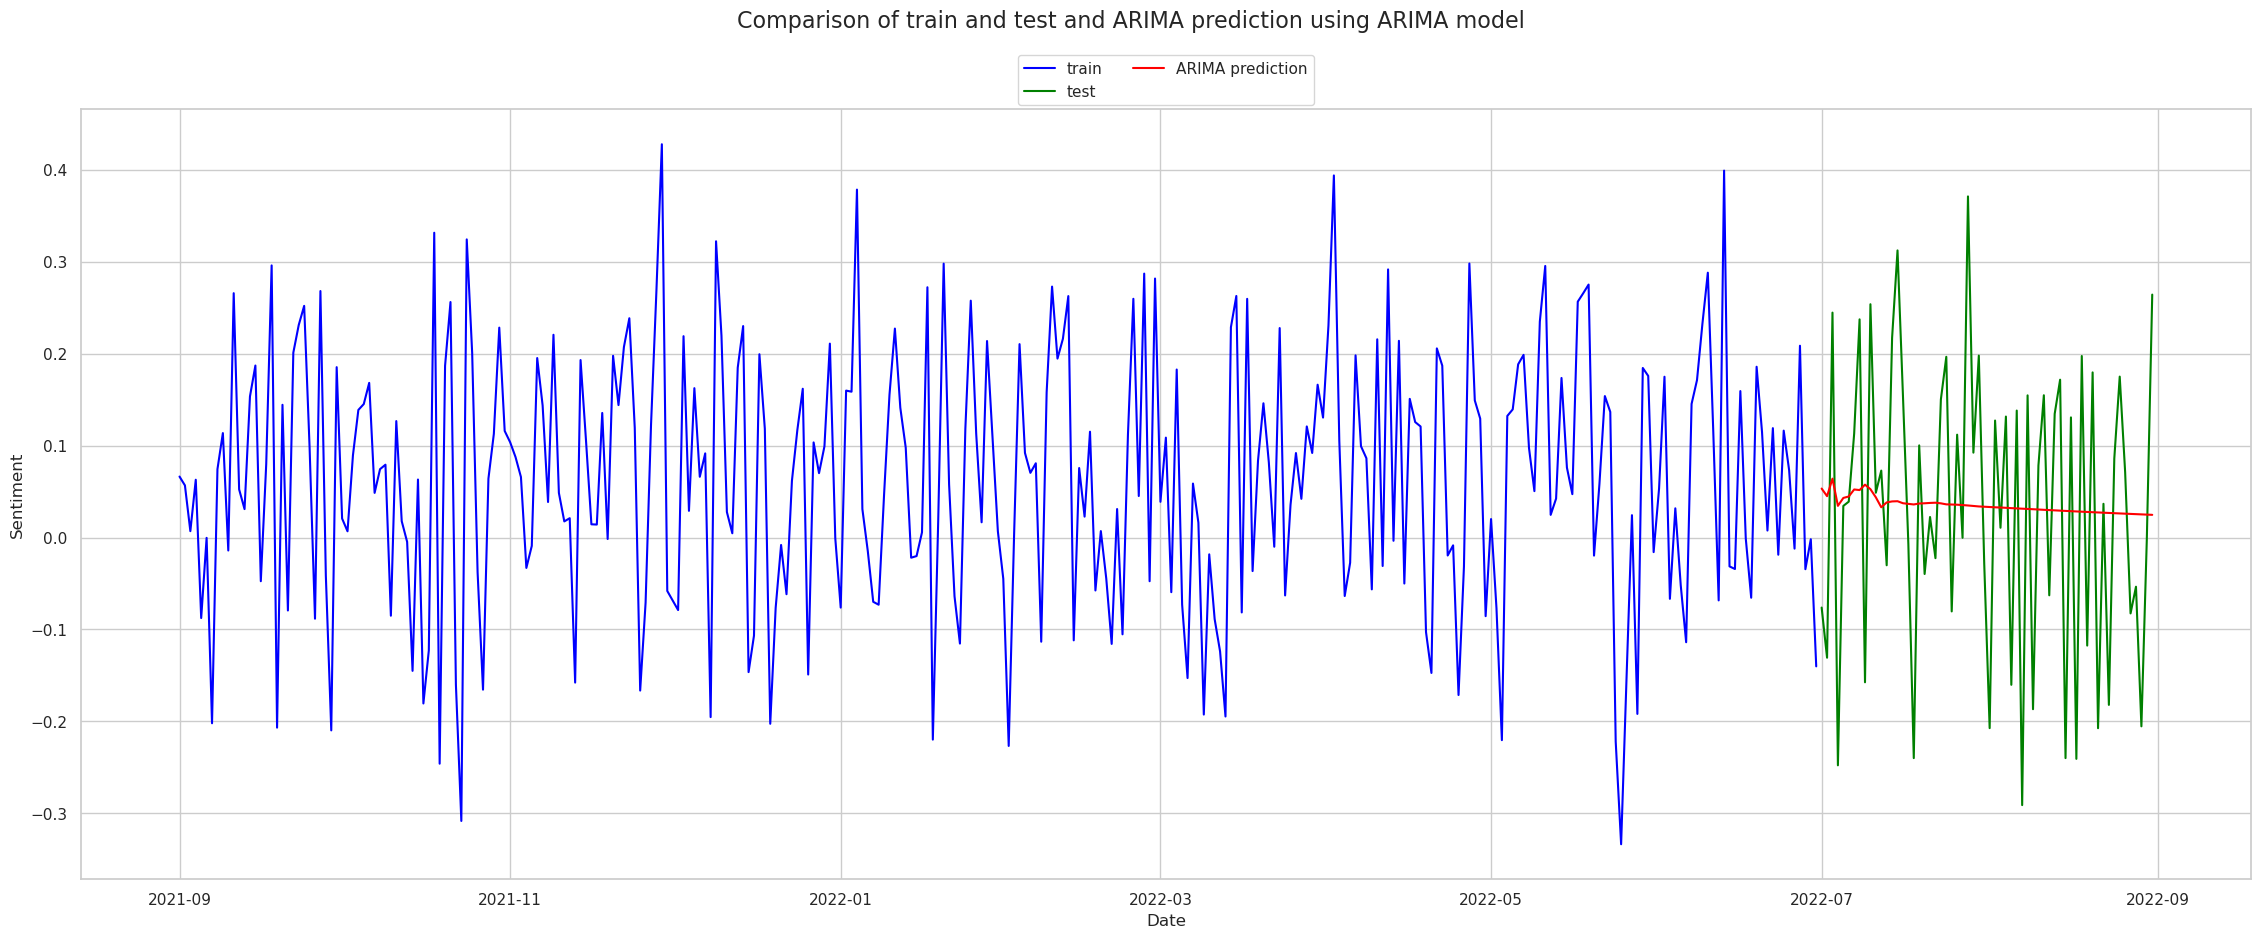

In [19]:
# Plot train, test and predictions of ARMA model
fig, axes = plt.subplots(figsize=(28, 10))
fig.suptitle("Comparison of train and test and ARIMA prediction using ARIMA model", fontsize=16)

sns.set_theme(style="whitegrid")

sns.lineplot(data=train, x="date", y="average sentiment", 
             linestyle="-", color="blue")
sns.lineplot(data=test, x="date", y="average sentiment", 
             linestyle="-", color="green")
sns.lineplot(data=y_pred_outARIMA, x="date", y="prediction", 
             linestyle="-", color="red")

axes.set_xlabel("Date")
axes.set_ylabel("Sentiment")

# Create proxy artists for the legend entries
train_proxy = plt.Line2D([], [], linestyle="-", color="blue", label="train")
test_proxy = plt.Line2D([], [], linestyle="-", color="green", label="test")
arima_proxy = plt.Line2D([], [], linestyle="-", color="red", label="ARIMA prediction")

# Create the legend
plt.legend(handles=[train_proxy, test_proxy, arima_proxy], loc="upper center", 
           bbox_to_anchor=(0.5, 1.08), ncol=2)

plt.show()

In [20]:
arima_rmse = np.sqrt(mean_squared_error(test["average sentiment"].values, y_pred_df["Predictions"]))
print("ARIMA RMSE: ", arima_rmse)

ARIMA RMSE:  0.1576338305883574


<br>

<span style="font-size: 12pt;">After comparison, we chose ForecasterAutoReg model as our final model for predicting.</span>

In [21]:
#from joblib import dump, load

In [81]:
# Download model
#dump(forecaster, filename="forecaster.py")

['forecaster.py']

In [22]:
# Load model
forecaster_loaded = load("forecaster.py")

In [23]:
# Make predictions for a week forward
forecaster_loaded.predict(steps=52)

2022-07-18    0.038372
2022-07-19    0.064399
2022-07-20    0.019907
2022-07-21    0.065682
2022-07-22    0.060098
2022-07-23    0.074393
2022-07-24    0.051557
2022-07-25    0.055257
2022-07-26    0.071030
2022-07-27    0.086049
2022-07-28    0.082866
2022-07-29    0.084470
2022-07-30    0.087248
2022-07-31    0.079645
2022-08-01    0.083541
2022-08-02    0.082104
2022-08-03    0.084843
2022-08-04    0.083441
2022-08-05    0.079405
2022-08-06    0.074496
2022-08-07    0.074672
2022-08-08    0.074868
2022-08-09    0.073478
2022-08-10    0.069111
2022-08-11    0.074838
2022-08-12    0.073937
2022-08-13    0.074678
2022-08-14    0.074469
2022-08-15    0.065184
2022-08-16    0.081347
2022-08-17    0.080844
2022-08-18    0.080963
2022-08-19    0.078533
2022-08-20    0.077849
2022-08-21    0.081371
2022-08-22    0.080737
2022-08-23    0.080663
2022-08-24    0.080628
2022-08-25    0.078063
2022-08-26    0.073758
2022-08-27    0.074178
2022-08-28    0.074241
2022-08-29    0.065016
2022-08-30 

In [24]:
# Make predictions for one month forward
forecaster_loaded.predict(steps=75)

2022-07-18    0.038372
2022-07-19    0.064399
2022-07-20    0.019907
2022-07-21    0.065682
2022-07-22    0.060098
2022-07-23    0.074393
2022-07-24    0.051557
2022-07-25    0.055257
2022-07-26    0.071030
2022-07-27    0.086049
2022-07-28    0.082866
2022-07-29    0.084470
2022-07-30    0.087248
2022-07-31    0.079645
2022-08-01    0.083541
2022-08-02    0.082104
2022-08-03    0.084843
2022-08-04    0.083441
2022-08-05    0.079405
2022-08-06    0.074496
2022-08-07    0.074672
2022-08-08    0.074868
2022-08-09    0.073478
2022-08-10    0.069111
2022-08-11    0.074838
2022-08-12    0.073937
2022-08-13    0.074678
2022-08-14    0.074469
2022-08-15    0.065184
2022-08-16    0.081347
2022-08-17    0.080844
2022-08-18    0.080963
2022-08-19    0.078533
2022-08-20    0.077849
2022-08-21    0.081371
2022-08-22    0.080737
2022-08-23    0.080663
2022-08-24    0.080628
2022-08-25    0.078063
2022-08-26    0.073758
2022-08-27    0.074178
2022-08-28    0.074241
2022-08-29    0.065016
2022-08-30 

In [25]:
# Make predictions for three month forward
forecaster_loaded.predict(steps=135)

2022-07-18    0.038372
2022-07-19    0.064399
2022-07-20    0.019907
2022-07-21    0.065682
2022-07-22    0.060098
2022-07-23    0.074393
2022-07-24    0.051557
2022-07-25    0.055257
2022-07-26    0.071030
2022-07-27    0.086049
2022-07-28    0.082866
2022-07-29    0.084470
2022-07-30    0.087248
2022-07-31    0.079645
2022-08-01    0.083541
2022-08-02    0.082104
2022-08-03    0.084843
2022-08-04    0.083441
2022-08-05    0.079405
2022-08-06    0.074496
2022-08-07    0.074672
2022-08-08    0.074868
2022-08-09    0.073478
2022-08-10    0.069111
2022-08-11    0.074838
2022-08-12    0.073937
2022-08-13    0.074678
2022-08-14    0.074469
2022-08-15    0.065184
2022-08-16    0.081347
2022-08-17    0.080844
2022-08-18    0.080963
2022-08-19    0.078533
2022-08-20    0.077849
2022-08-21    0.081371
2022-08-22    0.080737
2022-08-23    0.080663
2022-08-24    0.080628
2022-08-25    0.078063
2022-08-26    0.073758
2022-08-27    0.074178
2022-08-28    0.074241
2022-08-29    0.065016
2022-08-30 

<br>